# Short Term Water Demand Forecasting with Statistical and AI Methods

### Oscar Wooding
Department of Civil and Environmental Engineering, Imperial College London

### Introduction

Analysis of different AI techniques for short term water demand forecasting for the 

In [1]:
# imports 
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rc
import matplotlib_inline
from datetime import datetime
import warnings
from scipy import stats
from pandas import Series
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from math import sqrt

%matplotlib inline

# imports for time series analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

# imports for time series forecasting
#from sktime.forecasting.base import ForecastingHorizon
#from sktime.forecasting.model_selection import temporal_train_test_split
#from sktime.performance_metrics.forecasting import *
#from sktime.forecasting.naive import NaiveForecaster

# improve matlab output
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

rc('text', usetex=False)
plt.rc('font', size=10)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=11)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# adjust the format of the data set
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)

warnings.filterwarnings("ignore")


### Load Data

In [2]:
# load inflow data
inflow_data = pd.read_csv("../data/InflowData.csv")

# make list with dma names
dma_list = list(inflow_data.columns.values[1:])

# male list with dma description
dma_descripton = ["Hospital district",
                   "Residential district in the countryside",
                   "Residential district in the countryside",
                   "Suburban residential/commercial district",
                   "Residential/commercial district close to the city centre",
                   "Suburban district including sport facilities and office buildings",
                   "Residential district close to the city centre",
                   "City centre district",
                   "Commercial/industrial district close to the port",
                   "Commercial/industrial district close to the port"]

# make list with information of users supplied
users_supplied = [162,531,607,2094,7955,1135,3180,2901,425,776]

# make list with average net inflow
av_net_inflo = [8.4,9.6,4.3,32.9,78.3,8.1,25.1,20.8,20.6,26.4]

# change index of inflow dataframe to time step
inflow_data = inflow_data.set_index('date_time')

# change index format to datetime
inflow_data.index = pd.to_datetime(inflow_data.index, format="%d/%m/%Y %H:%M")

# # print first two rows
inflow_data.head(3)

dma_a  dma_b  dma_c  dma_d  dma_e  dma_f  dma_g  dma_h  \
date_time                                                                     
2021-01-01 00:00:00    NaN    NaN   3.70    NaN    NaN    NaN    NaN    NaN   
2021-01-01 01:00:00    NaN    NaN   3.56    NaN    NaN    NaN    NaN    NaN   
2021-01-01 02:00:00    NaN    NaN   3.27    NaN    NaN    NaN    NaN    NaN   

                     dma_i  dma_j  
date_time                          
2021-01-01 00:00:00    NaN    NaN  
2021-01-01 01:00:00    NaN    NaN  
2021-01-01 02:00:00    NaN    NaN

In [3]:
# load weather data
weather_data = pd.read_csv("../data/WeatherData.csv")

# change index of weather dataframe to time step
weather_data = weather_data.set_index('date_time')

# change index format to datetime
weather_data.index = pd.to_datetime(weather_data.index, format="%d/%m/%Y %H:%M")

# # print first two rows
weather_data.head(3)

rain_depth  air_temp  air_humid  windspeed
date_time                                                      
2021-01-01 00:00:00        0.00      7.20      79.00       9.00
2021-01-01 01:00:00        0.00      7.30      79.00       6.00
2021-01-01 02:00:00        0.00      7.60      78.00       4.00

In [27]:
# clean data

# remove dupes
inflow_data = inflow_data[~inflow_data.index.duplicated(keep='first')]
weather_data = weather_data[~weather_data.index.duplicated(keep='first')]

# set frequency
inflow_data = inflow_data.asfreq(pd.offsets.Hour(), method='pad')
weather_data = weather_data.asfreq(pd.offsets.Hour(), method='pad')

# fill missing using ...
inflow_data_imputed = inflow_data.interpolate(limit=8, method='linear', limit_direction='both') #.bfill()
weather_data_imputed = weather_data.interpolate(limit=8, method='linear', limit_direction='both') #.bfill()

temp_mode = 0 # What default value to take?No
inflow_data_imputed['dma_a'] = inflow_data_imputed['dma_a'].fillna(temp_mode)
inflow_data_imputed['dma_a'].isnull().sum()

# splitting data
pc_train = 0.95 # proportion of data for training
pc_test = 0.05 # proportion of data for testing

nt_train = int(len(inflow_data_imputed)*0.8)

# train data
data_train = {
    'd': inflow_data_imputed[:nt_train],
    'w': weather_data_imputed[:nt_train],
}

# test data
data_test = {
    'd': inflow_data_imputed[nt_train:],
    'w': weather_data_imputed[nt_train:],
}

print('Training data shape: ', data_train['d'].shape)
print('Test data shape: ', data_test['d'].shape)

# normalisation 
# prepare data for normalization
values_train = data_train['d']['dma_c'].values
values_train = values_train.reshape((len(values_train), 1))

# prepare data for normalization
values_test = data_test['d']['dma_c'].values
values_test = values_test.reshape((len(values_test), 1))

# train the normalization on train data
scaler_norm = MinMaxScaler(feature_range=(0, 1))
data_train['d_n'] = data_train['d'][['dma_c']].copy()
data_train['d_n']['dma_c'] = scaler_norm.fit_transform(values_train)

# train the normalization on test data
data_test['d_n'] = data_test['d'][['dma_c']].copy()
data_test['d_n']['dma_c'] = scaler_norm.transform(values_test)

# standardisation
# prepare data for standardization
values = inflow_data_imputed['dma_a'].values
values = values.reshape((len(values), 1))
 
# train the standardization
scaler_std = StandardScaler()
scaler_std = scaler_std.fit(values)
print('Mean: %f, StandardDeviation: %f' % (scaler_std.mean_, sqrt(scaler_std.var_)))


Training data shape:  (10944, 10)
Test data shape:  (2736, 10)
Mean: 8.208821, StandardDeviation: 3.087574


In [28]:
# normalize the data set and print the first 5 rows
normalized = scaler_norm.transform(values)
print('Normalised Values \n')
for i in range(5):
    print(normalized[-i])
 
# standardization the data set and print the first 5 rows
print('\nStandardised Values')
standardized = scaler_std.transform(values)
for i in range(5):
    print(standardized[-i])
    
# inverse transform and print the first 5 rows
inversed = scaler_norm.inverse_transform(normalized)
print('\nIntitial Values')
for i in range(5):
    print(inversed[-i])
    

Normalised Values 

[-0.2]
[0.98]
[0.87]
[0.99]
[1.12]

Standardised Values
[-2.66]
[1.08]
[0.72]
[1.09]
[1.5]

Intitial Values
[0.]
[11.53]
[10.42]
[11.56]
[12.84]


In [29]:
# understanding data
print('Missing Values\n')
print(weather_data_imputed.isna().sum())
print(inflow_data_imputed.isna().sum())

print('\nValue Counts\n')
print(len(weather_data_imputed))
print(len(inflow_data_imputed))

print('\nStatistical Descriptors\n')
print(weather_data_imputed.describe(),'\n')
print(inflow_data_imputed.describe())

Missing Values

rain_depth    0
air_temp      0
air_humid     0
windspeed     0
dtype: int64
dma_a       0
dma_b     258
dma_c      15
dma_d     317
dma_e     292
dma_f    1408
dma_g     938
dma_h     724
dma_i    1221
dma_j     425
dtype: int64

Value Counts

13848
13680

Statistical Descriptors

       rain_depth  air_temp  air_humid  windspeed
count   13,848.00 13,848.00  13,848.00  13,848.00
mean         0.06     15.53      63.63      13.90
std          0.54      7.51      15.46      12.31
min          0.00     -2.10      17.00       1.00
25%          0.00      9.00      53.00       5.00
50%          0.00     14.20      63.00       9.00
75%          0.00     22.50      74.00      18.00
max         28.10     34.60     100.00      77.00 

          dma_a     dma_b     dma_c     dma_d     dma_e     dma_f     dma_g  \
count 13,680.00 13,422.00 13,665.00 13,363.00 13,388.00 12,272.00 12,742.00   
mean       8.21      9.57      4.50     33.60     77.56      8.03     24.24   
std        3

## Analysis

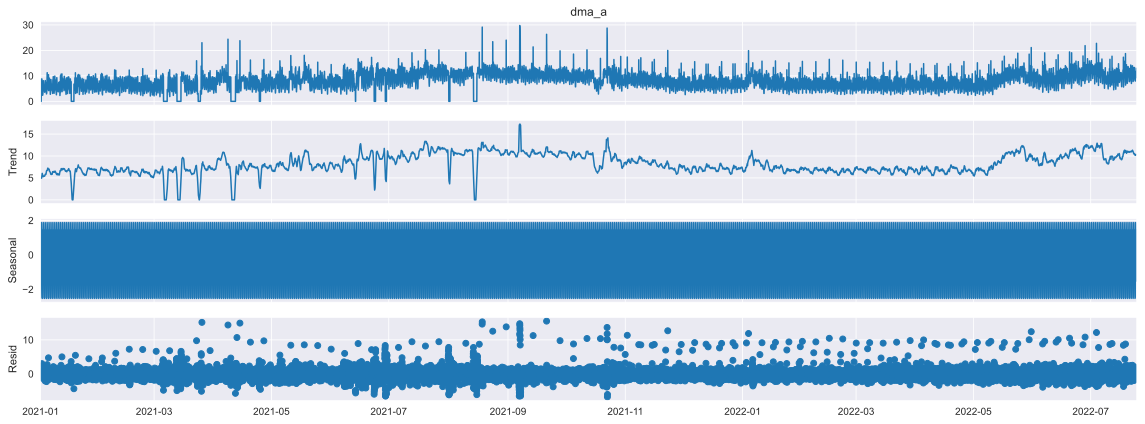

In [30]:
# Decompose time series (for dma_a)
decomposition = sm.tsa.seasonal_decompose(inflow_data_imputed['dma_a'], model='additive')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = decomposition.plot()
plt.rcParams['figure.figsize'] = [10.0, 6.0]

In [31]:
load = inflow_data_imputed['2021-01':'2021-03']

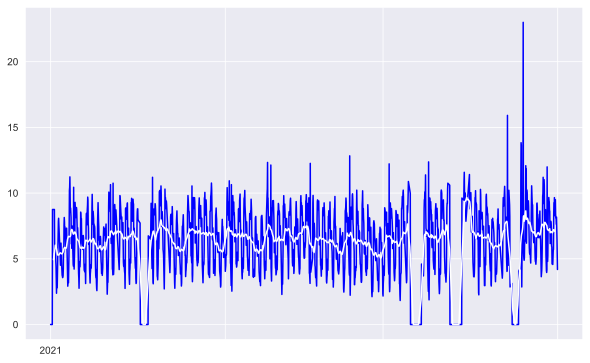

In [32]:
decomposition = sm.tsa.seasonal_decompose(load['dma_a'], model = 'additive')
 
fig, ax = plt.subplots()
ax.grid(True)
 
year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=1)
 
year_format = mdates.DateFormatter('%Y')
month_format = mdates.DateFormatter('%m')
 
ax.xaxis.set_minor_locator(month)
ax.xaxis.grid(True, which = 'minor')
ax.xaxis.set_major_locator(year)
ax.xaxis.set_major_formatter(year_format)
 
plt.plot(load['dma_a'], c='blue')
plt.plot(decomposition.trend, c='white')

In [33]:
# creating features
# date time features
inflow_data_imputed['hour'] = [inflow_data_imputed.index[i].hour for i in range(len(inflow_data_imputed))]
inflow_data_imputed['month'] = [inflow_data_imputed.index[i].month for i in range(len(inflow_data_imputed))]
inflow_data_imputed['dayofweek'] = [inflow_data_imputed.index[i].day for i in range(len(inflow_data_imputed))]

inflow_data_imputed['weekend'] = [
    0 if inflow_data_imputed.index[i].day in range(5) 
    else 1 for i in range(len(inflow_data_imputed))
]

# offsets
# offset based on day type (realigns index)
inflow_shift = inflow_data_imputed.shift(4, freq='B')

# generating multiple lags
generated_lagged_features(inflow_data_imputed, 'dma_c', 5)
generated_lagged_features(inflow_data_imputed, 'dma_d', 5)

# rolling window stats
# mix,max,mean
demand = inflow_data_imputed[['dma_c']]
width = 4
shifted = demand.shift(1)

window = shifted.rolling(window=width)
demand_df = pd.concat([window.min(), window.mean(), window.max(), demand], axis=1)
demand_df.columns = ['min', 'mean', 'max', 'demand']

# can also use .expanding for expanding windows
print(demand_df.head(10))


NameError: name 'generated_lagged_features' is not defined

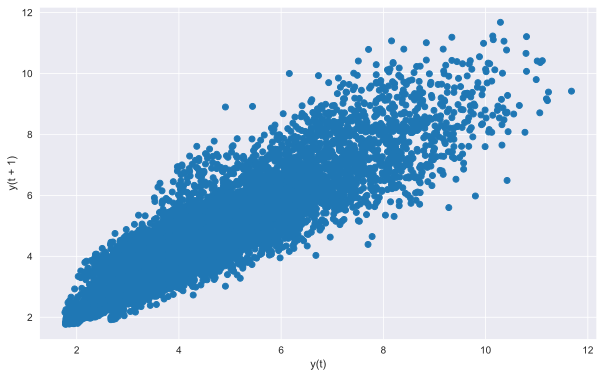

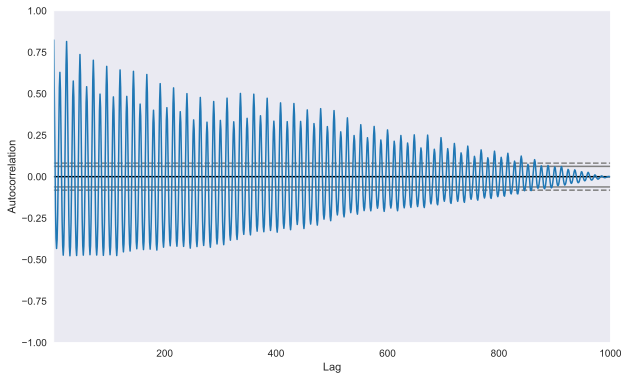

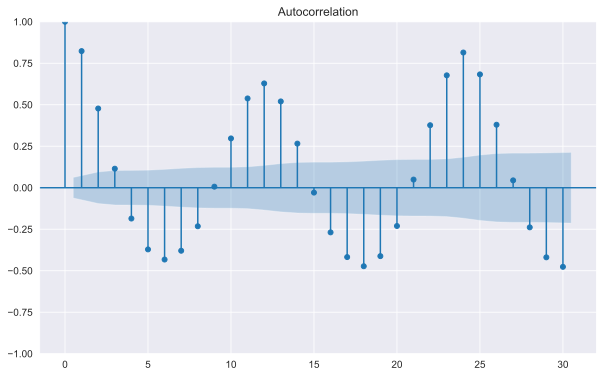

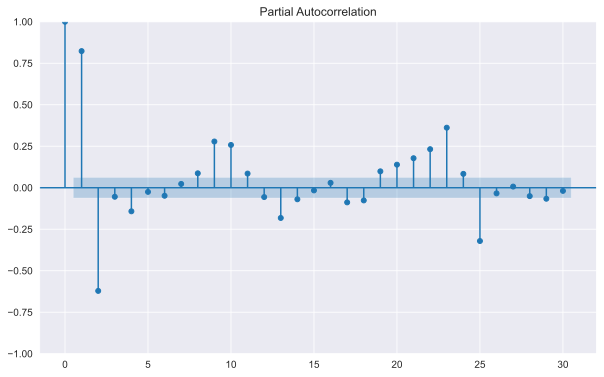

In [34]:
# analysing randomness
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure()
 
# Pass the lag argument and plot the values. 
# When lag=1 the plot is essentially data[:-1] vs. data[1:]
# Plot our ts_data_load set
lag_plot(inflow_data_imputed['dma_c'])

# Lag plots are used to check if a data set or time series 
# is random: random data should not exhibit any structure 
# in the lag plot.

# Import autocorrelation_plot function
from pandas.plotting import autocorrelation_plot
plt.figure()
 
# Pass the autocorrelation argument and plot the values
autocorrelation_plot(inflow_data_imputed[-1000:]['dma_c'])
 
# Plot the acf function on the ts_data_load set
plot_acf(inflow_data_imputed[-1000:]['dma_c'])

# plot the pacf function on the ts_data_load_subset
plot_pacf(inflow_data_imputed[-1000:]['dma_c'], lags=30)

plt.show()

In [35]:
# autoregression model
# Import necessary libraries
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
 
# Apply AutoReg model
model = AutoReg(inflow_data_imputed[-1000:]['dma_c'], 1)
results = model.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  dma_c   No. Observations:                 1000
Model:                     AutoReg(1)   Log Likelihood               -1415.904
Method:               Conditional MLE   S.D. of innovations              0.998
Date:                Thu, 08 Feb 2024   AIC                           2837.809
Time:                        16:14:24   BIC                           2852.529
Sample:                    06-13-2022   HQIC                          2843.404
                         - 07-24-2022                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9770      0.104      9.374      0.000       0.773       1.181
dma_c.L1       0.8234      0.018     45.862      0.000       0.788       0.859
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2145           +0.0000j            1.2145            0.0000
-----------------------------------------------------------------------------
"""

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


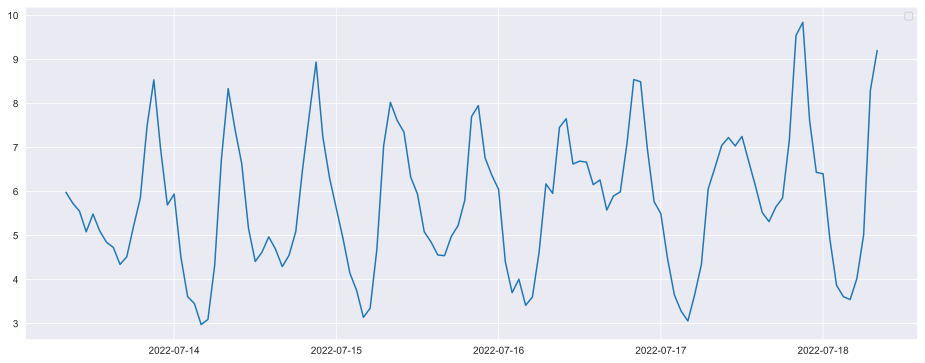

In [36]:
# Define figure style, plot package and default figure size
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
 
# Default figure size
sns.mpl.rc("figure", figsize=(16, 6))
 
# Use plot_predict and visualize forecasts
figure = results.plot_predict(720, 840)


In [37]:
# Apply covariance estimators cov_type="HC0" and output the summary
res = model.fit(cov_type="HC0")
res.summary()
 
# Use plot_predict and visualize forecasts
fig = res.plot_diagnostics(fig=fig, lags=20)

In [38]:
# Specify the number of steps to forecast ahead
HORIZON = 3
print('Forecasting horizon:', HORIZON, 'hours')


Forecasting horizon: 3 hours


In [15]:
# Create a test data point for each HORIZON 
test_shifted = data_test['d_n'].copy()

for t in range(1, HORIZON):
        test_shifted['load+'+str(t)] = test_shifted['dma_c'].shift(-t, freq='H')
    
test_shifted = test_shifted.dropna(how='any')
test_shifted.head(5)


dma_c  load+1  load+2
date_time                                 
2022-04-02 00:00:00   0.05    0.02    0.00
2022-04-02 01:00:00   0.02    0.00    0.00
2022-04-02 02:00:00   0.00    0.00    0.00
2022-04-02 03:00:00   0.00    0.00    0.02
2022-04-02 04:00:00   0.00    0.02    0.06

In [16]:
# Autoreggressive model
# Make predictions on the test data
training_window = 100
 
train_ts = data_train['d']['dma_c']
test_ts = test_shifted
 
history = [x for x in train_ts]
history = history[(-training_window):]
 
predictions = list()
 
for t in range(test_ts.shape[0]):
    model = AutoReg(history, 1)
    #model = ARMA(history, order=1)
    model_fit = model.fit()
    yhat = model_fit.predict
    predictions.append(yhat)
    obs = list(test_ts.iloc[t])
    # move the training window
    history.append(obs[0])
    history.pop(0)
    print(test_ts.index[t])
    print(t+1, ': predicted =', yhat()[-HORIZON:], 'expected =', obs)
    

2022-04-02 00:00:00
1 : predicted = [3.86 3.77 3.26] expected = [0.048155737704918045, 0.01741803278688525, 0.0020491803278688547]
2022-04-02 01:00:00
2 : predicted = [3.77 3.23 2.59] expected = [0.01741803278688525, 0.0020491803278688547, 0.0020491803278688547]
2022-04-02 02:00:00
3 : predicted = [3.23 2.57 0.35] expected = [0.0020491803278688547, 0.0020491803278688547, 0.003073770491803296]
2022-04-02 03:00:00
4 : predicted = [2.56 0.31 0.28] expected = [0.0020491803278688547, 0.003073770491803296, 0.019467213114754106]
2022-04-02 04:00:00
5 : predicted = [0.29 0.26 0.25] expected = [0.003073770491803296, 0.019467213114754106, 0.056352459016393464]
2022-04-02 05:00:00
6 : predicted = [0.24 0.23 0.23] expected = [0.019467213114754106, 0.056352459016393464, 0.15163934426229508]
2022-04-02 06:00:00
7 : predicted = [0.21 0.21 0.21] expected = [0.056352459016393464, 0.15163934426229508, 0.24590163934426235]
2022-04-02 07:00:00
8 : predicted = [0.2  0.2  0.22] expected = [0.151639344262295

2022-04-14 10:00:00
299 : predicted = [0.23 0.33 0.33] expected = [0.24385245901639346, 0.23053278688524592, 0.2325819672131148]
2022-04-14 11:00:00
300 : predicted = [0.33 0.33 0.27] expected = [0.23053278688524592, 0.2325819672131148, 0.22336065573770492]
2022-04-14 12:00:00
301 : predicted = [0.33 0.27 0.24] expected = [0.2325819672131148, 0.22336065573770492, 0.17520491803278687]
2022-04-14 13:00:00
302 : predicted = [0.26 0.24 0.22] expected = [0.22336065573770492, 0.17520491803278687, 0.20594262295081972]
2022-04-14 14:00:00
303 : predicted = [0.23 0.22 0.23] expected = [0.17520491803278687, 0.20594262295081972, 0.1915983606557377]
2022-04-14 15:00:00
304 : predicted = [0.22 0.23 0.22] expected = [0.20594262295081972, 0.1915983606557377, 0.26127049180327866]
2022-04-14 16:00:00
305 : predicted = [0.23 0.22 0.18] expected = [0.1915983606557377, 0.26127049180327866, 0.2633196721311476]
2022-04-14 17:00:00
306 : predicted = [0.22 0.18 0.2 ] expected = [0.26127049180327866, 0.2633196

2022-04-27 05:00:00
606 : predicted = [0.02 0.01 0.01] expected = [0.016393442622950838, 0.14139344262295084, 0.29098360655737704]
2022-04-27 06:00:00
607 : predicted = [0.01 0.01 0.01] expected = [0.14139344262295084, 0.29098360655737704, 0.23360655737704922]
2022-04-27 07:00:00
608 : predicted = [0.01 0.01 0.03] expected = [0.29098360655737704, 0.23360655737704922, 0.2182377049180328]
2022-04-27 08:00:00
609 : predicted = [0.01 0.03 0.14] expected = [0.23360655737704922, 0.2182377049180328, 0.1834016393442623]
2022-04-27 09:00:00
610 : predicted = [0.04 0.14 0.28] expected = [0.2182377049180328, 0.1834016393442623, 0.14036885245901642]
2022-04-27 10:00:00
611 : predicted = [0.14 0.28 0.23] expected = [0.1834016393442623, 0.14036885245901642, 0.16495901639344263]
2022-04-27 11:00:00
612 : predicted = [0.28 0.22 0.21] expected = [0.14036885245901642, 0.16495901639344263, 0.17520491803278687]
2022-04-27 12:00:00
613 : predicted = [0.22 0.21 0.18] expected = [0.16495901639344263, 0.17520

2022-05-11 19:00:00
956 : predicted = [0.28 0.32 0.37] expected = [0.45389344262295084, 0.40573770491803285, 0.26127049180327866]
2022-05-11 20:00:00
957 : predicted = [0.32 0.37 0.44] expected = [0.40573770491803285, 0.26127049180327866, 0.132172131147541]
2022-05-11 21:00:00
958 : predicted = [0.37 0.44 0.43] expected = [0.26127049180327866, 0.132172131147541, 0.1311475409836066]
2022-05-11 22:00:00
959 : predicted = [0.43 0.43 0.38] expected = [0.132172131147541, 0.1311475409836066, 0.08606557377049179]
2022-05-11 23:00:00
960 : predicted = [0.42 0.38 0.25] expected = [0.1311475409836066, 0.08606557377049179, 0.003073770491803296]
2022-05-12 00:00:00
961 : predicted = [0.38 0.25 0.14] expected = [0.08606557377049179, 0.003073770491803296, -0.013319672131147542]
2022-05-12 01:00:00
962 : predicted = [0.25 0.14 0.14] expected = [0.003073770491803296, -0.013319672131147542, -0.0122950819672131]
2022-05-12 02:00:00
963 : predicted = [0.14 0.14 0.1 ] expected = [-0.013319672131147542, -0

2022-05-26 11:00:00
1308 : predicted = [0.54 0.5  0.4 ] expected = [0.24692622950819676, 0.2756147540983607, 0.3135245901639345]
2022-05-26 12:00:00
1309 : predicted = [0.49 0.4  0.33] expected = [0.2756147540983607, 0.3135245901639345, 0.2551229508196722]
2022-05-26 13:00:00
1310 : predicted = [0.4  0.33 0.27] expected = [0.3135245901639345, 0.2551229508196722, 0.2633196721311476]
2022-05-26 14:00:00
1311 : predicted = [0.33 0.27 0.29] expected = [0.2551229508196722, 0.2633196721311476, 0.2602459016393443]
2022-05-26 15:00:00
1312 : predicted = [0.26 0.29 0.32] expected = [0.2633196721311476, 0.2602459016393443, 0.39241803278688525]
2022-05-26 16:00:00
1313 : predicted = [0.29 0.32 0.27] expected = [0.2602459016393443, 0.39241803278688525, 0.5102459016393444]
2022-05-26 17:00:00
1314 : predicted = [0.32 0.27 0.28] expected = [0.39241803278688525, 0.5102459016393444, 0.5245901639344263]
2022-05-26 18:00:00
1315 : predicted = [0.27 0.28 0.28] expected = [0.5102459016393444, 0.5245901639

2022-06-12 14:00:00
1719 : predicted = [0.37 0.39 0.46] expected = [0.32274590163934436, 0.2633196721311476, 0.3688524590163934]
2022-06-12 15:00:00
1720 : predicted = [0.39 0.45 0.4 ] expected = [0.2633196721311476, 0.3688524590163934, 0.35758196721311475]
2022-06-12 16:00:00
1721 : predicted = [0.45 0.4  0.31] expected = [0.3688524590163934, 0.35758196721311475, 0.4375000000000001]
2022-06-12 17:00:00
1722 : predicted = [0.4  0.31 0.26] expected = [0.35758196721311475, 0.4375000000000001, 0.6086065573770493]
2022-06-12 18:00:00
1723 : predicted = [0.31 0.26 0.35] expected = [0.4375000000000001, 0.6086065573770493, 0.6885245901639345]
2022-06-12 19:00:00
1724 : predicted = [0.26 0.36 0.35] expected = [0.6086065573770493, 0.6885245901639345, 0.4805327868852459]
2022-06-12 20:00:00
1725 : predicted = [0.36 0.35 0.42] expected = [0.6885245901639345, 0.4805327868852459, 0.42725409836065575]
2022-06-12 21:00:00
1726 : predicted = [0.35 0.43 0.59] expected = [0.4805327868852459, 0.427254098

2022-06-28 10:00:00
2099 : predicted = [0.67 0.72 0.7 ] expected = [0.4426229508196722, 0.36372950819672134, 0.31762295081967207]
2022-06-28 11:00:00
2100 : predicted = [0.72 0.69 0.54] expected = [0.36372950819672134, 0.31762295081967207, 0.30225409836065575]
2022-06-28 12:00:00
2101 : predicted = [0.69 0.53 0.44] expected = [0.31762295081967207, 0.30225409836065575, 0.21721311475409838]
2022-06-28 13:00:00
2102 : predicted = [0.54 0.44 0.37] expected = [0.30225409836065575, 0.21721311475409838, 0.22028688524590168]
2022-06-28 14:00:00
2103 : predicted = [0.44 0.37 0.34] expected = [0.21721311475409838, 0.22028688524590168, 0.2889344262295082]
2022-06-28 15:00:00
2104 : predicted = [0.37 0.34 0.32] expected = [0.22028688524590168, 0.2889344262295082, 0.37807377049180335]
2022-06-28 16:00:00
2105 : predicted = [0.34 0.32 0.25] expected = [0.2889344262295082, 0.37807377049180335, 0.4569672131147541]
2022-06-28 17:00:00
2106 : predicted = [0.32 0.26 0.26] expected = [0.37807377049180335,

2022-07-13 04:00:00
2453 : predicted = [0.15 0.1  0.08] expected = [0.05532786885245905, 0.132172131147541, 0.35143442622950816]
2022-07-13 05:00:00
2454 : predicted = [0.1  0.08 0.07] expected = [0.132172131147541, 0.35143442622950816, 0.42622950819672134]
2022-07-13 06:00:00
2455 : predicted = [0.08 0.07 0.1 ] expected = [0.35143442622950816, 0.42622950819672134, 0.3954918032786886]
2022-07-13 07:00:00
2456 : predicted = [0.08 0.11 0.17] expected = [0.42622950819672134, 0.3954918032786886, 0.3729508196721312]
2022-07-13 08:00:00
2457 : predicted = [0.11 0.17 0.35] expected = [0.3954918032786886, 0.3729508196721312, 0.31454918032786894]
2022-07-13 09:00:00
2458 : predicted = [0.17 0.35 0.41] expected = [0.3729508196721312, 0.31454918032786894, 0.36475409836065575]
2022-07-13 10:00:00
2459 : predicted = [0.35 0.41 0.38] expected = [0.31454918032786894, 0.36475409836065575, 0.31659836065573765]
2022-07-13 11:00:00
2460 : predicted = [0.4  0.38 0.36] expected = [0.36475409836065575, 0.31

2022-07-24 03:00:00
2716 : predicted = [0.39 0.29 0.19] expected = [0.18237704918032788, 0.20286885245901642, 0.18032786885245905]
2022-07-24 04:00:00
2717 : predicted = [0.3  0.19 0.21] expected = [0.20286885245901642, 0.18032786885245905, 0.31762295081967207]
2022-07-24 05:00:00
2718 : predicted = [0.19 0.21 0.23] expected = [0.18032786885245905, 0.31762295081967207, 0.4928278688524591]
2022-07-24 06:00:00
2719 : predicted = [0.21 0.23 0.24] expected = [0.31762295081967207, 0.4928278688524591, 0.6618852459016394]
2022-07-24 07:00:00
2720 : predicted = [0.23 0.25 0.23] expected = [0.4928278688524591, 0.6618852459016394, 0.6383196721311476]
2022-07-24 08:00:00
2721 : predicted = [0.25 0.23 0.34] expected = [0.6618852459016394, 0.6383196721311476, 0.555327868852459]
2022-07-24 09:00:00
2722 : predicted = [0.23 0.34 0.48] expected = [0.6383196721311476, 0.555327868852459, 0.5491803278688525]
2022-07-24 10:00:00
2723 : predicted = [0.34 0.48 0.62] expected = [0.555327868852459, 0.54918032

## SARIMAX Model

In [18]:
# Import necessary libraries
from statsmodels.tsa.statespace.sarimax import SARIMAX
import math
#from common.utils import mape

In [21]:
train = data_train['d_n']
test = data_test['d_n']

# Specify the number of steps to forecast ahead
HORIZON = 3
print('Forecasting horizon:', HORIZON, 'hours')

# Define the order and seasonal order for the SARIMAX model
order = (4, 1, 0)
seasonal_order = (1, 1, 0, 24)

# Build and fit the SARIMAX model
model = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order)
results = model.fit()
 
print(results.summary())


Forecasting horizon: 3 hours


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.77785D+00    |proj g|=  2.93482D+00

At iterate    5    f= -1.78231D+00    |proj g|=  1.86432D-01

At iterate   10    f= -1.78340D+00    |proj g|=  3.22386D-01

At iterate   15    f= -1.78348D+00    |proj g|=  8.88591D-02

At iterate   20    f= -1.78364D+00    |proj g|=  7.05821D-03

At iterate   25    f= -1.78364D+00    |proj g|=  1.81915D-02

At iterate   30    f= -1.78364D+00    |proj g|=  4.61824D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

In [39]:
# Create a test data point for each HORIZON step
test_shifted = test.copy()
 
for t in range(1, HORIZON):
    test_shifted['load+'+str(t)] = test_shifted['dma_c'].shift(-t, freq='H')
    
test_shifted = test_shifted.dropna(how='any')


In [ ]:
# Make predictions on the test data
training_window = 200
 
train_ts = train['dma_c']
test_ts = test_shifted
 
history = [x for x in train_ts]
history = history[(-training_window):]
 
predictions = list()
 
# Let's user simpler model
order = (2, 1, 0)
seasonal_order = (1, 1, 0, 24)
 
for t in range(test_ts.shape[0]):
    model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps = HORIZON)
    predictions.append(yhat)
    obs = list(test_ts.iloc[t])
    # move the training window
    history.append(obs[0])
    history.pop(0)
    print(test_ts.index[t])
    print(t+1, ': predicted =', yhat, 'expected =', obs)
 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.68626D+00    |proj g|=  3.17310D+00


 This problem is unconstrained.



At iterate    5    f= -1.69070D+00    |proj g|=  1.63408D-01

At iterate   10    f= -1.69148D+00    |proj g|=  2.64286D-01

At iterate   15    f= -1.69151D+00    |proj g|=  5.07715D-02

At iterate   20    f= -1.69153D+00    |proj g|=  1.92560D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     54      2     0     0   4.819D-03  -1.692D+00
  F =  -1.6915280178425762     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-02 00:00:00
1 : predicted = [ 0.02  0.01 -0.  ] expected = [0.048155737704918045, 0.01741803278688525, 0.0020491803278688547]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.68854D+00    |proj g|=  3.22159D+00


 This problem is unconstrained.



At iterate    5    f= -1.69310D+00    |proj g|=  1.41831D-01

At iterate   10    f= -1.69379D+00    |proj g|=  3.46053D-01

At iterate   15    f= -1.69384D+00    |proj g|=  3.78634D-02

At iterate   20    f= -1.69386D+00    |proj g|=  7.97501D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     31      1     0     0   3.211D-04  -1.694D+00
  F =  -1.6938650794434653     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-02 01:00:00
2 : predicted = [0.04 0.03 0.02] expected = [0.01741803278688525, 0.0020491803278688547, 0.0020491803278688547]
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f= -1.69211D+00    |proj g|=  1.11188D-01

At iterate   10    f= -1.69261D+00    |proj g|=  4.70303D-01

At iterate   15    f= -1.69269D+00    |proj g|=  1.01023D-02

At iterate   20    f= -1.69271D+00    |proj g|=  4.21215D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     29      1     0     0   6.229D-04  -1.693D+00
  F =  -1.6927145079477766     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-02 02:00:00
3 : predicted = [ 0. -0. -0.] expected = [0.0020491803278688547, 0.0020491803278688547, 0.003073770491803296]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.69548D+00    |proj g|=  1.28539D-01

At iterate   10    f= -1.69608D+00    |proj g|=  4.09732D-01

At iterate   15    f= -1.69615D+00    |proj g|=  2.85207D-02

At iterate   20    f= -1.69617D+00    |proj g|=  1.70220D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     29      1     0     0   2.089D-04  -1.696D+00
  F =  -1.6961664556685636     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-02 03:00:00
4 : predicted = [-0.   -0.    0.02] expected = [0.0020491803278688547, 0.003073770491803296, 0.019467213114754106]
RUNNING THE L-BFGS-B CODE

           * 

 This problem is unconstrained.



At iterate    5    f= -1.69741D+00    |proj g|=  1.36424D-01

At iterate   10    f= -1.69805D+00    |proj g|=  3.81819D-01

At iterate   15    f= -1.69811D+00    |proj g|=  3.08095D-02

At iterate   20    f= -1.69814D+00    |proj g|=  3.81303D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     28      1     0     0   4.230D-04  -1.698D+00
  F =  -1.6981357345335000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-02 04:00:00
5 : predicted = [0.   0.03 0.15] expected = [0.003073770491803296, 0.019467213114754106, 0.056352459016393464]
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f= -1.69815D+00    |proj g|=  1.55944D-01

At iterate   10    f= -1.69891D+00    |proj g|=  2.30008D-01

At iterate   15    f= -1.69894D+00    |proj g|=  4.27749D-02

At iterate   20    f= -1.69895D+00    |proj g|=  6.75256D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     29      1     0     0   2.003D-03  -1.699D+00
  F =  -1.6989478664134610     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-02 05:00:00
6 : predicted = [0.03 0.16 0.25] expected = [0.019467213114754106, 0.056352459016393464, 0.15163934426229508]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.70134D+00    |proj g|=  2.24071D-01

At iterate   10    f= -1.70229D+00    |proj g|=  2.31425D-01

At iterate   15    f= -1.70235D+00    |proj g|=  1.34040D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     29      1     0     0   1.548D-03  -1.702D+00
  F =  -1.7023711268882027     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-02 06:00:00
7 : predicted = [0.14 0.24 0.22] expected = [0.056352459016393464, 0.15163934426229508, 0.24590163934426235]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -1.68687D+00    |proj g|=  1.84636D-01

At iterate   10    f= -1.68782D+00    |proj g|=  3.49679D-01

At iterate   15    f= -1.68791D+00    |proj g|=  3.70610D-02

At iterate   20    f= -1.68792D+00    |proj g|=  1.36306D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     37      1     0     0   5.542D-03  -1.688D+00
  F =  -1.6879191135600433     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-02 07:00:00
8 : predicted = [0.14 0.13 0.09] expected = [0.15163934426229508, 0.24590163934426235, 0.29098360655737704]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.68713D+00    |proj g|=  1.63416D-01

At iterate   10    f= -1.68802D+00    |proj g|=  3.23005D-01

At iterate   15    f= -1.68812D+00    |proj g|=  3.82104D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     31      1     0     0   7.484D-03  -1.688D+00
  F =  -1.6881230127736893     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-02 08:00:00
9 : predicted = [0.14 0.09 0.07] expected = [0.24590163934426235, 0.29098360655737704, 0.29815573770491804]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

 This problem is unconstrained.



At iterate    5    f= -1.66610D+00    |proj g|=  1.68469D-01

At iterate   10    f= -1.66709D+00    |proj g|=  1.07294D-01

At iterate   15    f= -1.66712D+00    |proj g|=  6.56210D-03

At iterate   20    f= -1.66712D+00    |proj g|=  4.76062D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     31      1     0     0   4.977D-04  -1.667D+00
  F =  -1.6671204501724732     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-02 09:00:00
10 : predicted = [0.21 0.18 0.17] expected = [0.29098360655737704, 0.29815573770491804, 0.24795081967213117]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.65558D+00    |proj g|=  1.52512D-01

At iterate   10    f= -1.65656D+00    |proj g|=  1.48563D-01

At iterate   15    f= -1.65660D+00    |proj g|=  6.46078D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     27      1     0     0   1.413D-03  -1.657D+00
  F =  -1.6566056852255420     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-02 10:00:00
11 : predicted = [0.27 0.25 0.23] expected = [0.29815573770491804, 0.24795081967213117, 0.2551229508196722]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.64917D+00    |proj g|=  3.29369D+00

At iterate    5    f= -1.65447D+00    |proj g|=  1.61761D-01

At iterate   10    f= -1.65542D+00    |proj g|=  1.97032D-01

At iterate   15    f= -1.65548D+00    |proj g|=  1.01428D-01

At iterate   20    f= -1.65549D+00    |proj g|=  1.34963D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     31      1     0     0   3.678D-03  -1.655D+00
  F =  -1.6554886431303686     

CONVERG

 This problem is unconstrained.



At iterate    5    f= -1.65297D+00    |proj g|=  1.96412D-01

At iterate   10    f= -1.65402D+00    |proj g|=  3.18233D-01

At iterate   15    f= -1.65413D+00    |proj g|=  1.46254D-01

At iterate   20    f= -1.65417D+00    |proj g|=  4.21655D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     46      1     0     0   4.217D-03  -1.654D+00
  F =  -1.6541723095672805     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-02 12:00:00
13 : predicted = [0.22 0.22 0.22] expected = [0.2551229508196722, 0.24692622950819676, 0.23463114754098363]



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.64615D+00    |proj g|=  2.98091D+00


 This problem is unconstrained.



At iterate    5    f= -1.65041D+00    |proj g|=  1.26611D-01

At iterate   10    f= -1.65115D+00    |proj g|=  5.06701D-01

At iterate   15    f= -1.65127D+00    |proj g|=  1.18306D-02

At iterate   20    f= -1.65133D+00    |proj g|=  1.42500D-03

At iterate   25    f= -1.65133D+00    |proj g|=  1.50475D-02

At iterate   30    f= -1.65133D+00    |proj g|=  7.64691D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     56      1     0     0   7.647D-03  -1.651D+00
  F =  -1.6513319971525255     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


2022-04-02 13:00:00
14 : predicted = [0.27 0.26 0.26] expected = [0.24692622950819676, 0.23463114754098363, 0.20286885245901642]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.65386D+00    |proj g|=  1.87634D+00


 This problem is unconstrained.



At iterate    5    f= -1.65539D+00    |proj g|=  1.72541D-01

At iterate   10    f= -1.65602D+00    |proj g|=  4.50845D-02

At iterate   15    f= -1.65605D+00    |proj g|=  1.22530D-01

At iterate   20    f= -1.65607D+00    |proj g|=  8.39211D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     44      1     0     0   1.462D-03  -1.656D+00
  F =  -1.6560679168809702     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-02 14:00:00
15 : predicted = [0.24 0.24 0.23] expected = [0.23463114754098363, 0.20286885245901642, 0.20081967213114754]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.65377D+00    |proj g|=  1.77507D+00


 This problem is unconstrained.



At iterate    5    f= -1.65537D+00    |proj g|=  6.15606D-01

At iterate   10    f= -1.65673D+00    |proj g|=  7.76268D-03

At iterate   15    f= -1.65679D+00    |proj g|=  8.66526D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     45      1     0     0   2.036D-02  -1.657D+00
  F =  -1.6567920133588394     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-02 15:00:00
16 : predicted = [0.24 0.23 0.26] expected = [0.20286885245901642, 0.20081967213114754, 0.20286885245901642]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.68101D+00    |proj g|=  2.82352D+00


 This problem is unconstrained.



At iterate    5    f= -1.68444D+00    |proj g|=  8.63425D-02

At iterate   10    f= -1.68470D+00    |proj g|=  2.67329D-03

At iterate   15    f= -1.68471D+00    |proj g|=  6.23696D-03

At iterate   20    f= -1.68471D+00    |proj g|=  1.23533D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     42      1     0     0   1.800D-02  -1.685D+00
  F =  -1.6847104245834796     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-02 16:00:00
17 : predicted = [0.19 0.23 0.23] expected = [0.20081967213114754, 0.20286885245901642, 0.22336065573770492]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.69813D+00    |proj g|=  1.10011D-01

At iterate   10    f= -1.69851D+00    |proj g|=  3.58805D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     26      1     0     0   2.638D-03  -1.699D+00
  F =  -1.6985567116410651     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-02 17:00:00
18 : predicted = [0.23 0.24 0.26] expected = [0.20286885245901642, 0.22336065573770492, 0.22745901639344263]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At

 This problem is unconstrained.



At iterate    5    f= -1.70770D+00    |proj g|=  4.60354D-02

At iterate   10    f= -1.70787D+00    |proj g|=  1.83778D-01

At iterate   15    f= -1.70789D+00    |proj g|=  8.70357D-04

At iterate   20    f= -1.70789D+00    |proj g|=  7.07396D-03

At iterate   25    f= -1.70789D+00    |proj g|=  3.29078D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     77      2     0     0   3.291D-03  -1.708D+00
  F =  -1.7078884122274425     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


2022-04-02 18:00:00
19 : predicted = [0.2  0.23 0.26] expected = [0.22336065573770492, 0.22745901639344263, 0.20901639344262296]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.70146D+00    |proj g|=  3.71173D+00


 This problem is unconstrained.



At iterate    5    f= -1.70749D+00    |proj g|=  1.07759D-01

At iterate   10    f= -1.70775D+00    |proj g|=  1.95957D-02

At iterate   15    f= -1.70775D+00    |proj g|=  4.17130D-03

At iterate   20    f= -1.70775D+00    |proj g|=  2.23397D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     40      1     0     0   3.760D-03  -1.708D+00
  F =  -1.7077550531331485     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-02 19:00:00
20 : predicted = [0.25 0.28 0.26] expected = [0.22745901639344263, 0.20901639344262296, 0.15061475409836067]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.71222D+00    |proj g|=  8.69832D-02

At iterate   10    f= -1.71257D+00    |proj g|=  1.25378D-01

At iterate   15    f= -1.71259D+00    |proj g|=  4.89979D-02

At iterate   20    f= -1.71259D+00    |proj g|=  1.55935D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     33      1     0     0   1.559D-03  -1.713D+00
  F =  -1.7125871791192739     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-02 20:00:00
21 : predicted = [0.25 0.24 0.16] expected = [0.20901639344262296, 0.15061475409836067, 0.10450819672131151]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.70298D+00    |proj g|=  3.66727D+00

At iterate    5    f= -1.70882D+00    |proj g|=  8.42099D-02

At iterate   10    f= -1.70904D+00    |proj g|=  9.21995D-02

At iterate   15    f= -1.70906D+00    |proj g|=  3.64302D-02

At iterate   20    f= -1.70906D+00    |proj g|=  3.06801D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     76      2     0     0   3.068D-03  -1.709D+00
  F =  -1.7090583500794743     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-04-02 21:00:00
22 : predicted = [0.19 0.13 0.06] expected = [0.15061475409836067, 0.10450819672131151, 0.08196721311475413]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.70066D+00    |proj g|=  3.71351D+00



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f= -1.70671D+00    |proj g|=  1.30234D-01

At iterate   10    f= -1.70704D+00    |proj g|=  9.64999D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     38      1     0     0   4.863D-03  -1.707D+00
  F =  -1.7070445958659610     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-02 22:00:00
23 : predicted = [ 0.08  0.02 -0.01] expected = [0.10450819672131151, 0.08196721311475413, 0.05532786885245905]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.70078D+00    |proj g|=  3.65428D+00

At iterate    5    f= -1.70667D+00    |proj g|=  2.56847D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     53      2     0     0   1.815D-03  -1.707D+00
  F =  -1.7070263192386177     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-02 23:00:00
24 : predicted = [ 0.04  0.02 -0.  ] expected = [0.08196721311475413, 0.05532786885245905, 0.028688524590163966]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.69798D+00    |proj g|=  3.62447D+00

At iterate    5    f= -1.70377D+00    |proj g|=  2.00095D-01

 This problem is unconstrained.



At iterate    5    f= -1.70374D+00    |proj g|=  1.33776D-01

At iterate   10    f= -1.70404D+00    |proj g|=  9.38230D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     26      1     0     0   5.105D-03  -1.704D+00
  F =  -1.7040412107624161     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-03 01:00:00
26 : predicted = [0.03 0.01 0.01] expected = [0.028688524590163966, 0.011270491803278687, 0.013319672131147542]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f= -1.70623D+00    |proj g|=  1.12466D-01

At iterate   10    f= -1.70654D+00    |proj g|=  1.43838D-02

At iterate   15    f= -1.70655D+00    |proj g|=  2.40474D-02

At iterate   20    f= -1.70656D+00    |proj g|=  4.42165D-02

At iterate   25    f= -1.70656D+00    |proj g|=  1.26892D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f= -1.70657D+00    |proj g|=  2.53524D-02

At iterate   35    f= -1.70657D+00    |proj g|=  1.79221D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     73      2     0     0   2.484D-03  -1.707D+00
  F =  -1.7065691754155019     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-03 02:00:00
27 : predicted = [0.01 0.01 0.01] expected = [0.011270491803278687, 0.013319672131147542, 0.006147540983606564]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f= -1.70809D+00    |proj g|=  4.94018D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   10    f= -1.70836D+00    |proj g|=  8.93712D-03

At iterate   15    f= -1.70840D+00    |proj g|=  6.53515D-02
  ys=-2.820E-09  -gs= 3.182E-10 BFGS update SKIPPED



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f= -1.70840D+00    |proj g|=  2.11974D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     84      2     1     0   2.120D-03  -1.708D+00
  F =  -1.7084011472282636     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-03 03:00:00
28 : predicted = [0.01 0.01 0.03] expected = [0.013319672131147542, 0.006147540983606564, 0.012295081967213128]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.70567D+00    |proj g|=  3.76502D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f= -1.71265D+00    |proj g|=  2.20913D-02

At iterate   35    f= -1.71265D+00    |proj g|=  1.41830D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36    113      2     1     0   1.418D-03  -1.713D+00
  F =  -1.7126512450408415     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-03 04:00:00
29 : predicted = [0.01 0.03 0.11] expected = [0.006147540983606564, 0.012295081967213128, 0.044057377049180335]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f= -1.71310D+00    |proj g|=  1.50856D-01

At iterate   10    f= -1.71387D+00    |proj g|=  7.21750D-02

At iterate   15    f= -1.71392D+00    |proj g|=  8.93430D-02

At iterate   20    f= -1.71393D+00    |proj g|=  2.59412D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     56      1     0     0   2.594D-02  -1.714D+00
  F =  -1.7139299446179439     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-03 05:00:00
30 : predicted = [0.03 0.11 0.2 ] expected = [0.012295081967213128, 0.044057377049180335, 0.132172131147541]
RUNNING THE L-BFGS-B CODE

           * * *

M


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.71505D+00    |proj g|=  2.79434D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   10    f= -1.71571D+00    |proj g|=  1.02052D-02

At iterate   15    f= -1.71575D+00    |proj g|=  4.58659D-03

At iterate   20    f= -1.71575D+00    |proj g|=  6.55898D-03

At iterate   25    f= -1.71575D+00    |proj g|=  4.24595D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27    105      3     0     0   6.740D-03  -1.716D+00
  F =  -1.7157517648348877     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-03 06:00:00
31 : predicted = [0.09 0.19 0.23] expected = [0.044057377049180335, 0.132172131147541, 0.24795081967213117]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.70546D+00    |proj g|=  3.56675D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.71095D+00    |proj g|=  2.53513D-01

At iterate   10    f= -1.71150D+00    |proj g|=  6.42744D-03

At iterate   15    f= -1.71153D+00    |proj g|=  2.09980D-02

At iterate   20    f= -1.71153D+00    |proj g|=  9.80616D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     58      2     0     0   8.466D-03  -1.712D+00
  F =  -1.7115310075239341     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-03 07:00:00
32 : predicted = [0.14 0.19 0.19] expected = [0.132172131147541, 0.24795081967213117, 0.36577868852459017]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.70731D+00    |proj g|=  3.62994D+00

At iterate    5    f= -1.71301D+00    |proj g|=  1.73530D-01

At iterate   10    f= -1.71357D+00    |proj g|=  2.24407D-02

At iterate   15    f= -1.71357D+00    |proj g|=  1.45919D-02
  ys=-4.233E-08  -gs= 6.441E-08 BFGS update SKIPPED



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     58      1     1     0   4.519D-03  -1.714D+00
  F =  -1.7135737826593340     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-03 08:00:00
33 : predicted = [0.19 0.19 0.19] expected = [0.24795081967213117, 0.36577868852459017, 0.3760245901639344]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.70101D+00    |proj g|=  3.17530D+00

At iterate    5    f= -1.70528D+00    |proj g|=  1.02723D-01

At 

 This problem is unconstrained.



At iterate    5    f= -1.68433D+00    |proj g|=  1.12730D-01

At iterate   10    f= -1.68522D+00    |proj g|=  2.16777D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     25      1     0     0   1.067D-02  -1.685D+00
  F =  -1.6852238900931991     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-03 10:00:00
35 : predicted = [0.37 0.33 0.32] expected = [0.3760245901639344, 0.3278688524590164, 0.29405737704918034]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At i

 This problem is unconstrained.



At iterate    5    f= -1.68491D+00    |proj g|=  1.26819D-01

At iterate   10    f= -1.68567D+00    |proj g|=  4.44662D-01

At iterate   15    f= -1.68578D+00    |proj g|=  4.69769D-02

At iterate   20    f= -1.68582D+00    |proj g|=  2.02682D-02
  ys=-2.148E-10  -gs= 3.356E-09 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     58      1     1     0   1.819D-02  -1.686D+00
  F =  -1.6858209231441947     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-03 11:00:00
36 : predicted = [0.33 0.33 0.32] expected = [0.3278688524590164, 0.29405737704918034, 0.27049180327868


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.68762D+00    |proj g|=  1.23861D-01

At iterate   10    f= -1.68844D+00    |proj g|=  9.22743D-02

At iterate   15    f= -1.68844D+00    |proj g|=  1.27439D-02

At iterate   20    f= -1.68845D+00    |proj g|=  6.15971D-02

At iterate   25    f= -1.68848D+00    |proj g|=  5.70136D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     60      1     0     0   3.288D-02  -1.688D+00
  F =  -1.6884822484877156     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-03 12:00:00
37 : predicted = [0.32 0.32 0.31] expected = [0.29405737704918034, 0.2704918032786885, 0.23975409836065575]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.68347D+00    |proj g|=  2.36803D+00

At iterate    5    f= -1.68583D+00    |proj g|=  1.62165D-01

At 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f= -1.68684D+00    |proj g|=  2.08979D-03
  ys=-3.320E-14  -gs= 9.043E-14 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27    128      3     1     0   4.175D-03  -1.687D+00
  F =  -1.6868374257220409     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-03 13:00:00
38 : predicted = [0.28 0.28 0.26] expected = [0.2704918032786885, 0.23975409836065575, 0.2366803278688525]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.68323D+00    |proj g|=  2.21441D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.68535D+00    |proj g|=  4.48064D-01

At iterate   10    f= -1.68645D+00    |proj g|=  2.26645D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     19      1     0     0   2.495D-02  -1.686D+00
  F =  -1.6864526898325345     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-03 14:00:00
39 : predicted = [0.26 0.24 0.25] expected = [0.23975409836065575, 0.2366803278688525, 0.19672131147540983]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At 

 This problem is unconstrained.



At iterate   10    f= -1.68536D+00    |proj g|=  2.41956D-01

At iterate   15    f= -1.68538D+00    |proj g|=  1.45500D-03
  ys=-1.653E-06  -gs= 1.644E-06 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     36      1     1     0   2.007D-03  -1.685D+00
  F =  -1.6853839650922560     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-03 15:00:00
40 : predicted = [0.22 0.22 0.23] expected = [0.2366803278688525, 0.19672131147540983, 0.2264344262295082]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0

 This problem is unconstrained.



At iterate    5    f= -1.70079D+00    |proj g|=  1.36998D+00

At iterate   10    f= -1.70318D+00    |proj g|=  1.00664D-01

At iterate   15    f= -1.70328D+00    |proj g|=  2.72957D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     49      1     0     0   1.819D-02  -1.703D+00
  F =  -1.7032786142760836     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-03 16:00:00
41 : predicted = [0.24 0.25 0.27] expected = [0.19672131147540983, 0.2264344262295082, 0.21004098360655743]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

 This problem is unconstrained.



At iterate    5    f= -1.70288D+00    |proj g|=  4.56403D-01

At iterate   10    f= -1.70634D+00    |proj g|=  4.86137D-01

At iterate   15    f= -1.70643D+00    |proj g|=  1.30919D-01

At iterate   20    f= -1.70668D+00    |proj g|=  4.82843D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     48      1     0     0   4.078D-03  -1.707D+00
  F =  -1.7067325524669708     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-03 17:00:00
42 : predicted = [0.19 0.22 0.23] expected = [0.2264344262295082, 0.21004098360655743, 0.2674180327868853]
RUNNING THE L-BFGS-B CODE

           * * *

Mac


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.70274D+00    |proj g|=  8.40588D-01

At iterate   10    f= -1.70461D+00    |proj g|=  8.69709D-03

At iterate   15    f= -1.70466D+00    |proj g|=  1.47556D-03
  ys=-3.303E-08  -gs= 4.512E-08 BFGS update SKIPPED



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     64      1     1     0   2.889D-03  -1.705D+00
  F =  -1.7046579926197858     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-03 18:00:00
43 : predicted = [0.25 0.26 0.25] expected = [0.21004098360655743, 0.2674180327868853, 0.24180327868852464]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.70541D+00    |proj g|=  1.41701D+00

At iterate    5    f= -1.70624D+00    |proj g|=  3.91866D-01

At 

 This problem is unconstrained.



At iterate    5    f= -1.70099D+00    |proj g|=  4.22803D-01

At iterate   10    f= -1.70405D+00    |proj g|=  6.38760D-01

At iterate   15    f= -1.70421D+00    |proj g|=  1.39364D-01

At iterate   20    f= -1.70428D+00    |proj g|=  7.06464D-02

At iterate   25    f= -1.70431D+00    |proj g|=  2.61534D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f= -1.70431D+00    |proj g|=  6.49148D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30    106      2     0     0   6.491D-03  -1.704D+00
  F =  -1.7043129080739781     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-03 20:00:00
45 : predicted = [0.27 0.22 0.17] expected = [0.24180327868852464, 0.20081967213114754, 0.12704918032786888]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.69924D+00    |proj g|=  1.15927D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.70203D+00    |proj g|=  1.03101D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     67      2     0     0   6.521D-03  -1.703D+00
  F =  -1.7029367954868251     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-04-03 21:00:00
46 : predicted = [0.19 0.14 0.1 ] expected = [0.20081967213114754, 0.12704918032786888, 0.07172131147540983]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.70202D+00    |proj g|=  1.05465D+00



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f= -1.70253D+00    |proj g|=  4.62469D-01

At iterate   10    f= -1.70552D+00    |proj g|=  7.01861D-01

At iterate   15    f= -1.70600D+00    |proj g|=  1.97645D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   20    f= -1.70602D+00    |proj g|=  2.63708D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     41      1     0     0   2.637D-03  -1.706D+00
  F =  -1.7060198953974435     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-03 22:00:00
47 : predicted = [0.15 0.11 0.09] expected = [0.12704918032786888, 0.07172131147540983, 0.03688524590163933]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.70807D+00    |proj g|=  1.16428D+00


 This problem is unconstrained.



At iterate    5    f= -1.70893D+00    |proj g|=  4.52462D-01

At iterate   10    f= -1.71258D+00    |proj g|=  5.28577D-01

At iterate   15    f= -1.71267D+00    |proj g|=  1.33791D-02

At iterate   20    f= -1.71270D+00    |proj g|=  1.16748D-02

At iterate   25    f= -1.71270D+00    |proj g|=  1.35688D-02
  ys=-6.921E-09  -gs= 8.168E-08 BFGS update SKIPPED
  ys=-1.072E-09  -gs= 3.833E-10 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     87      2     2     0   1.167D-02  -1.713D+00
  F =  -1.7126970069040666     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-03 23:00:00
48 : predicted = [0.08 0.06 0.04] expected = [0.07172131147540983, 0.03688524590163933, 0.018442622950819693]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.71341D+00    |proj g|=  1.56121D+00


 This problem is unconstrained.



At iterate    5    f= -1.71857D+00    |proj g|=  1.25896D-01

At iterate   10    f= -1.71903D+00    |proj g|=  4.01123D-02

At iterate   15    f= -1.71903D+00    |proj g|=  3.42239D-02

At iterate   20    f= -1.71903D+00    |proj g|=  2.13306D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     49      1     0     0   2.894D-03  -1.719D+00
  F =  -1.7190342266131182     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-04 00:00:00
49 : predicted = [0.05 0.02 0.01] expected = [0.03688524590163933, 0.018442622950819693, 0.009221311475409832]
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f= -1.72095D+00    |proj g|=  1.00381D+00

At iterate   10    f= -1.72538D+00    |proj g|=  2.36820D-02

At iterate   15    f= -1.72571D+00    |proj g|=  9.66591D-02

At iterate   20    f= -1.72592D+00    |proj g|=  4.85852D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     35      1     0     0   4.451D-03  -1.726D+00
  F =  -1.7259171160288969     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-04 01:00:00
50 : predicted = [ 0.01 -0.01 -0.  ] expected = [0.018442622950819693, 0.009221311475409832, 0.003073770491803296]
RUNNING THE L-BFGS-B CODE

           * 

 This problem is unconstrained.



At iterate    5    f= -1.72122D+00    |proj g|=  6.94007D-01

At iterate   10    f= -1.72602D+00    |proj g|=  4.74204D-01

At iterate   15    f= -1.72610D+00    |proj g|=  1.91948D-03

At iterate   20    f= -1.72610D+00    |proj g|=  5.00987D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     76      2     0     0   1.481D-03  -1.726D+00
  F =  -1.7261025861319004     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-04 02:00:00
51 : predicted = [0.01 0.01 0.  ] expected = [0.009221311475409832, 0.003073770491803296, 0.006147540983606564]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.74220D+00    |proj g|=  1.81926D+00


 This problem is unconstrained.



At iterate    5    f= -1.74388D+00    |proj g|=  8.99790D-01

At iterate   10    f= -1.74930D+00    |proj g|=  1.30567D-01

At iterate   15    f= -1.74947D+00    |proj g|=  5.98576D-02

At iterate   20    f= -1.74971D+00    |proj g|=  9.13950D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     76      2     0     0   1.475D-02  -1.750D+00
  F =  -1.7497055786401337     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-04 03:00:00
52 : predicted = [0.01 0.   0.01] expected = [0.003073770491803296, 0.006147540983606564, 0.035860655737704916]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.74578D+00    |proj g|=  1.82317D+00

At iterate    5    f= -1.74741D+00    |proj g|=  9.58611D-01


 This problem is unconstrained.



At iterate    5    f= -1.74727D+00    |proj g|=  9.83235D-01

At iterate   10    f= -1.75262D+00    |proj g|=  1.21577D-01

At iterate   15    f= -1.75290D+00    |proj g|=  1.82494D-01

At iterate   20    f= -1.75297D+00    |proj g|=  4.52339D-02

At iterate   25    f= -1.75297D+00    |proj g|=  9.22680D-03

At iterate   30    f= -1.75297D+00    |proj g|=  2.98828D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     77      1     0     0   2.988D-03  -1.753D+00
  F =  -1.7529735097088530     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-04 05:00:00
54 : predicted = [0.02 0.05 0.1


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.75133D+00    |proj g|=  1.02926D+00

At iterate   10    f= -1.75718D+00    |proj g|=  4.74221D-02

At iterate   15    f= -1.75733D+00    |proj g|=  1.82830D-01

At iterate   20    f= -1.75756D+00    |proj g|=  2.18086D-02

At iterate   25    f= -1.75756D+00    |proj g|=  1.49436D-02

At iterate   30    f= -1.75760D+00    |proj g|=  4.88642D-03

At iterate   35    f= -1.75760D+00    |proj g|=  3.42715D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     59      1     0     0   5.556D-03  -1.758D+00
  F =  -1.7575998569635263     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f= -1.73769D+00    |proj g|=  9.78224D-01

At iterate   10    f= -1.74367D+00    |proj g|=  1.10654D-01

At iterate   15    f= -1.74416D+00    |proj g|=  1.34915D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     37      1     0     0   6.281D-03  -1.744D+00
  F =  -1.7441749679545437     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-04 07:00:00
56 : predicted = [0.25 0.35 0.44] expected = [0.28381147540983614, 0.2786885245901639, 0.23975409836065575]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

 This problem is unconstrained.



At iterate    5    f= -1.73812D+00    |proj g|=  1.13802D+00

At iterate   10    f= -1.74394D+00    |proj g|=  4.60669D-02

At iterate   15    f= -1.74441D+00    |proj g|=  3.26799D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     30      1     0     0   4.060D-03  -1.744D+00
  F =  -1.7444190609588182     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-04 08:00:00
57 : predicted = [0.39 0.47 0.48] expected = [0.2786885245901639, 0.23975409836065575, 0.18135245901639346]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.71196D+00    |proj g|=  2.09947D+00

At iterate    5    f= -1.71542D+00    |proj g|=  1.59582D+00

At iterate   10    f= -1.71966D+00    |proj g|=  2.90597D-02

At iterate   15    f= -1.72009D+00    |proj g|=  4.08974D-01

At iterate   20    f= -1.72036D+00    |proj g|=  2.26580D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     34      1     0     0   2.266D-02  -1.720D+00
  F =  -1.7203597706504274     

CONVERG

 This problem is unconstrained.



At iterate    5    f= -1.69594D+00    |proj g|=  9.81078D-01

At iterate   10    f= -1.70121D+00    |proj g|=  6.11194D-02

At iterate   15    f= -1.70182D+00    |proj g|=  3.94514D-02

At iterate   20    f= -1.70213D+00    |proj g|=  3.42539D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     40      1     0     0   3.320D-03  -1.702D+00
  F =  -1.7021316929725834     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-04 10:00:00
59 : predicted = [0.24 0.23 0.22] expected = [0.18135245901639346, 0.16290983606557374, 0.19979508196721313]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.69043D+00    |proj g|=  1.71973D+00

At iterate   10    f= -1.69478D+00    |proj g|=  2.89702D-03

At iterate   15    f= -1.69478D+00    |proj g|=  2.80234D-02

At iterate   20    f= -1.69478D+00    |proj g|=  1.11246D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     48      1     0     0   1.112D-02  -1.695D+00
  F =  -1.6947803288129735     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-04 11:00:00
60 : predicted = [0.14 0.14 0.13] expected = [0.16290983606557374, 0.19979508196721313, 0.22336065573770492]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.69364D+00    |proj g|=  1.75048D+00

At iterate   10    f= -1.69615D+00    |proj g|=  6.21359D-02

At iterate   15    f= -1.69693D+00    |proj g|=  7.12989D-01

At iterate   20    f= -1.69726D+00    |proj g|=  2.06258D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     43      1     0     0   4.690D-03  -1.697D+00
  F =  -1.6972581973617964     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-04 12:00:00
61 : predicted = [0.17 0.15 0.12] expected = [0.19979508196721313, 0.22336065573770492, 0.17315573770491804]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.69092D+00    |proj g|=  1.51592D+00

At iterate   10    f= -1.69445D+00    |proj g|=  5.69816D-02

At iterate   15    f= -1.69552D+00    |proj g|=  6.41325D-01

At iterate   20    f= -1.69580D+00    |proj g|=  2.68897D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     35      1     0     0   2.699D-03  -1.696D+00
  F =  -1.6957991184299397     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-04 13:00:00
62 : predicted = [0.19 0.16 0.13] expected = [0.22336065573770492, 0.17315573770491804, 0.1639344262295082]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.69015D+00    |proj g|=  6.16001D-01

At iterate   10    f= -1.69477D+00    |proj g|=  3.08303D-01

At iterate   15    f= -1.69503D+00    |proj g|=  4.70065D-02

At iterate   20    f= -1.69505D+00    |proj g|=  2.48531D-02

At iterate   25    f= -1.69506D+00    |proj g|=  3.65552D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     41      1     0     0   4.207D-03  -1.695D+00
  F =  -1.6950600459579273     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-04 14:00:00
63 : predicted = [0.2  0.17 0.15] expected = [0.17315573770491804, 0.1639344262295082, 0.1659

 This problem is unconstrained.



At iterate    5    f= -1.69567D+00    |proj g|=  2.10628D+00

At iterate   10    f= -1.69794D+00    |proj g|=  5.88914D-01

At iterate   15    f= -1.69916D+00    |proj g|=  1.24231D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     34      1     0     0   7.592D-03  -1.699D+00
  F =  -1.6991645357435425     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-04 15:00:00
64 : predicted = [0.14 0.12 0.14] expected = [0.1639344262295082, 0.16598360655737704, 0.16598360655737704]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

 This problem is unconstrained.



At iterate   10    f= -1.71106D+00    |proj g|=  5.14507D-02

At iterate   15    f= -1.71151D+00    |proj g|=  1.90393D-01

At iterate   20    f= -1.71170D+00    |proj g|=  5.40151D-02

At iterate   25    f= -1.71173D+00    |proj g|=  3.85268D-03

At iterate   30    f= -1.71174D+00    |proj g|=  4.04769D-02

At iterate   35    f= -1.71174D+00    |proj g|=  3.49586D-03
  ys=-2.798E-11  -gs= 5.538E-11 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36    108      2     1     0   3.496D-03  -1.712D+00
  F =  -1.7117366722247922     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-04-04 16:00:00
65 : predicted = [0.14 0.16 0.16] expected = [0.16598360655737704, 0.16598360655737704, 0.1977459016393443]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.77703D+00    |proj g|=  3.01222D+00



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f= -1.78019D+00    |proj g|=  2.71710D-01

At iterate   10    f= -1.78245D+00    |proj g|=  8.33314D-01

At iterate   15    f= -1.78272D+00    |proj g|=  8.30068D-02

At iterate   20    f= -1.78275D+00    |proj g|=  6.22877D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     31      1     0     0   6.229D-03  -1.783D+00
  F =  -1.7827485742874307     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-04 17:00:00
66 : predicted = [0.19 0.18 0.21] expected = [0.16598360655737704, 0.1977459016393443, 0.23565573770491804]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.78012D+00    |proj g|=  4.11091D-01

At iterate   10    f= -1.78141D+00    |proj g|=  7.14192D-03

At iterate   15    f= -1.78150D+00    |proj g|=  1.69157D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f= -1.78150D+00    |proj g|=  4.41880D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     38      1     0     0   4.419D-02  -1.782D+00
  F =  -1.7815009532983370     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-04 18:00:00
67 : predicted = [0.15 0.19 0.17] expected = [0.1977459016393443, 0.23565573770491804, 0.25307377049180324]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.77967D+00    |proj g|=  3.10065D+00

At 

 This problem is unconstrained.



At iterate    5    f= -1.79426D+00    |proj g|=  2.64605D-01

At iterate   10    f= -1.79732D+00    |proj g|=  1.36058D+00

At iterate   15    f= -1.79791D+00    |proj g|=  5.52347D-02

At iterate   20    f= -1.79811D+00    |proj g|=  2.27681D-02

At iterate   25    f= -1.79813D+00    |proj g|=  5.35162D-03

At iterate   30    f= -1.79813D+00    |proj g|=  1.18536D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     62      1     0     0   1.185D-02  -1.798D+00
  F =  -1.7981285751024723     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-04 20:00:00
69 : predicted = [0.21 0.16 0.0


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.79196D+00    |proj g|=  2.96508D-01

At iterate   10    f= -1.79536D+00    |proj g|=  1.08245D+00

At iterate   15    f= -1.79581D+00    |proj g|=  5.84520D-02

At iterate   20    f= -1.79594D+00    |proj g|=  1.30689D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     34      1     0     0   3.400D-03  -1.796D+00
  F =  -1.7959372113306034     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-04 21:00:00
70 : predicted = [0.21 0.14 0.1 ] expected = [0.18545081967213117, 0.11168032786885246, 0.069672131147541]
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f= -1.79002D+00    |proj g|=  3.09038D-01

At iterate   10    f= -1.79360D+00    |proj g|=  1.12597D+00

At iterate   15    f= -1.79409D+00    |proj g|=  1.37796D-01

At iterate   20    f= -1.79429D+00    |proj g|=  1.11097D-02

At iterate   25    f= -1.79430D+00    |proj g|=  7.51900D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     80      2     0     0   9.773D-03  -1.794D+00
  F =  -1.7942974445522837     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-04-04 22:00:00
71 : predicted = [0.11 0.07 0.04] expected = [0.11168032786885246, 0.069672131147541, 0.03381147540983609]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.78401D+00    |proj g|=  4.00322D+00



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f= -1.78986D+00    |proj g|=  3.47376D-01

At iterate   10    f= -1.79352D+00    |proj g|=  1.18038D+00

At iterate   15    f= -1.79429D+00    |proj g|=  3.17696D-02

At iterate   20    f= -1.79431D+00    |proj g|=  6.33773D-02

At iterate   25    f= -1.79431D+00    |proj g|=  4.75840D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     41      1     0     0   4.758D-03  -1.794D+00
  F =  -1.7943132694944284     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-04 23:00:00
72 : predicted = [0.07 0.04 0.02] expected = [0.069672131147541, 0.03381147540983609, 0.01127

 This problem is unconstrained.



At iterate    5    f= -1.78990D+00    |proj g|=  3.16254D-01

At iterate   10    f= -1.79338D+00    |proj g|=  1.35765D+00

At iterate   15    f= -1.79405D+00    |proj g|=  1.04879D-01

At iterate   20    f= -1.79431D+00    |proj g|=  7.38093D-02

At iterate   25    f= -1.79434D+00    |proj g|=  2.36805D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f= -1.79434D+00    |proj g|=  2.99424D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     75      2     0     0   2.994D-03  -1.794D+00
  F =  -1.7943387377147053     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-05 00:00:00
73 : predicted = [0.04 0.02 0.01] expected = [0.03381147540983609, 0.011270491803278687, 0.006147540983606564]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.78566D+00    |proj g|=  3.83421D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.79093D+00    |proj g|=  2.75440D-01

At iterate   10    f= -1.79448D+00    |proj g|=  1.59175D+00

At iterate   15    f= -1.79530D+00    |proj g|=  1.69903D-02

At iterate   20    f= -1.79582D+00    |proj g|=  2.37072D-02

At iterate   25    f= -1.79585D+00    |proj g|=  5.12703D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     34      1     0     0   2.390D-03  -1.796D+00
  F =  -1.7958541032324193     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-05 01:00:00
74 : predicted = [ 0.01 -0.   -0.  ] expected = [0.011270491803278687, 0.006147540983606564, 

 This problem is unconstrained.



At iterate    5    f= -1.79506D+00    |proj g|=  3.43424D-01

At iterate   10    f= -1.80002D+00    |proj g|=  1.87079D+00

At iterate   15    f= -1.80134D+00    |proj g|=  8.15469D-02

At iterate   20    f= -1.80172D+00    |proj g|=  1.81299D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     36      1     0     0   2.344D-03  -1.802D+00
  F =  -1.8017317283151124     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-05 02:00:00
75 : predicted = [-0. -0. -0.] expected = [0.006147540983606564, 0.003073770491803296, 0.0010245901639344412]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.79778D+00    |proj g|=  3.58138D-01

At iterate   10    f= -1.80267D+00    |proj g|=  1.71875D+00

At iterate   15    f= -1.80373D+00    |proj g|=  3.17020D-01

At iterate   20    f= -1.80402D+00    |proj g|=  5.93598D-03

At iterate   25    f= -1.80404D+00    |proj g|=  8.67242D-02

At iterate   30    f= -1.80407D+00    |proj g|=  3.42663D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     44      1     0     0   6.562D-03  -1.804D+00
  F =  -1.8040713961848944     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-05 03:00:00
76 : predicted = [0.01 0.   0.0

 This problem is unconstrained.



At iterate    5    f= -1.81304D+00    |proj g|=  1.09741D+00

At iterate   10    f= -1.81742D+00    |proj g|=  1.53441D-02

At iterate   15    f= -1.81768D+00    |proj g|=  5.16318D-03

At iterate   20    f= -1.81771D+00    |proj g|=  1.74266D-03

At iterate   25    f= -1.81772D+00    |proj g|=  2.30537D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     45      1     0     0   1.135D-02  -1.818D+00
  F =  -1.8177151733101728     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-05 04:00:00
77 : predicted = [-0.    0.02  0.09] expected = [0.0010245901639344412, 0.035860655737704916,

 This problem is unconstrained.



At iterate    5    f= -1.81574D+00    |proj g|=  9.73937D-01

At iterate   10    f= -1.82021D+00    |proj g|=  6.87134D-02

At iterate   15    f= -1.82039D+00    |proj g|=  1.62241D-02

At iterate   20    f= -1.82040D+00    |proj g|=  3.92081D-03

At iterate   25    f= -1.82040D+00    |proj g|=  8.10188D-03

At iterate   30    f= -1.82041D+00    |proj g|=  3.21124D-02

At iterate   35    f= -1.82041D+00    |proj g|=  1.05621D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     58      1     0     0   5.061D-03  -1.820D+00
  F =  -1.8204095833112270     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f= -1.81550D+00    |proj g|=  9.89151D-01

At iterate   10    f= -1.81954D+00    |proj g|=  1.48419D-02

At iterate   15    f= -1.81975D+00    |proj g|=  1.57399D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     31      1     0     0   1.993D-02  -1.820D+00
  F =  -1.8197521618672110     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-05 06:00:00
79 : predicted = [0.11 0.23 0.27] expected = [0.1598360655737705, 0.29405737704918034, 0.2366803278688525]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =          

 This problem is unconstrained.



At iterate    5    f= -1.81384D+00    |proj g|=  2.60761D-02

At iterate   10    f= -1.81408D+00    |proj g|=  3.46075D-03

At iterate   15    f= -1.81409D+00    |proj g|=  4.98895D-04

At iterate   20    f= -1.81409D+00    |proj g|=  5.80185D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     33      1     0     0   5.802D-04  -1.814D+00
  F =  -1.8140921380718322     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-05 07:00:00
80 : predicted = [0.28 0.32 0.35] expected = [0.29405737704918034, 0.2366803278688525, 0.21721311475409838]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.81127D+00    |proj g|=  1.78815D+00

At iterate   10    f= -1.81344D+00    |proj g|=  1.57192D-02

At iterate   15    f= -1.81376D+00    |proj g|=  2.78789D-02

At iterate   20    f= -1.81383D+00    |proj g|=  8.51444D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     35      1     0     0   4.724D-03  -1.814D+00
  F =  -1.8138286400846915     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-05 08:00:00
81 : predicted = [0.33 0.36 0.33] expected = [0.2366803278688525, 0.21721311475409838, 0.19877049180327871]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.78719D+00    |proj g|=  2.31436D-01

At iterate   10    f= -1.78941D+00    |proj g|=  1.29468D+00

At iterate   15    f= -1.79024D+00    |proj g|=  1.87392D-01

At iterate   20    f= -1.79039D+00    |proj g|=  1.76546D-03

At iterate   25    f= -1.79039D+00    |proj g|=  2.24193D-02

At iterate   30    f= -1.79039D+00    |proj g|=  1.67750D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     49      1     0     0   1.490D-03  -1.790D+00
  F =  -1.7903905660343662     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-05 09:00:00
82 : predicted = [0.23 0.22 0.2

 This problem is unconstrained.



At iterate    5    f= -1.78566D+00    |proj g|=  3.16634D-01

At iterate   10    f= -1.78872D+00    |proj g|=  1.24853D+00

At iterate   15    f= -1.78975D+00    |proj g|=  6.62232D-01

At iterate   20    f= -1.78999D+00    |proj g|=  6.04291D-03

At iterate   25    f= -1.78999D+00    |proj g|=  5.74689D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     35      1     0     0   4.739D-03  -1.790D+00
  F =  -1.7899899319591643     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-05 10:00:00
83 : predicted = [0.2  0.18 0.19] expected = [0.19877049180327871, 0.1557377049180328, 0.1700

 This problem is unconstrained.



At iterate    5    f= -1.78639D+00    |proj g|=  3.13132D-01

At iterate   10    f= -1.78931D+00    |proj g|=  1.12147D+00

At iterate   15    f= -1.79010D+00    |proj g|=  1.38670D-01

At iterate   20    f= -1.79032D+00    |proj g|=  8.07509D-04

At iterate   25    f= -1.79032D+00    |proj g|=  6.22574D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     37      1     0     0   6.226D-04  -1.790D+00
  F =  -1.7903246477877701     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-05 11:00:00
84 : predicted = [0.18 0.19 0.2 ] expected = [0.1557377049180328, 0.17008196721311475, 0.1844

 This problem is unconstrained.



At iterate    5    f= -1.78499D+00    |proj g|=  3.10604D-01

At iterate   10    f= -1.78792D+00    |proj g|=  1.05476D+00

At iterate   15    f= -1.78870D+00    |proj g|=  9.77606D-02

At iterate   20    f= -1.78881D+00    |proj g|=  1.14687D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     37      1     0     0   1.962D-03  -1.789D+00
  F =  -1.7888063075657041     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-05 12:00:00
85 : predicted = [0.16 0.17 0.13] expected = [0.17008196721311475, 0.18442622950819676, 0.1557377049180328]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.78763D+00    |proj g|=  2.54291D-01

At iterate   10    f= -1.79010D+00    |proj g|=  1.18095D+00

At iterate   15    f= -1.79072D+00    |proj g|=  1.70959D-01

At iterate   20    f= -1.79099D+00    |proj g|=  6.19725D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     35      1     0     0   6.485D-04  -1.791D+00
  F =  -1.7909903571368468     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-05 13:00:00
86 : predicted = [0.18 0.14 0.13] expected = [0.18442622950819676, 0.1557377049180328, 0.14139344262295084]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.78755D+00    |proj g|=  3.00320D-01

At iterate   10    f= -1.79018D+00    |proj g|=  1.04870D+00

At iterate   15    f= -1.79057D+00    |proj g|=  6.95185D-02

At iterate   20    f= -1.79097D+00    |proj g|=  6.29570D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     31      1     0     0   4.310D-04  -1.791D+00
  F =  -1.7909727328820697     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-05 14:00:00
87 : predicted = [0.14 0.13 0.12] expected = [0.1557377049180328, 0.14139344262295084, 0.15061475409836067]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.78713D+00    |proj g|=  2.77193D-01

At iterate   10    f= -1.78966D+00    |proj g|=  1.07477D+00

At iterate   15    f= -1.79024D+00    |proj g|=  4.84741D-02

At iterate   20    f= -1.79047D+00    |proj g|=  9.36929D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     31      1     0     0   6.009D-03  -1.790D+00
  F =  -1.7904743793623437     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-05 15:00:00
88 : predicted = [0.15 0.13 0.14] expected = [0.14139344262295084, 0.15061475409836067, 0.17418032786885246]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.79025D+00    |proj g|=  2.74880D-01

At iterate   10    f= -1.79276D+00    |proj g|=  1.10786D+00

At iterate   15    f= -1.79338D+00    |proj g|=  2.26416D-01

At iterate   20    f= -1.79360D+00    |proj g|=  5.16996D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     53      2     0     0   4.680D-03  -1.794D+00
  F =  -1.7935956789201080     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-05 16:00:00
89 : predicted = [0.12 0.14 0.15] expected = [0.15061475409836067, 0.17418032786885246, 0.21618852459016397]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.78577D+00    |proj g|=  2.86686D+00


 This problem is unconstrained.



At iterate    5    f= -1.78860D+00    |proj g|=  3.21055D-01

At iterate   10    f= -1.79135D+00    |proj g|=  7.58437D-01

At iterate   15    f= -1.79165D+00    |proj g|=  1.63414D-01

At iterate   20    f= -1.79190D+00    |proj g|=  1.41047D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     29      1     0     0   9.129D-04  -1.792D+00
  F =  -1.7918990536523205     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-05 17:00:00
90 : predicted = [0.17 0.18 0.22] expected = [0.17418032786885246, 0.21618852459016397, 0.24897540983606553]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.78847D+00    |proj g|=  3.23333D-01

At iterate   10    f= -1.79120D+00    |proj g|=  8.33212D-01

At iterate   15    f= -1.79167D+00    |proj g|=  1.49389D-01

At iterate   20    f= -1.79179D+00    |proj g|=  8.85606D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     33      1     0     0   5.872D-03  -1.792D+00
  F =  -1.7917884519459348     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-05 18:00:00
91 : predicted = [0.19 0.23 0.23] expected = [0.21618852459016397, 0.24897540983606553, 0.2592213114754099]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate   10    f= -1.79117D+00    |proj g|=  2.49667D-01

At iterate   15    f= -1.79121D+00    |proj g|=  1.46770D-01

At iterate   20    f= -1.79153D+00    |proj g|=  2.77807D-01

At iterate   25    f= -1.79156D+00    |proj g|=  5.34544D-04
  ys=-7.332E-09  -gs= 1.341E-08 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     58      2     1     0   4.732D-04  -1.792D+00
  F =  -1.7915646098373379     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-05 19:00:00
92 : predicted = [0.26 0.26 0.2 ] expected = [0.24897540983606553, 0.2592213114754099, 0.19569672131147542]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.78642D+00    |proj g|=  2.60179D+00

At iterate    5    f= -1.78874D+00    |proj g|=  4.75567D-01

At 

 This problem is unconstrained.



At iterate    5    f= -1.79152D+00    |proj g|=  4.68217D-01

At iterate   10    f= -1.79359D+00    |proj g|=  1.90553D-01

At iterate   15    f= -1.79381D+00    |proj g|=  6.21272D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     33      1     0     0   6.747D-03  -1.794D+00
  F =  -1.7938414544411934     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-05 21:00:00
94 : predicted = [0.2  0.13 0.08] expected = [0.19569672131147542, 0.1034836065573771, 0.10143442622950821]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

 This problem is unconstrained.



At iterate    5    f= -1.79580D+00    |proj g|=  4.99894D-01

At iterate   10    f= -1.79791D+00    |proj g|=  2.54439D-01

At iterate   15    f= -1.79798D+00    |proj g|=  8.82982D-02

At iterate   20    f= -1.79818D+00    |proj g|=  1.93650D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     29      1     0     0   2.626D-04  -1.798D+00
  F =  -1.7981796678452986     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-05 22:00:00
95 : predicted = [0.12 0.07 0.04] expected = [0.1034836065573771, 0.10143442622950821, 0.04098360655737704]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.79548D+00    |proj g|=  5.42180D-01

At iterate   10    f= -1.79794D+00    |proj g|=  3.06701D-01

At iterate   15    f= -1.79801D+00    |proj g|=  1.73562D-01

At iterate   20    f= -1.79828D+00    |proj g|=  2.73332D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     32      1     0     0   4.108D-03  -1.798D+00
  F =  -1.7982776814183696     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-05 23:00:00
96 : predicted = [0.05 0.02 0.  ] expected = [0.10143442622950821, 0.04098360655737704, 0.011270491803278687]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.78986D+00    |proj g|=  2.34879D+00

At iterate    5    f= -1.79177D+00    |proj g|=  5.32354D-01

At iterate   10    f= -1.79393D+00    |proj g|=  1.52509D-01

At iterate   15    f= -1.79397D+00    |proj g|=  1.79068D-01

At iterate   20    f= -1.79423D+00    |proj g|=  7.68694D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     46      1     0     0   6.447D-04  -1.794D+00
  F =  -1.7942350436379031     

CONVERG


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.78769D+00    |proj g|=  2.26588D+00


 This problem is unconstrained.



At iterate    5    f= -1.78957D+00    |proj g|=  6.73628D-01

At iterate   10    f= -1.79114D+00    |proj g|=  1.57431D-02

At iterate   15    f= -1.79118D+00    |proj g|=  6.34453D-02

At iterate   20    f= -1.79135D+00    |proj g|=  4.32403D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     35      1     0     0   2.768D-04  -1.791D+00
  F =  -1.7913548207912147     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-06 01:00:00
98 : predicted = [0.01 0.   0.  ] expected = [0.011270491803278687, -0.0010245901639344135, -0.0020491803278688547]
RUNNING THE L-BFGS-B CODE

           *

 This problem is unconstrained.



At iterate    5    f= -1.79230D+00    |proj g|=  6.56241D-01

At iterate   10    f= -1.79394D+00    |proj g|=  2.85145D-02

At iterate   15    f= -1.79418D+00    |proj g|=  1.50722D-01

At iterate   20    f= -1.79419D+00    |proj g|=  2.23374D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     52      1     0     0   5.647D-03  -1.794D+00
  F =  -1.7941912368389479     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-06 02:00:00
99 : predicted = [0.01 0.01 0.01] expected = [-0.0010245901639344135, -0.0020491803278688547, 0.003073770491803296]
RUNNING THE L-BFGS-B CODE

           *


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.79250D+00    |proj g|=  6.58042D-01

At iterate   10    f= -1.79412D+00    |proj g|=  2.94116D-02

At iterate   15    f= -1.79425D+00    |proj g|=  3.09929D-01

At iterate   20    f= -1.79438D+00    |proj g|=  2.80579D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     46      1     0     0   4.400D-03  -1.794D+00
  F =  -1.7943845535354808     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-06 03:00:00
100 : predicted = [-0.   -0.    0.03] expected = [-0.0020491803278688547, 0.003073770491803296, 0.024590163934426257]
RUNNING THE L-BFGS-B CODE

          


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.79303D+00    |proj g|=  6.51585D-01

At iterate   10    f= -1.79450D+00    |proj g|=  1.75641D-02

At iterate   15    f= -1.79465D+00    |proj g|=  1.41240D-02

At iterate   20    f= -1.79475D+00    |proj g|=  1.49091D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     39      1     0     0   8.672D-04  -1.795D+00
  F =  -1.7947490126653047     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-06 04:00:00
101 : predicted = [-0.    0.03  0.15] expected = [0.003073770491803296, 0.024590163934426257, 0.16086065573770497]
RUNNING THE L-BFGS-B CODE

           * 

 This problem is unconstrained.



At iterate    5    f= -1.79399D+00    |proj g|=  9.08768D-01

At iterate   10    f= -1.79451D+00    |proj g|=  2.59256D-02

At iterate   15    f= -1.79469D+00    |proj g|=  1.84828D-01

At iterate   20    f= -1.79473D+00    |proj g|=  6.67342D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     39      1     0     0   7.483D-04  -1.795D+00
  F =  -1.7947348718942886     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-06 05:00:00
102 : predicted = [0.04 0.16 0.29] expected = [0.024590163934426257, 0.16086065573770497, 0.29508196721311475]
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f= -1.79610D+00    |proj g|=  5.05827D-01

At iterate   10    f= -1.79622D+00    |proj g|=  1.11728D-01

At iterate   15    f= -1.79641D+00    |proj g|=  6.74022D-02

At iterate   20    f= -1.79641D+00    |proj g|=  1.23779D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     39      1     0     0   1.063D-02  -1.796D+00
  F =  -1.7964104051944652     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-06 06:00:00
103 : predicted = [0.14 0.28 0.24] expected = [0.16086065573770497, 0.29508196721311475, 0.24180327868852464]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.80095D+00    |proj g|=  6.07705D-01

At iterate   10    f= -1.80236D+00    |proj g|=  1.78440D-02

At iterate   15    f= -1.80261D+00    |proj g|=  2.12120D-03

At iterate   20    f= -1.80261D+00    |proj g|=  8.18486D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     85      2     0     0   1.057D-02  -1.803D+00
  F =  -1.8026106979686682     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-04-06 07:00:00
104 : predicted = [0.3  0.26 0.23] expected = [0.29508196721311475, 0.24180327868852464, 0.24180327868852464]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.80056D+00    |proj g|=  2.35702D+00

At iterate    5    f= -1.80249D+00    |proj g|=  6.38491D-01

A

 This problem is unconstrained.



At iterate    5    f= -1.80254D+00    |proj g|=  5.89287D-01

At iterate   10    f= -1.80395D+00    |proj g|=  3.55721D-02

At iterate   15    f= -1.80399D+00    |proj g|=  9.05861D-02

At iterate   20    f= -1.80415D+00    |proj g|=  8.18515D-02

At iterate   25    f= -1.80416D+00    |proj g|=  7.75864D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     37      1     0     0   7.759D-03  -1.804D+00
  F =  -1.8041623027805667     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-06 09:00:00
106 : predicted = [0.22 0.19 0.15] expected = [0.24180327868852464, 0.16905737704918034, 0.16

 This problem is unconstrained.



At iterate    5    f= -1.80097D+00    |proj g|=  6.56168D-01

At iterate   10    f= -1.80218D+00    |proj g|=  2.31168D-02

At iterate   15    f= -1.80224D+00    |proj g|=  9.14433D-02

At iterate   20    f= -1.80235D+00    |proj g|=  2.17564D-02

At iterate   25    f= -1.80235D+00    |proj g|=  2.22050D-02

At iterate   30    f= -1.80235D+00    |proj g|=  3.03819D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     55      1     0     0   3.038D-03  -1.802D+00
  F =  -1.8023504484780846     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-06 10:00:00
107 : predicted = [0.22 0.18 0.


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.79480D+00    |proj g|=  6.46369D-01

At iterate   10    f= -1.79589D+00    |proj g|=  6.53739D-02

At iterate   15    f= -1.79598D+00    |proj g|=  1.90326D-01

At iterate   20    f= -1.79601D+00    |proj g|=  8.09265D-03

At iterate   25    f= -1.79601D+00    |proj g|=  3.80436D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     46      1     0     0   3.804D-03  -1.796D+00
  F =  -1.7960077401201147     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-06 11:00:00
108 : predicted = [0.12 0.15 0.17] expected = [0.16086065573770497, 0.17827868852459017, 0.18

 This problem is unconstrained.



At iterate    5    f= -1.79075D+00    |proj g|=  6.65533D-01

At iterate   10    f= -1.79197D+00    |proj g|=  1.04096D-01

At iterate   15    f= -1.79206D+00    |proj g|=  4.68421D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     34      1     0     0   6.236D-03  -1.792D+00
  F =  -1.7920659286331024     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-06 12:00:00
109 : predicted = [0.19 0.21 0.17] expected = [0.17827868852459017, 0.18442622950819676, 0.19262295081967212]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -1.79055D+00    |proj g|=  6.26634D-01

At iterate   10    f= -1.79171D+00    |proj g|=  3.63175D-02

At iterate   15    f= -1.79181D+00    |proj g|=  1.94479D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f= -1.79184D+00    |proj g|=  3.04286D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     43      1     0     0   3.043D-03  -1.792D+00
  F =  -1.7918352602817202     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-06 13:00:00
110 : predicted = [0.19 0.15 0.14] expected = [0.18442622950819676, 0.19262295081967212, 0.17930327868852458]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.78880D+00    |proj g|=  2.27327D+00

A

 This problem is unconstrained.



At iterate    5    f= -1.78681D+00    |proj g|=  8.12374D-01

At iterate   10    f= -1.78715D+00    |proj g|=  1.40647D-02

At iterate   15    f= -1.78730D+00    |proj g|=  3.63541D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     29      1     0     0   5.510D-03  -1.787D+00
  F =  -1.7872982429532096     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-06 15:00:00
112 : predicted = [0.19 0.19 0.2 ] expected = [0.17930327868852458, 0.14856557377049184, 0.17008196721311475]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -1.78800D+00    |proj g|=  8.15751D-01

At iterate   10    f= -1.78874D+00    |proj g|=  3.66329D-02

At iterate   15    f= -1.78883D+00    |proj g|=  2.38314D-02

At iterate   20    f= -1.78887D+00    |proj g|=  5.38285D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     40      1     0     0   5.383D-04  -1.789D+00
  F =  -1.7888683990382321     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-06 16:00:00
113 : predicted = [0.18 0.19 0.23] expected = [0.14856557377049184, 0.17008196721311475, 0.21106557377049184]
RUNNING THE L-BFGS-B CODE

           * * *




   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.78593D+00    |proj g|=  8.91551D-01

At iterate   10    f= -1.78667D+00    |proj g|=  1.51576D-01

At iterate   15    f= -1.78675D+00    |proj g|=  5.20282D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     27      1     0     0   3.613D-03  -1.787D+00
  F =  -1.7867526101538747     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-06 17:00:00
114 : predicted = [0.16 0.21 0.24] expected = [0.17008196721311475, 0.21106557377049184, 0.3125]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0

 This problem is unconstrained.



At iterate    5    f= -1.78651D+00    |proj g|=  9.01100D-01

At iterate   10    f= -1.78701D+00    |proj g|=  1.55736D-02

At iterate   15    f= -1.78715D+00    |proj g|=  6.66320D-03

At iterate   20    f= -1.78717D+00    |proj g|=  9.59646D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     40      1     0     0   3.813D-03  -1.787D+00
  F =  -1.7871697593672911     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-06 18:00:00
115 : predicted = [0.22 0.25 0.26] expected = [0.21106557377049184, 0.3125, 0.2817622950819672]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f= -1.78680D+00    |proj g|=  5.25397D-01

At iterate   10    f= -1.78691D+00    |proj g|=  7.99882D-02

At iterate   15    f= -1.78706D+00    |proj g|=  2.14335D-03

At iterate   20    f= -1.78706D+00    |proj g|=  2.34076D-03

At iterate   25    f= -1.78706D+00    |proj g|=  5.55432D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     45      1     0     0   5.554D-03  -1.787D+00
  F =  -1.7870600843819571     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-06 19:00:00
116 : predicted = [0.24 0.26 0.19] expected = [0.3125, 0.2817622950819672, 0.2151639344262295

 This problem is unconstrained.



At iterate    5    f= -1.77996D+00    |proj g|=  3.55569D-01

At iterate   10    f= -1.78001D+00    |proj g|=  1.01441D-01

At iterate   15    f= -1.78015D+00    |proj g|=  1.44155D-01

At iterate   20    f= -1.78019D+00    |proj g|=  2.89947D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     32      1     0     0   2.899D-04  -1.780D+00
  F =  -1.7801868440750486     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-06 20:00:00
117 : predicted = [0.33 0.26 0.17] expected = [0.2817622950819672, 0.2151639344262295, 0.14754098360655737]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.77946D+00    |proj g|=  6.68525D-01

At iterate   10    f= -1.77967D+00    |proj g|=  1.39037D-01

At iterate   15    f= -1.77978D+00    |proj g|=  2.04149D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     45      1     0     0   7.821D-04  -1.780D+00
  F =  -1.7797767769799835     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-06 21:00:00
118 : predicted = [0.2  0.12 0.11] expected = [0.2151639344262295, 0.14754098360655737, 0.1034836065573771]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.77911D+00    |proj g|=  5.33949D-02

At iterate   10    f= -1.77920D+00    |proj g|=  1.28386D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     22      1     0     0   9.991D-04  -1.779D+00
  F =  -1.7792044897799051     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-06 22:00:00
119 : predicted = [0.14 0.13 0.07] expected = [0.14754098360655737, 0.1034836065573771, 0.05942622950819676]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At

 This problem is unconstrained.



At iterate    5    f= -1.77905D+00    |proj g|=  2.04397D-01

At iterate   10    f= -1.77907D+00    |proj g|=  7.83455D-02

At iterate   15    f= -1.77917D+00    |proj g|=  9.94114D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     33      1     0     0   6.441D-04  -1.779D+00
  F =  -1.7791754292028361     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-06 23:00:00
120 : predicted = [0.14 0.08 0.05] expected = [0.1034836065573771, 0.05942622950819676, 0.039959016393442626]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -1.77539D+00    |proj g|=  2.93805D-01

At iterate   10    f= -1.77638D+00    |proj g|=  2.54634D-01

At iterate   15    f= -1.77648D+00    |proj g|=  2.12462D-02

At iterate   20    f= -1.77651D+00    |proj g|=  2.48219D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     32      1     0     0   3.471D-04  -1.777D+00
  F =  -1.7765142749441509     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-07 00:00:00
121 : predicted = [0.04 0.02 0.01] expected = [0.05942622950819676, 0.039959016393442626, 0.027663934426229525]
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f= -1.77604D+00    |proj g|=  3.15329D-01

At iterate   10    f= -1.77695D+00    |proj g|=  1.98243D-01

At iterate   15    f= -1.77707D+00    |proj g|=  4.14656D-02

At iterate   20    f= -1.77708D+00    |proj g|=  5.87856D-04

At iterate   25    f= -1.77708D+00    |proj g|=  2.63330D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     40      1     0     0   1.706D-03  -1.777D+00
  F =  -1.7770784618297746     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-07 01:00:00
122 : predicted = [0.04 0.03 0.02] expected = [0.039959016393442626, 0.027663934426229525, 0.

 This problem is unconstrained.



At iterate    5    f= -1.78855D+00    |proj g|=  7.81494D-01

At iterate   10    f= -1.78893D+00    |proj g|=  2.39049D-01

At iterate   15    f= -1.78896D+00    |proj g|=  1.09269D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     24      1     0     0   1.093D-03  -1.789D+00
  F =  -1.7889616653573528     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-07 02:00:00
123 : predicted = [0.03 0.03 0.03] expected = [0.027663934426229525, 0.02561475409836067, 0.03381147540983609]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =      

 This problem is unconstrained.



At iterate    5    f= -1.78832D+00    |proj g|=  2.35514D-01

At iterate   10    f= -1.78905D+00    |proj g|=  2.70015D-01

At iterate   15    f= -1.78908D+00    |proj g|=  3.82276D-02

At iterate   20    f= -1.78917D+00    |proj g|=  6.22709D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     31      1     0     0   1.275D-03  -1.789D+00
  F =  -1.7891670749489004     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-07 03:00:00
124 : predicted = [0.02 0.03 0.05] expected = [0.02561475409836067, 0.03381147540983609, 0.058401639344262346]
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f= -1.79349D+00    |proj g|=  5.71253D-01

At iterate   10    f= -1.79400D+00    |proj g|=  8.60569D-03

At iterate   15    f= -1.79403D+00    |proj g|=  9.02678D-02

At iterate   20    f= -1.79406D+00    |proj g|=  5.97790D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     77      2     0     0   1.165D-03  -1.794D+00
  F =  -1.7940577523264221     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-04-07 04:00:00
125 : predicted = [0.03 0.05 0.19] expected = [0.03381147540983609, 0.058401639344262346, 0.1977459016393443]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.80376D+00    |proj g|=  1.87467D+00



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f= -1.80518D+00    |proj g|=  6.43169D-01

At iterate   10    f= -1.80571D+00    |proj g|=  8.53069D-02

At iterate   15    f= -1.80571D+00    |proj g|=  1.38380D-02

At iterate   20    f= -1.80571D+00    |proj g|=  5.44410D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     35      1     0     0   4.997D-04  -1.806D+00
  F =  -1.8057145132866161     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-07 05:00:00
126 : predicted = [0.06 0.19 0.33] expected = [0.058401639344262346, 0.1977459016393443, 0.28688524590163933]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.80784D+00    |proj g|=  1.17653D-01

At iterate   10    f= -1.80784D+00    |proj g|=  6.97493D-02

At iterate   15    f= -1.80793D+00    |proj g|=  2.29235D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     63      2     0     0   6.547D-04  -1.808D+00
  F =  -1.8079393449541765     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-07 06:00:00
127 : predicted = [0.19 0.32 0.27] expected = [0.1977459016393443, 0.28688524590163933, 0.25102459016393447]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.80598D+00    |proj g|=  2.01986D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.80802D+00    |proj g|=  2.42450D-01

At iterate   10    f= -1.80804D+00    |proj g|=  9.70005D-02

At iterate   15    f= -1.80813D+00    |proj g|=  3.01680D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     29      1     0     0   8.640D-03  -1.808D+00
  F =  -1.8081345424280868     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-07 07:00:00
128 : predicted = [0.33 0.28 0.27] expected = [0.28688524590163933, 0.25102459016393447, 0.2325819672131148]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -1.80264D+00    |proj g|=  6.09308D-01

At iterate   10    f= -1.80286D+00    |proj g|=  9.86738D-03

At iterate   15    f= -1.80294D+00    |proj g|=  2.04936D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     27      1     0     0   9.667D-04  -1.803D+00
  F =  -1.8029394022062184     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-07 08:00:00
129 : predicted = [0.22 0.23 0.17] expected = [0.25102459016393447, 0.2325819672131148, 0.2264344262295082]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

 This problem is unconstrained.



At iterate    5    f= -1.80065D+00    |proj g|=  6.11631D-01

At iterate   10    f= -1.80102D+00    |proj g|=  7.71439D-02

At iterate   15    f= -1.80106D+00    |proj g|=  2.64216D-02

At iterate   20    f= -1.80106D+00    |proj g|=  3.34835D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     46      1     0     0   3.348D-03  -1.801D+00
  F =  -1.8010646874699279     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-07 09:00:00
130 : predicted = [0.26 0.2  0.18] expected = [0.2325819672131148, 0.2264344262295082, 0.20081967213114754]
RUNNING THE L-BFGS-B CODE

           * * *

Ma


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.79890D+00    |proj g|=  6.02760D-01

At iterate   10    f= -1.79932D+00    |proj g|=  1.75896D-02

At iterate   15    f= -1.79938D+00    |proj g|=  3.40115D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     31      1     0     0   6.078D-04  -1.799D+00
  F =  -1.7993827845879600     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-07 10:00:00
131 : predicted = [0.17 0.15 0.17] expected = [0.2264344262295082, 0.20081967213114754, 0.1936475409836066]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

 This problem is unconstrained.



At iterate    5    f= -1.79048D+00    |proj g|=  2.41490D-01

At iterate   10    f= -1.79050D+00    |proj g|=  8.84796D-02

At iterate   15    f= -1.79059D+00    |proj g|=  2.95391D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     70      2     0     0   3.747D-04  -1.791D+00
  F =  -1.7905921895417425     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-07 11:00:00
132 : predicted = [0.22 0.23 0.23] expected = [0.20081967213114754, 0.1936475409836066, 0.20389344262295084]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.78709D+00    |proj g|=  2.22009D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.78961D+00    |proj g|=  6.41004D-01

At iterate   10    f= -1.78989D+00    |proj g|=  1.98034D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     27      1     0     0   5.069D-04  -1.790D+00
  F =  -1.7899001404278956     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-07 12:00:00
133 : predicted = [0.21 0.21 0.21] expected = [0.1936475409836066, 0.20389344262295084, 0.21004098360655743]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16


 This problem is unconstrained.


 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.78690D+00    |proj g|=  2.22655D+00

At iterate    5    f= -1.78941D+00    |proj g|=  6.49084D-01

At iterate   10    f= -1.78960D+00    |proj g|=  6.77673D-02

At iterate   15    f= -1.78970D+00    |proj g|=  1.03555D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     29      1     0     0   3.297D-03  -1.790D+00
  F =  -1.7897075390295174     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-07 13:00:00
134 : predicted = [0.2  0.2  0.19] expected = [0.20389344262295

 This problem is unconstrained.



At iterate    5    f= -1.78942D+00    |proj g|=  6.53613D-01

At iterate   10    f= -1.78971D+00    |proj g|=  2.31377D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     59      2     0     0   4.365D-03  -1.790D+00
  F =  -1.7897095017877644     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-04-07 14:00:00
135 : predicted = [0.21 0.19 0.17] expected = [0.21004098360655743, 0.22336065573770492, 0.2520491803278689]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.78689D+00    |proj g|=  2.21433D+00

At iterate    5    f= -1.78938D+00    |proj g|=  7.01889D-01

At

 This problem is unconstrained.



At iterate   10    f= -1.78784D+00    |proj g|=  1.16164D-01

At iterate   15    f= -1.78797D+00    |proj g|=  2.88034D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     28      1     0     0   5.322D-04  -1.788D+00
  F =  -1.7879740530682346     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-07 16:00:00
137 : predicted = [0.21 0.22 0.26] expected = [0.2520491803278689, 0.25102459016393447, 0.2674180327868853]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At 

 This problem is unconstrained.



At iterate    5    f= -1.78260D+00    |proj g|=  6.31453D-02

At iterate   10    f= -1.78267D+00    |proj g|=  3.88640D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     22      1     0     0   3.886D-03  -1.783D+00
  F =  -1.7826718622400812     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-07 17:00:00
138 : predicted = [0.28 0.31 0.39] expected = [0.25102459016393447, 0.2674180327868853, 0.3104508196721312]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At 

 This problem is unconstrained.



At iterate    5    f= -1.78131D+00    |proj g|=  2.64118D-01

At iterate   10    f= -1.78134D+00    |proj g|=  7.28670D-02

At iterate   15    f= -1.78147D+00    |proj g|=  1.09803D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     30      1     0     0   5.558D-03  -1.781D+00
  F =  -1.7814677913316297     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-07 18:00:00
139 : predicted = [0.28 0.36 0.35] expected = [0.2674180327868853, 0.3104508196721312, 0.2725409836065574]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =          

 This problem is unconstrained.



At iterate    5    f= -1.78165D+00    |proj g|=  6.56525D-01

At iterate   10    f= -1.78195D+00    |proj g|=  5.62421D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     40      1     0     0   1.516D-03  -1.782D+00
  F =  -1.7819489038517009     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-07 19:00:00
140 : predicted = [0.35 0.34 0.27] expected = [0.3104508196721312, 0.2725409836065574, 0.17622950819672134]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.77693D+00    |proj g|=  6.20608D-01

At iterate   10    f= -1.77797D+00    |proj g|=  4.67830D-02

At iterate   15    f= -1.77805D+00    |proj g|=  1.97803D-01

At iterate   20    f= -1.77806D+00    |proj g|=  1.47271D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     40      1     0     0   3.224D-03  -1.778D+00
  F =  -1.7780634908311086     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-07 20:00:00
141 : predicted = [0.29 0.23 0.16] expected = [0.2725409836065574, 0.17622950819672134, 0.13319672131147542]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.77621D+00    |proj g|=  7.07828D-01

At iterate   10    f= -1.77714D+00    |proj g|=  1.26125D-02

At iterate   15    f= -1.77726D+00    |proj g|=  2.34836D-02

At iterate   20    f= -1.77727D+00    |proj g|=  3.27649D-03

At iterate   25    f= -1.77727D+00    |proj g|=  9.34462D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     44      1     0     0   9.345D-03  -1.777D+00
  F =  -1.7772720925679442     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-07 21:00:00
142 : predicted = [0.21 0.14 0.11] expected = [0.17622950819672134, 0.13319672131147542, 0.07

 This problem is unconstrained.



At iterate    5    f= -1.77355D+00    |proj g|=  8.91379D-01

At iterate   10    f= -1.77440D+00    |proj g|=  2.02923D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   15    f= -1.77443D+00    |proj g|=  8.47463D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     45      2     0     0   8.475D-03  -1.774D+00
  F =  -1.7744254301951821     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-07 22:00:00
143 : predicted = [0.1  0.07 0.03] expected = [0.13319672131147542, 0.07991803278688525, 0.035860655737704916]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.76984D+00    |proj g|=  2.19287D+00


 This problem is unconstrained.



At iterate    5    f= -1.77246D+00    |proj g|=  5.56658D-01

At iterate   10    f= -1.77263D+00    |proj g|=  1.62810D-01

At iterate   15    f= -1.77272D+00    |proj g|=  6.35531D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     32      1     0     0   3.179D-04  -1.773D+00
  F =  -1.7727230129070417     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-07 23:00:00
144 : predicted = [0.11 0.06 0.03] expected = [0.07991803278688525, 0.035860655737704916, 0.009221311475409832]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =     

 This problem is unconstrained.



At iterate    5    f= -1.77194D+00    |proj g|=  4.61297D-01

At iterate   10    f= -1.77246D+00    |proj g|=  1.50689D-02

At iterate   15    f= -1.77251D+00    |proj g|=  5.59030D-02

At iterate   20    f= -1.77252D+00    |proj g|=  5.88525D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     48      1     0     0   5.885D-03  -1.773D+00
  F =  -1.7725202618068474     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-08 00:00:00
145 : predicted = [ 0.02  0.   -0.01] expected = [0.035860655737704916, 0.009221311475409832, 0.0020491803278688547]
RUNNING THE L-BFGS-B CODE

           


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.77351D+00    |proj g|=  6.44185D-01

At iterate   10    f= -1.77399D+00    |proj g|=  4.50248D-02

At iterate   15    f= -1.77400D+00    |proj g|=  1.45807D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     83      2     0     0   8.622D-03  -1.774D+00
  F =  -1.7740043460365444     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-08 01:00:00
146 : predicted = [0.02 0.01 0.  ] expected = [0.009221311475409832, 0.0020491803278688547, -0.0030737704918032682]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.77572D+00    |proj g|=  1.37946D+00


 This problem is unconstrained.



At iterate    5    f= -1.77638D+00    |proj g|=  3.88315D-01

At iterate   10    f= -1.77689D+00    |proj g|=  6.34031D-03

At iterate   15    f= -1.77693D+00    |proj g|=  2.67417D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     31      1     0     0   2.791D-03  -1.777D+00
  F =  -1.7769340681549113     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-08 02:00:00
147 : predicted = [-0.   -0.01  0.  ] expected = [0.0020491803278688547, -0.0030737704918032682, 0.016393442622950838]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M

 This problem is unconstrained.



At iterate    5    f= -1.77875D+00    |proj g|=  8.01368D-02

At iterate   10    f= -1.77913D+00    |proj g|=  5.11085D-01

At iterate   15    f= -1.77922D+00    |proj g|=  1.69161D-02

At iterate   20    f= -1.77925D+00    |proj g|=  7.37227D-02

At iterate   25    f= -1.77925D+00    |proj g|=  3.76105D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     35      1     0     0   3.761D-03  -1.779D+00
  F =  -1.7792526226936423     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-08 03:00:00
148 : predicted = [0.   0.01 0.03] expected = [-0.0030737704918032682, 0.016393442622950838, 

 This problem is unconstrained.



At iterate    5    f= -1.79083D+00    |proj g|=  4.64338D-01

At iterate   10    f= -1.79138D+00    |proj g|=  1.25933D-02

At iterate   15    f= -1.79141D+00    |proj g|=  2.25457D-02

At iterate   20    f= -1.79142D+00    |proj g|=  9.91254D-03

At iterate   25    f= -1.79142D+00    |proj g|=  5.81512D-03
  ys=-2.792E-09  -gs= 3.377E-09 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     42      1     1     0   9.772D-03  -1.791D+00
  F =  -1.7914174065640436     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-08 04:00:00
149 : predicted = [0.   0.03 0.17] expect

 This problem is unconstrained.



At iterate    5    f= -1.79252D+00    |proj g|=  3.97852D-01

At iterate   10    f= -1.79304D+00    |proj g|=  1.03877D-02

At iterate   15    f= -1.79307D+00    |proj g|=  4.29133D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     33      1     0     0   3.092D-03  -1.793D+00
  F =  -1.7930753918473823     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-08 05:00:00
150 : predicted = [0.04 0.18 0.28] expected = [0.08504098360655737, 0.23463114754098363, 0.38524590163934425]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.78665D+00    |proj g|=  1.97343D+00

At iterate    5    f= -1.78799D+00    |proj g|=  4.05431D-01

At iterate   10    f= -1.78855D+00    |proj g|=  1.14208D-02

At iterate   15    f= -1.78859D+00    |proj g|=  6.81494D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     26      1     0     0   2.541D-03  -1.789D+00
  F =  -1.7885922089333914     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-

 This problem is unconstrained.



At iterate    5    f= -1.78792D+00    |proj g|=  3.87971D-01

At iterate   10    f= -1.78847D+00    |proj g|=  7.90854D-03

At iterate   15    f= -1.78852D+00    |proj g|=  8.57790D-03

At iterate   20    f= -1.78853D+00    |proj g|=  8.03917D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     32      1     0     0   8.039D-03  -1.789D+00
  F =  -1.7885251983004866     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-08 07:00:00
152 : predicted = [0.33 0.29 0.27] expected = [0.38524590163934425, 0.326844262295082, 0.2284836065573771]
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f= -1.78169D+00    |proj g|=  4.99499D-01

At iterate   10    f= -1.78230D+00    |proj g|=  8.56297D-03

At iterate   15    f= -1.78235D+00    |proj g|=  8.38623D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     28      1     0     0   1.764D-03  -1.782D+00
  F =  -1.7823517870779080     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-08 08:00:00
153 : predicted = [0.35 0.33 0.31] expected = [0.326844262295082, 0.2284836065573771, 0.17315573770491804]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =          

 This problem is unconstrained.



At iterate    5    f= -1.78021D+00    |proj g|=  6.31757D-01

At iterate   10    f= -1.78073D+00    |proj g|=  7.90134D-03

At iterate   15    f= -1.78080D+00    |proj g|=  2.64185D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     30      1     0     0   9.521D-04  -1.781D+00
  F =  -1.7807955642948303     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-08 09:00:00
154 : predicted = [0.3  0.28 0.26] expected = [0.2284836065573771, 0.17315573770491804, 0.2182377049180328]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

 This problem is unconstrained.



At iterate    5    f= -1.76743D+00    |proj g|=  4.26875D-01

At iterate   10    f= -1.76807D+00    |proj g|=  7.66379D-03

At iterate   15    f= -1.76812D+00    |proj g|=  3.66606D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     38      1     0     0   1.290D-03  -1.768D+00
  F =  -1.7681230327970063     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-08 10:00:00
155 : predicted = [0.19 0.18 0.19] expected = [0.17315573770491804, 0.2182377049180328, 0.21413934426229508]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -1.76707D+00    |proj g|=  3.23123D-01

At iterate   10    f= -1.76763D+00    |proj g|=  1.77219D-02

At iterate   15    f= -1.76764D+00    |proj g|=  4.46072D-02

At iterate   20    f= -1.76766D+00    |proj g|=  3.63578D-02

At iterate   25    f= -1.76767D+00    |proj g|=  2.33718D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     43      1     0     0   6.241D-04  -1.768D+00
  F =  -1.7676681956905662     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-08 11:00:00
156 : predicted = [0.16 0.17 0.18] expected = [0.2182377049180328, 0.21413934426229508, 0.171

 This problem is unconstrained.



At iterate    5    f= -1.75966D+00    |proj g|=  6.25090D-01

At iterate   10    f= -1.76020D+00    |proj g|=  7.13769D-03

At iterate   15    f= -1.76026D+00    |proj g|=  6.75984D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     34      1     0     0   3.940D-03  -1.760D+00
  F =  -1.7602684143842224     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-08 12:00:00
157 : predicted = [0.24 0.24 0.24] expected = [0.21413934426229508, 0.17110655737704916, 0.16700819672131145]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -1.75841D+00    |proj g|=  4.18685D-01

At iterate   10    f= -1.75906D+00    |proj g|=  1.54647D-02

At iterate   15    f= -1.75911D+00    |proj g|=  4.74750D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     41      1     0     0   1.199D-03  -1.759D+00
  F =  -1.7591126327171585     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-08 13:00:00
158 : predicted = [0.21 0.21 0.22] expected = [0.17110655737704916, 0.16700819672131145, 0.1875]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.75309D+00    |proj g|=  2.21113D+00

At iterate    5    f= -1.75492D+00    |proj g|=  4.13025D-01

At iterate   1

 This problem is unconstrained.



At iterate    5    f= -1.75527D+00    |proj g|=  4.94525D-01

At iterate   10    f= -1.75605D+00    |proj g|=  9.74841D-02

At iterate   15    f= -1.75607D+00    |proj g|=  1.78570D-03

At iterate   20    f= -1.75608D+00    |proj g|=  2.92121D-02
  ys=-2.838E-07  -gs= 1.092E-06 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     82      2     1     0   8.926D-03  -1.756D+00
  F =  -1.7560770982105902     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-08 15:00:00
160 : predicted = [0.18 0.2  0.2 ] expected = [0.1875, 0.1588114754098361, 0.16803278688524592]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.75835D+00    |proj g|=  2.19285D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.76126D+00    |proj g|=  6.93693D-01

At iterate   10    f= -1.76150D+00    |proj g|=  9.58381D-02

At iterate   15    f= -1.76168D+00    |proj g|=  5.33434D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     29      1     0     0   8.511D-03  -1.762D+00
  F =  -1.7616860086078641     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-08 16:00:00
161 : predicted = [0.2  0.21 0.23] expected = [0.1588114754098361, 0.16803278688524592, 0.19877049180327871]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.75362D+00    |proj g|=  2.32903D+00

At iterate    5    f= -1.75759D+00    |proj g|=  9.14620D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f= -1.75760D+00    |proj g|=  8.66902D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     39      1     0     0   8.669D-04  -1.758D+00
  F =  -1.7576011106741805     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-08 17:00:00
162 : predicted = [0.15 0.18 0.25] expected = [0.16803278688524592, 0.19877049180327871, 0.20799180327868855]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.75524D+00    |proj g|=  2.46473D+00

A

 This problem is unconstrained.



At iterate    5    f= -1.75894D+00    |proj g|=  7.62076D-01

At iterate   10    f= -1.76125D+00    |proj g|=  2.14729D-02

At iterate   15    f= -1.76156D+00    |proj g|=  1.12622D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     31      1     0     0   9.454D-03  -1.762D+00
  F =  -1.7616486753360170     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-08 19:00:00
164 : predicted = [0.26 0.22 0.14] expected = [0.20799180327868855, 0.21311475409836067, 0.17930327868852458]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -1.75517D+00    |proj g|=  9.79081D-01

At iterate   10    f= -1.75595D+00    |proj g|=  2.36413D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     27      1     0     0   6.854D-03  -1.756D+00
  F =  -1.7559503241391985     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-08 20:00:00
165 : predicted = [0.16 0.08 0.04] expected = [0.21311475409836067, 0.17930327868852458, 0.10553278688524592]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

A

 This problem is unconstrained.



At iterate    5    f= -1.75082D+00    |proj g|=  2.41320D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     25      1     0     0   3.512D-03  -1.751D+00
  F =  -1.7509691816754311     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-08 21:00:00
166 : predicted = [0.15 0.09 0.03] expected = [0.17930327868852458, 0.10553278688524592, 0.07274590163934425]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.74468D+00    |proj g|=  2.35321D+00


 This problem is unconstrained.



At iterate    5    f= -1.74851D+00    |proj g|=  1.06883D+00

At iterate   10    f= -1.74908D+00    |proj g|=  5.11073D-02

At iterate   15    f= -1.74936D+00    |proj g|=  4.64602D-02

At iterate   20    f= -1.74937D+00    |proj g|=  3.70711D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     33      1     0     0   3.707D-03  -1.749D+00
  F =  -1.7493658982076232     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-08 22:00:00
167 : predicted = [0.13 0.07 0.02] expected = [0.10553278688524592, 0.07274590163934425, 0.039959016393442626]
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f= -1.74759D+00    |proj g|=  1.22835D+00

At iterate   10    f= -1.74951D+00    |proj g|=  2.52182D-01

At iterate   15    f= -1.74963D+00    |proj g|=  2.63122D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     44      1     0     0   4.829D-03  -1.750D+00
  F =  -1.7496256100444487     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-08 23:00:00
168 : predicted = [ 0.04 -0.   -0.02] expected = [0.07274590163934425, 0.039959016393442626, 0.012295081967213128]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =  


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.74733D+00    |proj g|=  9.71468D-01

At iterate   10    f= -1.74992D+00    |proj g|=  6.84996D-02

At iterate   15    f= -1.75016D+00    |proj g|=  4.12169D-01

At iterate   20    f= -1.75030D+00    |proj g|=  6.03556D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     30      1     0     0   6.036D-04  -1.750D+00
  F =  -1.7502991085982813     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-09 00:00:00
169 : predicted = [ 0.04  0.01 -0.  ] expected = [0.039959016393442626, 0.012295081967213128, 0.0020491803278688547]
RUNNING THE L-BFGS-B CODE

           

 This problem is unconstrained.



At iterate    5    f= -1.75065D+00    |proj g|=  8.64364D-01

At iterate   10    f= -1.75374D+00    |proj g|=  4.92162D-02

At iterate   15    f= -1.75400D+00    |proj g|=  5.06044D-01

At iterate   20    f= -1.75428D+00    |proj g|=  9.88893D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     31      1     0     0   1.923D-03  -1.754D+00
  F =  -1.7542792404237082     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-09 01:00:00
170 : predicted = [ 0.01  0.   -0.  ] expected = [0.012295081967213128, 0.0020491803278688547, 0.0040983606557377095]
RUNNING THE L-BFGS-B CODE

          

 This problem is unconstrained.



At iterate    5    f= -1.75108D+00    |proj g|=  7.78861D-01

At iterate   10    f= -1.75416D+00    |proj g|=  4.96335D-02

At iterate   15    f= -1.75431D+00    |proj g|=  4.72986D-01

At iterate   20    f= -1.75470D+00    |proj g|=  1.61268D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     33      1     0     0   5.455D-04  -1.755D+00
  F =  -1.7547033633693871     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-09 02:00:00
171 : predicted = [-0.   -0.    0.01] expected = [0.0020491803278688547, 0.0040983606557377095, 0.0071721311475410054]
RUNNING THE L-BFGS-B CODE

         

 This problem is unconstrained.



At iterate    5    f= -1.75118D+00    |proj g|=  7.63266D-01

At iterate   10    f= -1.75419D+00    |proj g|=  5.52614D-02

At iterate   15    f= -1.75463D+00    |proj g|=  2.78003D-01

At iterate   20    f= -1.75470D+00    |proj g|=  9.59888D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     35      1     0     0   9.599D-04  -1.755D+00
  F =  -1.7546986854846249     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-09 03:00:00
172 : predicted = [-0.    0.01  0.07] expected = [0.0040983606557377095, 0.0071721311475410054, 0.022540983606557402]
RUNNING THE L-BFGS-B CODE

          

 This problem is unconstrained.



At iterate    5    f= -1.75513D+00    |proj g|=  7.64196D-01

At iterate   10    f= -1.75779D+00    |proj g|=  5.03078D-02

At iterate   15    f= -1.75800D+00    |proj g|=  4.50303D-01

At iterate   20    f= -1.75829D+00    |proj g|=  3.59113D-03

At iterate   25    f= -1.75829D+00    |proj g|=  3.56486D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     39      1     0     0   3.565D-03  -1.758D+00
  F =  -1.7582919674146422     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-09 04:00:00
173 : predicted = [0.02 0.07 0.22] expected = [0.0071721311475410054, 0.022540983606557402, 0

 This problem is unconstrained.



At iterate    5    f= -1.75515D+00    |proj g|=  8.14691D-01

At iterate   10    f= -1.75815D+00    |proj g|=  5.54679D-02

At iterate   15    f= -1.75830D+00    |proj g|=  3.84978D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     32      1     0     0   1.454D-02  -1.759D+00
  F =  -1.7586506582006256     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-09 05:00:00
174 : predicted = [0.06 0.2  0.34] expected = [0.022540983606557402, 0.08606557377049179, 0.20389344262295084]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =      

 This problem is unconstrained.



At iterate    5    f= -1.75571D+00    |proj g|=  5.62428D-01

At iterate   10    f= -1.75872D+00    |proj g|=  2.06116D-01

At iterate   15    f= -1.75887D+00    |proj g|=  3.99749D-01

At iterate   20    f= -1.75920D+00    |proj g|=  1.75436D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     33      1     0     0   1.692D-03  -1.759D+00
  F =  -1.7592041434015915     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-09 06:00:00
175 : predicted = [0.16 0.3  0.25] expected = [0.08606557377049179, 0.20389344262295084, 0.29508196721311475]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.74218D+00    |proj g|=  7.17084D-01

At iterate   10    f= -1.74474D+00    |proj g|=  4.11672D-02

At iterate   15    f= -1.74481D+00    |proj g|=  2.57016D-01

At iterate   20    f= -1.74517D+00    |proj g|=  3.43810D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     34      1     0     0   1.263D-03  -1.745D+00
  F =  -1.7451702941701093     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-09 07:00:00
176 : predicted = [0.2  0.17 0.11] expected = [0.20389344262295084, 0.29508196721311475, 0.28790983606557385]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.74320D+00    |proj g|=  7.17348D-01

At iterate   10    f= -1.74565D+00    |proj g|=  2.13252D-02

At iterate   15    f= -1.74591D+00    |proj g|=  7.76359D-02

At iterate   20    f= -1.74593D+00    |proj g|=  1.57865D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     49      1     0     0   8.583D-03  -1.746D+00
  F =  -1.7459320088309369     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-09 08:00:00
177 : predicted = [0.17 0.11 0.07] expected = [0.29508196721311475, 0.28790983606557385, 0.3125]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.70607D+00    |proj g|=  2.99284D+00

At iterate    5    f= -1.71032D+00    |proj g|=  9.22650D-01

At iterate   1


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     39      1     0     0   1.448D-03  -1.713D+00
  F =  -1.7134001951403723     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-09 09:00:00
178 : predicted = [0.26 0.19 0.19] expected = [0.28790983606557385, 0.3125, 0.2633196721311476]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.70545D+00    |proj g|=  3.30183D+00

At iterate    5    f= -1.71182D+00    |proj g|=  9.20003D-02

At iterate   10

 This problem is unconstrained.



At iterate    5    f= -1.69535D+00    |proj g|=  4.69438D-01

At iterate   10    f= -1.69677D+00    |proj g|=  4.50124D-02

At iterate   15    f= -1.69691D+00    |proj g|=  2.19199D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     29      1     0     0   4.613D-03  -1.697D+00
  F =  -1.6969532724857743     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-09 11:00:00
180 : predicted = [0.33 0.31 0.28] expected = [0.2633196721311476, 0.2858606557377049, 0.2745901639344262]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =          

 This problem is unconstrained.



At iterate    5    f= -1.68820D+00    |proj g|=  8.44233D-01

At iterate   10    f= -1.68886D+00    |proj g|=  2.77049D-02

At iterate   15    f= -1.68920D+00    |proj g|=  2.80931D-03

At iterate   20    f= -1.68920D+00    |proj g|=  1.50064D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     33      1     0     0   1.348D-02  -1.689D+00
  F =  -1.6892002172014353     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-09 12:00:00
181 : predicted = [0.22 0.21 0.23] expected = [0.2858606557377049, 0.2745901639344262, 0.24897540983606553]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.68064D+00    |proj g|=  8.96045D-01

At iterate   10    f= -1.68156D+00    |proj g|=  5.50290D-02

At iterate   15    f= -1.68191D+00    |proj g|=  9.59595D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     32      1     0     0   7.347D-03  -1.682D+00
  F =  -1.6819132892048543     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-09 13:00:00
182 : predicted = [0.29 0.29 0.3 ] expected = [0.2745901639344262, 0.24897540983606553, 0.20901639344262296]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -1.69004D+00    |proj g|=  3.71179D-01

At iterate   10    f= -1.69096D+00    |proj g|=  1.80550D-02

At iterate   15    f= -1.69106D+00    |proj g|=  1.59980D-02

At iterate   20    f= -1.69107D+00    |proj g|=  9.03690D-03

At iterate   25    f= -1.69107D+00    |proj g|=  1.20005D-02

At iterate   30    f= -1.69107D+00    |proj g|=  8.20792D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     61      1     0     0   7.882D-03  -1.691D+00
  F =  -1.6910717410621543     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-09 14:00:00
183 : predicted = [0.27 0.29 0.

 This problem is unconstrained.



At iterate    5    f= -1.68848D+00    |proj g|=  1.28336D+00

At iterate   10    f= -1.68989D+00    |proj g|=  1.87471D-02

At iterate   15    f= -1.69007D+00    |proj g|=  8.93091D-03

At iterate   20    f= -1.69007D+00    |proj g|=  6.44295D-02

At iterate   25    f= -1.69008D+00    |proj g|=  1.23767D-03

At iterate   30    f= -1.69008D+00    |proj g|=  4.39207D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     80      2     0     0   5.546D-03  -1.690D+00
  F =  -1.6900778915941772     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-09 15:00:00
184 : predicted = [0.26 0.26 0.27] expected = [0.20901639344262296, 0.2223360655737705, 0.18442622950819676]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.69966D+00    |proj g|=  3.18025D+00


 This problem is unconstrained.



At iterate    5    f= -1.70392D+00    |proj g|=  2.04115D-01

At iterate   10    f= -1.70457D+00    |proj g|=  5.34015D-02

At iterate   15    f= -1.70460D+00    |proj g|=  8.92166D-02

At iterate   20    f= -1.70463D+00    |proj g|=  2.23921D-02

At iterate   25    f= -1.70464D+00    |proj g|=  3.36556D-02
  ys=-1.807E-08  -gs= 1.851E-08 BFGS update SKIPPED

At iterate   30    f= -1.70464D+00    |proj g|=  2.12217D-02

At iterate   35    f= -1.70464D+00    |proj g|=  3.78915D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     67      1     1     0   3.096D-03  -1.705D+00
  F =  -1.7046406711180999     

 This problem is unconstrained.



At iterate    5    f= -1.73942D+00    |proj g|=  2.39882D-02

At iterate   10    f= -1.73971D+00    |proj g|=  7.37577D-01

At iterate   15    f= -1.74018D+00    |proj g|=  1.30568D-01

At iterate   20    f= -1.74033D+00    |proj g|=  3.12743D-01

At iterate   25    f= -1.74038D+00    |proj g|=  1.11886D-02

At iterate   30    f= -1.74038D+00    |proj g|=  1.11746D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     48      1     0     0   6.599D-03  -1.740D+00
  F =  -1.7403844711048262     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-09 17:00:00
186 : predicted = [0.24 0.26 0.

 This problem is unconstrained.



At iterate    5    f= -1.73405D+00    |proj g|=  2.55722D-02

At iterate   10    f= -1.73436D+00    |proj g|=  8.06063D-01

At iterate   15    f= -1.73487D+00    |proj g|=  2.02522D-02

At iterate   20    f= -1.73514D+00    |proj g|=  2.06477D-02

At iterate   25    f= -1.73514D+00    |proj g|=  3.18945D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     41      1     0     0   5.349D-03  -1.735D+00
  F =  -1.7351459830938580     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-09 18:00:00
187 : predicted = [0.2  0.23 0.22] expected = [0.19569672131147542, 0.1936475409836066, 0.211

 This problem is unconstrained.



At iterate    5    f= -1.73910D+00    |proj g|=  2.91539D-02

At iterate   10    f= -1.73950D+00    |proj g|=  9.14156D-01

At iterate   15    f= -1.74033D+00    |proj g|=  2.93796D-01

At iterate   20    f= -1.74050D+00    |proj g|=  1.56721D-02

At iterate   25    f= -1.74051D+00    |proj g|=  5.03623D-02

At iterate   30    f= -1.74051D+00    |proj g|=  4.37233D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     54      1     0     0   3.908D-03  -1.741D+00
  F =  -1.7405089395719273     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-09 19:00:00
188 : predicted = [0.23 0.21 0.

 This problem is unconstrained.



At iterate    5    f= -1.73667D+00    |proj g|=  2.66951D-02

At iterate   10    f= -1.73704D+00    |proj g|=  8.17941D-01

At iterate   15    f= -1.73789D+00    |proj g|=  2.21686D-01

At iterate   20    f= -1.73791D+00    |proj g|=  1.92818D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     31      1     0     0   1.614D-03  -1.738D+00
  F =  -1.7379067990769483     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-09 20:00:00
189 : predicted = [0.18 0.12 0.06] expected = [0.21106557377049184, 0.17110655737704916, 0.09938524590163939]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.72264D+00    |proj g|=  5.04222D+00

At iterate    5    f= -1.73409D+00    |proj g|=  2.84929D-02
2022-04-09 21:00:00
190 : predicted = [0.16 0.09 0.05] expected = [0.17110655737704916, 0.09938524590163939, 0.07991803278688525]


 This problem is unconstrained.


2022-04-09 22:00:00
191 : predicted = [0.11 0.06 0.02] expected = [0.09938524590163939, 0.07991803278688525, 0.04508196721311475]
2022-04-09 23:00:00
192 : predicted = [ 0.05  0.01 -0.01] expected = [0.07991803278688525, 0.04508196721311475, 0.032786885245901676]
2022-04-10 00:00:00
193 : predicted = [0.05 0.02 0.01] expected = [0.04508196721311475, 0.032786885245901676, 0.009221311475409832]
2022-04-10 01:00:00
194 : predicted = [0.01 0.   0.  ] expected = [0.032786885245901676, 0.009221311475409832, 0.0071721311475410054]

At iterate   10    f= -1.73448D+00    |proj g|=  9.58861D-01

At iterate   15    f= -1.73498D+00    |proj g|=  3.52387D-02

At iterate   20    f= -1.73517D+00    |proj g|=  1.14203D-01

At iterate   25    f= -1.73524D+00    |proj g|=  1.97874D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of a

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


  
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.72410D+00    |proj g|=  5.03883D+00

At iterate    5    f= -1.73553D+00    |proj g|=  2.38017D-02

At iterate   10    f= -1.73581D+00    |proj g|=  7.55498D-01

At iterate   15    f= -1.73634D+00    |proj g|=  2.01002D-01

At iterate   20    f= -1.73642D+00    |proj g|=  1.81533D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     28      1     0     0   8.099D-03  -1.736D+00
  F =  -1.7364162879873088     

CONV


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f= -1.73589D+00    |proj g|=  2.17722D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     38      1     0     0   2.177D-03  -1.736D+00
  F =  -1.7358945980218561     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-10 02:00:00
195 : predicted = [0.03 0.02 0.03] expected = [0.009221311475409832, 0.0071721311475410054, 0.008196721311475419]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.72474D+00    |proj g|=  4.77561D+0


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.73629D+00    |proj g|=  1.56609D-02

At iterate   10    f= -1.73640D+00    |proj g|=  4.81568D-01

At iterate   15    f= -1.73668D+00    |proj g|=  9.72725D-02

At iterate   20    f= -1.73668D+00    |proj g|=  1.02656D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     47      1     0     0   3.478D-03  -1.737D+00
  F =  -1.7366842078932883     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-10 04:00:00
197 : predicted = [0.02 0.06 0.16] expected = [0.008196721311475419, 0.020491803278688547, 0.06454918032786883]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.72832D+00    |proj g|=  4.78412D+00

At iterate    5    f= -1.73830D+00    |proj g|=  2.09574D-02


 This problem is unconstrained.



At iterate    5    f= -1.73680D+00    |proj g|=  2.00664D-02

At iterate   10    f= -1.73693D+00    |proj g|=  5.20777D-01

At iterate   15    f= -1.73717D+00    |proj g|=  7.81073D-02

At iterate   20    f= -1.73723D+00    |proj g|=  9.66142D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     30      1     0     0   2.347D-03  -1.737D+00
  F =  -1.7372329491636813     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-10 06:00:00
199 : predicted = [0.12 0.26 0.28] expected = [0.06454918032786883, 0.16495901639344263, 0.2848360655737705]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.73369D+00    |proj g|=  5.25082D-02

At iterate   10    f= -1.73398D+00    |proj g|=  6.07286D-01

At iterate   15    f= -1.73416D+00    |proj g|=  1.92540D-02

At iterate   20    f= -1.73421D+00    |proj g|=  1.23669D-01

At iterate   25    f= -1.73422D+00    |proj g|=  2.73354D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     31      1     0     0   2.734D-03  -1.734D+00
  F =  -1.7342245961113145     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-10 07:00:00
200 : predicted = [0.19 0.23 0.18] expected = [0.16495901639344263, 0.2848360655737705, 0.347

 This problem is unconstrained.



At iterate    5    f= -1.73245D+00    |proj g|=  7.00708D-02

At iterate   10    f= -1.73295D+00    |proj g|=  5.78804D-01

At iterate   15    f= -1.73307D+00    |proj g|=  7.26298D-03

At iterate   20    f= -1.73313D+00    |proj g|=  2.56775D-03

At iterate   25    f= -1.73313D+00    |proj g|=  5.83024D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     41      1     0     0   3.721D-03  -1.733D+00
  F =  -1.7331271887791684     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-10 08:00:00
201 : predicted = [0.2  0.16 0.15] expected = [0.2848360655737705, 0.3473360655737705, 0.3452

 This problem is unconstrained.



At iterate    5    f= -1.71751D+00    |proj g|=  1.45911D-01

At iterate   10    f= -1.71776D+00    |proj g|=  1.88635D-02

At iterate   15    f= -1.71777D+00    |proj g|=  2.08203D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     30      1     0     0   1.213D-03  -1.718D+00
  F =  -1.7177669858669324     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-10 09:00:00
202 : predicted = [0.26 0.24 0.22] expected = [0.3473360655737705, 0.3452868852459017, 0.30737704918032793]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

 This problem is unconstrained.



At iterate    5    f= -1.70178D+00    |proj g|=  4.04579D-01

At iterate   10    f= -1.70251D+00    |proj g|=  6.91976D-03

At iterate   15    f= -1.70256D+00    |proj g|=  5.61282D-02

At iterate   20    f= -1.70257D+00    |proj g|=  1.66425D-03

At iterate   25    f= -1.70257D+00    |proj g|=  6.31821D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     33      1     0     0   6.318D-04  -1.703D+00
  F =  -1.7025749695604426     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-10 10:00:00
203 : predicted = [0.35 0.31 0.32] expected = [0.3452868852459017, 0.30737704918032793, 0.288

 This problem is unconstrained.



At iterate    5    f= -1.70198D+00    |proj g|=  7.01638D-01

At iterate   10    f= -1.70249D+00    |proj g|=  1.81199D-02

At iterate   15    f= -1.70257D+00    |proj g|=  1.87180D-02

At iterate   20    f= -1.70258D+00    |proj g|=  9.72581D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     37      1     0     0   1.150D-03  -1.703D+00
  F =  -1.7025753091130968     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-10 11:00:00
204 : predicted = [0.31 0.32 0.3 ] expected = [0.30737704918032793, 0.2889344262295082, 0.2704918032786885]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.70234D+00    |proj g|=  4.25270D-01

At iterate   10    f= -1.70242D+00    |proj g|=  4.10118D-02

At iterate   15    f= -1.70254D+00    |proj g|=  1.44126D-01

At iterate   20    f= -1.70257D+00    |proj g|=  1.36207D-02

At iterate   25    f= -1.70257D+00    |proj g|=  1.32310D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     47      1     0     0   1.323D-04  -1.703D+00
  F =  -1.7025733799626779     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-10 12:00:00
205 : predicted = [0.32 0.3  0.28] expected = [0.2889344262295082, 0.2704918032786885, 0.2397


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.70067D+00    |proj g|=  4.71996D-01

At iterate   10    f= -1.70077D+00    |proj g|=  8.48733D-02

At iterate   15    f= -1.70098D+00    |proj g|=  1.33807D-01

At iterate   20    f= -1.70098D+00    |proj g|=  1.42003D-03

At iterate   25    f= -1.70099D+00    |proj g|=  6.53681D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     39      1     0     0   3.683D-03  -1.701D+00
  F =  -1.7009864789308977     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-10 13:00:00
206 : predicted = [0.27 0.25 0.24] expected = [0.2704918032786885, 0.23975409836065575, 0.206

 This problem is unconstrained.



At iterate    5    f= -1.70132D+00    |proj g|=  9.33264D-02

At iterate   10    f= -1.70146D+00    |proj g|=  3.71085D-01

At iterate   15    f= -1.70155D+00    |proj g|=  9.73278D-04

At iterate   20    f= -1.70155D+00    |proj g|=  7.34147D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     38      1     0     0   5.762D-03  -1.702D+00
  F =  -1.7015538121819360     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-10 14:00:00
207 : predicted = [0.26 0.24 0.24] expected = [0.23975409836065575, 0.20696721311475413, 0.1875]
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate    5    f= -1.70025D+00    |proj g|=  1.07181D+00

At iterate   10    f= -1.70106D+00    |proj g|=  4.56513D-02

At iterate   15    f= -1.70128D+00    |proj g|=  3.84598D-01

At iterate   20    f= -1.70134D+00    |proj g|=  8.85092D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     37      1     0     0   1.466D-03  -1.701D+00
  F =  -1.7013397780839903     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-10 15:00:00
208 : predicted = [0.22 0.22 0.2 ] expected = [0.20696721311475413, 0.1875, 0.25307377049180324]
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate    5    f= -1.69993D+00    |proj g|=  1.05095D+00

At iterate   10    f= -1.70246D+00    |proj g|=  2.14360D-02

At iterate   15    f= -1.70270D+00    |proj g|=  5.64425D-01

At iterate   20    f= -1.70295D+00    |proj g|=  1.03405D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     27      1     0     0   1.009D-02  -1.703D+00
  F =  -1.7029500164802218     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-10 16:00:00
209 : predicted = [0.2  0.19 0.21] expected = [0.1875, 0.25307377049180324, 0.25307377049180324]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.69520D+00    |proj g|=  2.70975D+00

At iterate    5    f= -1.69895D+00    |proj g|=  1.03530D+00

At iterate   10    f= -1.70335D+00    |proj g|=  1.37507D-02

At iterate   15    f= -1.70335D+00    |proj g|=  3.39525D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     42      1     0     0   3.395D-03  -1.703D+00
  F =  -1.7033533112637524     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.68313D+00    |proj g|=  1.10333D+00

At iterate   10    f= -1.68870D+00    |proj g|=  2.93888D-02

At iterate   15    f= -1.68887D+00    |proj g|=  5.26858D-01

At iterate   20    f= -1.68967D+00    |proj g|=  1.47216D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     43      1     0     0   9.859D-04  -1.690D+00
  F =  -1.6896746641329059     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-10 18:00:00
211 : predicted = [0.29 0.28 0.28] expected = [0.25307377049180324, 0.26844262295081966, 0.2663934426229508]
RUNNING THE L-BFGS-B CODE

           * * *

M


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.68099D+00    |proj g|=  1.17013D+00

At iterate   10    f= -1.68628D+00    |proj g|=  3.00970D-02

At iterate   15    f= -1.68647D+00    |proj g|=  4.56204D-01

At iterate   20    f= -1.68729D+00    |proj g|=  8.70572D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     32      1     0     0   7.460D-04  -1.687D+00
  F =  -1.6872917746682357     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-10 19:00:00
212 : predicted = [0.23 0.25 0.21] expected = [0.26844262295081966, 0.2663934426229508, 0.2407786885245901]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.67955D+00    |proj g|=  1.25991D+00

At iterate   10    f= -1.68476D+00    |proj g|=  6.12789D-02

At iterate   15    f= -1.68515D+00    |proj g|=  6.34869D-01

At iterate   20    f= -1.68567D+00    |proj g|=  1.87303D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     37      1     0     0   1.144D-03  -1.686D+00
  F =  -1.6856734263126480     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-10 20:00:00
213 : predicted = [0.29 0.25 0.17] expected = [0.2663934426229508, 0.2407786885245901, 0.11168032786885246]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.67872D+00    |proj g|=  1.32865D+00

At iterate   10    f= -1.68424D+00    |proj g|=  7.77023D-02

At iterate   15    f= -1.68468D+00    |proj g|=  6.42431D-01

At iterate   20    f= -1.68513D+00    |proj g|=  1.94543D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     29      1     0     0   1.971D-03  -1.685D+00
  F =  -1.6851274684897333     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-10 21:00:00
214 : predicted = [0.22 0.15 0.13] expected = [0.2407786885245901, 0.11168032786885246, 0.08299180327868855]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.68051D+00    |proj g|=  1.39391D+00

At iterate   10    f= -1.68645D+00    |proj g|=  1.87643D-01

At iterate   15    f= -1.68694D+00    |proj g|=  5.72072D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     34      1     0     0   5.247D-03  -1.687D+00
  F =  -1.6870586824809386     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-10 22:00:00
215 : predicted = [0.17 0.15 0.11] expected = [0.11168032786885246, 0.08299180327868855, 0.031762295081967235]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.67129D+00    |proj g|=  2.54268D+00

At iterate    5    f= -1.67666D+00    |proj g|=  1.74595D+00

At iterate   10    f= -1.68073D+00    |proj g|=  1.14373D-01

At iterate   15    f= -1.68139D+00    |proj g|=  5.86826D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     31      1     0     0   1.379D-03  -1.682D+00
  F =  -1.6815186107617170     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-10 23:00:00
216 : predicted = [0.07 0.05 0.04

 This problem is unconstrained.



At iterate    5    f= -1.67987D+00    |proj g|=  1.76548D+00

At iterate   10    f= -1.68217D+00    |proj g|=  5.88849D-02

At iterate   15    f= -1.68277D+00    |proj g|=  6.97948D-01

At iterate   20    f= -1.68298D+00    |proj g|=  7.96351D-04
  ys=-1.325E-07  -gs= 4.707E-08 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     37      1     1     0   2.754D-04  -1.683D+00
  F =  -1.6829805546036329     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-11 00:00:00
217 : predicted = [0.06 0.04 0.02] expected = [0.031762295081967235, 0.014344262295081983, 0.0010245901

 This problem is unconstrained.



At iterate    5    f= -1.68179D+00    |proj g|=  1.15781D+00

At iterate   10    f= -1.68249D+00    |proj g|=  1.28537D-01

At iterate   15    f= -1.68288D+00    |proj g|=  6.32104D-01

At iterate   20    f= -1.68307D+00    |proj g|=  1.10609D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     35      1     0     0   5.709D-03  -1.683D+00
  F =  -1.6830706471845960     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-11 01:00:00
218 : predicted = [ 0.01 -0.   -0.  ] expected = [0.014344262295081983, 0.0010245901639344412, 0.003073770491803296]
RUNNING THE L-BFGS-B CODE

           

 This problem is unconstrained.



At iterate    5    f= -1.68337D+00    |proj g|=  8.18487D-01

At iterate   10    f= -1.68379D+00    |proj g|=  2.46078D-01

At iterate   15    f= -1.68431D+00    |proj g|=  2.98808D-02

At iterate   20    f= -1.68433D+00    |proj g|=  4.08618D-03
  ys=-6.806E-09  -gs= 1.055E-08 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     53      1     1     0   1.693D-03  -1.684D+00
  F =  -1.6843291829871854     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-11 02:00:00
219 : predicted = [-0. -0.  0.] expected = [0.0010245901639344412, 0.003073770491803296, 0.004098360655

 This problem is unconstrained.



At iterate    5    f= -1.68797D+00    |proj g|=  4.98635D-01

At iterate   10    f= -1.68828D+00    |proj g|=  2.41601D-01

At iterate   15    f= -1.68870D+00    |proj g|=  1.23030D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     34      1     0     0   1.392D-03  -1.689D+00
  F =  -1.6886979427123032     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-11 03:00:00
220 : predicted = [0.   0.   0.02] expected = [0.003073770491803296, 0.0040983606557377095, 0.03073770491803282]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =    

 This problem is unconstrained.



At iterate    5    f= -1.68813D+00    |proj g|=  2.96265D-01

At iterate   10    f= -1.68853D+00    |proj g|=  5.50742D-01

At iterate   15    f= -1.68870D+00    |proj g|=  1.60083D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     47      1     0     0   2.185D-03  -1.689D+00
  F =  -1.6886971367410843     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-11 04:00:00
221 : predicted = [0.   0.02 0.07] expected = [0.0040983606557377095, 0.03073770491803282, 0.17418032786885246]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =     

 This problem is unconstrained.



At iterate    5    f= -1.68803D+00    |proj g|=  4.67243D-01

At iterate   10    f= -1.68877D+00    |proj g|=  1.09454D-02

At iterate   15    f= -1.68879D+00    |proj g|=  2.45431D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     29      1     0     0   9.503D-04  -1.689D+00
  F =  -1.6887930917122234     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-11 05:00:00
222 : predicted = [0.02 0.07 0.17] expected = [0.03073770491803282, 0.17418032786885246, 0.319672131147541]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

 This problem is unconstrained.



At iterate    5    f= -1.68907D+00    |proj g|=  2.05366D-01

At iterate   10    f= -1.68923D+00    |proj g|=  4.66413D-01

At iterate   15    f= -1.68964D+00    |proj g|=  3.05829D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     32      1     0     0   3.057D-03  -1.690D+00
  F =  -1.6896448478323760     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-11 06:00:00
223 : predicted = [0.08 0.19 0.3 ] expected = [0.17418032786885246, 0.319672131147541, 0.2807377049180328]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =          

 This problem is unconstrained.



At iterate    5    f= -1.67223D+00    |proj g|=  1.28826D+00

At iterate   10    f= -1.67389D+00    |proj g|=  2.85606D-02

At iterate   15    f= -1.67449D+00    |proj g|=  1.20016D-01

At iterate   20    f= -1.67451D+00    |proj g|=  4.86566D-04
  ys=-2.530E-09  -gs= 7.500E-09 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     54      1     1     0   2.168D-03  -1.675D+00
  F =  -1.6745052869827071     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


2022-04-11 07:00:00
224 : predicted = [0.29 0.39 0.42] expected = [0.319672131147541, 0.2807377049180328, 0.23565573770491804]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.66553D+00    |proj g|=  2.51307D+00

At iterate    5    f= -1.67220D+00    |proj g|=  9.80373D-01

At iterate   10    f= -1.67342D+00    |proj g|=  1.65242D-02

At iterate   15    f= -1.67342D+00    |proj g|=  4.18715D-02

At iterate   20    f= -1.67342D+00    |proj g|=  1.37510D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  

 This problem is unconstrained.



At iterate    5    f= -1.63472D+00    |proj g|=  7.56952D-01

At iterate   10    f= -1.63822D+00    |proj g|=  3.06721D-02

At iterate   15    f= -1.63889D+00    |proj g|=  1.49534D-01

At iterate   20    f= -1.63907D+00    |proj g|=  3.01833D-03
  ys=-3.084E-08  -gs= 8.516E-08 BFGS update SKIPPED

At iterate   25    f= -1.63907D+00    |proj g|=  3.63028D-02
  ys=-2.873E-12  -gs= 5.851E-11 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28    105      2     2     0   1.783D-03  -1.639D+00
  F =  -1.6390694974817763     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-11 09:00:00
226 : predicted = [0.28 0.32 0.29] expected = [0.23565573770491804, 0.19569672131147542, 0.18954918032786888]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.62807D+00    |proj g|=  2.85579D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.63276D+00    |proj g|=  8.00677D-01

At iterate   10    f= -1.63613D+00    |proj g|=  2.54338D-01

At iterate   15    f= -1.63620D+00    |proj g|=  2.41573D-03
  ys=-1.186E-08  -gs= 5.286E-09 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f= -1.63620D+00    |proj g|=  6.64595D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     76      2     1     0   6.515D-03  -1.636D+00
  F =  -1.6361986817297398     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-11 10:00:00
227 : predicted = [0.27 0.25 0.25] expected = [0.19569672131147542, 0.18954918032786888, 0.2264344262295082]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.62077D+00    |proj g|=  2.67539D+00


 This problem is unconstrained.



At iterate    5    f= -1.62462D+00    |proj g|=  5.22201D-01

At iterate   10    f= -1.62710D+00    |proj g|=  2.84177D-02

At iterate   15    f= -1.62742D+00    |proj g|=  1.31215D-01

At iterate   20    f= -1.62770D+00    |proj g|=  5.31346D-03
  ys=-7.519E-10  -gs= 6.493E-10 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     78      2     1     0   3.527D-03  -1.628D+00
  F =  -1.6276980321766632     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-04-11 11:00:00
228 : predicted = [0.16 0.17 0.16] expected = [0.18954918032786888, 0.2264344262295082, 0.19979508196721313]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.62136D+00    |proj g|=  2.25940D+00



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f= -1.62427D+00    |proj g|=  6.60400D-01

At iterate   10    f= -1.62667D+00    |proj g|=  4.08723D-02

At iterate   15    f= -1.62720D+00    |proj g|=  2.59881D-01

At iterate   20    f= -1.62724D+00    |proj g|=  6.60058D-03

At iterate   25    f= -1.62724D+00    |proj g|=  3.45885D-02

At iterate   30    f= -1.62724D+00    |proj g|=  3.88258D-02

At iterate   35    f= -1.62725D+00    |proj g|=  1.63991D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f= -1.62725D+00    |proj g|=  7.05563D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     40     94      2     0     0   7.056D-03  -1.627D+00
  F =  -1.6272462998832362     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-11 12:00:00
229 : predicted = [0.21 0.19 0.15] expected = [0.2264344262295082, 0.19979508196721313, 0.16598360655737704]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.62126D+00    |proj g|=  2.28330D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.62434D+00    |proj g|=  7.30075D-01

At iterate   10    f= -1.62660D+00    |proj g|=  7.34370D-02

At iterate   15    f= -1.62720D+00    |proj g|=  3.70685D-02

At iterate   20    f= -1.62722D+00    |proj g|=  1.79139D-02

At iterate   25    f= -1.62723D+00    |proj g|=  8.58449D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     58      1     0     0   8.584D-03  -1.627D+00
  F =  -1.6272251949463326     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-11 13:00:00
230 : predicted = [0.21 0.17 0.13] expected = [0.19979508196721313, 0.16598360655737704, 0.15


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.62816D+00    |proj g|=  1.33982D-01

At iterate   10    f= -1.62934D+00    |proj g|=  1.02013D+00

At iterate   15    f= -1.63008D+00    |proj g|=  1.34811D-01

At iterate   20    f= -1.63011D+00    |proj g|=  2.46443D-03

At iterate   25    f= -1.63011D+00    |proj g|=  9.21692D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     50      1     0     0   8.854D-03  -1.630D+00
  F =  -1.6301112993922482     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-11 14:00:00
231 : predicted = [0.16 0.12 0.12] expected = [0.16598360655737704, 0.1598360655737705, 0.211

 This problem is unconstrained.



At iterate    5    f= -1.63306D+00    |proj g|=  8.05818D-02

At iterate   10    f= -1.63332D+00    |proj g|=  5.99979D-02

At iterate   15    f= -1.63373D+00    |proj g|=  3.19100D-02

At iterate   20    f= -1.63376D+00    |proj g|=  1.26198D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     53      1     0     0   1.198D-03  -1.634D+00
  F =  -1.6337597513230486     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-11 15:00:00
232 : predicted = [0.13 0.13 0.15] expected = [0.1598360655737705, 0.21106557377049184, 0.2407786885245901]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.65864D+00    |proj g|=  1.39564D+00

At iterate    5    f= -1.65949D+00    |proj g|=  2.33450D-01

At 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     94      2     2     0   8.792D-03  -1.663D+00
  F =  -1.6625470392916153     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-11 16:00:00
233 : predicted = [0.16 0.18 0.18] expected = [0.21106557377049184, 0.2407786885245901, 0.2325819672131148]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.68896D+00    |proj g|=  3.60597D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.69498D+00    |proj g|=  4.47901D-01

At iterate   10    f= -1.69571D+00    |proj g|=  7.15384D-03

At iterate   15    f= -1.69573D+00    |proj g|=  4.84525D-02

At iterate   20    f= -1.69575D+00    |proj g|=  1.28632D-03
  ys=-8.534E-07  -gs= 3.105E-07 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     45      1     1     0   1.354D-03  -1.696D+00
  F =  -1.6957450292817733     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-11 17:00:00
234 : predicted = [0.23 0.23 0.23] expected = [0.2407786885245901, 0.2325819672131148, 0.28073770491803

 This problem is unconstrained.



At iterate    5    f= -1.69734D+00    |proj g|=  2.84149D-01

At iterate   10    f= -1.69920D+00    |proj g|=  1.99299D-01

At iterate   15    f= -1.69926D+00    |proj g|=  2.90562D-02

At iterate   20    f= -1.69926D+00    |proj g|=  1.26041D-03
  ys=-9.644E-11  -gs= 3.059E-10 BFGS update SKIPPED

At iterate   25    f= -1.69926D+00    |proj g|=  6.68061D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     46      1     1     0   6.681D-03  -1.699D+00
  F =  -1.6992641227114376     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-11 18:00:00
235 : predicted = [0.24 0.24 0.25] expect

 This problem is unconstrained.



At iterate    5    f= -1.69840D+00    |proj g|=  9.89540D-01

At iterate   10    f= -1.70015D+00    |proj g|=  8.56094D-03

At iterate   15    f= -1.70020D+00    |proj g|=  1.32286D-02

At iterate   20    f= -1.70020D+00    |proj g|=  4.78958D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     33      1     0     0   4.790D-03  -1.700D+00
  F =  -1.7002017005821495     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-11 19:00:00
236 : predicted = [0.24 0.25 0.22] expected = [0.2807377049180328, 0.2592213114754099, 0.17315573770491804]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.70113D+00    |proj g|=  2.95907D-01

At iterate   10    f= -1.70270D+00    |proj g|=  1.16306D-01

At iterate   15    f= -1.70276D+00    |proj g|=  7.63297D-02

At iterate   20    f= -1.70277D+00    |proj g|=  1.31504D-03

At iterate   25    f= -1.70277D+00    |proj g|=  1.21468D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     45      1     0     0   9.718D-03  -1.703D+00
  F =  -1.7027722734900690     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-11 20:00:00
237 : predicted = [0.29 0.25 0.15] expected = [0.2592213114754099, 0.17315573770491804, 0.114

 This problem is unconstrained.



At iterate    5    f= -1.70271D+00    |proj g|=  3.59942D-01

At iterate   10    f= -1.70423D+00    |proj g|=  3.75279D-02

At iterate   15    f= -1.70432D+00    |proj g|=  3.01054D-02

At iterate   20    f= -1.70432D+00    |proj g|=  4.82614D-03

At iterate   25    f= -1.70433D+00    |proj g|=  1.05141D-02

At iterate   30    f= -1.70433D+00    |proj g|=  2.28045D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     43      1     0     0   2.164D-03  -1.704D+00
  F =  -1.7043267002228850     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-11 21:00:00
238 : predicted = [0.22 0.12 0.

 This problem is unconstrained.



At iterate    5    f= -1.69838D+00    |proj g|=  3.07595D-01

At iterate   10    f= -1.70002D+00    |proj g|=  9.96793D-02

At iterate   15    f= -1.70011D+00    |proj g|=  3.53542D-02

At iterate   20    f= -1.70011D+00    |proj g|=  1.34678D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     40      1     0     0   3.772D-04  -1.700D+00
  F =  -1.7001120572280115     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-11 22:00:00
239 : predicted = [0.07 0.05 0.01] expected = [0.11475409836065575, 0.07172131147540983, 0.044057377049180335]
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate   10    f= -1.69592D+00    |proj g|=  7.19850D-03

At iterate   15    f= -1.69601D+00    |proj g|=  5.57269D-02

At iterate   20    f= -1.69602D+00    |proj g|=  3.23707D-02

At iterate   25    f= -1.69602D+00    |proj g|=  1.14398D-02

At iterate   30    f= -1.69602D+00    |proj g|=  1.45629D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     50      1     0     0   1.238D-03  -1.696D+00
  F =  -1.6960187810231313     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-11 23:00:00
240 : predicted = [0.11 0.05 0.03] expected = [0.07172131147540983, 0.044057377049180335, 0.0

 This problem is unconstrained.



At iterate    5    f= -1.69849D+00    |proj g|=  3.59328D-01

At iterate   10    f= -1.70062D+00    |proj g|=  7.91344D-02

At iterate   15    f= -1.70068D+00    |proj g|=  7.10011D-03

At iterate   20    f= -1.70069D+00    |proj g|=  2.69306D-02

At iterate   25    f= -1.70069D+00    |proj g|=  8.08622D-03

At iterate   30    f= -1.70069D+00    |proj g|=  3.40892D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     42      1     0     0   3.244D-03  -1.701D+00
  F =  -1.7006888796718977     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-12 00:00:00
241 : predicted = [ 0.02  0.   

 This problem is unconstrained.



At iterate    5    f= -1.69851D+00    |proj g|=  3.96890D-01

At iterate   10    f= -1.70067D+00    |proj g|=  4.44307D-02

At iterate   15    f= -1.70080D+00    |proj g|=  5.73795D-03

At iterate   20    f= -1.70081D+00    |proj g|=  6.11210D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     30      1     0     0   6.112D-04  -1.701D+00
  F =  -1.7008052526952724     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-12 01:00:00
242 : predicted = [0.03 0.01 0.01] expected = [0.02151639344262296, 0.0040983606557377095, -0.0030737704918032682]
RUNNING THE L-BFGS-B CODE

           * 

 This problem is unconstrained.



At iterate    5    f= -1.70646D+00    |proj g|=  4.69786D-01

At iterate   10    f= -1.70888D+00    |proj g|=  2.96706D-02

At iterate   15    f= -1.70909D+00    |proj g|=  1.76100D-02

At iterate   20    f= -1.70909D+00    |proj g|=  1.16491D-03
  ys=-2.536E-08  -gs= 1.379E-07 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     44      1     1     0   5.583D-03  -1.709D+00
  F =  -1.7090902463571416     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-12 02:00:00
243 : predicted = [-0.  0.  0.] expected = [0.0040983606557377095, -0.0030737704918032682, -0.003073770

 This problem is unconstrained.



At iterate    5    f= -1.70853D+00    |proj g|=  4.98597D-01

At iterate   10    f= -1.71098D+00    |proj g|=  1.78429D-02

At iterate   15    f= -1.71118D+00    |proj g|=  1.16083D-02

At iterate   20    f= -1.71119D+00    |proj g|=  2.46410D-02

At iterate   25    f= -1.71120D+00    |proj g|=  8.52962D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     37      1     0     0   8.530D-03  -1.711D+00
  F =  -1.7111994128527561     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-12 03:00:00
244 : predicted = [0.01 0.01 0.03] expected = [-0.0030737704918032682, -0.0030737704918032682

 This problem is unconstrained.



At iterate    5    f= -1.71205D+00    |proj g|=  7.28526D-01

At iterate   10    f= -1.71448D+00    |proj g|=  3.51902D-02

At iterate   15    f= -1.71461D+00    |proj g|=  3.53369D-01

At iterate   20    f= -1.71470D+00    |proj g|=  3.21888D-03

At iterate   25    f= -1.71471D+00    |proj g|=  8.31331D-03

At iterate   30    f= -1.71471D+00    |proj g|=  7.16006D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     44      1     0     0   7.462D-03  -1.715D+00
  F =  -1.7147133413107725     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-12 04:00:00
245 : predicted = [-0.    0.02 

 This problem is unconstrained.



At iterate    5    f= -1.71292D+00    |proj g|=  8.14728D-01

At iterate   10    f= -1.71510D+00    |proj g|=  1.32145D-02

At iterate   15    f= -1.71537D+00    |proj g|=  6.85627D-02

At iterate   20    f= -1.71537D+00    |proj g|=  8.70948D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     30      1     0     0   8.709D-04  -1.715D+00
  F =  -1.7153749177064288     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-12 05:00:00
246 : predicted = [0.02 0.12 0.25] expected = [0.03688524590163933, 0.19877049180327871, 0.3319672131147541]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.71238D+00    |proj g|=  6.85766D-01

At iterate   10    f= -1.71485D+00    |proj g|=  1.20333D-02

At iterate   15    f= -1.71508D+00    |proj g|=  3.99555D-03

At iterate   20    f= -1.71508D+00    |proj g|=  3.52147D-03

At iterate   25    f= -1.71509D+00    |proj g|=  2.11010D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     48      1     0     0   1.712D-02  -1.715D+00
  F =  -1.7150884612151480     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-12 06:00:00
247 : predicted = [0.14 0.26 0.29] expected = [0.19877049180327871, 0.3319672131147541, 0.281

 This problem is unconstrained.



At iterate   10    f= -1.70978D+00    |proj g|=  1.43481D-01

At iterate   15    f= -1.70983D+00    |proj g|=  5.25023D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     27      1     0     0   7.912D-03  -1.710D+00
  F =  -1.7098975218946584     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-12 07:00:00
248 : predicted = [0.33 0.34 0.34] expected = [0.3319672131147541, 0.2817622950819672, 0.27971311475409844]
RUNNING THE L-BFGS-B CODE



 This problem is unconstrained.


           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.70022D+00    |proj g|=  3.90113D+00

At iterate    5    f= -1.70713D+00    |proj g|=  4.13413D-01

At iterate   10    f= -1.70997D+00    |proj g|=  1.63596D-01

At iterate   15    f= -1.71008D+00    |proj g|=  3.11881D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     64      2     0     0   3.127D-04  -1.710D+00
  F =  -1.7100841529515849     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-04-12 08:00:00
249 : predicted = [0.34 0.34 0.32] expected = [0.2817622950819672, 0.27971311475409844, 0.21106557377049184]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.69493D+00    |proj g|=  3.44120D+00



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f= -1.70125D+00    |proj g|=  1.06536D+00

At iterate   10    f= -1.70239D+00    |proj g|=  3.82993D-02

At iterate   15    f= -1.70245D+00    |proj g|=  2.22454D-01

At iterate   20    f= -1.70249D+00    |proj g|=  1.59642D-03

At iterate   25    f= -1.70250D+00    |proj g|=  9.71122D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     42      1     0     0   2.557D-03  -1.702D+00
  F =  -1.7024956167656000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-12 09:00:00
250 : predicted = [0.27 0.26 0.24] expected = [0.27971311475409844, 0.21106557377049184, 0.21

 This problem is unconstrained.



At iterate    5    f= -1.70000D+00    |proj g|=  2.95442D-01

At iterate   10    f= -1.70204D+00    |proj g|=  2.45893D-01

At iterate   15    f= -1.70216D+00    |proj g|=  3.55363D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     30      1     0     0   1.304D-02  -1.702D+00
  F =  -1.7021744194744928     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-12 10:00:00
251 : predicted = [0.27 0.25 0.27] expected = [0.21106557377049184, 0.2151639344262295, 0.25102459016393447]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -1.69409D+00    |proj g|=  1.05272D+00

At iterate   10    f= -1.69506D+00    |proj g|=  6.10122D-03

At iterate   15    f= -1.69508D+00    |proj g|=  6.61316D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     33      1     0     0   2.693D-03  -1.695D+00
  F =  -1.6950838877510888     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-12 11:00:00
252 : predicted = [0.19 0.21 0.19] expected = [0.2151639344262295, 0.25102459016393447, 0.2622950819672132]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.68701D+00    |proj g|=  3.26285D+00

At iterate    5    f= -1.69272D+00    |proj g|=  9.68387D-01

At iterate   10    f= -1.69357D+00    |proj g|=  7.01053D-03

At iterate   15    f= -1.69360D+00    |proj g|=  4.76917D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     64      2     0     0   1.940D-03  -1.694D+00
  F =  -1.6936022370090875     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-04-12 12:00:00
253 : predicted = [0.24 0.22 0.18] expected = [0.25102459016393447, 0.2622950819672132, 0.18135245901639346]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.68693D+00    |proj g|=  3.24998D+00



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f= -1.69279D+00    |proj g|=  9.59191D-01

At iterate   10    f= -1.69346D+00    |proj g|=  7.83580D-03

At iterate   15    f= -1.69350D+00    |proj g|=  8.85581D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     30      1     0     0   3.007D-03  -1.694D+00
  F =  -1.6935008729584757     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-12 13:00:00
254 : predicted = [0.22 0.19 0.17] expected = [0.2622950819672132, 0.18135245901639346, 0.2407786885245901]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

 This problem is unconstrained.



At iterate    5    f= -1.68960D+00    |proj g|=  1.03588D+00

At iterate   10    f= -1.69055D+00    |proj g|=  8.38673D-03

At iterate   15    f= -1.69060D+00    |proj g|=  4.41111D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     32      1     0     0   1.287D-03  -1.691D+00
  F =  -1.6906016448162340     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-12 14:00:00
255 : predicted = [0.23 0.21 0.23] expected = [0.18135245901639346, 0.2407786885245901, 0.22028688524590168]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -1.68566D+00    |proj g|=  8.09933D-01

At iterate   10    f= -1.68602D+00    |proj g|=  1.12041D-01

At iterate   15    f= -1.68605D+00    |proj g|=  7.60743D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     30      1     0     0   1.053D-03  -1.686D+00
  F =  -1.6860527733000870     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-12 15:00:00
256 : predicted = [0.15 0.19 0.24] expected = [0.2407786885245901, 0.22028688524590168, 0.25717213114754095]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -1.67582D+00    |proj g|=  1.87423D-01

At iterate   10    f= -1.67587D+00    |proj g|=  3.75512D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     32      1     0     0   3.822D-03  -1.676D+00
  F =  -1.6758751933253313     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-12 16:00:00
257 : predicted = [0.28 0.31 0.3 ] expected = [0.22028688524590168, 0.25717213114754095, 0.31557377049180335]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

A

 This problem is unconstrained.



At iterate    5    f= -1.66932D+00    |proj g|=  7.76336D-03

At iterate   10    f= -1.66936D+00    |proj g|=  4.72679D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     27      1     0     0   1.049D-03  -1.669D+00
  F =  -1.6693600319352169     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-12 17:00:00
258 : predicted = [0.25 0.25 0.29] expected = [0.25717213114754095, 0.31557377049180335, 0.3043032786885246]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At

 This problem is unconstrained.



At iterate    5    f= -1.66967D+00    |proj g|=  4.00744D-01

At iterate   10    f= -1.66974D+00    |proj g|=  1.08223D-02

At iterate   15    f= -1.66978D+00    |proj g|=  1.15794D-02

At iterate   20    f= -1.66978D+00    |proj g|=  1.54175D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     43      1     0     0   1.722D-03  -1.670D+00
  F =  -1.6697796665254026     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-12 18:00:00
259 : predicted = [0.26 0.3  0.28] expected = [0.31557377049180335, 0.3043032786885246, 0.30122950819672134]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.66398D+00    |proj g|=  4.32282D-01

At iterate   10    f= -1.66407D+00    |proj g|=  2.37886D-02
  ys=-1.691E-11  -gs= 7.394E-11 BFGS update SKIPPED

At iterate   15    f= -1.66409D+00    |proj g|=  1.03659D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     41      1     1     0   1.037D-02  -1.664D+00
  F =  -1.6640882475899845     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-12 19:00:00
260 : predicted = [0.36 0.33 0.26] expected = [0.3043032786885246, 0.30122950819672134, 0.271516393442623]
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate    5    f= -1.65925D+00    |proj g|=  9.94489D-02

At iterate   10    f= -1.65926D+00    |proj g|=  6.80406D-02

At iterate   15    f= -1.65928D+00    |proj g|=  4.32434D-03

At iterate   20    f= -1.65928D+00    |proj g|=  4.29165D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     37      1     0     0   3.480D-04  -1.659D+00
  F =  -1.6592813092320211     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-12 20:00:00
261 : predicted = [0.28 0.22 0.14] expected = [0.30122950819672134, 0.271516393442623, 0.1834016393442623]
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f= -1.65847D+00    |proj g|=  9.18630D-03

At iterate   10    f= -1.65848D+00    |proj g|=  1.92523D-03

At iterate   15    f= -1.65848D+00    |proj g|=  1.03104D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     30      1     0     0   1.031D-03  -1.658D+00
  F =  -1.6584813249181687     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-12 21:00:00
262 : predicted = [0.24 0.16 0.12] expected = [0.271516393442623, 0.1834016393442623, 0.14856557377049184]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =          

 This problem is unconstrained.



At iterate    5    f= -1.65921D+00    |proj g|=  4.17598D-01

At iterate   10    f= -1.65929D+00    |proj g|=  4.59197D-03

At iterate   15    f= -1.65931D+00    |proj g|=  5.32274D-03

At iterate   20    f= -1.65931D+00    |proj g|=  8.07785D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     47      1     0     0   5.443D-03  -1.659D+00
  F =  -1.6593080782057388     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-12 22:00:00
263 : predicted = [0.19 0.14 0.11] expected = [0.1834016393442623, 0.14856557377049184, 0.09938524590163939]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.65842D+00    |proj g|=  1.07824D+00

At iterate   10    f= -1.65926D+00    |proj g|=  4.39662D-03

At iterate   15    f= -1.65928D+00    |proj g|=  2.05438D-02

At iterate   20    f= -1.65928D+00    |proj g|=  9.80504D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     32      1     0     0   9.805D-04  -1.659D+00
  F =  -1.6592812720664825     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-12 23:00:00
264 : predicted = [0.14 0.1  0.08] expected = [0.14856557377049184, 0.09938524590163939, 0.08709016393442626]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.65143D+00    |proj g|=  3.18107D+00

At iterate    5    f= -1.65809D+00    |proj g|=  1.23518D+00

At iterate   10    f= -1.65916D+00    |proj g|=  6.40447D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     32      1     0     0   6.708D-03  -1.659D+00
  F =  -1.6591636740083828     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-13 00:00:00
265 : predicted = [0.11 0.09 0.08] expected = [0.09938524590163939, 0.08709016393442626, 0.05737704918032788]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.65201D+00    |proj g|=  3.27041D+00


 This problem is unconstrained.



At iterate    5    f= -1.65902D+00    |proj g|=  1.18496D+00

At iterate   10    f= -1.66009D+00    |proj g|=  1.35422D-02

At iterate   15    f= -1.66009D+00    |proj g|=  4.90534D-02

At iterate   20    f= -1.66011D+00    |proj g|=  6.21902D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     52      1     0     0   3.377D-03  -1.660D+00
  F =  -1.6601151889230186     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-13 01:00:00
266 : predicted = [0.08 0.06 0.06] expected = [0.08709016393442626, 0.05737704918032788, 0.056352459016393464]
RUNNING THE L-BFGS-B CODE

           * * *



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.65838D+00    |proj g|=  1.15804D+00

At iterate   10    f= -1.65998D+00    |proj g|=  1.21345D-02

At iterate   15    f= -1.65999D+00    |proj g|=  2.96916D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     38      1     0     0   3.733D-04  -1.660D+00
  F =  -1.6599949888743679     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-13 02:00:00
267 : predicted = [0.07 0.07 0.07] expected = [0.05737704918032788, 0.056352459016393464, 0.06864754098360654]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =      

 This problem is unconstrained.



At iterate    5    f= -1.65896D+00    |proj g|=  1.21171D+00

At iterate   10    f= -1.66031D+00    |proj g|=  7.73569D-03

At iterate   15    f= -1.66035D+00    |proj g|=  2.00996D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f= -1.66035D+00    |proj g|=  6.95194D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     50      2     0     0   6.952D-03  -1.660D+00
  F =  -1.6603521488458797     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-13 03:00:00
268 : predicted = [0.05 0.05 0.09] expected = [0.056352459016393464, 0.06864754098360654, 0.14139344262295084]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.65312D+00    |proj g|=  3.32740D+00


 This problem is unconstrained.



At iterate    5    f= -1.66015D+00    |proj g|=  1.21287D+00

At iterate   10    f= -1.66139D+00    |proj g|=  1.06415D-02

At iterate   15    f= -1.66144D+00    |proj g|=  3.16550D-03

At iterate   20    f= -1.66144D+00    |proj g|=  1.28705D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     54      2     0     0   6.173D-04  -1.661D+00
  F =  -1.6614412690611191     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-13 04:00:00
269 : predicted = [0.06 0.09 0.25] expected = [0.06864754098360654, 0.14139344262295084, 0.29713114754098363]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.65358D+00    |proj g|=  3.23323D+00


 This problem is unconstrained.



At iterate    5    f= -1.66016D+00    |proj g|=  1.16696D+00

At iterate   10    f= -1.66135D+00    |proj g|=  7.49202D-03

At iterate   15    f= -1.66138D+00    |proj g|=  3.02425D-02

At iterate   20    f= -1.66139D+00    |proj g|=  7.28679D-03

At iterate   25    f= -1.66139D+00    |proj g|=  1.62735D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     35      1     0     0   1.627D-03  -1.661D+00
  F =  -1.6613889327671780     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-13 05:00:00
270 : predicted = [0.1  0.26 0.39] expected = [0.14139344262295084, 0.29713114754098363, 0.35

 This problem is unconstrained.



At iterate    5    f= -1.65879D+00    |proj g|=  6.43468D-01

At iterate   10    f= -1.65896D+00    |proj g|=  5.65629D-02

At iterate   15    f= -1.65900D+00    |proj g|=  1.82409D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     31      1     0     0   2.144D-03  -1.659D+00
  F =  -1.6590002128866548     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-13 06:00:00
271 : predicted = [0.3  0.43 0.38] expected = [0.29713114754098363, 0.3596311475409836, 0.3329918032786885]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

 This problem is unconstrained.



At iterate    5    f= -1.65935D+00    |proj g|=  1.05810D+00

At iterate   10    f= -1.66014D+00    |proj g|=  1.06957D-02

At iterate   15    f= -1.66017D+00    |proj g|=  1.51213D-01

At iterate   20    f= -1.66018D+00    |proj g|=  4.47572D-03

At iterate   25    f= -1.66018D+00    |proj g|=  3.05714D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     39      1     0     0   1.640D-04  -1.660D+00
  F =  -1.6601817826579901     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-13 07:00:00
272 : predicted = [0.43 0.38 0.36] expected = [0.3596311475409836, 0.3329918032786885, 0.2899

 This problem is unconstrained.



At iterate    5    f= -1.65200D+00    |proj g|=  3.86259D-02

At iterate   10    f= -1.65203D+00    |proj g|=  1.59099D-02

At iterate   15    f= -1.65203D+00    |proj g|=  2.35561D-03

At iterate   20    f= -1.65203D+00    |proj g|=  5.25764D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     50      1     0     0   5.258D-03  -1.652D+00
  F =  -1.6520338569326216     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-13 08:00:00
273 : predicted = [0.31 0.31 0.25] expected = [0.3329918032786885, 0.2899590163934426, 0.2592213114754099]
RUNNING THE L-BFGS-B CODE

           * * *

Mac


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.65106D+00    |proj g|=  9.13166D-03

At iterate   10    f= -1.65108D+00    |proj g|=  7.12632D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     21      1     0     0   7.238D-04  -1.651D+00
  F =  -1.6510753280891155     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-13 09:00:00
274 : predicted = [0.33 0.27 0.27] expected = [0.2899590163934426, 0.2592213114754099, 0.25102459016393447]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At 

 This problem is unconstrained.



At iterate    5    f= -1.64806D+00    |proj g|=  6.64413D-03

At iterate   10    f= -1.64809D+00    |proj g|=  1.78261D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     26      1     0     0   8.381D-04  -1.648D+00
  F =  -1.6480930253824411     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-13 10:00:00
275 : predicted = [0.23 0.23 0.27] expected = [0.2592213114754099, 0.25102459016393447, 0.24590163934426235]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At

 This problem is unconstrained.



At iterate    5    f= -1.64605D+00    |proj g|=  4.83724D-01

At iterate   10    f= -1.64615D+00    |proj g|=  1.23553D-02

At iterate   15    f= -1.64619D+00    |proj g|=  1.27822D-01

At iterate   20    f= -1.64620D+00    |proj g|=  6.53087D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     46      1     0     0   6.531D-03  -1.646D+00
  F =  -1.6462005964827606     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-13 11:00:00
276 : predicted = [0.26 0.3  0.29] expected = [0.25102459016393447, 0.24590163934426235, 0.24282786885245905]
RUNNING THE L-BFGS-B CODE

           * * *



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.63825D+00    |proj g|=  3.16263D+00

At iterate    5    f= -1.64588D+00    |proj g|=  5.65580D-01

At iterate   10    f= -1.64602D+00    |proj g|=  3.26239D-02

At iterate   15    f= -1.64607D+00    |proj g|=  2.35182D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     39      1     0     0   2.352D-03  -1.646D+00
  F =  -1.6460701660746173     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-13 12:00:00
277 : predicted = [0.28 0.28 0.22] expected = [0.24590163934426235, 0.24282786885245905, 0.194672131147541]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.63621D+00    |proj g|=  3.15537D+00

At iterate    5    f= -1.64393D+00    |proj g|=  4.70447D-01

At 

 This problem is unconstrained.



At iterate    5    f= -1.64447D+00    |proj g|=  2.31760D-01

At iterate   10    f= -1.64451D+00    |proj g|=  9.52258D-02

At iterate   15    f= -1.64455D+00    |proj g|=  7.79589D-03

At iterate   20    f= -1.64455D+00    |proj g|=  1.04405D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     35      1     0     0   2.866D-03  -1.645D+00
  F =  -1.6445524341799576     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-13 14:00:00
279 : predicted = [0.19 0.22 0.23] expected = [0.194672131147541, 0.2264344262295082, 0.2151639344262295]
RUNNING THE L-BFGS-B CODE

           * * *

Mach

 This problem is unconstrained.



At iterate    5    f= -1.64420D+00    |proj g|=  1.01261D+00

At iterate   10    f= -1.64482D+00    |proj g|=  7.35184D-02

At iterate   15    f= -1.64485D+00    |proj g|=  1.26684D-02

At iterate   20    f= -1.64485D+00    |proj g|=  4.50406D-03

At iterate   25    f= -1.64485D+00    |proj g|=  9.59645D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     44      1     0     0   2.475D-03  -1.645D+00
  F =  -1.6448531617635593     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-13 15:00:00
280 : predicted = [0.23 0.23 0.27] expected = [0.2264344262295082, 0.2151639344262295, 0.2254

 This problem is unconstrained.



At iterate    5    f= -1.64465D+00    |proj g|=  5.87049D-01

At iterate   10    f= -1.64481D+00    |proj g|=  8.24228D-03

At iterate   15    f= -1.64486D+00    |proj g|=  1.64414D-02

At iterate   20    f= -1.64487D+00    |proj g|=  2.08197D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     38      1     0     0   4.812D-03  -1.645D+00
  F =  -1.6448687077397131     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-13 16:00:00
281 : predicted = [0.23 0.26 0.3 ] expected = [0.2151639344262295, 0.2254098360655738, 0.326844262295082]
RUNNING THE L-BFGS-B CODE

           * * *

Mach

 This problem is unconstrained.



At iterate    5    f= -1.64512D+00    |proj g|=  7.68813D-03

At iterate   10    f= -1.64514D+00    |proj g|=  1.62118D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     21      1     0     0   1.621D-03  -1.645D+00
  F =  -1.6451421943005926     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-13 17:00:00
282 : predicted = [0.25 0.29 0.3 ] expected = [0.2254098360655738, 0.326844262295082, 0.3422131147540983]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At it

 This problem is unconstrained.



At iterate    5    f= -1.64582D+00    |proj g|=  4.17620D-01

At iterate   10    f= -1.64590D+00    |proj g|=  6.33016D-02

At iterate   15    f= -1.64598D+00    |proj g|=  9.36263D-02

At iterate   20    f= -1.64599D+00    |proj g|=  2.90736D-03

At iterate   25    f= -1.64599D+00    |proj g|=  1.92291D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     62      1     0     0   5.832D-03  -1.646D+00
  F =  -1.6459910777350890     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-13 18:00:00
283 : predicted = [0.26 0.28 0.27] expected = [0.326844262295082, 0.3422131147540983, 0.30942622950819676]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.63279D+00    |proj g|=  2.92971D+00

At iterate    5    f= -1.63891D+00    |proj g|=  9.01450D-01

At i

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.63321D+00    |proj g|=  2.89314D+00

At iterate    5    f= -1.63862D+00    |proj g|=  9.15843D-01

At iterate   10    f= -1.63956D+00    |proj g|=  1.12237D-02

At iterate   15    f= -1.63964D+00    |proj g|=  3.65318D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     31      1     0     0   3.878D-04  -1.640D+00
  F =  -1.6396380998831561     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-

 This problem is unconstrained.



At iterate    5    f= -1.63889D+00    |proj g|=  8.52179D-01

At iterate   10    f= -1.63941D+00    |proj g|=  8.56182D-03

At iterate   15    f= -1.63949D+00    |proj g|=  5.84098D-04

At iterate   20    f= -1.63949D+00    |proj g|=  2.90141D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     31      1     0     0   1.710D-03  -1.639D+00
  F =  -1.6394860047217170     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-13 21:00:00
286 : predicted = [0.26 0.18 0.15] expected = [0.23975409836065575, 0.17213114754098363, 0.12090163934426229]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.64010D+00    |proj g|=  8.86299D-01

At iterate   10    f= -1.64073D+00    |proj g|=  1.03736D-02

At iterate   15    f= -1.64078D+00    |proj g|=  4.64479D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     28      1     0     0   4.645D-03  -1.641D+00
  F =  -1.6407842686244114     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-13 22:00:00
287 : predicted = [0.17 0.13 0.09] expected = [0.17213114754098363, 0.12090163934426229, 0.06352459016393441]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -1.64074D+00    |proj g|=  3.68119D-01

At iterate   10    f= -1.64086D+00    |proj g|=  2.98665D-02

At iterate   15    f= -1.64087D+00    |proj g|=  3.74248D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     32      1     0     0   9.508D-04  -1.641D+00
  F =  -1.6408695285672223     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-13 23:00:00
288 : predicted = [0.14 0.1  0.08] expected = [0.12090163934426229, 0.06352459016393441, 0.023565573770491816]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =      

 This problem is unconstrained.



At iterate    5    f= -1.64052D+00    |proj g|=  8.34530D-01

At iterate   10    f= -1.64101D+00    |proj g|=  1.52391D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     23      1     0     0   1.200D-03  -1.641D+00
  F =  -1.6410680392266699     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-14 00:00:00
289 : predicted = [0.08 0.06 0.04] expected = [0.06352459016393441, 0.023565573770491816, 0.009221311475409832]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f= -1.63960D+00    |proj g|=  9.35243D-01

At iterate   10    f= -1.64065D+00    |proj g|=  9.46053D-03

At iterate   15    f= -1.64073D+00    |proj g|=  8.01503D-04

At iterate   20    f= -1.64074D+00    |proj g|=  9.87513D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     31      1     0     0   4.037D-04  -1.641D+00
  F =  -1.6407353405188576     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-14 01:00:00
290 : predicted = [0.05 0.03 0.02] expected = [0.023565573770491816, 0.009221311475409832, 0.0071721311475410054]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.63455D+00    |proj g|=  2.66344D+00

At iterate    5    f= -1.63848D+00    |proj g|=  7.27991D-01

At iterate   10    f= -1.64010D+00    |proj g|=  1.73316D-02

At iterate   15    f= -1.64020D+00    |proj g|=  4.79338D-03

At iterate   20    f= -1.64020D+00    |proj g|=  1.80755D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     31      1     0     0   1.051D-03  -1.640D+00
  F =  -1.6402009016583978     

CONVERG

 This problem is unconstrained.



At iterate    5    f= -1.64340D+00    |proj g|=  9.33850D-01

At iterate   10    f= -1.64412D+00    |proj g|=  8.67394D-03

At iterate   15    f= -1.64422D+00    |proj g|=  7.80592D-03

At iterate   20    f= -1.64422D+00    |proj g|=  2.39786D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     37      1     0     0   2.625D-03  -1.644D+00
  F =  -1.6442207212595996     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-14 03:00:00
292 : predicted = [0.01 0.02 0.08] expected = [0.0071721311475410054, 0.02663934426229511, 0.0973360655737705]
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f= -1.64625D+00    |proj g|=  7.77504D-01

At iterate   10    f= -1.64665D+00    |proj g|=  2.20153D-02

At iterate   15    f= -1.64671D+00    |proj g|=  1.92699D-03

At iterate   20    f= -1.64671D+00    |proj g|=  7.35252D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     32      1     0     0   7.592D-04  -1.647D+00
  F =  -1.6467100319255501     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-14 04:00:00
293 : predicted = [0.01 0.07 0.23] expected = [0.02663934426229511, 0.0973360655737705, 0.2325819672131148]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.64650D+00    |proj g|=  9.25227D-01

At iterate   10    f= -1.64729D+00    |proj g|=  3.06759D-02

At iterate   15    f= -1.64739D+00    |proj g|=  3.51091D-03

At iterate   20    f= -1.64739D+00    |proj g|=  8.72097D-03

At iterate   25    f= -1.64739D+00    |proj g|=  1.88265D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     44      1     0     0   7.111D-04  -1.647D+00
  F =  -1.6473873826850400     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-14 05:00:00
294 : predicted = [0.09 0.24 0.33] expected = [0.0973360655737705, 0.2325819672131148, 0.3555

 This problem is unconstrained.



At iterate    5    f= -1.64998D+00    |proj g|=  1.87521D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   10    f= -1.65005D+00    |proj g|=  7.60384D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     52      2     0     0   3.109D-03  -1.650D+00
  F =  -1.6500469891317877     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-14 06:00:00
295 : predicted = [0.25 0.34 0.3 ] expected = [0.2325819672131148, 0.3555327868852459, 0.34938524590163933]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.64544D+00    |proj g|=  3.07327D+00


 This problem is unconstrained.



At iterate    5    f= -1.65265D+00    |proj g|=  6.98974D-01

At iterate   10    f= -1.65286D+00    |proj g|=  3.50292D-02

At iterate   15    f= -1.65300D+00    |proj g|=  1.29330D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     25      1     0     0   4.345D-03  -1.653D+00
  F =  -1.6530042777372131     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-14 07:00:00
296 : predicted = [0.32 0.29 0.26] expected = [0.3555327868852459, 0.34938524590163933, 0.2776639344262295]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

 This problem is unconstrained.



At iterate    5    f= -1.64987D+00    |proj g|=  1.08930D+00

At iterate   10    f= -1.65063D+00    |proj g|=  5.75603D-02

At iterate   15    f= -1.65075D+00    |proj g|=  1.59924D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     29      1     0     0   8.373D-03  -1.651D+00
  F =  -1.6507514030775008     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-14 08:00:00
297 : predicted = [0.33 0.29 0.25] expected = [0.34938524590163933, 0.2776639344262295, 0.24385245901639346]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -1.64910D+00    |proj g|=  1.04005D+00

At iterate   10    f= -1.64975D+00    |proj g|=  3.73689D-02

At iterate   15    f= -1.64985D+00    |proj g|=  1.35136D-02

At iterate   20    f= -1.64987D+00    |proj g|=  4.71680D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     29      1     0     0   4.717D-03  -1.650D+00
  F =  -1.6498686081743119     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-14 09:00:00
298 : predicted = [0.32 0.27 0.26] expected = [0.2776639344262295, 0.24385245901639346, 0.23053278688524592]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.64704D+00    |proj g|=  9.70441D-03

At iterate   10    f= -1.64715D+00    |proj g|=  6.90293D-02

At iterate   15    f= -1.64715D+00    |proj g|=  6.64533D-03

At iterate   20    f= -1.64715D+00    |proj g|=  3.54044D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     34      1     0     0   1.831D-04  -1.647D+00
  F =  -1.6471500385858164     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-14 10:00:00
299 : predicted = [0.23 0.23 0.24] expected = [0.24385245901639346, 0.23053278688524592, 0.2325819672131148]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.64645D+00    |proj g|=  1.06092D-01

At iterate   10    f= -1.64648D+00    |proj g|=  1.68333D-01

At iterate   15    f= -1.64654D+00    |proj g|=  3.38005D-03

At iterate   20    f= -1.64654D+00    |proj g|=  2.93012D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     36      1     0     0   5.821D-03  -1.647D+00
  F =  -1.6465378082649187     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-14 11:00:00
300 : predicted = [0.25 0.26 0.26] expected = [0.23053278688524592, 0.2325819672131148, 0.22336065573770492]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.64590D+00    |proj g|=  3.64905D-01

At iterate   10    f= -1.64596D+00    |proj g|=  3.20776D-02

At iterate   15    f= -1.64602D+00    |proj g|=  8.77581D-04

At iterate   20    f= -1.64602D+00    |proj g|=  4.50391D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     36      1     0     0   4.202D-03  -1.646D+00
  F =  -1.6460197046937424     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-14 12:00:00
301 : predicted = [0.24 0.24 0.18] expected = [0.2325819672131148, 0.22336065573770492, 0.17520491803278687]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.64587D+00    |proj g|=  7.74165D-01

At iterate   10    f= -1.64625D+00    |proj g|=  1.84031D-02

At iterate   15    f= -1.64633D+00    |proj g|=  9.83437D-04

At iterate   20    f= -1.64633D+00    |proj g|=  4.89615D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     33      1     0     0   7.624D-04  -1.646D+00
  F =  -1.6463262931822342     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-14 13:00:00
302 : predicted = [0.24 0.18 0.22] expected = [0.22336065573770492, 0.17520491803278687, 0.20594262295081972]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.64549D+00    |proj g|=  8.68705D-01

At iterate   10    f= -1.64614D+00    |proj g|=  1.64670D-02

At iterate   15    f= -1.64620D+00    |proj g|=  2.07783D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     29      1     0     0   2.228D-04  -1.646D+00
  F =  -1.6461997247265094     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-14 14:00:00
303 : predicted = [0.16 0.21 0.19] expected = [0.17520491803278687, 0.20594262295081972, 0.1915983606557377]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -1.64723D+00    |proj g|=  8.70841D-01

At iterate   10    f= -1.64795D+00    |proj g|=  9.06092D-03

At iterate   15    f= -1.64805D+00    |proj g|=  7.81162D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     45      1     0     0   7.488D-04  -1.648D+00
  F =  -1.6480508701404419     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-14 15:00:00
304 : predicted = [0.22 0.2  0.22] expected = [0.20594262295081972, 0.1915983606557377, 0.26127049180327866]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.64326D+00    |proj g|=  2.66513D+00

At iterate    5    f= -1.64720D+00    |proj g|=  7.53261D-01

At

 This problem is unconstrained.



At iterate    5    f= -1.65232D+00    |proj g|=  8.18632D-01

At iterate   10    f= -1.65279D+00    |proj g|=  1.15391D-02

At iterate   15    f= -1.65288D+00    |proj g|=  3.17034D-02

At iterate   20    f= -1.65289D+00    |proj g|=  3.81970D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     32      1     0     0   1.805D-03  -1.653D+00
  F =  -1.6528939334227601     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-14 17:00:00
306 : predicted = [0.21 0.3  0.31] expected = [0.26127049180327866, 0.2633196721311476, 0.29098360655737704]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.65206D+00    |proj g|=  3.69770D-01

At iterate   10    f= -1.65216D+00    |proj g|=  9.41705D-03
  ys=-1.134E-07  -gs= 7.437E-08 BFGS update SKIPPED

At iterate   15    f= -1.65223D+00    |proj g|=  3.31520D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     43      1     1     0   3.315D-03  -1.652D+00
  F =  -1.6522334769519313     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-14 18:00:00
307 : predicted = [0.35 0.35 0.32] expected = [0.2633196721311476, 0.29098360655737704, 0.2581967213114755]
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.63798D+00    |proj g|=  5.31017D-01

At iterate   10    f= -1.63812D+00    |proj g|=  7.62916D-02

At iterate   15    f= -1.63826D+00    |proj g|=  2.26289D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     36      1     0     0   1.326D-02  -1.638D+00
  F =  -1.6382626060620686     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-14 19:00:00
308 : predicted = [0.26 0.25 0.2 ] expected = [0.29098360655737704, 0.2581967213114755, 0.1875]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f= -1.63576D+00    |proj g|=  8.32177D-01

At iterate   10    f= -1.63701D+00    |proj g|=  1.57380D-02

At iterate   15    f= -1.63710D+00    |proj g|=  4.26343D-02

At iterate   20    f= -1.63710D+00    |proj g|=  3.15903D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     37      1     0     0   1.034D-02  -1.637D+00
  F =  -1.6371016338009201     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-14 20:00:00
309 : predicted = [0.29 0.23 0.15] expected = [0.2581967213114755, 0.1875, 0.13627049180327871]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f= -1.63445D+00    |proj g|=  6.94109D-01

At iterate   10    f= -1.63588D+00    |proj g|=  8.45139D-03

At iterate   15    f= -1.63593D+00    |proj g|=  4.67371D-03

At iterate   20    f= -1.63595D+00    |proj g|=  4.73210D-02

At iterate   25    f= -1.63595D+00    |proj g|=  3.27375D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     39      1     0     0   3.644D-03  -1.636D+00
  F =  -1.6359490891745698     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-14 21:00:00
310 : predicted = [0.2  0.13 0.08] expected = [0.1875, 0.13627049180327871, 0.088114754098360

 This problem is unconstrained.



At iterate    5    f= -1.63399D+00    |proj g|=  7.41680D-01

At iterate   10    f= -1.63565D+00    |proj g|=  8.59437D-03

At iterate   15    f= -1.63573D+00    |proj g|=  4.61498D-03

At iterate   20    f= -1.63573D+00    |proj g|=  5.16927D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     39      1     0     0   7.426D-04  -1.636D+00
  F =  -1.6357287149943631     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-14 22:00:00
311 : predicted = [0.11 0.07 0.02] expected = [0.13627049180327871, 0.08811475409836067, 0.03688524590163933]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.63443D+00    |proj g|=  5.75842D-01

At iterate   10    f= -1.63590D+00    |proj g|=  7.15690D-03

At iterate   15    f= -1.63596D+00    |proj g|=  1.32996D-02

At iterate   20    f= -1.63596D+00    |proj g|=  1.63868D-02

At iterate   25    f= -1.63596D+00    |proj g|=  7.31176D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     38      1     0     0   7.312D-03  -1.636D+00
  F =  -1.6359570539240758     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-14 23:00:00
312 : predicted = [0.09 0.04 0.  ] expected = [0.08811475409836067, 0.03688524590163933, 0.00

 This problem is unconstrained.



At iterate    5    f= -1.63678D+00    |proj g|=  6.20597D-01

At iterate   10    f= -1.63828D+00    |proj g|=  5.85917D-02

At iterate   15    f= -1.63832D+00    |proj g|=  3.54393D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     23      1     0     0   4.241D-03  -1.638D+00
  F =  -1.6383222781801556     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-15 00:00:00
313 : predicted = [ 0.03 -0.   -0.02] expected = [0.03688524590163933, 0.006147540983606564, -0.0040983606557377095]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =

 This problem is unconstrained.



At iterate    5    f= -1.63831D+00    |proj g|=  7.00110D-01

At iterate   10    f= -1.63993D+00    |proj g|=  1.52836D-02

At iterate   15    f= -1.64000D+00    |proj g|=  1.55039D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     31      1     0     0   2.485D-03  -1.640D+00
  F =  -1.6400051544646874     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-15 01:00:00
314 : predicted = [ 0.01 -0.01 -0.02] expected = [0.006147540983606564, -0.0040983606557377095, -0.0122950819672131]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =

 This problem is unconstrained.



At iterate    5    f= -1.63886D+00    |proj g|=  5.53287D-01

At iterate   10    f= -1.64048D+00    |proj g|=  7.45008D-03

At iterate   15    f= -1.64053D+00    |proj g|=  1.02715D-02

At iterate   20    f= -1.64054D+00    |proj g|=  9.39915D-04
  ys=-3.948E-09  -gs= 2.885E-08 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     41      1     1     0   2.060D-03  -1.641D+00
  F =  -1.6405395944389674     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-15 02:00:00
315 : predicted = [-0.01 -0.02  0.  ] expected = [-0.0040983606557377095, -0.0122950819672131, -0.00717

 This problem is unconstrained.



At iterate    5    f= -1.64986D+00    |proj g|=  3.41175D-01

At iterate   10    f= -1.64991D+00    |proj g|=  5.55184D-03

At iterate   15    f= -1.64996D+00    |proj g|=  3.36773D-03

At iterate   20    f= -1.64996D+00    |proj g|=  9.94348D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     50      1     0     0   9.989D-03  -1.650D+00
  F =  -1.6499596445221525     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-15 03:00:00
316 : predicted = [-0.01  0.01  0.08] expected = [-0.0122950819672131, -0.007172131147540978, 0.048155737704918045]
RUNNING THE L-BFGS-B CODE

           *

 This problem is unconstrained.



At iterate    5    f= -1.64951D+00    |proj g|=  8.23755D-01

At iterate   10    f= -1.65003D+00    |proj g|=  2.09236D-02

At iterate   15    f= -1.65006D+00    |proj g|=  8.29347D-02

At iterate   20    f= -1.65009D+00    |proj g|=  1.95775D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     38      1     0     0   6.337D-03  -1.650D+00
  F =  -1.6500861427405034     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-15 04:00:00
317 : predicted = [0.   0.08 0.22] expected = [-0.007172131147540978, 0.048155737704918045, 0.22028688524590168]
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.



At iterate    5    f= -1.64910D+00    |proj g|=  8.83452D-01

At iterate   10    f= -1.64996D+00    |proj g|=  8.88715D-03

At iterate   15    f= -1.65002D+00    |proj g|=  9.10047D-03

At iterate   20    f= -1.65004D+00    |proj g|=  5.27533D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     31      1     0     0   3.866D-03  -1.650D+00
  F =  -1.6500357882267838     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-15 05:00:00
318 : predicted = [0.07 0.21 0.31] expected = [0.048155737704918045, 0.22028688524590168, 0.3770491803278688]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.64885D+00    |proj g|=  8.57561D-01

At iterate   10    f= -1.64985D+00    |proj g|=  9.89914D-02

At iterate   15    f= -1.64989D+00    |proj g|=  1.45932D-02

At iterate   20    f= -1.64989D+00    |proj g|=  6.57887D-03

At iterate   25    f= -1.64989D+00    |proj g|=  6.86150D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     46      1     0     0   6.862D-03  -1.650D+00
  F =  -1.6498919185734702     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-15 06:00:00
319 : predicted = [0.19 0.3  0.28] expected = [0.22028688524590168, 0.3770491803278688, 0.317

 This problem is unconstrained.



At iterate    5    f= -1.64757D+00    |proj g|=  8.69324D-01

At iterate   10    f= -1.64839D+00    |proj g|=  7.23259D-03

At iterate   15    f= -1.64845D+00    |proj g|=  4.33219D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     29      1     0     0   6.518D-03  -1.648D+00
  F =  -1.6484540381615469     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-15 07:00:00
320 : predicted = [0.33 0.31 0.24] expected = [0.3770491803278688, 0.31762295081967207, 0.2786885245901639]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

 This problem is unconstrained.



At iterate    5    f= -1.64222D+00    |proj g|=  7.12440D-01

At iterate   10    f= -1.64357D+00    |proj g|=  8.25168D-03

At iterate   15    f= -1.64364D+00    |proj g|=  2.13874D-02

At iterate   20    f= -1.64364D+00    |proj g|=  1.03341D-02

At iterate   25    f= -1.64365D+00    |proj g|=  1.18150D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     58      1     0     0   3.238D-03  -1.644D+00
  F =  -1.6436519711949058     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-15 08:00:00
321 : predicted = [0.36 0.29 0.25] expected = [0.31762295081967207, 0.2786885245901639, 0.238


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.63916D+00    |proj g|=  6.21347D-01

At iterate   10    f= -1.64050D+00    |proj g|=  8.01256D-03

At iterate   15    f= -1.64056D+00    |proj g|=  1.63238D-02

At iterate   20    f= -1.64056D+00    |proj g|=  3.47318D-03

At iterate   25    f= -1.64056D+00    |proj g|=  7.92171D-03

At iterate   30    f= -1.64056D+00    |proj g|=  6.69190D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     47      1     0     0   6.692D-04  -1.641D+00
  F =  -1.6405610121765732     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-15 09:00:00
322 : predicted = [0.24 0.22 0.

 This problem is unconstrained.



At iterate    5    f= -1.63706D+00    |proj g|=  6.48911D-01

At iterate   10    f= -1.63844D+00    |proj g|=  1.68156D-02

At iterate   15    f= -1.63847D+00    |proj g|=  7.20266D-02

At iterate   20    f= -1.63848D+00    |proj g|=  5.98263D-03
  ys=-2.963E-10  -gs= 2.173E-10 BFGS update SKIPPED



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     51      1     1     0   3.603D-03  -1.638D+00
  F =  -1.6384787662700386     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-15 10:00:00
323 : predicted = [0.25 0.24 0.24] expected = [0.23872950819672134, 0.21209016393442626, 0.23565573770491804]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.63277D+00    |proj g|=  2.63467D+00

At iterate    5    f= -1.63649D+00    |proj g|=  5.95741D-01

A


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.63622D+00    |proj g|=  6.30557D-01

At iterate   10    f= -1.63778D+00    |proj g|=  7.26630D-03

At iterate   15    f= -1.63783D+00    |proj g|=  3.60727D-02

At iterate   20    f= -1.63784D+00    |proj g|=  1.08301D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     38      1     0     0   3.649D-03  -1.638D+00
  F =  -1.6378368885971479     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-15 12:00:00
325 : predicted = [0.21 0.21 0.16] expected = [0.23565573770491804, 0.22028688524590168, 0.19877049180327871]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.63812D+00    |proj g|=  9.11289D-01

At iterate   10    f= -1.63925D+00    |proj g|=  1.35574D-02

At iterate   15    f= -1.63928D+00    |proj g|=  1.50179D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f= -1.63928D+00    |proj g|=  3.75430D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     63      2     0     0   5.219D-03  -1.639D+00
  F =  -1.6392820636286698     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-15 13:00:00
326 : predicted = [0.23 0.18 0.21] expected = [0.22028688524590168, 0.19877049180327871, 0.21413934426229508]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.63474D+00    |proj g|=  2.31946D+00


 This problem is unconstrained.



At iterate    5    f= -1.63794D+00    |proj g|=  7.65431D-01

At iterate   10    f= -1.63930D+00    |proj g|=  9.49230D-03

At iterate   15    f= -1.63938D+00    |proj g|=  8.68656D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     27      1     0     0   3.590D-03  -1.639D+00
  F =  -1.6393769385584198     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-15 14:00:00
327 : predicted = [0.17 0.2  0.19] expected = [0.19877049180327871, 0.21413934426229508, 0.2663934426229508]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -1.64064D+00    |proj g|=  1.51585D-01

At iterate   10    f= -1.64065D+00    |proj g|=  5.43580D-02

At iterate   15    f= -1.64072D+00    |proj g|=  4.74399D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     34      1     0     0   5.296D-03  -1.641D+00
  F =  -1.6407226071937624     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-15 15:00:00
328 : predicted = [0.23 0.21 0.26] expected = [0.21413934426229508, 0.2663934426229508, 0.264344262295082]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =          

 This problem is unconstrained.



At iterate    5    f= -1.63760D+00    |proj g|=  6.62941D-01

At iterate   10    f= -1.64089D+00    |proj g|=  6.33054D-02

At iterate   15    f= -1.64104D+00    |proj g|=  3.94186D-01

At iterate   20    f= -1.64123D+00    |proj g|=  1.10891D-03

At iterate   25    f= -1.64124D+00    |proj g|=  6.69081D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     56      1     0     0   1.039D-03  -1.641D+00
  F =  -1.6412353965460613     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-15 16:00:00
329 : predicted = [0.2  0.25 0.29] expected = [0.2663934426229508, 0.264344262295082, 0.29508


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.63329D+00    |proj g|=  6.53633D-01

At iterate   10    f= -1.63517D+00    |proj g|=  1.97817D-02

At iterate   15    f= -1.63551D+00    |proj g|=  2.14628D-02

At iterate   20    f= -1.63551D+00    |proj g|=  3.79230D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     44      1     0     0   7.123D-04  -1.636D+00
  F =  -1.6355114640122763     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-15 17:00:00
330 : predicted = [0.32 0.34 0.37] expected = [0.264344262295082, 0.29508196721311475, 0.30122950819672134]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.62656D+00    |proj g|=  1.76412D+00

At iterate    5    f= -1.62814D+00    |proj g|=  4.91509D-01

At 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     46      1     0     0   3.325D-04  -1.631D+00
  F =  -1.6309817662376629     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-15 18:00:00
331 : predicted = [0.29 0.32 0.29] expected = [0.29508196721311475, 0.30122950819672134, 0.2663934426229508]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.62835D+00    |proj g|=  1.74320D+00

At iterate    5    f= -1.62990D+00    |proj g|=  5.20108D-01

At


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     70      2     0     0   1.436D-03  -1.633D+00
  F =  -1.6329697440170259     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-15 19:00:00
332 : predicted = [0.33 0.29 0.22] expected = [0.30122950819672134, 0.2663934426229508, 0.20594262295081972]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.62685D+00    |proj g|=  1.71104D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.62919D+00    |proj g|=  1.16289D+00

At iterate   10    f= -1.63136D+00    |proj g|=  2.43524D-02

At iterate   15    f= -1.63172D+00    |proj g|=  4.44498D-01

At iterate   20    f= -1.63192D+00    |proj g|=  7.79039D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     57      1     0     0   1.538D-03  -1.632D+00
  F =  -1.6319202888554623     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-15 20:00:00
333 : predicted = [0.27 0.2  0.14] expected = [0.2663934426229508, 0.20594262295081972, 0.11885245901639346]
RUNNING THE L-BFGS-B CODE

           * * *

M


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.63278D+00    |proj g|=  8.49624D-01

At iterate   10    f= -1.63516D+00    |proj g|=  6.55457D-02

At iterate   15    f= -1.63546D+00    |proj g|=  4.33186D-01

At iterate   20    f= -1.63562D+00    |proj g|=  1.03678D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f= -1.63562D+00    |proj g|=  1.74254D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     95      3     0     0   1.743D-03  -1.636D+00
  F =  -1.6356235836526793     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-15 21:00:00
334 : predicted = [0.2  0.14 0.09] expected = [0.20594262295081972, 0.11885245901639346, 0.13831967213114754]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.63186D+00    |proj g|=  1.69062D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.63431D+00    |proj g|=  1.17912D+00

At iterate   10    f= -1.63647D+00    |proj g|=  2.63462D-01

At iterate   15    f= -1.63657D+00    |proj g|=  1.94432D-02

At iterate   20    f= -1.63657D+00    |proj g|=  3.03014D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     36      1     0     0   8.816D-04  -1.637D+00
  F =  -1.6365723124972686     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-15 22:00:00
335 : predicted = [0.15 0.1  0.05] expected = [0.11885245901639346, 0.13831967213114754, 0.0625]
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate    5    f= -1.63205D+00    |proj g|=  6.01760D-01

At iterate   10    f= -1.63471D+00    |proj g|=  2.49924D-02

At iterate   15    f= -1.63485D+00    |proj g|=  4.10228D-01

At iterate   20    f= -1.63522D+00    |proj g|=  5.27493D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     54      2     0     0   4.154D-03  -1.635D+00
  F =  -1.6352165795167031     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-15 23:00:00
336 : predicted = [ 0.07  0.02 -0.01] expected = [0.13831967213114754, 0.0625, 0.03688524590163933]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.62547D+00    |proj g|=  1.79140D+00

At iterate    5    f= -1.62708D+00    |proj g|=  4.50317D-01

At iterate 

 This problem is unconstrained.



At iterate    5    f= -1.62682D+00    |proj g|=  9.71069D-01

At iterate   10    f= -1.62856D+00    |proj g|=  2.15063D-02

At iterate   15    f= -1.62902D+00    |proj g|=  1.35445D-02

At iterate   20    f= -1.62902D+00    |proj g|=  1.32997D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     37      1     0     0   1.330D-03  -1.629D+00
  F =  -1.6290226099867464     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-16 01:00:00
338 : predicted = [0.02 0.01 0.01] expected = [0.03688524590163933, 0.018442622950819693, 0.01741803278688525]
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f= -1.62630D+00    |proj g|=  4.57767D-01

At iterate   10    f= -1.62849D+00    |proj g|=  1.01124D-01

At iterate   15    f= -1.62879D+00    |proj g|=  2.88141D-01

At iterate   20    f= -1.62883D+00    |proj g|=  3.92170D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     48      1     0     0   5.024D-03  -1.629D+00
  F =  -1.6288331314022952     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-16 02:00:00
339 : predicted = [0.03 0.02 0.03] expected = [0.018442622950819693, 0.01741803278688525, 0.014344262295081983]
RUNNING THE L-BFGS-B CODE

           * * *


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.62656D+00    |proj g|=  4.52031D-01

At iterate   10    f= -1.62945D+00    |proj g|=  1.85191D-01

At iterate   15    f= -1.62959D+00    |proj g|=  3.21246D-01

At iterate   20    f= -1.62996D+00    |proj g|=  2.87399D-03

At iterate   25    f= -1.62996D+00    |proj g|=  1.84119D-03

At iterate   30    f= -1.62996D+00    |proj g|=  3.38406D-03

At iterate   35    f= -1.62996D+00    |proj g|=  4.97594D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     39     64      1     0     0   4.631D-03  -1.630D+00
  F =  -1.6299602211676234     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f= -1.63126D+00    |proj g|=  4.03349D-01

At iterate   10    f= -1.63322D+00    |proj g|=  2.61129D-01

At iterate   15    f= -1.63343D+00    |proj g|=  3.47789D-01

At iterate   20    f= -1.63364D+00    |proj g|=  1.31413D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     36      1     0     0   3.036D-03  -1.634D+00
  F =  -1.6336382631504605     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-16 04:00:00
341 : predicted = [0.03 0.09 0.25] expected = [0.014344262295081983, 0.0502049180327869, 0.1311475409836066]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.63779D+00    |proj g|=  4.95167D-01

At iterate   10    f= -1.64005D+00    |proj g|=  7.62905D-02

At iterate   15    f= -1.64014D+00    |proj g|=  2.00334D-01

At iterate   20    f= -1.64044D+00    |proj g|=  1.16825D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     29      1     0     0   3.147D-03  -1.640D+00
  F =  -1.6404413438985141     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-16 05:00:00
342 : predicted = [0.07 0.24 0.38] expected = [0.0502049180327869, 0.1311475409836066, 0.24795081967213117]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.63820D+00    |proj g|=  8.42762D-01

At iterate   10    f= -1.64045D+00    |proj g|=  9.22433D-02

At iterate   15    f= -1.64077D+00    |proj g|=  1.05732D-01

At iterate   20    f= -1.64078D+00    |proj g|=  1.57814D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     58      2     0     0   1.480D-03  -1.641D+00
  F =  -1.6407843037445582     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-16 06:00:00
343 : predicted = [0.21 0.36 0.32] expected = [0.1311475409836066, 0.24795081967213117, 0.3329918032786885]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.62465D+00    |proj g|=  1.97354D+00


 This problem is unconstrained.



At iterate    5    f= -1.62921D+00    |proj g|=  3.75924D-01

At iterate   10    f= -1.62935D+00    |proj g|=  2.05611D-01

At iterate   15    f= -1.62976D+00    |proj g|=  6.43144D-03

At iterate   20    f= -1.62976D+00    |proj g|=  1.87280D-03

At iterate   25    f= -1.62976D+00    |proj g|=  5.14391D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     45      1     0     0   5.224D-03  -1.630D+00
  F =  -1.6297625220160601     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-16 07:00:00
344 : predicted = [0.28 0.25 0.2 ] expected = [0.24795081967213117, 0.3329918032786885, 0.370

 This problem is unconstrained.



At iterate    5    f= -1.62600D+00    |proj g|=  9.85670D-01

At iterate   10    f= -1.62789D+00    |proj g|=  1.78192D-02

At iterate   15    f= -1.62790D+00    |proj g|=  1.05827D-02

At iterate   20    f= -1.62790D+00    |proj g|=  2.12837D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     49      1     0     0   2.402D-03  -1.628D+00
  F =  -1.6279020213743793     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-16 08:00:00
345 : predicted = [0.22 0.17 0.13] expected = [0.3329918032786885, 0.37090163934426235, 0.3319672131147541]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.59910D+00    |proj g|=  2.20659D+00

At iterate    5    f= -1.60360D+00    |proj g|=  1.06279D+00

At 

 This problem is unconstrained.



At iterate    5    f= -1.59304D+00    |proj g|=  2.44939D-02

At iterate   10    f= -1.59366D+00    |proj g|=  6.98595D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     26      1     0     0   2.558D-03  -1.594D+00
  F =  -1.5936597799849597     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-16 10:00:00
347 : predicted = [0.31 0.27 0.29] expected = [0.3319672131147541, 0.3534836065573771, 0.4108606557377049]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At i

 This problem is unconstrained.



At iterate    5    f= -1.58944D+00    |proj g|=  8.32500D-01

At iterate   10    f= -1.59251D+00    |proj g|=  8.86763D-02

At iterate   15    f= -1.59295D+00    |proj g|=  4.71365D-01

At iterate   20    f= -1.59310D+00    |proj g|=  1.69478D-02

At iterate   25    f= -1.59310D+00    |proj g|=  9.23132D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     44      1     0     0   4.670D-04  -1.593D+00
  F =  -1.5931001336951860     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-16 11:00:00
348 : predicted = [0.3  0.31 0.3 ] expected = [0.3534836065573771, 0.4108606557377049, 0.3801

 This problem is unconstrained.



At iterate    5    f= -1.58485D+00    |proj g|=  7.63285D-01

At iterate   10    f= -1.58843D+00    |proj g|=  2.63026D-02

At iterate   15    f= -1.58880D+00    |proj g|=  4.85881D-01

At iterate   20    f= -1.58915D+00    |proj g|=  8.97781D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f= -1.58915D+00    |proj g|=  6.26456D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     54      1     0     0   6.265D-04  -1.589D+00
  F =  -1.5891541043221240     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-16 12:00:00
349 : predicted = [0.37 0.35 0.32] expected = [0.4108606557377049, 0.3801229508196722, 0.39344262295081966]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.58704D+00    |proj g|=  1.51703D+00

At 

 This problem is unconstrained.



At iterate    5    f= -1.59990D+00    |proj g|=  1.10456D-01

At iterate   10    f= -1.60013D+00    |proj g|=  2.11906D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     25      1     0     0   5.301D-03  -1.600D+00
  F =  -1.6001341353923477     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-16 14:00:00
351 : predicted = [0.34 0.37 0.4 ] expected = [0.39344262295081966, 0.3524590163934427, 0.29405737704918034]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At

 This problem is unconstrained.



At iterate   10    f= -1.59674D+00    |proj g|=  1.59178D-01

At iterate   15    f= -1.59698D+00    |proj g|=  2.97921D-01

At iterate   20    f= -1.59715D+00    |proj g|=  4.44134D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     29      1     0     0   2.947D-03  -1.597D+00
  F =  -1.5971479636152539     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-16 15:00:00
352 : predicted = [0.42 0.44 0.46] expected = [0.3524590163934427, 0.29405737704918034, 0.32274590163934436]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -1.64173D+00    |proj g|=  8.14907D-01

At iterate   10    f= -1.64426D+00    |proj g|=  5.71977D-03

At iterate   15    f= -1.64428D+00    |proj g|=  1.44799D-02

At iterate   20    f= -1.64428D+00    |proj g|=  4.79089D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     40      1     0     0   5.026D-03  -1.644D+00
  F =  -1.6442782440278025     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-16 16:00:00
353 : predicted = [0.38 0.41 0.43] expected = [0.29405737704918034, 0.32274590163934436, 0.29610655737704916]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.65342D+00    |proj g|=  1.51731D-01

At iterate   10    f= -1.65419D+00    |proj g|=  2.88824D-02

At iterate   15    f= -1.65421D+00    |proj g|=  4.07442D-03

At iterate   20    f= -1.65422D+00    |proj g|=  9.03640D-04

At iterate   25    f= -1.65422D+00    |proj g|=  1.43874D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     42      1     0     0   6.594D-03  -1.654D+00
  F =  -1.6542159921260140     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-16 17:00:00
354 : predicted = [0.34 0.37 0.38] expected = [0.32274590163934436, 0.29610655737704916, 0.30

 This problem is unconstrained.



At iterate    5    f= -1.66131D+00    |proj g|=  1.52395D-01

At iterate   10    f= -1.66138D+00    |proj g|=  5.50282D-02

At iterate   15    f= -1.66142D+00    |proj g|=  2.17584D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     40      1     0     0   2.176D-03  -1.661D+00
  F =  -1.6614239744947241     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-16 18:00:00
355 : predicted = [0.35 0.37 0.33] expected = [0.29610655737704916, 0.30737704918032793, 0.26127049180327866]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.65973D+00    |proj g|=  3.64863D+00

At iterate    5    f= -1.66626D+00    |proj g|=  3.42199D-01

A

 This problem is unconstrained.



At iterate    5    f= -1.66652D+00    |proj g|=  3.59313D-01

At iterate   10    f= -1.66965D+00    |proj g|=  3.09268D-01

At iterate   15    f= -1.66976D+00    |proj g|=  1.77562D-01

At iterate   20    f= -1.66989D+00    |proj g|=  2.16973D-03

At iterate   25    f= -1.66990D+00    |proj g|=  4.57290D-03

At iterate   30    f= -1.66990D+00    |proj g|=  6.28889D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     63      1     0     0   6.289D-03  -1.670D+00
  F =  -1.6698959803072055     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-16 20:00:00
357 : predicted = [0.28 0.21 0.


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.66737D+00    |proj g|=  1.30180D+00

At iterate   10    f= -1.67009D+00    |proj g|=  1.18549D-02

At iterate   15    f= -1.67028D+00    |proj g|=  8.57493D-03

At iterate   20    f= -1.67028D+00    |proj g|=  4.21657D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     30      1     0     0   4.217D-03  -1.670D+00
  F =  -1.6702805518585020     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-16 21:00:00
358 : predicted = [0.2  0.13 0.12] expected = [0.21106557377049184, 0.13729508196721313, 0.15266393442622955]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.67064D+00    |proj g|=  7.88888D-01

At iterate   10    f= -1.67099D+00    |proj g|=  2.48540D-01

At iterate   15    f= -1.67114D+00    |proj g|=  7.75273D-02

At iterate   20    f= -1.67114D+00    |proj g|=  7.56394D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     43      1     0     0   1.695D-03  -1.671D+00
  F =  -1.6711451397528134     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-16 22:00:00
359 : predicted = [0.14 0.13 0.06] expected = [0.13729508196721313, 0.15266393442622955, 0.08196721311475413]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.67393D+00    |proj g|=  3.03345D-01

At iterate   10    f= -1.67708D+00    |proj g|=  4.14301D-01

At iterate   15    f= -1.67746D+00    |proj g|=  5.75571D-02

At iterate   20    f= -1.67747D+00    |proj g|=  1.01092D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     47      1     0     0   1.011D-02  -1.677D+00
  F =  -1.6774666211681148     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-16 23:00:00
360 : predicted = [0.13 0.06 0.03] expected = [0.15266393442622955, 0.08196721311475413, 0.0471311475409836]
RUNNING THE L-BFGS-B CODE

           * * *

M


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.67579D+00    |proj g|=  1.35083D+00

At iterate   10    f= -1.67738D+00    |proj g|=  1.46962D-02

At iterate   15    f= -1.67764D+00    |proj g|=  9.92304D-03

At iterate   20    f= -1.67766D+00    |proj g|=  9.52990D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     48      1     0     0   5.505D-03  -1.678D+00
  F =  -1.6776564775342342     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-17 00:00:00
361 : predicted = [0.09 0.06 0.04] expected = [0.08196721311475413, 0.0471311475409836, 0.03688524590163933]
RUNNING THE L-BFGS-B CODE

           * * *

M


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.67682D+00    |proj g|=  1.08817D+00

At iterate   10    f= -1.67765D+00    |proj g|=  9.47890D-03

At iterate   15    f= -1.67776D+00    |proj g|=  2.74763D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     46      1     0     0   1.421D-02  -1.678D+00
  F =  -1.6777601385529441     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-17 01:00:00
362 : predicted = [0.05 0.04 0.03] expected = [0.0471311475409836, 0.03688524590163933, 0.03381147540983609]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.67863D+00    |proj g|=  4.71727D-01

At iterate   10    f= -1.67873D+00    |proj g|=  7.95435D-02

At iterate   15    f= -1.67885D+00    |proj g|=  1.95544D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     30      1     0     0   2.183D-03  -1.679D+00
  F =  -1.6788468542185155     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-17 02:00:00
363 : predicted = [0.03 0.03 0.03] expected = [0.03688524590163933, 0.03381147540983609, 0.03073770491803282]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -1.67853D+00    |proj g|=  6.63464D-01

At iterate   10    f= -1.67873D+00    |proj g|=  9.95337D-03

At iterate   15    f= -1.67884D+00    |proj g|=  7.34856D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     30      1     0     0   5.891D-03  -1.679D+00
  F =  -1.6788473046605572     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-17 03:00:00
364 : predicted = [0.03 0.03 0.08] expected = [0.03381147540983609, 0.03073770491803282, 0.034836065573770475]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =      

 This problem is unconstrained.



At iterate    5    f= -1.67855D+00    |proj g|=  6.84847D-01

At iterate   10    f= -1.67875D+00    |proj g|=  3.43524D-02

At iterate   15    f= -1.67886D+00    |proj g|=  9.04581D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     35      1     0     0   1.578D-03  -1.679D+00
  F =  -1.6788622750109179     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-17 04:00:00
365 : predicted = [0.03 0.08 0.19] expected = [0.03073770491803282, 0.034836065573770475, 0.07581967213114754]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =      

 This problem is unconstrained.



At iterate    5    f= -1.67868D+00    |proj g|=  3.75680D-01

At iterate   10    f= -1.67874D+00    |proj g|=  6.11516D-02

At iterate   15    f= -1.67882D+00    |proj g|=  2.61728D-01

At iterate   20    f= -1.67885D+00    |proj g|=  7.33018D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     32      1     0     0   7.330D-04  -1.679D+00
  F =  -1.6788485137062816     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-17 05:00:00
366 : predicted = [0.07 0.19 0.32] expected = [0.034836065573770475, 0.07581967213114754, 0.17418032786885246]
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f= -1.67639D+00    |proj g|=  4.89959D-01

At iterate   10    f= -1.67649D+00    |proj g|=  3.20324D-02

At iterate   15    f= -1.67655D+00    |proj g|=  1.37312D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     39      1     0     0   1.505D-03  -1.677D+00
  F =  -1.6765525030244373     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-17 06:00:00
367 : predicted = [0.15 0.29 0.32] expected = [0.07581967213114754, 0.17418032786885246, 0.3043032786885246]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.66470D+00    |proj g|=  6.57590D-01

At iterate   10    f= -1.66489D+00    |proj g|=  7.28950D-03

At iterate   15    f= -1.66491D+00    |proj g|=  1.71292D-02

At iterate   20    f= -1.66492D+00    |proj g|=  3.54623D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     48      1     0     0   3.546D-03  -1.665D+00
  F =  -1.6649190318120832     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-17 07:00:00
368 : predicted = [0.21 0.25 0.26] expected = [0.17418032786885246, 0.3043032786885246, 0.44159836065573776]
RUNNING THE L-BFGS-B CODE

           * * *

M


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.66039D+00    |proj g|=  1.28945D+00

At iterate   10    f= -1.66199D+00    |proj g|=  7.40791D-03

At iterate   15    f= -1.66201D+00    |proj g|=  1.89034D-03

At iterate   20    f= -1.66201D+00    |proj g|=  1.25117D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     38      1     0     0   2.244D-04  -1.662D+00
  F =  -1.6620051425215308     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-17 08:00:00
369 : predicted = [0.21 0.23 0.19] expected = [0.3043032786885246, 0.44159836065573776, 0.423155737704918]
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f= -1.64716D+00    |proj g|=  5.21351D-01

At iterate   10    f= -1.64868D+00    |proj g|=  6.85530D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     20      1     0     0   3.171D-03  -1.649D+00
  F =  -1.6486807225687965     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-17 09:00:00
370 : predicted = [0.32 0.27 0.28] expected = [0.44159836065573776, 0.423155737704918, 0.4088114754098361]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At i

 This problem is unconstrained.



At iterate    5    f= -1.61933D+00    |proj g|=  5.03545D-01

At iterate   10    f= -1.62193D+00    |proj g|=  4.69059D-03

At iterate   15    f= -1.62195D+00    |proj g|=  2.89581D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     27      1     0     0   2.671D-04  -1.622D+00
  F =  -1.6219490315655167     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-17 10:00:00
371 : predicted = [0.39 0.38 0.43] expected = [0.423155737704918, 0.4088114754098361, 0.3411885245901639]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           

 This problem is unconstrained.



At iterate    5    f= -1.61731D+00    |proj g|=  6.52645D-01

At iterate   10    f= -1.62008D+00    |proj g|=  7.66462D-02

At iterate   15    f= -1.62012D+00    |proj g|=  5.45035D-02

At iterate   20    f= -1.62012D+00    |proj g|=  2.07966D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     32      1     0     0   2.080D-03  -1.620D+00
  F =  -1.6201242576829771     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-17 11:00:00
372 : predicted = [0.42 0.47 0.44] expected = [0.4088114754098361, 0.3411885245901639, 0.1977459016393443]
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      1     17      1     0     0   1.625D+00  -1.615D+00
  F =  -1.6153629617401934     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-17 12:00:00
373 : predicted = [0.46 0.43 0.44] expected = [0.3411885245901639, 0.1977459016393443, 0.1905737704918033]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.59340D+00    |proj g|=  1.73526D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.59805D+00    |proj g|=  3.02934D-02

At iterate   10    f= -1.59807D+00    |proj g|=  4.89086D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     39      1     0     0   3.275D-03  -1.598D+00
  F =  -1.5980723941189034     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-17 13:00:00
374 : predicted = [0.32 0.33 0.31] expected = [0.1977459016393443, 0.1905737704918033, 0.20491803278688525]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.57223D+00    |proj g|=  1.68832D+00

At iterate    5    f= -1.57410D+00    |proj g|=  5.20053D-01

At 

 This problem is unconstrained.



At iterate    5    f= -1.57331D+00    |proj g|=  5.17118D-01

At iterate   10    f= -1.57573D+00    |proj g|=  5.22561D-02

At iterate   15    f= -1.57586D+00    |proj g|=  1.07888D-01

At iterate   20    f= -1.57587D+00    |proj g|=  1.73931D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     36      1     0     0   2.507D-03  -1.576D+00
  F =  -1.5758762742829173     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-17 15:00:00
376 : predicted = [0.18 0.16 0.17] expected = [0.20491803278688525, 0.18032786885245905, 0.2151639344262295]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.57289D+00    |proj g|=  5.96656D-01

At iterate   10    f= -1.57565D+00    |proj g|=  4.37209D-02

At iterate   15    f= -1.57575D+00    |proj g|=  2.23008D-01

At iterate   20    f= -1.57618D+00    |proj g|=  1.23175D-02

At iterate   25    f= -1.57618D+00    |proj g|=  4.10976D-03

At iterate   30    f= -1.57618D+00    |proj g|=  8.67632D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     50      1     0     0   9.853D-03  -1.576D+00
  F =  -1.5761844881722809     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-17 16:00:00
377 : predicted = [0.19 0.2  0.

 This problem is unconstrained.



At iterate    5    f= -1.57553D+00    |proj g|=  2.08746D-01

At iterate   10    f= -1.57793D+00    |proj g|=  8.63820D-01

At iterate   15    f= -1.57831D+00    |proj g|=  1.71429D-01

At iterate   20    f= -1.57875D+00    |proj g|=  4.96970D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     52      1     0     0   1.426D-03  -1.579D+00
  F =  -1.5787539454682291     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-17 17:00:00
378 : predicted = [0.19 0.19 0.2 ] expected = [0.2151639344262295, 0.2223360655737705, 0.24487704918032782]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.57628D+00    |proj g|=  1.61981D+00

At iterate    5    f= -1.57780D+00    |proj g|=  4.79534D-01

At 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f= -1.58106D+00    |proj g|=  1.34629D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     44      1     0     0   1.346D-03  -1.581D+00
  F =  -1.5810630888779178     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-17 18:00:00
379 : predicted = [0.21 0.22 0.17] expected = [0.2223360655737705, 0.24487704918032782, 0.25102459016393447]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.57615D+00    |proj g|=  1.71484D+00
  y


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     77      3     1     0   6.395D-03  -1.582D+00
  F =  -1.5815481756196901     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-17 19:00:00
380 : predicted = [0.23 0.19 0.13] expected = [0.24487704918032782, 0.25102459016393447, 0.2182377049180328]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.57684D+00    |proj g|=  1.74040D+00

At iterate    5    f= -1.57945D+00    |proj g|=  1.01818D+00

At


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.57655D+00    |proj g|=  1.13497D+00

At iterate   10    f= -1.57776D+00    |proj g|=  2.30162D-02

At iterate   15    f= -1.57827D+00    |proj g|=  8.23957D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     23      1     0     0   1.467D-03  -1.578D+00
  F =  -1.5782733914336204     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-17 21:00:00
382 : predicted = [0.2  0.12 0.13] expected = [0.2182377049180328, 0.18442622950819676, 0.13729508196721313]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -1.57427D+00    |proj g|=  5.21270D-01

At iterate   10    f= -1.57738D+00    |proj g|=  1.19447D-01

At iterate   15    f= -1.57751D+00    |proj g|=  3.02262D-01

At iterate   20    f= -1.57788D+00    |proj g|=  1.26839D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     71      2     0     0   3.179D-04  -1.578D+00
  F =  -1.5778755462525760     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-17 22:00:00
383 : predicted = [0.14 0.15 0.08] expected = [0.18442622950819676, 0.13729508196721313, 0.09631147540983609]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.57145D+00    |proj g|=  1.00879D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.57210D+00    |proj g|=  3.64115D-01

At iterate   10    f= -1.57486D+00    |proj g|=  3.12219D-01

At iterate   15    f= -1.57534D+00    |proj g|=  8.33124D-02

At iterate   20    f= -1.57540D+00    |proj g|=  7.23096D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     27      1     0     0   8.875D-04  -1.575D+00
  F =  -1.5754011098208749     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-17 23:00:00
384 : predicted = [0.2  0.13 0.09] expected = [0.13729508196721313, 0.09631147540983609, 0.052254098360655754]
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f= -1.56612D+00    |proj g|=  2.57992D-01

At iterate   10    f= -1.56896D+00    |proj g|=  4.77289D-01

At iterate   15    f= -1.56931D+00    |proj g|=  1.34572D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     26      1     0     0   1.049D-03  -1.569D+00
  F =  -1.5693359764892247     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-18 00:00:00
385 : predicted = [0.05 0.03 0.02] expected = [0.09631147540983609, 0.052254098360655754, 0.0471311475409836]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -1.58001D+00    |proj g|=  9.31186D-01

At iterate   10    f= -1.58104D+00    |proj g|=  3.16683D-02

At iterate   15    f= -1.58140D+00    |proj g|=  7.04202D-02

At iterate   20    f= -1.58146D+00    |proj g|=  4.57292D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     47      1     0     0   6.475D-03  -1.581D+00
  F =  -1.5814558153271236     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-18 01:00:00
386 : predicted = [0.07 0.06 0.06] expected = [0.052254098360655754, 0.0471311475409836, 0.038934426229508184]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.57713D+00    |proj g|=  1.53164D+00

At iterate    5    f= -1.57905D+00    |proj g|=  7.58354D-01



 This problem is unconstrained.



At iterate    5    f= -1.57936D+00    |proj g|=  1.94643D-01

At iterate   10    f= -1.58150D+00    |proj g|=  9.02318D-01

At iterate   15    f= -1.58214D+00    |proj g|=  6.16630D-02

At iterate   20    f= -1.58232D+00    |proj g|=  4.99518D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     35      1     0     0   3.364D-04  -1.582D+00
  F =  -1.5823215077643089     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-18 03:00:00
388 : predicted = [0.05 0.04 0.06] expected = [0.038934426229508184, 0.05430327868852464, 0.09631147540983609]
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f= -1.58083D+00    |proj g|=  2.52428D-01

At iterate   10    f= -1.58335D+00    |proj g|=  3.72728D-01

At iterate   15    f= -1.58359D+00    |proj g|=  2.09220D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     70      2     0     0   5.794D-03  -1.584D+00
  F =  -1.5836265705166142     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-04-18 04:00:00
389 : predicted = [0.03 0.05 0.1 ] expected = [0.05430327868852464, 0.09631147540983609, 0.15061475409836067]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.57901D+00    |proj g|=  1.38640D+00



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f= -1.58001D+00    |proj g|=  1.91838D-01

At iterate   10    f= -1.58212D+00    |proj g|=  9.85356D-01

At iterate   15    f= -1.58261D+00    |proj g|=  1.16758D-01

At iterate   20    f= -1.58298D+00    |proj g|=  1.66984D-01

At iterate   25    f= -1.58300D+00    |proj g|=  4.40772D-03

At iterate   30    f= -1.58300D+00    |proj g|=  7.34987D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     43      1     0     0   7.350D-04  -1.583D+00
  F =  -1.5830012258040358     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-18 05:00:00
390 : predicted = [0.07 0.12 0.

 This problem is unconstrained.



At iterate    5    f= -1.58159D+00    |proj g|=  6.89475D-01

At iterate   10    f= -1.58382D+00    |proj g|=  1.33324D-01

At iterate   15    f= -1.58401D+00    |proj g|=  2.93202D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     34      1     0     0   2.433D-03  -1.584D+00
  F =  -1.5840134528606404     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-18 06:00:00
391 : predicted = [0.15 0.25 0.37] expected = [0.15061475409836067, 0.21209016393442626, 0.37192622950819676]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -1.58167D+00    |proj g|=  4.36561D-01

At iterate   10    f= -1.58406D+00    |proj g|=  1.50452D-02

At iterate   15    f= -1.58424D+00    |proj g|=  2.89369D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     35      1     0     0   9.350D-03  -1.584D+00
  F =  -1.5843089154643053     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-18 07:00:00
392 : predicted = [0.25 0.37 0.48] expected = [0.21209016393442626, 0.37192622950819676, 0.4856557377049181]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.57929D+00    |proj g|=  2.69168D-01

At iterate   10    f= -1.58150D+00    |proj g|=  4.62130D-01

At iterate   15    f= -1.58163D+00    |proj g|=  1.35174D-01

At iterate   20    f= -1.58191D+00    |proj g|=  2.27061D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     34      1     0     0   2.299D-03  -1.582D+00
  F =  -1.5819812173822745     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-18 08:00:00
393 : predicted = [0.33 0.44 0.42] expected = [0.37192622950819676, 0.4856557377049181, 0.4723360655737705]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.57824D+00    |proj g|=  3.72994D-01

At iterate   10    f= -1.57840D+00    |proj g|=  2.54493D-01

At iterate   15    f= -1.57866D+00    |proj g|=  1.31431D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     73      2     0     0   2.683D-03  -1.579D+00
  F =  -1.5786590624700252     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-04-18 09:00:00
394 : predicted = [0.49 0.46 0.45] expected = [0.4856557377049181, 0.4723360655737705, 0.39959016393442626]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.57508D+00    |proj g|=  1.43791D+00



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f= -1.57617D+00    |proj g|=  1.80186D-01

At iterate   10    f= -1.57807D+00    |proj g|=  8.54335D-01

At iterate   15    f= -1.57844D+00    |proj g|=  1.21511D-01

At iterate   20    f= -1.57874D+00    |proj g|=  1.89270D-01

At iterate   25    f= -1.57876D+00    |proj g|=  5.80100D-03

At iterate   30    f= -1.57876D+00    |proj g|=  1.27384D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     51      1     0     0   5.134D-03  -1.579D+00
  F =  -1.5787633307464006     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-18 10:00:00
395 : predicted = [0.46 0.45 0.

 This problem is unconstrained.



At iterate    5    f= -1.57804D+00    |proj g|=  1.05712D-01

At iterate   10    f= -1.57813D+00    |proj g|=  3.12465D-01

At iterate   15    f= -1.57838D+00    |proj g|=  1.30739D-03

At iterate   20    f= -1.57838D+00    |proj g|=  6.51332D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     52      1     0     0   6.513D-03  -1.578D+00
  F =  -1.5783793464332927     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-18 11:00:00
396 : predicted = [0.47 0.43 0.32] expected = [0.39959016393442626, 0.3329918032786885, 0.29610655737704916]
RUNNING THE L-BFGS-B CODE

           * * *

M


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.56854D+00    |proj g|=  3.56346D-01

At iterate   10    f= -1.57075D+00    |proj g|=  3.35631D-01

At iterate   15    f= -1.57116D+00    |proj g|=  3.72664D-02

At iterate   20    f= -1.57118D+00    |proj g|=  3.10802D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     38      1     0     0   3.148D-03  -1.571D+00
  F =  -1.5711772995697624     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-18 12:00:00
397 : predicted = [0.36 0.26 0.26] expected = [0.3329918032786885, 0.29610655737704916, 0.23872950819672134]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.56750D+00    |proj g|=  6.37286D-01

At iterate   10    f= -1.57009D+00    |proj g|=  4.66710D-02

At iterate   15    f= -1.57035D+00    |proj g|=  2.57181D-01

At iterate   20    f= -1.57052D+00    |proj g|=  3.05163D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     27      1     0     0   3.052D-03  -1.571D+00
  F =  -1.5705166138247357     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-18 13:00:00
398 : predicted = [0.23 0.23 0.23] expected = [0.29610655737704916, 0.23872950819672134, 0.25307377049180324]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.57254D+00    |proj g|=  2.30945D-01

At iterate   10    f= -1.57368D+00    |proj g|=  3.04984D-01

At iterate   15    f= -1.57375D+00    |proj g|=  8.65035D-03

At iterate   20    f= -1.57380D+00    |proj g|=  1.21693D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     33      1     0     0   2.142D-03  -1.574D+00
  F =  -1.5738007614192129     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-18 14:00:00
399 : predicted = [0.3  0.29 0.26] expected = [0.23872950819672134, 0.25307377049180324, 0.271516393442623]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.56798D+00    |proj g|=  1.55237D+00

At iterate   10    f= -1.56990D+00    |proj g|=  1.99176D-02

At iterate   15    f= -1.57026D+00    |proj g|=  7.02394D-02

At iterate   20    f= -1.57027D+00    |proj g|=  6.08422D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     41      1     0     0   7.180D-03  -1.570D+00
  F =  -1.5702750047213869     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-18 15:00:00
400 : predicted = [0.23 0.2  0.23] expected = [0.25307377049180324, 0.271516393442623, 0.2889344262295082]
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f= -1.61113D+00    |proj g|=  4.17504D-01

At iterate   10    f= -1.61361D+00    |proj g|=  2.56002D-01

At iterate   15    f= -1.61374D+00    |proj g|=  5.21024D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f= -1.61374D+00    |proj g|=  6.10612D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     57      2     0     0   6.106D-03  -1.614D+00
  F =  -1.6137446974220360     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-18 16:00:00
401 : predicted = [0.22 0.26 0.25] expected = [0.271516393442623, 0.2889344262295082, 0.3534836065573771]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.62296D+00    |proj g|=  1.38435D+00

At it

 This problem is unconstrained.



At iterate    5    f= -1.62593D+00    |proj g|=  4.16925D-01

At iterate   10    f= -1.62778D+00    |proj g|=  5.59470D-02

At iterate   15    f= -1.62781D+00    |proj g|=  9.00269D-02

At iterate   20    f= -1.62781D+00    |proj g|=  5.79079D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     37      1     0     0   7.858D-04  -1.628D+00
  F =  -1.6278109953683813     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-18 18:00:00
403 : predicted = [0.28 0.3  0.3 ] expected = [0.3534836065573771, 0.3258196721311475, 0.2766393442622951]
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f= -1.62029D+00    |proj g|=  2.16807D-01

At iterate   10    f= -1.62169D+00    |proj g|=  2.91515D-01

At iterate   15    f= -1.62174D+00    |proj g|=  1.17437D-03

At iterate   20    f= -1.62174D+00    |proj g|=  1.85011D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     39      1     0     0   1.931D-03  -1.622D+00
  F =  -1.6217367296682845     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-18 19:00:00
404 : predicted = [0.37 0.36 0.32] expected = [0.3258196721311475, 0.2766393442622951, 0.21721311475409838]
RUNNING THE L-BFGS-B CODE

           * * *

Ma


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.62165D+00    |proj g|=  3.87193D-01

At iterate   10    f= -1.62332D+00    |proj g|=  1.39763D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     26      1     0     0   2.810D-03  -1.623D+00
  F =  -1.6233275664305546     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-18 20:00:00
405 : predicted = [0.32 0.28 0.24] expected = [0.2766393442622951, 0.21721311475409838, 0.13729508196721313]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At

 This problem is unconstrained.



At iterate    5    f= -1.61893D+00    |proj g|=  4.02305D-01

At iterate   10    f= -1.62048D+00    |proj g|=  9.70327D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     24      1     0     0   2.364D-03  -1.620D+00
  F =  -1.6204825280345176     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-18 21:00:00
406 : predicted = [0.25 0.2  0.17] expected = [0.21721311475409838, 0.13729508196721313, 0.1075819672131148]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At

 This problem is unconstrained.



At iterate    5    f= -1.61747D+00    |proj g|=  4.30564D-01

At iterate   10    f= -1.61926D+00    |proj g|=  8.81420D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     25      1     0     0   2.112D-03  -1.619D+00
  F =  -1.6192675758949053     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-18 22:00:00
407 : predicted = [0.18 0.15 0.1 ] expected = [0.13729508196721313, 0.1075819672131148, 0.05430327868852464]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At

 This problem is unconstrained.



At iterate    5    f= -1.61992D+00    |proj g|=  3.51940D-01

At iterate   10    f= -1.61998D+00    |proj g|=  4.95865D-03

At iterate   15    f= -1.61998D+00    |proj g|=  5.69460D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     28      1     0     0   5.328D-03  -1.620D+00
  F =  -1.6199797601659529     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-18 23:00:00
408 : predicted = [0.11 0.06 0.02] expected = [0.1075819672131148, 0.05430327868852464, 0.03790983606557377]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -1.62322D+00    |proj g|=  3.50369D-01

At iterate   10    f= -1.62447D+00    |proj g|=  1.78814D-02

At iterate   15    f= -1.62448D+00    |proj g|=  7.02611D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     28      1     0     0   3.462D-03  -1.624D+00
  F =  -1.6244805217696625     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-19 00:00:00
409 : predicted = [0.06 0.02 0.01] expected = [0.05430327868852464, 0.03790983606557377, 0.019467213114754106]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =      

 This problem is unconstrained.



At iterate    5    f= -1.62483D+00    |proj g|=  3.37568D-01

At iterate   10    f= -1.62625D+00    |proj g|=  1.61948D-01

At iterate   15    f= -1.62628D+00    |proj g|=  9.74523D-03

At iterate   20    f= -1.62628D+00    |proj g|=  5.46184D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     41      1     0     0   1.718D-03  -1.626D+00
  F =  -1.6262831422224735     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-19 01:00:00
410 : predicted = [ 0.01  0.01 -0.  ] expected = [0.03790983606557377, 0.019467213114754106, 0.013319672131147542]
RUNNING THE L-BFGS-B CODE

           * 

 This problem is unconstrained.



At iterate    5    f= -1.62400D+00    |proj g|=  3.34853D-01

At iterate   10    f= -1.62528D+00    |proj g|=  1.46481D-01

At iterate   15    f= -1.62530D+00    |proj g|=  6.15594D-02

At iterate   20    f= -1.62531D+00    |proj g|=  5.42941D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     36      1     0     0   6.857D-03  -1.625D+00
  F =  -1.6253126679673369     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-19 02:00:00
411 : predicted = [0.03 0.02 0.03] expected = [0.019467213114754106, 0.013319672131147542, 0.02663934426229511]
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f= -1.62400D+00    |proj g|=  5.03401D-01

At iterate   10    f= -1.62540D+00    |proj g|=  3.38081D-02

At iterate   15    f= -1.62544D+00    |proj g|=  3.74751D-02

At iterate   20    f= -1.62544D+00    |proj g|=  8.47170D-03

At iterate   25    f= -1.62544D+00    |proj g|=  1.65095D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     39      1     0     0   5.517D-03  -1.625D+00
  F =  -1.6254387735599045     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-19 03:00:00
412 : predicted = [0.01 0.02 0.06] expected = [0.013319672131147542, 0.02663934426229511, 0.0

 This problem is unconstrained.



At iterate    5    f= -1.62511D+00    |proj g|=  5.14245D-01

At iterate   10    f= -1.62573D+00    |proj g|=  3.86403D-03

At iterate   15    f= -1.62575D+00    |proj g|=  1.08181D-02

At iterate   20    f= -1.62575D+00    |proj g|=  1.23066D-03

At iterate   25    f= -1.62575D+00    |proj g|=  2.36756D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     40      1     0     0   4.087D-03  -1.626D+00
  F =  -1.6257475378131796     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-19 04:00:00
413 : predicted = [0.02 0.06 0.11] expected = [0.02663934426229511, 0.08811475409836067, 0.18

 This problem is unconstrained.



At iterate    5    f= -1.62829D+00    |proj g|=  4.61429D-01

At iterate   10    f= -1.62920D+00    |proj g|=  6.76082D-03

At iterate   15    f= -1.62921D+00    |proj g|=  4.54413D-02

At iterate   20    f= -1.62922D+00    |proj g|=  7.91983D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     32      1     0     0   5.993D-03  -1.629D+00
  F =  -1.6292194445305368     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-19 05:00:00
414 : predicted = [0.06 0.11 0.18] expected = [0.08811475409836067, 0.1834016393442623, 0.326844262295082]
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f= -1.63400D+00    |proj g|=  1.48369D-01

At iterate   10    f= -1.63494D+00    |proj g|=  5.39120D-01

At iterate   15    f= -1.63506D+00    |proj g|=  4.33452D-03

At iterate   20    f= -1.63507D+00    |proj g|=  1.68584D-03

At iterate   25    f= -1.63507D+00    |proj g|=  1.59227D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     41      1     0     0   5.209D-04  -1.635D+00
  F =  -1.6350746813455117     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-19 06:00:00
415 : predicted = [0.14 0.21 0.36] expected = [0.1834016393442623, 0.326844262295082, 0.31659

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.62965D+00    |proj g|=  1.39628D+00

At iterate    5    f= -1.63053D+00    |proj g|=  1.27584D-01

At iterate   10    f= -1.63143D+00    |proj g|=  6.94696D-01

At iterate   15    f= -1.63165D+00    |proj g|=  1.55049D-02

At iterate   20    f= -1.63166D+00    |proj g|=  1.88437D-02

At iterate   25    f= -1.63166D+00    |proj g|=  1.71003D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     39      1     0     0   

 This problem is unconstrained.


At iterate    5    f= -1.62101D+00    |proj g|=  2.17913D-01

At iterate   10    f= -1.62211D+00    |proj g|=  2.36972D-01

At iterate   15    f= -1.62216D+00    |proj g|=  1.09484D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     27      1     0     0   1.368D-03  -1.622D+00
  F =  -1.6221612394624687     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-19 08:00:00
417 : predicted = [0.48 0.59 0.58] expected = [0.31659836065573765, 0.3206967213114754, 0.28688524590163933]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

 This problem is unconstrained.



At iterate    5    f= -1.57916D+00    |proj g|=  4.79205D-01

At iterate   10    f= -1.58067D+00    |proj g|=  2.04092D-02

At iterate   15    f= -1.58067D+00    |proj g|=  3.37125D-02

At iterate   20    f= -1.58069D+00    |proj g|=  7.87105D-04

At iterate   25    f= -1.58069D+00    |proj g|=  2.93916D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     36      1     0     0   2.939D-03  -1.581D+00
  F =  -1.5806859620158198     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-19 09:00:00
418 : predicted = [0.44 0.44 0.38] expected = [0.3206967213114754, 0.28688524590163933, 0.261

 This problem is unconstrained.



At iterate    5    f= -1.55953D+00    |proj g|=  1.51781D-01

At iterate   10    f= -1.56081D+00    |proj g|=  6.24627D-01

At iterate   15    f= -1.56100D+00    |proj g|=  2.59853D-02

At iterate   20    f= -1.56103D+00    |proj g|=  1.73614D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     31      1     0     0   3.108D-04  -1.561D+00
  F =  -1.5610252823452768     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-19 10:00:00
419 : predicted = [0.32 0.28 0.21] expected = [0.28688524590163933, 0.26127049180327866, 0.26844262295081966]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.55817D+00    |proj g|=  4.36785D-01

At iterate   10    f= -1.55943D+00    |proj g|=  6.19856D-03

At iterate   15    f= -1.55947D+00    |proj g|=  1.04697D-02

At iterate   20    f= -1.55948D+00    |proj g|=  2.74861D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     31      1     0     0   3.022D-03  -1.559D+00
  F =  -1.5594778963594980     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-19 11:00:00
420 : predicted = [0.24 0.17 0.11] expected = [0.26127049180327866, 0.26844262295081966, 0.25000000000000006]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.55725D+00    |proj g|=  3.74915D-01

At iterate   10    f= -1.55877D+00    |proj g|=  1.41788D-02

At iterate   15    f= -1.55879D+00    |proj g|=  5.95904D-02

At iterate   20    f= -1.55879D+00    |proj g|=  1.42769D-02

At iterate   25    f= -1.55880D+00    |proj g|=  1.87333D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   30    f= -1.55880D+00    |proj g|=  1.79936D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     63      2     0     0   1.792D-03  -1.559D+00
  F =  -1.5587955270297926     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-19 12:00:00
421 : predicted = [0.2  0.13 0.08] expected = [0.26844262295081966, 0.25000000000000006, 0.18032786885245905]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.54911D+00    |proj g|=  1.47109D+00

A

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.54635D+00    |proj g|=  1.33626D+00

At iterate    5    f= -1.54755D+00    |proj g|=  2.12551D-01

At iterate   10    f= -1.54881D+00    |proj g|=  2.40384D-01

At iterate   15    f= -1.54884D+00    |proj g|=  3.16367D-02

At iterate   20    f= -1.54886D+00    |proj g|=  1.71248D-02

At iterate   25    f= -1.54886D+00    |proj g|=  6.38905D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     36      1     0     0   

 This problem is unconstrained.



At iterate    5    f= -1.54823D+00    |proj g|=  5.15553D-01

At iterate   10    f= -1.54933D+00    |proj g|=  4.04711D-02

At iterate   15    f= -1.54935D+00    |proj g|=  1.54035D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     29      1     0     0   9.014D-04  -1.549D+00
  F =  -1.5493546677541981     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-19 15:00:00
424 : predicted = [0.19 0.2  0.22] expected = [0.18442622950819676, 0.1639344262295082, 0.2151639344262295]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

 This problem is unconstrained.



At iterate    5    f= -1.54828D+00    |proj g|=  3.03150D-01

At iterate   10    f= -1.54937D+00    |proj g|=  3.69562D-02

At iterate   15    f= -1.54940D+00    |proj g|=  1.12006D-01

At iterate   20    f= -1.54942D+00    |proj g|=  5.34437D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     37      1     0     0   5.387D-04  -1.549D+00
  F =  -1.5494237866971310     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-19 16:00:00
425 : predicted = [0.19 0.22 0.27] expected = [0.1639344262295082, 0.2151639344262295, 0.29508196721311475]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.54863D+00    |proj g|=  1.68110D-01

At iterate   10    f= -1.54975D+00    |proj g|=  2.42920D-01

At iterate   15    f= -1.54979D+00    |proj g|=  8.81806D-03

At iterate   20    f= -1.54982D+00    |proj g|=  3.83563D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     29      1     0     0   1.909D-04  -1.550D+00
  F =  -1.5498203122458898     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-19 17:00:00
426 : predicted = [0.19 0.24 0.22] expected = [0.2151639344262295, 0.29508196721311475, 0.271516393442623]
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f= -1.54896D+00    |proj g|=  4.12073D-01

At iterate   10    f= -1.54908D+00    |proj g|=  7.42172D-03

At iterate   15    f= -1.54913D+00    |proj g|=  4.18959D-03

At iterate   20    f= -1.54913D+00    |proj g|=  7.03130D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     47      1     0     0   1.174D-03  -1.549D+00
  F =  -1.5491323521200808     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-19 18:00:00
427 : predicted = [0.27 0.25 0.22] expected = [0.29508196721311475, 0.271516393442623, 0.2930327868852459]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.54621D+00    |proj g|=  1.22579D+00

At iterate    5    f= -1.54709D+00    |proj g|=  3.08432D-01

At i

 This problem is unconstrained.



At iterate    5    f= -1.54758D+00    |proj g|=  2.82715D-01

At iterate   10    f= -1.54860D+00    |proj g|=  3.42374D-02

At iterate   15    f= -1.54866D+00    |proj g|=  1.96089D-03

At iterate   20    f= -1.54866D+00    |proj g|=  5.70174D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     39      1     0     0   5.702D-03  -1.549D+00
  F =  -1.5486620003535367     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-19 20:00:00
429 : predicted = [0.23 0.18 0.11] expected = [0.2930327868852459, 0.2151639344262295, 0.13012295081967212]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.54448D+00    |proj g|=  1.04793D+00

At iterate    5    f= -1.54508D+00    |proj g|=  1.35433D-01

At 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     59      2     0     0   4.145D-03  -1.546D+00
  F =  -1.5459698939834419     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-19 21:00:00
430 : predicted = [0.24 0.17 0.14] expected = [0.2151639344262295, 0.13012295081967212, 0.07069672131147542]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.54738D+00    |proj g|=  8.06363D-01


 This problem is unconstrained.



At iterate    5    f= -1.54775D+00    |proj g|=  1.97838D-01

At iterate   10    f= -1.54829D+00    |proj g|=  7.62938D-02

At iterate   15    f= -1.54832D+00    |proj g|=  2.77623D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     28      1     0     0   2.159D-03  -1.548D+00
  F =  -1.5483244852170863     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-19 22:00:00
431 : predicted = [0.14 0.11 0.06] expected = [0.13012295081967212, 0.07069672131147542, 0.03688524590163933]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -1.55320D+00    |proj g|=  1.50252D-01

At iterate   10    f= -1.55410D+00    |proj g|=  2.05734D-01

At iterate   15    f= -1.55414D+00    |proj g|=  6.28096D-02

At iterate   20    f= -1.55416D+00    |proj g|=  2.48378D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     28      1     0     0   2.484D-03  -1.554D+00
  F =  -1.5541595552747294     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-19 23:00:00
432 : predicted = [0.1  0.05 0.03] expected = [0.07069672131147542, 0.03688524590163933, 0.014344262295081983]
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f= -1.55819D+00    |proj g|=  5.64215D-01

At iterate   10    f= -1.55866D+00    |proj g|=  8.70124D-03

At iterate   15    f= -1.55869D+00    |proj g|=  1.15067D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     26      1     0     0   4.211D-04  -1.559D+00
  F =  -1.5586855203922518     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-20 00:00:00
433 : predicted = [ 0.02 -0.   -0.02] expected = [0.03688524590163933, 0.014344262295081983, 0.0040983606557377095]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M = 

 This problem is unconstrained.



At iterate    5    f= -1.55777D+00    |proj g|=  2.19933D-01

At iterate   10    f= -1.55839D+00    |proj g|=  8.88201D-02

At iterate   15    f= -1.55843D+00    |proj g|=  3.57727D-02

At iterate   20    f= -1.55843D+00    |proj g|=  3.74714D-03

At iterate   25    f= -1.55843D+00    |proj g|=  2.44466D-03

At iterate   30    f= -1.55843D+00    |proj g|=  4.00367D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     48      1     0     0   4.052D-04  -1.558D+00
  F =  -1.5584316281952129     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-20 01:00:00
434 : predicted = [ 0.02  0.   

 This problem is unconstrained.



At iterate    5    f= -1.56799D+00    |proj g|=  2.43370D-01

At iterate   10    f= -1.56903D+00    |proj g|=  1.31826D-01

At iterate   15    f= -1.56904D+00    |proj g|=  2.07007D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     24      1     0     0   6.869D-03  -1.569D+00
  F =  -1.5690575396159323     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-20 02:00:00
435 : predicted = [-0.   -0.01  0.  ] expected = [0.0040983606557377095, -0.005122950819672123, -0.0030737704918032682]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     

 This problem is unconstrained.



At iterate    5    f= -1.57139D+00    |proj g|=  1.84350D-01

At iterate   10    f= -1.57258D+00    |proj g|=  3.35789D-01

At iterate   15    f= -1.57267D+00    |proj g|=  2.59432D-02

At iterate   20    f= -1.57268D+00    |proj g|=  9.31347D-04

At iterate   25    f= -1.57268D+00    |proj g|=  2.34575D-03

At iterate   30    f= -1.57268D+00    |proj g|=  4.52095D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     52      1     0     0   4.528D-03  -1.573D+00
  F =  -1.5726830649509365     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-20 03:00:00
436 : predicted = [-0.    0.01 

 This problem is unconstrained.



At iterate    5    f= -1.57175D+00    |proj g|=  5.41285D-01

At iterate   10    f= -1.57264D+00    |proj g|=  7.29650D-03

At iterate   15    f= -1.57269D+00    |proj g|=  4.82631D-02

At iterate   20    f= -1.57269D+00    |proj g|=  1.67008D-02

At iterate   25    f= -1.57270D+00    |proj g|=  1.37939D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     38      1     0     0   1.405D-03  -1.573D+00
  F =  -1.5726951966097664     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-20 04:00:00
437 : predicted = [0.01 0.06 0.15] expected = [-0.0030737704918032682, 0.043032786885245894, 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.57400D+00    |proj g|=  1.39591D+00

At iterate    5    f= -1.57511D+00    |proj g|=  3.76416D-01

At iterate   10    f= -1.57618D+00    |proj g|=  3.54992D-02

At iterate   15    f= -1.57621D+00    |proj g|=  4.39040D-02

At iterate   20    f= -1.57623D+00    |proj g|=  4.86389D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     30      1     0     0   3.229D-03  -1.576D+00
  F =  -1.5762346630909736     

CONVERG

 This problem is unconstrained.



At iterate    5    f= -1.57612D+00    |proj g|=  3.07281D-01

At iterate   10    f= -1.57722D+00    |proj g|=  6.74701D-02

At iterate   15    f= -1.57727D+00    |proj g|=  4.44106D-03

At iterate   20    f= -1.57727D+00    |proj g|=  2.02979D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     32      1     0     0   2.335D-03  -1.577D+00
  F =  -1.5772693759234873     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-20 06:00:00
439 : predicted = [0.13 0.25 0.28] expected = [0.20389344262295084, 0.3391393442622952, 0.30327868852459017]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.56758D+00    |proj g|=  5.04816D-01

At iterate   10    f= -1.56836D+00    |proj g|=  6.73058D-03

At iterate   15    f= -1.56841D+00    |proj g|=  7.52119D-03

At iterate   20    f= -1.56841D+00    |proj g|=  1.14544D-02

At iterate   25    f= -1.56841D+00    |proj g|=  3.29854D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     52      1     0     0   3.344D-03  -1.568D+00
  F =  -1.5684082386679987     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-20 07:00:00
440 : predicted = [0.34 0.36 0.39] expected = [0.3391393442622952, 0.30327868852459017, 0.252


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.56814D+00    |proj g|=  2.15478D-01

At iterate   10    f= -1.56924D+00    |proj g|=  2.40404D-01

At iterate   15    f= -1.56930D+00    |proj g|=  3.14316D-02

At iterate   20    f= -1.56934D+00    |proj g|=  6.87512D-03

At iterate   25    f= -1.56934D+00    |proj g|=  3.46635D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     53      1     0     0   3.178D-04  -1.569D+00
  F =  -1.5693384381275095     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-20 08:00:00
441 : predicted = [0.36 0.39 0.36] expected = [0.30327868852459017, 0.2520491803278689, 0.205


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.56376D+00    |proj g|=  3.51285D-01

At iterate   10    f= -1.56452D+00    |proj g|=  8.85406D-03

At iterate   15    f= -1.56458D+00    |proj g|=  3.15817D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     28      1     0     0   3.515D-03  -1.565D+00
  F =  -1.5645865945833657     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-20 09:00:00
442 : predicted = [0.32 0.3  0.27] expected = [0.2520491803278689, 0.20594262295081972, 0.21721311475409838]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -1.55600D+00    |proj g|=  2.52144D-01

At iterate   10    f= -1.55700D+00    |proj g|=  1.62900D-01

At iterate   15    f= -1.55706D+00    |proj g|=  4.09436D-02

At iterate   20    f= -1.55713D+00    |proj g|=  9.81789D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     30      1     0     0   1.172D-03  -1.557D+00
  F =  -1.5571291318116431     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-20 10:00:00
443 : predicted = [0.22 0.2  0.19] expected = [0.20594262295081972, 0.21721311475409838, 0.19979508196721313]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.55569D+00    |proj g|=  2.58381D-01

At iterate   10    f= -1.55674D+00    |proj g|=  1.39228D-01

At iterate   15    f= -1.55685D+00    |proj g|=  6.69431D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     27      1     0     0   1.592D-03  -1.557D+00
  F =  -1.5568740248910404     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-20 11:00:00
444 : predicted = [0.18 0.18 0.15] expected = [0.21721311475409838, 0.19979508196721313, 0.20901639344262296]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -1.55370D+00    |proj g|=  2.47745D-01

At iterate   10    f= -1.55470D+00    |proj g|=  1.68896D-01

At iterate   15    f= -1.55483D+00    |proj g|=  2.70120D-02

At iterate   20    f= -1.55484D+00    |proj g|=  3.61635D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     28      1     0     0   2.294D-03  -1.555D+00
  F =  -1.5548359740151962     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-20 12:00:00
445 : predicted = [0.22 0.19 0.12] expected = [0.19979508196721313, 0.20901639344262296, 0.19262295081967212]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.55411D+00    |proj g|=  2.49769D-01

At iterate   10    f= -1.55524D+00    |proj g|=  1.86243D-01

At iterate   15    f= -1.55530D+00    |proj g|=  5.85639D-02

At iterate   20    f= -1.55541D+00    |proj g|=  2.36104D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     28      1     0     0   5.113D-04  -1.555D+00
  F =  -1.5554097662205297     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-20 13:00:00
446 : predicted = [0.17 0.1  0.11] expected = [0.20901639344262296, 0.19262295081967212, 0.1936475409836066]
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.55218D+00    |proj g|=  4.70013D-01

At iterate    5    f= -1.55240D+00    |proj g|=  3.72321D-01

At iterate   10    f= -1.55324D+00    |proj g|=  1.58059D-02

At iterate   15    f= -1.55326D+00    |proj g|=  1.17357D-02

At iterate   20    f= -1.55335D+00    |proj g|=  5.45848D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     46      1     0     0   3.934D-03  -1.553D+00
  F =  -1.5533471520266722     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH    


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.55602D+00    |proj g|=  3.35742D-01

At iterate   10    f= -1.55688D+00    |proj g|=  1.25512D-02

At iterate   15    f= -1.55699D+00    |proj g|=  7.94281D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     27      1     0     0   4.384D-04  -1.557D+00
  F =  -1.5569862930599601     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-20 15:00:00
448 : predicted = [0.2  0.18 0.22] expected = [0.1936475409836066, 0.17418032786885246, 0.23565573770491804]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -1.55780D+00    |proj g|=  2.71321D-01

At iterate   10    f= -1.55881D+00    |proj g|=  1.16690D-01

At iterate   15    f= -1.55888D+00    |proj g|=  1.20074D-01

At iterate   20    f= -1.55894D+00    |proj g|=  9.42743D-03

At iterate   25    f= -1.55894D+00    |proj g|=  8.32244D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     64      2     0     0   5.293D-04  -1.559D+00
  F =  -1.5589382204500086     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-20 16:00:00
449 : predicted = [0.17 0.22 0.3 ] expected = [0.17418032786885246, 0.23565573770491804, 0.27


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate    5    f= -1.56157D+00    |proj g|=  3.00434D-01

At iterate   10    f= -1.56285D+00    |proj g|=  1.96563D-01

At iterate   15    f= -1.56304D+00    |proj g|=  1.65667D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     65      2     0     0   5.990D-03  -1.563D+00
  F =  -1.5630466596061638     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-04-20 17:00:00
450 : predicted = [0.22 0.3  0.27] expected = [0.23565573770491804, 0.2745901639344262, 0.2930327868852459]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.56250D+00    |proj g|=  7.38702D-01



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f= -1.56301D+00    |proj g|=  5.35806D-01

At iterate   10    f= -1.56432D+00    |proj g|=  8.33639D-02

At iterate   15    f= -1.56435D+00    |proj g|=  5.35172D-03

At iterate   20    f= -1.56436D+00    |proj g|=  4.10438D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     28      1     0     0   4.136D-03  -1.564D+00
  F =  -1.5643624890161250     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-20 18:00:00
451 : predicted = [0.32 0.29 0.3 ] expected = [0.2745901639344262, 0.2930327868852459, 0.29200819672131145]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.56056D+00    |proj g|=  2.80754D-01

At iterate   10    f= -1.56198D+00    |proj g|=  7.28623D-02

At iterate   15    f= -1.56199D+00    |proj g|=  3.54754D-03

At iterate   20    f= -1.56200D+00    |proj g|=  7.35594D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     28      1     0     0   3.901D-04  -1.562D+00
  F =  -1.5619951201671685     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-20 19:00:00
452 : predicted = [0.24 0.26 0.18] expected = [0.2930327868852459, 0.29200819672131145, 0.21618852459016397]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.55899D+00    |proj g|=  2.62466D-01

At iterate   10    f= -1.55999D+00    |proj g|=  1.23217D-01

At iterate   15    f= -1.56013D+00    |proj g|=  2.37901D-02

At iterate   20    f= -1.56014D+00    |proj g|=  9.21630D-03
  ys=-6.971E-09  -gs= 4.647E-08 BFGS update SKIPPED



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     57      1     1     0   3.416D-03  -1.560D+00
  F =  -1.5601377034250397     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-20 20:00:00
453 : predicted = [0.31 0.23 0.15] expected = [0.29200819672131145, 0.21618852459016397, 0.1034836065573771]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.55872D+00    |proj g|=  7.41623D-01


 This problem is unconstrained.



At iterate    5    f= -1.56017D+00    |proj g|=  8.64730D-02

At iterate   10    f= -1.56025D+00    |proj g|=  2.81398D-01

At iterate   15    f= -1.56034D+00    |proj g|=  4.50139D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     44      1     0     0   3.021D-03  -1.560D+00
  F =  -1.5603413865946429     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-20 21:00:00
454 : predicted = [0.21 0.13 0.07] expected = [0.21618852459016397, 0.1034836065573771, 0.0942622950819672]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.56053D+00    |proj g|=  8.19672D-01

At iterate    5    f= -1.56094D+00    |proj g|=  2.70421D-01

At 

 This problem is unconstrained.



At iterate    5    f= -1.56101D+00    |proj g|=  2.80829D-01

At iterate   10    f= -1.56224D+00    |proj g|=  1.78159D-01

At iterate   15    f= -1.56238D+00    |proj g|=  1.00795D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     58      2     0     0   3.855D-03  -1.562D+00
  F =  -1.5624520613726756     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-20 23:00:00
456 : predicted = [ 0.05  0.01 -0.01] expected = [0.0942622950819672, 0.04610655737704919, 0.009221311475409832]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.55760D+00    |proj g|=  7.28473D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.55801D+00    |proj g|=  4.15210D-01

At iterate   10    f= -1.55911D+00    |proj g|=  1.94884D-02

At iterate   15    f= -1.55921D+00    |proj g|=  2.71786D-01

At iterate   20    f= -1.55928D+00    |proj g|=  5.12338D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     31      1     0     0   1.733D-03  -1.559D+00
  F =  -1.5592862698458381     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-21 00:00:00
457 : predicted = [0.06 0.04 0.03] expected = [0.04610655737704919, 0.009221311475409832, 0.018442622950819693]
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f= -1.55777D+00    |proj g|=  4.99560D-01

At iterate   10    f= -1.55905D+00    |proj g|=  1.27246D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   15    f= -1.55907D+00    |proj g|=  3.55577D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     44      2     0     0   3.556D-03  -1.559D+00
  F =  -1.5590715253721004     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-21 01:00:00
458 : predicted = [ 0.02  0.01 -0.  ] expected = [0.009221311475409832, 0.018442622950819693, 0.0071721311475410054]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.55790D+00    |proj g|=  6.71809

 This problem is unconstrained.



At iterate    5    f= -1.55862D+00    |proj g|=  6.32192D-01

At iterate   10    f= -1.55938D+00    |proj g|=  6.54609D-02

At iterate   15    f= -1.55949D+00    |proj g|=  7.54155D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     28      1     0     0   9.726D-04  -1.559D+00
  F =  -1.5594944304325380     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-21 02:00:00
459 : predicted = [-0.   -0.01 -0.01] expected = [0.018442622950819693, 0.0071721311475410054, 0.0]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At

 This problem is unconstrained.



At iterate    5    f= -1.55841D+00    |proj g|=  2.88959D-01

At iterate   10    f= -1.55971D+00    |proj g|=  2.02868D-01

At iterate   15    f= -1.55975D+00    |proj g|=  7.38473D-02

At iterate   20    f= -1.55992D+00    |proj g|=  1.29184D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     31      1     0     0   6.827D-04  -1.560D+00
  F =  -1.5599231641635078     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-21 03:00:00
460 : predicted = [0.01 0.02 0.06] expected = [0.0071721311475410054, 0.0, 0.024590163934426257]
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate    5    f= -1.55954D+00    |proj g|=  4.03305D-01

At iterate   10    f= -1.56054D+00    |proj g|=  1.46595D-02

At iterate   15    f= -1.56064D+00    |proj g|=  1.35788D-01

At iterate   20    f= -1.56068D+00    |proj g|=  8.52197D-05



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     46      1     0     0   3.375D-04  -1.561D+00
  F =  -1.5606833504136359     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-21 04:00:00
461 : predicted = [0.01 0.06 0.21] expected = [0.0, 0.024590163934426257, 0.19262295081967212]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.56185D+00    |proj g|=  7.43644D-01

At iterate    5    f= -1.56219D+00    |proj g|=  2.56578D-01

At iterate   10 

 This problem is unconstrained.



At iterate    5    f= -1.56216D+00    |proj g|=  2.64522D-01

At iterate   10    f= -1.56338D+00    |proj g|=  2.37762D-01

At iterate   15    f= -1.56359D+00    |proj g|=  1.34682D-03

At iterate   20    f= -1.56359D+00    |proj g|=  2.31479D-03

At iterate   25    f= -1.56360D+00    |proj g|=  3.36661D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     72      2     0     0   3.367D-03  -1.564D+00
  F =  -1.5635953332388042     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-21 06:00:00
463 : predicted = [0.17 0.31 0.28] expected = [0.19262295081967212, 0.3340163934426229, 0.2694672131147541]



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.56186D+00    |proj g|=  7.16121D-01

At iterate    5    f= -1.56252D+00    |proj g|=  6.45125D-01

At iterate   10    f= -1.56335D+00    |proj g|=  1.53972D-02

At iterate   15    f= -1.56351D+00    |proj g|=  5.96217D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     40      1     0     0   6.271D-03  -1.564D+00
  F =  -1.5635118158707098     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


2022-04-21 07:00:00
464 : predicted = [0.33 0.3  0.26] expected = [0.3340163934426229, 0.2694672131147541, 0.2581967213114755]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.56195D+00    |proj g|=  7.03459D-01


 This problem is unconstrained.



At iterate    5    f= -1.56225D+00    |proj g|=  2.49835D-01

At iterate   10    f= -1.56335D+00    |proj g|=  1.82547D-01

At iterate   15    f= -1.56342D+00    |proj g|=  4.25175D-02

At iterate   20    f= -1.56352D+00    |proj g|=  7.69790D-04

At iterate   25    f= -1.56352D+00    |proj g|=  1.00802D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     33      1     0     0   2.848D-04  -1.564D+00
  F =  -1.5635235673156815     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-21 08:00:00
465 : predicted = [0.3  0.26 0.21] expected = [0.2694672131147541, 0.2581967213114755, 0.2028

 This problem is unconstrained.



At iterate    5    f= -1.56188D+00    |proj g|=  2.51963D-01

At iterate   10    f= -1.56303D+00    |proj g|=  2.51582D-01

At iterate   15    f= -1.56312D+00    |proj g|=  9.49395D-02

At iterate   20    f= -1.56321D+00    |proj g|=  7.50412D-04

At iterate   25    f= -1.56321D+00    |proj g|=  1.99492D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     36      1     0     0   1.995D-04  -1.563D+00
  F =  -1.5632105026502989     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-21 09:00:00
466 : predicted = [0.22 0.18 0.19] expected = [0.2581967213114755, 0.20286885245901642, 0.206

 This problem is unconstrained.



At iterate    5    f= -1.56049D+00    |proj g|=  3.27655D-01

At iterate   10    f= -1.56179D+00    |proj g|=  4.25714D-02

At iterate   15    f= -1.56186D+00    |proj g|=  1.09373D-02

At iterate   20    f= -1.56186D+00    |proj g|=  3.73092D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     38      1     0     0   2.751D-03  -1.562D+00
  F =  -1.5618579565426103     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-21 10:00:00
467 : predicted = [0.22 0.22 0.21] expected = [0.20286885245901642, 0.20696721311475413, 0.2254098360655738]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.56003D+00    |proj g|=  2.68870D-01

At iterate   10    f= -1.56118D+00    |proj g|=  2.19810D-01

At iterate   15    f= -1.56136D+00    |proj g|=  3.61173D-02

At iterate   20    f= -1.56138D+00    |proj g|=  1.48462D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     29      1     0     0   1.729D-03  -1.561D+00
  F =  -1.5613754652791039     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-21 11:00:00
468 : predicted = [0.2  0.19 0.2 ] expected = [0.20696721311475413, 0.2254098360655738, 0.17622950819672134]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.56007D+00    |proj g|=  2.85621D-01

At iterate   10    f= -1.56121D+00    |proj g|=  9.01898D-02

At iterate   15    f= -1.56131D+00    |proj g|=  1.32897D-01

At iterate   20    f= -1.56137D+00    |proj g|=  1.54081D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     30      1     0     0   1.541D-03  -1.561D+00
  F =  -1.5613728901715676     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-21 12:00:00
469 : predicted = [0.19 0.2  0.17] expected = [0.2254098360655738, 0.17622950819672134, 0.17418032786885246]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate   10    f= -1.55982D+00    |proj g|=  2.14329D-01

At iterate   15    f= -1.55992D+00    |proj g|=  6.13319D-02

At iterate   20    f= -1.56000D+00    |proj g|=  1.33871D-03

At iterate   25    f= -1.56000D+00    |proj g|=  2.86632D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     42      1     0     0   2.866D-04  -1.560D+00
  F =  -1.5600028524047422     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-21 13:00:00
470 : predicted = [0.23 0.2  0.2 ] expected = [0.17622950819672134, 0.17418032786885246, 0.17725409836065575]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.55404D+00    |proj g|=  2.84842D-01

At iterate   10    f= -1.55546D+00    |proj g|=  2.47700D-01

At iterate   15    f= -1.55570D+00    |proj g|=  5.33541D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     41      1     0     0   7.033D-03  -1.556D+00
  F =  -1.5557192947449350     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-21 14:00:00
471 : predicted = [0.14 0.15 0.13] expected = [0.17418032786885246, 0.17725409836065575, 0.13729508196721313]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.55843D+00    |proj g|=  7.47759D-01

At iterate    5    f= -1.55878D+00    |proj g|=  2.75122D-01

A


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     48      1     0     0   1.727D-03  -1.560D+00
  F =  -1.5601433378868119     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-21 15:00:00
472 : predicted = [0.18 0.16 0.22] expected = [0.17725409836065575, 0.13729508196721313, 0.16803278688524592]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.55861D+00    |proj g|=  7.54554D-01

At iterate    5    f= -1.55903D+00    |proj g|=  3.80739D-01

A


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     50      2     0     0   2.578D-03  -1.560D+00
  F =  -1.5603205339705226     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-21 16:00:00
473 : predicted = [0.16 0.21 0.26] expected = [0.13729508196721313, 0.16803278688524592, 0.19569672131147542]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.55895D+00    |proj g|=  7.91215D-01


 This problem is unconstrained.



At iterate    5    f= -1.55933D+00    |proj g|=  2.54344D-01

At iterate   10    f= -1.56047D+00    |proj g|=  1.60474D-01

At iterate   15    f= -1.56055D+00    |proj g|=  6.79932D-02

At iterate   20    f= -1.56067D+00    |proj g|=  4.46926D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     26      1     0     0   4.469D-04  -1.561D+00
  F =  -1.5606665877534278     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-21 17:00:00
474 : predicted = [0.2  0.24 0.25] expected = [0.16803278688524592, 0.19569672131147542, 0.20286885245901642]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.55823D+00    |proj g|=  3.03441D-01

At iterate   10    f= -1.55941D+00    |proj g|=  7.40086D-02

At iterate   15    f= -1.55949D+00    |proj g|=  1.21286D-01

At iterate   20    f= -1.55956D+00    |proj g|=  9.08513D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     52      2     0     0   6.057D-03  -1.560D+00
  F =  -1.5595612579223639     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-21 18:00:00
475 : predicted = [0.21 0.23 0.23] expected = [0.19569672131147542, 0.20286885245901642, 0.24282786885245905]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.55747D+00    |proj g|=  7.84012D-01


 This problem is unconstrained.



At iterate    5    f= -1.55784D+00    |proj g|=  2.70048D-01

At iterate   10    f= -1.55899D+00    |proj g|=  1.59904D-01

At iterate   15    f= -1.55912D+00    |proj g|=  9.30518D-02

At iterate   20    f= -1.55919D+00    |proj g|=  6.81161D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     31      1     0     0   3.775D-04  -1.559D+00
  F =  -1.5591882382567617     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-21 19:00:00
476 : predicted = [0.21 0.21 0.14] expected = [0.20286885245901642, 0.24282786885245905, 0.19979508196721313]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.55795D+00    |proj g|=  2.60969D-01

At iterate   10    f= -1.55916D+00    |proj g|=  1.97005D-01

At iterate   15    f= -1.55926D+00    |proj g|=  4.81878D-02

At iterate   20    f= -1.55936D+00    |proj g|=  2.73869D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     32      1     0     0   9.176D-04  -1.559D+00
  F =  -1.5593638363950664     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-21 20:00:00
477 : predicted = [0.21 0.13 0.02] expected = [0.24282786885245905, 0.19979508196721313, 0.10860655737704922]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.55603D+00    |proj g|=  2.77571D-01

At iterate   10    f= -1.55735D+00    |proj g|=  2.04782D-01

At iterate   15    f= -1.55747D+00    |proj g|=  8.29740D-02

At iterate   20    f= -1.55758D+00    |proj g|=  2.93223D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     30      1     0     0   7.017D-04  -1.558D+00
  F =  -1.5575838477356496     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-21 21:00:00
478 : predicted = [0.17 0.06 0.04] expected = [0.19979508196721313, 0.10860655737704922, 0.07274590163934425]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.55477D+00    |proj g|=  2.75457D-01

At iterate   10    f= -1.55610D+00    |proj g|=  2.25926D-01

At iterate   15    f= -1.55634D+00    |proj g|=  1.45665D-02

At iterate   20    f= -1.55634D+00    |proj g|=  4.70198D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     30      1     0     0   4.245D-03  -1.556D+00
  F =  -1.5563387735966805     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-21 22:00:00
479 : predicted = [0.09 0.07 0.02] expected = [0.10860655737704922, 0.07274590163934425, 0.03381147540983609]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.55404D+00    |proj g|=  6.06577D-01

At iterate    5    f= -1.55440D+00    |proj g|=  4.08738D-01

At iterate   10    f= -1.55567D+00    |proj g|=  1.79126D-02

At iterate   15    f= -1.55585D+00    |proj g|=  9.95916D-02

At iterate   20    f= -1.55588D+00    |proj g|=  6.09294D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     50      1     0     0   2.042D-04  -1.556D+00
  F =  -1.5558818502069585     

CONVERG


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.55531D+00    |proj g|=  5.81876D-01

At iterate   10    f= -1.55558D+00    |proj g|=  8.59682D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     24      1     0     0   2.077D-03  -1.556D+00
  F =  -1.5555860607732575     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-22 00:00:00
481 : predicted = [ 0.02 -0.01 -0.  ] expected = [0.03381147540983609, 0.012295081967213128, 0.003073770491803296]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the boun

 This problem is unconstrained.



At iterate    5    f= -1.55953D+00    |proj g|=  7.50884D-01

At iterate   10    f= -1.56030D+00    |proj g|=  5.47517D-02

At iterate   15    f= -1.56035D+00    |proj g|=  9.54980D-03

At iterate   20    f= -1.56035D+00    |proj g|=  1.13920D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     27      1     0     0   1.139D-03  -1.560D+00
  F =  -1.5603525028688687     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-22 01:00:00
482 : predicted = [ 0.    0.01 -0.  ] expected = [0.012295081967213128, 0.003073770491803296, -0.0020491803278688547]
RUNNING THE L-BFGS-B CODE

          

 This problem is unconstrained.



At iterate    5    f= -1.57306D+00    |proj g|=  2.59549D-01

At iterate   10    f= -1.57412D+00    |proj g|=  2.07658D-01

At iterate   15    f= -1.57423D+00    |proj g|=  2.50683D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     30      1     0     0   2.693D-03  -1.574D+00
  F =  -1.5742386919128775     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-22 02:00:00
483 : predicted = [0.02 0.01 0.  ] expected = [0.003073770491803296, -0.0020491803278688547, 0.0010245901639344412]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M = 

 This problem is unconstrained.



At iterate    5    f= -1.57278D+00    |proj g|=  2.47826D-01

At iterate   10    f= -1.57384D+00    |proj g|=  2.35363D-01

At iterate   15    f= -1.57397D+00    |proj g|=  8.13039D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     21      1     0     0   2.988D-04  -1.574D+00
  F =  -1.5739675845106933     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-22 03:00:00
484 : predicted = [-0.01 -0.02  0.01] expected = [-0.0020491803278688547, 0.0010245901639344412, 0.02663934426229511]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M 

 This problem is unconstrained.



At iterate    5    f= -1.57268D+00    |proj g|=  3.18098D-01

At iterate   10    f= -1.57382D+00    |proj g|=  3.01020D-02

At iterate   15    f= -1.57384D+00    |proj g|=  1.72517D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     22      1     0     0   1.676D-03  -1.574D+00
  F =  -1.5738419204243537     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-22 04:00:00
485 : predicted = [-0.01  0.02  0.19] expected = [0.0010245901639344412, 0.02663934426229511, 0.13422131147540983]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =  

 This problem is unconstrained.



At iterate    5    f= -1.57260D+00    |proj g|=  2.77934D-01

At iterate   10    f= -1.57367D+00    |proj g|=  1.62530D-01

At iterate   15    f= -1.57378D+00    |proj g|=  1.16250D-02

At iterate   20    f= -1.57378D+00    |proj g|=  2.67914D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     29      1     0     0   1.809D-04  -1.574D+00
  F =  -1.5737826310333771     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-22 05:00:00
486 : predicted = [0.03 0.2  0.34] expected = [0.02663934426229511, 0.13422131147540983, 0.25717213114754095]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.57274D+00    |proj g|=  2.39244D-01

At iterate   10    f= -1.57377D+00    |proj g|=  2.41550D-01

At iterate   15    f= -1.57385D+00    |proj g|=  3.89735D-02

At iterate   20    f= -1.57390D+00    |proj g|=  7.47904D-04

At iterate   25    f= -1.57390D+00    |proj g|=  5.57286D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     33      1     0     0   2.058D-03  -1.574D+00
  F =  -1.5738963774953314     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-22 06:00:00
487 : predicted = [0.19 0.33 0.27] expected = [0.13422131147540983, 0.25717213114754095, 0.25

 This problem is unconstrained.



At iterate    5    f= -1.56775D+00    |proj g|=  2.50151D-01

At iterate   10    f= -1.56891D+00    |proj g|=  2.43977D-01

At iterate   15    f= -1.56905D+00    |proj g|=  5.13614D-02

At iterate   20    f= -1.56905D+00    |proj g|=  5.94449D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     42      1     0     0   5.944D-04  -1.569D+00
  F =  -1.5690516304387399     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-22 07:00:00
488 : predicted = [0.27 0.21 0.2 ] expected = [0.25717213114754095, 0.25102459016393447, 0.19877049180327871]
RUNNING THE L-BFGS-B CODE

           * * *




   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.56719D+00    |proj g|=  7.82314D-01

At iterate    5    f= -1.56755D+00    |proj g|=  2.55855D-01

At iterate   10    f= -1.56872D+00    |proj g|=  2.45693D-01

At iterate   15    f= -1.56879D+00    |proj g|=  1.42464D-02

At iterate   20    f= -1.56886D+00    |proj g|=  3.94553D-03

At iterate   25    f= -1.56887D+00    |proj g|=  3.37641D-03
  ys=-2.509E-07  -gs= 3.668E-08 BFGS update SKIPPED



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     54      1     1     0   2.709D-03  -1.569D+00
  F =  -1.5688678686861968     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-22 08:00:00
489 : predicted = [0.2  0.19 0.13] expected = [0.25102459016393447, 0.19877049180327871, 0.17213114754098363]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.56367D+00    |proj g|=  8.19828D-01

At iterate    5    f= -1.56407D+00    |proj g|=  2.74761D-01

A

 This problem is unconstrained.



At iterate   10    f= -1.56259D+00    |proj g|=  2.22192D-01

At iterate   15    f= -1.56271D+00    |proj g|=  9.99366D-02

At iterate   20    f= -1.56278D+00    |proj g|=  1.39038D-03

At iterate   25    f= -1.56278D+00    |proj g|=  3.45984D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     39      1     0     0   1.998D-03  -1.563D+00
  F =  -1.5627771565738868     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-22 10:00:00
491 : predicted = [0.13 0.14 0.16] expected = [0.17213114754098363, 0.15471311475409838, 0.15676229508196726]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.55927D+00    |proj g|=  2.70353D-01

At iterate   10    f= -1.56051D+00    |proj g|=  2.07405D-01

At iterate   15    f= -1.56057D+00    |proj g|=  5.44432D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     27      1     0     0   6.734D-03  -1.561D+00
  F =  -1.5607238481753263     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-22 11:00:00
492 : predicted = [0.18 0.19 0.15] expected = [0.15471311475409838, 0.15676229508196726, 0.17110655737704916]
RUNNING THE L-BFGS-B CODE



 This problem is unconstrained.


           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.55796D+00    |proj g|=  7.18516D-01

At iterate    5    f= -1.55831D+00    |proj g|=  3.40872D-01

At iterate   10    f= -1.55957D+00    |proj g|=  6.41022D-02

At iterate   15    f= -1.55960D+00    |proj g|=  2.09561D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     59      2     0     0   2.463D-03  -1.560D+00
  F =  -1.5596035989903163     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-22 12:00:00
493 : predicted = [0.16 0.12 0.12] expected = [0.15676229508196726, 0.17110655737704916, 0.1598360655737705]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.55825D+00    |proj g|=  6.80155D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.55864D+00    |proj g|=  4.21471D-01

At iterate   10    f= -1.55987D+00    |proj g|=  1.83892D-02

At iterate   15    f= -1.56004D+00    |proj g|=  7.74137D-02

At iterate   20    f= -1.56006D+00    |proj g|=  3.26833D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     32      1     0     0   7.040D-04  -1.560D+00
  F =  -1.5600595831985151     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-22 13:00:00
494 : predicted = [0.12 0.12 0.12] expected = [0.17110655737704916, 0.1598360655737705, 0.15368852459016397]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.55488D+00    |proj g|=  3.30310D-01

At iterate   10    f= -1.55627D+00    |proj g|=  1.53240D-01

At iterate   15    f= -1.55633D+00    |proj g|=  8.99714D-02

At iterate   20    f= -1.55645D+00    |proj g|=  5.89893D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     32      1     0     0   2.335D-03  -1.556D+00
  F =  -1.5564517140557936     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-22 14:00:00
495 : predicted = [0.17 0.17 0.13] expected = [0.1598360655737705, 0.15368852459016397, 0.132172131147541]
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f= -1.55650D+00    |proj g|=  3.21931D-01

At iterate   10    f= -1.55787D+00    |proj g|=  1.21936D-01

At iterate   15    f= -1.55798D+00    |proj g|=  1.30528D-01

At iterate   20    f= -1.55800D+00    |proj g|=  3.58813D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     33      1     0     0   3.615D-03  -1.558D+00
  F =  -1.5579981278014277     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-22 15:00:00
496 : predicted = [0.16 0.12 0.16] expected = [0.15368852459016397, 0.132172131147541, 0.15266393442622955]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.55835D+00    |proj g|=  7.23904D-01

At iterate   10    f= -1.55952D+00    |proj g|=  9.37658D-03

At iterate   15    f= -1.55960D+00    |proj g|=  1.42609D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     45      1     0     0   1.419D-02  -1.560D+00
  F =  -1.5595989400597177     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-22 16:00:00
497 : predicted = [0.12 0.15 0.18] expected = [0.132172131147541, 0.15266393442622955, 0.20491803278688525]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.56242D+00    |proj g|=  1.62166D-01

At iterate   10    f= -1.56253D+00    |proj g|=  4.54759D-02

At iterate   15    f= -1.56260D+00    |proj g|=  7.55537D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     27      1     0     0   7.555D-03  -1.563D+00
  F =  -1.5625995391304435     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-22 17:00:00
498 : predicted = [0.17 0.2  0.21] expected = [0.15266393442622955, 0.20491803278688525, 0.20799180327868855]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -1.56021D+00    |proj g|=  4.04768D-01

At iterate   10    f= -1.56206D+00    |proj g|=  6.90373D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   15    f= -1.56207D+00    |proj g|=  1.78273D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     49      2     0     0   1.783D-03  -1.562D+00
  F =  -1.5620702181748478     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-22 18:00:00
499 : predicted = [0.18 0.19 0.22] expected = [0.20491803278688525, 0.20799180327868855, 0.1875]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.55890D+00    |proj g|=  7.18936D-01


 This problem is unconstrained.



At iterate    5    f= -1.55927D+00    |proj g|=  3.61748D-01

At iterate   10    f= -1.56103D+00    |proj g|=  1.35289D-01

At iterate   15    f= -1.56115D+00    |proj g|=  4.01545D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     25      1     0     0   8.129D-03  -1.561D+00
  F =  -1.5611506082657245     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-22 19:00:00
500 : predicted = [0.22 0.25 0.2 ] expected = [0.20799180327868855, 0.1875, 0.1588114754098361]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f= -1.56053D+00    |proj g|=  2.89623D-01

At iterate   10    f= -1.56246D+00    |proj g|=  2.73067D-01

At iterate   15    f= -1.56261D+00    |proj g|=  4.76395D-02

At iterate   20    f= -1.56264D+00    |proj g|=  8.94898D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f= -1.56264D+00    |proj g|=  5.69785D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     85      3     0     0   4.154D-03  -1.563D+00
  F =  -1.5626446208730294     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-22 20:00:00
501 : predicted = [0.24 0.19 0.09] expected = [0.1875, 0.1588114754098361, 0.1075819672131148]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.55664D+00    |proj g|=  7.76748D-01


 This problem is unconstrained.



At iterate    5    f= -1.55770D+00    |proj g|=  8.70596D-01

At iterate   10    f= -1.55931D+00    |proj g|=  1.23113D-02

At iterate   15    f= -1.55945D+00    |proj g|=  3.75005D-03
  ys=-3.598E-08  -gs= 1.395E-08 BFGS update SKIPPED

At iterate   20    f= -1.55946D+00    |proj g|=  6.17936D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     34      1     1     0   6.179D-04  -1.559D+00
  F =  -1.5594552569483997     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-22 21:00:00
502 : predicted = [0.13 0.04 0.01] expected = [0.1588114754098361, 0.1075819672131148, 0.09118852459016

 This problem is unconstrained.



At iterate    5    f= -1.55869D+00    |proj g|=  3.07385D-01

At iterate   10    f= -1.56097D+00    |proj g|=  4.49209D-01

At iterate   15    f= -1.56120D+00    |proj g|=  8.90602D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f= -1.56123D+00    |proj g|=  1.65324D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     63      2     0     0   1.871D-03  -1.561D+00
  F =  -1.5612278656934599     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-22 22:00:00
503 : predicted = [ 0.07  0.04 -0.  ] expected = [0.1075819672131148, 0.09118852459016397, 0.043032786885245894]



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.55912D+00    |proj g|=  2.14422D-01

At iterate    5    f= -1.56108D+00    |proj g|=  1.22533D+00

At iterate   10    f= -1.56222D+00    |proj g|=  4.37270D-03
  ys=-5.056E-07  -gs= 4.846E-07 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     26      1     1     0   4.430D-03  -1.562D+00
  F =  -1.5622226115154267     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-22 23:00:0

 This problem is unconstrained.



At iterate    5    f= -1.56405D+00    |proj g|=  5.43855D-01

At iterate   10    f= -1.56659D+00    |proj g|=  1.06548D-01

At iterate   15    f= -1.56660D+00    |proj g|=  5.98142D-02

At iterate   20    f= -1.56662D+00    |proj g|=  8.04169D-03
  ys=-1.084E-11  -gs= 3.244E-10 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     51      1     1     0   8.395D-03  -1.567D+00
  F =  -1.5666153197455626     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-23 00:00:00
505 : predicted = [0.05 0.02 0.01] expected = [0.043032786885245894, 0.009221311475409832, 0.0020491803


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.57444D+00    |proj g|=  4.28139D-01

At iterate   10    f= -1.57455D+00    |proj g|=  1.26375D-02

At iterate   15    f= -1.57456D+00    |proj g|=  6.30889D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     26      1     0     0   5.782D-03  -1.575D+00
  F =  -1.5745634750291928     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-23 01:00:00
506 : predicted = [0.02 0.01 0.  ] expected = [0.009221311475409832, 0.0020491803278688547, 0.003073770491803296]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =   

 This problem is unconstrained.



At iterate    5    f= -1.57314D+00    |proj g|=  7.81023D-01

At iterate   10    f= -1.57510D+00    |proj g|=  8.66523D-03

At iterate   15    f= -1.57514D+00    |proj g|=  1.19587D-01

At iterate   20    f= -1.57514D+00    |proj g|=  2.68955D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     36      1     0     0   1.170D-03  -1.575D+00
  F =  -1.5751428548051256     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-23 02:00:00
507 : predicted = [ 3.33e-03 -1.40e-03  3.39e-06] expected = [0.0020491803278688547, 0.003073770491803296, 0.0]
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f= -1.57362D+00    |proj g|=  8.07235D-01

At iterate   10    f= -1.57560D+00    |proj g|=  9.51155D-03

At iterate   15    f= -1.57561D+00    |proj g|=  3.98045D-02

At iterate   20    f= -1.57565D+00    |proj g|=  5.56339D-02

At iterate   25    f= -1.57565D+00    |proj g|=  5.25522D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     76      2     0     0   5.255D-03  -1.576D+00
  F =  -1.5756502633992691     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-04-23 03:00:00
508 : predicted = [-0.   -0.    0.02] expected = [0.003073770491803296, 0.0, 0.005122950819672151]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.57309D+00    |proj g|=  5.89361D-01

At iterate    5    f= -1.57336D+00    |proj g|=  3.75354D-01

At iterate  

 This problem is unconstrained.



At iterate    5    f= -1.57494D+00    |proj g|=  8.57807D-01

At iterate   10    f= -1.57699D+00    |proj g|=  3.73584D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     41      2     0     0   4.344D-03  -1.577D+00
  F =  -1.5769942092554885     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-23 05:00:00
510 : predicted = [0.02 0.14 0.27] expected = [0.005122950819672151, 0.058401639344262346, 0.17213114754098363]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.57708D+00    |proj g|=  3.15277D-01

At iterate    5    f= -1.57735D+00    |proj g|=  5.51706D-01


 This problem is unconstrained.



At iterate    5    f= -1.57922D+00    |proj g|=  4.29601D-01

At iterate   10    f= -1.58177D+00    |proj g|=  2.45237D-01

At iterate   15    f= -1.58185D+00    |proj g|=  1.85335D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     30      1     0     0   7.004D-03  -1.582D+00
  F =  -1.5818504292401230     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-23 07:00:00
512 : predicted = [0.18 0.17 0.13] expected = [0.17213114754098363, 0.2807377049180328, 0.3391393442622952]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

 This problem is unconstrained.



At iterate    5    f= -1.58014D+00    |proj g|=  3.18182D-01

At iterate   10    f= -1.58267D+00    |proj g|=  5.15012D-01

At iterate   15    f= -1.58284D+00    |proj g|=  1.77268D-03

At iterate   20    f= -1.58284D+00    |proj g|=  1.37399D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     33      1     0     0   1.374D-03  -1.583D+00
  F =  -1.5828398419479428     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-23 08:00:00
513 : predicted = [0.17 0.12 0.09] expected = [0.2807377049180328, 0.3391393442622952, 0.2725409836065574]
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f= -1.56048D+00    |proj g|=  8.66602D-01

At iterate   10    f= -1.56241D+00    |proj g|=  1.51100D-02

At iterate   15    f= -1.56251D+00    |proj g|=  3.88190D-02

At iterate   20    f= -1.56253D+00    |proj g|=  3.89239D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     33      1     0     0   2.560D-03  -1.563D+00
  F =  -1.5625404880253604     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-23 09:00:00
514 : predicted = [0.26 0.2  0.18] expected = [0.3391393442622952, 0.2725409836065574, 0.26101434426229514]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      1     18      1     0     0   5.840D-01  -1.549D+00
  F =  -1.5492843953139188     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-23 10:00:00
515 : predicted = [0.31 0.27 0.27] expected = [0.2725409836065574, 0.26101434426229514, 0.24948770491803285]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.54796D+00    |proj g|=  5.91857D-01

At iterate    5    f= -1.54848D+00    |proj g|=  6.74892D-01

At

 This problem is unconstrained.



At iterate    5    f= -1.55102D+00    |proj g|=  1.01825D+00

At iterate   10    f= -1.55159D+00    |proj g|=  1.23983D-02

At iterate   15    f= -1.55170D+00    |proj g|=  2.75382D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     26      1     0     0   2.064D-03  -1.552D+00
  F =  -1.5517005562203559     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-23 12:00:00
517 : predicted = [0.27 0.28 0.27] expected = [0.24948770491803285, 0.2379610655737705, 0.2264344262295082]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

 This problem is unconstrained.



At iterate    5    f= -1.55107D+00    |proj g|=  1.70842D-02

At iterate   10    f= -1.55121D+00    |proj g|=  3.90297D-02

At iterate   15    f= -1.55121D+00    |proj g|=  1.55967D-03

At iterate   20    f= -1.55121D+00    |proj g|=  1.35859D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     36      1     0     0   8.450D-04  -1.551D+00
  F =  -1.5512132283661417     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-23 13:00:00
518 : predicted = [0.25 0.24 0.24] expected = [0.2379610655737705, 0.2264344262295082, 0.21413934426229508]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.55466D+00    |proj g|=  1.10306D+00

At iterate   10    f= -1.55639D+00    |proj g|=  2.48653D-03

At iterate   15    f= -1.55639D+00    |proj g|=  2.22284D-02

At iterate   20    f= -1.55639D+00    |proj g|=  8.28789D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     32      1     0     0   8.288D-04  -1.556D+00
  F =  -1.5563910180269878     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-23 14:00:00
519 : predicted = [0.23 0.23 0.2 ] expected = [0.2264344262295082, 0.21413934426229508, 0.1977459016393443]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.55887D+00    |proj g|=  1.36310D+00

At iterate   10    f= -1.56037D+00    |proj g|=  7.00994D-02

At iterate   15    f= -1.56083D+00    |proj g|=  1.16422D-02

At iterate   20    f= -1.56084D+00    |proj g|=  1.31082D-03
  ys=-3.333E-08  -gs= 3.505E-08 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     51      1     1     0   2.930D-03  -1.561D+00
  F =  -1.5608386901084716     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-23 15:00:00
520 : predicted = [0.22 0.2  0.22] expected = [0.21413934426229508, 0.1977459016393443, 0.1997950819672


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.58840D+00    |proj g|=  3.39658D-01

At iterate   10    f= -1.59026D+00    |proj g|=  3.54891D-01

At iterate   15    f= -1.59038D+00    |proj g|=  4.51638D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     27      1     0     0   6.178D-03  -1.590D+00
  F =  -1.5904178059135550     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-23 16:00:00
521 : predicted = [0.19 0.21 0.26] expected = [0.1977459016393443, 0.19979508196721313, 0.20594262295081972]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -1.60605D+00    |proj g|=  5.35421D-01

At iterate   10    f= -1.60895D+00    |proj g|=  2.45105D-02

At iterate   15    f= -1.60896D+00    |proj g|=  1.17969D-02

At iterate   20    f= -1.60896D+00    |proj g|=  5.84776D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     40      1     0     0   6.078D-03  -1.609D+00
  F =  -1.6089631439329395     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-23 17:00:00
522 : predicted = [0.22 0.27 0.27] expected = [0.19979508196721313, 0.20594262295081972, 0.1905737704918033]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.60520D+00    |proj g|=  7.76246D-01

At iterate   10    f= -1.60769D+00    |proj g|=  1.83932D-02

At iterate   15    f= -1.60796D+00    |proj g|=  1.83847D-03
  ys=-2.336E-08  -gs= 3.261E-08 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     36      1     1     0   1.051D-03  -1.608D+00
  F =  -1.6079634095125486     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-23 18:00:00
523 : predicted = [0.24 0.25 0.24] expected = [0.20594262295081972, 0.1905737704918033, 0.2151639344262295]
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.



At iterate    5    f= -1.60460D+00    |proj g|=  3.79015D-01

At iterate   10    f= -1.60717D+00    |proj g|=  4.33944D-01

At iterate   15    f= -1.60732D+00    |proj g|=  2.03103D-01

At iterate   20    f= -1.60748D+00    |proj g|=  2.13097D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     64      2     0     0   7.604D-04  -1.607D+00
  F =  -1.6074802022574113     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-23 19:00:00
524 : predicted = [0.21 0.21 0.18] expected = [0.1905737704918033, 0.2151639344262295, 0.16188524590163933]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.60379D+00    |proj g|=  1.02690D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.60736D+00    |proj g|=  8.75056D-02

At iterate   10    f= -1.60743D+00    |proj g|=  9.75022D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     18      1     0     0   9.750D-04  -1.607D+00
  F =  -1.6074311516043509     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-23 20:00:00
525 : predicted = [0.19 0.16 0.1 ] expected = [0.2151639344262295, 0.16188524590163933, 0.08606557377049179]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At

 This problem is unconstrained.



At iterate    5    f= -1.61218D+00    |proj g|=  4.54838D-02

At iterate   10    f= -1.61219D+00    |proj g|=  2.40277D-03

At iterate   15    f= -1.61219D+00    |proj g|=  9.46021D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     28      1     0     0   6.549D-04  -1.612D+00
  F =  -1.6121868122612930     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-23 21:00:00
526 : predicted = [0.19 0.13 0.1 ] expected = [0.16188524590163933, 0.08606557377049179, 0.07991803278688525]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -1.60936D+00    |proj g|=  1.33004D+00

At iterate   10    f= -1.61036D+00    |proj g|=  2.24147D-01

At iterate   15    f= -1.61101D+00    |proj g|=  3.30319D-01

At iterate   20    f= -1.61106D+00    |proj g|=  4.48005D-03

At iterate   25    f= -1.61107D+00    |proj g|=  2.20274D-02

At iterate   30    f= -1.61107D+00    |proj g|=  4.14621D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     50      1     0     0   3.761D-04  -1.611D+00
  F =  -1.6110662397241624     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-23 22:00:00
527 : predicted = [0.09 0.07 0.

 This problem is unconstrained.



At iterate    5    f= -1.60970D+00    |proj g|=  1.58709D+00

At iterate   10    f= -1.61141D+00    |proj g|=  1.68607D-02

At iterate   15    f= -1.61152D+00    |proj g|=  9.38181D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     32      1     0     0   3.253D-03  -1.612D+00
  F =  -1.6115244978479777     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-23 23:00:00
528 : predicted = [ 0.07  0.02 -0.01] expected = [0.07991803278688525, 0.052254098360655754, 0.013319672131147542]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =  

 This problem is unconstrained.



At iterate    5    f= -1.63101D+00    |proj g|=  3.82936D-01

At iterate   10    f= -1.63524D+00    |proj g|=  7.05336D-01

At iterate   15    f= -1.63562D+00    |proj g|=  1.62512D-01

At iterate   20    f= -1.63565D+00    |proj g|=  5.65687D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f= -1.63565D+00    |proj g|=  8.93284D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     48      1     0     0   8.933D-03  -1.636D+00
  F =  -1.6356516280849016     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-24 00:00:00
529 : predicted = [ 0.04  0.01 -0.  ] expected = [0.052254098360655754, 0.013319672131147542, -0.007172131147540978]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.63320D+00    |proj g|=  1.01278


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     73      2     0     0   6.685D-03  -1.639D+00
  F =  -1.6388280036350611     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-24 01:00:00
530 : predicted = [0.02 0.01 0.01] expected = [0.013319672131147542, -0.007172131147540978, -0.013319672131147542]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.63782D+00    |proj g|=  1.20826D+00

At iterate    5    f= -1.63883D+00    |proj g|=  6.99329D-01

At iterate   10    f= -1.64285D+00    |proj g|=  3.57271D-02

At iterate   15    f= -1.64321D+00    |proj g|=  9.79969D-02

At iterate   20    f= -1.64322D+00    |proj g|=  7.75252D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     34      1     0     0   1.172D-03  -1.643D+00
  F =  -1.6432186373944599     

CONVERG

 This problem is unconstrained.



At iterate    5    f= -1.63900D+00    |proj g|=  7.23401D-01

At iterate   10    f= -1.64298D+00    |proj g|=  2.71978D-02

At iterate   15    f= -1.64334D+00    |proj g|=  5.93853D-02

At iterate   20    f= -1.64334D+00    |proj g|=  1.43016D-02

At iterate   25    f= -1.64335D+00    |proj g|=  6.40135D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     41      1     0     0   6.595D-03  -1.643D+00
  F =  -1.6433480192472851     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-24 03:00:00
532 : predicted = [-0.01 -0.01  0.  ] expected = [-0.013319672131147542, -0.01331967213114754

 This problem is unconstrained.



At iterate    5    f= -1.63850D+00    |proj g|=  5.00886D-01

At iterate   10    f= -1.64277D+00    |proj g|=  7.11712D-01

At iterate   15    f= -1.64305D+00    |proj g|=  2.61620D-01

At iterate   20    f= -1.64334D+00    |proj g|=  8.45098D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     34      1     0     0   2.766D-03  -1.643D+00
  F =  -1.6433365112759963     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-24 04:00:00
533 : predicted = [-0.01 -0.    0.07] expected = [-0.013319672131147542, -0.0010245901639344135, 0.024590163934426257]
RUNNING THE L-BFGS-B CODE

         

 This problem is unconstrained.



At iterate    5    f= -1.63873D+00    |proj g|=  5.84450D-01

At iterate   10    f= -1.64298D+00    |proj g|=  3.65975D-01

At iterate   15    f= -1.64314D+00    |proj g|=  1.16660D-01

At iterate   20    f= -1.64339D+00    |proj g|=  2.32021D-03

At iterate   25    f= -1.64340D+00    |proj g|=  1.10427D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     38      1     0     0   6.671D-04  -1.643D+00
  F =  -1.6433983396325238     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-24 05:00:00
534 : predicted = [-0.    0.07  0.18] expected = [-0.0010245901639344135, 0.02459016393442625

 This problem is unconstrained.


At iterate    5    f= -1.64041D+00    |proj g|=  6.74969D-01

At iterate   10    f= -1.64480D+00    |proj g|=  8.43498D-02

At iterate   15    f= -1.64515D+00    |proj g|=  2.17578D-03

At iterate   20    f= -1.64516D+00    |proj g|=  2.88159D-02

At iterate   25    f= -1.64516D+00    |proj g|=  2.54962D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     35      1     0     0   2.550D-03  -1.645D+00
  F =  -1.6451578435866554     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-24 06:00:00
535 : predicted = [0.07 0.18 0.26] expected = [0.024590163934426257, 0.09836065573770492, 0.22

 This problem is unconstrained.



At iterate   10    f= -1.64252D+00    |proj g|=  7.67782D-01

At iterate   15    f= -1.64277D+00    |proj g|=  7.46163D-02

At iterate   20    f= -1.64312D+00    |proj g|=  4.18306D-02

At iterate   25    f= -1.64313D+00    |proj g|=  1.02195D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     47      1     0     0   5.286D-04  -1.643D+00
  F =  -1.6431307311121413     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-24 07:00:00
536 : predicted = [0.13 0.22 0.25] expected = [0.09836065573770492, 0.22438524590163939, 0.2889344262295082]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.63478D+00    |proj g|=  1.18707D+00

At iterate    5    f= -1.63557D+00    |proj g|=  5.15030D-01

At

 This problem is unconstrained.



At iterate   10    f= -1.63772D+00    |proj g|=  7.87581D-01

At iterate   15    f= -1.63799D+00    |proj g|=  8.71273D-02

At iterate   20    f= -1.63818D+00    |proj g|=  3.75333D-03

At iterate   25    f= -1.63819D+00    |proj g|=  1.15327D-02

At iterate   30    f= -1.63819D+00    |proj g|=  3.54673D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     44      1     0     0   1.657D-03  -1.638D+00
  F =  -1.6381906966220794     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-24 09:00:00
538 : predicted = [0.27 0.21 0.19] expected = [0.2889344262295082, 0.3452868852459017, 0.3012

 This problem is unconstrained.



At iterate    5    f= -1.63233D+00    |proj g|=  4.83887D-01

At iterate   10    f= -1.63786D+00    |proj g|=  5.51689D-01

At iterate   15    f= -1.63805D+00    |proj g|=  7.07376D-03

At iterate   20    f= -1.63805D+00    |proj g|=  1.40085D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     31      1     0     0   4.278D-03  -1.638D+00
  F =  -1.6380525594430531     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-24 10:00:00
539 : predicted = [0.23 0.21 0.2 ] expected = [0.3452868852459017, 0.30122950819672134, 0.2602459016393443]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate   10    f= -1.61354D+00    |proj g|=  7.44309D-01

At iterate   15    f= -1.61388D+00    |proj g|=  1.40141D-01

At iterate   20    f= -1.61409D+00    |proj g|=  2.77587D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     30      1     0     0   6.825D-04  -1.614D+00
  F =  -1.6140918589855802     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-24 11:00:00
540 : predicted = [0.35 0.32 0.31] expected = [0.30122950819672134, 0.2602459016393443, 0.24897540983606553]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.60370D+00    |proj g|=  9.04336D-01

At iterate    5    f= -1.60427D+00    |proj g|=  4.25843D-01

At iterate   10    f= -1.60949D+00    |proj g|=  7.53561D-01

At iterate   15    f= -1.61031D+00    |proj g|=  1.32220D-01

At iterate   20    f= -1.61041D+00    |proj g|=  1.20110D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     27      1     0     0   1.336D-03  -1.610D+00
  F =  -1.6104125464950199     

CONVERG

 This problem is unconstrained.



At iterate    5    f= -1.60503D+00    |proj g|=  4.25474D-01

At iterate   10    f= -1.61036D+00    |proj g|=  7.82265D-01

At iterate   15    f= -1.61095D+00    |proj g|=  1.82858D-01

At iterate   20    f= -1.61117D+00    |proj g|=  2.31793D-02

At iterate   25    f= -1.61118D+00    |proj g|=  2.38366D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     45      1     0     0   2.384D-03  -1.611D+00
  F =  -1.6111762312785702     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-24 13:00:00
542 : predicted = [0.26 0.25 0.24] expected = [0.24897540983606553, 0.23872950819672134, 0.17


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.60560D+00    |proj g|=  8.34591D-01

At iterate    5    f= -1.60624D+00    |proj g|=  6.59153D-01

At iterate   10    f= -1.61125D+00    |proj g|=  3.16061D-01

At iterate   15    f= -1.61170D+00    |proj g|=  5.90119D-03

At iterate   20    f= -1.61171D+00    |proj g|=  1.93956D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     32      1     0     0   1.996D-03  -1.612D+00
  F =  -1.6117129627102726     

CONVERG

 This problem is unconstrained.



At iterate    5    f= -1.61108D+00    |proj g|=  3.38760D-02

At iterate   10    f= -1.61151D+00    |proj g|=  7.08755D-01

At iterate   15    f= -1.61217D+00    |proj g|=  4.32845D-03

At iterate   20    f= -1.61219D+00    |proj g|=  1.99395D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     33      1     0     0   1.326D-03  -1.612D+00
  F =  -1.6121872398609078     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-24 15:00:00
544 : predicted = [0.23 0.21 0.22] expected = [0.17725409836065575, 0.18237704918032788, 0.15266393442622955]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.60667D+00    |proj g|=  1.59898D+00

At iterate   10    f= -1.60968D+00    |proj g|=  2.54449D-01

At iterate   15    f= -1.61020D+00    |proj g|=  4.73943D-03

At iterate   20    f= -1.61021D+00    |proj g|=  5.67813D-02

At iterate   25    f= -1.61022D+00    |proj g|=  3.22016D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     48      1     0     0   3.342D-04  -1.610D+00
  F =  -1.6102236085253585     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-24 16:00:00
545 : predicted = [0.15 0.17 0.19] expected = [0.18237704918032788, 0.15266393442622955, 0.17


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.61580D+00    |proj g|=  5.00373D-01

At iterate   10    f= -1.61889D+00    |proj g|=  3.22122D-01

At iterate   15    f= -1.61929D+00    |proj g|=  1.23130D-01

At iterate   20    f= -1.61943D+00    |proj g|=  1.76410D-02

At iterate   25    f= -1.61943D+00    |proj g|=  6.38827D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     55      1     0     0   9.864D-04  -1.619D+00
  F =  -1.6194349491796611     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-24 17:00:00
546 : predicted = [0.2  0.22 0.2 ] expected = [0.15266393442622955, 0.17008196721311475, 0.21


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.61132D+00    |proj g|=  4.49611D-01

At iterate   10    f= -1.61454D+00    |proj g|=  2.00217D-01

At iterate   15    f= -1.61463D+00    |proj g|=  2.29140D-01

At iterate   20    f= -1.61527D+00    |proj g|=  2.15770D-01

At iterate   25    f= -1.61532D+00    |proj g|=  2.15407D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     31      1     0     0   2.154D-03  -1.615D+00
  F =  -1.6153223292785690     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-24 18:00:00
547 : predicted = [0.16 0.15 0.17] expected = [0.17008196721311475, 0.2151639344262295, 0.174

 This problem is unconstrained.



At iterate    5    f= -1.61472D+00    |proj g|=  1.53649D+00

At iterate   10    f= -1.61805D+00    |proj g|=  5.03201D-02

At iterate   15    f= -1.61916D+00    |proj g|=  3.94461D-01

At iterate   20    f= -1.61926D+00    |proj g|=  2.29393D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     32      1     0     0   2.294D-03  -1.619D+00
  F =  -1.6192590980228709     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-24 19:00:00
548 : predicted = [0.17 0.18 0.13] expected = [0.2151639344262295, 0.17418032786885246, 0.13934426229508196]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.63766D+00    |proj g|=  2.19602D-01

At iterate    5    f= -1.63793D+00    |proj g|=  5.83781D-01

At iterate   10    f= -1.64091D+00    |proj g|=  8.66445D-02

At iterate   15    f= -1.64153D+00    |proj g|=  5.57764D-01

At iterate   20    f= -1.64168D+00    |proj g|=  1.05894D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     31      1     0     0   3.787D-03  -1.642D+00
  F =  -1.6416836723536212     

CONVERG

 This problem is unconstrained.



At iterate    5    f= -1.64485D+00    |proj g|=  3.95686D-01

At iterate   10    f= -1.64610D+00    |proj g|=  4.58069D-02

At iterate   15    f= -1.64637D+00    |proj g|=  2.89719D-01

At iterate   20    f= -1.64641D+00    |proj g|=  5.84631D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     30      1     0     0   8.790D-03  -1.646D+00
  F =  -1.6464088634500660     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-24 21:00:00
550 : predicted = [0.11 0.05 0.05] expected = [0.13934426229508196, 0.09836065573770492, 0.09118852459016397]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.64401D+00    |proj g|=  7.01338D-01

At iterate   10    f= -1.64558D+00    |proj g|=  5.62542D-02

At iterate   15    f= -1.64594D+00    |proj g|=  6.29138D-01

At iterate   20    f= -1.64611D+00    |proj g|=  1.34145D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     54      1     0     0   1.070D-02  -1.646D+00
  F =  -1.6461057892112292     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


2022-04-24 22:00:00
551 : predicted = [0.08 0.07 0.04] expected = [0.09836065573770492, 0.09118852459016397, 0.02971311475409838]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.64886D+00    |proj g|=  6.17845D-01


 This problem is unconstrained.



At iterate    5    f= -1.64912D+00    |proj g|=  3.86639D-01

At iterate   10    f= -1.65065D+00    |proj g|=  5.93772D-02

At iterate   15    f= -1.65089D+00    |proj g|=  2.14094D-01

At iterate   20    f= -1.65093D+00    |proj g|=  5.89470D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     45      1     0     0   1.163D-03  -1.651D+00
  F =  -1.6509293480447025     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-24 23:00:00
552 : predicted = [0.09 0.05 0.01] expected = [0.09118852459016397, 0.02971311475409838, 0.0071721311475410054]
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f= -1.65434D+00    |proj g|=  9.42665D-01

At iterate   10    f= -1.65505D+00    |proj g|=  6.82231D-02

At iterate   15    f= -1.65566D+00    |proj g|=  1.10463D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     45      2     0     0   6.478D-03  -1.656D+00
  F =  -1.6556684069990848     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-25 00:00:00
553 : predicted = [ 0.05  0.02 -0.  ] expected = [0.02971311475409838, 0.0071721311475410054, -0.0061475409836065364]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.65186D+00    |proj g|=  6.91431D-01

At iterate    5    f= -1.65312D+00    |proj g|=  9.7610

 This problem is unconstrained.



At iterate    5    f= -1.65652D+00    |proj g|=  4.46916D-01

At iterate   10    f= -1.65879D+00    |proj g|=  1.11534D-01

At iterate   15    f= -1.65909D+00    |proj g|=  3.07317D-01

At iterate   20    f= -1.65964D+00    |proj g|=  1.08026D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     52      2     0     0   1.381D-03  -1.660D+00
  F =  -1.6596397925834196     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-25 02:00:00
555 : predicted = [-0.   -0.01 -0.01] expected = [-0.0061475409836065364, -0.014344262295081955, -0.008196721311475391]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.65610D+00    |proj g|=  5.57256D-01

At iterate    5    f= -1.65658D+00    |proj g|=  7.34

 This problem is unconstrained.



At iterate    5    f= -1.66357D+00    |proj g|=  5.89748D-02

At iterate   10    f= -1.66385D+00    |proj g|=  1.05864D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     33      1     0     0   1.460D-03  -1.664D+00
  F =  -1.6638545706321519     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-25 04:00:00
557 : predicted = [-0.02 -0.    0.03] expected = [-0.008196721311475391, 0.005122950819672151, 0.043032786885245894]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.66144D+00    |proj g|=  2.43843D-01

At iterate    5    f= -1.66212D+00    |proj g|=  8.71944


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     92      2     0     0   5.027D-04  -1.664D+00
  F =  -1.6637406309290157     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-25 05:00:00
558 : predicted = [0.   0.03 0.11] expected = [0.005122950819672151, 0.043032786885245894, 0.13422131147540983]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.66444D+00    |proj g|=  2.75372D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.66477D+00    |proj g|=  6.93228D-01

At iterate   10    f= -1.66603D+00    |proj g|=  7.21728D-02

At iterate   15    f= -1.66641D+00    |proj g|=  4.66835D-01

At iterate   20    f= -1.66669D+00    |proj g|=  7.72935D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     28      1     0     0   1.225D-03  -1.667D+00
  F =  -1.6666872810009721     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-25 06:00:00
559 : predicted = [0.03 0.12 0.24] expected = [0.043032786885245894, 0.13422131147540983, 0.26536885245901637]
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f= -1.67156D+00    |proj g|=  4.12781D-01

At iterate   10    f= -1.67350D+00    |proj g|=  1.78952D-01

At iterate   15    f= -1.67387D+00    |proj g|=  1.00300D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     28      1     0     0   1.184D-03  -1.674D+00
  F =  -1.6738705810134262     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-25 07:00:00
560 : predicted = [0.12 0.25 0.31] expected = [0.13422131147540983, 0.26536885245901637, 0.30225409836065575]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -1.67310D+00    |proj g|=  6.27919D-01

At iterate   10    f= -1.67485D+00    |proj g|=  3.27314D-01

At iterate   15    f= -1.67517D+00    |proj g|=  2.41110D-02

At iterate   20    f= -1.67523D+00    |proj g|=  3.13229D-02

At iterate   25    f= -1.67523D+00    |proj g|=  1.27098D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     40      1     0     0   1.321D-03  -1.675D+00
  F =  -1.6752337370111627     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-25 08:00:00
561 : predicted = [0.26 0.32 0.35] expected = [0.26536885245901637, 0.30225409836065575, 0.32

 This problem is unconstrained.



At iterate    5    f= -1.67306D+00    |proj g|=  7.14356D-01

At iterate   10    f= -1.67479D+00    |proj g|=  2.88423D-01

At iterate   15    f= -1.67510D+00    |proj g|=  2.46114D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     22      1     0     0   3.323D-03  -1.675D+00
  F =  -1.6751027984474256     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-25 09:00:00
562 : predicted = [0.33 0.36 0.32] expected = [0.30225409836065575, 0.32991803278688525, 0.30840163934426224]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -1.67183D+00    |proj g|=  4.34640D-01

At iterate   10    f= -1.67370D+00    |proj g|=  2.52199D-01

At iterate   15    f= -1.67400D+00    |proj g|=  2.66582D-03

At iterate   20    f= -1.67400D+00    |proj g|=  4.37110D-03
  ys=-2.550E-07  -gs= 1.213E-07 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     43      1     1     0   1.596D-03  -1.674D+00
  F =  -1.6739997693071669     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-25 10:00:00
563 : predicted = [0.33 0.3  0.27] expected = [0.32991803278688525, 0.30840163934426224, 0.296106557377

 This problem is unconstrained.



At iterate    5    f= -1.67229D+00    |proj g|=  9.61948D-01

At iterate   10    f= -1.67367D+00    |proj g|=  3.24594D-01

At iterate   15    f= -1.67401D+00    |proj g|=  4.19369D-02

At iterate   20    f= -1.67401D+00    |proj g|=  3.49819D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     32      1     0     0   1.155D-03  -1.674D+00
  F =  -1.6740128444403228     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-25 11:00:00
564 : predicted = [0.3  0.26 0.25] expected = [0.30840163934426224, 0.29610655737704916, 0.2817622950819672]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.67238D+00    |proj g|=  6.06422D-01

At iterate   10    f= -1.67405D+00    |proj g|=  2.68812D-02

At iterate   15    f= -1.67464D+00    |proj g|=  4.89385D-02

At iterate   20    f= -1.67466D+00    |proj g|=  1.02316D-02
  ys=-3.014E-07  -gs= 1.843E-07 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     77      1     1     0   7.077D-03  -1.675D+00
  F =  -1.6746567106277583     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-25 12:00:00
565 : predicted = [0.27 0.26 0.25] expected = [0.29610655737704916, 0.2817622950819672, 0.2817622950819


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.67422D+00    |proj g|=  6.62516D-01

At iterate   10    f= -1.67579D+00    |proj g|=  3.76183D-02

At iterate   15    f= -1.67609D+00    |proj g|=  7.49081D-01

At iterate   20    f= -1.67633D+00    |proj g|=  7.11324D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     48      1     0     0   2.224D-02  -1.676D+00
  F =  -1.6763294717708681     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-25 13:00:00
566 : predicted = [0.28 0.27 0.21] expected = [0.2817622950819672, 0.2817622950819672, 0.21721311475409838]
RUNNING THE L-BFGS-B CODE

           * * *

Ma


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.67515D+00    |proj g|=  5.47797D-01

At iterate   10    f= -1.67670D+00    |proj g|=  2.59608D-02

At iterate   15    f= -1.67719D+00    |proj g|=  1.83764D-01

At iterate   20    f= -1.67724D+00    |proj g|=  9.73428D-03

At iterate   25    f= -1.67724D+00    |proj g|=  7.99566D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     35      1     0     0   7.996D-04  -1.677D+00
  F =  -1.6772433219390610     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-25 14:00:00
567 : predicted = [0.27 0.21 0.22] expected = [0.2817622950819672, 0.21721311475409838, 0.235

 This problem is unconstrained.



At iterate    5    f= -1.67721D+00    |proj g|=  8.07995D-01

At iterate   10    f= -1.67823D+00    |proj g|=  2.69518D-02

At iterate   15    f= -1.67865D+00    |proj g|=  1.07987D-02

At iterate   20    f= -1.67868D+00    |proj g|=  6.78334D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     32      1     0     0   6.783D-03  -1.679D+00
  F =  -1.6786761121625637     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-25 15:00:00
568 : predicted = [0.23 0.23 0.21] expected = [0.21721311475409838, 0.23565573770491804, 0.19569672131147542]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.67651D+00    |proj g|=  4.48984D-01

At iterate   10    f= -1.67778D+00    |proj g|=  2.40220D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     23      1     0     0   2.440D-02  -1.678D+00
  F =  -1.6777847491113582     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-25 16:00:00
569 : predicted = [0.22 0.19 0.21] expected = [0.23565573770491804, 0.19569672131147542, 0.2407786885245901]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At

 This problem is unconstrained.



At iterate    5    f= -1.68080D+00    |proj g|=  3.25316D-01

At iterate   10    f= -1.68291D+00    |proj g|=  8.27803D-02

At iterate   15    f= -1.68397D+00    |proj g|=  4.05816D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     24      1     0     0   3.325D-02  -1.684D+00
  F =  -1.6839749472156507     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-25 17:00:00
570 : predicted = [0.22 0.23 0.26] expected = [0.19569672131147542, 0.2407786885245901, 0.24795081967213117]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.68005D+00    |proj g|=  4.73108D-01

At iterate    5    f= -1.68024D+00    |proj g|=  3.95294D-01

At iterate   10    f= -1.68224D+00    |proj g|=  3.74774D-01

At iterate   15    f= -1.68304D+00    |proj g|=  1.79702D-01

At iterate   20    f= -1.68317D+00    |proj g|=  5.74466D-03
  ys=-6.751E-07  -gs= 2.275E-07 BFGS update SKIPPED



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     52      1     1     0   4.348D-03  -1.683D+00
  F =  -1.6831713605987750     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-25 18:00:00
571 : predicted = [0.21 0.24 0.22] expected = [0.2407786885245901, 0.24795081967213117, 0.2151639344262295]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.67906D+00    |proj g|=  5.05602D-01

At iterate    5    f= -1.67926D+00    |proj g|=  3.51849D-01

At 

 This problem is unconstrained.



At iterate    5    f= -1.67779D+00    |proj g|=  2.25650D-01

At iterate   10    f= -1.67987D+00    |proj g|=  1.77374D-01

At iterate   15    f= -1.67990D+00    |proj g|=  4.57242D-02

At iterate   20    f= -1.67996D+00    |proj g|=  3.84395D-02

At iterate   25    f= -1.67998D+00    |proj g|=  4.23297D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     42      1     0     0   2.455D-03  -1.680D+00
  F =  -1.6799759909920373     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-25 20:00:00
573 : predicted = [0.21 0.18 0.13] expected = [0.2151639344262295, 0.19979508196721313, 0.131

 This problem is unconstrained.



At iterate    5    f= -1.70337D+00    |proj g|=  1.19773D+00

At iterate   10    f= -1.70562D+00    |proj g|=  2.20141D-01

At iterate   15    f= -1.70642D+00    |proj g|=  1.02183D-01

At iterate   20    f= -1.70643D+00    |proj g|=  5.53953D-03

At iterate   25    f= -1.70644D+00    |proj g|=  6.45277D-03

At iterate   30    f= -1.70644D+00    |proj g|=  5.30709D-03

At iterate   35    f= -1.70644D+00    |proj g|=  1.23157D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     98      2     0     0   1.232D-02  -1.706D+00
  F =  -1.7064433971517234     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-25 21:00:00
574 : predicted = [0.18 0.13 0.13] expected = [0.19979508196721313, 0.1311475409836066, 0.1311475409836066]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.70570D+00    |proj g|=  8.11493D-01

At iterate    5    f= -1.70624D+00    |proj g|=  6.55274D-01

At 

 This problem is unconstrained.



At iterate    5    f= -1.70518D+00    |proj g|=  3.86125D-01

At iterate   10    f= -1.70810D+00    |proj g|=  5.11437D-01

At iterate   15    f= -1.70829D+00    |proj g|=  1.60765D-01

At iterate   20    f= -1.70893D+00    |proj g|=  4.13280D-02

At iterate   25    f= -1.70904D+00    |proj g|=  2.03012D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     39      1     0     0   9.825D-03  -1.709D+00
  F =  -1.7090404640111161     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-25 23:00:00
576 : predicted = [0.12 0.07 0.04] expected = [0.1311475409836066, 0.07684426229508196, 0.009

 This problem is unconstrained.



At iterate    5    f= -1.71031D+00    |proj g|=  6.75854D-01

At iterate   10    f= -1.71289D+00    |proj g|=  6.28326D-02

At iterate   15    f= -1.71341D+00    |proj g|=  4.14819D-01

At iterate   20    f= -1.71369D+00    |proj g|=  7.85024D-03

At iterate   25    f= -1.71369D+00    |proj g|=  3.80795D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     53      1     0     0   5.924D-03  -1.714D+00
  F =  -1.7136935723247393     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-26 00:00:00
577 : predicted = [0.08 0.06 0.04] expected = [0.07684426229508196, 0.009221311475409832, -0.

 This problem is unconstrained.



At iterate    5    f= -1.71191D+00    |proj g|=  5.82931D-01

At iterate   10    f= -1.71449D+00    |proj g|=  1.20727D-01

At iterate   15    f= -1.71463D+00    |proj g|=  1.60736D-01

At iterate   20    f= -1.71510D+00    |proj g|=  1.68348D-02
  ys=-7.093E-09  -gs= 2.022E-09 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     69      1     1     0   2.426D-03  -1.715D+00
  F =  -1.7151036173555909     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-26 01:00:00
578 : predicted = [0.05 0.03 0.03] expected = [0.009221311475409832, -0.007172131147540978, -0.00819672


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.71562D+00    |proj g|=  1.47843D+00

At iterate   10    f= -1.71726D+00    |proj g|=  8.45578D-02

At iterate   15    f= -1.71863D+00    |proj g|=  1.07726D-01

At iterate   20    f= -1.71869D+00    |proj g|=  4.53078D-03

At iterate   25    f= -1.71869D+00    |proj g|=  3.49007D-03

At iterate   30    f= -1.71869D+00    |proj g|=  2.20539D-02

At iterate   35    f= -1.71869D+00    |proj g|=  7.11184D-03

At iterate   40    f= -1.71869D+00    |proj g|=  5.75449D-03
  ys=-5.048E-09  -gs= 1.989E-09 BFGS update SKIPPED



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     43     98      1     1     0   6.673D-03  -1.719D+00
  F =  -1.7186933557291126     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-26 02:00:00
579 : predicted = [-0.01 -0.01 -0.  ] expected = [-0.007172131147540978, -0.008196721311475391, -0.005122950819672123]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.71945D+00    |proj g|=  6.36886D-01

At iterate    5    f= -1.71972D+00    |proj g|=  4.965


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     89      2     0     0   1.033D-02  -1.725D+00
  F =  -1.7248502048384438     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-04-26 03:00:00
580 : predicted = [-0.01  0.    0.01] expected = [-0.008196721311475391, -0.005122950819672123, 0.018442622950819693]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.72564D+00    |proj g|=  5.51171D-01

At iterate    5    f= -1.72595D+00    |proj g|=  6.5853

 This problem is unconstrained.



At iterate    5    f= -1.72760D+00    |proj g|=  4.38122D-01

At iterate   10    f= -1.73003D+00    |proj g|=  4.93176D-01

At iterate   15    f= -1.73098D+00    |proj g|=  3.89892D-01

At iterate   20    f= -1.73119D+00    |proj g|=  1.76024D-02

At iterate   25    f= -1.73119D+00    |proj g|=  4.83514D-03

At iterate   30    f= -1.73119D+00    |proj g|=  1.00609D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     52      1     0     0   9.842D-03  -1.731D+00
  F =  -1.7311870057172212     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-26 05:00:00
582 : predicted = [0.01 0.04 0.

 This problem is unconstrained.



At iterate    5    f= -1.73579D+00    |proj g|=  5.50102D-02

At iterate   10    f= -1.73646D+00    |proj g|=  6.30638D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     26      1     0     0   6.489D-02  -1.736D+00
  F =  -1.7364701995942864     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-26 06:00:00
583 : predicted = [0.05 0.14 0.27] expected = [0.14446721311475413, 0.2704918032786885, 0.21721311475409838]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At

 This problem is unconstrained.



At iterate    5    f= -1.71610D+00    |proj g|=  3.39555D-01

At iterate   10    f= -1.71863D+00    |proj g|=  7.73514D-02

At iterate   15    f= -1.71930D+00    |proj g|=  4.62939D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     38      1     0     0   1.350D-02  -1.719D+00
  F =  -1.7193055750085948     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-26 07:00:00
584 : predicted = [0.24 0.34 0.38] expected = [0.2704918032786885, 0.21721311475409838, 0.22438524590163939]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.71346D+00    |proj g|=  7.43488D-01

At iterate    5    f= -1.71648D+00    |proj g|=  3.82602D-01

At


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   15    f= -1.71723D+00    |proj g|=  1.61558D-02

At iterate   20    f= -1.71723D+00    |proj g|=  1.43307D-02

At iterate   25    f= -1.71724D+00    |proj g|=  5.46077D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     93      3     0     0   1.187D-02  -1.717D+00
  F =  -1.7172358111559709     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-26 08:00:00
585 : predicted = [0.38 0.41 0.45] expected = [0.21721311475409838, 0.22438524590163939, 0.17520491803278687]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.66256D+00    |proj g|=  7.36881D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.66302D+00    |proj g|=  6.69944D-01

At iterate   10    f= -1.66479D+00    |proj g|=  3.01056D-02

At iterate   15    f= -1.66527D+00    |proj g|=  4.48804D-02

At iterate   20    f= -1.66579D+00    |proj g|=  8.52395D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     33      1     0     0   9.083D-04  -1.666D+00
  F =  -1.6657856508376012     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-26 09:00:00
586 : predicted = [0.24 0.33 0.31] expected = [0.22438524590163939, 0.17520491803278687, 0.16495901639344263]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.66297D+00    |proj g|=  6.91748D-01

At iterate   10    f= -1.66547D+00    |proj g|=  3.99617D-01

At iterate   15    f= -1.66593D+00    |proj g|=  8.14179D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     29      1     0     0   3.247D-03  -1.666D+00
  F =  -1.6659315620904462     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-26 10:00:00
587 : predicted = [0.31 0.3  0.27] expected = [0.17520491803278687, 0.16495901639344263, 0.17725409836065575]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -1.63316D+00    |proj g|=  4.39728D-01

At iterate   10    f= -1.63446D+00    |proj g|=  2.68637D-02

At iterate   15    f= -1.63465D+00    |proj g|=  5.92078D-02

At iterate   20    f= -1.63507D+00    |proj g|=  9.76378D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     68      2     0     0   4.306D-03  -1.635D+00
  F =  -1.6350717555242715     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-04-26 11:00:00
588 : predicted = [0.15 0.15 0.14] expected = [0.16495901639344263, 0.17725409836065575, 0.16803278688524592]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.63270D+00    |proj g|=  4.24933D-01

At iterate    5    f= -1.63291D+00    |proj g|=  4.55263D-01

A

 This problem is unconstrained.



At iterate    5    f= -1.63427D+00    |proj g|=  3.37869D-01

At iterate   10    f= -1.63606D+00    |proj g|=  1.07716D-01

At iterate   15    f= -1.63635D+00    |proj g|=  8.10660D-02

At iterate   20    f= -1.63636D+00    |proj g|=  3.01992D-03

At iterate   25    f= -1.63636D+00    |proj g|=  1.81859D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     72      2     0     0   2.819D-03  -1.636D+00
  F =  -1.6363604754170751     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-26 13:00:00
590 : predicted = [0.16 0.15 0.09] expected = [0.16803278688524592, 0.13729508196721313, 0.10860655737704922]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.63157D+00    |proj g|=  3.31634D+00

At iterate    5    f= -1.63514D+00    |proj g|=  1.14584D-01

A

 This problem is unconstrained.



At iterate    5    f= -1.63794D+00    |proj g|=  3.10584D-01

At iterate   10    f= -1.64274D+00    |proj g|=  1.27357D+00

At iterate   15    f= -1.64343D+00    |proj g|=  1.27186D-01

At iterate   20    f= -1.64451D+00    |proj g|=  5.86555D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     33      1     0     0   4.920D-03  -1.645D+00
  F =  -1.6447362197807949     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-26 15:00:00
592 : predicted = [0.07 0.09 0.05] expected = [0.10860655737704922, 0.15266393442622955, 0.11987704918032788]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.69759D+00    |proj g|=  3.57767D-01

At iterate   10    f= -1.69904D+00    |proj g|=  1.68688D-01

At iterate   15    f= -1.69905D+00    |proj g|=  4.08902D-02

At iterate   20    f= -1.69915D+00    |proj g|=  2.37983D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     31      1     0     0   2.020D-03  -1.699D+00
  F =  -1.6991754915992405     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-26 16:00:00
593 : predicted = [0.13 0.09 0.12] expected = [0.15266393442622955, 0.11987704918032788, 0.21004098360655743]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.72242D+00    |proj g|=  5.64631D-01

At iterate   10    f= -1.72383D+00    |proj g|=  1.33344D-02

At iterate   15    f= -1.72387D+00    |proj g|=  1.34781D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     39      1     0     0   2.047D-03  -1.724D+00
  F =  -1.7238657440029266     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-26 17:00:00
594 : predicted = [0.11 0.14 0.16] expected = [0.11987704918032788, 0.21004098360655743, 0.23155737704918034]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.72104D+00    |proj g|=  1.31216D-01

At iterate    5    f= -1.72154D+00    |proj g|=  8.18273D-01

A

 This problem is unconstrained.



At iterate    5    f= -1.72333D+00    |proj g|=  1.17688D+00

At iterate   10    f= -1.72452D+00    |proj g|=  1.22853D-02

At iterate   15    f= -1.72454D+00    |proj g|=  4.48406D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f= -1.72454D+00    |proj g|=  6.64074D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     42      1     0     0   6.641D-03  -1.725D+00
  F =  -1.7245416213770652     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-26 19:00:00
596 : predicted = [0.22 0.18 0.16] expected = [0.23155737704918034, 0.21106557377049184, 0.20389344262295084]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.73276D+00    |proj g|=  1.06606D+00

A


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     36      1     0     0   1.656D-03  -1.735D+00
  F =  -1.7348903133575289     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-26 20:00:00
597 : predicted = [0.19 0.17 0.11] expected = [0.21106557377049184, 0.20389344262295084, 0.12295081967213117]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.73265D+00    |proj g|=  1.11372D+00

At iterate    5    f= -1.73476D+00    |proj g|=  4.62542D-01

 

 This problem is unconstrained.



At iterate    5    f= -1.73456D+00    |proj g|=  6.51317D-02

At iterate   10    f= -1.73457D+00    |proj g|=  7.56989D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     24      1     0     0   2.405D-04  -1.735D+00
  F =  -1.7345707931128305     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-26 22:00:00
599 : predicted = [0.14 0.14 0.08] expected = [0.12295081967213117, 0.05430327868852464, 0.024590163934426257]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds



 This problem is unconstrained.



At iterate    5    f= -1.73280D+00    |proj g|=  3.20529D-01

At iterate   10    f= -1.73407D+00    |proj g|=  1.33260D-01

At iterate   15    f= -1.73408D+00    |proj g|=  5.54897D-03

At iterate   20    f= -1.73408D+00    |proj g|=  3.00798D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     34      1     0     0   2.530D-03  -1.734D+00
  F =  -1.7340760522085545     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-26 23:00:00
600 : predicted = [0.12 0.07 0.01] expected = [0.05430327868852464, 0.024590163934426257, 0.006147540983606564]
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f= -1.72757D+00    |proj g|=  6.66783D-01

At iterate   10    f= -1.72776D+00    |proj g|=  4.03054D-03

At iterate   15    f= -1.72777D+00    |proj g|=  1.41556D-03

At iterate   20    f= -1.72777D+00    |proj g|=  2.82489D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     39      1     0     0   2.941D-03  -1.728D+00
  F =  -1.7277743718579419     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-27 00:00:00
601 : predicted = [ 0.   -0.05 -0.06] expected = [0.024590163934426257, 0.006147540983606564, -0.008196721311475391]
RUNNING THE L-BFGS-B CODE

           

 This problem is unconstrained.



At iterate    5    f= -1.72954D+00    |proj g|=  8.42224D-01

At iterate   10    f= -1.72983D+00    |proj g|=  7.90330D-03

At iterate   15    f= -1.72984D+00    |proj g|=  5.32066D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     26      1     0     0   5.321D-03  -1.730D+00
  F =  -1.7298437345323612     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-27 01:00:00
602 : predicted = [-0.02 -0.04 -0.05] expected = [0.006147540983606564, -0.008196721311475391, -0.009221311475409832]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M 

 This problem is unconstrained.



At iterate    5    f= -1.72727D+00    |proj g|=  7.12430D-01

At iterate   10    f= -1.72901D+00    |proj g|=  9.95453D-03

At iterate   15    f= -1.72902D+00    |proj g|=  3.28012D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     24      1     0     0   8.088D-03  -1.729D+00
  F =  -1.7290184626507368     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-27 02:00:00
603 : predicted = [-0.01 -0.02 -0.02] expected = [-0.008196721311475391, -0.009221311475409832, -0.010245901639344246]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M

 This problem is unconstrained.



At iterate    5    f= -1.72914D+00    |proj g|=  3.21676D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7     16      1     0     0   1.948D-03  -1.729D+00
  F =  -1.7291381859497776     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-27 03:00:00
604 : predicted = [-0.02 -0.01  0.01] expected = [-0.009221311475409832, -0.010245901639344246, 0.016393442622950838]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.73583D+00    |proj g|=  1.0875

 This problem is unconstrained.



At iterate    5    f= -1.73636D+00    |proj g|=  5.16313D-01

At iterate   10    f= -1.73815D+00    |proj g|=  2.45430D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     26      1     0     0   5.741D-03  -1.738D+00
  F =  -1.7381478365717420     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-27 04:00:00
605 : predicted = [-0.01  0.02  0.12] expected = [-0.010245901639344246, 0.016393442622950838, 0.14139344262295084]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bou

 This problem is unconstrained.



At iterate    5    f= -1.73745D+00    |proj g|=  6.74408D-01

At iterate   10    f= -1.73916D+00    |proj g|=  3.34182D-02

At iterate   15    f= -1.73916D+00    |proj g|=  7.23267D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     26      1     0     0   4.646D-03  -1.739D+00
  F =  -1.7391618915044693     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-27 05:00:00
606 : predicted = [0.01 0.12 0.24] expected = [0.016393442622950838, 0.14139344262295084, 0.29098360655737704]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =      

 This problem is unconstrained.



At iterate    5    f= -1.73782D+00    |proj g|=  8.35825D-01

At iterate   10    f= -1.73923D+00    |proj g|=  2.22319D-03

At iterate   15    f= -1.73923D+00    |proj g|=  4.70312D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     26      1     0     0   7.473D-04  -1.739D+00
  F =  -1.7392301496452609     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-27 06:00:00
607 : predicted = [0.12 0.24 0.23] expected = [0.14139344262295084, 0.29098360655737704, 0.23360655737704922]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.73783D+00    |proj g|=  9.79957D-01

At iterate    5    f= -1.73864D+00    |proj g|=  9.03849D-01

At iterate   10    f= -1.73968D+00    |proj g|=  2.16739D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f= -1.73968D+00    |proj g|=  4.05967D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     39      1     0     0   4.060D-03  -1.740D+00
  F =  -1.7396816273817859     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-27 07:00:00
608 : predicted = [0.26 0.24 0.25] expected = [0.29098360655737704, 0.23360655737704922, 0.2182377049180328]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.73641D+00    |proj g|=  9.40198D-01

At

 This problem is unconstrained.



At iterate    5    f= -1.73533D+00    |proj g|=  2.24269D-01

At iterate   10    f= -1.73613D+00    |proj g|=  2.07388D-01

At iterate   15    f= -1.73615D+00    |proj g|=  1.13333D-02

At iterate   20    f= -1.73615D+00    |proj g|=  1.89530D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     26      1     0     0   1.086D-03  -1.736D+00
  F =  -1.7361479099151425     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-27 09:00:00
610 : predicted = [0.24 0.21 0.2 ] expected = [0.2182377049180328, 0.1834016393442623, 0.14036885245901642]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.73437D+00    |proj g|=  2.44010D-01

At iterate   10    f= -1.73524D+00    |proj g|=  1.73951D-01

At iterate   15    f= -1.73525D+00    |proj g|=  1.83733D-02

At iterate   20    f= -1.73525D+00    |proj g|=  4.57691D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     28      1     0     0   4.577D-03  -1.735D+00
  F =  -1.7352538743894357     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-27 10:00:00
611 : predicted = [0.19 0.18 0.19] expected = [0.1834016393442623, 0.14036885245901642, 0.16495901639344263]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate   10    f= -1.73533D+00    |proj g|=  1.32155D-01

At iterate   15    f= -1.73534D+00    |proj g|=  2.91169D-03

At iterate   20    f= -1.73534D+00    |proj g|=  3.74287D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     42      1     0     0   3.744D-04  -1.735D+00
  F =  -1.7353436855037918     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-27 11:00:00
612 : predicted = [0.18 0.18 0.17] expected = [0.14036885245901642, 0.16495901639344263, 0.17520491803278687]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.73156D+00    |proj g|=  5.80836D-01

At iterate   10    f= -1.73237D+00    |proj g|=  1.52297D-03

At iterate   15    f= -1.73237D+00    |proj g|=  3.88556D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     38      1     0     0   3.295D-03  -1.732D+00
  F =  -1.7323676325175108     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-27 12:00:00
613 : predicted = [0.15 0.14 0.12] expected = [0.16495901639344263, 0.17520491803278687, 0.13627049180327871]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.73169D+00    |proj g|=  5.82105D-01

At iterate   10    f= -1.73262D+00    |proj g|=  1.16228D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     38      1     0     0   5.545D-03  -1.733D+00
  F =  -1.7326220119061417     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-27 13:00:00
614 : predicted = [0.16 0.13 0.1 ] expected = [0.17520491803278687, 0.13627049180327871, 0.1352459016393443]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.73935D+00    |proj g|=  5.29298D-01

At iterate   10    f= -1.74059D+00    |proj g|=  3.04165D-02

At iterate   15    f= -1.74059D+00    |proj g|=  3.24324D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     41      1     0     0   1.954D-03  -1.741D+00
  F =  -1.7405951232135619     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-27 14:00:00
615 : predicted = [0.15 0.11 0.15] expected = [0.13627049180327871, 0.1352459016393443, 0.132172131147541]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =          


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.73968D+00    |proj g|=  7.03982D-01

At iterate   10    f= -1.74101D+00    |proj g|=  4.75635D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     23      1     0     0   3.481D-03  -1.741D+00
  F =  -1.7410098695045246     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-27 15:00:00
616 : predicted = [0.1  0.14 0.11] expected = [0.1352459016393443, 0.132172131147541, 0.15778688524590168]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At i

 This problem is unconstrained.



At iterate    5    f= -1.73920D+00    |proj g|=  6.34043D-01

At iterate   10    f= -1.74043D+00    |proj g|=  1.49324D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   15    f= -1.74043D+00    |proj g|=  2.73267D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     44      2     0     0   2.966D-04  -1.740D+00
  F =  -1.7404332402273042     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-27 16:00:00
617 : predicted = [0.18 0.14 0.22] expected = [0.132172131147541, 0.15778688524590168, 0.18032786885245905]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.73881D+00    |proj g|=  5.47900D-01

At 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     35      1     0     0   7.980D-04  -1.740D+00
  F =  -1.7401112209735803     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-27 17:00:00
618 : predicted = [0.09 0.19 0.21] expected = [0.15778688524590168, 0.18032786885245905, 0.23770491803278693]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.73023D+00    |proj g|=  4.35412D-01

At iterate    5    f= -1.73074D+00    |proj g|=  7.83266D-01

A

 This problem is unconstrained.



At iterate    5    f= -1.72382D+00    |proj g|=  5.94760D-01

At iterate   10    f= -1.72513D+00    |proj g|=  1.79860D-02

At iterate   15    f= -1.72514D+00    |proj g|=  9.38874D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     60      2     0     0   9.389D-04  -1.725D+00
  F =  -1.7251408650070936     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-04-27 19:00:00
620 : predicted = [0.19 0.18 0.17] expected = [0.23770491803278693, 0.23770491803278693, 0.16803278688524592]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.71949D+00    |proj g|=  1.68392D-01

At iterate    5    f= -1.72070D+00    |proj g|=  1.04219D+00

A

 This problem is unconstrained.



At iterate    5    f= -1.72117D+00    |proj g|=  9.71338D-01

At iterate   10    f= -1.72206D+00    |proj g|=  3.06551D-02

At iterate   15    f= -1.72208D+00    |proj g|=  2.77275D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     26      1     0     0   1.348D-03  -1.722D+00
  F =  -1.7220788225366119     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-27 21:00:00
622 : predicted = [0.22 0.14 0.08] expected = [0.16803278688524592, 0.14754098360655737, 0.13319672131147542]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -1.72038D+00    |proj g|=  4.10123D-01

At iterate   10    f= -1.72214D+00    |proj g|=  2.29581D-01

At iterate   15    f= -1.72221D+00    |proj g|=  3.21325D-02

At iterate   20    f= -1.72222D+00    |proj g|=  3.04047D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     27      1     0     0   1.188D-03  -1.722D+00
  F =  -1.7222195571222410     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-27 22:00:00
623 : predicted = [0.09 0.04 0.01] expected = [0.14754098360655737, 0.13319672131147542, 0.08196721311475413]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.71338D+00    |proj g|=  8.14515D-01

At iterate   10    f= -1.71514D+00    |proj g|=  3.89859D-02

At iterate   15    f= -1.71518D+00    |proj g|=  1.07532D-01

At iterate   20    f= -1.71519D+00    |proj g|=  1.56472D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     34      1     0     0   6.822D-03  -1.715D+00
  F =  -1.7151891765837997     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-27 23:00:00
624 : predicted = [0.09 0.05 0.02] expected = [0.13319672131147542, 0.08196721311475413, 0.0010245901639344412]
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f= -1.70973D+00    |proj g|=  4.33821D-01

At iterate   10    f= -1.71163D+00    |proj g|=  8.26040D-02

At iterate   15    f= -1.71169D+00    |proj g|=  1.88092D-02

At iterate   20    f= -1.71170D+00    |proj g|=  1.70957D-03

At iterate   25    f= -1.71170D+00    |proj g|=  4.30563D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     38      1     0     0   3.604D-03  -1.712D+00
  F =  -1.7117037216118132     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-28 00:00:00
625 : predicted = [0.09 0.06 0.04] expected = [0.08196721311475413, 0.0010245901639344412, -0

 This problem is unconstrained.



At iterate    5    f= -1.71014D+00    |proj g|=  6.93166D-01

At iterate   10    f= -1.71175D+00    |proj g|=  1.47876D-02

At iterate   15    f= -1.71179D+00    |proj g|=  1.72377D-01

At iterate   20    f= -1.71184D+00    |proj g|=  1.22575D-02

At iterate   25    f= -1.71185D+00    |proj g|=  3.11723D-03

At iterate   30    f= -1.71185D+00    |proj g|=  4.59613D-03

At iterate   35    f= -1.71185D+00    |proj g|=  4.85379D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     54      1     0     0   4.854D-03  -1.712D+00
  F =  -1.7118475083950884     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f= -1.70836D+00    |proj g|=  8.66948D-01

At iterate   10    f= -1.71047D+00    |proj g|=  1.04129D-02

At iterate   15    f= -1.71056D+00    |proj g|=  2.02203D-02

At iterate   20    f= -1.71057D+00    |proj g|=  3.28296D-02

At iterate   25    f= -1.71057D+00    |proj g|=  2.11677D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     36      1     0     0   2.375D-03  -1.711D+00
  F =  -1.7105743363299950     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-28 02:00:00
627 : predicted = [-0.01  0.   -0.  ] expected = [-0.0122950819672131, -0.009221311475409832,

 This problem is unconstrained.



At iterate    5    f= -1.71171D+00    |proj g|=  6.15788D-01

At iterate   10    f= -1.71391D+00    |proj g|=  4.59520D-02

At iterate   15    f= -1.71403D+00    |proj g|=  1.32746D-02

At iterate   20    f= -1.71403D+00    |proj g|=  1.90850D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     37      1     0     0   9.973D-03  -1.714D+00
  F =  -1.7140358541896341     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-28 03:00:00
628 : predicted = [-0.   -0.    0.02] expected = [-0.009221311475409832, -0.008196721311475391, 0.016393442622950838]
RUNNING THE L-BFGS-B CODE

          

 This problem is unconstrained.



At iterate    5    f= -1.71263D+00    |proj g|=  6.88439D-01

At iterate   10    f= -1.71474D+00    |proj g|=  3.24560D-02

At iterate   15    f= -1.71480D+00    |proj g|=  8.28815D-02

At iterate   20    f= -1.71486D+00    |proj g|=  1.68557D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     31      1     0     0   1.938D-03  -1.715D+00
  F =  -1.7148676857449714     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-28 04:00:00
629 : predicted = [-0.01  0.02  0.14] expected = [-0.008196721311475391, 0.016393442622950838, 0.1639344262295082]
RUNNING THE L-BFGS-B CODE

           * 

 This problem is unconstrained.



At iterate    5    f= -1.71486D+00    |proj g|=  8.59041D-01

At iterate   10    f= -1.71516D+00    |proj g|=  4.86696D-02

At iterate   15    f= -1.71524D+00    |proj g|=  2.70003D-01

At iterate   20    f= -1.71528D+00    |proj g|=  4.08493D-03

At iterate   25    f= -1.71528D+00    |proj g|=  9.08542D-03

At iterate   30    f= -1.71528D+00    |proj g|=  5.79210D-03

At iterate   35    f= -1.71528D+00    |proj g|=  2.28122D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     65      1     0     0   1.710D-03  -1.715D+00
  F =  -1.7152773716764835     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f= -1.71452D+00    |proj g|=  5.50348D-01

At iterate   10    f= -1.71645D+00    |proj g|=  4.00932D-02

At iterate   15    f= -1.71654D+00    |proj g|=  3.27489D-03

At iterate   20    f= -1.71655D+00    |proj g|=  1.34856D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     46      1     0     0   6.481D-03  -1.717D+00
  F =  -1.7165464722232471     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-28 06:00:00
631 : predicted = [0.14 0.29 0.23] expected = [0.1639344262295082, 0.30020491803278687, 0.2694672131147541]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.71708D+00    |proj g|=  6.75676D-01

At iterate    5    f= -1.71746D+00    |proj g|=  6.23334D-01

At 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     69      2     0     0   9.627D-03  -1.720D+00
  F =  -1.7195295933158832     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-28 07:00:00
632 : predicted = [0.31 0.25 0.24] expected = [0.30020491803278687, 0.2694672131147541, 0.24692622950819676]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.71720D+00    |proj g|=  6.72163D-01


 This problem is unconstrained.



At iterate    5    f= -1.71768D+00    |proj g|=  7.32380D-01

At iterate   10    f= -1.71949D+00    |proj g|=  1.02921D-02

At iterate   15    f= -1.71959D+00    |proj g|=  2.51616D-03

At iterate   20    f= -1.71959D+00    |proj g|=  5.05955D-03

At iterate   25    f= -1.71960D+00    |proj g|=  2.78496D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     45      1     0     0   3.011D-03  -1.720D+00
  F =  -1.7195961664151758     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-28 08:00:00
633 : predicted = [0.24 0.23 0.19] expected = [0.2694672131147541, 0.24692622950819676, 0.170

 This problem is unconstrained.



At iterate    5    f= -1.71686D+00    |proj g|=  1.10075D+00

At iterate   10    f= -1.71787D+00    |proj g|=  9.10740D-03

At iterate   15    f= -1.71792D+00    |proj g|=  3.77970D-02

At iterate   20    f= -1.71797D+00    |proj g|=  1.94556D-03

At iterate   25    f= -1.71797D+00    |proj g|=  2.24877D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     39      1     0     0   2.249D-02  -1.718D+00
  F =  -1.7179722636552146     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-28 09:00:00
634 : predicted = [0.26 0.22 0.18] expected = [0.24692622950819676, 0.17008196721311475, 0.16

 This problem is unconstrained.



At iterate    5    f= -1.71673D+00    |proj g|=  9.78598D-01

At iterate   10    f= -1.71813D+00    |proj g|=  1.14886D-02

At iterate   15    f= -1.71824D+00    |proj g|=  2.72719D-03

At iterate   20    f= -1.71824D+00    |proj g|=  2.55252D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     33      1     0     0   1.851D-03  -1.718D+00
  F =  -1.7182398130333620     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-28 10:00:00
635 : predicted = [0.21 0.17 0.19] expected = [0.17008196721311475, 0.16495901639344263, 0.17622950819672134]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.71303D+00    |proj g|=  6.47573D-01

At iterate    5    f= -1.71447D+00    |proj g|=  1.12209D+00

At iterate   10    f= -1.71542D+00    |proj g|=  1.31351D-02

At iterate   15    f= -1.71553D+00    |proj g|=  3.66736D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     44      1     0     0   2.399D-03  -1.716D+00
  F =  -1.7155253698773021     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.71159D+00    |proj g|=  5.18274D-01

At iterate   10    f= -1.71383D+00    |proj g|=  4.50289D-02

At iterate   15    f= -1.71390D+00    |proj g|=  3.16628D-02

At iterate   20    f= -1.71391D+00    |proj g|=  1.47181D-03

At iterate   25    f= -1.71391D+00    |proj g|=  8.76207D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     38      1     0     0   1.292D-02  -1.714D+00
  F =  -1.7139078795262774     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-28 12:00:00
637 : predicted = [0.19 0.19 0.16] expected = [0.17622950819672134, 0.16803278688524592, 0.15

 This problem is unconstrained.



At iterate    5    f= -1.71317D+00    |proj g|=  1.15782D+00

At iterate   10    f= -1.71412D+00    |proj g|=  1.14801D-02

At iterate   15    f= -1.71423D+00    |proj g|=  5.36349D-03

At iterate   20    f= -1.71423D+00    |proj g|=  2.56488D-03

At iterate   25    f= -1.71423D+00    |proj g|=  7.77842D-04
  ys=-6.978E-10  -gs= 2.819E-10 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     83      2     1     0   1.411D-03  -1.714D+00
  F =  -1.7142337055131014     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-04-28 13:00:00
638 : predicted = [0.18 0.14 0.14] expected = [0.16803278688524592, 0.15368852459016397, 0.1588114754098361]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.71162D+00    |proj g|=  6.69672D-01

At iterate    5    f= -1.71203D+00    |proj g|=  6.21131D-01

At

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      1     14      1     0     0   5.096D-01  -1.711D+00
  F =  -1.7110826900025751     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-28 15:00:00
640 : predicted = [0.15 0.15 0.16] expected = [0.1588114754098361, 0.16803278688524592, 0.23360655737704922]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.71188D+00    |proj g|=  5.29731D-01


 This problem is unconstrained.



At iterate    5    f= -1.71219D+00    |proj g|=  6.42399D-01

At iterate   10    f= -1.71386D+00    |proj g|=  3.10366D-02

At iterate   15    f= -1.71393D+00    |proj g|=  3.19435D-02

At iterate   20    f= -1.71396D+00    |proj g|=  5.99727D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     51      1     0     0   5.997D-03  -1.714D+00
  F =  -1.7139574518046299     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-28 16:00:00
641 : predicted = [0.16 0.17 0.21] expected = [0.16803278688524592, 0.23360655737704922, 0.24180327868852464]
RUNNING THE L-BFGS-B CODE

           * * *




   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.71464D+00    |proj g|=  8.91180D-01

At iterate   10    f= -1.71583D+00    |proj g|=  8.65035D-03

At iterate   15    f= -1.71592D+00    |proj g|=  1.61730D-03

At iterate   20    f= -1.71592D+00    |proj g|=  1.56353D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     35      1     0     0   3.911D-03  -1.716D+00
  F =  -1.7159250302539633     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-28 17:00:00
642 : predicted = [0.18 0.21 0.27] expected = [0.23360655737704922, 0.24180327868852464, 0.29200819672131145]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.70920D+00    |proj g|=  4.90250D-01

At iterate   10    f= -1.71054D+00    |proj g|=  5.41850D-02

At iterate   15    f= -1.71063D+00    |proj g|=  5.76622D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     46      2     0     0   5.731D-03  -1.711D+00
  F =  -1.7106264292528217     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-28 18:00:00
643 : predicted = [0.26 0.3  0.3 ] expected = [0.24180327868852464, 0.29200819672131145, 0.2223360655737705]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.70939D+00    |proj g|=  8.15296D-02

At iterate    5    f= -1.71017D+00    |proj g|=  7.76288D-01

At

 This problem is unconstrained.



At iterate    5    f= -1.71228D+00    |proj g|=  8.17538D-01

At iterate   10    f= -1.71283D+00    |proj g|=  9.80218D-03

At iterate   15    f= -1.71291D+00    |proj g|=  2.94389D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   20    f= -1.71291D+00    |proj g|=  1.67469D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     57      2     0     0   1.675D-03  -1.713D+00
  F =  -1.7129080973006845     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-28 20:00:00
645 : predicted = [0.29 0.23 0.2 ] expected = [0.2223360655737705, 0.21106557377049184, 0.14959016393442626]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.70597D+00    |proj g|=  4.82286D-01


 This problem is unconstrained.



At iterate    5    f= -1.70612D+00    |proj g|=  2.98602D-01

At iterate   10    f= -1.70731D+00    |proj g|=  1.77264D-01

At iterate   15    f= -1.70736D+00    |proj g|=  1.54091D-01

At iterate   20    f= -1.70740D+00    |proj g|=  3.14080D-03

At iterate   25    f= -1.70740D+00    |proj g|=  4.23009D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     32      1     0     0   2.977D-03  -1.707D+00
  F =  -1.7074042696420257     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-28 21:00:00
646 : predicted = [0.16 0.15 0.13] expected = [0.21106557377049184, 0.14959016393442626, 0.15

 This problem is unconstrained.



At iterate    5    f= -1.70131D+00    |proj g|=  3.75200D-01

At iterate   10    f= -1.70287D+00    |proj g|=  1.26207D-01

At iterate   15    f= -1.70297D+00    |proj g|=  6.23141D-02

At iterate   20    f= -1.70297D+00    |proj g|=  1.45446D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     34      1     0     0   6.065D-04  -1.703D+00
  F =  -1.7029755797473163     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-28 22:00:00
647 : predicted = [0.19 0.16 0.11] expected = [0.14959016393442626, 0.15061475409836067, 0.08196721311475413]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.69803D+00    |proj g|=  8.43929D-01

At iterate   10    f= -1.69925D+00    |proj g|=  8.55477D-03

At iterate   15    f= -1.69933D+00    |proj g|=  1.86760D-03

At iterate   20    f= -1.69933D+00    |proj g|=  2.72755D-03

At iterate   25    f= -1.69933D+00    |proj g|=  2.09879D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     41      1     0     0   1.714D-03  -1.699D+00
  F =  -1.6993291389927649     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-28 23:00:00
648 : predicted = [0.12 0.08 0.01] expected = [0.15061475409836067, 0.08196721311475413, 0.00

 This problem is unconstrained.



At iterate    5    f= -1.69836D+00    |proj g|=  8.75006D-01

At iterate   10    f= -1.69876D+00    |proj g|=  1.27534D-01

At iterate   15    f= -1.69878D+00    |proj g|=  5.07428D-03

At iterate   20    f= -1.69878D+00    |proj g|=  6.32983D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     35      1     0     0   2.158D-04  -1.699D+00
  F =  -1.6987763388780042     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-29 00:00:00
649 : predicted = [0.11 0.03 0.01] expected = [0.08196721311475413, 0.0040983606557377095, -0.008196721311475391]
RUNNING THE L-BFGS-B CODE

           * *

 This problem is unconstrained.



At iterate    5    f= -1.69850D+00    |proj g|=  6.13341D-01

At iterate   10    f= -1.70002D+00    |proj g|=  3.93099D-02

At iterate   15    f= -1.70010D+00    |proj g|=  7.81761D-02

At iterate   20    f= -1.70010D+00    |proj g|=  6.83127D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     32      1     0     0   6.831D-03  -1.700D+00
  F =  -1.7001007597977797     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-29 01:00:00
650 : predicted = [ 0.01 -0.   -0.  ] expected = [0.0040983606557377095, -0.008196721311475391, -0.008196721311475391]
RUNNING THE L-BFGS-B CODE

         

 This problem is unconstrained.


At iterate    5    f= -1.69871D+00    |proj g|=  5.59891D-01

At iterate   10    f= -1.70005D+00    |proj g|=  3.04299D-02

At iterate   15    f= -1.70012D+00    |proj g|=  3.25806D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     43      1     0     0   3.082D-03  -1.700D+00
  F =  -1.7001252906827009     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-29 02:00:00
651 : predicted = [-0.01 -0.   -0.  ] expected = [-0.008196721311475391, -0.008196721311475391, -0.009221311475409832]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.69937D+00    |proj g|=  1.03542D+00

At iterate   10    f= -1.70006D+00    |proj g|=  7.71479D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     22      1     0     0   1.089D-02  -1.700D+00
  F =  -1.7001280041883811     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-29 03:00:00
652 : predicted = [-0.01 -0.    0.02] expected = [-0.008196721311475391, -0.009221311475409832, 0.027663934426229525]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the b

 This problem is unconstrained.



At iterate    5    f= -1.70234D+00    |proj g|=  7.17376D-01

At iterate   10    f= -1.70383D+00    |proj g|=  6.00302D-02

At iterate   15    f= -1.70385D+00    |proj g|=  9.37493D-03

At iterate   20    f= -1.70385D+00    |proj g|=  4.70747D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     29      1     0     0   3.326D-04  -1.704D+00
  F =  -1.7038518544408787     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-29 04:00:00
653 : predicted = [-0.01  0.02  0.16] expected = [-0.009221311475409832, 0.027663934426229525, 0.19672131147540983]
RUNNING THE L-BFGS-B CODE

           *

 This problem is unconstrained.



At iterate    5    f= -1.70462D+00    |proj g|=  5.96398D-01

At iterate   10    f= -1.70599D+00    |proj g|=  1.34873D-02

At iterate   15    f= -1.70602D+00    |proj g|=  9.83167D-02

At iterate   20    f= -1.70608D+00    |proj g|=  1.94271D-03

At iterate   25    f= -1.70608D+00    |proj g|=  9.32305D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     59      1     0     0   5.914D-04  -1.706D+00
  F =  -1.7060784243806222     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-29 05:00:00
654 : predicted = [0.02 0.16 0.3 ] expected = [0.027663934426229525, 0.19672131147540983, 0.29405737704918034]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.70530D+00    |proj g|=  4.49188D-01

At iterate    5    f= -1.70565D+00    |proj g|=  6.38453D-01



 This problem is unconstrained.



At iterate    5    f= -1.70517D+00    |proj g|=  3.64372D-01

At iterate   10    f= -1.70664D+00    |proj g|=  2.63650D-01

At iterate   15    f= -1.70674D+00    |proj g|=  1.17370D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     27      1     0     0   2.039D-03  -1.707D+00
  F =  -1.7067477921531986     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-29 07:00:00
656 : predicted = [0.33 0.29 0.27] expected = [0.29405737704918034, 0.2366803278688525, 0.25717213114754095]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.70247D+00    |proj g|=  4.34567D-01

At iterate    5    f= -1.70404D+00    |proj g|=  9.25874D-02

At iterate   10    f= -1.70406D+00    |proj g|=  1.10083D-01

At iterate   15    f= -1.70413D+00    |proj g|=  2.74369D-03

At iterate   20    f= -1.70414D+00    |proj g|=  2.44080D-03

At iterate   25    f= -1.70414D+00    |proj g|=  1.42475D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     55      1     0     0   2.401D-03  -1.704D+00
  F =  -1.7041357174419409     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-29 08:00:00
657 : predicted = [0.26 0.25 0.17] expected = [0.2366803278688525, 0.25717213114754095, 0.18442622950819676]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.70168D+00    |proj g|=  4.74865D-01

At iterate    5    f= -1.70183D+00    |proj g|=  3.39345D-01

At

 This problem is unconstrained.



At iterate    5    f= -1.69997D+00    |proj g|=  3.37648D-01

At iterate   10    f= -1.70147D+00    |proj g|=  2.22175D-01

At iterate   15    f= -1.70158D+00    |proj g|=  6.46906D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     25      1     0     0   5.072D-03  -1.702D+00
  F =  -1.7015851416337264     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-29 10:00:00
659 : predicted = [0.18 0.17 0.18] expected = [0.18442622950819676, 0.1915983606557377, 0.21311475409836067]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -1.70014D+00    |proj g|=  3.71875D-01

At iterate   10    f= -1.70165D+00    |proj g|=  3.33535D-02

At iterate   15    f= -1.70171D+00    |proj g|=  2.49769D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f= -1.70171D+00    |proj g|=  4.79112D-03

At iterate   25    f= -1.70171D+00    |proj g|=  3.35639D-04
  ys=-3.861E-09  -gs= 2.121E-09 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     66      2     1     0   4.577D-04  -1.702D+00
  F =  -1.7017068647271330     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-29 11:00:00
660 : predicted = [0.17 0.18 0.18] expected = [0.1915983606557377, 0.21311475409836067, 0.17827868852459017]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At 

 This problem is unconstrained.



At iterate    5    f= -1.70025D+00    |proj g|=  7.20408D-01

At iterate   10    f= -1.70047D+00    |proj g|=  1.54274D-02

At iterate   15    f= -1.70055D+00    |proj g|=  1.81484D-03

At iterate   20    f= -1.70055D+00    |proj g|=  3.53837D-02

At iterate   25    f= -1.70055D+00    |proj g|=  1.03460D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     47      1     0     0   1.473D-03  -1.701D+00
  F =  -1.7005539159404208     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-29 12:00:00
661 : predicted = [0.2  0.19 0.18] expected = [0.21311475409836067, 0.17827868852459017, 0.17

 This problem is unconstrained.



At iterate    5    f= -1.70051D+00    |proj g|=  9.08975D-03

At iterate   10    f= -1.70058D+00    |proj g|=  1.66391D-02

At iterate   15    f= -1.70058D+00    |proj g|=  1.99240D-02

At iterate   20    f= -1.70058D+00    |proj g|=  6.88177D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     35      1     0     0   6.399D-03  -1.701D+00
  F =  -1.7005832726108390     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-29 13:00:00
662 : predicted = [0.2  0.18 0.19] expected = [0.17827868852459017, 0.17827868852459017, 0.16905737704918034]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.70425D+00    |proj g|=  3.84783D-01

At iterate   10    f= -1.70586D+00    |proj g|=  1.32962D-01

At iterate   15    f= -1.70594D+00    |proj g|=  1.31860D-02

At iterate   20    f= -1.70595D+00    |proj g|=  4.10218D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f= -1.70596D+00    |proj g|=  1.32075D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     67      2     0     0   1.321D-03  -1.706D+00
  F =  -1.7059562105293944     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-29 14:00:00
663 : predicted = [0.16 0.17 0.18] expected = [0.17827868852459017, 0.16905737704918034, 0.2182377049180328]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.70424D+00    |proj g|=  4.96916D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.70594D+00    |proj g|=  3.31010D-02

At iterate   10    f= -1.70602D+00    |proj g|=  3.87326D-03

At iterate   15    f= -1.70603D+00    |proj g|=  1.55325D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     36      1     0     0   8.463D-03  -1.706D+00
  F =  -1.7060348424049292     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-29 15:00:00
664 : predicted = [0.19 0.19 0.25] expected = [0.16905737704918034, 0.2182377049180328, 0.26844262295081966]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.71563D+00    |proj g|=  6.11084D-01

At iterate    5    f= -1.71584D+00    |proj g|=  3.65548D-01

At

 This problem is unconstrained.



At iterate    5    f= -1.71349D+00    |proj g|=  3.21172D-01

At iterate   10    f= -1.71475D+00    |proj g|=  2.15523D-01

At iterate   15    f= -1.71480D+00    |proj g|=  1.35803D-01

At iterate   20    f= -1.71482D+00    |proj g|=  2.58104D-03

At iterate   25    f= -1.71482D+00    |proj g|=  1.73424D-02

At iterate   30    f= -1.71482D+00    |proj g|=  9.94200D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     52      1     0     0   6.663D-03  -1.715D+00
  F =  -1.7148207762535934     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-29 17:00:00
666 : predicted = [0.28 0.28 0.

 This problem is unconstrained.



At iterate    5    f= -1.71405D+00    |proj g|=  3.37596D-01

At iterate   10    f= -1.71534D+00    |proj g|=  2.40781D-01

At iterate   15    f= -1.71538D+00    |proj g|=  1.41342D-01

At iterate   20    f= -1.71541D+00    |proj g|=  4.98518D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     34      1     0     0   4.950D-03  -1.715D+00
  F =  -1.7154069098609646     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-29 18:00:00
667 : predicted = [0.27 0.33 0.27] expected = [0.3422131147540983, 0.31454918032786894, 0.2858606557377049]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.70463D+00    |proj g|=  6.09133D-01

At iterate   10    f= -1.70564D+00    |proj g|=  6.62210D-03

At iterate   15    f= -1.70565D+00    |proj g|=  4.71543D-02

At iterate   20    f= -1.70567D+00    |proj g|=  1.15660D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     25      1     0     0   7.716D-04  -1.706D+00
  F =  -1.7056652538071222     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-29 19:00:00
668 : predicted = [0.39 0.32 0.3 ] expected = [0.31454918032786894, 0.2858606557377049, 0.21209016393442626]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.69379D+00    |proj g|=  7.76480D-01

At iterate   10    f= -1.69465D+00    |proj g|=  6.98662D-03

At iterate   15    f= -1.69467D+00    |proj g|=  1.08576D-01

At iterate   20    f= -1.69468D+00    |proj g|=  4.26593D-03

At iterate   25    f= -1.69468D+00    |proj g|=  1.98477D-02

At iterate   30    f= -1.69469D+00    |proj g|=  2.48869D-02

At iterate   35    f= -1.69469D+00    |proj g|=  1.12021D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     78      2     0     0   2.307D-03  -1.695D+00
  F =  -1.6946860865916915     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-29 20:00:00
669 : predicted = [0.25 0.25 0.19] expected = [0.2858606557377049, 0.21209016393442626, 0.1260245901639344]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.69791D+00    |proj g|=  6.94458D-01


 This problem is unconstrained.



At iterate    5    f= -1.69820D+00    |proj g|=  4.36013D-01

At iterate   10    f= -1.69959D+00    |proj g|=  1.56282D-02

At iterate   15    f= -1.69960D+00    |proj g|=  3.20249D-02

At iterate   20    f= -1.69960D+00    |proj g|=  1.18705D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     30      1     0     0   1.634D-02  -1.700D+00
  F =  -1.6996050483975997     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-29 21:00:00
670 : predicted = [0.27 0.21 0.21] expected = [0.21209016393442626, 0.1260245901639344, 0.14139344262295084]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate   10    f= -1.69252D+00    |proj g|=  3.28963D-01

At iterate   15    f= -1.69258D+00    |proj g|=  1.58611D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     26      1     0     0   3.391D-03  -1.693D+00
  F =  -1.6925835867457013     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-29 22:00:00
671 : predicted = [0.16 0.16 0.1 ] expected = [0.1260245901639344, 0.14139344262295084, 0.08811475409836067]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At

 This problem is unconstrained.



At iterate    5    f= -1.68932D+00    |proj g|=  8.69336D-01

At iterate   10    f= -1.69034D+00    |proj g|=  4.54271D-03

At iterate   15    f= -1.69036D+00    |proj g|=  3.90368D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     24      1     0     0   3.988D-03  -1.690D+00
  F =  -1.6903611484591829     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-29 23:00:00
672 : predicted = [ 0.13  0.07 -0.01] expected = [0.14139344262295084, 0.08811475409836067, 0.011270491803278687]
RUNNING THE L-BFGS-B CODE


 This problem is unconstrained.



           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.68927D+00    |proj g|=  7.10215D-01

At iterate    5    f= -1.68959D+00    |proj g|=  4.64816D-01

At iterate   10    f= -1.69101D+00    |proj g|=  8.25023D-02

At iterate   15    f= -1.69101D+00    |proj g|=  4.18298D-02

At iterate   20    f= -1.69103D+00    |proj g|=  2.85011D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     46      1     0     0   2.860D-03  -1.691D+00
  F =  -1.6910338610733207     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-30 00:00:00
673 : predicted = [ 0.08 -0.   -0.02] expected = [0.08811475409836067, 0.011270491803278687, 0.0020491803278688547]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.68928D+00    |proj g|=  7.35115D-01

At iterate    5    f= -1.68959D+00    |proj g|=  4.36602D

 This problem is unconstrained.



At iterate    5    f= -1.69002D+00    |proj g|=  5.52706D-01

At iterate   10    f= -1.69125D+00    |proj g|=  9.32684D-03

At iterate   15    f= -1.69126D+00    |proj g|=  5.38053D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     27      1     0     0   1.052D-03  -1.691D+00
  F =  -1.6912632620740318     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-30 02:00:00
675 : predicted = [-0. -0. -0.] expected = [0.0020491803278688547, -0.008196721311475391, -0.0030737704918032682]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =   

 This problem is unconstrained.



At iterate    5    f= -1.69046D+00    |proj g|=  5.97820D-01

At iterate   10    f= -1.69149D+00    |proj g|=  7.33469D-03

At iterate   15    f= -1.69149D+00    |proj g|=  4.60433D-02

At iterate   20    f= -1.69150D+00    |proj g|=  4.35771D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     28      1     0     0   4.358D-03  -1.692D+00
  F =  -1.6915033064110088     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-30 03:00:00
676 : predicted = [0.   0.   0.04] expected = [-0.008196721311475391, -0.0030737704918032682, 0.05327868852459017]
RUNNING THE L-BFGS-B CODE

           * 

 This problem is unconstrained.



At iterate    5    f= -1.69503D+00    |proj g|=  4.29005D-01

At iterate   10    f= -1.69614D+00    |proj g|=  3.75099D-02

At iterate   15    f= -1.69615D+00    |proj g|=  1.76578D-02

At iterate   20    f= -1.69615D+00    |proj g|=  9.27184D-03

At iterate   25    f= -1.69615D+00    |proj g|=  2.47528D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     46      1     0     0   9.705D-03  -1.696D+00
  F =  -1.6961542177579547     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-30 04:00:00
677 : predicted = [-0.01  0.03  0.19] expected = [-0.0030737704918032682, 0.05327868852459017

 This problem is unconstrained.



At iterate    5    f= -1.69544D+00    |proj g|=  3.12366D-01

At iterate   10    f= -1.69668D+00    |proj g|=  1.74191D-01

At iterate   15    f= -1.69670D+00    |proj g|=  1.85491D-03

At iterate   20    f= -1.69671D+00    |proj g|=  3.79550D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     31      1     0     0   3.796D-03  -1.697D+00
  F =  -1.6967052371594207     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-30 05:00:00
678 : predicted = [0.03 0.2  0.3 ] expected = [0.05327868852459017, 0.1557377049180328, 0.25409836065573776]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.69769D+00    |proj g|=  2.91595D-01

At iterate   10    f= -1.69883D+00    |proj g|=  1.73691D-01

At iterate   15    f= -1.69886D+00    |proj g|=  1.27024D-02

At iterate   20    f= -1.69886D+00    |proj g|=  7.56181D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     51      2     0     0   6.750D-03  -1.699D+00
  F =  -1.6988571580521501     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-30 06:00:00
679 : predicted = [0.22 0.32 0.26] expected = [0.1557377049180328, 0.25409836065573776, 0.382172131147541]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.69056D+00    |proj g|=  6.87137D-01

At iterate    5    f= -1.69142D+00    |proj g|=  8.03355D-01

At i

 This problem is unconstrained.



At iterate    5    f= -1.69078D+00    |proj g|=  4.71643D-01

At iterate   10    f= -1.69196D+00    |proj g|=  1.45618D-02

At iterate   15    f= -1.69198D+00    |proj g|=  6.62274D-03

At iterate   20    f= -1.69198D+00    |proj g|=  7.70758D-04

At iterate   25    f= -1.69198D+00    |proj g|=  4.98629D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     46      1     0     0   7.971D-03  -1.692D+00
  F =  -1.6919808470652358     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-30 08:00:00
681 : predicted = [0.21 0.22 0.15] expected = [0.382172131147541, 0.41188524590163944, 0.3965

 This problem is unconstrained.



At iterate    5    f= -1.63357D+00    |proj g|=  3.18555D-01

At iterate   10    f= -1.63504D+00    |proj g|=  1.19194D-01

At iterate   15    f= -1.63505D+00    |proj g|=  7.68660D-03

At iterate   20    f= -1.63510D+00    |proj g|=  2.56111D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     28      1     0     0   1.454D-03  -1.635D+00
  F =  -1.6351000938316316     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-30 09:00:00
682 : predicted = [0.37 0.28 0.29] expected = [0.41188524590163944, 0.396516393442623, 0.3606557377049181]
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f= -1.63143D+00    |proj g|=  4.02541D-01

At iterate   10    f= -1.63271D+00    |proj g|=  9.26673D-03

At iterate   15    f= -1.63277D+00    |proj g|=  3.51819D-03

At iterate   20    f= -1.63278D+00    |proj g|=  4.34276D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     48      1     0     0   9.538D-03  -1.633D+00
  F =  -1.6327777203752589     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-30 10:00:00
683 : predicted = [0.31 0.32 0.34] expected = [0.396516393442623, 0.3606557377049181, 0.2848360655737705]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.61979D+00    |proj g|=  7.13174D-01

At iterate    5    f= -1.62008D+00    |proj g|=  3.22334D-01

At it

 This problem is unconstrained.



At iterate    5    f= -1.61836D+00    |proj g|=  5.97214D-01

At iterate   10    f= -1.61945D+00    |proj g|=  3.62406D-03

At iterate   15    f= -1.61946D+00    |proj g|=  3.78795D-02

At iterate   20    f= -1.61947D+00    |proj g|=  2.34151D-03

At iterate   25    f= -1.61947D+00    |proj g|=  2.31257D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     33      1     0     0   2.313D-03  -1.619D+00
  F =  -1.6194684627362874     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-30 12:00:00
685 : predicted = [0.38 0.35 0.35] expected = [0.2848360655737705, 0.2520491803278689, 0.2418

 This problem is unconstrained.



At iterate    5    f= -1.60456D+00    |proj g|=  3.10882D-01

At iterate   10    f= -1.60570D+00    |proj g|=  1.32090D-01

At iterate   15    f= -1.60574D+00    |proj g|=  1.94903D-02

At iterate   20    f= -1.60575D+00    |proj g|=  1.50305D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     38      1     0     0   4.016D-03  -1.606D+00
  F =  -1.6057467339403295     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-30 13:00:00
686 : predicted = [0.27 0.28 0.27] expected = [0.2520491803278689, 0.24180327868852464, 0.271516393442623]
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f= -1.60829D+00    |proj g|=  2.35515D-01

At iterate   10    f= -1.60932D+00    |proj g|=  9.20464D-02

At iterate   15    f= -1.60933D+00    |proj g|=  2.62432D-02

At iterate   20    f= -1.60935D+00    |proj g|=  1.02477D-01

At iterate   25    f= -1.60936D+00    |proj g|=  6.11977D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     48      1     0     0   6.120D-03  -1.609D+00
  F =  -1.6093552795458106     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-30 14:00:00
687 : predicted = [0.26 0.25 0.29] expected = [0.24180327868852464, 0.271516393442623, 0.2715


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.60557D+00    |proj g|=  8.44619D-01

At iterate   10    f= -1.60894D+00    |proj g|=  1.62266D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     17      1     0     0   1.122D-03  -1.609D+00
  F =  -1.6089358520140320     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-30 15:00:00
688 : predicted = [0.24 0.28 0.33] expected = [0.271516393442623, 0.271516393442623, 0.29200819672131145]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At it

 This problem is unconstrained.



At iterate    5    f= -1.63463D+00    |proj g|=  4.11895D-01

At iterate   10    f= -1.63590D+00    |proj g|=  6.01420D-02

At iterate   15    f= -1.63591D+00    |proj g|=  4.47928D-02

At iterate   20    f= -1.63599D+00    |proj g|=  5.72013D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     39      1     0     0   3.991D-03  -1.636D+00
  F =  -1.6359941013967347     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-30 16:00:00
689 : predicted = [0.31 0.36 0.42] expected = [0.271516393442623, 0.29200819672131145, 0.31659836065573765]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.65349D+00    |proj g|=  2.44316D-01

At iterate   10    f= -1.65545D+00    |proj g|=  7.27190D-01

At iterate   15    f= -1.65565D+00    |proj g|=  9.42553D-03

At iterate   20    f= -1.65578D+00    |proj g|=  1.79180D-02
  ys=-2.413E-08  -gs= 1.524E-08 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     61      2     1     0   6.805D-03  -1.656D+00
  F =  -1.6557821933853529     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-30 17:00:00
690 : predicted = [0.33 0.39 0.38] expected = [0.29200819672131145, 0.31659836065573765, 0.2858606557377049]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.65196D+00    |proj g|=  1.02518D+00


 This problem is unconstrained.



At iterate    5    f= -1.65258D+00    |proj g|=  5.09713D-01

At iterate   10    f= -1.65381D+00    |proj g|=  7.78739D-03

At iterate   15    f= -1.65383D+00    |proj g|=  3.16812D-02

At iterate   20    f= -1.65388D+00    |proj g|=  4.88812D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     36      1     0     0   4.842D-03  -1.654D+00
  F =  -1.6538849340324635     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-30 18:00:00
691 : predicted = [0.36 0.35 0.31] expected = [0.31659836065573765, 0.2858606557377049, 0.23770491803278693]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.64939D+00    |proj g|=  3.01499D-01

At iterate   10    f= -1.65045D+00    |proj g|=  1.55223D-01

At iterate   15    f= -1.65050D+00    |proj g|=  5.55575D-02

At iterate   20    f= -1.65051D+00    |proj g|=  2.62738D-03

At iterate   25    f= -1.65051D+00    |proj g|=  2.97099D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     37      1     0     0   2.054D-03  -1.651D+00
  F =  -1.6505102607615749     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-30 19:00:00
692 : predicted = [0.31 0.28 0.22] expected = [0.2858606557377049, 0.23770491803278693, 0.177

 This problem is unconstrained.


 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.64850D+00    |proj g|=  1.11727D+00

At iterate    5    f= -1.64907D+00    |proj g|=  2.83152D-01

At iterate   10    f= -1.65012D+00    |proj g|=  1.77136D-01

At iterate   15    f= -1.65016D+00    |proj g|=  1.59983D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     26      1     0     0   9.784D-04  -1.650D+00
  F =  -1.6501763269624843     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-30 20:00:00
693 : predicted = [0.25 0.19 0.11] expected = [0.23770491803278

 This problem is unconstrained.



At iterate    5    f= -1.65106D+00    |proj g|=  2.80381D-02

At iterate   10    f= -1.65109D+00    |proj g|=  2.66987D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     20      1     0     0   4.673D-03  -1.651D+00
  F =  -1.6510908138611899     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-30 21:00:00
694 : predicted = [0.18 0.1  0.11] expected = [0.17725409836065575, 0.1290983606557377, 0.10963114754098363]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At

 This problem is unconstrained.



At iterate    5    f= -1.65105D+00    |proj g|=  4.38694D-03

At iterate   10    f= -1.65108D+00    |proj g|=  1.34601D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     15      1     0     0   8.846D-04  -1.651D+00
  F =  -1.6510769040169411     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-30 22:00:00
695 : predicted = [0.1  0.11 0.05] expected = [0.1290983606557377, 0.10963114754098363, 0.05737704918032788]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At

 This problem is unconstrained.



At iterate    5    f= -1.64907D+00    |proj g|=  5.66632D-01

At iterate   10    f= -1.64977D+00    |proj g|=  4.79583D-03

At iterate   15    f= -1.64979D+00    |proj g|=  9.86110D-03

At iterate   20    f= -1.64979D+00    |proj g|=  9.04366D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     33      1     0     0   5.921D-03  -1.650D+00
  F =  -1.6497925556378299     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-04-30 23:00:00
696 : predicted = [0.14 0.08 0.  ] expected = [0.10963114754098363, 0.05737704918032788, 0.019467213114754106]
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f= -1.64711D+00    |proj g|=  1.61959D-01

At iterate   10    f= -1.64821D+00    |proj g|=  6.14166D-01

At iterate   15    f= -1.64836D+00    |proj g|=  4.83364D-03

At iterate   20    f= -1.64839D+00    |proj g|=  8.23730D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     63      2     0     0   9.168D-04  -1.648D+00
  F =  -1.6483858821218433     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-01 00:00:00
697 : predicted = [ 0.05 -0.02 -0.03] expected = [0.05737704918032788, 0.019467213114754106, 0.016393442622950838]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.64842D+00    |proj g|=  1.07967D+00

At iterate    5    f= -1.64901D+00    |proj g|=  4.31538D-

 This problem is unconstrained.



At iterate    5    f= -1.64968D+00    |proj g|=  3.17234D-01

At iterate   10    f= -1.65083D+00    |proj g|=  1.97125D-01

At iterate   15    f= -1.65086D+00    |proj g|=  7.12106D-02

At iterate   20    f= -1.65089D+00    |proj g|=  1.04645D-03

At iterate   25    f= -1.65089D+00    |proj g|=  4.29338D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     56      1     0     0   1.014D-03  -1.651D+00
  F =  -1.6508917129252478     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-01 02:00:00
699 : predicted = [ 0.   -0.01 -0.  ] expected = [0.016393442622950838, 0.0010245901639344412


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.64966D+00    |proj g|=  3.70973D-01

At iterate   10    f= -1.65059D+00    |proj g|=  5.56294D-02

At iterate   15    f= -1.65062D+00    |proj g|=  3.57378D-02

At iterate   20    f= -1.65062D+00    |proj g|=  1.32670D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     49      1     0     0   3.732D-04  -1.651D+00
  F =  -1.6506232797946225     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-01 03:00:00
700 : predicted = [0.   0.01 0.06] expected = [0.0010245901639344412, -0.013319672131147542, 0.03381147540983609]
RUNNING THE L-BFGS-B CODE

           * *


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.65107D+00    |proj g|=  3.61916D-01

At iterate   10    f= -1.65191D+00    |proj g|=  5.06828D-02

At iterate   15    f= -1.65193D+00    |proj g|=  7.31186D-03

At iterate   20    f= -1.65193D+00    |proj g|=  1.89497D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     36      1     0     0   8.622D-04  -1.652D+00
  F =  -1.6519327402405788     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-01 04:00:00
701 : predicted = [0.01 0.06 0.17] expected = [-0.013319672131147542, 0.03381147540983609, 0.10450819672131151]
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f= -1.65132D+00    |proj g|=  2.65314D-01

At iterate   10    f= -1.65216D+00    |proj g|=  1.64868D-01

At iterate   15    f= -1.65219D+00    |proj g|=  6.47341D-03

At iterate   20    f= -1.65220D+00    |proj g|=  1.55164D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     31      1     0     0   5.824D-03  -1.652D+00
  F =  -1.6521960299416703     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-01 05:00:00
702 : predicted = [0.04 0.16 0.26] expected = [0.03381147540983609, 0.10450819672131151, 0.15163934426229508]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.65166D+00    |proj g|=  2.46243D-01

At iterate   10    f= -1.65247D+00    |proj g|=  1.64348D-01

At iterate   15    f= -1.65249D+00    |proj g|=  8.13716D-02

At iterate   20    f= -1.65250D+00    |proj g|=  2.57232D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     36      1     0     0   2.660D-03  -1.652D+00
  F =  -1.6524964532841540     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-01 06:00:00
703 : predicted = [0.15 0.25 0.34] expected = [0.10450819672131151, 0.15163934426229508, 0.30225409836065575]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.64793D+00    |proj g|=  4.37105D-01

At iterate   10    f= -1.64854D+00    |proj g|=  3.97091D-03

At iterate   15    f= -1.64856D+00    |proj g|=  2.07115D-02

At iterate   20    f= -1.64856D+00    |proj g|=  3.70985D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     26      1     0     0   3.710D-03  -1.649D+00
  F =  -1.6485584556402446     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-01 07:00:00
704 : predicted = [0.21 0.3  0.33] expected = [0.15163934426229508, 0.30225409836065575, 0.35143442622950816]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.64211D+00    |proj g|=  2.42681D-01

At iterate   10    f= -1.64288D+00    |proj g|=  6.71324D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     18      1     0     0   8.364D-03  -1.643D+00
  F =  -1.6428796714529026     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-01 08:00:00
705 : predicted = [0.25 0.28 0.25] expected = [0.30225409836065575, 0.35143442622950816, 0.375]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.



At iterate    5    f= -1.63899D+00    |proj g|=  1.41637D-01

At iterate   10    f= -1.63926D+00    |proj g|=  7.20925D-02

At iterate   15    f= -1.63927D+00    |proj g|=  1.90209D-02

At iterate   20    f= -1.63927D+00    |proj g|=  1.32001D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     42      1     0     0   2.014D-03  -1.639D+00
  F =  -1.6392702290993002     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-01 09:00:00
706 : predicted = [0.33 0.3  0.27] expected = [0.35143442622950816, 0.375, 0.3340163934426229]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisi

 This problem is unconstrained.



At iterate    5    f= -1.63822D+00    |proj g|=  1.60041D-01

At iterate   10    f= -1.63857D+00    |proj g|=  1.13931D-01

At iterate   15    f= -1.63858D+00    |proj g|=  9.70239D-02

At iterate   20    f= -1.63858D+00    |proj g|=  9.58686D-04

At iterate   25    f= -1.63858D+00    |proj g|=  3.17447D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     39      1     0     0   3.163D-03  -1.639D+00
  F =  -1.6385826286905156     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-01 10:00:00
707 : predicted = [0.32 0.29 0.23] expected = [0.375, 0.3340163934426229, 0.2786885245901639]

 This problem is unconstrained.



At iterate    5    f= -1.63310D+00    |proj g|=  2.46761D-01

At iterate   10    f= -1.63357D+00    |proj g|=  3.81140D-02

At iterate   15    f= -1.63357D+00    |proj g|=  7.20073D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     31      1     0     0   6.400D-03  -1.634D+00
  F =  -1.6335718060200215     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-01 11:00:00
708 : predicted = [0.34 0.27 0.24] expected = [0.3340163934426229, 0.2786885245901639, 0.23463114754098363]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

 This problem is unconstrained.



At iterate    5    f= -1.63323D+00    |proj g|=  3.30739D-01

At iterate   10    f= -1.63356D+00    |proj g|=  2.26678D-03

At iterate   15    f= -1.63357D+00    |proj g|=  1.25046D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     25      1     0     0   1.096D-03  -1.634D+00
  F =  -1.6335676206757046     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-01 12:00:00
709 : predicted = [0.27 0.24 0.23] expected = [0.2786885245901639, 0.23463114754098363, 0.2745901639344262]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

 This problem is unconstrained.



At iterate    5    f= -1.63297D+00    |proj g|=  3.19498D-01

At iterate   10    f= -1.63340D+00    |proj g|=  8.51663D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     20      1     0     0   1.448D-03  -1.633D+00
  F =  -1.6334018390488143     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-01 13:00:00
710 : predicted = [0.25 0.24 0.26] expected = [0.23463114754098363, 0.2745901639344262, 0.1936475409836066]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At 

 This problem is unconstrained.



At iterate    5    f= -1.63443D+00    |proj g|=  2.98031D-01

At iterate   10    f= -1.63478D+00    |proj g|=  6.05030D-03

At iterate   15    f= -1.63478D+00    |proj g|=  2.57294D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     22      1     0     0   5.620D-03  -1.635D+00
  F =  -1.6347779980071002     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-01 14:00:00
711 : predicted = [0.23 0.25 0.26] expected = [0.2745901639344262, 0.1936475409836066, 0.20389344262295084]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

 This problem is unconstrained.



At iterate    5    f= -1.63245D+00    |proj g|=  1.69749D-01

At iterate   10    f= -1.63286D+00    |proj g|=  1.14280D-01

At iterate   15    f= -1.63287D+00    |proj g|=  1.80152D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     46      1     0     0   1.839D-03  -1.633D+00
  F =  -1.6328733839779814     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-01 15:00:00
712 : predicted = [0.29 0.3  0.32] expected = [0.1936475409836066, 0.20389344262295084, 0.2254098360655738]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.61616D+00    |proj g|=  1.37784D-01

At iterate   10    f= -1.61680D+00    |proj g|=  2.63868D-01

At iterate   15    f= -1.61684D+00    |proj g|=  2.32545D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     25      1     0     0   6.145D-03  -1.617D+00
  F =  -1.6168389853025196     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-01 16:00:00
713 : predicted = [0.21 0.24 0.27] expected = [0.20389344262295084, 0.2254098360655738, 0.23360655737704922]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -1.61672D+00    |proj g|=  1.38012D-01

At iterate   10    f= -1.61723D+00    |proj g|=  2.33151D-01

At iterate   15    f= -1.61725D+00    |proj g|=  2.93425D-02

At iterate   20    f= -1.61727D+00    |proj g|=  7.53989D-03

At iterate   25    f= -1.61727D+00    |proj g|=  1.14039D-03

At iterate   30    f= -1.61727D+00    |proj g|=  3.21844D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     55      1     0     0   3.978D-03  -1.617D+00
  F =  -1.6172717069478524     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-01 17:00:00
714 : predicted = [0.24 0.27 0.

 This problem is unconstrained.



At iterate    5    f= -1.63945D+00    |proj g|=  6.88725D-01

At iterate   10    f= -1.63972D+00    |proj g|=  3.45705D-03

At iterate   15    f= -1.63972D+00    |proj g|=  3.33902D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     27      1     0     0   2.772D-03  -1.640D+00
  F =  -1.6397243307100444     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-01 18:00:00
715 : predicted = [0.26 0.23 0.18] expected = [0.23360655737704922, 0.2223360655737705, 0.20081967213114754]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -1.63992D+00    |proj g|=  4.03004D-01

At iterate   10    f= -1.64082D+00    |proj g|=  4.92787D-03

At iterate   15    f= -1.64083D+00    |proj g|=  7.53611D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     33      1     0     0   1.183D-03  -1.641D+00
  F =  -1.6408330595495801     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-01 19:00:00
716 : predicted = [0.21 0.16 0.1 ] expected = [0.2223360655737705, 0.20081967213114754, 0.17622950819672134]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -1.64065D+00    |proj g|=  3.07370D-01

At iterate   10    f= -1.64159D+00    |proj g|=  1.09590D-01

At iterate   15    f= -1.64160D+00    |proj g|=  3.54044D-03

At iterate   20    f= -1.64161D+00    |proj g|=  7.00093D-02

At iterate   25    f= -1.64161D+00    |proj g|=  1.32621D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     37      1     0     0   7.576D-04  -1.642D+00
  F =  -1.6416127757855248     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-01 20:00:00
717 : predicted = [0.17 0.11 0.06] expected = [0.20081967213114754, 0.17622950819672134, 0.09

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.63937D+00    |proj g|=  3.77491D-01

At iterate    5    f= -1.63948D+00    |proj g|=  2.93144D-01

At iterate   10    f= -1.64040D+00    |proj g|=  6.55489D-03

At iterate   15    f= -1.64041D+00    |proj g|=  5.30380D-03

At iterate   20    f= -1.64041D+00    |proj g|=  8.29068D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     34      1     0     0   2.227D-03  -1.640D+00
  F =  -1.6404119931350931     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.63631D+00    |proj g|=  3.59912D-01

At iterate    5    f= -1.63641D+00    |proj g|=  2.81567D-01

At iterate   10    f= -1.63721D+00    |proj g|=  5.34245D-03

At iterate   15    f= -1.63722D+00    |proj g|=  2.23770D-03

At iterate   20    f= -1.63722D+00    |proj g|=  1.36400D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     48      1     0     0   6.355D-04  -1.637D+00
  F =  -1.6372178627572866     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-01 22:00:00
719 : predicted = [0.12 0.1  0.05] expected = [0.09631147540983609, 0.12090163934426229, 0.07889344262295084]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.63954D+00    |proj g|=  4.99552D-01


 This problem is unconstrained.



At iterate    5    f= -1.63969D+00    |proj g|=  2.54868D-01

At iterate   10    f= -1.64066D+00    |proj g|=  1.81885D-01

At iterate   15    f= -1.64069D+00    |proj g|=  3.53745D-02
  ys=-1.995E-08  -gs= 1.116E-08 BFGS update SKIPPED

At iterate   20    f= -1.64070D+00    |proj g|=  8.70050D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     50      1     1     0   8.700D-04  -1.641D+00
  F =  -1.6406956186381518     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


2022-05-01 23:00:00
720 : predicted = [ 0.08  0.03 -0.01] expected = [0.12090163934426229, 0.07889344262295084, 0.010245901639344274]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.63736D+00    |proj g|=  5.47232D-01


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      1     21      1     0     0   5.472D-01  -1.637D+00
  F =  -1.6373586623501277     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-02 00:00:00
721 : predicted = [0.06 0.02 0.01] expected = [0.07889344262295084, 0.010245901639344274, -0.0122950819672131]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.63834D+00    |proj g|=  2.78913D-01


 This problem is unconstrained.



At iterate    5    f= -1.63857D+00    |proj g|=  5.43451D-01

At iterate   10    f= -1.63973D+00    |proj g|=  1.13144D-02

At iterate   15    f= -1.63973D+00    |proj g|=  8.96633D-03

At iterate   20    f= -1.63974D+00    |proj g|=  5.45535D-03

At iterate   25    f= -1.63974D+00    |proj g|=  7.31543D-04

At iterate   30    f= -1.63974D+00    |proj g|=  6.34132D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     82      2     0     0   2.601D-03  -1.640D+00
  F =  -1.6397426729199580     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-05-02 01:00:00
722 : predicted = [0.03 0.03 0.01] expected = [0.010245901639344274, -0.0122950819672131, -0.014344262295081955]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.63852D+00    |proj g|=  6.63577D-02


 This problem is unconstrained.



At iterate    5    f= -1.63920D+00    |proj g|=  6.60476D-01

At iterate   10    f= -1.63952D+00    |proj g|=  4.17006D-03

At iterate   15    f= -1.63952D+00    |proj g|=  9.47065D-03
  ys=-5.361E-09  -gs= 6.581E-08 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     52      1     1     0   2.943D-03  -1.640D+00
  F =  -1.6395224950403406     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-02 02:00:00
723 : predicted = [ 0.01 -0.   -0.02] expected = [-0.0122950819672131, -0.014344262295081955, -0.015368852459016397]
RUNNING THE L-BFGS-B CODE

           * * *

Mac


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.64199D+00    |proj g|=  4.82686D-01

At iterate   10    f= -1.64286D+00    |proj g|=  7.35557D-03

At iterate   15    f= -1.64286D+00    |proj g|=  2.46262D-02

At iterate   20    f= -1.64288D+00    |proj g|=  1.16976D-02

At iterate   25    f= -1.64288D+00    |proj g|=  6.84434D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     37      1     0     0   7.080D-03  -1.643D+00
  F =  -1.6428803760020969     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-02 03:00:00
724 : predicted = [-0.02 -0.03  0.01] expected = [-0.014344262295081955, -0.01536885245901639

 This problem is unconstrained.



At iterate    5    f= -1.64813D+00    |proj g|=  2.70313D-01

At iterate   10    f= -1.64941D+00    |proj g|=  1.13201D-02

At iterate   15    f= -1.64941D+00    |proj g|=  2.93995D-03

At iterate   20    f= -1.64941D+00    |proj g|=  8.77534D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     43      1     0     0   8.788D-04  -1.649D+00
  F =  -1.6494090450325372     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-02 04:00:00
725 : predicted = [-0.03  0.02  0.1 ] expected = [-0.015368852459016397, 0.024590163934426257, 0.15778688524590168]
RUNNING THE L-BFGS-B CODE

           *

 This problem is unconstrained.



At iterate    5    f= -1.64912D+00    |proj g|=  3.97359D-01

At iterate   10    f= -1.65031D+00    |proj g|=  2.97647D-03

At iterate   15    f= -1.65031D+00    |proj g|=  1.89565D-02

At iterate   20    f= -1.65031D+00    |proj g|=  2.33448D-02

At iterate   25    f= -1.65031D+00    |proj g|=  8.55763D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     48      1     0     0   1.200D-02  -1.650D+00
  F =  -1.6503144399609431     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-02 05:00:00
726 : predicted = [0.03 0.11 0.16] expected = [0.024590163934426257, 0.15778688524590168, 0.2

 This problem is unconstrained.



At iterate    5    f= -1.65072D+00    |proj g|=  4.36176D-01

At iterate   10    f= -1.65186D+00    |proj g|=  2.73213D-03

At iterate   15    f= -1.65186D+00    |proj g|=  6.10199D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     30      1     0     0   6.105D-03  -1.652D+00
  F =  -1.6518657549659608     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-02 06:00:00
727 : predicted = [0.1  0.15 0.3 ] expected = [0.15778688524590168, 0.2848360655737705, 0.25717213114754095]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.64432D+00    |proj g|=  5.96331D-01

At iterate    5    f= -1.64483D+00    |proj g|=  7.33822D-01

At iterate   10    f= -1.64569D+00    |proj g|=  4.60400D-03

At iterate   15    f= -1.64570D+00    |proj g|=  1.99464D-02

At iterate   20    f= -1.64570D+00    |proj g|=  2.67500D-02

At iterate   25    f= -1.64570D+00    |proj g|=  1.27429D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     38      1     0     0   

 This problem is unconstrained.



At iterate    5    f= -1.63523D+00    |proj g|=  1.76286D-01

At iterate   10    f= -1.63623D+00    |proj g|=  2.57090D-01

At iterate   15    f= -1.63626D+00    |proj g|=  9.07180D-03

At iterate   20    f= -1.63626D+00    |proj g|=  2.37049D-03

At iterate   25    f= -1.63626D+00    |proj g|=  2.11951D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     46      1     0     0   1.657D-03  -1.636D+00
  F =  -1.6362604099587481     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-02 08:00:00
729 : predicted = [0.42 0.47 0.48] expected = [0.25717213114754095, 0.21311475409836067, 0.18

 This problem is unconstrained.



At iterate    5    f= -1.59158D+00    |proj g|=  7.09108D-03

At iterate   10    f= -1.59164D+00    |proj g|=  5.60724D-03

At iterate   15    f= -1.59164D+00    |proj g|=  5.20310D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     35      1     0     0   5.533D-03  -1.592D+00
  F =  -1.5916423392850481     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-02 09:00:00
730 : predicted = [0.32 0.35 0.31] expected = [0.21311475409836067, 0.18442622950819676, 0.14549180327868855]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate   10    f= -1.57455D+00    |proj g|=  3.02062D-02

At iterate   15    f= -1.57460D+00    |proj g|=  8.91791D-02

At iterate   20    f= -1.57460D+00    |proj g|=  1.48804D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     31      1     0     0   1.488D-03  -1.575D+00
  F =  -1.5746036902004599     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-02 10:00:00
731 : predicted = [0.26 0.22 0.16] expected = [0.18442622950819676, 0.14549180327868855, 0.1915983606557377]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -1.56678D+00    |proj g|=  1.22618D-01

At iterate   10    f= -1.56766D+00    |proj g|=  3.69389D-01

At iterate   15    f= -1.56775D+00    |proj g|=  2.86900D-03

At iterate   20    f= -1.56775D+00    |proj g|=  5.01990D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     40      1     0     0   7.103D-03  -1.568D+00
  F =  -1.5677489103702877     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-02 11:00:00
732 : predicted = [0.15 0.1  0.05] expected = [0.14549180327868855, 0.1915983606557377, 0.16803278688524592]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.56682D+00    |proj g|=  1.19636D-01

At iterate   10    f= -1.56763D+00    |proj g|=  4.59325D-01

At iterate   15    f= -1.56774D+00    |proj g|=  4.19139D-03

At iterate   20    f= -1.56776D+00    |proj g|=  6.11995D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     31      1     0     0   6.120D-03  -1.568D+00
  F =  -1.5677615424739866     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-02 12:00:00
733 : predicted = [0.09 0.05 0.08] expected = [0.1915983606557377, 0.16803278688524592, 0.13422131147540983]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.55073D+00    |proj g|=  8.32446D-01

At iterate    5    f= -1.55115D+00    |proj g|=  2.80666D-01

At iterate   10    f= -1.55200D+00    |proj g|=  1.24192D-02

At iterate   15    f= -1.55201D+00    |proj g|=  2.84660D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     28      1     0     0   7.208D-03  -1.552D+00
  F =  -1.5520073159656820     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-02 13:00:00
734 : predicted = [0.14 0.17 0.11

 This problem is unconstrained.



At iterate    5    f= -1.55153D+00    |proj g|=  9.99063D-02

At iterate   10    f= -1.55217D+00    |proj g|=  3.97828D-01

At iterate   15    f= -1.55226D+00    |proj g|=  4.47865D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     39      1     0     0   2.990D-03  -1.552D+00
  F =  -1.5522741588086673     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-02 14:00:00
735 : predicted = [0.19 0.13 0.14] expected = [0.13422131147540983, 0.14549180327868855, 0.15676229508196726]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.54742D+00    |proj g|=  1.39052D-01

At iterate   10    f= -1.54839D+00    |proj g|=  3.39048D-01

At iterate   15    f= -1.54845D+00    |proj g|=  2.91428D-02

At iterate   20    f= -1.54849D+00    |proj g|=  9.28103D-04
  ys=-5.128E-08  -gs= 1.669E-08 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     36      1     1     0   7.336D-04  -1.548D+00
  F =  -1.5484854402785873     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-02 15:00:00
736 : predicted = [0.08 0.09 0.11] expected = [0.14549180327868855, 0.15676229508196726, 0.179303278688

 This problem is unconstrained.


At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.54342D+00    |proj g|=  1.26759D+00

At iterate    5    f= -1.54450D+00    |proj g|=  4.47266D-01

At iterate   10    f= -1.54509D+00    |proj g|=  1.87178D-03

At iterate   15    f= -1.54509D+00    |proj g|=  3.18434D-03

At iterate   20    f= -1.54509D+00    |proj g|=  4.25542D-03

At iterate   25    f= -1.54510D+00    |proj g|=  2.93770D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     77      2     0     0   3.729D-03  -1.545D+00
  F =  -1.5450952720819446     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-05-02 16:00:00
737 : predicted = [0.15 0.17 0.18] expected = [0.15676229508196726, 0.17930327868852458, 0.1885245901639344]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.54548D+00    |proj g|=  1.35392D+00



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f= -1.54663D+00    |proj g|=  2.90534D-01

At iterate   10    f= -1.54703D+00    |proj g|=  4.24033D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     16      1     0     0   2.610D-03  -1.547D+00
  F =  -1.5470299588218563     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-02 17:00:00
738 : predicted = [0.17 0.18 0.17] expected = [0.17930327868852458, 0.1885245901639344, 0.26536885245901637]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At

 This problem is unconstrained.



At iterate    5    f= -1.54924D+00    |proj g|=  2.68991D-01

At iterate   10    f= -1.55000D+00    |proj g|=  5.09052D-02

At iterate   15    f= -1.55000D+00    |proj g|=  1.94372D-02

At iterate   20    f= -1.55001D+00    |proj g|=  1.23889D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     30      1     0     0   2.891D-03  -1.550D+00
  F =  -1.5500080091029189     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-02 18:00:00
739 : predicted = [0.19 0.17 0.15] expected = [0.1885245901639344, 0.26536885245901637, 0.26127049180327866]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.55110D+00    |proj g|=  2.31215D-01

At iterate   10    f= -1.55113D+00    |proj g|=  8.74846D-03

At iterate   15    f= -1.55114D+00    |proj g|=  1.67830D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     69      2     0     0   4.819D-03  -1.551D+00
  F =  -1.5511435066413930     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-05-02 19:00:00
740 : predicted = [0.17 0.14 0.11] expected = [0.26536885245901637, 0.26127049180327866, 0.21209016393442626]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.53827D+00    |proj g|=  1.46297D+00



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f= -1.53947D+00    |proj g|=  1.04887D-01

At iterate   10    f= -1.54005D+00    |proj g|=  3.16610D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     25      1     0     0   6.322D-03  -1.540D+00
  F =  -1.5400956618202104     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-02 20:00:00
741 : predicted = [0.23 0.19 0.12] expected = [0.26127049180327866, 0.21209016393442626, 0.1557377049180328]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At

 This problem is unconstrained.



At iterate    5    f= -1.53809D+00    |proj g|=  9.99763D-02

At iterate   10    f= -1.53873D+00    |proj g|=  3.40941D-01

At iterate   15    f= -1.53879D+00    |proj g|=  1.32427D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     29      1     0     0   1.595D-03  -1.539D+00
  F =  -1.5387910007398091     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-02 21:00:00
742 : predicted = [0.22 0.14 0.16] expected = [0.21209016393442626, 0.1557377049180328, 0.16803278688524592]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -1.53803D+00    |proj g|=  1.05876D-01

At iterate   10    f= -1.53876D+00    |proj g|=  7.95765D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     36      1     0     0   3.369D-03  -1.539D+00
  F =  -1.5387654186131190     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-02 22:00:00
743 : predicted = [0.14 0.15 0.11] expected = [0.1557377049180328, 0.16803278688524592, 0.07889344262295084]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.53777D+00    |proj g|=  2.49024D-01

At iterate   10    f= -1.53847D+00    |proj g|=  1.80329D-02

At iterate   15    f= -1.53847D+00    |proj g|=  2.33807D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     29      1     0     0   2.845D-03  -1.538D+00
  F =  -1.5384767954226726     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-02 23:00:00
744 : predicted = [0.17 0.12 0.06] expected = [0.16803278688524592, 0.07889344262295084, 0.009221311475409832]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =      

 This problem is unconstrained.



At iterate    5    f= -1.53862D+00    |proj g|=  2.88082D-01

At iterate   10    f= -1.53928D+00    |proj g|=  5.73224D-03

At iterate   15    f= -1.53928D+00    |proj g|=  2.21389D-02

At iterate   20    f= -1.53928D+00    |proj g|=  9.12004D-04

At iterate   25    f= -1.53928D+00    |proj g|=  1.87045D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     36      1     0     0   3.808D-03  -1.539D+00
  F =  -1.5392834652743368     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-03 00:00:00
745 : predicted = [0.12 0.06 0.05] expected = [0.07889344262295084, 0.009221311475409832, 0.0

 This problem is unconstrained.



At iterate    5    f= -1.53615D+00    |proj g|=  1.12085D-01

At iterate   10    f= -1.53670D+00    |proj g|=  1.76615D-01

At iterate   15    f= -1.53672D+00    |proj g|=  1.97016D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     27      1     0     0   1.794D-03  -1.537D+00
  F =  -1.5367245191895500     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-03 01:00:00
746 : predicted = [0.02 0.01 0.  ] expected = [0.009221311475409832, 0.016393442622950838, -0.0020491803278688547]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =  

 This problem is unconstrained.



At iterate    5    f= -1.53803D+00    |proj g|=  1.70754D-01

At iterate   10    f= -1.53881D+00    |proj g|=  1.87026D-01

At iterate   15    f= -1.53883D+00    |proj g|=  2.79411D-02

At iterate   20    f= -1.53885D+00    |proj g|=  7.78080D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     38      1     0     0   4.139D-03  -1.539D+00
  F =  -1.5388504354794872     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-03 02:00:00
747 : predicted = [-0.   -0.01 -0.01] expected = [0.016393442622950838, -0.0020491803278688547, -0.0061475409836065364]
RUNNING THE L-BFGS-B CODE

        

 This problem is unconstrained.



At iterate    5    f= -1.53886D+00    |proj g|=  2.66616D-01

At iterate   10    f= -1.53969D+00    |proj g|=  4.65172D-02

At iterate   15    f= -1.53970D+00    |proj g|=  4.34393D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     29      1     0     0   4.463D-03  -1.540D+00
  F =  -1.5397111146613367     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-03 03:00:00
748 : predicted = [0.01 0.   0.05] expected = [-0.0020491803278688547, -0.0061475409836065364, 0.06352459016393441]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M = 

 This problem is unconstrained.



At iterate    5    f= -1.53901D+00    |proj g|=  4.46410D-01

At iterate   10    f= -1.53962D+00    |proj g|=  4.17011D-03

At iterate   15    f= -1.53964D+00    |proj g|=  2.13222D-02

At iterate   20    f= -1.53964D+00    |proj g|=  7.76055D-03

At iterate   25    f= -1.53964D+00    |proj g|=  6.12282D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     49      1     0     0   2.153D-03  -1.540D+00
  F =  -1.5396368398723523     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-03 04:00:00
749 : predicted = [-0.01  0.03  0.15] expected = [-0.0061475409836065364, 0.06352459016393441

 This problem is unconstrained.



At iterate    5    f= -1.53927D+00    |proj g|=  1.17454D-01

At iterate   10    f= -1.54006D+00    |proj g|=  4.37915D-01

At iterate   15    f= -1.54016D+00    |proj g|=  8.11120D-03

At iterate   20    f= -1.54017D+00    |proj g|=  7.78306D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     33      1     0     0   7.880D-04  -1.540D+00
  F =  -1.5401715671985170     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-03 05:00:00
750 : predicted = [0.04 0.15 0.26] expected = [0.06352459016393441, 0.21209016393442626, 0.30327868852459017]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.53978D+00    |proj g|=  4.65756D-01

At iterate   10    f= -1.54051D+00    |proj g|=  5.25857D-03

At iterate   15    f= -1.54051D+00    |proj g|=  3.00088D-02

At iterate   20    f= -1.54051D+00    |proj g|=  5.68179D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     29      1     0     0   3.923D-03  -1.541D+00
  F =  -1.5405138090088235     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-03 06:00:00
751 : predicted = [0.18 0.28 0.3 ] expected = [0.21209016393442626, 0.30327868852459017, 0.29405737704918034]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.53823D+00    |proj g|=  2.99747D-01

At iterate   10    f= -1.53903D+00    |proj g|=  2.85238D-02

At iterate   15    f= -1.53903D+00    |proj g|=  6.49306D-02

At iterate   20    f= -1.53905D+00    |proj g|=  3.37273D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     32      1     0     0   3.373D-03  -1.539D+00
  F =  -1.5390518577730190     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-03 07:00:00
752 : predicted = [0.31 0.33 0.32] expected = [0.30327868852459017, 0.29405737704918034, 0.19877049180327871]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.


At iterate    5    f= -1.53824D+00    |proj g|=  3.69624D-01

At iterate   10    f= -1.53916D+00    |proj g|=  2.47801D-02

At iterate   15    f= -1.53919D+00    |proj g|=  1.48277D-02
  ys=-1.507E-08  -gs= 1.401E-08 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     34      1     1     0   2.405D-03  -1.539D+00
  F =  -1.5391904006717767     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-03 08:00:00
753 : predicted = [0.33 0.31 0.3 ] expected = [0.29405737704918034, 0.19877049180327871, 0.20081967213114754]
RUNNING THE L-BFGS-B CODE

           * * *

Machine pre

 This problem is unconstrained.



At iterate    5    f= -1.53846D+00    |proj g|=  3.71383D-01

At iterate   10    f= -1.53926D+00    |proj g|=  5.34493D-03

At iterate   15    f= -1.53927D+00    |proj g|=  7.60784D-02

At iterate   20    f= -1.53929D+00    |proj g|=  1.31151D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     31      1     0     0   2.281D-03  -1.539D+00
  F =  -1.5392906353427145     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-03 09:00:00
754 : predicted = [0.28 0.27 0.23] expected = [0.19877049180327871, 0.20081967213114754, 0.1905737704918033]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.52959D+00    |proj g|=  3.36799D-01

At iterate   10    f= -1.53059D+00    |proj g|=  3.86574D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     21      1     0     0   1.301D-02  -1.531D+00
  F =  -1.5305941593979100     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-03 10:00:00
755 : predicted = [0.19 0.15 0.18] expected = [0.20081967213114754, 0.1905737704918033, 0.16495901639344263]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At

 This problem is unconstrained.



At iterate    5    f= -1.52934D+00    |proj g|=  3.07251D-01

At iterate   10    f= -1.53046D+00    |proj g|=  4.39587D-02

At iterate   15    f= -1.53049D+00    |proj g|=  2.23782D-02

At iterate   20    f= -1.53049D+00    |proj g|=  8.32458D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     38      1     0     0   2.102D-03  -1.530D+00
  F =  -1.5304935962617900     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-03 11:00:00
756 : predicted = [0.17 0.19 0.16] expected = [0.1905737704918033, 0.16495901639344263, 0.14856557377049184]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.52858D+00    |proj g|=  3.27779D-01

At iterate   10    f= -1.52974D+00    |proj g|=  1.40613D-02

At iterate   15    f= -1.52977D+00    |proj g|=  1.17843D-02

At iterate   20    f= -1.52977D+00    |proj g|=  1.22649D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     32      1     0     0   2.861D-03  -1.530D+00
  F =  -1.5297744230069004     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-03 12:00:00
757 : predicted = [0.21 0.18 0.16] expected = [0.16495901639344263, 0.14856557377049184, 0.16290983606557374]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.52595D+00    |proj g|=  4.33677D-01

At iterate   10    f= -1.52762D+00    |proj g|=  4.89022D-02

At iterate   15    f= -1.52767D+00    |proj g|=  1.58073D-02

At iterate   20    f= -1.52767D+00    |proj g|=  2.33473D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     54      2     0     0   2.335D-03  -1.528D+00
  F =  -1.5276738505320770     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-03 13:00:00
758 : predicted = [0.14 0.13 0.11] expected = [0.14856557377049184, 0.16290983606557374, 0.15778688524590168]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.53475D+00    |proj g|=  7.71282D-01

At iterate    5    f= -1.53505D+00    |proj g|=  1.41166D-01

At iterate   10    f= -1.53557D+00    |proj g|=  1.32368D-01

At iterate   15    f= -1.53558D+00    |proj g|=  1.81337D-02

At iterate   20    f= -1.53558D+00    |proj g|=  3.37024D-03

At iterate   25    f= -1.53558D+00    |proj g|=  1.04665D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     34      1     0     0   

 This problem is unconstrained.



At iterate    5    f= -1.53538D+00    |proj g|=  7.88171D-01

At iterate   10    f= -1.53575D+00    |proj g|=  7.95963D-02

At iterate   15    f= -1.53583D+00    |proj g|=  1.38685D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     47      1     0     0   1.292D-02  -1.536D+00
  F =  -1.5358301701094070     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-03 15:00:00
760 : predicted = [0.15 0.16 0.18] expected = [0.15778688524590168, 0.16495901639344263, 0.25717213114754095]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.58843D+00    |proj g|=  1.21448D+00

At iterate    5    f= -1.58942D+00    |proj g|=  6.16248D-01

A

 This problem is unconstrained.


           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.59154D+00    |proj g|=  1.37586D+00

At iterate    5    f= -1.59274D+00    |proj g|=  6.53074D-01

At iterate   10    f= -1.59585D+00    |proj g|=  9.19830D-02

At iterate   15    f= -1.59586D+00    |proj g|=  1.78601D-02

At iterate   20    f= -1.59588D+00    |proj g|=  1.64635D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     37      1     0     0   1.350D-03  -1.596D+00
  F =  -1.5958757681158431     

CONVERGENCE: REL_REDUCTION_OF_F_<=

 This problem is unconstrained.



At iterate    5    f= -1.59208D+00    |proj g|=  7.43468D-01

At iterate   10    f= -1.59572D+00    |proj g|=  7.11561D-02

At iterate   15    f= -1.59573D+00    |proj g|=  8.97833D-02

At iterate   20    f= -1.59576D+00    |proj g|=  1.61228D-02

At iterate   25    f= -1.59576D+00    |proj g|=  9.94419D-04
  ys=-5.693E-10  -gs= 1.037E-10 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     90      2     1     0   2.260D-03  -1.596D+00
  F =  -1.5957640215086031     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


2022-05-03 18:00:00
763 : predicted = [0.26 0.31 0.3 ] expected = [0.30840163934426224, 0.35143442622950816, 0.3043032786885246]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.58688D+00    |proj g|=  1.64338D+00


 This problem is unconstrained.



At iterate    5    f= -1.58865D+00    |proj g|=  7.96491D-01

At iterate   10    f= -1.59214D+00    |proj g|=  5.42781D-02

At iterate   15    f= -1.59215D+00    |proj g|=  5.75136D-03
  ys=-8.493E-10  -gs= 9.826E-10 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f= -1.59218D+00    |proj g|=  1.81998D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     65      2     1     0   3.193D-03  -1.592D+00
  F =  -1.5921852471110902     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-03 19:00:00
764 : predicted = [0.35 0.34 0.3 ] expected = [0.35143442622950816, 0.3043032786885246, 0.25717213114754095]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.58734D+00    |proj g|=  1.64947D+00


 This problem is unconstrained.



At iterate    5    f= -1.58922D+00    |proj g|=  8.48053D-01

At iterate   10    f= -1.59320D+00    |proj g|=  3.94959D-02

At iterate   15    f= -1.59321D+00    |proj g|=  4.24801D-02

At iterate   20    f= -1.59324D+00    |proj g|=  7.08529D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     41      1     0     0   2.159D-03  -1.593D+00
  F =  -1.5932380964519206     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-03 20:00:00
765 : predicted = [0.34 0.3  0.24] expected = [0.3043032786885246, 0.25717213114754095, 0.1557377049180328]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.58601D+00    |proj g|=  1.64042D+00

At iterate    5    f= -1.58749D+00    |proj g|=  3.04063D-01

At iterate   10    f= -1.59147D+00    |proj g|=  7.17556D-02

At iterate   15    f= -1.59149D+00    |proj g|=  1.67717D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     25      1     0     0   1.636D-02  -1.591D+00
  F =  -1.5914934050243483     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-

 This problem is unconstrained.



At iterate    5    f= -1.58874D+00    |proj g|=  9.21865D-01

At iterate   10    f= -1.59275D+00    |proj g|=  4.32711D-02

At iterate   15    f= -1.59277D+00    |proj g|=  1.11232D-02

At iterate   20    f= -1.59278D+00    |proj g|=  8.17277D-03

At iterate   25    f= -1.59278D+00    |proj g|=  1.68100D-02

At iterate   30    f= -1.59278D+00    |proj g|=  3.59932D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     51      1     0     0   3.599D-03  -1.593D+00
  F =  -1.5927771749885071     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-03 22:00:00
767 : predicted = [0.2  0.21 0.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.58696D+00    |proj g|=  1.82868D+00

At iterate    5    f= -1.58908D+00    |proj g|=  7.52383D-01

At iterate   10    f= -1.59331D+00    |proj g|=  9.22566D-02

At iterate   15    f= -1.59332D+00    |proj g|=  2.26622D-02

At iterate   20    f= -1.59334D+00    |proj g|=  3.81724D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     41      1     0     0   5.725D-03  -1.593D+00
  F =  -1.5933423273724552     

CONVERG

 This problem is unconstrained.



At iterate    5    f= -1.58328D+00    |proj g|=  8.60449D-01

At iterate   10    f= -1.58720D+00    |proj g|=  4.74258D-02

At iterate   15    f= -1.58721D+00    |proj g|=  8.62007D-02

At iterate   20    f= -1.58723D+00    |proj g|=  9.50032D-03

At iterate   25    f= -1.58723D+00    |proj g|=  4.27407D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     72      2     0     0   4.274D-03  -1.587D+00
  F =  -1.5872267548859680     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-04 00:00:00
769 : predicted = [ 0.04 -0.02 -0.02] expected = [0.05532786885245905, 0.03073770491803282, 0.032786885245901676]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.58193D+00    |proj g|=  1.68620D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.58405D+00    |proj g|=  1.01057D+00

At iterate   10    f= -1.58810D+00    |proj g|=  2.32159D-02

At iterate   15    f= -1.58812D+00    |proj g|=  1.28940D-02

At iterate   20    f= -1.58812D+00    |proj g|=  2.96292D-03

At iterate   25    f= -1.58812D+00    |proj g|=  2.05128D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     49      1     0     0   1.777D-03  -1.588D+00
  F =  -1.5881233546228759     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-04 01:00:00
770 : predicted = [-0.01 -0.01 -0.03] expected = [0.03073770491803282, 0.032786885245901676, 

 This problem is unconstrained.



At iterate    5    f= -1.58463D+00    |proj g|=  1.27411D+00

At iterate   10    f= -1.58701D+00    |proj g|=  1.61171D-02

At iterate   15    f= -1.58702D+00    |proj g|=  1.72944D-03

At iterate   20    f= -1.58702D+00    |proj g|=  2.96435D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     28      1     0     0   2.964D-03  -1.587D+00
  F =  -1.5870216397531720     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-04 02:00:00
771 : predicted = [0.02 0.01 0.  ] expected = [0.032786885245901676, 0.02151639344262296, 0.010245901639344274]
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f= -1.58783D+00    |proj g|=  1.54439D-01

At iterate   10    f= -1.58784D+00    |proj g|=  3.31610D-02

At iterate   15    f= -1.58787D+00    |proj g|=  1.44773D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     29      1     0     0   9.453D-04  -1.588D+00
  F =  -1.5878704682284495     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-04 03:00:00
772 : predicted = [0.01 0.01 0.07] expected = [0.02151639344262296, 0.010245901639344274, 0.07684426229508196]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =      

 This problem is unconstrained.



At iterate    5    f= -1.58583D+00    |proj g|=  1.39144D+00

At iterate   10    f= -1.58829D+00    |proj g|=  8.99224D-03

At iterate   15    f= -1.58830D+00    |proj g|=  2.21270D-03

At iterate   20    f= -1.58830D+00    |proj g|=  4.60507D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     29      1     0     0   4.605D-03  -1.588D+00
  F =  -1.5882982513270623     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-04 04:00:00
773 : predicted = [0.02 0.08 0.22] expected = [0.010245901639344274, 0.07684426229508196, 0.23770491803278693]
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f= -1.58493D+00    |proj g|=  8.68523D-01

At iterate   10    f= -1.58856D+00    |proj g|=  3.69959D-02

At iterate   15    f= -1.58857D+00    |proj g|=  7.77603D-03

At iterate   20    f= -1.58857D+00    |proj g|=  3.33227D-03

At iterate   25    f= -1.58857D+00    |proj g|=  2.03689D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     39      1     0     0   2.216D-03  -1.589D+00
  F =  -1.5885738773047684     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-04 05:00:00
774 : predicted = [0.07 0.22 0.32] expected = [0.07684426229508196, 0.23770491803278693, 0.38

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.58369D+00    |proj g|=  1.48818D+00

At iterate    5    f= -1.58784D+00    |proj g|=  1.01932D+00

At iterate   10    f= -1.58856D+00    |proj g|=  8.66674D-03

At iterate   15    f= -1.58856D+00    |proj g|=  9.25907D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     41      1     0     0   2.570D-03  -1.589D+00
  F =  -1.5885565071184267     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.58884D+00    |proj g|=  8.33412D-01

At iterate   10    f= -1.59208D+00    |proj g|=  9.33275D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     18      1     0     0   8.337D-04  -1.592D+00
  F =  -1.5920813795360707     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-04 07:00:00
776 : predicted = [0.34 0.32 0.24] expected = [0.3831967213114754, 0.35143442622950816, 0.24385245901639346]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At

 This problem is unconstrained.



At iterate    5    f= -1.58537D+00    |proj g|=  2.93111D-01

At iterate   10    f= -1.58931D+00    |proj g|=  1.98392D-01

At iterate   15    f= -1.58934D+00    |proj g|=  1.34859D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     22      1     0     0   1.153D-03  -1.589D+00
  F =  -1.5893354415165455     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-04 08:00:00
777 : predicted = [0.36 0.28 0.27] expected = [0.35143442622950816, 0.24385245901639346, 0.21413934426229508]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -1.58705D+00    |proj g|=  5.23041D-01

At iterate   10    f= -1.59075D+00    |proj g|=  7.02297D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     57      2     0     0   2.699D-03  -1.591D+00
  F =  -1.5907488677606245     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-05-04 09:00:00
778 : predicted = [0.27 0.26 0.24] expected = [0.24385245901639346, 0.21413934426229508, 0.21106557377049184]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.58482D+00    |proj g|=  1.60911D+00



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f= -1.58621D+00    |proj g|=  2.88165D-01

At iterate   10    f= -1.58976D+00    |proj g|=  6.90570D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     22      1     0     0   9.037D-04  -1.590D+00
  F =  -1.5899659472717707     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-04 10:00:00
779 : predicted = [0.24 0.23 0.22] expected = [0.21413934426229508, 0.21106557377049184, 0.21618852459016397]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

A

 This problem is unconstrained.



At iterate    5    f= -1.58533D+00    |proj g|=  7.89704D-01

At iterate   10    f= -1.58879D+00    |proj g|=  4.87887D-02

At iterate   15    f= -1.58879D+00    |proj g|=  1.66721D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     35      1     0     0   9.431D-04  -1.589D+00
  F =  -1.5887895584586282     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-04 11:00:00
780 : predicted = [0.2  0.2  0.18] expected = [0.21106557377049184, 0.21618852459016397, 0.19672131147540983]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -1.58524D+00    |proj g|=  7.60611D-01

At iterate   10    f= -1.58861D+00    |proj g|=  5.24718D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     26      1     0     0   2.645D-03  -1.589D+00
  F =  -1.5886136078519004     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-04 12:00:00
781 : predicted = [0.21 0.19 0.19] expected = [0.21618852459016397, 0.19672131147540983, 0.19979508196721313]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

A

 This problem is unconstrained.



At iterate    5    f= -1.58505D+00    |proj g|=  7.75498D-01

At iterate   10    f= -1.58850D+00    |proj g|=  4.70117D-02

At iterate   15    f= -1.58851D+00    |proj g|=  3.71382D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     34      1     0     0   3.552D-03  -1.589D+00
  F =  -1.5885059362850620     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-04 13:00:00
782 : predicted = [0.2 0.2 0.2] expected = [0.19672131147540983, 0.19979508196721313, 0.2366803278688525]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           

 This problem is unconstrained.



At iterate    5    f= -1.58519D+00    |proj g|=  7.80942D-01

At iterate   10    f= -1.58857D+00    |proj g|=  5.11965D-02

At iterate   15    f= -1.58857D+00    |proj g|=  3.52157D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     38      1     0     0   4.448D-03  -1.589D+00
  F =  -1.5885713585507506     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-04 14:00:00
783 : predicted = [0.2 0.2 0.2] expected = [0.19979508196721313, 0.2366803278688525, 0.22438524590163939]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           

 This problem is unconstrained.



At iterate    5    f= -1.58568D+00    |proj g|=  7.82941D-01

At iterate   10    f= -1.58905D+00    |proj g|=  5.06728D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     26      1     0     0   1.588D-03  -1.589D+00
  F =  -1.5890480184203342     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-04 15:00:00
784 : predicted = [0.2  0.21 0.28] expected = [0.2366803278688525, 0.22438524590163939, 0.25717213114754095]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At

 This problem is unconstrained.



At iterate    5    f= -1.58295D+00    |proj g|=  2.93388D-01

At iterate   10    f= -1.58675D+00    |proj g|=  1.57289D-01

At iterate   15    f= -1.58676D+00    |proj g|=  1.42306D-02

At iterate   20    f= -1.58677D+00    |proj g|=  3.32804D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     56      1     0     0   2.129D-03  -1.587D+00
  F =  -1.5867652621669910     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-04 16:00:00
785 : predicted = [0.24 0.31 0.35] expected = [0.22438524590163939, 0.25717213114754095, 0.3545081967213115]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.58219D+00    |proj g|=  1.61440D+00

At iterate    5    f= -1.58393D+00    |proj g|=  7.56438D-01

At

 This problem is unconstrained.



At iterate    5    f= -1.58133D+00    |proj g|=  3.21315D-01

At iterate   10    f= -1.58504D+00    |proj g|=  5.82602D-01

At iterate   15    f= -1.58519D+00    |proj g|=  8.01839D-03

At iterate   20    f= -1.58519D+00    |proj g|=  9.25487D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     35      1     0     0   1.382D-03  -1.585D+00
  F =  -1.5851897598653688     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-04 18:00:00
787 : predicted = [0.3  0.36 0.32] expected = [0.3545081967213115, 0.382172131147541, 0.2848360655737705]
RUNNING THE L-BFGS-B CODE

           * * *

Mach

 This problem is unconstrained.



At iterate    5    f= -1.57800D+00    |proj g|=  7.29870D-01

At iterate   10    f= -1.58133D+00    |proj g|=  5.41607D-02

At iterate   15    f= -1.58133D+00    |proj g|=  4.32718D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     32      1     0     0   3.134D-03  -1.581D+00
  F =  -1.5813344825681230     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-04 19:00:00
788 : predicted = [0.41 0.37 0.32] expected = [0.382172131147541, 0.2848360655737705, 0.2284836065573771]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           

 This problem is unconstrained.



At iterate    5    f= -1.57833D+00    |proj g|=  9.98035D-01

At iterate   10    f= -1.58042D+00    |proj g|=  1.93943D-03

At iterate   15    f= -1.58042D+00    |proj g|=  7.97185D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     28      1     0     0   1.955D-04  -1.580D+00
  F =  -1.5804227469306296     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-04 20:00:00
789 : predicted = [0.34 0.3  0.21] expected = [0.2848360655737705, 0.2284836065573771, 0.16905737704918034]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

 This problem is unconstrained.



At iterate    5    f= -1.57350D+00    |proj g|=  8.20823D-01

At iterate   10    f= -1.57603D+00    |proj g|=  4.93377D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     24      1     0     0   1.740D-03  -1.576D+00
  F =  -1.5760291351314408     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-04 21:00:00
790 : predicted = [0.24 0.16 0.13] expected = [0.2284836065573771, 0.16905737704918034, 0.15676229508196726]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At

 This problem is unconstrained.



At iterate    5    f= -1.57500D+00    |proj g|=  9.26959D-01

At iterate   10    f= -1.57570D+00    |proj g|=  2.02057D-03

At iterate   15    f= -1.57570D+00    |proj g|=  9.29284D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     27      1     0     0   1.008D-04  -1.576D+00
  F =  -1.5757010895984558     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-04 22:00:00
791 : predicted = [0.15 0.12 0.05] expected = [0.16905737704918034, 0.15676229508196726, 0.08606557377049179]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.57328D+00    |proj g|=  1.27744D+00

At iterate    5    f= -1.57540D+00    |proj g|=  1.04882D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     15      1     0     0   3.600D-03  -1.577D+00
  F =  -1.5770507400929903     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-04 23:00:00
792 : predicted = [0.14 0.07 0.03] expected = [0.15676229508196726, 0.08606557377049179, 0.008196721311475419]
R

 This problem is unconstrained.



At iterate    5    f= -1.57826D+00    |proj g|=  5.35101D-01

At iterate   10    f= -1.58078D+00    |proj g|=  7.89507D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     22      1     0     0   1.082D-03  -1.581D+00
  F =  -1.5807847393356105     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-05 00:00:00
793 : predicted = [0.09 0.05 0.05] expected = [0.08606557377049179, 0.008196721311475419, 0.014344262295081983]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f= -1.58796D+00    |proj g|=  1.17303D+00

At iterate   10    f= -1.58939D+00    |proj g|=  1.97388D-03

At iterate   15    f= -1.58940D+00    |proj g|=  1.58420D-03
  ys=-1.774E-09  -gs= 1.108E-08 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     51      1     1     0   1.169D-03  -1.589D+00
  F =  -1.5893957782481110     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-05 01:00:00
794 : predicted = [0.05 0.05 0.04] expected = [0.008196721311475419, 0.014344262295081983, 0.003073770491803296]
RUNNING THE L-BFGS-B CODE

           * * *

Machine


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.59096D+00    |proj g|=  7.48056D-01

At iterate   10    f= -1.59548D+00    |proj g|=  1.07852D-01

At iterate   15    f= -1.59549D+00    |proj g|=  3.95039D-02

At iterate   20    f= -1.59549D+00    |proj g|=  2.06630D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     31      1     0     0   4.526D-04  -1.595D+00
  F =  -1.5954928758386882     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-05 02:00:00
795 : predicted = [ 0.01  0.01 -0.  ] expected = [0.014344262295081983, 0.003073770491803296, -0.0030737704918032682]
RUNNING THE L-BFGS-B CODE

          

 This problem is unconstrained.



At iterate    5    f= -1.59339D+00    |proj g|=  1.27717D+00

At iterate   10    f= -1.59662D+00    |proj g|=  2.79122D-03

At iterate   15    f= -1.59663D+00    |proj g|=  2.05795D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     24      1     0     0   1.530D-03  -1.597D+00
  F =  -1.5966308063945247     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-05 03:00:00
796 : predicted = [ 0.01 -0.    0.06] expected = [0.003073770491803296, -0.0030737704918032682, 0.07581967213114754]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =

 This problem is unconstrained.



At iterate    5    f= -1.59364D+00    |proj g|=  7.36625D-01

At iterate   10    f= -1.59669D+00    |proj g|=  5.09093D-02

At iterate   15    f= -1.59670D+00    |proj g|=  9.19583D-03

At iterate   20    f= -1.59670D+00    |proj g|=  6.20731D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     35      1     0     0   5.438D-03  -1.597D+00
  F =  -1.5966992732945271     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-05 04:00:00
797 : predicted = [-0.01  0.06  0.22] expected = [-0.0030737704918032682, 0.07581967213114754, 0.25307377049180324]
RUNNING THE L-BFGS-B CODE

           *

 This problem is unconstrained.



At iterate    5    f= -1.59479D+00    |proj g|=  6.66420D-01

At iterate   10    f= -1.59883D+00    |proj g|=  9.39643D-02

At iterate   15    f= -1.59885D+00    |proj g|=  9.51268D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     28      1     0     0   1.156D-03  -1.599D+00
  F =  -1.5988521276160423     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-05 05:00:00
798 : predicted = [0.06 0.22 0.35] expected = [0.07581967213114754, 0.25307377049180324, 0.3483606557377049]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.59716D+00    |proj g|=  1.65636D+00

At iterate    5    f= -1.59893D+00    |proj g|=  7.79646D-01

At iterate   10    f= -1.60196D+00    |proj g|=  3.65163D-02

At iterate   15    f= -1.60196D+00    |proj g|=  6.17415D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     28      1     0     0   5.685D-03  -1.602D+00
  F =  -1.6019619207712861     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-

 This problem is unconstrained.



At iterate    5    f= -1.60161D+00    |proj g|=  8.77337D-01

At iterate   10    f= -1.60539D+00    |proj g|=  4.38168D-02

At iterate   15    f= -1.60540D+00    |proj g|=  2.50181D-02

At iterate   20    f= -1.60540D+00    |proj g|=  2.56860D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     59      2     0     0   4.017D-03  -1.605D+00
  F =  -1.6054038453940922     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-05 07:00:00
800 : predicted = [0.38 0.35 0.25] expected = [0.3483606557377049, 0.35655737704918034, 0.35040983606557374]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.59905D+00    |proj g|=  1.73086D+00


 This problem is unconstrained.



At iterate    5    f= -1.60475D+00    |proj g|=  1.36079D-01

At iterate   10    f= -1.60476D+00    |proj g|=  1.58757D-02

At iterate   15    f= -1.60476D+00    |proj g|=  9.19071D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     42      1     0     0   4.556D-03  -1.605D+00
  F =  -1.6047592830162869     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-05 08:00:00
801 : predicted = [0.32 0.22 0.2 ] expected = [0.35655737704918034, 0.35040983606557374, 0.3186475409836066]



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.60208D+00    |proj g|=  1.99948D+00

At iterate    5    f= -1.60469D+00    |proj g|=  8.93601D-01

At iterate   10    f= -1.60892D+00    |proj g|=  3.84310D-02

At iterate   15    f= -1.60893D+00    |proj g|=  1.11702D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     29      1     0     0   3.656D-04  -1.609D+00
  F =  -1.6089263047496729     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-

 This problem is unconstrained.



At iterate    5    f= -1.58993D+00    |proj g|=  7.61969D-01

At iterate   10    f= -1.59438D+00    |proj g|=  7.29250D-02

At iterate   15    f= -1.59438D+00    |proj g|=  2.01083D-02

At iterate   20    f= -1.59439D+00    |proj g|=  1.02668D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     38      1     0     0   4.655D-03  -1.594D+00
  F =  -1.5943853451806635     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-05 10:00:00
803 : predicted = [0.33 0.31 0.3 ] expected = [0.3186475409836066, 0.2776639344262295, 0.3524590163934427]
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f= -1.59054D+00    |proj g|=  8.14035D-01

At iterate   10    f= -1.59433D+00    |proj g|=  3.03253D-02

At iterate   15    f= -1.59433D+00    |proj g|=  1.58244D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     29      1     0     0   2.375D-04  -1.594D+00
  F =  -1.5943344748526800     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-05 11:00:00
804 : predicted = [0.3  0.3  0.28] expected = [0.2776639344262295, 0.3524590163934427, 0.25000000000000006]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

 This problem is unconstrained.



At iterate    5    f= -1.58971D+00    |proj g|=  7.71085D-01

At iterate   10    f= -1.59368D+00    |proj g|=  6.49112D-02

At iterate   15    f= -1.59369D+00    |proj g|=  1.39554D-02

At iterate   20    f= -1.59369D+00    |proj g|=  1.13551D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     34      1     0     0   1.726D-03  -1.594D+00
  F =  -1.5936910913111750     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-05 12:00:00
805 : predicted = [0.28 0.26 0.27] expected = [0.3524590163934427, 0.25000000000000006, 0.20491803278688525]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.58092D+00    |proj g|=  1.01235D+00

At iterate   10    f= -1.58413D+00    |proj g|=  2.59120D-03

At iterate   15    f= -1.58414D+00    |proj g|=  6.33236D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     41      1     0     0   3.870D-03  -1.584D+00
  F =  -1.5841376037745798     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


2022-05-05 13:00:00
806 : predicted = [0.34 0.33 0.36] expected = [0.25000000000000006, 0.20491803278688525, 0.19979508196721313]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.56804D+00    |proj g|=  1.71430D+00


 This problem is unconstrained.



At iterate    5    f= -1.57012D+00    |proj g|=  8.55288D-01

At iterate   10    f= -1.57339D+00    |proj g|=  2.26118D-02

At iterate   15    f= -1.57341D+00    |proj g|=  8.67402D-02

At iterate   20    f= -1.57342D+00    |proj g|=  1.13382D-02

At iterate   25    f= -1.57342D+00    |proj g|=  4.67301D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     45      1     0     0   5.250D-03  -1.573D+00
  F =  -1.5734233379460967     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-05 14:00:00
807 : predicted = [0.25 0.29 0.28] expected = [0.20491803278688525, 0.19979508196721313, 0.19

 This problem is unconstrained.



At iterate    5    f= -1.56794D+00    |proj g|=  4.08018D-01

At iterate   10    f= -1.57152D+00    |proj g|=  2.62141D-01

At iterate   15    f= -1.57156D+00    |proj g|=  6.70666D-02

At iterate   20    f= -1.57158D+00    |proj g|=  1.30440D-03

At iterate   25    f= -1.57158D+00    |proj g|=  7.43912D-03

At iterate   30    f= -1.57158D+00    |proj g|=  6.79030D-03

At iterate   35    f= -1.57158D+00    |proj g|=  2.86314D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     51      1     0     0   4.962D-04  -1.572D+00
  F =  -1.5715780352078916     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f= -1.56880D+00    |proj g|=  1.44573D-02

At iterate   10    f= -1.56880D+00    |proj g|=  1.95826D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     24      1     0     0   9.542D-04  -1.569D+00
  F =  -1.5688044151837612     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-05 16:00:00
809 : predicted = [0.2  0.26 0.34] expected = [0.19262295081967212, 0.24692622950819676, 0.25000000000000006]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

A

 This problem is unconstrained.



At iterate    5    f= -1.56614D+00    |proj g|=  7.43580D-01

At iterate   10    f= -1.56888D+00    |proj g|=  2.27303D-02

At iterate   15    f= -1.56888D+00    |proj g|=  3.19820D-02

At iterate   20    f= -1.56889D+00    |proj g|=  2.00793D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     30      1     0     0   1.150D-03  -1.569D+00
  F =  -1.5688864490856889     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-05 17:00:00
810 : predicted = [0.25 0.33 0.36] expected = [0.24692622950819676, 0.25000000000000006, 0.24282786885245905]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.56861D+00    |proj g|=  8.28071D-01

At iterate   10    f= -1.57166D+00    |proj g|=  2.39083D-02

At iterate   15    f= -1.57167D+00    |proj g|=  8.30660D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     24      1     0     0   4.722D-03  -1.572D+00
  F =  -1.5716687366205087     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-05 18:00:00
811 : predicted = [0.33 0.36 0.28] expected = [0.25000000000000006, 0.24282786885245905, 0.24590163934426235]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -1.55955D+00    |proj g|=  7.25254D-01

At iterate   10    f= -1.56376D+00    |proj g|=  9.65338D-02

At iterate   15    f= -1.56377D+00    |proj g|=  2.38393D-02

At iterate   20    f= -1.56377D+00    |proj g|=  1.29175D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     33      1     0     0   1.290D-03  -1.564D+00
  F =  -1.5637747305556045     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-05 19:00:00
812 : predicted = [0.28 0.21 0.16] expected = [0.24282786885245905, 0.24590163934426235, 0.1885245901639344]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.55754D+00    |proj g|=  6.87386D-01

At iterate   10    f= -1.56154D+00    |proj g|=  9.13637D-02

At iterate   15    f= -1.56155D+00    |proj g|=  3.76032D-02

At iterate   20    f= -1.56155D+00    |proj g|=  9.20353D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     47      1     0     0   9.204D-04  -1.562D+00
  F =  -1.5615490862838357     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-05 20:00:00
813 : predicted = [0.17 0.12 0.05] expected = [0.24590163934426235, 0.1885245901639344, 0.15778688524590168]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.54961D+00    |proj g|=  7.76966D-01

At iterate   10    f= -1.55455D+00    |proj g|=  9.11385D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   15    f= -1.55457D+00    |proj g|=  8.17879D-02

At iterate   20    f= -1.55458D+00    |proj g|=  7.22818D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     55      2     0     0   7.361D-03  -1.555D+00
  F =  -1.5545798963838451     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-05 21:00:00
814 : predicted = [0.2  0.11 0.09] expected = [0.1885245901639344, 0.15778688524590168, 0.16700819672131145]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At

 This problem is unconstrained.



At iterate    5    f= -1.55133D+00    |proj g|=  8.52847D-01

At iterate   10    f= -1.55603D+00    |proj g|=  3.66663D-02

At iterate   15    f= -1.55607D+00    |proj g|=  1.55347D-02

At iterate   20    f= -1.55607D+00    |proj g|=  7.40981D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     36      1     0     0   2.466D-04  -1.556D+00
  F =  -1.5560716983838079     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-05 22:00:00
815 : predicted = [0.1  0.08 0.02] expected = [0.15778688524590168, 0.16700819672131145, 0.08094262295081966]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.54730D+00    |proj g|=  1.05557D+00

At iterate   10    f= -1.55149D+00    |proj g|=  5.65005D-03

At iterate   15    f= -1.55150D+00    |proj g|=  7.83151D-02

At iterate   20    f= -1.55151D+00    |proj g|=  3.49378D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     30      1     0     0   2.892D-03  -1.552D+00
  F =  -1.5515100326492963     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-05 23:00:00
816 : predicted = [0.14 0.06 0.  ] expected = [0.16700819672131145, 0.08094262295081966, 0.018442622950819693]
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f= -1.54690D+00    |proj g|=  8.90424D-01

At iterate   10    f= -1.55102D+00    |proj g|=  3.77184D-02

At iterate   15    f= -1.55104D+00    |proj g|=  2.75586D-02

At iterate   20    f= -1.55105D+00    |proj g|=  3.46665D-03

At iterate   25    f= -1.55105D+00    |proj g|=  7.94093D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     43      1     0     0   7.542D-04  -1.551D+00
  F =  -1.5510467705836521     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-06 00:00:00
817 : predicted = [0.09 0.03 0.03] expected = [0.08094262295081966, 0.018442622950819693, 0.0

 This problem is unconstrained.



At iterate    5    f= -1.54785D+00    |proj g|=  7.30364D-01

At iterate   10    f= -1.55211D+00    |proj g|=  8.16834D-02

At iterate   15    f= -1.55215D+00    |proj g|=  1.39194D-02

At iterate   20    f= -1.55215D+00    |proj g|=  1.14243D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     31      1     0     0   1.142D-02  -1.552D+00
  F =  -1.5521492667474641     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-06 01:00:00
818 : predicted = [0.01 0.02 0.01] expected = [0.018442622950819693, 0.024590163934426257, 0.07069672131147542]
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f= -1.54847D+00    |proj g|=  1.03899D+00

At iterate   10    f= -1.55212D+00    |proj g|=  3.73795D-03

At iterate   15    f= -1.55214D+00    |proj g|=  2.01912D-02

At iterate   20    f= -1.55214D+00    |proj g|=  5.94864D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     57      1     0     0   8.837D-04  -1.552D+00
  F =  -1.5521408735222491     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-06 02:00:00
819 : predicted = [0.03 0.02 0.01] expected = [0.024590163934426257, 0.07069672131147542, 0.0502049180327869]
RUNNING THE L-BFGS-B CODE

           * * *




   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.54976D+00    |proj g|=  2.79691D-01

At iterate   10    f= -1.55298D+00    |proj g|=  4.96946D-01

At iterate   15    f= -1.55310D+00    |proj g|=  5.88074D-03

At iterate   20    f= -1.55312D+00    |proj g|=  1.13725D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     27      1     0     0   4.445D-03  -1.553D+00
  F =  -1.5531186704026305     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-06 03:00:00
820 : predicted = [0.01 0.01 0.08] expected = [0.07069672131147542, 0.0502049180327869, 0.09938524590163939]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.54953D+00    |proj g|=  1.72431D+00

At iterate    5    f= -1.55159D+00    |proj g|=  7.40001D-01

At iterate   10    f= -1.55442D+00    |proj g|=  3.02284D-02

At iterate   15    f= -1.55445D+00    |proj g|=  3.69642D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     27      1     0     0   1.463D-03  -1.554D+00
  F =  -1.5544533926865471     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.55183D+00    |proj g|=  1.78603D+00

At iterate    5    f= -1.55412D+00    |proj g|=  8.16383D-01

At iterate   10    f= -1.55696D+00    |proj g|=  7.41294D-03

At iterate   15    f= -1.55698D+00    |proj g|=  1.26403D-02

At iterate   20    f= -1.55698D+00    |proj g|=  1.74320D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     39      1     0     0   3.208D-04  -1.557D+00
  F =  -1.5569811079992462     

CONVERG

 This problem is unconstrained.



At iterate    5    f= -1.55705D+00    |proj g|=  6.45525D-01

At iterate   10    f= -1.56047D+00    |proj g|=  8.22891D-02

At iterate   15    f= -1.56050D+00    |proj g|=  4.95575D-02

At iterate   20    f= -1.56051D+00    |proj g|=  5.90895D-03

At iterate   25    f= -1.56051D+00    |proj g|=  1.70749D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     74      2     0     0   4.756D-03  -1.561D+00
  F =  -1.5605084976182406     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-05-06 06:00:00
823 : predicted = [0.27 0.39 0.38] expected = [0.14651639344262296, 0.24385245901639346, 0.2366803278688525]



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.53136D+00    |proj g|=  1.94367D+00

At iterate    5    f= -1.53390D+00    |proj g|=  6.19157D-01

At iterate   10    f= -1.53718D+00    |proj g|=  7.64200D-02

At iterate   15    f= -1.53721D+00    |proj g|=  1.05558D-02

At iterate   20    f= -1.53721D+00    |proj g|=  7.69686D-04

At iterate   25    f= -1.53721D+00    |proj g|=  7.77977D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     45      1     0     0   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.53365D+00    |proj g|=  6.89532D-01

At iterate   10    f= -1.53711D+00    |proj g|=  5.75019D-02

At iterate   15    f= -1.53714D+00    |proj g|=  5.40474D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f= -1.53714D+00    |proj g|=  9.75571D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     37      1     0     0   9.756D-04  -1.537D+00
  F =  -1.5371386530670172     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-06 08:00:00
825 : predicted = [0.26 0.22 0.19] expected = [0.2366803278688525, 0.1864754098360656, 0.13729508196721313]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.53042D+00    |proj g|=  1.98293D+00

At 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     57      2     0     0   4.985D-04  -1.536D+00
  F =  -1.5364542110226842     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-06 09:00:00
826 : predicted = [0.2  0.17 0.14] expected = [0.1864754098360656, 0.13729508196721313, 0.1311475409836066]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.52998D+00    |proj g|=  2.08160D+00

At iterate    5    f= -1.53356D+00    |proj g|=  9.92385D-01

At iterate   10    f= -1.53619D+00    |proj g|=  2.71663D-03

At iterate   15    f= -1.53620D+00    |proj g|=  2.09991D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     25      1     0     0   4.542D-04  -1.536D+00
  F =  -1.5361994278015210     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-06 10:00:00
827 : predicted = [0.16 0.13 0.18] expected = [0.13729508196721

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.52972D+00    |proj g|=  2.08866D+00

At iterate    5    f= -1.53337D+00    |proj g|=  9.80169D-01

At iterate   10    f= -1.53574D+00    |proj g|=  2.68992D-03

At iterate   15    f= -1.53575D+00    |proj g|=  2.49248D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     23      1     0     0   7.251D-04  -1.536D+00
  F =  -1.5357455754678366     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-

 This problem is unconstrained.



At iterate    5    f= -1.53235D+00    |proj g|=  9.64622D-01

At iterate   10    f= -1.53507D+00    |proj g|=  3.16710D-03

At iterate   15    f= -1.53508D+00    |proj g|=  6.03675D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     26      1     0     0   3.398D-03  -1.535D+00
  F =  -1.5350775191217432     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-06 12:00:00
829 : predicted = [0.19 0.11 0.08] expected = [0.125, 0.13729508196721313, 0.14856557377049184]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f= -1.52738D+00    |proj g|=  1.12897D+00

At iterate   10    f= -1.52992D+00    |proj g|=  2.66632D-03

At iterate   15    f= -1.52992D+00    |proj g|=  9.27714D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     26      1     0     0   9.260D-04  -1.530D+00
  F =  -1.5299222627845568     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-06 13:00:00
830 : predicted = [0.05 0.03 0.04] expected = [0.13729508196721313, 0.14856557377049184, 0.15471311475409838]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -1.51652D+00    |proj g|=  1.39466D+00

At iterate   10    f= -1.51838D+00    |proj g|=  1.33334D-03

At iterate   15    f= -1.51838D+00    |proj g|=  1.22684D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     39      1     0     0   1.227D-03  -1.518D+00
  F =  -1.5183849357787118     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-06 14:00:00
831 : predicted = [0.12 0.12 0.11] expected = [0.14856557377049184, 0.15471311475409838, 0.17827868852459017]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.50996D+00    |proj g|=  2.36766D+00

At iterate    5    f= -1.51883D+00    |proj g|=  7.84827D-03

A

 This problem is unconstrained.



At iterate    5    f= -1.51873D+00    |proj g|=  6.78702D-01

At iterate   10    f= -1.52169D+00    |proj g|=  1.38755D-01

At iterate   15    f= -1.52185D+00    |proj g|=  1.82186D-03

At iterate   20    f= -1.52185D+00    |proj g|=  2.20962D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-3.141E-12  -gs= 3.770E-11 BFGS update SKIPPED



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f= -1.52185D+00    |proj g|=  7.54504D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     94      3     1     0   7.545D-03  -1.522D+00
  F =  -1.5218505134994929     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-06 16:00:00
833 : predicted = [0.14 0.19 0.23] expected = [0.17827868852459017, 0.18237704918032788, 0.18545081967213117]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.51470D+00    |proj g|=  2.66010D+00

A


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     45      1     0     0   1.155D-02  -1.523D+00
  F =  -1.5226501058790007     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-06 17:00:00
834 : predicted = [0.23 0.26 0.27] expected = [0.18237704918032788, 0.18545081967213117, 0.20286885245901642]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.51255D+00    |proj g|=  2.67782D+00

At iterate    5    f= -1.51747D+00    |proj g|=  3.99446D-01

A

 This problem is unconstrained.



At iterate    5    f= -1.51614D+00    |proj g|=  4.17156D-01

At iterate   10    f= -1.51914D+00    |proj g|=  6.42755D-02

At iterate   15    f= -1.51938D+00    |proj g|=  9.42575D-03

At iterate   20    f= -1.51939D+00    |proj g|=  3.05424D-02

At iterate   25    f= -1.51940D+00    |proj g|=  9.21809D-03

At iterate   30    f= -1.51940D+00    |proj g|=  4.67665D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     64      1     0     0   4.694D-03  -1.519D+00
  F =  -1.5193980481804306     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-06 19:00:00
836 : predicted = [0.2  0.17 0.

 This problem is unconstrained.



At iterate    5    f= -1.51704D+00    |proj g|=  4.07816D-01

At iterate   10    f= -1.52001D+00    |proj g|=  2.95573D-02

At iterate   15    f= -1.52022D+00    |proj g|=  2.47571D-01

At iterate   20    f= -1.52033D+00    |proj g|=  1.54488D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     34      1     0     0   1.470D-02  -1.520D+00
  F =  -1.5203292434251490     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-06 20:00:00
837 : predicted = [0.17 0.11 0.07] expected = [0.17213114754098363, 0.14959016393442626, 0.09528688524590168]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.51780D+00    |proj g|=  4.07842D-01

At iterate   10    f= -1.52096D+00    |proj g|=  1.74879D-02

At iterate   15    f= -1.52117D+00    |proj g|=  2.85449D-01

At iterate   20    f= -1.52125D+00    |proj g|=  1.34004D-02

At iterate   25    f= -1.52128D+00    |proj g|=  1.23046D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     87      2     0     0   4.628D-03  -1.521D+00
  F =  -1.5212822172306553     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-05-06 21:00:00
838 : predicted = [0.11 0.07 0.07] expected = [0.14959016393442626, 0.09528688524590168, 0.1290983606557377]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.51149D+00    |proj g|=  2.59044D+00



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f= -1.51624D+00    |proj g|=  5.27028D-01

At iterate   10    f= -1.51932D+00    |proj g|=  7.81808D-02

At iterate   15    f= -1.51952D+00    |proj g|=  4.44174D-01

At iterate   20    f= -1.51972D+00    |proj g|=  2.06528D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     39      1     0     0   6.209D-03  -1.520D+00
  F =  -1.5197208032640950     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-06 22:00:00
839 : predicted = [0.11 0.1  0.02] expected = [0.09528688524590168, 0.1290983606557377, 0.07684426229508196]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.51599D+00    |proj g|=  4.60234D-01

At iterate   10    f= -1.51920D+00    |proj g|=  5.28473D-02

At iterate   15    f= -1.51952D+00    |proj g|=  2.70999D-03

At iterate   20    f= -1.51953D+00    |proj g|=  2.62599D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     37      1     0     0   1.495D-03  -1.520D+00
  F =  -1.5195261742819448     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-06 23:00:00
840 : predicted = [ 0.09  0.01 -0.06] expected = [0.1290983606557377, 0.07684426229508196, 0.0]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f= -1.51558D+00    |proj g|=  7.32232D-01

At iterate   10    f= -1.51816D+00    |proj g|=  3.00743D-02

At iterate   15    f= -1.51849D+00    |proj g|=  1.15562D-01

At iterate   20    f= -1.51851D+00    |proj g|=  3.71772D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     40      1     0     0   4.251D-03  -1.519D+00
  F =  -1.5185098382886089     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-07 00:00:00
841 : predicted = [ 0.05 -0.02 -0.02] expected = [0.07684426229508196, 0.0, -0.009221311475409832]
RUNNING THE L-BFGS-B CODE

           * * *

Machine pre

 This problem is unconstrained.



At iterate    5    f= -1.51838D+00    |proj g|=  9.05115D-01

At iterate   10    f= -1.51954D+00    |proj g|=  2.40080D-02

At iterate   15    f= -1.51997D+00    |proj g|=  7.58928D-03

At iterate   20    f= -1.51997D+00    |proj g|=  1.03273D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     72      2     0     0   8.494D-03  -1.520D+00
  F =  -1.5199696489071683     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-07 01:00:00
842 : predicted = [0.   0.01 0.03] expected = [0.0, -0.009221311475409832, -0.013319672131147542]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.51741D+00    |proj g|=  2.26998D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.52265D+00    |proj g|=  9.23756D-01

At iterate   10    f= -1.52376D+00    |proj g|=  5.72653D-02

At iterate   15    f= -1.52412D+00    |proj g|=  3.70536D-01

At iterate   20    f= -1.52421D+00    |proj g|=  1.32073D-02
  ys=-3.112E-08  -gs= 4.959E-08 BFGS update SKIPPED



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     54      1     1     0   1.531D-02  -1.524D+00
  F =  -1.5242108668092254     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-07 02:00:00
843 : predicted = [0.   0.03 0.01] expected = [-0.009221311475409832, -0.013319672131147542, -0.010245901639344246]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.52824D+00    |proj g|=  2.47785D+00

At iterate    5    f= -1.53294D+00    |proj g|=  7.94261D


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.53314D+00    |proj g|=  8.80211D-01

At iterate   10    f= -1.53627D+00    |proj g|=  2.19034D-02

At iterate   15    f= -1.53675D+00    |proj g|=  1.96449D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     29      1     0     0   1.643D-02  -1.537D+00
  F =  -1.5367515326042700     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-07 04:00:00
845 : predicted = [-0.03  0.04  0.14] expected = [-0.010245901639344246, 0.018442622950819693, 0.10553278688524592]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M = 

 This problem is unconstrained.



At iterate    5    f= -1.53723D+00    |proj g|=  8.10512D-01

At iterate   10    f= -1.54065D+00    |proj g|=  8.13719D-02

At iterate   15    f= -1.54100D+00    |proj g|=  1.98340D-03

At iterate   20    f= -1.54100D+00    |proj g|=  1.64951D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     47      1     0     0   1.650D-02  -1.541D+00
  F =  -1.5410047365986999     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-07 05:00:00
846 : predicted = [0.06 0.16 0.25] expected = [0.018442622950819693, 0.10553278688524592, 0.17827868852459017]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.52962D+00    |proj g|=  2.73385D+00

At iterate    5    f= -1.53516D+00    |proj g|=  7.82461D-01



 This problem is unconstrained.



At iterate    5    f= -1.53494D+00    |proj g|=  7.85533D-01

At iterate   10    f= -1.53856D+00    |proj g|=  1.97260D-01

At iterate   15    f= -1.53878D+00    |proj g|=  8.07793D-03

At iterate   20    f= -1.53878D+00    |proj g|=  6.17336D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     36      1     0     0   1.162D-03  -1.539D+00
  F =  -1.5387829911191795     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-07 07:00:00
848 : predicted = [0.21 0.21 0.18] expected = [0.17827868852459017, 0.2520491803278689, 0.2807377049180328]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.53388D+00    |proj g|=  8.04135D-01

At iterate   10    f= -1.53773D+00    |proj g|=  1.91753D-01

At iterate   15    f= -1.53795D+00    |proj g|=  1.17433D-03
  ys=-1.763E-08  -gs= 8.226E-09 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     37      1     1     0   9.756D-04  -1.538D+00
  F =  -1.5379520194377745     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-07 08:00:00
849 : predicted = [0.18 0.15 0.11] expected = [0.2520491803278689, 0.2807377049180328, 0.2663934426229508]
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate    5    f= -1.52571D+00    |proj g|=  5.90194D-01

At iterate   10    f= -1.52962D+00    |proj g|=  5.39540D-02

At iterate   15    f= -1.53024D+00    |proj g|=  3.68809D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     22      1     0     0   1.932D-03  -1.530D+00
  F =  -1.5302414639870796     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-07 09:00:00
850 : predicted = [0.23 0.18 0.15] expected = [0.2807377049180328, 0.2663934426229508, 0.24385245901639346]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.51577D+00    |proj g|=  2.94805D+00

At iterate    5    f= -1.52199D+00    |proj g|=  5.50354D-01

At iterate   10    f= -1.52599D+00    |proj g|=  5.12702D-02

At iterate   15    f= -1.52661D+00    |proj g|=  8.10465D-03

At iterate   20    f= -1.52661D+00    |proj g|=  1.65448D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     40      1     0     0   4.737D-03  -1.527D+00
  F =  -1.5266136651170763     

CONVERG

 This problem is unconstrained.



At iterate    5    f= -1.52049D+00    |proj g|=  4.74802D-01

At iterate   10    f= -1.52467D+00    |proj g|=  1.44062D-01

At iterate   15    f= -1.52499D+00    |proj g|=  3.73368D-03

At iterate   20    f= -1.52499D+00    |proj g|=  3.71832D-03

At iterate   25    f= -1.52499D+00    |proj g|=  8.84830D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     64      2     0     0   4.933D-03  -1.525D+00
  F =  -1.5249940853035835     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-07 11:00:00
852 : predicted = [0.24 0.26 0.22] expected = [0.24385245901639346, 0.2366803278688525, 0.21311475409836067]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.51533D+00    |proj g|=  2.82730D+00


 This problem is unconstrained.



At iterate    5    f= -1.52094D+00    |proj g|=  4.90830D-01

At iterate   10    f= -1.52490D+00    |proj g|=  9.48190D-02

At iterate   15    f= -1.52537D+00    |proj g|=  1.93291D-03

At iterate   20    f= -1.52537D+00    |proj g|=  2.79808D-03

At iterate   25    f= -1.52537D+00    |proj g|=  1.00210D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     42      1     0     0   1.002D-03  -1.525D+00
  F =  -1.5253679047229105     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-07 12:00:00
853 : predicted = [0.27 0.23 0.22] expected = [0.2366803278688525, 0.21311475409836067, 0.209

 This problem is unconstrained.



At iterate    5    f= -1.52003D+00    |proj g|=  5.02093D-01

At iterate   10    f= -1.52417D+00    |proj g|=  1.16685D-01

At iterate   15    f= -1.52456D+00    |proj g|=  9.51231D-02

At iterate   20    f= -1.52458D+00    |proj g|=  6.31639D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     32      1     0     0   2.860D-03  -1.525D+00
  F =  -1.5245850906953080     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-07 13:00:00
854 : predicted = [0.2  0.19 0.19] expected = [0.21311475409836067, 0.20901639344262296, 0.19672131147540983]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.52360D+00    |proj g|=  5.35511D-01

At iterate   10    f= -1.52721D+00    |proj g|=  3.46233D-02
2022-05-07 14:00:00
855 : predicted = [0.21 0.21 0.22] expected = [0.20901639344262296, 0.19672131147540983, 0.20081967213114754]


 This problem is unconstrained.


2022-05-07 15:00:00
856 : predicted = [0.21 0.22 0.24] expected = [0.19672131147540983, 0.20081967213114754, 0.194672131147541]
2022-05-07 16:00:00
857 : predicted = [0.2  0.23 0.24] expected = [0.20081967213114754, 0.194672131147541, 0.1864754098360656]
2022-05-07 17:00:00
858 : predicted = [0.23 0.23 0.24] expected = [0.194672131147541, 0.1864754098360656, 0.2254098360655738]
2022-05-07 18:00:00
At iterate   15    f= -1.52741D+00    |proj g|=  1.67726D-01

At iterate   20    f= -1.52747D+00    |proj g|=  3.70435D-03

At iterate   25    f= -1.52747D+00    |proj g|=  9.63463D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg    

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.59515D+00    |proj g|=  5.52433D-01

At iterate   10    f= -1.60244D+00    |proj g|=  9.23434D-02

At iterate   15    f= -1.60266D+00    |proj g|=  3.28908D-03

At iterate   20    f= -1.60268D+00    |proj g|=  1.61894D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     43      1     0     0   1.619D-03  -1.603D+00
  F =  -1.6026772803932625     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-07 19:00:00
860 : predicted = [0.2  0.18 0.15] expected = [0.2254098360655738, 0.2192622950819672, 0.14856557377049184]
RUNNING THE L-BFGS-B CODE

           * * *

Ma


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.60755D+00    |proj g|=  9.94218D-01

At iterate   10    f= -1.61377D+00    |proj g|=  3.80239D-02

At iterate   15    f= -1.61382D+00    |proj g|=  9.51903D-02

At iterate   20    f= -1.61397D+00    |proj g|=  5.46009D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f= -1.61398D+00    |proj g|=  3.70349D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     62      2     0     0   2.189D-03  -1.614D+00
  F =  -1.6139843764907864     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-07 20:00:00
861 : predicted = [0.22 0.17 0.13] expected = [0.2192622950819672, 0.14856557377049184, 0.09938524590163939]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.59563D+00    |proj g|=  4.20037D+00

At iterate    5    f= -1.60739D+00    |proj g|=  8.44392D-01

At iterate   10    f= -1.61382D+00    |proj g|=  1.67902D-02

At iterate   15    f= -1.61398D+00    |proj g|=  1.12914D-01

At iterate   20    f= -1.61404D+00    |proj g|=  2.62942D-02

At iterate   25    f= -1.61404D+00    |proj g|=  1.40043D-03

At iterate   30    f= -1.61404D+00    |proj g|=  3.04375D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f= -1.60636D+00    |proj g|=  8.87816D-01

At iterate   10    f= -1.61253D+00    |proj g|=  1.24383D-02

At iterate   15    f= -1.61276D+00    |proj g|=  1.54192D-01

At iterate   20    f= -1.61278D+00    |proj g|=  9.04968D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     37      1     0     0   2.647D-03  -1.613D+00
  F =  -1.6127788388903348     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-07 22:00:00
863 : predicted = [0.1  0.13 0.06] expected = [0.09938524590163939, 0.07684426229508196, 0.048155737704918045]
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f= -1.60635D+00    |proj g|=  7.82528D-01

At iterate   10    f= -1.61257D+00    |proj g|=  1.96661D-02

At iterate   15    f= -1.61304D+00    |proj g|=  3.67102D-03

At iterate   20    f= -1.61304D+00    |proj g|=  2.23334D-03

At iterate   25    f= -1.61305D+00    |proj g|=  1.40364D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     41      1     0     0   2.278D-03  -1.613D+00
  F =  -1.6130478341446945     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-07 23:00:00
864 : predicted = [ 0.13  0.06 -0.01] expected = [0.07684426229508196, 0.048155737704918045, 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.59498D+00    |proj g|=  4.13774D+00

At iterate    5    f= -1.60628D+00    |proj g|=  8.63332D-01

At iterate   10    f= -1.61283D+00    |proj g|=  1.79435D-02

At iterate   15    f= -1.61331D+00    |proj g|=  1.45193D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     36      1     0     0   8.877D-04  -1.613D+00
  F =  -1.6133151965130521     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.60494D+00    |proj g|=  7.49564D-01

At iterate   10    f= -1.61059D+00    |proj g|=  1.54561D-02

At iterate   15    f= -1.61096D+00    |proj g|=  3.94333D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     28      1     0     0   3.743D-03  -1.611D+00
  F =  -1.6109601301633723     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-08 01:00:00
866 : predicted = [-0.01 -0.02 -0.  ] expected = [0.024590163934426257, 0.009221311475409832, 0.05327868852459017]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =  

 This problem is unconstrained.



At iterate    5    f= -1.60935D+00    |proj g|=  1.17543D+00

At iterate   10    f= -1.61464D+00    |proj g|=  1.55588D-02

At iterate   15    f= -1.61499D+00    |proj g|=  3.85344D-02

At iterate   20    f= -1.61500D+00    |proj g|=  2.21764D-03
  ys=-3.458E-08  -gs= 8.320E-08 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     35      1     1     0   1.732D-04  -1.615D+00
  F =  -1.6149952675184485     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-08 02:00:00
867 : predicted = [0.02 0.03 0.02] expected = [0.009221311475409832, 0.05327868852459017, 0.06454918032

 This problem is unconstrained.



At iterate    5    f= -1.60938D+00    |proj g|=  1.07610D+00

At iterate   10    f= -1.61468D+00    |proj g|=  1.50022D-02

At iterate   15    f= -1.61508D+00    |proj g|=  2.71014D-03

At iterate   20    f= -1.61509D+00    |proj g|=  9.09471D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     68      2     0     0   9.095D-04  -1.615D+00
  F =  -1.6150868829310558     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-05-08 03:00:00
868 : predicted = [0.02 0.01 0.05] expected = [0.05327868852459017, 0.06454918032786883, 0.09221311475409838]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.59369D+00    |proj g|=  4.30553D+00



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f= -1.60793D+00    |proj g|=  1.12942D+00

At iterate   10    f= -1.61251D+00    |proj g|=  1.61876D-02

At iterate   15    f= -1.61297D+00    |proj g|=  7.66772D-03

At iterate   20    f= -1.61297D+00    |proj g|=  7.76373D-04

At iterate   25    f= -1.61297D+00    |proj g|=  2.73766D-03

At iterate   30    f= -1.61297D+00    |proj g|=  7.58534D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     57      1     0     0   2.945D-03  -1.613D+00
  F =  -1.6129660820330889     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-08 04:00:00
869 : predicted = [0.05 0.08 0.

 This problem is unconstrained.



At iterate    5    f= -1.61085D+00    |proj g|=  1.28476D+00

At iterate   10    f= -1.61325D+00    |proj g|=  2.30420D-02

At iterate   15    f= -1.61371D+00    |proj g|=  4.38472D-03

At iterate   20    f= -1.61371D+00    |proj g|=  2.19009D-02

At iterate   25    f= -1.61373D+00    |proj g|=  4.49758D-02

At iterate   30    f= -1.61373D+00    |proj g|=  3.70347D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     47      1     0     0   3.703D-03  -1.614D+00
  F =  -1.6137321235522717     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-08 05:00:00
870 : predicted = [0.1  0.16 0.

 This problem is unconstrained.



At iterate    5    f= -1.61317D+00    |proj g|=  1.01308D+00

At iterate   10    f= -1.61438D+00    |proj g|=  7.01334D-02

At iterate   15    f= -1.61476D+00    |proj g|=  5.60279D-03

At iterate   20    f= -1.61477D+00    |proj g|=  4.20142D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     33      1     0     0   7.653D-04  -1.615D+00
  F =  -1.6147675003415662     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-08 06:00:00
871 : predicted = [0.16 0.24 0.28] expected = [0.07479508196721313, 0.14139344262295084, 0.2663934426229508]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.60199D+00    |proj g|=  1.04282D+00

At iterate   10    f= -1.60304D+00    |proj g|=  2.84633D-02

At iterate   15    f= -1.60358D+00    |proj g|=  1.25829D-02

At iterate   20    f= -1.60359D+00    |proj g|=  6.06885D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     32      1     0     0   8.639D-03  -1.604D+00
  F =  -1.6035927145853399     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-08 07:00:00
872 : predicted = [0.15 0.2  0.2 ] expected = [0.14139344262295084, 0.2663934426229508, 0.36372950819672134]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.59953D+00    |proj g|=  1.29337D+00

At iterate   10    f= -1.60291D+00    |proj g|=  3.96264D-02

At iterate   15    f= -1.60341D+00    |proj g|=  1.53908D-02

At iterate   20    f= -1.60341D+00    |proj g|=  2.83611D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     32      1     0     0   2.836D-04  -1.603D+00
  F =  -1.6034117230323761     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-08 08:00:00
873 : predicted = [0.19 0.19 0.15] expected = [0.2663934426229508, 0.36372950819672134, 0.3596311475409836]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.58915D+00    |proj g|=  9.13100D-01

At iterate   10    f= -1.59472D+00    |proj g|=  6.04750D-02

At iterate   15    f= -1.59529D+00    |proj g|=  3.40831D-03

At iterate   20    f= -1.59530D+00    |proj g|=  1.50904D-02

At iterate   25    f= -1.59531D+00    |proj g|=  1.34321D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     35      1     0     0   1.343D-03  -1.595D+00
  F =  -1.5953075770536245     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-08 09:00:00
874 : predicted = [0.27 0.22 0.2 ] expected = [0.36372950819672134, 0.3596311475409836, 0.302

 This problem is unconstrained.



At iterate    5    f= -1.57552D+00    |proj g|=  1.69813D+00

At iterate   10    f= -1.58076D+00    |proj g|=  2.85501D-02

At iterate   15    f= -1.58103D+00    |proj g|=  5.52463D-01

At iterate   20    f= -1.58183D+00    |proj g|=  4.53043D-03

At iterate   25    f= -1.58184D+00    |proj g|=  3.68183D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     38      1     0     0   2.957D-04  -1.582D+00
  F =  -1.5818448670068677     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-08 10:00:00
875 : predicted = [0.33 0.29 0.28] expected = [0.3596311475409836, 0.30225409836065575, 0.323

 This problem is unconstrained.



At iterate    5    f= -1.57311D+00    |proj g|=  1.65995D+00

At iterate   10    f= -1.57909D+00    |proj g|=  2.96072D-02

At iterate   15    f= -1.57936D+00    |proj g|=  5.49194D-01

At iterate   20    f= -1.58026D+00    |proj g|=  1.60898D-02

At iterate   25    f= -1.58028D+00    |proj g|=  2.19409D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     37      1     0     0   1.055D-04  -1.580D+00
  F =  -1.5802773563838424     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-08 11:00:00
876 : predicted = [0.33 0.31 0.31] expected = [0.30225409836065575, 0.32377049180327866, 0.23

 This problem is unconstrained.



At iterate    5    f= -1.57253D+00    |proj g|=  1.63560D+00

At iterate   10    f= -1.57846D+00    |proj g|=  2.97892D-02

At iterate   15    f= -1.57922D+00    |proj g|=  3.64823D-01

At iterate   20    f= -1.57967D+00    |proj g|=  8.83341D-03

At iterate   25    f= -1.57969D+00    |proj g|=  8.52922D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     39      1     0     0   2.063D-03  -1.580D+00
  F =  -1.5796919137491270     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-08 12:00:00
877 : predicted = [0.28 0.28 0.29] expected = [0.32377049180327866, 0.23975409836065575, 0.22

 This problem is unconstrained.



At iterate    5    f= -1.57066D+00    |proj g|=  1.73151D+00

At iterate   10    f= -1.57642D+00    |proj g|=  2.82701D-02

At iterate   15    f= -1.57667D+00    |proj g|=  5.33012D-01

At iterate   20    f= -1.57750D+00    |proj g|=  5.20546D-03

At iterate   25    f= -1.57753D+00    |proj g|=  1.71081D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     34      1     0     0   2.597D-03  -1.578D+00
  F =  -1.5775254386131639     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-08 13:00:00
878 : predicted = [0.33 0.33 0.32] expected = [0.23975409836065575, 0.2295081967213115, 0.238

 This problem is unconstrained.



At iterate    5    f= -1.56461D+00    |proj g|=  1.98169D-01

At iterate   10    f= -1.56478D+00    |proj g|=  3.94620D-01

At iterate   15    f= -1.56541D+00    |proj g|=  4.20409D-03

At iterate   20    f= -1.56543D+00    |proj g|=  3.51319D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     38      1     0     0   1.596D-03  -1.565D+00
  F =  -1.5654303732544097     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-08 14:00:00
879 : predicted = [0.23 0.24 0.25] expected = [0.2295081967213115, 0.23872950819672134, 0.25717213114754095]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.56518D+00    |proj g|=  2.33939D-02

At iterate   10    f= -1.56582D+00    |proj g|=  1.21874D-02

At iterate   15    f= -1.56582D+00    |proj g|=  6.66089D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     36      1     0     0   2.227D-03  -1.566D+00
  F =  -1.5658346215773815     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-08 15:00:00
880 : predicted = [0.24 0.26 0.25] expected = [0.23872950819672134, 0.25717213114754095, 0.24180327868852464]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -1.56798D+00    |proj g|=  3.75941D-02

At iterate   10    f= -1.56952D+00    |proj g|=  3.53959D-02

At iterate   15    f= -1.56953D+00    |proj g|=  1.55223D-02

At iterate   20    f= -1.56953D+00    |proj g|=  1.60671D-02

At iterate   25    f= -1.56953D+00    |proj g|=  3.26497D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     42      1     0     0   7.427D-03  -1.570D+00
  F =  -1.5695285739358695     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-08 16:00:00
881 : predicted = [0.26 0.25 0.25] expected = [0.25717213114754095, 0.24180327868852464, 0.31

 This problem is unconstrained.



At iterate    0    f= -1.55530D+00    |proj g|=  3.08065D+00

At iterate    5    f= -1.56887D+00    |proj g|=  3.91304D-02

At iterate   10    f= -1.57053D+00    |proj g|=  1.16811D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     23      1     0     0   1.431D-03  -1.571D+00
  F =  -1.5705306881035068     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-08 17:00:00
882 : predicted = [0.25 0.25 0.28] expected = [0.24180327868852464, 0.3104508196721312, 0.31659836065573765]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -1.57104D+00    |proj g|=  2.56030D-02

At iterate   10    f= -1.57174D+00    |proj g|=  1.03116D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     29      1     0     0   6.503D-04  -1.572D+00
  F =  -1.5717430731945277     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-08 18:00:00
883 : predicted = [0.24 0.27 0.25] expected = [0.3104508196721312, 0.31659836065573765, 0.2520491803278689]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At 

 This problem is unconstrained.



At iterate    5    f= -1.56070D+00    |proj g|=  6.99961D-01

At iterate   10    f= -1.56143D+00    |proj g|=  7.34897D-01

At iterate   15    f= -1.56316D+00    |proj g|=  1.20374D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     31      1     0     0   6.850D-03  -1.563D+00
  F =  -1.5631636503309776     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-08 19:00:00
884 : predicted = [0.35 0.32 0.27] expected = [0.31659836065573765, 0.2520491803278689, 0.22336065573770492]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -1.56643D+00    |proj g|=  4.50795D-01

At iterate   10    f= -1.56678D+00    |proj g|=  4.72235D-01

At iterate   15    f= -1.56932D+00    |proj g|=  1.00579D-02

At iterate   20    f= -1.56936D+00    |proj g|=  4.86638D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     34      1     0     0   3.238D-03  -1.569D+00
  F =  -1.5693744081362626     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-08 20:00:00
885 : predicted = [0.28 0.24 0.19] expected = [0.2520491803278689, 0.22336065573770492, 0.13627049180327871]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.56388D+00    |proj g|=  1.43269D+00

At iterate   10    f= -1.56627D+00    |proj g|=  9.14334D-02

At iterate   15    f= -1.56831D+00    |proj g|=  5.95356D-02

At iterate   20    f= -1.56867D+00    |proj g|=  4.49904D-03

At iterate   25    f= -1.56868D+00    |proj g|=  9.63203D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     64      2     0     0   9.632D-04  -1.569D+00
  F =  -1.5686797783572992     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-08 21:00:00
886 : predicted = [0.2  0.16 0.17] expected = [0.22336065573770492, 0.13627049180327871, 0.16188524590163933]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.55490D+00    |proj g|=  2.74193D+00

At iterate    5    f= -1.56538D+00    |proj g|=  1.23769D+00

At iterate   10    f= -1.56728D+00    |proj g|=  5.86120D-01

At iterate   15    f= -1.56911D+00    |proj g|=  5.54655D-02

At iterate   20    f= -1.56913D+00    |proj g|=  3.75186D-03

At iterate   25    f= -1.56913D+00    |proj g|=  2.54879D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     41      1     0     0   

 This problem is unconstrained.



At iterate    5    f= -1.57045D+00    |proj g|=  5.79043D-01

At iterate   10    f= -1.57089D+00    |proj g|=  5.22969D-01

At iterate   15    f= -1.57289D+00    |proj g|=  1.78106D-01

At iterate   20    f= -1.57292D+00    |proj g|=  1.63801D-03

At iterate   25    f= -1.57292D+00    |proj g|=  2.72688D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     43      1     0     0   2.507D-03  -1.573D+00
  F =  -1.5729238435389248     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-08 23:00:00
888 : predicted = [0.13 0.1  0.05] expected = [0.16188524590163933, 0.09118852459016397, 0.01

 This problem is unconstrained.



At iterate    5    f= -1.56912D+00    |proj g|=  1.69078D-01

At iterate   10    f= -1.57017D+00    |proj g|=  1.05959D+00

At iterate   15    f= -1.57144D+00    |proj g|=  4.83595D-03

At iterate   20    f= -1.57145D+00    |proj g|=  4.18277D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     42      1     0     0   8.253D-03  -1.571D+00
  F =  -1.5714523917159693     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-09 00:00:00
889 : predicted = [0.13 0.08 0.07] expected = [0.09118852459016397, 0.011270491803278687, 0.003073770491803296]
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f= -1.56639D+00    |proj g|=  5.56833D-01

At iterate   10    f= -1.56670D+00    |proj g|=  3.44303D-01

At iterate   15    f= -1.56912D+00    |proj g|=  4.64386D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f= -1.56914D+00    |proj g|=  2.22974D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     56      2     0     0   3.908D-03  -1.569D+00
  F =  -1.5691390763930235     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-09 01:00:00
890 : predicted = [0.03 0.03 0.05] expected = [0.011270491803278687, 0.003073770491803296, 0.0010245901639344412]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.55263D+00    |proj g|=  3.10568D+0

 This problem is unconstrained.



At iterate    5    f= -1.56783D+00    |proj g|=  2.03112D-01

At iterate   10    f= -1.56868D+00    |proj g|=  1.00900D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     22      1     0     0   1.009D-02  -1.569D+00
  F =  -1.5686757913762335     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-09 02:00:00
891 : predicted = [0.   0.03 0.04] expected = [0.003073770491803296, 0.0010245901639344412, -0.0020491803278688547]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bou

 This problem is unconstrained.



At iterate    5    f= -1.57060D+00    |proj g|=  1.45175D+00

At iterate   10    f= -1.57501D+00    |proj g|=  7.70401D-02

At iterate   15    f= -1.57504D+00    |proj g|=  2.85535D-02
  ys=-2.092E-11  -gs= 1.477E-11 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     79      2     1     0   2.834D-03  -1.575D+00
  F =  -1.5750404712288728     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-05-09 03:00:00
892 : predicted = [0.03 0.04 0.06] expected = [0.0010245901639344412, -0.0020491803278688547, 0.05430327868852464]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.55654D+00    |proj g|=  3.35996D+00

At iterate    5    f= -1.57127D+00    |proj g|=  1.00194D+


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f= -1.57485D+00    |proj g|=  5.84384D-03

At iterate   25    f= -1.57487D+00    |proj g|=  5.00074D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     60      2     0     0   5.001D-03  -1.575D+00
  F =  -1.5748716569699246     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-09 04:00:00
893 : predicted = [0.   0.04 0.07] expected = [-0.0020491803278688547, 0.05430327868852464, 0.20491803278688525]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

 This problem is unconstrained.



At iterate    5    f= -1.57328D+00    |proj g|=  8.80347D-01

At iterate   10    f= -1.57393D+00    |proj g|=  4.62249D-01

At iterate   15    f= -1.57674D+00    |proj g|=  2.35723D-02

At iterate   20    f= -1.57675D+00    |proj g|=  5.16024D-02

At iterate   25    f= -1.57676D+00    |proj g|=  1.01135D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     89      2     0     0   4.186D-04  -1.577D+00
  F =  -1.5767587830627452     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-05-09 05:00:00
894 : predicted = [0.03 0.07 0.14] expected = [0.05430327868852464, 0.20491803278688525, 0.2858606557377049]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.55867D+00    |proj g|=  3.34932D+00



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f= -1.57197D+00    |proj g|=  1.63245D+00

At iterate   10    f= -1.57701D+00    |proj g|=  2.64328D-01

At iterate   15    f= -1.57704D+00    |proj g|=  1.88333D-02

At iterate   20    f= -1.57705D+00    |proj g|=  2.25357D-02

At iterate   25    f= -1.57705D+00    |proj g|=  3.16427D-02

At iterate   30    f= -1.57706D+00    |proj g|=  1.92106D-02

At iterate   35    f= -1.57706D+00    |proj g|=  3.78906D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     74      1     0     0   4.498D-03  -1.577D+00
  F =  -1.5770575586056350     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-09 06:00:00
895 : predicted = [0.09 0.16 0.26] expected = [0.20491803278688525, 0.2858606557377049, 0.29918032786885246]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.53714D+00    |proj g|=  3.88431D+00

At iterate    5    f= -1.54957D+00    |proj g|=  1.06509D+00

At


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.55024D+00    |proj g|=  1.11753D+00

At iterate   10    f= -1.55690D+00    |proj g|=  9.86816D-02

At iterate   15    f= -1.55977D+00    |proj g|=  9.95969D-01

At iterate   20    f= -1.56022D+00    |proj g|=  9.43537D-03

At iterate   25    f= -1.56024D+00    |proj g|=  2.76278D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     40      1     0     0   2.500D-03  -1.560D+00
  F =  -1.5602361883542459     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-09 08:00:00
897 : predicted = [0.36 0.41 0.41] expected = [0.29918032786885246, 0.3401639344262295, 0.339

 This problem is unconstrained.



At iterate    5    f= -1.54839D+00    |proj g|=  1.33953D+00

At iterate   10    f= -1.55359D+00    |proj g|=  3.21746D-01

At iterate   15    f= -1.55623D+00    |proj g|=  3.87790D-01

At iterate   20    f= -1.55636D+00    |proj g|=  4.50954D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     37      1     0     0   1.175D-03  -1.556D+00
  F =  -1.5563658128957039     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-09 09:00:00
898 : predicted = [0.34 0.35 0.32] expected = [0.3401639344262295, 0.3391393442622952, 0.2776639344262295]
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f= -1.55356D+00    |proj g|=  2.54443D-01

At iterate   10    f= -1.55630D+00    |proj g|=  8.61643D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     25      1     0     0   1.165D-02  -1.556D+00
  F =  -1.5563029289249131     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-09 10:00:00
899 : predicted = [0.35 0.32 0.32] expected = [0.3391393442622952, 0.2776639344262295, 0.32172131147540983]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At 

 This problem is unconstrained.



At iterate    5    f= -1.55296D+00    |proj g|=  7.26697D-01

At iterate   10    f= -1.55407D+00    |proj g|=  9.16221D-01

At iterate   15    f= -1.55619D+00    |proj g|=  2.60370D-02

At iterate   20    f= -1.55621D+00    |proj g|=  1.57797D-02

At iterate   25    f= -1.55622D+00    |proj g|=  4.90928D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     41      1     0     0   1.774D-02  -1.556D+00
  F =  -1.5562234715735297     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-09 11:00:00
900 : predicted = [0.31 0.31 0.26] expected = [0.2776639344262295, 0.32172131147540983, 0.246

 This problem is unconstrained.



At iterate    5    f= -1.55296D+00    |proj g|=  5.43832D-01

At iterate   10    f= -1.55595D+00    |proj g|=  4.61010D-01

At iterate   15    f= -1.55608D+00    |proj g|=  8.00276D-02

At iterate   20    f= -1.55617D+00    |proj g|=  2.47766D-02

At iterate   25    f= -1.55617D+00    |proj g|=  1.05272D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     50      1     0     0   1.565D-03  -1.556D+00
  F =  -1.5561736360791516     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-09 12:00:00
901 : predicted = [0.28 0.23 0.23] expected = [0.32172131147540983, 0.24692622950819676, 0.15

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.53306D+00    |proj g|=  3.72903D+00

At iterate    5    f= -1.54922D+00    |proj g|=  1.44682D+00

At iterate   10    f= -1.55135D+00    |proj g|=  7.00799D-01

At iterate   15    f= -1.55348D+00    |proj g|=  5.67895D-03

At iterate   20    f= -1.55351D+00    |proj g|=  1.26239D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     51      1     0     0   9.296D-03  -1.554D+00
  F =  -1.5535064596719155     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.54152D+00    |proj g|=  2.65632D+00

At iterate    5    f= -1.54613D+00    |proj g|=  5.44628D-01

At iterate   10    f= -1.55175D+00    |proj g|=  2.95134D-01

At iterate   15    f= -1.55225D+00    |proj g|=  8.25445D-03

At iterate   20    f= -1.55229D+00    |proj g|=  1.26789D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     35      1     0     0   2.439D-03  -1.552D+00
  F =  -1.5522930296136463     

CONVERG

 This problem is unconstrained.



At iterate    5    f= -1.53876D+00    |proj g|=  1.62683D+00

At iterate   10    f= -1.54721D+00    |proj g|=  4.07558D-02

At iterate   15    f= -1.54757D+00    |proj g|=  7.02788D-01

At iterate   20    f= -1.54939D+00    |proj g|=  4.81128D-02

At iterate   25    f= -1.54940D+00    |proj g|=  4.55907D-03

At iterate   30    f= -1.54943D+00    |proj g|=  9.57200D-03

At iterate   35    f= -1.54943D+00    |proj g|=  6.45513D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     65      1     0     0   6.455D-03  -1.549D+00
  F =  -1.5494259928608585     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f= -1.58766D+00    |proj g|=  9.75314D-01

At iterate   10    f= -1.59108D+00    |proj g|=  1.61608D-02

At iterate   15    f= -1.59155D+00    |proj g|=  8.69968D-03

At iterate   20    f= -1.59155D+00    |proj g|=  3.33449D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     40      1     0     0   3.334D-03  -1.592D+00
  F =  -1.5915538541705667     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-09 16:00:00
905 : predicted = [0.2  0.19 0.21] expected = [0.16700819672131145, 0.1598360655737705, 0.20286885245901642]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.60770D+00    |proj g|=  3.09963D-01

At iterate   10    f= -1.61167D+00    |proj g|=  6.00812D-01

At iterate   15    f= -1.61182D+00    |proj g|=  3.20934D-02

At iterate   20    f= -1.61201D+00    |proj g|=  3.15167D-03

At iterate   25    f= -1.61202D+00    |proj g|=  3.12973D-03

At iterate   30    f= -1.61202D+00    |proj g|=  4.52084D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     62      1     0     0   4.521D-03  -1.612D+00
  F =  -1.6120222405256568     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-09 17:00:00
906 : predicted = [0.15 0.18 0.


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.60881D+00    |proj g|=  7.35319D-01

At iterate   10    f= -1.61266D+00    |proj g|=  3.45377D-02

At iterate   15    f= -1.61277D+00    |proj g|=  2.73363D-01

At iterate   20    f= -1.61284D+00    |proj g|=  2.83073D-02

At iterate   25    f= -1.61286D+00    |proj g|=  8.67133D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     42      1     0     0   5.797D-03  -1.613D+00
  F =  -1.6128599205512806     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-09 18:00:00
907 : predicted = [0.19 0.21 0.18] expected = [0.20286885245901642, 0.2561475409836066, 0.267

 This problem is unconstrained.



At iterate    5    f= -1.60892D+00    |proj g|=  7.79768D-01

At iterate   10    f= -1.61290D+00    |proj g|=  2.93724D-02

At iterate   15    f= -1.61312D+00    |proj g|=  7.76951D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     28      1     0     0   7.077D-03  -1.613D+00
  F =  -1.6131221762875270     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-09 19:00:00
908 : predicted = [0.23 0.19 0.14] expected = [0.2561475409836066, 0.2674180327868853, 0.22336065573770492]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

 This problem is unconstrained.



At iterate    5    f= -1.61188D+00    |proj g|=  4.93825D-01

At iterate   10    f= -1.61605D+00    |proj g|=  7.52717D-02

At iterate   15    f= -1.61621D+00    |proj g|=  3.57154D-01

At iterate   20    f= -1.61629D+00    |proj g|=  1.79055D-02

At iterate   25    f= -1.61631D+00    |proj g|=  2.30239D-02

At iterate   30    f= -1.61632D+00    |proj g|=  1.15758D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     79      2     0     0   3.720D-04  -1.616D+00
  F =  -1.6163150438887701     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-09 20:00:00
909 : predicted = [0.22 0.16 0.1 ] expected = [0.2674180327868853, 0.22336065573770492, 0.11475409836065575]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.60019D+00    |proj g|=  4.52578D+00

At iterate    5    f= -1.61282D+00    |proj g|=  4.11042D-01

At

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.60377D+00    |proj g|=  4.67110D+00

At iterate    5    f= -1.61744D+00    |proj g|=  5.46368D-01

At iterate   10    f= -1.62182D+00    |proj g|=  8.75964D-02

At iterate   15    f= -1.62189D+00    |proj g|=  2.02697D-01

At iterate   20    f= -1.62206D+00    |proj g|=  1.04754D-02

At iterate   25    f= -1.62206D+00    |proj g|=  1.20412D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     41      1     0     0   

 This problem is unconstrained.



At iterate    5    f= -1.63067D+00    |proj g|=  2.50315D-01

At iterate   10    f= -1.63536D+00    |proj g|=  1.32150D+00

At iterate   15    f= -1.63602D+00    |proj g|=  5.24904D-02

At iterate   20    f= -1.63632D+00    |proj g|=  9.12536D-02

At iterate   25    f= -1.63633D+00    |proj g|=  1.20370D-02

At iterate   30    f= -1.63634D+00    |proj g|=  1.72686D-02

At iterate   35    f= -1.63634D+00    |proj g|=  2.60829D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     50      1     0     0   2.596D-03  -1.636D+00
  F =  -1.6363388364035143     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f= -1.63072D+00    |proj g|=  2.27587D-01

At iterate   10    f= -1.63510D+00    |proj g|=  1.39921D+00

At iterate   15    f= -1.63587D+00    |proj g|=  9.31850D-02

At iterate   20    f= -1.63615D+00    |proj g|=  3.18836D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     30      1     0     0   2.663D-03  -1.636D+00
  F =  -1.6361477996860754     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-10 00:00:00
913 : predicted = [0.08 0.03 0.02] expected = [0.08196721311475413, 0.009221311475409832, -0.007172131147540978]
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.



At iterate    5    f= -1.63546D+00    |proj g|=  3.12830D-01

At iterate   10    f= -1.64086D+00    |proj g|=  8.33757D-01

At iterate   15    f= -1.64124D+00    |proj g|=  3.28894D-01

At iterate   20    f= -1.64149D+00    |proj g|=  5.69341D-03

At iterate   25    f= -1.64150D+00    |proj g|=  5.60898D-02

At iterate   30    f= -1.64153D+00    |proj g|=  1.06941D-02

At iterate   35    f= -1.64153D+00    |proj g|=  5.27506D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     56      1     0     0   2.943D-04  -1.642D+00
  F =  -1.6415280694132974     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.61985D+00    |proj g|=  5.02228D+00

At iterate    5    f= -1.63519D+00    |proj g|=  3.05558D-01

At iterate   10    f= -1.64053D+00    |proj g|=  6.23367D-01

At iterate   15    f= -1.64082D+00    |proj g|=  3.71136D-01

At iterate   20    f= -1.64099D+00    |proj g|=  4.39963D-02

At iterate   25    f= -1.64102D+00    |proj g|=  2.11691D-02

At iterate   30    f= -1.64102D+00    |proj g|=  1.04875D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f= -1.64326D+00    |proj g|=  2.03090D-01

At iterate   10    f= -1.64746D+00    |proj g|=  1.74404D+00

At iterate   15    f= -1.64871D+00    |proj g|=  1.31563D-01

At iterate   20    f= -1.64904D+00    |proj g|=  4.86997D-02

At iterate   25    f= -1.64905D+00    |proj g|=  8.55610D-03

At iterate   30    f= -1.64906D+00    |proj g|=  2.67318D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     60      1     0     0   6.255D-03  -1.649D+00
  F =  -1.6490563767310835     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-10 03:00:00
916 : predicted = [0.02 0.03 0.07] expected = [-0.013319672131147542, 0.0040983606557377095, 0.1034836065573771]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.62519D+00    |proj g|=  5.21665D+00

At iterate    5    f= -1.64175D+00    |proj g|=  2.07308D-01


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.64354D+00    |proj g|=  1.84488D-01

At iterate   10    f= -1.64735D+00    |proj g|=  1.67572D+00

At iterate   15    f= -1.64854D+00    |proj g|=  1.61013D-01

At iterate   20    f= -1.64886D+00    |proj g|=  3.57705D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f= -1.64886D+00    |proj g|=  3.11546D-03

At iterate   30    f= -1.64887D+00    |proj g|=  2.12889D-02

At iterate   35    f= -1.64887D+00    |proj g|=  6.84055D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36    108      3     0     0   6.841D-03  -1.649D+00
  F =  -1.6488711439412753     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-05-10 05:00:00
918 : predicted = [0.05 0.12 0.19] expected = [0.1034836065573771, 0.24897540983606553, 0.30737704918032793]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.62293D+00    |proj g|=  5.08117D+00

At iterate    5    f= -1.63860D+00    |proj g|=  2.51100D-01

At


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.63056D+00    |proj g|=  7.00855D-01

At iterate   10    f= -1.63506D+00    |proj g|=  3.14305D-02

At iterate   15    f= -1.63543D+00    |proj g|=  2.19720D-01

At iterate   20    f= -1.63556D+00    |proj g|=  3.56290D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     32      1     0     0   4.365D-03  -1.636D+00
  F =  -1.6355644371635196     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-10 07:00:00
920 : predicted = [0.32 0.36 0.43] expected = [0.30737704918032793, 0.35040983606557374, 0.28790983606557385]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.63163D+00    |proj g|=  6.15018D-01

At iterate   10    f= -1.63620D+00    |proj g|=  5.69149D-02

At iterate   15    f= -1.63667D+00    |proj g|=  8.77472D-03

At iterate   20    f= -1.63670D+00    |proj g|=  3.99118D-03

At iterate   25    f= -1.63672D+00    |proj g|=  1.75641D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     36      1     0     0   1.756D-04  -1.637D+00
  F =  -1.6367188529741832     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-10 08:00:00
921 : predicted = [0.35 0.42 0.42] expected = [0.35040983606557374, 0.28790983606557385, 0.21

 This problem is unconstrained.



At iterate    5    f= -1.63193D+00    |proj g|=  5.41635D-01

At iterate   10    f= -1.63655D+00    |proj g|=  3.99727D-02

At iterate   15    f= -1.63671D+00    |proj g|=  4.47926D-01

At iterate   20    f= -1.63706D+00    |proj g|=  6.14390D-03

At iterate   25    f= -1.63708D+00    |proj g|=  3.57784D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     39      1     0     0   1.664D-02  -1.637D+00
  F =  -1.6370799508367759     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-10 09:00:00
922 : predicted = [0.42 0.42 0.36] expected = [0.28790983606557385, 0.21721311475409838, 0.19

 This problem is unconstrained.



At iterate   10    f= -1.60670D+00    |proj g|=  2.97041D-02

At iterate   15    f= -1.60738D+00    |proj g|=  2.45606D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     30      1     0     0   1.932D-03  -1.607D+00
  F =  -1.6073860534909179     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-10 10:00:00
923 : predicted = [0.28 0.25 0.29] expected = [0.21721311475409838, 0.1905737704918033, 0.20799180327868855]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At

 This problem is unconstrained.



At iterate    5    f= -1.59544D+00    |proj g|=  6.78049D-01

At iterate   10    f= -1.60091D+00    |proj g|=  2.30120D-02

At iterate   15    f= -1.60163D+00    |proj g|=  1.43248D-02

At iterate   20    f= -1.60163D+00    |proj g|=  2.85663D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     43      1     0     0   3.396D-03  -1.602D+00
  F =  -1.6016316644655373     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-10 11:00:00
924 : predicted = [0.18 0.23 0.15] expected = [0.1905737704918033, 0.20799180327868855, 0.19877049180327871]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.59502D+00    |proj g|=  6.97697D-01

At iterate   10    f= -1.60071D+00    |proj g|=  2.33439D-02

At iterate   15    f= -1.60149D+00    |proj g|=  7.06859D-03

At iterate   20    f= -1.60150D+00    |proj g|=  1.14809D-03

At iterate   25    f= -1.60151D+00    |proj g|=  5.31670D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     35      1     0     0   1.143D-03  -1.602D+00
  F =  -1.6015050352380220     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-10 12:00:00
925 : predicted = [0.25 0.16 0.1 ] expected = [0.20799180327868855, 0.19877049180327871, 0.17

 This problem is unconstrained.



At iterate    5    f= -1.59390D+00    |proj g|=  6.77834D-01

At iterate   10    f= -1.59930D+00    |proj g|=  2.19642D-02

At iterate   15    f= -1.59997D+00    |proj g|=  3.97997D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     67      2     0     0   4.902D-03  -1.600D+00
  F =  -1.5999887243031361     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-05-10 13:00:00
926 : predicted = [0.12 0.07 0.08] expected = [0.19877049180327871, 0.17315573770491804, 0.24180327868852464]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.57505D+00    |proj g|=  3.80040D+00

At iterate    5    f= -1.58460D+00    |proj g|=  6.65953D-01

A


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     43      1     0     0   6.429D-03  -1.590D+00
  F =  -1.5903024351328943     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-10 14:00:00
927 : predicted = [0.16 0.15 0.16] expected = [0.17315573770491804, 0.24180327868852464, 0.2366803278688525]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.57607D+00    |proj g|=  3.87160D+00

At iterate    5    f= -1.58624D+00    |proj g|=  7.57613D-01

At

 This problem is unconstrained.



At iterate    5    f= -1.57989D+00    |proj g|=  9.44924D-01

At iterate   10    f= -1.58249D+00    |proj g|=  1.40288D-02

At iterate   15    f= -1.58280D+00    |proj g|=  1.53671D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     34      1     0     0   7.642D-04  -1.583D+00
  F =  -1.5828027370771298     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-10 16:00:00
929 : predicted = [0.25 0.23 0.28] expected = [0.2366803278688525, 0.2858606557377049, 0.30327868852459017]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

 This problem is unconstrained.



At iterate    5    f= -1.58456D+00    |proj g|=  1.07901D+00

At iterate   10    f= -1.58655D+00    |proj g|=  5.34685D-02

At iterate   15    f= -1.58675D+00    |proj g|=  1.23435D-02

At iterate   20    f= -1.58676D+00    |proj g|=  6.44011D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     39      1     0     0   9.274D-03  -1.587D+00
  F =  -1.5867587193635218     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-10 17:00:00
930 : predicted = [0.21 0.27 0.3 ] expected = [0.2858606557377049, 0.30327868852459017, 0.45491803278688525]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.57503D+00    |proj g|=  9.06698D-01

At iterate   10    f= -1.57745D+00    |proj g|=  1.26278D-02

At iterate   15    f= -1.57764D+00    |proj g|=  4.66857D-03

At iterate   20    f= -1.57765D+00    |proj g|=  3.82113D-03

At iterate   25    f= -1.57765D+00    |proj g|=  1.39180D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     40      1     0     0   1.515D-03  -1.578D+00
  F =  -1.5776479400002090     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-10 18:00:00
931 : predicted = [0.35 0.37 0.35] expected = [0.30327868852459017, 0.45491803278688525, 0.40

 This problem is unconstrained.



At iterate    5    f= -1.57412D+00    |proj g|=  8.88747D-01

At iterate   10    f= -1.57649D+00    |proj g|=  1.29083D-02

At iterate   15    f= -1.57664D+00    |proj g|=  2.26070D-02

At iterate   20    f= -1.57665D+00    |proj g|=  1.43933D-02

At iterate   25    f= -1.57665D+00    |proj g|=  1.92833D-03
  ys=-5.610E-10  -gs= 1.057E-10 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     62      1     1     0   8.536D-04  -1.577D+00
  F =  -1.5766482400926836     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-10 19:00:00
932 : predicted = [0.32 0.3  0.27] expect


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.55115D+00    |proj g|=  2.61037D-01

At iterate   10    f= -1.55328D+00    |proj g|=  3.29270D-01

At iterate   15    f= -1.55337D+00    |proj g|=  1.85134D-02

At iterate   20    f= -1.55337D+00    |proj g|=  1.16787D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     35      1     0     0   2.271D-03  -1.553D+00
  F =  -1.5533719782797855     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-10 20:00:00
933 : predicted = [0.45 0.4  0.29] expected = [0.4077868852459017, 0.24692622950819676, 0.10963114754098363]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.54826D+00    |proj g|=  2.88632D-01

At iterate   10    f= -1.55041D+00    |proj g|=  2.80928D-01

At iterate   15    f= -1.55046D+00    |proj g|=  2.43407D-02

At iterate   20    f= -1.55049D+00    |proj g|=  8.07309D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     49      1     0     0   6.101D-03  -1.550D+00
  F =  -1.5504859922262404     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-10 21:00:00
934 : predicted = [0.35 0.25 0.27] expected = [0.24692622950819676, 0.10963114754098363, 0.06762295081967212]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.52906D+00    |proj g|=  3.20797D+00

At iterate    5    f= -1.53589D+00    |proj g|=  2.26618D-01

A


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.53444D+00    |proj g|=  2.41658D-01

At iterate   10    f= -1.53652D+00    |proj g|=  3.60881D-01

At iterate   15    f= -1.53667D+00    |proj g|=  4.48383D-03

At iterate   20    f= -1.53667D+00    |proj g|=  1.32254D-02

At iterate   25    f= -1.53667D+00    |proj g|=  2.14486D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     35      1     0     0   2.145D-03  -1.537D+00
  F =  -1.5366697994114253     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-10 23:00:00
936 : predicted = [0.14 0.1  0.02] expected = [0.06762295081967212, 0.034836065573770475, 0.0

 This problem is unconstrained.



At iterate    5    f= -1.52652D+00    |proj g|=  2.82170D-01

At iterate   10    f= -1.52894D+00    |proj g|=  3.62666D-01

At iterate   15    f= -1.52905D+00    |proj g|=  1.01069D-02

At iterate   20    f= -1.52906D+00    |proj g|=  3.13397D-03

At iterate   25    f= -1.52906D+00    |proj g|=  5.13658D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     49      1     0     0   3.859D-03  -1.529D+00
  F =  -1.5290647689318353     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-11 00:00:00
937 : predicted = [ 0.02 -0.05 -0.06] expected = [0.034836065573770475, 0.005122950819672151,


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.52331D+00    |proj g|=  2.82390D+00

At iterate    5    f= -1.52850D+00    |proj g|=  1.89100D-01

At iterate   10    f= -1.53022D+00    |proj g|=  2.80935D-01

At iterate   15    f= -1.53028D+00    |proj g|=  1.71557D-02

At iterate   20    f= -1.53029D+00    |proj g|=  8.43221D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     39      1     0     0   4.467D-03  -1.530D+00
  F =  -1.5302850625454920     

CONVERG

 This problem is unconstrained.



At iterate    5    f= -1.53030D+00    |proj g|=  2.69685D-01

At iterate   10    f= -1.53265D+00    |proj g|=  3.14802D-01

At iterate   15    f= -1.53274D+00    |proj g|=  3.08705D-02

At iterate   20    f= -1.53275D+00    |proj g|=  4.18954D-03

At iterate   25    f= -1.53275D+00    |proj g|=  1.58231D-02

At iterate   30    f= -1.53275D+00    |proj g|=  4.91021D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     56      1     0     0   5.618D-03  -1.533D+00
  F =  -1.5327474030228927     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-11 02:00:00
939 : predicted = [-0.01 -0.02 

 This problem is unconstrained.



At iterate    5    f= -1.53230D+00    |proj g|=  2.18257D-01

At iterate   10    f= -1.53426D+00    |proj g|=  4.05995D-01

At iterate   15    f= -1.53437D+00    |proj g|=  9.39166D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     26      1     0     0   8.089D-04  -1.534D+00
  F =  -1.5343723082729992     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-11 03:00:00
940 : predicted = [-0.02 -0.01  0.07] expected = [0.05737704918032788, 0.06762295081967212, 0.17213114754098363]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =    

 This problem is unconstrained.



At iterate    5    f= -1.52999D+00    |proj g|=  2.02429D-01

At iterate   10    f= -1.53195D+00    |proj g|=  3.87919D-01

At iterate   15    f= -1.53203D+00    |proj g|=  2.92265D-02

At iterate   20    f= -1.53205D+00    |proj g|=  5.27957D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     35      1     0     0   5.280D-03  -1.532D+00
  F =  -1.5320535741830792     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-11 04:00:00
941 : predicted = [0.07 0.15 0.29] expected = [0.06762295081967212, 0.17213114754098363, 0.2735655737704918]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.52955D+00    |proj g|=  2.71143D-01

At iterate   10    f= -1.53194D+00    |proj g|=  3.58766D-01

At iterate   15    f= -1.53204D+00    |proj g|=  4.62127D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     27      1     0     0   3.917D-04  -1.532D+00
  F =  -1.5320383218349720     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-11 05:00:00
942 : predicted = [0.14 0.29 0.35] expected = [0.17213114754098363, 0.2735655737704918, 0.36475409836065575]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -1.52920D+00    |proj g|=  2.11487D-01

At iterate   10    f= -1.53109D+00    |proj g|=  2.57679D-01

At iterate   15    f= -1.53113D+00    |proj g|=  5.61463D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     23      1     0     0   5.615D-04  -1.531D+00
  F =  -1.5311281615789267     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-11 06:00:00
943 : predicted = [0.32 0.39 0.42] expected = [0.2735655737704918, 0.36475409836065575, 0.3872950819672132]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

 This problem is unconstrained.



At iterate    5    f= -1.52836D+00    |proj g|=  2.47778D-01

At iterate   10    f= -1.53047D+00    |proj g|=  3.99698D-01

At iterate   15    f= -1.53058D+00    |proj g|=  3.83926D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f= -1.53058D+00    |proj g|=  6.58914D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     48      2     0     0   6.589D-04  -1.531D+00
  F =  -1.5305800731649390     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-11 07:00:00
944 : predicted = [0.33 0.37 0.35] expected = [0.36475409836065575, 0.3872950819672132, 0.37807377049180335]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.52247D+00    |proj g|=  2.90424D+00


 This problem is unconstrained.



At iterate    5    f= -1.52802D+00    |proj g|=  2.28980D-01

At iterate   10    f= -1.53002D+00    |proj g|=  3.72351D-01

At iterate   15    f= -1.53010D+00    |proj g|=  4.36111D-02

At iterate   20    f= -1.53011D+00    |proj g|=  1.44601D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f= -1.53011D+00    |proj g|=  2.68905D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     73      2     0     0   2.689D-03  -1.530D+00
  F =  -1.5301088393355291     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-11 08:00:00
945 : predicted = [0.4  0.38 0.33] expected = [0.3872950819672132, 0.37807377049180335, 0.34426229508196726]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.52287D+00    |proj g|=  2.93645D+00

At

 This problem is unconstrained.



At iterate    5    f= -1.52793D+00    |proj g|=  2.39422D-01

At iterate   10    f= -1.53015D+00    |proj g|=  4.20074D-01

At iterate   15    f= -1.53027D+00    |proj g|=  3.45919D-03

At iterate   20    f= -1.53027D+00    |proj g|=  9.67362D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     38      1     0     0   3.327D-04  -1.530D+00
  F =  -1.5302698512952377     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-11 10:00:00
947 : predicted = [0.34 0.3  0.32] expected = [0.34426229508196726, 0.30327868852459017, 0.3329918032786885]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.52819D+00    |proj g|=  2.27788D-01

At iterate   10    f= -1.53019D+00    |proj g|=  3.85731D-01

At iterate   15    f= -1.53027D+00    |proj g|=  3.00102D-02

At iterate   20    f= -1.53028D+00    |proj g|=  4.70725D-04

At iterate   25    f= -1.53028D+00    |proj g|=  7.14469D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     45      1     0     0   5.029D-04  -1.530D+00
  F =  -1.5302801925505474     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-11 11:00:00
948 : predicted = [0.3  0.33 0.29] expected = [0.30327868852459017, 0.3329918032786885, 0.310

 This problem is unconstrained.



At iterate    5    f= -1.52818D+00    |proj g|=  2.19708D-01

At iterate   10    f= -1.53019D+00    |proj g|=  3.93910D-01

At iterate   15    f= -1.53028D+00    |proj g|=  7.71336D-03

At iterate   20    f= -1.53029D+00    |proj g|=  5.93038D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     33      1     0     0   3.176D-03  -1.530D+00
  F =  -1.5302927175189640     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-11 12:00:00
949 : predicted = [0.33 0.29 0.24] expected = [0.3329918032786885, 0.3104508196721312, 0.264344262295082]
RUNNING THE L-BFGS-B CODE

           * * *

Mach

 This problem is unconstrained.



At iterate    5    f= -1.52803D+00    |proj g|=  2.29586D-01

At iterate   10    f= -1.53020D+00    |proj g|=  3.83780D-01

At iterate   15    f= -1.53029D+00    |proj g|=  2.96404D-02

At iterate   20    f= -1.53031D+00    |proj g|=  5.97568D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     68      2     0     0   3.238D-03  -1.530D+00
  F =  -1.5303084109517318     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-11 13:00:00
950 : predicted = [0.3  0.25 0.29] expected = [0.3104508196721312, 0.264344262295082, 0.2827868852459016]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.52244D+00    |proj g|=  2.99778D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.52840D+00    |proj g|=  2.05702D-01

At iterate   10    f= -1.53034D+00    |proj g|=  3.35321D-01

At iterate   15    f= -1.53042D+00    |proj g|=  1.54071D-03

At iterate   20    f= -1.53042D+00    |proj g|=  8.13091D-03

At iterate   25    f= -1.53042D+00    |proj g|=  3.95240D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     44      1     0     0   5.683D-03  -1.530D+00
  F =  -1.5304169517227411     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-11 14:00:00
951 : predicted = [0.26 0.3  0.3 ] expected = [0.264344262295082, 0.2827868852459016, 0.32786

 This problem is unconstrained.



At iterate    5    f= -1.53051D+00    |proj g|=  2.26047D-01

At iterate   10    f= -1.53247D+00    |proj g|=  3.81386D-01

At iterate   15    f= -1.53255D+00    |proj g|=  1.99925D-02

At iterate   20    f= -1.53257D+00    |proj g|=  8.78634D-03

At iterate   25    f= -1.53257D+00    |proj g|=  1.94008D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     39      1     0     0   1.940D-03  -1.533D+00
  F =  -1.5325713927152935     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-11 15:00:00
952 : predicted = [0.31 0.31 0.33] expected = [0.2827868852459016, 0.3278688524590164, 0.3883

 This problem is unconstrained.



At iterate    5    f= -1.52984D+00    |proj g|=  2.12973D-01

At iterate   10    f= -1.53183D+00    |proj g|=  3.45852D-01

At iterate   15    f= -1.53192D+00    |proj g|=  2.92822D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     26      1     0     0   1.135D-03  -1.532D+00
  F =  -1.5319213501547346     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-11 16:00:00
953 : predicted = [0.28 0.31 0.34] expected = [0.3278688524590164, 0.3883196721311476, 0.46311475409836067]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

 This problem is unconstrained.



At iterate    5    f= -1.52745D+00    |proj g|=  2.10387D-01

At iterate   10    f= -1.52959D+00    |proj g|=  1.97881D-01

At iterate   15    f= -1.52964D+00    |proj g|=  4.19225D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     25      1     0     0   1.342D-04  -1.530D+00
  F =  -1.5296407806970131     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-11 17:00:00
954 : predicted = [0.36 0.38 0.5 ] expected = [0.3883196721311476, 0.46311475409836067, 0.45389344262295084]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -1.52719D+00    |proj g|=  2.26716D-01

At iterate   10    f= -1.52936D+00    |proj g|=  4.13393D-01

At iterate   15    f= -1.52949D+00    |proj g|=  6.27486D-03

At iterate   20    f= -1.52950D+00    |proj g|=  4.80411D-04

At iterate   25    f= -1.52950D+00    |proj g|=  1.98749D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     40      1     0     0   1.987D-04  -1.530D+00
  F =  -1.5295021199369854     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-11 18:00:00
955 : predicted = [0.41 0.52 0.5 ] expected = [0.46311475409836067, 0.45389344262295084, 0.40

 This problem is unconstrained.



At iterate    5    f= -1.52362D+00    |proj g|=  2.56698D-01

At iterate   10    f= -1.52618D+00    |proj g|=  4.42416D-01

At iterate   15    f= -1.52636D+00    |proj g|=  9.53719D-03

At iterate   20    f= -1.52638D+00    |proj g|=  1.55191D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     32      1     0     0   1.873D-03  -1.526D+00
  F =  -1.5263822800405267     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-11 19:00:00
956 : predicted = [0.58 0.55 0.43] expected = [0.45389344262295084, 0.40573770491803285, 0.26127049180327866]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.50699D+00    |proj g|=  4.77150D-01

At iterate   10    f= -1.51132D+00    |proj g|=  7.20688D-02

At iterate   15    f= -1.51150D+00    |proj g|=  6.57929D-03

At iterate   20    f= -1.51151D+00    |proj g|=  1.13352D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     27      1     0     0   1.134D-03  -1.512D+00
  F =  -1.5115137954834212     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-11 20:00:00
957 : predicted = [0.42 0.32 0.2 ] expected = [0.40573770491803285, 0.26127049180327866, 0.132172131147541]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.50832D+00    |proj g|=  5.55001D-01

At iterate   10    f= -1.51273D+00    |proj g|=  2.78447D-02

At iterate   15    f= -1.51301D+00    |proj g|=  1.13730D-01

At iterate   20    f= -1.51303D+00    |proj g|=  2.22991D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     35      1     0     0   7.867D-03  -1.513D+00
  F =  -1.5130268163679625     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-11 21:00:00
958 : predicted = [0.31 0.19 0.17] expected = [0.26127049180327866, 0.132172131147541, 0.1311475409836066]
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f= -1.50718D+00    |proj g|=  4.93403D-01

At iterate   10    f= -1.51161D+00    |proj g|=  8.01430D-02

At iterate   15    f= -1.51172D+00    |proj g|=  3.81409D-03

At iterate   20    f= -1.51173D+00    |proj g|=  4.32517D-03

At iterate   25    f= -1.51173D+00    |proj g|=  4.43709D-03

At iterate   30    f= -1.51173D+00    |proj g|=  5.47536D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     52      1     0     0   5.475D-03  -1.512D+00
  F =  -1.5117315049467492     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-11 22:00:00
959 : predicted = [0.14 0.12 0.

 This problem is unconstrained.



At iterate    5    f= -1.50744D+00    |proj g|=  5.39648D-01

At iterate   10    f= -1.51191D+00    |proj g|=  4.33567D-02

At iterate   15    f= -1.51222D+00    |proj g|=  4.80643D-03

At iterate   20    f= -1.51222D+00    |proj g|=  9.97009D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     31      1     0     0   1.846D-03  -1.512D+00
  F =  -1.5122225680960488     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-11 23:00:00
960 : predicted = [0.11 0.08 0.03] expected = [0.1311475409836066, 0.08606557377049179, 0.003073770491803296]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.50780D+00    |proj g|=  3.91527D-01

At iterate   10    f= -1.51169D+00    |proj g|=  2.69400D-01

At iterate   15    f= -1.51176D+00    |proj g|=  3.45150D-02

At iterate   20    f= -1.51203D+00    |proj g|=  1.45248D-02

At iterate   25    f= -1.51203D+00    |proj g|=  4.30801D-02

At iterate   30    f= -1.51204D+00    |proj g|=  3.16392D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     45      1     0     0   1.774D-03  -1.512D+00
  F =  -1.5120395960858657     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-12 00:00:00
961 : predicted = [0.1  0.05 0.

 This problem is unconstrained.



At iterate    5    f= -1.51172D+00    |proj g|=  4.29841D-01

At iterate   10    f= -1.51564D+00    |proj g|=  1.29275D-01

At iterate   15    f= -1.51588D+00    |proj g|=  1.27332D-01

At iterate   20    f= -1.51589D+00    |proj g|=  8.10686D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     39      1     0     0   1.278D-02  -1.516D+00
  F =  -1.5158933347488353     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-12 01:00:00
962 : predicted = [0.03 0.02 0.05] expected = [0.003073770491803296, -0.013319672131147542, -0.0122950819672131]
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.



At iterate    5    f= -1.51026D+00    |proj g|=  4.44945D-01

At iterate   10    f= -1.51431D+00    |proj g|=  1.50132D-01

At iterate   15    f= -1.51464D+00    |proj g|=  2.77391D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     31      1     0     0   9.723D-04  -1.515D+00
  F =  -1.5146415977719803     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-12 02:00:00
963 : predicted = [-0.01  0.02  0.04] expected = [-0.013319672131147542, -0.0122950819672131, 0.011270491803278687]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M = 

 This problem is unconstrained.



At iterate    5    f= -1.51152D+00    |proj g|=  4.53964D-01

At iterate   10    f= -1.51569D+00    |proj g|=  1.19632D-01

At iterate   15    f= -1.51604D+00    |proj g|=  6.01292D-02

At iterate   20    f= -1.51605D+00    |proj g|=  4.46301D-04

At iterate   25    f= -1.51605D+00    |proj g|=  4.10837D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     40      1     0     0   4.108D-04  -1.516D+00
  F =  -1.5160526266148160     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-12 03:00:00
964 : predicted = [0.02 0.04 0.14] expected = [-0.0122950819672131, 0.011270491803278687, 0.1

 This problem is unconstrained.



At iterate    5    f= -1.50924D+00    |proj g|=  4.27584D-01

At iterate   10    f= -1.51356D+00    |proj g|=  3.04359D-01

At iterate   15    f= -1.51420D+00    |proj g|=  4.93467D-02

At iterate   20    f= -1.51420D+00    |proj g|=  2.00218D-03
  ys=-3.095E-08  -gs= 1.564E-07 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     43      1     1     0   2.279D-03  -1.514D+00
  F =  -1.5141990645606642     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-12 04:00:00
965 : predicted = [-0.    0.1   0.23] expected = [0.011270491803278687, 0.14549180327868855, 0.34938524

 This problem is unconstrained.



At iterate    5    f= -1.50872D+00    |proj g|=  4.74358D-01

At iterate   10    f= -1.51356D+00    |proj g|=  6.68397D-02

At iterate   15    f= -1.51388D+00    |proj g|=  1.75965D-01

At iterate   20    f= -1.51409D+00    |proj g|=  3.08241D-03

At iterate   25    f= -1.51410D+00    |proj g|=  9.51885D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     39      1     0     0   9.217D-04  -1.514D+00
  F =  -1.5141021109015136     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-12 05:00:00
966 : predicted = [0.12 0.24 0.31] expected = [0.14549180327868855, 0.34938524590163933, 0.52

 This problem is unconstrained.



At iterate   10    f= -1.51576D+00    |proj g|=  2.29149D-01

At iterate   15    f= -1.51626D+00    |proj g|=  5.57867D-02

At iterate   20    f= -1.51631D+00    |proj g|=  5.10755D-03

At iterate   25    f= -1.51631D+00    |proj g|=  2.42017D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     44      1     0     0   2.420D-03  -1.516D+00
  F =  -1.5163064541283884     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-12 06:00:00
967 : predicted = [0.27 0.34 0.37] expected = [0.34938524590163933, 0.5266393442622951, 0.5430327868852459]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.50440D+00    |proj g|=  4.93084D-01

At iterate   10    f= -1.50927D+00    |proj g|=  1.92668D-02

At iterate   15    f= -1.50951D+00    |proj g|=  6.09562D-01

At iterate   20    f= -1.50970D+00    |proj g|=  2.38507D-03

At iterate   25    f= -1.50971D+00    |proj g|=  3.52832D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     48      1     0     0   6.142D-03  -1.510D+00
  F =  -1.5097057504552713     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-12 07:00:00
968 : predicted = [0.43 0.45 0.42] expected = [0.5266393442622951, 0.5430327868852459, 0.4231


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.48330D+00    |proj g|=  3.47858D+00

At iterate    5    f= -1.49273D+00    |proj g|=  3.56896D-01

At iterate   10    f= -1.49709D+00    |proj g|=  4.66460D-01

At iterate   15    f= -1.49751D+00    |proj g|=  9.04837D-02

At iterate   20    f= -1.49773D+00    |proj g|=  5.41765D-03

At iterate   25    f= -1.49774D+00    |proj g|=  4.18798D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     37      1     0     0   

 This problem is unconstrained.



At iterate    5    f= -1.49523D+00    |proj g|=  3.39474D-01

At iterate   10    f= -1.49924D+00    |proj g|=  4.42349D-01

At iterate   15    f= -1.49969D+00    |proj g|=  7.14289D-02

At iterate   20    f= -1.49977D+00    |proj g|=  1.69464D-02

At iterate   25    f= -1.49977D+00    |proj g|=  8.38507D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     42      1     0     0   3.239D-03  -1.500D+00
  F =  -1.4997735979071394     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-12 09:00:00
970 : predicted = [0.5  0.45 0.41] expected = [0.423155737704918, 0.39856557377049173, 0.4364

 This problem is unconstrained.



At iterate    5    f= -1.48781D+00    |proj g|=  4.07808D-01

At iterate   10    f= -1.49238D+00    |proj g|=  2.77651D-01

At iterate   15    f= -1.49288D+00    |proj g|=  1.59134D-02

At iterate   20    f= -1.49290D+00    |proj g|=  1.34933D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     32      1     0     0   6.124D-04  -1.493D+00
  F =  -1.4928990616156639     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-12 10:00:00
971 : predicted = [0.36 0.34 0.36] expected = [0.39856557377049173, 0.4364754098360656, 0.43340163934426235]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.47656D+00    |proj g|=  3.66044D+00

At iterate    5    f= -1.48738D+00    |proj g|=  3.68740D-01

At iterate   10    f= -1.49155D+00    |proj g|=  3.83101D-01

At iterate   15    f= -1.49211D+00    |proj g|=  2.85785D-02

At iterate   20    f= -1.49213D+00    |proj g|=  5.08825D-02

At iterate   25    f= -1.49214D+00    |proj g|=  9.05287D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     43      1     0     0   

 This problem is unconstrained.



At iterate    5    f= -1.48284D+00    |proj g|=  4.24459D-01

At iterate   10    f= -1.48740D+00    |proj g|=  2.40325D-01

At iterate   15    f= -1.48793D+00    |proj g|=  5.94948D-02

At iterate   20    f= -1.48797D+00    |proj g|=  2.32960D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     33      1     0     0   1.008D-03  -1.488D+00
  F =  -1.4879694491522593     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-12 12:00:00
973 : predicted = [0.47 0.44 0.4 ] expected = [0.43340163934426235, 0.29200819672131145, 0.23155737704918034]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.48152D+00    |proj g|=  3.90776D-01

At iterate   10    f= -1.48595D+00    |proj g|=  3.31052D-01

At iterate   15    f= -1.48656D+00    |proj g|=  1.08414D-01

At iterate   20    f= -1.48658D+00    |proj g|=  3.16731D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     35      1     0     0   5.471D-04  -1.487D+00
  F =  -1.4865789582161801     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-12 13:00:00
974 : predicted = [0.4  0.37 0.41] expected = [0.29200819672131145, 0.23155737704918034, 0.26844262295081966]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.46749D+00    |proj g|=  2.74336D-01

At iterate   10    f= -1.47170D+00    |proj g|=  4.17120D-01

At iterate   15    f= -1.47213D+00    |proj g|=  2.30788D-01

At iterate   20    f= -1.47234D+00    |proj g|=  2.13507D-02

At iterate   25    f= -1.47236D+00    |proj g|=  3.75670D-02

At iterate   30    f= -1.47237D+00    |proj g|=  4.55553D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     60      2     0     0   1.008D-04  -1.472D+00
  F =  -1.4723669394241967     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-12 14:00:00
975 : predicted = [0.24 0.31 0.33] expected = [0.23155737704918034, 0.26844262295081966, 0.2284836065573771]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.46033D+00    |proj g|=  3.15180D+00

At iterate    5    f= -1.46834D+00    |proj g|=  3.82116D-01

At

 This problem is unconstrained.



At iterate    5    f= -1.46902D+00    |proj g|=  3.27362D-01

At iterate   10    f= -1.47330D+00    |proj g|=  5.23254D-01

At iterate   15    f= -1.47412D+00    |proj g|=  5.44071D-02

At iterate   20    f= -1.47416D+00    |proj g|=  1.88190D-03

At iterate   25    f= -1.47416D+00    |proj g|=  3.53483D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     41      1     0     0   3.535D-03  -1.474D+00
  F =  -1.4741581236269325     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-12 16:00:00
977 : predicted = [0.29 0.35 0.39] expected = [0.2284836065573771, 0.2807377049180328, 0.3678

 This problem is unconstrained.



At iterate    5    f= -1.47137D+00    |proj g|=  3.91308D-01

At iterate   10    f= -1.47616D+00    |proj g|=  3.63114D-01

At iterate   15    f= -1.47691D+00    |proj g|=  5.71998D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     27      1     0     0   1.631D-03  -1.477D+00
  F =  -1.4769081350842626     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-12 17:00:00
978 : predicted = [0.28 0.33 0.4 ] expected = [0.2807377049180328, 0.367827868852459, 0.35758196721311475]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =          

 This problem is unconstrained.



At iterate    5    f= -1.47194D+00    |proj g|=  3.28544D-01

At iterate   10    f= -1.47613D+00    |proj g|=  4.81298D-01

At iterate   15    f= -1.47686D+00    |proj g|=  1.54896D-02

At iterate   20    f= -1.47689D+00    |proj g|=  1.10079D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     34      1     0     0   2.512D-04  -1.477D+00
  F =  -1.4768876104952831     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-12 18:00:00
979 : predicted = [0.34 0.41 0.36] expected = [0.367827868852459, 0.35758196721311475, 0.37192622950819676]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.47284D+00    |proj g|=  2.53299D-01

At iterate   10    f= -1.47617D+00    |proj g|=  4.64941D-01

At iterate   15    f= -1.47644D+00    |proj g|=  1.01380D-01

At iterate   20    f= -1.47672D+00    |proj g|=  6.19320D-03

At iterate   25    f= -1.47674D+00    |proj g|=  2.10181D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     37      1     0     0   2.007D-03  -1.477D+00
  F =  -1.4767390043178639     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-12 19:00:00
980 : predicted = [0.44 0.39 0.23] expected = [0.35758196721311475, 0.37192622950819676, 0.27

 This problem is unconstrained.



At iterate    5    f= -1.46685D+00    |proj g|=  2.40365D-01

At iterate   10    f= -1.46978D+00    |proj g|=  4.04561D-01

At iterate   15    f= -1.47002D+00    |proj g|=  1.50242D-01

At iterate   20    f= -1.47011D+00    |proj g|=  2.65670D-03

At iterate   25    f= -1.47012D+00    |proj g|=  1.76115D-03

At iterate   30    f= -1.47012D+00    |proj g|=  8.83102D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     44      1     0     0   8.470D-03  -1.470D+00
  F =  -1.4701218208727340     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-12 20:00:00
981 : predicted = [0.3  0.15 0.

 This problem is unconstrained.



At iterate    5    f= -1.46261D+00    |proj g|=  1.85654D-01

At iterate   10    f= -1.46470D+00    |proj g|=  6.40680D-02

At iterate   15    f= -1.46478D+00    |proj g|=  7.51463D-02

At iterate   20    f= -1.46480D+00    |proj g|=  1.93310D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     26      1     0     0   1.933D-03  -1.465D+00
  F =  -1.4647977132439522     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-12 21:00:00
982 : predicted = [0.24 0.1  0.08] expected = [0.2786885245901639, 0.14856557377049184, 0.15471311475409838]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.46075D+00    |proj g|=  1.82396D-01

At iterate   10    f= -1.46290D+00    |proj g|=  1.87011D-01

At iterate   15    f= -1.46305D+00    |proj g|=  5.48933D-02

At iterate   20    f= -1.46306D+00    |proj g|=  2.38996D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     34      1     0     0   2.398D-03  -1.463D+00
  F =  -1.4630595418273902     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-12 22:00:00
983 : predicted = [0.14 0.12 0.08] expected = [0.14856557377049184, 0.15471311475409838, 0.1034836065573771]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate   10    f= -1.46477D+00    |proj g|=  2.01774D-01

At iterate   15    f= -1.46493D+00    |proj g|=  3.88886D-02

At iterate   20    f= -1.46495D+00    |proj g|=  7.97890D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     31      1     0     0   4.975D-03  -1.465D+00
  F =  -1.4649473481157318     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-12 23:00:00
984 : predicted = [0.12 0.08 0.02] expected = [0.15471311475409838, 0.1034836065573771, 0.013319672131147542]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.45751D+00    |proj g|=  2.36293D+00

At iterate    5    f= -1.46168D+00    |proj g|=  2.27254D-01

At iterate   10    f= -1.46344D+00    |proj g|=  2.67201D-01

At iterate   15    f= -1.46372D+00    |proj g|=  2.66973D-03

At iterate   20    f= -1.46373D+00    |proj g|=  2.50674D-03

At iterate   25    f= -1.46373D+00    |proj g|=  3.06149D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     47      1     0     0   

 This problem is unconstrained.



At iterate    5    f= -1.46121D+00    |proj g|=  3.40786D-01

At iterate   10    f= -1.46349D+00    |proj g|=  6.52069D-02

At iterate   15    f= -1.46359D+00    |proj g|=  2.90375D-02

At iterate   20    f= -1.46359D+00    |proj g|=  8.16586D-03

At iterate   25    f= -1.46359D+00    |proj g|=  1.45733D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     51      1     0     0   1.457D-04  -1.464D+00
  F =  -1.4635926273691331     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-13 01:00:00
986 : predicted = [0.04 0.02 0.05] expected = [0.013319672131147542, 0.0, 0.05430327868852464]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.46544D+00    |proj g|=  2.30289D+00

At iterate    5    f= -1.46928D+00    |proj g|=  1.94976D-01

At iterate   10 

 This problem is unconstrained.



At iterate    5    f= -1.47045D+00    |proj g|=  2.15937D-01

At iterate   10    f= -1.47211D+00    |proj g|=  3.03846D-01

At iterate   15    f= -1.47232D+00    |proj g|=  3.82539D-02

At iterate   20    f= -1.47232D+00    |proj g|=  1.04948D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     33      1     0     0   4.024D-03  -1.472D+00
  F =  -1.4723226935886751     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-13 03:00:00
988 : predicted = [0.03 0.05 0.17] expected = [0.05430327868852464, 0.069672131147541, 0.20696721311475413]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.47443D+00    |proj g|=  2.74140D+00

At iterate    5    f= -1.47993D+00    |proj g|=  1.54195D-01

At iterate   10    f= -1.48133D+00    |proj g|=  3.81130D-01

At iterate   15    f= -1.48146D+00    |proj g|=  5.42051D-02

At iterate   20    f= -1.48149D+00    |proj g|=  1.46467D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     29      1     0     0   1.465D-03  -1.481D+00
  F =  -1.4814927649635530     

CONVERG

 This problem is unconstrained.



At iterate    5    f= -1.48003D+00    |proj g|=  1.60663D-01

At iterate   10    f= -1.48154D+00    |proj g|=  3.93979D-01

At iterate   15    f= -1.48169D+00    |proj g|=  5.75881D-02

At iterate   20    f= -1.48172D+00    |proj g|=  1.12911D-03

At iterate   25    f= -1.48172D+00    |proj g|=  6.87291D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     39      1     0     0   6.873D-04  -1.482D+00
  F =  -1.4817205607298773     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-13 05:00:00
990 : predicted = [0.19 0.35 0.5 ] expected = [0.20696721311475413, 0.3616803278688525, 0.423

 This problem is unconstrained.



At iterate    5    f= -1.48003D+00    |proj g|=  1.54049D-01

At iterate   10    f= -1.48142D+00    |proj g|=  4.01691D-01

At iterate   15    f= -1.48154D+00    |proj g|=  5.02524D-02

At iterate   20    f= -1.48160D+00    |proj g|=  4.19948D-03

At iterate   25    f= -1.48160D+00    |proj g|=  2.78174D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     35      1     0     0   7.833D-04  -1.482D+00
  F =  -1.4815989269286667     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-13 06:00:00
991 : predicted = [0.37 0.51 0.53] expected = [0.3616803278688525, 0.423155737704918, 0.40471

 This problem is unconstrained.



At iterate    5    f= -1.48122D+00    |proj g|=  1.49675D-01

At iterate   10    f= -1.48263D+00    |proj g|=  4.25283D-01

At iterate   15    f= -1.48278D+00    |proj g|=  2.91258D-02

At iterate   20    f= -1.48283D+00    |proj g|=  1.09609D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     37      1     0     0   1.145D-03  -1.483D+00
  F =  -1.4828289296390431     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-13 07:00:00
992 : predicted = [0.5  0.52 0.45] expected = [0.423155737704918, 0.40471311475409844, 0.33504098360655743]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.47377D+00    |proj g|=  1.41126D-01

At iterate   10    f= -1.47497D+00    |proj g|=  3.61628D-02

At iterate   15    f= -1.47499D+00    |proj g|=  1.27944D-02

At iterate   20    f= -1.47499D+00    |proj g|=  1.21507D-02

At iterate   25    f= -1.47500D+00    |proj g|=  1.89725D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     35      1     0     0   1.897D-03  -1.475D+00
  F =  -1.4749951877921348     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-13 08:00:00
993 : predicted = [0.43 0.37 0.34] expected = [0.40471311475409844, 0.33504098360655743, 0.22

 This problem is unconstrained.



At iterate    5    f= -1.47298D+00    |proj g|=  1.36669D-01

At iterate   10    f= -1.47418D+00    |proj g|=  3.15050D-02

At iterate   15    f= -1.47421D+00    |proj g|=  2.93470D-02

At iterate   20    f= -1.47422D+00    |proj g|=  1.28111D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     28      1     0     0   1.281D-03  -1.474D+00
  F =  -1.4742156580519470     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-13 09:00:00
994 : predicted = [0.34 0.31 0.32] expected = [0.33504098360655743, 0.22336065573770492, 0.2295081967213115]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.47329D+00    |proj g|=  1.32564D-01

At iterate   10    f= -1.47432D+00    |proj g|=  1.73009D-01

At iterate   15    f= -1.47436D+00    |proj g|=  4.32696D-02

At iterate   20    f= -1.47438D+00    |proj g|=  6.57398D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     27      1     0     0   6.574D-03  -1.474D+00
  F =  -1.4743781029589271     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-13 10:00:00
995 : predicted = [0.31 0.32 0.33] expected = [0.22336065573770492, 0.2295081967213115, 0.22745901639344263]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.46435D+00    |proj g|=  1.52716D-01

At iterate   10    f= -1.46580D+00    |proj g|=  1.53440D-02

At iterate   15    f= -1.46583D+00    |proj g|=  2.49339D-02

At iterate   20    f= -1.46584D+00    |proj g|=  2.32241D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f= -1.46584D+00    |proj g|=  3.36118D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     56      2     0     0   3.361D-04  -1.466D+00
  F =  -1.4658354830477447     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-13 11:00:00
996 : predicted = [0.22 0.24 0.15] expected = [0.2295081967213115, 0.22745901639344263, 0.25307377049180324]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.46014D+00    |proj g|=  2.41531D+00


 This problem is unconstrained.



At iterate    5    f= -1.46444D+00    |proj g|=  1.79711D-01

At iterate   10    f= -1.46581D+00    |proj g|=  2.98093D-01

At iterate   15    f= -1.46592D+00    |proj g|=  1.19585D-02

At iterate   20    f= -1.46592D+00    |proj g|=  2.37988D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f= -1.46592D+00    |proj g|=  1.85265D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     60      2     0     0   1.853D-03  -1.466D+00
  F =  -1.4659240106217555     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-13 12:00:00
997 : predicted = [0.25 0.16 0.1 ] expected = [0.22745901639344263, 0.25307377049180324, 0.20901639344262296]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.46086D+00    |proj g|=  2.44937D+00


 This problem is unconstrained.



At iterate    5    f= -1.46525D+00    |proj g|=  1.19591D-01

At iterate   10    f= -1.46615D+00    |proj g|=  1.29513D-01

At iterate   15    f= -1.46617D+00    |proj g|=  3.70448D-02

At iterate   20    f= -1.46618D+00    |proj g|=  8.95024D-04

At iterate   25    f= -1.46618D+00    |proj g|=  1.93576D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     37      1     0     0   5.027D-03  -1.466D+00
  F =  -1.4661776209712973     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-13 13:00:00
998 : predicted = [0.13 0.08 0.11] expected = [0.25307377049180324, 0.20901639344262296, 0.22

 This problem is unconstrained.



At iterate    5    f= -1.46272D+00    |proj g|=  1.48311D-01

At iterate   10    f= -1.46371D+00    |proj g|=  2.30544D-01

At iterate   15    f= -1.46375D+00    |proj g|=  5.13090D-02

At iterate   20    f= -1.46376D+00    |proj g|=  8.99921D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     30      1     0     0   3.503D-03  -1.464D+00
  F =  -1.4637602083678718     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-13 14:00:00
999 : predicted = [0.21 0.23 0.22] expected = [0.20901639344262296, 0.22438524590163939, 0.33709016393442626]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.46291D+00    |proj g|=  1.42342D-01

At iterate   10    f= -1.46386D+00    |proj g|=  2.32649D-01

At iterate   15    f= -1.46391D+00    |proj g|=  4.22002D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     27      1     0     0   2.981D-03  -1.464D+00
  F =  -1.4639136299041864     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-13 15:00:00
1000 : predicted = [0.23 0.22 0.28] expected = [0.22438524590163939, 0.33709016393442626, 0.4211065573770493]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -1.46338D+00    |proj g|=  1.31815D-01

At iterate   10    f= -1.46436D+00    |proj g|=  2.35340D-01

At iterate   15    f= -1.46440D+00    |proj g|=  3.36229D-03

At iterate   20    f= -1.46440D+00    |proj g|=  4.29537D-03

At iterate   25    f= -1.46440D+00    |proj g|=  1.93110D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     44      1     0     0   2.096D-03  -1.464D+00
  F =  -1.4644041991233763     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-13 16:00:00
1001 : predicted = [0.22 0.28 0.36] expected = [0.33709016393442626, 0.4211065573770493, 0.42

 This problem is unconstrained.



At iterate    5    f= -1.44643D+00    |proj g|=  1.48996D-01

At iterate   10    f= -1.44744D+00    |proj g|=  2.08199D-01

At iterate   15    f= -1.44747D+00    |proj g|=  1.13243D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     26      1     0     0   1.565D-03  -1.447D+00
  F =  -1.4474724938541415     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-13 17:00:00
1002 : predicted = [0.41 0.48 0.46] expected = [0.4211065573770493, 0.4293032786885247, 0.3729508196721312]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.43790D+00    |proj g|=  3.22685D+00

At iterate    5    f= -1.44662D+00    |proj g|=  1.46773D-01

At iterate   10    f= -1.44739D+00    |proj g|=  1.28951D-01

At iterate   15    f= -1.44741D+00    |proj g|=  3.74715D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     41      1     0     0   1.253D-03  -1.447D+00
  F =  -1.4474106679387027     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-13 18:00:00
1003 : predicted = [0.49 0.48 0.47] expected = [0.4293032786885247, 0.3729508196721312, 0.326844262295082]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.43880D+00    |proj g|=  2.82380D+00

At iterate    5    f= -1.44516D+00    |proj g|=  1.20107D-01

At i

 This problem is unconstrained.



At iterate    5    f= -1.45160D+00    |proj g|=  1.84299D-01

At iterate   10    f= -1.45345D+00    |proj g|=  3.16193D-01

At iterate   15    f= -1.45353D+00    |proj g|=  5.96215D-03

At iterate   20    f= -1.45353D+00    |proj g|=  1.55349D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     31      1     0     0   2.126D-03  -1.454D+00
  F =  -1.4535341055298880     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-13 20:00:00
1005 : predicted = [0.36 0.25 0.12] expected = [0.326844262295082, 0.25102459016393447, 0.1936475409836066]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.46071D+00    |proj g|=  1.66867D-01

At iterate   10    f= -1.46234D+00    |proj g|=  1.93047D-01

At iterate   15    f= -1.46239D+00    |proj g|=  7.20787D-02

At iterate   20    f= -1.46243D+00    |proj g|=  6.14103D-03

At iterate   25    f= -1.46243D+00    |proj g|=  1.14791D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     33      1     0     0   1.148D-03  -1.462D+00
  F =  -1.4624340764966888     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-13 21:00:00
1006 : predicted = [0.21 0.09 0.09] expected = [0.25102459016393447, 0.1936475409836066, 0.21

 This problem is unconstrained.



At iterate    5    f= -1.46223D+00    |proj g|=  1.63431D-01

At iterate   10    f= -1.46386D+00    |proj g|=  2.10111D-01

At iterate   15    f= -1.46392D+00    |proj g|=  8.78638D-02

At iterate   20    f= -1.46397D+00    |proj g|=  1.29493D-03

At iterate   25    f= -1.46397D+00    |proj g|=  3.04951D-03

At iterate   30    f= -1.46398D+00    |proj g|=  7.97543D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     38      1     0     0   7.975D-04  -1.464D+00
  F =  -1.4639750644316518     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-13 22:00:00
1007 : predicted = [0.13 0.13 0

 This problem is unconstrained.



At iterate    5    f= -1.45743D+00    |proj g|=  1.69135D-01

At iterate   10    f= -1.45915D+00    |proj g|=  1.41063D-01

At iterate   15    f= -1.45921D+00    |proj g|=  7.65670D-02

At iterate   20    f= -1.45924D+00    |proj g|=  3.26384D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     27      1     0     0   1.053D-02  -1.459D+00
  F =  -1.4592367951333114     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-13 23:00:00
1008 : predicted = [0.2  0.14 0.05] expected = [0.21721311475409838, 0.12704918032786888, 0.05122950819672131]
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate   10    f= -1.45981D+00    |proj g|=  3.21735D-01

At iterate   15    f= -1.45992D+00    |proj g|=  7.80472D-02

At iterate   20    f= -1.45998D+00    |proj g|=  9.91844D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     31      1     0     0   1.035D-03  -1.460D+00
  F =  -1.4599820783999684     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-14 00:00:00
1009 : predicted = [0.16 0.07 0.06] expected = [0.12704918032786888, 0.05122950819672131, 0.05122950819672131]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =      

 This problem is unconstrained.



At iterate    5    f= -1.45934D+00    |proj g|=  1.87199D-01

At iterate   10    f= -1.46141D+00    |proj g|=  1.15274D-01

At iterate   15    f= -1.46148D+00    |proj g|=  9.10217D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     28      1     0     0   4.633D-04  -1.462D+00
  F =  -1.4615196381991138     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-14 01:00:00
1010 : predicted = [0.03 0.02 0.05] expected = [0.05122950819672131, 0.05122950819672131, 0.039959016393442626]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =     

 This problem is unconstrained.



At iterate    5    f= -1.45913D+00    |proj g|=  1.81677D-01

At iterate   10    f= -1.46111D+00    |proj g|=  1.47318D-01

At iterate   15    f= -1.46123D+00    |proj g|=  5.08589D-03

At iterate   20    f= -1.46123D+00    |proj g|=  2.72497D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     28      1     0     0   1.267D-03  -1.461D+00
  F =  -1.4612313755113158     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-14 02:00:00
1011 : predicted = [0.04 0.07 0.09] expected = [0.05122950819672131, 0.039959016393442626, 0.052254098360655754]
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.



At iterate    5    f= -1.46097D+00    |proj g|=  1.83976D-01

At iterate   10    f= -1.46297D+00    |proj g|=  1.88843D-01

At iterate   15    f= -1.46305D+00    |proj g|=  1.27393D-01

At iterate   20    f= -1.46311D+00    |proj g|=  1.89219D-03

At iterate   25    f= -1.46311D+00    |proj g|=  6.67043D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     57      1     0     0   1.215D-03  -1.463D+00
  F =  -1.4631084474006226     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-14 03:00:00
1012 : predicted = [0.08 0.1  0.23] expected = [0.039959016393442626, 0.052254098360655754, 0


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.45962D+00    |proj g|=  1.84478D-01

At iterate   10    f= -1.46170D+00    |proj g|=  1.78824D-01

At iterate   15    f= -1.46181D+00    |proj g|=  1.29460D-01

At iterate   20    f= -1.46185D+00    |proj g|=  8.81006D-03

At iterate   25    f= -1.46185D+00    |proj g|=  3.50599D-03

At iterate   30    f= -1.46185D+00    |proj g|=  3.01928D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     47      1     0     0   1.419D-03  -1.462D+00
  F =  -1.4618539343900749     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-14 04:00:00
1013 : predicted = [0.05 0.19 0

 This problem is unconstrained.



At iterate    5    f= -1.45998D+00    |proj g|=  1.87006D-01

At iterate   10    f= -1.46201D+00    |proj g|=  2.28670D-01

At iterate   15    f= -1.46213D+00    |proj g|=  1.10399D-01

At iterate   20    f= -1.46218D+00    |proj g|=  3.82233D-03

At iterate   25    f= -1.46219D+00    |proj g|=  1.99991D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     53      1     0     0   1.767D-03  -1.462D+00
  F =  -1.4621862733033699     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-14 05:00:00
1014 : predicted = [0.19 0.37 0.48] expected = [0.16803278688524592, 0.3411885245901639, 0.37807377049180335]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.44930D+00    |proj g|=  3.47956D+00

At iterate    5    f= -1.45940D+00    |proj g|=  1.96534D-01

A

 This problem is unconstrained.



At iterate    5    f= -1.45957D+00    |proj g|=  1.79320D-01

At iterate   10    f= -1.46155D+00    |proj g|=  2.33543D-01

At iterate   15    f= -1.46161D+00    |proj g|=  1.08261D-01

At iterate   20    f= -1.46168D+00    |proj g|=  1.49498D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     32      1     0     0   1.495D-03  -1.462D+00
  F =  -1.4616842006902184     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-14 07:00:00
1016 : predicted = [0.46 0.45 0.36] expected = [0.37807377049180335, 0.46823770491803285, 0.44057377049180324]
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f= -1.45424D+00    |proj g|=  1.87996D-01

At iterate   10    f= -1.45613D+00    |proj g|=  2.89583D-01

At iterate   15    f= -1.45625D+00    |proj g|=  2.44302D-02

At iterate   20    f= -1.45627D+00    |proj g|=  1.22757D-02

At iterate   25    f= -1.45627D+00    |proj g|=  1.07761D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     39      1     0     0   1.079D-02  -1.456D+00
  F =  -1.4562736433423251     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-14 08:00:00
1017 : predicted = [0.36 0.28 0.21] expected = [0.46823770491803285, 0.44057377049180324, 0.4

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.43327D+00    |proj g|=  3.19495D+00

At iterate    5    f= -1.44190D+00    |proj g|=  1.67349D-01

At iterate   10    f= -1.44324D+00    |proj g|=  2.79185D-01

At iterate   15    f= -1.44344D+00    |proj g|=  1.65500D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     28      1     0     0   2.088D-03  -1.443D+00
  F =  -1.4434380638794493     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-

 This problem is unconstrained.



At iterate    5    f= -1.44037D+00    |proj g|=  1.49580D-01

At iterate   10    f= -1.44146D+00    |proj g|=  2.14711D-01

At iterate   15    f= -1.44158D+00    |proj g|=  2.44997D-02

At iterate   20    f= -1.44159D+00    |proj g|=  1.73527D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     47      1     0     0   9.336D-04  -1.442D+00
  F =  -1.4415922988151135     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-14 10:00:00
1019 : predicted = [0.36 0.37 0.37] expected = [0.40676229508196715, 0.43442622950819676, 0.40471311475409844]
RUNNING THE L-BFGS-B CODE

           * * *



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.43966D+00    |proj g|=  1.24910D-01

At iterate   10    f= -1.44066D+00    |proj g|=  8.42971D-02

At iterate   15    f= -1.44072D+00    |proj g|=  4.52773D-02

At iterate   20    f= -1.44076D+00    |proj g|=  6.23709D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     30      1     0     0   6.200D-04  -1.441D+00
  F =  -1.4407570165638004     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-14 11:00:00
1020 : predicted = [0.42 0.42 0.37] expected = [0.43442622950819676, 0.40471311475409844, 0.33606557377049184]
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f= -1.44057D+00    |proj g|=  1.20618D-01

At iterate   10    f= -1.44153D+00    |proj g|=  1.35822D-01

At iterate   15    f= -1.44165D+00    |proj g|=  1.05686D-03

At iterate   20    f= -1.44165D+00    |proj g|=  1.10960D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     34      1     0     0   1.110D-03  -1.442D+00
  F =  -1.4416473490791752     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-14 12:00:00
1021 : predicted = [0.43 0.38 0.33] expected = [0.40471311475409844, 0.33606557377049184, 0.32377049180327866]
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f= -1.44066D+00    |proj g|=  1.48385D-01

At iterate   10    f= -1.44158D+00    |proj g|=  1.24878D-01

At iterate   15    f= -1.44163D+00    |proj g|=  5.77664D-02

At iterate   20    f= -1.44171D+00    |proj g|=  3.51189D-03

At iterate   25    f= -1.44171D+00    |proj g|=  1.07287D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     32      1     0     0   1.073D-03  -1.442D+00
  F =  -1.4417123567895476     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-14 13:00:00
1022 : predicted = [0.35 0.3  0.33] expected = [0.33606557377049184, 0.32377049180327866, 0.3

 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.43158D+00    |proj g|=  3.28024D+00

At iterate    5    f= -1.44079D+00    |proj g|=  1.39121D-01

At iterate   10    f= -1.44154D+00    |proj g|=  2.29875D-02

At iterate   15    f= -1.44159D+00    |proj g|=  4.17867D-03

At iterate   20    f= -1.44160D+00    |proj g|=  1.27339D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     74      2     0     0   1.581D-03  -1.442D+00
  F =  -1.4415981133067171     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-05-14 14:00:00
1023 : predicted = [0.29 0.31 0.36] expected = [0.32377049180327866, 0.3391393442622952, 0.39344262295081966]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.43074D+00    |proj g|=  3.14571D+00



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f= -1.43912D+00    |proj g|=  1.57647D-01

At iterate   10    f= -1.44064D+00    |proj g|=  2.55856D-01

At iterate   15    f= -1.44073D+00    |proj g|=  3.11119D-02

At iterate   20    f= -1.44075D+00    |proj g|=  2.44037D-02

At iterate   25    f= -1.44075D+00    |proj g|=  5.85445D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     51      1     0     0   6.358D-04  -1.441D+00
  F =  -1.4407513312444664     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-14 15:00:00
1024 : predicted = [0.36 0.4  0.47] expected = [0.3391393442622952, 0.39344262295081966, 0.46209016393442626]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.43942D+00    |proj g|=  3.49462D+00

At iterate    5    f= -1.44987D+00    |proj g|=  9.13695D-02

A


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   35    f= -1.45094D+00    |proj g|=  1.44274D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     79      1     1     0   1.443D-03  -1.451D+00
  F =  -1.4509389003867172     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-14 16:00:00
1025 : predicted = [0.38 0.45 0.49] expected = [0.39344262295081966, 0.46209016393442626, 0.48155737704918034]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.44778D+00    |proj g|=  3.96502D+00



 This problem is unconstrained.



At iterate    5    f= -1.46408D+00    |proj g|=  4.04503D-02

At iterate   10    f= -1.46489D+00    |proj g|=  7.68318D-01

At iterate   15    f= -1.46544D+00    |proj g|=  4.85935D-02

At iterate   20    f= -1.46556D+00    |proj g|=  2.79916D-03

At iterate   25    f= -1.46556D+00    |proj g|=  1.98364D-02

At iterate   30    f= -1.46556D+00    |proj g|=  6.99583D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     78      2     0     0   1.140D-03  -1.466D+00
  F =  -1.4655635151685766     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-14 18:00:00
1027 : predicted = [0.5  0.47 0.45] expected = [0.48155737704918034, 0.4938524590163935, 0.4395491803278688]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.45155D+00    |proj g|=  4.06173D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.46606D+00    |proj g|=  3.45476D-02

At iterate   10    f= -1.46664D+00    |proj g|=  6.60009D-01

At iterate   15    f= -1.46706D+00    |proj g|=  1.51530D-02

At iterate   20    f= -1.46718D+00    |proj g|=  1.43470D-03

At iterate   25    f= -1.46718D+00    |proj g|=  1.41955D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     43      1     0     0   1.290D-03  -1.467D+00
  F =  -1.4671831216796778     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-14 19:00:00
1028 : predicted = [0.44 0.43 0.35] expected = [0.4938524590163935, 0.4395491803278688, 0.279

 This problem is unconstrained.



At iterate    5    f= -1.46318D+00    |proj g|=  3.37624D-02

At iterate   10    f= -1.46381D+00    |proj g|=  6.99391D-01

At iterate   15    f= -1.46425D+00    |proj g|=  1.06254D-02

At iterate   20    f= -1.46437D+00    |proj g|=  3.09744D-02

At iterate   25    f= -1.46438D+00    |proj g|=  2.04998D-02

At iterate   30    f= -1.46438D+00    |proj g|=  1.22242D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     46      1     0     0   4.369D-03  -1.464D+00
  F =  -1.4643786381778565     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-14 20:00:00
1029 : predicted = [0.49 0.4  0

 This problem is unconstrained.



At iterate    5    f= -1.46558D+00    |proj g|=  3.07023D-02

At iterate   10    f= -1.46623D+00    |proj g|=  7.19357D-01

At iterate   15    f= -1.46669D+00    |proj g|=  8.90947D-03

At iterate   20    f= -1.46679D+00    |proj g|=  1.58579D-02

At iterate   25    f= -1.46679D+00    |proj g|=  3.83451D-02

At iterate   30    f= -1.46680D+00    |proj g|=  1.81794D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   35    f= -1.46680D+00    |proj g|=  3.40220D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     64      1     0     0   3.402D-03  -1.467D+00
  F =  -1.4667991255897621     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-14 21:00:00
1030 : predicted = [0.34 0.26 0.28] expected = [0.27971311475409844, 0.1875, 0.1639344262295082]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.44520D+00    |proj g|=  4.12439D+00

At iterate    

 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.44523D+00    |proj g|=  4.14320D+00

At iterate    5    f= -1.46072D+00    |proj g|=  3.31002D-02

At iterate   10    f= -1.46143D+00    |proj g|=  7.25557D-01

At iterate   15    f= -1.46195D+00    |proj g|=  1.11471D-02

At iterate   20    f= -1.46205D+00    |proj g|=  1.00824D-01

At iterate   25    f= -1.46206D+00    |proj g|=  1.24913D-02

At iterate   30    f= -1.46206D+00    |proj g|=  7.32223D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     47     

 This problem is unconstrained.



At iterate    5    f= -1.45769D+00    |proj g|=  3.19883D-02

At iterate   10    f= -1.45839D+00    |proj g|=  7.36399D-01

At iterate   15    f= -1.45894D+00    |proj g|=  7.59827D-03

At iterate   20    f= -1.45904D+00    |proj g|=  3.52749D-03

At iterate   25    f= -1.45904D+00    |proj g|=  1.57160D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     57      2     0     0   4.982D-03  -1.459D+00
  F =  -1.4590360299839005     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-15 00:00:00
1033 : predicted = [0.09 0.01 0.  ] expected = [0.07889344262295084, 0.04098360655737704, 0.039959016393442626]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.44249D+00    |proj g|=  4.12826D+00

At iterate    5    f= -1.45797D+00    |proj g|=  3.40444D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     74      2     0     0   9.560D-04  -1.459D+00
  F =  -1.4592837927567945     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-05-15 01:00:00
1034 : predicted = [ 0.   -0.    0.02] expected = [0.04098360655737704, 0.039959016393442626, 0.06864754098360654]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.44162D+00    |proj g|=  4.09949D+00



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f= -1.45687D+00    |proj g|=  2.87010D-02

At iterate   10    f= -1.45744D+00    |proj g|=  6.78350D-01

At iterate   15    f= -1.45785D+00    |proj g|=  4.69204D-02

At iterate   20    f= -1.45792D+00    |proj g|=  2.48636D-03

At iterate   25    f= -1.45793D+00    |proj g|=  4.25211D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     38      1     0     0   2.656D-04  -1.458D+00
  F =  -1.4579273012222986     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-15 02:00:00
1035 : predicted = [0.04 0.06 0.07] expected = [0.039959016393442626, 0.06864754098360654, 0.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.44224D+00    |proj g|=  4.04709D+00

At iterate    5    f= -1.45699D+00    |proj g|=  2.70384D-02

At iterate   10    f= -1.45748D+00    |proj g|=  6.48151D-01

At iterate   15    f= -1.45786D+00    |proj g|=  9.88807D-03

At iterate   20    f= -1.45792D+00    |proj g|=  7.74358D-03

At iterate   25    f= -1.45793D+00    |proj g|=  5.77368D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     35      1     0     0   

 This problem is unconstrained.



At iterate    5    f= -1.45688D+00    |proj g|=  2.62929D-02

At iterate   10    f= -1.45728D+00    |proj g|=  5.49910D-01

At iterate   15    f= -1.45761D+00    |proj g|=  2.24294D-02

At iterate   20    f= -1.45766D+00    |proj g|=  6.30245D-03

At iterate   25    f= -1.45766D+00    |proj g|=  1.93230D-03

At iterate   30    f= -1.45766D+00    |proj g|=  9.36440D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     48      1     0     0   1.094D-03  -1.458D+00
  F =  -1.4576605783656158     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-15 04:00:00
1037 : predicted = [0.08 0.21 0

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.44357D+00    |proj g|=  4.01266D+00

At iterate    5    f= -1.45796D+00    |proj g|=  2.98268D-02

At iterate   10    f= -1.45844D+00    |proj g|=  6.24652D-01

At iterate   15    f= -1.45884D+00    |proj g|=  6.42804D-03

At iterate   20    f= -1.45888D+00    |proj g|=  1.87018D-03

At iterate   25    f= -1.45889D+00    |proj g|=  4.34063D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     39      1     0     0   

 This problem is unconstrained.



At iterate    5    f= -1.45812D+00    |proj g|=  2.90327D-02

At iterate   10    f= -1.45856D+00    |proj g|=  6.09647D-01

At iterate   15    f= -1.45893D+00    |proj g|=  1.82952D-02

At iterate   20    f= -1.45897D+00    |proj g|=  1.17690D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     46      1     0     0   2.009D-03  -1.459D+00
  F =  -1.4589694378287015     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-15 06:00:00
1039 : predicted = [0.38 0.42 0.46] expected = [0.32172131147540983, 0.31454918032786894, 0.5030737704918034]
RUNNING THE L-BFGS-B CODE

           * * *




   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.45570D+00    |proj g|=  2.64367D-02

At iterate   10    f= -1.45611D+00    |proj g|=  5.72911D-01

At iterate   15    f= -1.45645D+00    |proj g|=  6.26764D-03

At iterate   20    f= -1.45649D+00    |proj g|=  3.87851D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     31      1     0     0   6.999D-04  -1.456D+00
  F =  -1.4564897967585027     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-15 07:00:00
1040 : predicted = [0.36 0.41 0.36] expected = [0.31454918032786894, 0.5030737704918034, 0.5614754098360656]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.45276D+00    |proj g|=  2.63336D-02

At iterate   10    f= -1.45317D+00    |proj g|=  5.67731D-01

At iterate   15    f= -1.45348D+00    |proj g|=  5.35518D-03

At iterate   20    f= -1.45352D+00    |proj g|=  5.76779D-03

At iterate   25    f= -1.45352D+00    |proj g|=  5.39683D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     55      1     0     0   8.050D-04  -1.454D+00
  F =  -1.4535212882224169     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-15 08:00:00
1041 : predicted = [0.36 0.32 0.25] expected = [0.5030737704918034, 0.5614754098360656, 0.569


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.42964D+00    |proj g|=  1.91337D-01

At iterate   10    f= -1.43022D+00    |proj g|=  1.49577D-02

At iterate   15    f= -1.43024D+00    |proj g|=  3.18734D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     28      1     0     0   8.754D-04  -1.430D+00
  F =  -1.4302446752180884     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-15 09:00:00
1042 : predicted = [0.48 0.39 0.41] expected = [0.5614754098360656, 0.569672131147541, 0.46311475409836067]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

 This problem is unconstrained.



At iterate    5    f= -1.42318D+00    |proj g|=  2.24202D-01

At iterate   10    f= -1.42347D+00    |proj g|=  6.32584D-03

At iterate   15    f= -1.42350D+00    |proj g|=  3.55901D-02

At iterate   20    f= -1.42350D+00    |proj g|=  3.68045D-03

At iterate   25    f= -1.42350D+00    |proj g|=  3.74743D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     33      1     0     0   1.213D-04  -1.424D+00
  F =  -1.4235046694150133     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-15 10:00:00
1043 : predicted = [0.48 0.48 0.46] expected = [0.569672131147541, 0.46311475409836067, 0.402

 This problem is unconstrained.



At iterate    5    f= -1.41580D+00    |proj g|=  1.41897D-01

At iterate   10    f= -1.41681D+00    |proj g|=  1.98900D-01

At iterate   15    f= -1.41689D+00    |proj g|=  2.85103D-03

At iterate   20    f= -1.41689D+00    |proj g|=  1.09545D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     25      1     0     0   1.095D-04  -1.417D+00
  F =  -1.4168912917492906     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-15 11:00:00
1044 : predicted = [0.58 0.55 0.52] expected = [0.46311475409836067, 0.4026639344262295, 0.36372950819672134]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate   10    f= -1.40144D+00    |proj g|=  1.88207D-01

At iterate   15    f= -1.40149D+00    |proj g|=  4.98357D-02

At iterate   20    f= -1.40150D+00    |proj g|=  1.04559D-02

At iterate   25    f= -1.40150D+00    |proj g|=  9.45776D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     36      1     0     0   5.906D-04  -1.402D+00
  F =  -1.4015039883854745     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-15 12:00:00
1045 : predicted = [0.41 0.4  0.39] expected = [0.4026639344262295, 0.36372950819672134, 0.35143442622950816]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.40088D+00    |proj g|=  1.06104D-01

At iterate   10    f= -1.40155D+00    |proj g|=  1.99696D-01

At iterate   15    f= -1.40163D+00    |proj g|=  2.65911D-03

At iterate   20    f= -1.40163D+00    |proj g|=  1.17069D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     32      1     0     0   1.294D-03  -1.402D+00
  F =  -1.4016287690528686     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-15 13:00:00
1046 : predicted = [0.39 0.37 0.39] expected = [0.36372950819672134, 0.35143442622950816, 0.35655737704918034]
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f= -1.40209D+00    |proj g|=  1.11667D-01

At iterate   10    f= -1.40253D+00    |proj g|=  1.02429D-01

At iterate   15    f= -1.40256D+00    |proj g|=  3.36688D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     26      1     0     0   7.550D-04  -1.403D+00
  F =  -1.4025642728797663     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-15 14:00:00
1047 : predicted = [0.35 0.36 0.44] expected = [0.35143442622950816, 0.35655737704918034, 0.3811475409836066]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -1.40207D+00    |proj g|=  8.04961D-02

At iterate   10    f= -1.40254D+00    |proj g|=  1.53866D-01

At iterate   15    f= -1.40256D+00    |proj g|=  2.15323D-02

At iterate   20    f= -1.40258D+00    |proj g|=  6.08717D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     29      1     0     0   6.087D-04  -1.403D+00
  F =  -1.4025798869069839     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-15 15:00:00
1048 : predicted = [0.37 0.44 0.52] expected = [0.35655737704918034, 0.3811475409836066, 0.41290983606557385]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.40196D+00    |proj g|=  8.19813D-02

At iterate   10    f= -1.40239D+00    |proj g|=  1.08680D-01

At iterate   15    f= -1.40241D+00    |proj g|=  4.28964D-02

At iterate   20    f= -1.40242D+00    |proj g|=  2.35688D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     26      1     0     0   2.357D-03  -1.402D+00
  F =  -1.4024218876951420     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-15 16:00:00
1049 : predicted = [0.43 0.5  0.52] expected = [0.3811475409836066, 0.41290983606557385, 0.5532786885245902]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.40126D+00    |proj g|=  8.50774D-02

At iterate   10    f= -1.40163D+00    |proj g|=  1.27991D-01

At iterate   15    f= -1.40164D+00    |proj g|=  3.26547D-02

At iterate   20    f= -1.40165D+00    |proj g|=  3.46083D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     40      1     0     0   3.460D-04  -1.402D+00
  F =  -1.4016537965322420     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-15 17:00:00
1050 : predicted = [0.45 0.47 0.46] expected = [0.41290983606557385, 0.5532786885245902, 0.6219262295081968]
RUNNING THE L-BFGS-B CODE

           * * *

M


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.40035D+00    |proj g|=  9.03904D-02

At iterate   10    f= -1.40072D+00    |proj g|=  1.29267D-01

At iterate   15    f= -1.40075D+00    |proj g|=  8.46205D-03

At iterate   20    f= -1.40075D+00    |proj g|=  3.54700D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     30      1     0     0   1.694D-03  -1.401D+00
  F =  -1.4007512518937801     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-15 18:00:00
1051 : predicted = [0.43 0.43 0.38] expected = [0.5532786885245902, 0.6219262295081968, 0.6045081967213115]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.38793D+00    |proj g|=  2.57812D-02

At iterate   10    f= -1.38812D+00    |proj g|=  2.33179D-01

At iterate   15    f= -1.38816D+00    |proj g|=  2.29089D-03

At iterate   20    f= -1.38816D+00    |proj g|=  1.20712D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     28      1     0     0   1.207D-03  -1.388D+00
  F =  -1.3881648258130910     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-15 19:00:00
1052 : predicted = [0.57 0.49 0.36] expected = [0.6219262295081968, 0.6045081967213115, 0.44159836065573776]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.38623D+00    |proj g|=  4.70269D-02

At iterate   10    f= -1.38663D+00    |proj g|=  2.93636D-01

At iterate   15    f= -1.38669D+00    |proj g|=  5.11094D-03

At iterate   20    f= -1.38670D+00    |proj g|=  6.26202D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     36      1     0     0   3.289D-03  -1.387D+00
  F =  -1.3866993441871727     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-15 20:00:00
1053 : predicted = [0.56 0.41 0.33] expected = [0.6045081967213115, 0.44159836065573776, 0.3555327868852459]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.38638D+00    |proj g|=  5.14658D-02

At iterate   10    f= -1.38678D+00    |proj g|=  2.53838D-01

At iterate   15    f= -1.38683D+00    |proj g|=  2.67785D-03

At iterate   20    f= -1.38683D+00    |proj g|=  3.02933D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     36      1     0     0   9.534D-04  -1.387D+00
  F =  -1.3868325937735952     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-15 21:00:00
1054 : predicted = [0.46 0.38 0.37] expected = [0.44159836065573776, 0.3555327868852459, 0.19979508196721313]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.38723D+00    |proj g|=  5.36967D-02

At iterate   10    f= -1.38762D+00    |proj g|=  2.45092D-01

At iterate   15    f= -1.38767D+00    |proj g|=  7.02675D-03

At iterate   20    f= -1.38768D+00    |proj g|=  2.78470D-03

At iterate   25    f= -1.38768D+00    |proj g|=  6.33960D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     41      1     0     0   1.681D-03  -1.388D+00
  F =  -1.3876840462630793     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-15 22:00:00
1055 : predicted = [0.35 0.35 0.26] expected = [0.3555327868852459, 0.19979508196721313, 0.12

 This problem is unconstrained.



At iterate    5    f= -1.38756D+00    |proj g|=  3.09012D-02

At iterate   10    f= -1.38788D+00    |proj g|=  3.21501D-01

At iterate   15    f= -1.38797D+00    |proj g|=  4.37340D-03

At iterate   20    f= -1.38799D+00    |proj g|=  2.62669D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     40      1     0     0   8.972D-04  -1.388D+00
  F =  -1.3879886562089570     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-15 23:00:00
1056 : predicted = [0.35 0.27 0.22] expected = [0.19979508196721313, 0.12704918032786888, 0.06352459016393441]
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f= -1.36421D+00    |proj g|=  1.11378D-01

At iterate   10    f= -1.36464D+00    |proj g|=  6.37701D-02

At iterate   15    f= -1.36465D+00    |proj g|=  5.51807D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     26      1     0     0   3.833D-04  -1.365D+00
  F =  -1.3646510020346116     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-16 00:00:00
1057 : predicted = [0.09 0.06 0.07] expected = [0.12704918032786888, 0.06352459016393441, 0.07991803278688525]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =      

 This problem is unconstrained.



At iterate    5    f= -1.36354D+00    |proj g|=  1.32251D-01

At iterate   10    f= -1.36376D+00    |proj g|=  3.62671D-03

At iterate   15    f= -1.36377D+00    |proj g|=  3.54847D-02

At iterate   20    f= -1.36377D+00    |proj g|=  1.56952D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     33      1     0     0   8.404D-04  -1.364D+00
  F =  -1.3637715718219072     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-16 01:00:00
1058 : predicted = [0.11 0.11 0.12] expected = [0.06352459016393441, 0.07991803278688525, 0.11577868852459017]
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f= -1.36605D+00    |proj g|=  2.90579D-01

At iterate   10    f= -1.36620D+00    |proj g|=  2.54603D-03

At iterate   15    f= -1.36621D+00    |proj g|=  3.34004D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     28      1     0     0   3.340D-03  -1.366D+00
  F =  -1.3662065710760887     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-16 02:00:00
1059 : predicted = [0.06 0.08 0.09] expected = [0.07991803278688525, 0.11577868852459017, 0.08709016393442626]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =      

 This problem is unconstrained.



At iterate    5    f= -1.36570D+00    |proj g|=  1.64836D-01

At iterate   10    f= -1.36578D+00    |proj g|=  3.32524D-03

At iterate   15    f= -1.36579D+00    |proj g|=  2.23090D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     30      1     0     0   4.839D-04  -1.366D+00
  F =  -1.3657872088361893     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-16 03:00:00
1060 : predicted = [0.1  0.11 0.24] expected = [0.11577868852459017, 0.08709016393442626, 0.18954918032786888]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =      

 This problem is unconstrained.



At iterate    5    f= -1.36751D+00    |proj g|=  1.41405D-01

At iterate   10    f= -1.36772D+00    |proj g|=  8.80565D-03

At iterate   15    f= -1.36772D+00    |proj g|=  4.41216D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     26      1     0     0   6.464D-04  -1.368D+00
  F =  -1.3677174294598458     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-16 04:00:00
1061 : predicted = [0.13 0.25 0.38] expected = [0.08709016393442626, 0.18954918032786888, 0.403688524590164]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.36552D+00    |proj g|=  1.71785D+00

At iterate    5    f= -1.36811D+00    |proj g|=  7.48229D-02

At iterate   10    f= -1.36831D+00    |proj g|=  4.67211D-02

At iterate   15    f= -1.36832D+00    |proj g|=  3.76752D-03

At iterate   20    f= -1.36832D+00    |proj g|=  9.37190D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     27      1     0     0   9.372D-04  -1.368D+00
  F =  -1.3683184575952629     

CONVERG

 This problem is unconstrained.



At iterate    5    f= -1.37129D+00    |proj g|=  6.97304D-02

At iterate   10    f= -1.37151D+00    |proj g|=  8.24231D-02

At iterate   15    f= -1.37152D+00    |proj g|=  2.34576D-02

At iterate   20    f= -1.37152D+00    |proj g|=  8.85942D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     27      1     0     0   2.655D-04  -1.372D+00
  F =  -1.3715226215221270     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-16 06:00:00
1063 : predicted = [0.33 0.34 0.49] expected = [0.403688524590164, 0.48975409836065575, 0.46926229508196726]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.36634D+00    |proj g|=  1.07004D-01

At iterate   10    f= -1.36674D+00    |proj g|=  7.92898D-02

At iterate   15    f= -1.36675D+00    |proj g|=  1.53004D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     37      1     0     0   3.778D-04  -1.367D+00
  F =  -1.3667546754905835     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-16 07:00:00
1064 : predicted = [0.43 0.57 0.6 ] expected = [0.48975409836065575, 0.46926229508196726, 0.4713114754098361]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.36012D+00    |proj g|=  1.87755D+00

At iterate    5    f= -1.36327D+00    |proj g|=  7.24329D-02

A

 This problem is unconstrained.



At iterate    5    f= -1.33897D+00    |proj g|=  1.26999D-01

At iterate   10    f= -1.33981D+00    |proj g|=  1.70061D-01

At iterate   15    f= -1.33990D+00    |proj g|=  2.29632D-02

At iterate   20    f= -1.33991D+00    |proj g|=  1.43059D-03

At iterate   25    f= -1.33992D+00    |proj g|=  8.46102D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     38      1     0     0   8.404D-04  -1.340D+00
  F =  -1.3399150180358874     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-16 09:00:00
1066 : predicted = [0.45 0.48 0.43] expected = [0.4713114754098361, 0.4508196721311476, 0.360

 This problem is unconstrained.



At iterate    5    f= -1.33862D+00    |proj g|=  1.16359D-01

At iterate   10    f= -1.33956D+00    |proj g|=  2.15504D-01

At iterate   15    f= -1.33961D+00    |proj g|=  7.32455D-02

At iterate   20    f= -1.33970D+00    |proj g|=  7.01134D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     38      1     0     0   1.013D-04  -1.340D+00
  F =  -1.3396977337191356     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-16 10:00:00
1067 : predicted = [0.5  0.45 0.4 ] expected = [0.4508196721311476, 0.3606557377049181, 0.41905737704918034]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.33830D+00    |proj g|=  4.91589D-02

At iterate   10    f= -1.33881D+00    |proj g|=  3.66288D-01

At iterate   15    f= -1.33895D+00    |proj g|=  2.32941D-02

At iterate   20    f= -1.33899D+00    |proj g|=  6.51892D-03

At iterate   25    f= -1.33900D+00    |proj g|=  3.58427D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     36      1     0     0   3.584D-04  -1.339D+00
  F =  -1.3389977577967560     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-16 11:00:00
1068 : predicted = [0.4  0.35 0.3 ] expected = [0.3606557377049181, 0.41905737704918034, 0.36

 This problem is unconstrained.



At iterate    5    f= -1.33767D+00    |proj g|=  2.22652D-01

At iterate   10    f= -1.33816D+00    |proj g|=  6.75532D-03

At iterate   15    f= -1.33819D+00    |proj g|=  5.20022D-02

At iterate   20    f= -1.33822D+00    |proj g|=  1.34718D-03

At iterate   25    f= -1.33822D+00    |proj g|=  2.68903D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     32      1     0     0   8.212D-04  -1.338D+00
  F =  -1.3382182726582605     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-16 12:00:00
1069 : predicted = [0.31 0.27 0.26] expected = [0.41905737704918034, 0.36372950819672134, 0.2

 This problem is unconstrained.



At iterate    5    f= -1.32704D+00    |proj g|=  5.80205D-02

At iterate   10    f= -1.32755D+00    |proj g|=  3.70470D-01

At iterate   15    f= -1.32767D+00    |proj g|=  4.18288D-03

At iterate   20    f= -1.32770D+00    |proj g|=  1.75421D-03

At iterate   25    f= -1.32770D+00    |proj g|=  5.10970D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     47      1     0     0   3.596D-03  -1.328D+00
  F =  -1.3276995454017273     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-16 13:00:00
1070 : predicted = [0.39 0.36 0.36] expected = [0.36372950819672134, 0.25000000000000006, 0.2

 This problem is unconstrained.



At iterate    5    f= -1.34680D+00    |proj g|=  9.79583D-02

At iterate   10    f= -1.34681D+00    |proj g|=  8.17183D-02

At iterate   15    f= -1.34687D+00    |proj g|=  1.67896D-03

At iterate   20    f= -1.34687D+00    |proj g|=  1.77537D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     32      1     0     0   1.769D-03  -1.347D+00
  F =  -1.3468689907262257     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-16 14:00:00
1071 : predicted = [0.33 0.34 0.38] expected = [0.25000000000000006, 0.25409836065573776, 0.31454918032786894]
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f= -1.33941D+00    |proj g|=  3.72930D-01

At iterate   10    f= -1.34062D+00    |proj g|=  8.20320D-03

At iterate   15    f= -1.34070D+00    |proj g|=  1.48807D-02

At iterate   20    f= -1.34070D+00    |proj g|=  6.54527D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     30      1     0     0   1.064D-03  -1.341D+00
  F =  -1.3406973441682049     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-16 15:00:00
1072 : predicted = [0.25 0.3  0.35] expected = [0.25409836065573776, 0.31454918032786894, 0.3668032786885246]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.34699D+00    |proj g|=  2.01316D-01

At iterate   10    f= -1.34890D+00    |proj g|=  2.73602D-01

At iterate   15    f= -1.34909D+00    |proj g|=  5.53882D-03

At iterate   20    f= -1.34910D+00    |proj g|=  1.48441D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     36      1     0     0   2.563D-04  -1.349D+00
  F =  -1.3490961345788945     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-16 16:00:00
1073 : predicted = [0.31 0.36 0.45] expected = [0.31454918032786894, 0.3668032786885246, 0.4938524590163935]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.35445D+00    |proj g|=  1.43325D-01

At iterate   10    f= -1.35646D+00    |proj g|=  5.33911D-01

At iterate   15    f= -1.35670D+00    |proj g|=  9.24075D-02

At iterate   20    f= -1.35688D+00    |proj g|=  4.05555D-03

At iterate   25    f= -1.35690D+00    |proj g|=  1.74066D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     35      1     0     0   2.597D-03  -1.357D+00
  F =  -1.3568964039596370     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-16 17:00:00
1074 : predicted = [0.36 0.45 0.5 ] expected = [0.3668032786885246, 0.4938524590163935, 0.592

 This problem is unconstrained.



At iterate    5    f= -1.35510D+00    |proj g|=  1.28078D-01

At iterate   10    f= -1.35690D+00    |proj g|=  5.51690D-01

At iterate   15    f= -1.35715D+00    |proj g|=  8.95194D-02

At iterate   20    f= -1.35733D+00    |proj g|=  4.34705D-03

At iterate   25    f= -1.35735D+00    |proj g|=  1.55373D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     42      1     0     0   3.320D-04  -1.357D+00
  F =  -1.3573467856494517     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-16 18:00:00
1075 : predicted = [0.46 0.5  0.47] expected = [0.4938524590163935, 0.5922131147540984, 0.489

 This problem is unconstrained.



At iterate    5    f= -1.35418D+00    |proj g|=  1.18372D-01

At iterate   10    f= -1.35586D+00    |proj g|=  5.60347D-01

At iterate   15    f= -1.35611D+00    |proj g|=  5.12592D-02

At iterate   20    f= -1.35625D+00    |proj g|=  1.15033D-02

At iterate   25    f= -1.35627D+00    |proj g|=  9.10468D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     37      1     0     0   4.124D-04  -1.356D+00
  F =  -1.3562696518658788     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-16 19:00:00
1076 : predicted = [0.54 0.51 0.34] expected = [0.5922131147540984, 0.48975409836065575, 0.40

 This problem is unconstrained.



At iterate    5    f= -1.35228D+00    |proj g|=  9.09301D-02

At iterate   10    f= -1.35358D+00    |proj g|=  5.95446D-01

At iterate   15    f= -1.35388D+00    |proj g|=  6.42304D-02

At iterate   20    f= -1.35398D+00    |proj g|=  8.36647D-03

At iterate   25    f= -1.35398D+00    |proj g|=  1.13934D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     38      1     0     0   1.746D-03  -1.354D+00
  F =  -1.3539832143571362     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-16 20:00:00
1077 : predicted = [0.56 0.39 0.3 ] expected = [0.48975409836065575, 0.40471311475409844, 0.2

 This problem is unconstrained.



At iterate    5    f= -1.34993D+00    |proj g|=  9.17040D-02

At iterate   10    f= -1.35092D+00    |proj g|=  3.42168D-01

At iterate   15    f= -1.35103D+00    |proj g|=  6.89006D-02

At iterate   20    f= -1.35109D+00    |proj g|=  2.30154D-03

At iterate   25    f= -1.35109D+00    |proj g|=  1.02556D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     57      1     0     0   1.719D-03  -1.351D+00
  F =  -1.3510912857593902     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-16 21:00:00
1078 : predicted = [0.31 0.23 0.13] expected = [0.40471311475409844, 0.2827868852459016, 0.2827868852459016]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.33966D+00    |proj g|=  2.32705D+00

At iterate    5    f= -1.34499D+00    |proj g|=  7.94028D-02

At

 This problem is unconstrained.



At iterate    5    f= -1.34339D+00    |proj g|=  6.95365D-02

At iterate   10    f= -1.34420D+00    |proj g|=  4.84499D-01

At iterate   15    f= -1.34441D+00    |proj g|=  1.92044D-02

At iterate   20    f= -1.34447D+00    |proj g|=  5.49601D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     35      1     0     0   2.603D-04  -1.344D+00
  F =  -1.3444682064221780     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-16 23:00:00
1080 : predicted = [0.16 0.09 0.04] expected = [0.2827868852459016, 0.18954918032786888, 0.1588114754098361]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.33112D+00    |proj g|=  1.51789D-01

At iterate   10    f= -1.33191D+00    |proj g|=  1.89060D-02

At iterate   15    f= -1.33191D+00    |proj g|=  3.85768D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     27      1     0     0   3.921D-03  -1.332D+00
  F =  -1.3319104121270311     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-17 00:00:00
1081 : predicted = [0.22 0.15 0.16] expected = [0.18954918032786888, 0.1588114754098361, 0.11987704918032788]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -1.33301D+00    |proj g|=  2.04695D-01

At iterate   10    f= -1.33336D+00    |proj g|=  1.39195D-02

At iterate   15    f= -1.33339D+00    |proj g|=  6.93953D-04

At iterate   20    f= -1.33339D+00    |proj g|=  8.35176D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     38      1     0     0   3.836D-04  -1.333D+00
  F =  -1.3333945713406847     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-17 01:00:00
1082 : predicted = [0.12 0.13 0.17] expected = [0.1588114754098361, 0.11987704918032788, 0.09631147540983609]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.33265D+00    |proj g|=  1.61117D-01

At iterate   10    f= -1.33300D+00    |proj g|=  1.36121D-02

At iterate   15    f= -1.33305D+00    |proj g|=  1.26890D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   20    f= -1.33308D+00    |proj g|=  3.79239D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     49      2     0     0   3.792D-04  -1.333D+00
  F =  -1.3330798398972903     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-17 02:00:00
1083 : predicted = [0.17 0.2  0.19] expected = [0.11987704918032788, 0.09631147540983609, 0.10450819672131151]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.32675D+00    |proj g|=  2.86770D+00



 This problem is unconstrained.



At iterate    5    f= -1.33564D+00    |proj g|=  2.28436D-01

At iterate   10    f= -1.33595D+00    |proj g|=  1.86359D-02

At iterate   15    f= -1.33605D+00    |proj g|=  8.69147D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     28      1     0     0   4.518D-03  -1.336D+00
  F =  -1.3360455408244991     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-17 04:00:00
1085 : predicted = [0.09 0.21 0.38] expected = [0.10450819672131151, 0.17930327868852458, 0.3903688524590164]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -1.34055D+00    |proj g|=  1.71501D-01

At iterate   10    f= -1.34066D+00    |proj g|=  4.88463D-02

At iterate   15    f= -1.34068D+00    |proj g|=  7.85526D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     30      1     0     0   2.893D-03  -1.341D+00
  F =  -1.3406791650824719     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-17 05:00:00
1086 : predicted = [0.23 0.39 0.43] expected = [0.17930327868852458, 0.3903688524590164, 0.46004098360655743]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -1.33906D+00    |proj g|=  1.67254D-01

At iterate   10    f= -1.33919D+00    |proj g|=  1.16689D-02

At iterate   15    f= -1.33922D+00    |proj g|=  4.54848D-03

At iterate   20    f= -1.33922D+00    |proj g|=  3.85766D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     40      1     0     0   8.329D-04  -1.339D+00
  F =  -1.3392221267305411     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-17 06:00:00
1087 : predicted = [0.34 0.39 0.47] expected = [0.3903688524590164, 0.46004098360655743, 0.3340163934426229]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.33841D+00    |proj g|=  1.78878D-01

At iterate   10    f= -1.33846D+00    |proj g|=  3.71195D-03

At iterate   15    f= -1.33848D+00    |proj g|=  1.89483D-03

At iterate   20    f= -1.33849D+00    |proj g|=  3.52924D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     35      1     0     0   3.529D-03  -1.338D+00
  F =  -1.3384855860398872     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-17 07:00:00
1088 : predicted = [0.44 0.51 0.54] expected = [0.46004098360655743, 0.3340163934426229, 0.29713114754098363]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.33902D+00    |proj g|=  1.55595D-01

At iterate   10    f= -1.33916D+00    |proj g|=  1.43577D-02

At iterate   15    f= -1.33918D+00    |proj g|=  5.21947D-03

At iterate   20    f= -1.33918D+00    |proj g|=  9.17437D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     36      1     0     0   3.010D-04  -1.339D+00
  F =  -1.3391837203905572     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-17 08:00:00
1089 : predicted = [0.53 0.55 0.55] expected = [0.3340163934426229, 0.29713114754098363, 0.18545081967213117]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.30846D+00    |proj g|=  2.25305D-02

At iterate   10    f= -1.30848D+00    |proj g|=  1.10626D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     24      1     0     0   8.914D-04  -1.308D+00
  F =  -1.3084769865657850     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-17 09:00:00
1090 : predicted = [0.34 0.36 0.27] expected = [0.29713114754098363, 0.18545081967213117, 0.1977459016393443]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

A

 This problem is unconstrained.



At iterate    5    f= -1.30672D+00    |proj g|=  1.35894D-02

At iterate   10    f= -1.30676D+00    |proj g|=  8.94120D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f= -1.30676D+00    |proj g|=  2.04065D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     39      1     0     0   2.041D-03  -1.307D+00
  F =  -1.3067617398649412     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-17 10:00:00
1091 : predicted = [0.31 0.23 0.24] expected = [0.18545081967213117, 0.1977459016393443, 0.24692622950819676]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.29023D+00    |proj g|=  1.98472D+00

A


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.28495D+00    |proj g|=  1.08885D-02

At iterate   10    f= -1.28504D+00    |proj g|=  1.35999D-01

At iterate   15    f= -1.28506D+00    |proj g|=  1.04302D-02

At iterate   20    f= -1.28507D+00    |proj g|=  3.03165D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     29      1     0     0   3.052D-03  -1.285D+00
  F =  -1.2850676567444839     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-17 12:00:00
1093 : predicted = [0.23 0.17 0.09] expected = [0.24692622950819676, 0.24487704918032782, 0.19979508196721313]
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f= -1.28643D+00    |proj g|=  1.81785D-02

At iterate   10    f= -1.28656D+00    |proj g|=  1.54152D-01

At iterate   15    f= -1.28658D+00    |proj g|=  1.17876D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     24      1     0     0   1.179D-03  -1.287D+00
  F =  -1.2865808258040434     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-17 13:00:00
1094 : predicted = [0.19 0.1  0.11] expected = [0.24487704918032782, 0.19979508196721313, 0.20286885245901642]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =      

 This problem is unconstrained.



At iterate    5    f= -1.28381D+00    |proj g|=  2.03363D-02

At iterate   10    f= -1.28399D+00    |proj g|=  1.58646D-01

At iterate   15    f= -1.28402D+00    |proj g|=  1.19006D-03

At iterate   20    f= -1.28402D+00    |proj g|=  2.92349D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     41      1     0     0   2.923D-03  -1.284D+00
  F =  -1.2840173892170617     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-17 14:00:00
1095 : predicted = [0.17 0.17 0.21] expected = [0.19979508196721313, 0.20286885245901642, 0.30122950819672134]
RUNNING THE L-BFGS-B CODE

           * * *



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.28346D+00    |proj g|=  1.13085D-01

At iterate   10    f= -1.28355D+00    |proj g|=  1.62169D-03

At iterate   15    f= -1.28355D+00    |proj g|=  9.59572D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     30      1     0     0   2.554D-03  -1.284D+00
  F =  -1.2835508638319657     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-17 15:00:00
1096 : predicted = [0.2  0.24 0.29] expected = [0.20286885245901642, 0.30122950819672134, 0.37192622950819676]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =      

 This problem is unconstrained.



At iterate    5    f= -1.28361D+00    |proj g|=  1.07240D-01

At iterate   10    f= -1.28395D+00    |proj g|=  1.44119D-02

At iterate   15    f= -1.28395D+00    |proj g|=  2.05605D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     25      1     0     0   4.224D-03  -1.284D+00
  F =  -1.2839472102696545     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-17 16:00:00
1097 : predicted = [0.25 0.29 0.42] expected = [0.30122950819672134, 0.37192622950819676, 0.46721311475409844]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =      

 This problem is unconstrained.



At iterate    5    f= -1.28638D+00    |proj g|=  3.33486D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7     13      1     0     0   1.140D-03  -1.286D+00
  F =  -1.2863828484108137     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-17 17:00:00
1098 : predicted = [0.35 0.48 0.56] expected = [0.37192622950819676, 0.46721311475409844, 0.5645491803278688]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.28509D+00    |proj g|=  1.87855D+00

At iterate    5    f= -1.28892D+00    |proj g|=  3.55910D-02

At iterate   10    f= -1.28909D+00    |proj g|=  7.21177D-02

At iterate   15    f= -1.28910D+00    |proj g|=  2.72661D-03

At iterate   20    f= -1.28910D+00    |proj g|=  1.55323D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     26      1     0     0   1.553D-03  -1.289D+00
  F =  -1.2890968559924922     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH     

 This problem is unconstrained.


At iterate    5    f= -1.28932D+00    |proj g|=  3.40284D-02

At iterate   10    f= -1.28945D+00    |proj g|=  1.54134D-03

At iterate   15    f= -1.28945D+00    |proj g|=  9.44764D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     21      1     0     0   1.129D-03  -1.289D+00
  F =  -1.2894524821733488     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-17 19:00:00
1100 : predicted = [0.55 0.48 0.37] expected = [0.5645491803278688, 0.5081967213114754, 0.4026639344262295]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =          

 This problem is unconstrained.



At iterate    5    f= -1.28960D+00    |proj g|=  1.74458D-03

At iterate   10    f= -1.28960D+00    |proj g|=  7.26633D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     24      1     0     0   7.266D-04  -1.290D+00
  F =  -1.2896026379555137     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-17 20:00:00
1101 : predicted = [0.5  0.38 0.27] expected = [0.5081967213114754, 0.4026639344262295, 0.2663934426229508]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At 

 This problem is unconstrained.



At iterate    5    f= -1.29266D+00    |proj g|=  8.43420D-02

At iterate   10    f= -1.29267D+00    |proj g|=  1.63084D-02

At iterate   15    f= -1.29268D+00    |proj g|=  1.06158D-03

At iterate   20    f= -1.29268D+00    |proj g|=  1.19489D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     32      1     0     0   1.407D-03  -1.293D+00
  F =  -1.2926827681148547     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-17 21:00:00
1102 : predicted = [0.4  0.28 0.23] expected = [0.4026639344262295, 0.2663934426229508, 0.19672131147540983]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.29506D+00    |proj g|=  8.66128D-02

At iterate   10    f= -1.29532D+00    |proj g|=  4.95629D-03

At iterate   15    f= -1.29533D+00    |proj g|=  8.65451D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     41      1     0     0   8.442D-03  -1.295D+00
  F =  -1.2953286317829482     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-17 22:00:00
1103 : predicted = [0.29 0.24 0.15] expected = [0.2663934426229508, 0.19672131147540983, 0.125]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.29327D+00    |proj g|=  1.81789D+00

At iterate    5    f= -1.29678D+00    |proj g|=  9.52110D-02

At iterate   10

 This problem is unconstrained.



At iterate    5    f= -1.29665D+00    |proj g|=  2.55458D-02

At iterate   10    f= -1.29686D+00    |proj g|=  8.47841D-02

At iterate   15    f= -1.29687D+00    |proj g|=  2.55970D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     31      1     0     0   2.699D-03  -1.297D+00
  F =  -1.2968726368821093     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-18 00:00:00
1105 : predicted = [0.11 0.07 0.05] expected = [0.125, 0.10143442622950821, 0.0973360655737705]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f= -1.30047D+00    |proj g|=  1.60572D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7     17      1     0     0   5.007D-04  -1.300D+00
  F =  -1.3004660322284780     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-18 01:00:00
1106 : predicted = [0.09 0.06 0.06] expected = [0.10143442622950821, 0.0973360655737705, 0.21413934426229508]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.29736D+00    |proj g|=  1.68572D+00


 This problem is unconstrained.



At iterate    5    f= -1.30027D+00    |proj g|=  5.34633D-02

At iterate   10    f= -1.30051D+00    |proj g|=  9.40166D-02

At iterate   15    f= -1.30052D+00    |proj g|=  2.02365D-02

At iterate   20    f= -1.30053D+00    |proj g|=  2.90312D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     27      1     0     0   2.903D-03  -1.301D+00
  F =  -1.3005255686663966     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-18 02:00:00
1107 : predicted = [0.08 0.07 0.07] expected = [0.0973360655737705, 0.21413934426229508, 0.19877049180327871]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.29893D+00    |proj g|=  1.48819D+00

At iterate    5    f= -1.30113D+00    |proj g|=  4.33533D-02

At iterate   10    f= -1.30126D+00    |proj g|=  5.68856D-02

At iterate   15    f= -1.30126D+00    |proj g|=  4.42725D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     25      1     0     0   1.000D-03  -1.301D+00
  F =  -1.3012630862235224     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-18 03:00:00
1108 : predicted = [0.09 0.09 0.1

 This problem is unconstrained.



At iterate    5    f= -1.29123D+00    |proj g|=  3.02282D-02

At iterate   10    f= -1.29131D+00    |proj g|=  5.22219D-02

At iterate   15    f= -1.29131D+00    |proj g|=  1.77670D-03

At iterate   20    f= -1.29131D+00    |proj g|=  3.92143D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     32      1     0     0   1.584D-03  -1.291D+00
  F =  -1.2913121345557506     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-18 04:00:00
1109 : predicted = [0.22 0.28 0.49] expected = [0.19877049180327871, 0.3329918032786885, 0.4528688524590164]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.30182D+00    |proj g|=  5.23607D-02

At iterate   10    f= -1.30206D+00    |proj g|=  2.45041D-02

At iterate   15    f= -1.30206D+00    |proj g|=  2.01914D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f= -1.30206D+00    |proj g|=  2.27366D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     46      1     0     0   2.274D-04  -1.302D+00
  F =  -1.3020631114630776     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-18 05:00:00
1110 : predicted = [0.27 0.48 0.56] expected = [0.3329918032786885, 0.4528688524590164, 0.5389344262295082]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.29476D+00    |proj g|=  1.92443D+00

At 

 This problem is unconstrained.



At iterate    5    f= -1.29179D+00    |proj g|=  1.40006D-02

At iterate   10    f= -1.29189D+00    |proj g|=  1.78610D-01

At iterate   15    f= -1.29193D+00    |proj g|=  2.54322D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f= -1.29194D+00    |proj g|=  8.55277D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     52      2     0     0   8.553D-04  -1.292D+00
  F =  -1.2919393943661115     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-18 07:00:00
1112 : predicted = [0.52 0.44 0.42] expected = [0.5389344262295082, 0.45594262295081966, 0.40471311475409844]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.28765D+00    |proj g|=  1.88138D+00


 This problem is unconstrained.



At iterate    5    f= -1.29145D+00    |proj g|=  1.36862D-02

At iterate   10    f= -1.29155D+00    |proj g|=  1.79293D-01

At iterate   15    f= -1.29159D+00    |proj g|=  1.27632D-02

At iterate   20    f= -1.29160D+00    |proj g|=  7.13877D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     31      1     0     0   1.189D-03  -1.292D+00
  F =  -1.2916015650779284     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-18 08:00:00
1113 : predicted = [0.46 0.43 0.35] expected = [0.45594262295081966, 0.40471311475409844, 0.3422131147540983]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate   10    f= -1.29238D+00    |proj g|=  4.29577D-02

At iterate   15    f= -1.29239D+00    |proj g|=  2.73356D-02

At iterate   20    f= -1.29239D+00    |proj g|=  2.09789D-03

At iterate   25    f= -1.29239D+00    |proj g|=  7.06174D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     34      1     0     0   7.383D-04  -1.292D+00
  F =  -1.2923889064683010     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-18 09:00:00
1114 : predicted = [0.43 0.35 0.33] expected = [0.40471311475409844, 0.3422131147540983, 0.30840163934426224]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.29166D+00    |proj g|=  1.88236D-01

At iterate   10    f= -1.29180D+00    |proj g|=  3.19017D-03

At iterate   15    f= -1.29181D+00    |proj g|=  1.27358D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     26      1     0     0   1.387D-03  -1.292D+00
  F =  -1.2918137127940070     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-18 10:00:00
1115 : predicted = [0.32 0.3  0.36] expected = [0.3422131147540983, 0.30840163934426224, 0.3125]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0

 This problem is unconstrained.



At iterate    5    f= -1.29359D+00    |proj g|=  1.36308D-02

At iterate   10    f= -1.29372D+00    |proj g|=  2.03369D-01

At iterate   15    f= -1.29378D+00    |proj g|=  1.08612D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     26      1     0     0   2.215D-03  -1.294D+00
  F =  -1.2937806961808140     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-18 11:00:00
1116 : predicted = [0.32 0.37 0.35] expected = [0.30840163934426224, 0.3125, 0.2827868852459016]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0

 This problem is unconstrained.



At iterate    5    f= -1.29338D+00    |proj g|=  1.30535D-02

At iterate   10    f= -1.29354D+00    |proj g|=  1.72057D-01

At iterate   15    f= -1.29358D+00    |proj g|=  4.11799D-03

At iterate   20    f= -1.29358D+00    |proj g|=  1.05205D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     31      1     0     0   1.052D-03  -1.294D+00
  F =  -1.2935824109556642     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-18 12:00:00
1117 : predicted = [0.36 0.34 0.27] expected = [0.3125, 0.2827868852459016, 0.29508196721311475]
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate    5    f= -1.29212D+00    |proj g|=  4.13364D-02

At iterate   10    f= -1.29228D+00    |proj g|=  7.86725D-02

At iterate   15    f= -1.29229D+00    |proj g|=  1.02883D-02

At iterate   20    f= -1.29229D+00    |proj g|=  5.07301D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     48      1     0     0   1.438D-03  -1.292D+00
  F =  -1.2922882113454761     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-18 13:00:00
1118 : predicted = [0.29 0.23 0.23] expected = [0.2827868852459016, 0.29508196721311475, 0.2848360655737705]
RUNNING THE L-BFGS-B CODE

           * * *

M


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.29231D+00    |proj g|=  1.58159D-02

At iterate   10    f= -1.29238D+00    |proj g|=  1.30865D-01

At iterate   15    f= -1.29240D+00    |proj g|=  5.64766D-03

At iterate   20    f= -1.29240D+00    |proj g|=  1.69962D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     28      1     0     0   1.257D-03  -1.292D+00
  F =  -1.2924017877564222     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-18 14:00:00
1119 : predicted = [0.22 0.23 0.31] expected = [0.29508196721311475, 0.2848360655737705, 0.32274590163934436]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.29123D+00    |proj g|=  8.29500D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     14      1     0     0   5.164D-05  -1.291D+00
  F =  -1.2912327441481073     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-18 15:00:00
1120 : predicted = [0.3  0.38 0.44] expected = [0.2848360655737705, 0.32274590163934436, 0.403688524590164]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.28771D+00    |proj g|=  1.79700D+00


 This problem is unconstrained.



At iterate    5    f= -1.29115D+00    |proj g|=  2.76033D-02

At iterate   10    f= -1.29122D+00    |proj g|=  2.42509D-02

At iterate   15    f= -1.29123D+00    |proj g|=  8.31483D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     23      1     0     0   8.453D-04  -1.291D+00
  F =  -1.2912288909667067     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-18 16:00:00
1121 : predicted = [0.36 0.43 0.53] expected = [0.32274590163934436, 0.403688524590164, 0.5430327868852459]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

 This problem is unconstrained.



At iterate   10    f= -1.29033D+00    |proj g|=  7.01224D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     15      1     0     0   6.387D-04  -1.290D+00
  F =  -1.2903345913917372     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-18 17:00:00
1122 : predicted = [0.39 0.5  0.6 ] expected = [0.403688524590164, 0.5430327868852459, 0.742827868852459]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.28774D+00    |proj g|=  1.84842D+00


 This problem is unconstrained.



At iterate    5    f= -1.29140D+00    |proj g|=  2.85749D-02

At iterate   10    f= -1.29142D+00    |proj g|=  1.82563D-03

At iterate   15    f= -1.29142D+00    |proj g|=  8.90032D-03

At iterate   20    f= -1.29142D+00    |proj g|=  2.03417D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     32      1     0     0   1.835D-03  -1.291D+00
  F =  -1.2914227958578364     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-18 18:00:00
1123 : predicted = [0.52 0.61 0.54] expected = [0.5430327868852459, 0.742827868852459, 0.6086065573770493]
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f= -1.29083D+00    |proj g|=  1.19849D-02

At iterate   10    f= -1.29086D+00    |proj g|=  8.58113D-04

At iterate   15    f= -1.29086D+00    |proj g|=  1.12199D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     25      1     0     0   9.806D-04  -1.291D+00
  F =  -1.2908594867827230     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-18 19:00:00
1124 : predicted = [0.64 0.56 0.46] expected = [0.742827868852459, 0.6086065573770493, 0.39241803278688525]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

 This problem is unconstrained.



At iterate   10    f= -1.28215D+00    |proj g|=  1.61045D-03

At iterate   15    f= -1.28215D+00    |proj g|=  1.94246D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     24      1     0     0   1.600D-03  -1.282D+00
  F =  -1.2821475473926107     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-18 20:00:00
1125 : predicted = [0.67 0.56 0.43] expected = [0.6086065573770493, 0.39241803278688525, 0.26536885245901637]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

A

 This problem is unconstrained.



At iterate    5    f= -1.28185D+00    |proj g|=  2.34303D-02

At iterate   10    f= -1.28188D+00    |proj g|=  2.69996D-02

At iterate   15    f= -1.28188D+00    |proj g|=  2.51114D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     25      1     0     0   8.171D-04  -1.282D+00
  F =  -1.2818843824368755     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-18 21:00:00
1126 : predicted = [0.49 0.37 0.33] expected = [0.39241803278688525, 0.26536885245901637, 0.2674180327868853]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -1.27414D+00    |proj g|=  3.70191D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     16      1     0     0   1.517D-03  -1.274D+00
  F =  -1.2741426324287488     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-18 22:00:00
1127 : predicted = [0.27 0.24 0.16] expected = [0.26536885245901637, 0.2674180327868853, 0.18135245901639346]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.27210D+00    |proj g|=  1.79140D+00


 This problem is unconstrained.



At iterate    5    f= -1.27564D+00    |proj g|=  5.61732D-03

At iterate   10    f= -1.27565D+00    |proj g|=  1.14118D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     18      1     0     0   1.141D-03  -1.276D+00
  F =  -1.2756507755036122     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-18 23:00:00
1128 : predicted = [0.24 0.16 0.13] expected = [0.2674180327868853, 0.18135245901639346, 0.15778688524590168]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

A

 This problem is unconstrained.



At iterate    5    f= -1.27575D+00    |proj g|=  6.10778D-02

At iterate   10    f= -1.27577D+00    |proj g|=  4.59111D-04

At iterate   15    f= -1.27577D+00    |proj g|=  2.22510D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     21      1     0     0   3.921D-04  -1.276D+00
  F =  -1.2757719702568655     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-19 00:00:00
1129 : predicted = [0.19 0.16 0.14] expected = [0.18135245901639346, 0.15778688524590168, 0.0942622950819672]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate   10    f= -1.27610D+00    |proj g|=  7.43910D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     17      1     0     0   7.245D-04  -1.276D+00
  F =  -1.2761013769961178     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-19 01:00:00
1130 : predicted = [0.15 0.13 0.2 ] expected = [0.15778688524590168, 0.0942622950819672, 0.08504098360655737]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.27845D+00    |proj g|=  1.36873D+00


 This problem is unconstrained.



At iterate    5    f= -1.28038D+00    |proj g|=  7.41708D-03

At iterate   10    f= -1.28041D+00    |proj g|=  1.90391D-03

At iterate   15    f= -1.28041D+00    |proj g|=  5.93027D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     38      1     0     0   4.454D-04  -1.280D+00
  F =  -1.2804101257861578     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-19 02:00:00
1131 : predicted = [0.14 0.21 0.2 ] expected = [0.0942622950819672, 0.08504098360655737, 0.11680327868852458]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.29418D+00    |proj g|=  2.02994D+00

At iterate    5    f= -1.29860D+00    |proj g|=  7.29383D-02

A

 This problem is unconstrained.



At iterate    5    f= -1.29467D+00    |proj g|=  1.01681D-02

At iterate   10    f= -1.29479D+00    |proj g|=  5.02933D-02

At iterate   15    f= -1.29480D+00    |proj g|=  6.87739D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     30      1     0     0   8.360D-04  -1.295D+00
  F =  -1.2947982490715868     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-19 04:00:00
1133 : predicted = [0.08 0.21 0.36] expected = [0.11680327868852458, 0.26844262295081966, 0.555327868852459]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -1.29509D+00    |proj g|=  1.40844D-02

At iterate   10    f= -1.29519D+00    |proj g|=  1.58933D-01

At iterate   15    f= -1.29522D+00    |proj g|=  3.35616D-03

At iterate   20    f= -1.29523D+00    |proj g|=  3.68889D-03

At iterate   25    f= -1.29523D+00    |proj g|=  8.50613D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     41      1     0     0   3.236D-03  -1.295D+00
  F =  -1.2952290722699025     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-19 05:00:00
1134 : predicted = [0.24 0.39 0.47] expected = [0.26844262295081966, 0.555327868852459, 0.616

 This problem is unconstrained.



At iterate    5    f= -1.29466D+00    |proj g|=  6.52011D-02

At iterate   10    f= -1.29475D+00    |proj g|=  3.02984D-03

At iterate   15    f= -1.29475D+00    |proj g|=  2.82108D-02

At iterate   20    f= -1.29476D+00    |proj g|=  5.84687D-04

At iterate   25    f= -1.29476D+00    |proj g|=  1.71403D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     36      1     0     0   1.714D-04  -1.295D+00
  F =  -1.2947554045040104     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-19 06:00:00
1135 : predicted = [0.42 0.49 0.39] expected = [0.555327868852459, 0.6168032786885247, 0.5317

 This problem is unconstrained.



At iterate    5    f= -1.28033D+00    |proj g|=  3.28928D-02

At iterate   10    f= -1.28054D+00    |proj g|=  1.52941D-01

At iterate   15    f= -1.28056D+00    |proj g|=  9.75736D-03

At iterate   20    f= -1.28057D+00    |proj g|=  2.14937D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     35      1     0     0   2.327D-03  -1.281D+00
  F =  -1.2805697156098581     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-19 07:00:00
1136 : predicted = [0.64 0.52 0.47] expected = [0.6168032786885247, 0.5317622950819673, 0.5368852459016393]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.27999D+00    |proj g|=  3.66071D-02

At iterate   10    f= -1.28023D+00    |proj g|=  1.54316D-01

At iterate   15    f= -1.28026D+00    |proj g|=  5.18504D-03

At iterate   20    f= -1.28026D+00    |proj g|=  2.52733D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     38      1     0     0   2.671D-03  -1.280D+00
  F =  -1.2802637387401103     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-19 08:00:00
1137 : predicted = [0.49 0.45 0.37] expected = [0.5317622950819673, 0.5368852459016393, 0.41393442622950827]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.28206D+00    |proj g|=  3.67916D-02

At iterate   10    f= -1.28234D+00    |proj g|=  1.39069D-01

At iterate   15    f= -1.28236D+00    |proj g|=  1.96431D-02

At iterate   20    f= -1.28238D+00    |proj g|=  9.74080D-04

At iterate   25    f= -1.28238D+00    |proj g|=  1.79956D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     38      1     0     0   1.800D-03  -1.282D+00
  F =  -1.2823768484979994     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-19 09:00:00
1138 : predicted = [0.49 0.41 0.39] expected = [0.5368852459016393, 0.41393442622950827, 0.38

 This problem is unconstrained.



At iterate    5    f= -1.28030D+00    |proj g|=  6.83064D-02

At iterate   10    f= -1.28059D+00    |proj g|=  8.17450D-02

At iterate   15    f= -1.28061D+00    |proj g|=  4.07574D-02

At iterate   20    f= -1.28061D+00    |proj g|=  1.19966D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     31      1     0     0   1.200D-03  -1.281D+00
  F =  -1.2806149610600923     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-19 10:00:00
1139 : predicted = [0.46 0.43 0.45] expected = [0.41393442622950827, 0.38422131147540983, 0.396516393442623]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.28008D+00    |proj g|=  5.14642D-02

At iterate   10    f= -1.28045D+00    |proj g|=  6.85324D-02

At iterate   15    f= -1.28046D+00    |proj g|=  2.65495D-02

At iterate   20    f= -1.28047D+00    |proj g|=  1.18887D-03

At iterate   25    f= -1.28047D+00    |proj g|=  3.84334D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     75      2     0     0   2.668D-03  -1.280D+00
  F =  -1.2804665572822058     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-05-19 11:00:00
1140 : predicted = [0.39 0.41 0.4 ] expected = [0.38422131147540983, 0.396516393442623, 0.3278688524590164]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.27454D+00    |proj g|=  2.24008D+00

At iterate    5    f= -1.28033D+00    |proj g|=  5.14955D-02

At 

 This problem is unconstrained.



At iterate    5    f= -1.28064D+00    |proj g|=  6.86914D-02

At iterate   10    f= -1.28145D+00    |proj g|=  6.22194D-02

At iterate   15    f= -1.28146D+00    |proj g|=  1.10458D-02

At iterate   20    f= -1.28147D+00    |proj g|=  2.37961D-03
  ys=-1.465E-08  -gs= 1.541E-08 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     40      1     1     0   5.305D-04  -1.281D+00
  F =  -1.2814674023212729     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-19 13:00:00
1142 : predicted = [0.38 0.37 0.37] expected = [0.3278688524590164, 0.31454918032786894, 0.254098360655

 This problem is unconstrained.



At iterate    5    f= -1.28341D+00    |proj g|=  6.62163D-02

At iterate   10    f= -1.28416D+00    |proj g|=  1.98702D-01

At iterate   15    f= -1.28420D+00    |proj g|=  3.90981D-02

At iterate   20    f= -1.28423D+00    |proj g|=  1.12850D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     36      1     0     0   3.609D-03  -1.284D+00
  F =  -1.2842269568678544     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-19 14:00:00
1143 : predicted = [0.32 0.32 0.38] expected = [0.31454918032786894, 0.25409836065573776, 0.30122950819672134]
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f= -1.28488D+00    |proj g|=  5.92007D-02

At iterate   10    f= -1.28489D+00    |proj g|=  1.08473D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     24      1     0     0   9.210D-04  -1.285D+00
  F =  -1.2848937420623094     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-19 15:00:00
1144 : predicted = [0.32 0.38 0.45] expected = [0.25409836065573776, 0.30122950819672134, 0.3596311475409836]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

A

 This problem is unconstrained.



At iterate    5    f= -1.28147D+00    |proj g|=  4.21415D-02

At iterate   10    f= -1.28186D+00    |proj g|=  2.17676D-01

At iterate   15    f= -1.28191D+00    |proj g|=  9.37353D-03

At iterate   20    f= -1.28192D+00    |proj g|=  7.82796D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     73      2     0     0   3.303D-03  -1.282D+00
  F =  -1.2819177132061887     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-05-19 16:00:00
1145 : predicted = [0.31 0.4  0.52] expected = [0.30122950819672134, 0.3596311475409836, 0.6075819672131147]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.28180D+00    |proj g|=  2.09486D+00



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f= -1.28672D+00    |proj g|=  1.23392D-01

At iterate   10    f= -1.28714D+00    |proj g|=  7.24509D-03

At iterate   15    f= -1.28716D+00    |proj g|=  3.15736D-02

At iterate   20    f= -1.28716D+00    |proj g|=  3.58164D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     35      1     0     0   3.582D-03  -1.287D+00
  F =  -1.2871623340851068     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-19 17:00:00
1146 : predicted = [0.39 0.51 0.67] expected = [0.3596311475409836, 0.6075819672131147, 0.6547131147540984]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.28705D+00    |proj g|=  6.59738D-02

At iterate   10    f= -1.28743D+00    |proj g|=  1.12131D-01

At iterate   15    f= -1.28745D+00    |proj g|=  1.72574D-02

At iterate   20    f= -1.28745D+00    |proj g|=  1.42883D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     34      1     0     0   1.351D-03  -1.287D+00
  F =  -1.2874492563341946     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-19 18:00:00
1147 : predicted = [0.48 0.65 0.54] expected = [0.6075819672131147, 0.6547131147540984, 0.6352459016393442]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.27782D+00    |proj g|=  2.18561D-01

At iterate   10    f= -1.27788D+00    |proj g|=  1.17829D-02

At iterate   15    f= -1.27789D+00    |proj g|=  5.16798D-03

At iterate   20    f= -1.27789D+00    |proj g|=  1.11889D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     33      1     0     0   9.257D-04  -1.278D+00
  F =  -1.2778876279703626     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-19 19:00:00
1148 : predicted = [0.78 0.66 0.48] expected = [0.6547131147540984, 0.6352459016393442, 0.4713114754098361]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.26593D+00    |proj g|=  9.41497D-02

At iterate   10    f= -1.26660D+00    |proj g|=  1.50239D-01

At iterate   15    f= -1.26664D+00    |proj g|=  2.54744D-02

At iterate   20    f= -1.26664D+00    |proj g|=  3.49108D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     77      2     0     0   4.488D-03  -1.267D+00
  F =  -1.2666419374221554     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-05-19 20:00:00
1149 : predicted = [0.53 0.37 0.24] expected = [0.6352459016393442, 0.4713114754098361, 0.33504098360655743]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.25482D+00    |proj g|=  2.04044D+00

At iterate    5    f= -1.25980D+00    |proj g|=  1.23520D-01

At


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     47      2     0     0   2.214D-04  -1.261D+00
  F =  -1.2606905221348643     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-19 21:00:00
1150 : predicted = [0.47 0.33 0.31] expected = [0.4713114754098361, 0.33504098360655743, 0.2745901639344262]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.25574D+00    |proj g|=  1.95543D+00

At iterate    5    f= -1.26033D+00    |proj g|=  1.21314D-01

At

 This problem is unconstrained.



At iterate    5    f= -1.26040D+00    |proj g|=  1.37325D-01

At iterate   10    f= -1.26087D+00    |proj g|=  2.65059D-03

At iterate   15    f= -1.26087D+00    |proj g|=  8.47245D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     24      1     0     0   6.980D-04  -1.261D+00
  F =  -1.2608697503710373     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-19 23:00:00
1152 : predicted = [0.31 0.23 0.21] expected = [0.2745901639344262, 0.23053278688524592, 0.20389344262295084]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -1.26018D+00    |proj g|=  3.80742D-02

At iterate   10    f= -1.26061D+00    |proj g|=  1.81610D-01

At iterate   15    f= -1.26064D+00    |proj g|=  1.43762D-03

At iterate   20    f= -1.26064D+00    |proj g|=  1.37592D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     27      1     0     0   1.376D-03  -1.261D+00
  F =  -1.2606437433531463     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-20 00:00:00
1153 : predicted = [0.19 0.17 0.13] expected = [0.23053278688524592, 0.20389344262295084, 0.15778688524590168]
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f= -1.25912D+00    |proj g|=  5.19565D-02

At iterate   10    f= -1.25962D+00    |proj g|=  1.63345D-02

At iterate   15    f= -1.25962D+00    |proj g|=  6.36551D-03

At iterate   20    f= -1.25962D+00    |proj g|=  1.20158D-03

At iterate   25    f= -1.25962D+00    |proj g|=  1.15310D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     33      1     0     0   4.049D-04  -1.260D+00
  F =  -1.2596231851069770     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-20 01:00:00
1154 : predicted = [0.21 0.17 0.2 ] expected = [0.20389344262295084, 0.15778688524590168, 0.1

 This problem is unconstrained.



At iterate    5    f= -1.25926D+00    |proj g|=  1.79883D-01

At iterate   10    f= -1.25970D+00    |proj g|=  4.90328D-03

At iterate   15    f= -1.25970D+00    |proj g|=  2.05133D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     24      1     0     0   3.664D-04  -1.260D+00
  F =  -1.2597067393315704     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-20 02:00:00
1155 : predicted = [0.16 0.2  0.21] expected = [0.15778688524590168, 0.14856557377049184, 0.12397540983606559]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =      

 This problem is unconstrained.



At iterate    5    f= -1.25917D+00    |proj g|=  1.19278D-01

At iterate   10    f= -1.25981D+00    |proj g|=  5.20565D-02

At iterate   15    f= -1.25982D+00    |proj g|=  9.91229D-03

At iterate   20    f= -1.25982D+00    |proj g|=  2.45619D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     25      1     0     0   2.456D-04  -1.260D+00
  F =  -1.2598226633965584     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-20 03:00:00
1156 : predicted = [0.2  0.21 0.36] expected = [0.14856557377049184, 0.12397540983606559, 0.23463114754098363]
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f= -1.25957D+00    |proj g|=  1.38111D-02

At iterate   10    f= -1.25957D+00    |proj g|=  1.26630D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     19      1     0     0   1.612D-04  -1.260D+00
  F =  -1.2595725767005215     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-20 04:00:00
1157 : predicted = [0.16 0.31 0.54] expected = [0.12397540983606559, 0.23463114754098363, 0.5502049180327869]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

A

 This problem is unconstrained.



At iterate    5    f= -1.26104D+00    |proj g|=  1.88899D-02

At iterate   10    f= -1.26105D+00    |proj g|=  4.67543D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     18      1     0     0   4.675D-04  -1.261D+00
  F =  -1.2610486072357536     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-20 05:00:00
1158 : predicted = [0.27 0.5  0.57] expected = [0.23463114754098363, 0.5502049180327869, 0.535860655737705]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At 

 This problem is unconstrained.



At iterate    5    f= -1.25981D+00    |proj g|=  1.70412D-01

At iterate   10    f= -1.26025D+00    |proj g|=  1.11603D-02

At iterate   15    f= -1.26026D+00    |proj g|=  5.94216D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     59      2     0     0   9.145D-04  -1.260D+00
  F =  -1.2602604785097944     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-20 06:00:00
1159 : predicted = [0.46 0.54 0.45] expected = [0.5502049180327869, 0.535860655737705, 0.4456967213114754]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.25087D+00    |proj g|=  1.78645D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.25461D+00    |proj g|=  9.07487D-02

At iterate   10    f= -1.25500D+00    |proj g|=  5.89312D-02

At iterate   15    f= -1.25501D+00    |proj g|=  7.64252D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     60      2     0     0   7.643D-04  -1.255D+00
  F =  -1.2550148800212624     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-05-20 07:00:00
1160 : predicted = [0.62 0.53 0.52] expected = [0.535860655737705, 0.4456967213114754, 0.39241803278688525]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.24573D+00    |proj g|=  1.74357D+00



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f= -1.24931D+00    |proj g|=  5.74497D-02

At iterate   10    f= -1.24950D+00    |proj g|=  5.87023D-02

At iterate   15    f= -1.24951D+00    |proj g|=  5.03595D-03

At iterate   20    f= -1.24951D+00    |proj g|=  1.63371D-03

At iterate   25    f= -1.24951D+00    |proj g|=  8.08918D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     33      1     0     0   3.566D-04  -1.250D+00
  F =  -1.2495077879648415     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-20 08:00:00
1161 : predicted = [0.44 0.44 0.34] expected = [0.4456967213114754, 0.39241803278688525, 0.35

 This problem is unconstrained.



At iterate    5    f= -1.24932D+00    |proj g|=  6.19202D-02

At iterate   10    f= -1.24950D+00    |proj g|=  4.06838D-02

At iterate   15    f= -1.24951D+00    |proj g|=  6.60054D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     21      1     0     0   1.054D-04  -1.250D+00
  F =  -1.2495062634904377     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-20 09:00:00
1162 : predicted = [0.44 0.34 0.31] expected = [0.39241803278688525, 0.35143442622950816, 0.3309426229508198]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -1.24763D+00    |proj g|=  5.33763D-02

At iterate   10    f= -1.24780D+00    |proj g|=  5.88097D-02

At iterate   15    f= -1.24781D+00    |proj g|=  4.78515D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     24      1     0     0   1.836D-04  -1.248D+00
  F =  -1.2478077684605764     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-20 10:00:00
1163 : predicted = [0.29 0.26 0.27] expected = [0.35143442622950816, 0.3309426229508198, 0.3053278688524591]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate   10    f= -1.24578D+00    |proj g|=  6.17808D-02

At iterate   15    f= -1.24579D+00    |proj g|=  1.57663D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     30      1     0     0   1.955D-04  -1.246D+00
  F =  -1.2457942078372488     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-20 11:00:00
1164 : predicted = [0.32 0.33 0.27] expected = [0.3309426229508198, 0.3053278688524591, 0.26127049180327866]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At

 This problem is unconstrained.



At iterate    5    f= -1.24565D+00    |proj g|=  6.18254D-02

At iterate   10    f= -1.24588D+00    |proj g|=  6.62878D-02

At iterate   15    f= -1.24589D+00    |proj g|=  3.58002D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     27      1     0     0   2.049D-03  -1.246D+00
  F =  -1.2458867346749718     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-20 12:00:00
1165 : predicted = [0.33 0.28 0.27] expected = [0.3053278688524591, 0.26127049180327866, 0.25717213114754095]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -1.24514D+00    |proj g|=  8.79262D-02

At iterate   10    f= -1.24552D+00    |proj g|=  4.83997D-02

At iterate   15    f= -1.24553D+00    |proj g|=  1.04528D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     34      1     0     0   3.117D-04  -1.246D+00
  F =  -1.2455271238891013     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-20 13:00:00
1166 : predicted = [0.25 0.25 0.21] expected = [0.26127049180327866, 0.25717213114754095, 0.30225409836065575]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =      


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.24665D+00    |proj g|=  8.00204D-02

At iterate   10    f= -1.24700D+00    |proj g|=  7.66154D-02

At iterate   15    f= -1.24700D+00    |proj g|=  1.65460D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     22      1     0     0   4.471D-04  -1.247D+00
  F =  -1.2470069167077982     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-20 14:00:00
1167 : predicted = [0.26 0.22 0.26] expected = [0.25717213114754095, 0.30225409836065575, 0.31454918032786894]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =      

 This problem is unconstrained.



At iterate    5    f= -1.25716D+00    |proj g|=  2.56919D-02

At iterate   10    f= -1.25749D+00    |proj g|=  1.90818D-01

At iterate   15    f= -1.25752D+00    |proj g|=  1.47207D-03

At iterate   20    f= -1.25752D+00    |proj g|=  1.20975D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     30      2     1     0   4.357D-05  -1.258D+00
  F =  -1.2575227554459754     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-20 15:00:00
1168 : predicted = [0.21 0.26 0.32] expected = [0.30225409836065575, 0.31454918032786894, 0.3616803278688525]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.25123D+00    |proj g|=  6.60810D-02

At iterate   10    f= -1.25147D+00    |proj g|=  6.42533D-02

At iterate   15    f= -1.25147D+00    |proj g|=  1.65659D-02

At iterate   20    f= -1.25147D+00    |proj g|=  6.97967D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     39      1     0     0   2.422D-04  -1.251D+00
  F =  -1.2514728484119333     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-20 16:00:00
1169 : predicted = [0.34 0.4  0.61] expected = [0.31454918032786894, 0.3616803278688525, 0.40573770491803285]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.24952D+00    |proj g|=  1.77254D+00

At iterate    5    f= -1.25320D+00    |proj g|=  9.79247D-02

A

 This problem is unconstrained.



At iterate    5    f= -1.25604D+00    |proj g|=  6.96804D-02

At iterate   10    f= -1.25641D+00    |proj g|=  1.14244D-01

At iterate   15    f= -1.25642D+00    |proj g|=  3.11741D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     28      1     0     0   1.491D-03  -1.256D+00
  F =  -1.2564212132472528     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-20 18:00:00
1171 : predicted = [0.57 0.68 0.62] expected = [0.40573770491803285, 0.5737704918032787, 0.5461065573770492]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -1.23504D+00    |proj g|=  8.30319D-02

At iterate   10    f= -1.23551D+00    |proj g|=  1.10803D-01

At iterate   15    f= -1.23552D+00    |proj g|=  1.90296D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     24      1     0     0   4.858D-04  -1.236D+00
  F =  -1.2355199573914200     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-20 19:00:00
1172 : predicted = [0.52 0.47 0.28] expected = [0.5737704918032787, 0.5461065573770492, 0.3688524590163934]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

 This problem is unconstrained.



At iterate    5    f= -1.23190D+00    |proj g|=  3.70444D-01

At iterate   10    f= -1.23326D+00    |proj g|=  1.47865D-03

At iterate   15    f= -1.23326D+00    |proj g|=  3.75909D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     23      1     0     0   8.990D-04  -1.233D+00
  F =  -1.2332630884240212     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-20 20:00:00
1173 : predicted = [0.52 0.33 0.2 ] expected = [0.5461065573770492, 0.3688524590163934, 0.20696721311475413]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -1.24524D+00    |proj g|=  3.27792D-01

At iterate   10    f= -1.24541D+00    |proj g|=  3.23142D-03

At iterate   15    f= -1.24541D+00    |proj g|=  3.24246D-04

At iterate   20    f= -1.24541D+00    |proj g|=  2.67140D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     30      1     0     0   2.671D-04  -1.245D+00
  F =  -1.2454129614736846     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-20 21:00:00
1174 : predicted = [0.36 0.22 0.18] expected = [0.3688524590163934, 0.20696721311475413, 0.2254098360655738]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate   10    f= -1.24641D+00    |proj g|=  2.75780D-02

At iterate   15    f= -1.24642D+00    |proj g|=  1.31703D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     23      1     0     0   1.341D-03  -1.246D+00
  F =  -1.2464150192730916     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-20 22:00:00
1175 : predicted = [0.23 0.19 0.14] expected = [0.20696721311475413, 0.2254098360655738, 0.17315573770491804]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

A

 This problem is unconstrained.



At iterate    5    f= -1.24415D+00    |proj g|=  1.56436D-01

At iterate   10    f= -1.24600D+00    |proj g|=  2.51124D-01

At iterate   15    f= -1.24607D+00    |proj g|=  4.83286D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     24      1     0     0   1.865D-03  -1.246D+00
  F =  -1.2460699692898825     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-20 23:00:00
1176 : predicted = [0.17 0.11 0.09] expected = [0.2254098360655738, 0.17315573770491804, 0.16803278688524592]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate   10    f= -1.25582D+00    |proj g|=  2.81797D-02

At iterate   15    f= -1.25582D+00    |proj g|=  5.94765D-03

At iterate   20    f= -1.25582D+00    |proj g|=  4.96193D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     29      1     0     0   4.962D-04  -1.256D+00
  F =  -1.2558186344924795     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-21 00:00:00
1177 : predicted = [0.17 0.14 0.08] expected = [0.17315573770491804, 0.16803278688524592, 0.10143442622950821]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =      

 This problem is unconstrained.



At iterate    5    f= -1.25611D+00    |proj g|=  6.32412D-03

At iterate   10    f= -1.25612D+00    |proj g|=  7.82906D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     18      1     0     0   7.829D-04  -1.256D+00
  F =  -1.2561236566766545     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-21 01:00:00
1178 : predicted = [0.14 0.09 0.08] expected = [0.16803278688524592, 0.10143442622950821, 0.024590163934426257]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate   10    f= -1.26067D+00    |proj g|=  8.20779D-04

At iterate   15    f= -1.26067D+00    |proj g|=  4.70588D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     24      1     0     0   6.929D-04  -1.261D+00
  F =  -1.2606685514161766     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-21 02:00:00
1179 : predicted = [0.11 0.1  0.1 ] expected = [0.10143442622950821, 0.024590163934426257, 0.04200819672131148]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f= -1.25927D+00    |proj g|=  4.21322D-01

At iterate   10    f= -1.26104D+00    |proj g|=  4.35741D-03

At iterate   15    f= -1.26104D+00    |proj g|=  4.97439D-03

At iterate   20    f= -1.26104D+00    |proj g|=  7.73847D-03

At iterate   25    f= -1.26104D+00    |proj g|=  6.27554D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     34      1     0     0   7.303D-04  -1.261D+00
  F =  -1.2610441922660471     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-21 03:00:00
1180 : predicted = [0.09 0.09 0.21] expected = [0.024590163934426257, 0.04200819672131148, 0.

 This problem is unconstrained.



At iterate    5    f= -1.26018D+00    |proj g|=  3.24307D-01

At iterate   10    f= -1.26030D+00    |proj g|=  1.94414D-02

At iterate   15    f= -1.26031D+00    |proj g|=  8.06107D-04

At iterate   20    f= -1.26031D+00    |proj g|=  1.82568D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f= -1.26031D+00    |proj g|=  3.51065D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     67      2     0     0   3.511D-05  -1.260D+00
  F =  -1.2603133908149664     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-21 04:00:00
1181 : predicted = [0.02 0.16 0.46] expected = [0.04200819672131148, 0.1905737704918033, 0.3606557377049181]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.25325D+00    |proj g|=  1.88817D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.26016D+00    |proj g|=  2.42491D-03

At iterate   10    f= -1.26017D+00    |proj g|=  3.68479D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     16      1     0     0   5.904D-04  -1.260D+00
  F =  -1.2601652571257971     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-21 05:00:00
1182 : predicted = [0.17 0.48 0.49] expected = [0.1905737704918033, 0.3606557377049181, 0.47438524590163933]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At

 This problem is unconstrained.



At iterate    5    f= -1.26057D+00    |proj g|=  4.35885D-01

At iterate   10    f= -1.26242D+00    |proj g|=  3.15849D-03

At iterate   15    f= -1.26243D+00    |proj g|=  3.89149D-02

At iterate   20    f= -1.26244D+00    |proj g|=  1.51912D-03

At iterate   25    f= -1.26244D+00    |proj g|=  8.06207D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     33      1     0     0   8.062D-04  -1.262D+00
  F =  -1.2624358695814637     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-21 06:00:00
1183 : predicted = [0.49 0.5  0.42] expected = [0.3606557377049181, 0.47438524590163933, 0.60

 This problem is unconstrained.



At iterate    5    f= -1.24900D+00    |proj g|=  3.69697D-03

At iterate   10    f= -1.24902D+00    |proj g|=  1.48765D-02

At iterate   15    f= -1.24902D+00    |proj g|=  6.77752D-04

At iterate   20    f= -1.24902D+00    |proj g|=  5.80224D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     26      1     0     0   1.250D-04  -1.249D+00
  F =  -1.2490220209058729     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-21 07:00:00
1184 : predicted = [0.38 0.3  0.27] expected = [0.47438524590163933, 0.6086065573770493, 0.4456967213114754]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.24132D+00    |proj g|=  7.28268D-01

At iterate   10    f= -1.24330D+00    |proj g|=  6.00957D-03

At iterate   15    f= -1.24333D+00    |proj g|=  6.80195D-02

At iterate   20    f= -1.24333D+00    |proj g|=  1.45694D-02

At iterate   25    f= -1.24334D+00    |proj g|=  1.24054D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     34      1     0     0   1.241D-04  -1.243D+00
  F =  -1.2433350874695817     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-21 08:00:00
1185 : predicted = [0.39 0.35 0.28] expected = [0.6086065573770493, 0.4456967213114754, 0.395

 This problem is unconstrained.



At iterate    5    f= -1.20932D+00    |proj g|=  6.27932D-01

At iterate   10    f= -1.21069D+00    |proj g|=  8.58849D-03

At iterate   15    f= -1.21073D+00    |proj g|=  3.36849D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f= -1.21073D+00    |proj g|=  1.00169D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     50      2     0     0   1.002D-04  -1.211D+00
  F =  -1.2107309294783533     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-21 09:00:00
1186 : predicted = [0.56 0.46 0.44] expected = [0.4456967213114754, 0.3954918032786886, 0.4375000000000001]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.19721D+00    |proj g|=  1.70009D+00


 This problem is unconstrained.



At iterate    5    f= -1.20108D+00    |proj g|=  1.38319D-01

At iterate   10    f= -1.20309D+00    |proj g|=  2.55625D-01

At iterate   15    f= -1.20317D+00    |proj g|=  4.92246D-02

At iterate   20    f= -1.20328D+00    |proj g|=  7.25560D-03

At iterate   25    f= -1.20328D+00    |proj g|=  5.64088D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     74      2     0     0   4.592D-04  -1.203D+00
  F =  -1.2032794882432503     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-05-21 10:00:00
1187 : predicted = [0.35 0.35 0.34] expected = [0.3954918032786886, 0.4375000000000001, 0.39754098360655743]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.19827D+00    |proj g|=  1.70815D+00



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f= -1.20215D+00    |proj g|=  1.15641D-01

At iterate   10    f= -1.20406D+00    |proj g|=  1.55907D-01

At iterate   15    f= -1.20417D+00    |proj g|=  1.25169D-01

At iterate   20    f= -1.20419D+00    |proj g|=  8.90591D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     26      1     0     0   8.906D-04  -1.204D+00
  F =  -1.2041912463574100     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-21 11:00:00
1188 : predicted = [0.39 0.37 0.32] expected = [0.4375000000000001, 0.39754098360655743, 0.396516393442623]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate   10    f= -1.20231D+00    |proj g|=  2.17465D-01

At iterate   15    f= -1.20239D+00    |proj g|=  6.74610D-02

At iterate   20    f= -1.20252D+00    |proj g|=  4.74221D-03

At iterate   25    f= -1.20253D+00    |proj g|=  1.11193D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     36      1     0     0   1.238D-04  -1.203D+00
  F =  -1.2025255096127418     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-21 12:00:00
1189 : predicted = [0.42 0.36 0.35] expected = [0.39754098360655743, 0.396516393442623, 0.33606557377049184]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.20077D+00    |proj g|=  1.45810D-01

At iterate   10    f= -1.20248D+00    |proj g|=  2.01119D-01

At iterate   15    f= -1.20254D+00    |proj g|=  4.62798D-02

At iterate   20    f= -1.20268D+00    |proj g|=  2.51662D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     25      1     0     0   1.793D-03  -1.203D+00
  F =  -1.2026841814621076     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-21 13:00:00
1190 : predicted = [0.34 0.34 0.34] expected = [0.396516393442623, 0.33606557377049184, 0.33709016393442626]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.19900D+00    |proj g|=  2.69892D-01

At iterate   10    f= -1.20039D+00    |proj g|=  3.84884D-02

At iterate   15    f= -1.20047D+00    |proj g|=  1.09540D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     24      1     0     0   3.531D-04  -1.200D+00
  F =  -1.2004886173203828     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-21 14:00:00
1191 : predicted = [0.39 0.39 0.42] expected = [0.33606557377049184, 0.33709016393442626, 0.3545081967213115]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -1.19708D+00    |proj g|=  3.87240D-01

At iterate   10    f= -1.19869D+00    |proj g|=  1.62544D-02

At iterate   15    f= -1.19881D+00    |proj g|=  7.40412D-02

At iterate   20    f= -1.19883D+00    |proj g|=  1.02436D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     46      1     0     0   7.097D-04  -1.199D+00
  F =  -1.1988341234380777     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-21 15:00:00
1192 : predicted = [0.34 0.37 0.42] expected = [0.33709016393442626, 0.3545081967213115, 0.4170081967213115]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.21148D+00    |proj g|=  1.87940D+00
  ys=-5.813E-02  -gs= 2.248E-01 BFGS update SKIPPED

At iterate  

 This problem is unconstrained.



At iterate    5    f= -1.22094D+00    |proj g|=  1.56738D-01

At iterate   10    f= -1.22195D+00    |proj g|=  1.10206D-02

At iterate   15    f= -1.22207D+00    |proj g|=  2.63898D-02

At iterate   20    f= -1.22207D+00    |proj g|=  6.87211D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     43      1     0     0   2.441D-03  -1.222D+00
  F =  -1.2220727472332060     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-21 17:00:00
1194 : predicted = [0.41 0.53 0.65] expected = [0.4170081967213115, 0.555327868852459, 0.6680327868852459]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.21934D+00    |proj g|=  2.13272D+00

At iterate    5    f= -1.22535D+00    |proj g|=  1.25703D-01

At i


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     54      1     0     0   6.349D-05  -1.227D+00
  F =  -1.2271135516810272     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-21 18:00:00
1195 : predicted = [0.54 0.66 0.64] expected = [0.555327868852459, 0.6680327868852459, 0.6495901639344263]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.22131D+00    |proj g|=  2.19711D+00

At iterate    5    f= -1.22767D+00    |proj g|=  4.29398D-02

At i

 This problem is unconstrained.



At iterate    5    f= -1.22921D+00    |proj g|=  1.19255D-01

At iterate   10    f= -1.23006D+00    |proj g|=  1.30579D-01

At iterate   15    f= -1.23016D+00    |proj g|=  4.31309D-02

At iterate   20    f= -1.23018D+00    |proj g|=  2.76406D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     29      1     0     0   2.764D-03  -1.230D+00
  F =  -1.2301836836702313     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-21 20:00:00
1197 : predicted = [0.64 0.47 0.32] expected = [0.6495901639344263, 0.451844262295082, 0.28688524590163933]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.23345D+00    |proj g|=  1.11593D-01

At iterate   10    f= -1.23456D+00    |proj g|=  1.87589D-01

At iterate   15    f= -1.23462D+00    |proj g|=  7.37332D-02

At iterate   20    f= -1.23473D+00    |proj g|=  2.94222D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     30      1     0     0   5.266D-04  -1.235D+00
  F =  -1.2347257062170740     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-21 21:00:00
1198 : predicted = [0.48 0.33 0.31] expected = [0.451844262295082, 0.28688524590163933, 0.29405737704918034]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.23336D+00    |proj g|=  2.13333D-01

At iterate   10    f= -1.23439D+00    |proj g|=  1.03341D-02

At iterate   15    f= -1.23449D+00    |proj g|=  1.07861D-01

At iterate   20    f= -1.23452D+00    |proj g|=  2.21123D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     30      1     0     0   6.183D-03  -1.235D+00
  F =  -1.2345227395978182     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-21 22:00:00
1199 : predicted = [0.3  0.29 0.24] expected = [0.28688524590163933, 0.29405737704918034, 0.20491803278688525]
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f= -1.23329D+00    |proj g|=  1.00840D-01

At iterate   10    f= -1.23440D+00    |proj g|=  1.77181D-01

At iterate   15    f= -1.23446D+00    |proj g|=  5.83873D-02

At iterate   20    f= -1.23456D+00    |proj g|=  2.47429D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     39      1     0     0   3.841D-04  -1.235D+00
  F =  -1.2345637820893991     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-21 23:00:00
1200 : predicted = [0.28 0.23 0.22] expected = [0.29405737704918034, 0.20491803278688525, 0.18032786885245905]
RUNNING THE L-BFGS-B CODE

           * * *



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.23624D+00    |proj g|=  1.01795D-01

At iterate   10    f= -1.23733D+00    |proj g|=  1.98917D-01

At iterate   15    f= -1.23739D+00    |proj g|=  8.59708D-02

At iterate   20    f= -1.23750D+00    |proj g|=  9.87375D-04

At iterate   25    f= -1.23750D+00    |proj g|=  7.16604D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     42      1     0     0   2.952D-04  -1.238D+00
  F =  -1.2375017479870558     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-22 00:00:00
1201 : predicted = [0.24 0.23 0.17] expected = [0.20491803278688525, 0.18032786885245905, 0.1

 This problem is unconstrained.



At iterate    5    f= -1.23510D+00    |proj g|=  4.22894D-02

At iterate   10    f= -1.23608D+00    |proj g|=  4.08120D-01

At iterate   15    f= -1.23627D+00    |proj g|=  2.46793D-02

At iterate   20    f= -1.23640D+00    |proj g|=  9.34966D-03

At iterate   25    f= -1.23640D+00    |proj g|=  1.21356D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     35      1     0     0   1.788D-04  -1.236D+00
  F =  -1.2363997300841598     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-22 01:00:00
1202 : predicted = [0.19 0.14 0.09] expected = [0.18032786885245905, 0.14241803278688525, 0.1

 This problem is unconstrained.



At iterate    5    f= -1.23976D+00    |proj g|=  6.10157D-02

At iterate   10    f= -1.24024D+00    |proj g|=  1.27929D-01

At iterate   15    f= -1.24029D+00    |proj g|=  7.68920D-02

At iterate   20    f= -1.24031D+00    |proj g|=  8.66083D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     36      1     0     0   8.825D-04  -1.240D+00
  F =  -1.2403142736844166     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-22 02:00:00
1203 : predicted = [0.13 0.08 0.08] expected = [0.14241803278688525, 0.14549180327868855, 0.14344262295081966]
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f= -1.24450D+00    |proj g|=  7.11473D-02

At iterate   10    f= -1.24504D+00    |proj g|=  1.42402D-01

At iterate   15    f= -1.24507D+00    |proj g|=  4.99784D-02

At iterate   20    f= -1.24513D+00    |proj g|=  1.24446D-03

At iterate   25    f= -1.24513D+00    |proj g|=  1.28515D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     35      1     0     0   5.482D-04  -1.245D+00
  F =  -1.2451297089143765     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-22 03:00:00
1204 : predicted = [0.09 0.09 0.22] expected = [0.14549180327868855, 0.14344262295081966, 0.2

 This problem is unconstrained.


           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.23367D+00    |proj g|=  2.55871D+00

At iterate    5    f= -1.24238D+00    |proj g|=  2.72452D-02

At iterate   10    f= -1.24292D+00    |proj g|=  3.44776D-01

At iterate   15    f= -1.24307D+00    |proj g|=  2.53839D-02

At iterate   20    f= -1.24313D+00    |proj g|=  1.92929D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     33      1     0     0   3.899D-04  -1.243D+00
  F =  -1.2431347378660169     

CONVERGENCE: REL_REDUCTION_OF_F_<=

 This problem is unconstrained.



At iterate    5    f= -1.25081D+00    |proj g|=  9.78813D-02

At iterate   10    f= -1.25141D+00    |proj g|=  9.02370D-02

At iterate   15    f= -1.25144D+00    |proj g|=  5.43016D-02

At iterate   20    f= -1.25153D+00    |proj g|=  1.04245D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     35      1     0     0   2.132D-04  -1.252D+00
  F =  -1.2515285987279468     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-22 05:00:00
1206 : predicted = [0.27 0.5  0.56] expected = [0.24180327868852464, 0.42622950819672134, 0.4702868852459017]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.25204D+00    |proj g|=  8.81250D-02

At iterate   10    f= -1.25252D+00    |proj g|=  1.00174D-01

At iterate   15    f= -1.25261D+00    |proj g|=  5.23777D-02

At iterate   20    f= -1.25261D+00    |proj g|=  9.05188D-03

At iterate   25    f= -1.25261D+00    |proj g|=  1.54100D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     38      1     0     0   1.247D-03  -1.253D+00
  F =  -1.2526127298040570     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-22 06:00:00
1207 : predicted = [0.48 0.54 0.58] expected = [0.42622950819672134, 0.4702868852459017, 0.57

 This problem is unconstrained.



At iterate    5    f= -1.25758D+00    |proj g|=  7.34708D-02

At iterate   10    f= -1.25795D+00    |proj g|=  7.09111D-02

At iterate   15    f= -1.25797D+00    |proj g|=  3.01487D-02

At iterate   20    f= -1.25800D+00    |proj g|=  6.00323D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     30      1     0     0   5.526D-04  -1.258D+00
  F =  -1.2580003869580065     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-22 07:00:00
1208 : predicted = [0.49 0.53 0.42] expected = [0.4702868852459017, 0.5788934426229508, 0.6096311475409837]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.25764D+00    |proj g|=  1.56839D-01

At iterate   10    f= -1.25769D+00    |proj g|=  3.37449D-02

At iterate   15    f= -1.25772D+00    |proj g|=  1.66790D-02

At iterate   20    f= -1.25772D+00    |proj g|=  3.57456D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     52      1     0     0   1.198D-03  -1.258D+00
  F =  -1.2577219737461447     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-22 08:00:00
1209 : predicted = [0.51 0.4  0.35] expected = [0.5788934426229508, 0.6096311475409837, 0.653688524590164]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.24408D+00    |proj g|=  2.86738D+00

At iterate    5    f= -1.25525D+00    |proj g|=  7.47901D-02

At i

 This problem is unconstrained.



At iterate    5    f= -1.23642D+00    |proj g|=  1.43350D-01

At iterate   10    f= -1.23765D+00    |proj g|=  1.48576D-01

At iterate   15    f= -1.23773D+00    |proj g|=  1.19840D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     32      1     0     0   5.501D-04  -1.238D+00
  F =  -1.2377311479361415     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-22 10:00:00
1211 : predicted = [0.53 0.53 0.5 ] expected = [0.653688524590164, 0.5338114754098361, 0.48155737704918034]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

 This problem is unconstrained.



At iterate   10    f= -1.22871D+00    |proj g|=  1.63898D-01

At iterate   15    f= -1.22879D+00    |proj g|=  2.25806D-02

At iterate   20    f= -1.22883D+00    |proj g|=  7.40379D-03

At iterate   25    f= -1.22883D+00    |proj g|=  7.76834D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     39      1     0     0   7.768D-04  -1.229D+00
  F =  -1.2288337708690535     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-22 11:00:00
1212 : predicted = [0.64 0.59 0.58] expected = [0.5338114754098361, 0.48155737704918034, 0.3811475409836066]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.21930D+00    |proj g|=  1.60203D-01

At iterate   10    f= -1.22132D+00    |proj g|=  1.99710D-01

At iterate   15    f= -1.22141D+00    |proj g|=  1.16837D-01

At iterate   20    f= -1.22153D+00    |proj g|=  2.72229D-03

At iterate   25    f= -1.22154D+00    |proj g|=  2.33503D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     40      1     0     0   3.086D-03  -1.222D+00
  F =  -1.2215413247810127     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-22 12:00:00
1213 : predicted = [0.5  0.5  0.46] expected = [0.48155737704918034, 0.3811475409836066, 0.35

 This problem is unconstrained.



At iterate    5    f= -1.21894D+00    |proj g|=  1.72520D-01

At iterate   10    f= -1.22110D+00    |proj g|=  1.86998D-01

At iterate   15    f= -1.22117D+00    |proj g|=  5.37502D-02

At iterate   20    f= -1.22131D+00    |proj g|=  6.36134D-03

At iterate   25    f= -1.22133D+00    |proj g|=  1.99908D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     36      1     0     0   2.342D-03  -1.221D+00
  F =  -1.2213262881130122     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-22 13:00:00
1214 : predicted = [0.49 0.45 0.47] expected = [0.3811475409836066, 0.35655737704918034, 0.37

 This problem is unconstrained.



At iterate    5    f= -1.21223D+00    |proj g|=  4.70146D-02

At iterate   10    f= -1.21348D+00    |proj g|=  4.75211D-01

At iterate   15    f= -1.21376D+00    |proj g|=  1.58618D-02

At iterate   20    f= -1.21382D+00    |proj g|=  2.48473D-03

At iterate   25    f= -1.21382D+00    |proj g|=  8.32997D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     41      1     0     0   7.987D-04  -1.214D+00
  F =  -1.2138240590505751     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-22 14:00:00
1215 : predicted = [0.36 0.39 0.4 ] expected = [0.35655737704918034, 0.37909836065573776, 0.4

 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.20239D+00    |proj g|=  2.55005D+00

At iterate    5    f= -1.21313D+00    |proj g|=  4.52571D-01

At iterate   10    f= -1.21381D+00    |proj g|=  9.91486D-03

At iterate   15    f= -1.21386D+00    |proj g|=  6.92593D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     27      1     0     0   6.926D-04  -1.214D+00
  F =  -1.2138644858377645     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-22 15:00:00
1216 : predicted = [0.39 0.4  0.4

 This problem is unconstrained.



At iterate    5    f= -1.21171D+00    |proj g|=  7.31990D-02

At iterate   10    f= -1.21374D+00    |proj g|=  4.49781D-01

At iterate   15    f= -1.21396D+00    |proj g|=  4.17833D-03

At iterate   20    f= -1.21397D+00    |proj g|=  2.88324D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     37      1     0     0   1.389D-03  -1.214D+00
  F =  -1.2139693415695456     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-22 16:00:00
1217 : predicted = [0.39 0.45 0.54] expected = [0.4651639344262295, 0.5686475409836066, 0.6168032786885247]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.21023D+00    |proj g|=  1.32783D-01

At iterate   10    f= -1.21166D+00    |proj g|=  1.42701D-01

At iterate   15    f= -1.21169D+00    |proj g|=  1.23485D-02

At iterate   20    f= -1.21170D+00    |proj g|=  5.41301D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     35      1     0     0   5.813D-04  -1.212D+00
  F =  -1.2116969337726775     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-22 17:00:00
1218 : predicted = [0.51 0.6  0.74] expected = [0.5686475409836066, 0.6168032786885247, 0.709016393442623]
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f= -1.20779D+00    |proj g|=  6.43632D-02

At iterate   10    f= -1.20951D+00    |proj g|=  5.34276D-01

At iterate   15    f= -1.20984D+00    |proj g|=  2.44129D-03

At iterate   20    f= -1.20984D+00    |proj g|=  2.45033D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     39      1     0     0   2.450D-04  -1.210D+00
  F =  -1.2098411884880980     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-22 18:00:00
1219 : predicted = [0.65 0.78 0.76] expected = [0.6168032786885247, 0.709016393442623, 0.6762295081967213]
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f= -1.21724D+00    |proj g|=  6.00616D-01

At iterate   10    f= -1.21948D+00    |proj g|=  3.15885D-03

At iterate   15    f= -1.21950D+00    |proj g|=  3.37348D-02

At iterate   20    f= -1.21950D+00    |proj g|=  3.57685D-03

At iterate   25    f= -1.21950D+00    |proj g|=  1.34458D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     51      1     0     0   1.345D-03  -1.220D+00
  F =  -1.2195036012353559     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-22 19:00:00
1220 : predicted = [0.75 0.74 0.55] expected = [0.709016393442623, 0.6762295081967213, 0.5235


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.21841D+00    |proj g|=  9.16423D-02

At iterate   10    f= -1.21843D+00    |proj g|=  2.08923D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     24      1     0     0   2.710D-04  -1.218D+00
  F =  -1.2184263746114441     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-22 20:00:00
1221 : predicted = [0.7  0.51 0.35] expected = [0.6762295081967213, 0.5235655737704918, 0.3555327868852459]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At 

 This problem is unconstrained.



At iterate    5    f= -1.21590D+00    |proj g|=  3.19697D-01

At iterate   10    f= -1.21831D+00    |proj g|=  5.02405D-03

At iterate   15    f= -1.21831D+00    |proj g|=  3.99222D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     27      1     0     0   5.796D-04  -1.218D+00
  F =  -1.2183134684581103     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-22 21:00:00
1222 : predicted = [0.49 0.33 0.34] expected = [0.5235655737704918, 0.3555327868852459, 0.33504098360655743]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -1.21707D+00    |proj g|=  3.28832D-01

At iterate   10    f= -1.21939D+00    |proj g|=  3.61740D-03

At iterate   15    f= -1.21940D+00    |proj g|=  1.04336D-02

At iterate   20    f= -1.21940D+00    |proj g|=  7.50444D-03

At iterate   25    f= -1.21940D+00    |proj g|=  6.18313D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     40      1     0     0   7.011D-04  -1.219D+00
  F =  -1.2194027601452604     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-22 22:00:00
1223 : predicted = [0.36 0.37 0.29] expected = [0.3555327868852459, 0.33504098360655743, 0.30

 This problem is unconstrained.



At iterate    5    f= -1.21710D+00    |proj g|=  3.16838D-01

At iterate   10    f= -1.21956D+00    |proj g|=  2.71983D-02

At iterate   15    f= -1.21958D+00    |proj g|=  5.10798D-03

At iterate   20    f= -1.21958D+00    |proj g|=  4.49643D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     46      1     0     0   3.966D-04  -1.220D+00
  F =  -1.2195772664320534     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-22 23:00:00
1224 : predicted = [0.36 0.29 0.28] expected = [0.33504098360655743, 0.30020491803278687, 0.2295081967213115]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.20848D+00    |proj g|=  2.42177D+00

At iterate    5    f= -1.21680D+00    |proj g|=  1.88211D-01

A

 This problem is unconstrained.



At iterate    5    f= -1.21530D+00    |proj g|=  1.98002D-01

At iterate   10    f= -1.21816D+00    |proj g|=  2.25004D-01

At iterate   15    f= -1.21823D+00    |proj g|=  4.82483D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     28      1     0     0   5.933D-04  -1.218D+00
  F =  -1.2182273812916316     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-23 01:00:00
1226 : predicted = [0.29 0.23 0.2 ] expected = [0.2295081967213115, 0.14139344262295084, 0.06045081967213112]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -1.22383D+00    |proj g|=  1.93888D-01

At iterate   10    f= -1.22655D+00    |proj g|=  2.09678D-01

At iterate   15    f= -1.22660D+00    |proj g|=  7.93865D-03

At iterate   20    f= -1.22660D+00    |proj g|=  5.49892D-03

At iterate   25    f= -1.22661D+00    |proj g|=  4.18431D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     36      1     0     0   2.444D-04  -1.227D+00
  F =  -1.2266055587500031     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-23 02:00:00
1227 : predicted = [0.18 0.15 0.16] expected = [0.14139344262295084, 0.06045081967213112, 0.0

 This problem is unconstrained.



At iterate    5    f= -1.22667D+00    |proj g|=  2.11562D-01

At iterate   10    f= -1.22954D+00    |proj g|=  2.04380D-01

At iterate   15    f= -1.22960D+00    |proj g|=  9.72697D-04

At iterate   20    f= -1.22960D+00    |proj g|=  9.01604D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     38      1     0     0   4.722D-04  -1.230D+00
  F =  -1.2295992947672301     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-23 03:00:00
1228 : predicted = [0.12 0.13 0.25] expected = [0.06045081967213112, 0.07991803278688525, 0.21721311475409838]
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f= -1.22438D+00    |proj g|=  2.01305D-01

At iterate   10    f= -1.22697D+00    |proj g|=  1.99552D-01

At iterate   15    f= -1.22702D+00    |proj g|=  2.68169D-03

At iterate   20    f= -1.22702D+00    |proj g|=  1.87807D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     38      1     0     0   1.909D-03  -1.227D+00
  F =  -1.2270243199500159     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-23 04:00:00
1229 : predicted = [0.08 0.2  0.38] expected = [0.07991803278688525, 0.21721311475409838, 0.46721311475409844]
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f= -1.22477D+00    |proj g|=  1.88928D-01

At iterate   10    f= -1.22735D+00    |proj g|=  2.15635D-01

At iterate   15    f= -1.22741D+00    |proj g|=  9.00906D-03

At iterate   20    f= -1.22741D+00    |proj g|=  2.31301D-03

At iterate   25    f= -1.22741D+00    |proj g|=  2.68549D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     43      1     0     0   2.037D-03  -1.227D+00
  F =  -1.2274138331836655     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-23 05:00:00
1230 : predicted = [0.21 0.38 0.46] expected = [0.21721311475409838, 0.46721311475409844, 0.5

 This problem is unconstrained.



At iterate    5    f= -1.22485D+00    |proj g|=  2.01634D-01

At iterate   10    f= -1.22746D+00    |proj g|=  2.02121D-01

At iterate   15    f= -1.22751D+00    |proj g|=  2.57572D-02

At iterate   20    f= -1.22752D+00    |proj g|=  9.48816D-04

At iterate   25    f= -1.22752D+00    |proj g|=  2.48204D-03
  ys=-4.651E-13  -gs= 5.091E-11 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     61      1     1     0   2.256D-03  -1.228D+00
  F =  -1.2275215241992024     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-23 06:00:00
1231 : predicted = [0.39 0.47 0.59] expec


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.22499D+00    |proj g|=  6.30829D-01

At iterate   10    f= -1.22617D+00    |proj g|=  6.80360D-03

At iterate   15    f= -1.22620D+00    |proj g|=  1.38261D-02

At iterate   20    f= -1.22621D+00    |proj g|=  2.88418D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     28      1     0     0   2.852D-03  -1.226D+00
  F =  -1.2262051789719666     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-23 07:00:00
1232 : predicted = [0.53 0.64 0.59] expected = [0.5440573770491804, 0.4354508196721312, 0.38627049180327877]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.22383D+00    |proj g|=  7.61264D-02

At iterate   10    f= -1.22592D+00    |proj g|=  4.19782D-01

At iterate   15    f= -1.22610D+00    |proj g|=  9.48886D-03

At iterate   20    f= -1.22612D+00    |proj g|=  1.50693D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     34      1     0     0   1.084D-03  -1.226D+00
  F =  -1.2261216355258997     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-23 08:00:00
1233 : predicted = [0.65 0.6  0.6 ] expected = [0.4354508196721312, 0.38627049180327877, 0.39344262295081966]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.19133D+00    |proj g|=  1.58668D-01

At iterate   10    f= -1.19333D+00    |proj g|=  9.22400D-02

At iterate   15    f= -1.19334D+00    |proj g|=  2.51739D-02

At iterate   20    f= -1.19335D+00    |proj g|=  5.99592D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     35      1     0     0   1.292D-03  -1.193D+00
  F =  -1.1933512848255783     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-23 09:00:00
1234 : predicted = [0.41 0.45 0.39] expected = [0.38627049180327877, 0.39344262295081966, 0.2827868852459016]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.19204D+00    |proj g|=  4.82952D-02

At iterate   10    f= -1.19307D+00    |proj g|=  3.70212D-01

At iterate   15    f= -1.19323D+00    |proj g|=  1.04893D-02

At iterate   20    f= -1.19326D+00    |proj g|=  1.20877D-02

At iterate   25    f= -1.19326D+00    |proj g|=  2.71870D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     36      1     0     0   2.719D-03  -1.193D+00
  F =  -1.1932608387706516     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-23 10:00:00
1235 : predicted = [0.43 0.37 0.32] expected = [0.39344262295081966, 0.2827868852459016, 0.21

 This problem is unconstrained.



At iterate    5    f= -1.19239D+00    |proj g|=  3.99341D-02

At iterate   10    f= -1.19302D+00    |proj g|=  1.92405D-01

At iterate   15    f= -1.19307D+00    |proj g|=  1.86108D-02

At iterate   20    f= -1.19308D+00    |proj g|=  1.87397D-03

At iterate   25    f= -1.19308D+00    |proj g|=  7.32116D-03

At iterate   30    f= -1.19308D+00    |proj g|=  9.77000D-03

At iterate   35    f= -1.19309D+00    |proj g|=  4.16327D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     58      1     0     0   3.786D-04  -1.193D+00
  F =  -1.1930859253431214     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f= -1.19032D+00    |proj g|=  7.58722D-02

At iterate   10    f= -1.19079D+00    |proj g|=  1.00941D-01

At iterate   15    f= -1.19083D+00    |proj g|=  3.55367D-02

At iterate   20    f= -1.19084D+00    |proj g|=  3.55804D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     38      1     0     0   3.558D-03  -1.191D+00
  F =  -1.1908368792115143     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-23 12:00:00
1237 : predicted = [0.24 0.19 0.15] expected = [0.21721311475409838, 0.4877049180327869, 0.21618852459016397]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.18959D+00    |proj g|=  1.52152D-01

At iterate   10    f= -1.19052D+00    |proj g|=  2.04624D-02

At iterate   15    f= -1.19054D+00    |proj g|=  5.93361D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     27      1     0     0   3.573D-03  -1.191D+00
  F =  -1.1905427387971579     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-23 13:00:00
1238 : predicted = [0.17 0.13 0.14] expected = [0.4877049180327869, 0.21618852459016397, 0.2581967213114755]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -1.13171D+00    |proj g|=  8.52797D-02

At iterate   10    f= -1.13208D+00    |proj g|=  4.64289D-03

At iterate   15    f= -1.13210D+00    |proj g|=  1.58193D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     28      1     0     0   1.877D-03  -1.132D+00
  F =  -1.1320955751049504     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-23 14:00:00
1239 : predicted = [0.41 0.38 0.44] expected = [0.21618852459016397, 0.2581967213114755, 0.3043032786885246]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -1.11199D+00    |proj g|=  8.27121D-02

At iterate   10    f= -1.11299D+00    |proj g|=  9.25320D-02

At iterate   15    f= -1.11303D+00    |proj g|=  6.82641D-02

At iterate   20    f= -1.11306D+00    |proj g|=  8.52042D-04

At iterate   25    f= -1.11306D+00    |proj g|=  1.91403D-03

At iterate   30    f= -1.11306D+00    |proj g|=  1.52930D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     46      1     0     0   1.529D-03  -1.113D+00
  F =  -1.1130575440039785     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-23 15:00:00
1240 : predicted = [0.22 0.31 0

 This problem is unconstrained.



At iterate    5    f= -1.16135D+00    |proj g|=  1.53718D-01

At iterate   10    f= -1.16230D+00    |proj g|=  9.50059D-03

At iterate   15    f= -1.16236D+00    |proj g|=  2.68760D-02

At iterate   20    f= -1.16238D+00    |proj g|=  6.96589D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     33      1     0     0   1.406D-04  -1.162D+00
  F =  -1.1623777846225867     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-23 16:00:00
1241 : predicted = [0.34 0.41 0.5 ] expected = [0.3043032786885246, 0.3739754098360656, 0.4805327868852459]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.16485D+00    |proj g|=  1.33076D-01

At iterate   10    f= -1.16583D+00    |proj g|=  4.37183D-02

At iterate   15    f= -1.16587D+00    |proj g|=  2.64668D-02

At iterate   20    f= -1.16590D+00    |proj g|=  8.11416D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     31      1     0     0   9.421D-05  -1.166D+00
  F =  -1.1658956319003324     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-23 17:00:00
1242 : predicted = [0.38 0.48 0.58] expected = [0.3739754098360656, 0.4805327868852459, 0.5409836065573771]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.16607D+00    |proj g|=  1.02671D-01

At iterate   10    f= -1.16693D+00    |proj g|=  1.32478D-01

At iterate   15    f= -1.16700D+00    |proj g|=  2.05838D-02

At iterate   20    f= -1.16703D+00    |proj g|=  5.61515D-03

At iterate   25    f= -1.16703D+00    |proj g|=  6.69445D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     35      1     0     0   6.694D-04  -1.167D+00
  F =  -1.1670296607353501     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-23 18:00:00
1243 : predicted = [0.47 0.58 0.55] expected = [0.4805327868852459, 0.5409836065573771, 0.456

 This problem is unconstrained.



At iterate    5    f= -1.17305D+00    |proj g|=  2.20384D-01

At iterate   10    f= -1.17370D+00    |proj g|=  2.69001D-03

At iterate   15    f= -1.17371D+00    |proj g|=  2.80332D-03

At iterate   20    f= -1.17371D+00    |proj g|=  5.71870D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     36      1     0     0   2.790D-04  -1.174D+00
  F =  -1.1737085919425760     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-23 19:00:00
1244 : predicted = [0.58 0.56 0.38] expected = [0.5409836065573771, 0.4569672131147541, 0.3534836065573771]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      1     12      1     0     0   3.319D+00  -1.159D+00
  F =  -1.1590554120802805     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-23 20:00:00
1245 : predicted = [0.53 0.35 0.18] expected = [0.4569672131147541, 0.3534836065573771, 0.25102459016393447]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.15670D+00    |proj g|=  3.26984D+00

At iterate    5    f= -1.17620D+00    |proj g|=  2.30741D-01

At


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     48      1     0     0   4.979D-04  -1.177D+00
  F =  -1.1769406713266914     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-23 21:00:00
1246 : predicted = [0.3  0.14 0.13] expected = [0.3534836065573771, 0.25102459016393447, 0.2602459016393443]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.15694D+00    |proj g|=  3.26367D+00

At iterate    5    f= -1.17638D+00    |proj g|=  2.43614D-01

At

 This problem is unconstrained.



At iterate    0    f= -1.15389D+00    |proj g|=  3.22988D+00

At iterate    5    f= -1.17284D+00    |proj g|=  1.53456D-01

At iterate   10    f= -1.17378D+00    |proj g|=  1.22801D-02

At iterate   15    f= -1.17385D+00    |proj g|=  1.32443D-02

At iterate   20    f= -1.17385D+00    |proj g|=  2.17974D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     78      2     0     0   1.762D-03  -1.174D+00
  F =  -1.1738523150068234     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-05-23 23:00:00
1248 : predicted = [0.22 0.15 0.11] expected = [0.2602459016393443, 0.1834016393442623, 0.15368852459016397]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.15439D+00    |proj g|=  3.28425D+00

At iterate    5    f= -1.17440D+00    |proj g|=  2.75793D-01

At

 This problem is unconstrained.



At iterate    5    f= -1.17522D+00    |proj g|=  2.51137D-01

At iterate   10    f= -1.17543D+00    |proj g|=  1.11803D-02

At iterate   15    f= -1.17550D+00    |proj g|=  2.63423D-02

At iterate   20    f= -1.17552D+00    |proj g|=  2.86395D-03

At iterate   25    f= -1.17552D+00    |proj g|=  1.91254D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     38      1     0     0   1.913D-03  -1.176D+00
  F =  -1.1755178647023510     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-24 01:00:00
1250 : predicted = [0.14 0.08 0.04] expected = [0.15368852459016397, 0.16803278688524592, 0.0

 This problem is unconstrained.



At iterate    5    f= -1.17532D+00    |proj g|=  2.57535D-01

At iterate   10    f= -1.17601D+00    |proj g|=  6.82502D-03

At iterate   15    f= -1.17608D+00    |proj g|=  2.50272D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     31      1     0     0   3.678D-05  -1.176D+00
  F =  -1.1760898528504606     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-24 02:00:00
1251 : predicted = [0.09 0.05 0.06] expected = [0.16803278688524592, 0.05122950819672131, 0.08299180327868855]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =      

 This problem is unconstrained.



At iterate    5    f= -1.17205D+00    |proj g|=  2.77920D-01

At iterate   10    f= -1.17259D+00    |proj g|=  1.81942D-02

At iterate   15    f= -1.17267D+00    |proj g|=  1.32893D-02

At iterate   20    f= -1.17267D+00    |proj g|=  2.74686D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     38      1     0     0   8.165D-04  -1.173D+00
  F =  -1.1726730141248398     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-24 03:00:00
1252 : predicted = [0.11 0.11 0.23] expected = [0.05122950819672131, 0.08299180327868855, 0.201844262295082]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.17095D+00    |proj g|=  2.02212D-01

At iterate   10    f= -1.17179D+00    |proj g|=  6.84901D-03

At iterate   15    f= -1.17185D+00    |proj g|=  5.51475D-02

At iterate   20    f= -1.17188D+00    |proj g|=  6.15906D-03

At iterate   25    f= -1.17188D+00    |proj g|=  6.60490D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     39      1     0     0   5.936D-04  -1.172D+00
  F =  -1.1718783343712897     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-24 04:00:00
1253 : predicted = [0.07 0.19 0.4 ] expected = [0.08299180327868855, 0.201844262295082, 0.464

 This problem is unconstrained.



At iterate    5    f= -1.17540D+00    |proj g|=  1.29086D-02

At iterate   10    f= -1.17549D+00    |proj g|=  9.01716D-03

At iterate   15    f= -1.17550D+00    |proj g|=  5.20049D-02

At iterate   20    f= -1.17550D+00    |proj g|=  4.75319D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     34      1     0     0   4.753D-04  -1.175D+00
  F =  -1.1754999165580262     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-24 05:00:00
1254 : predicted = [0.21 0.42 0.47] expected = [0.201844262295082, 0.4641393442622951, 0.5973360655737705]
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f= -1.17450D+00    |proj g|=  1.11196D-01

At iterate   10    f= -1.17552D+00    |proj g|=  1.56277D-01

At iterate   15    f= -1.17559D+00    |proj g|=  3.45777D-02

At iterate   20    f= -1.17568D+00    |proj g|=  7.68551D-04

At iterate   25    f= -1.17568D+00    |proj g|=  8.51567D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     37      1     0     0   8.516D-04  -1.176D+00
  F =  -1.1756793514750061     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-24 06:00:00
1255 : predicted = [0.41 0.47 0.48] expected = [0.4641393442622951, 0.5973360655737705, 0.472

 This problem is unconstrained.



At iterate    5    f= -1.18242D+00    |proj g|=  1.95542D-01

At iterate   10    f= -1.18360D+00    |proj g|=  1.10870D-02

At iterate   15    f= -1.18383D+00    |proj g|=  6.79035D-02

At iterate   20    f= -1.18386D+00    |proj g|=  3.08541D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     32      1     0     0   4.121D-04  -1.184D+00
  F =  -1.1838607218849575     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-24 07:00:00
1256 : predicted = [0.51 0.51 0.51] expected = [0.5973360655737705, 0.4723360655737705, 0.3729508196721312]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.17765D+00    |proj g|=  1.78984D-01

At iterate   10    f= -1.17906D+00    |proj g|=  8.29814D-02

At iterate   15    f= -1.17913D+00    |proj g|=  1.87645D-03

At iterate   20    f= -1.17913D+00    |proj g|=  2.00322D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     30      1     0     0   1.828D-04  -1.179D+00
  F =  -1.1791301227835236     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-24 08:00:00
1257 : predicted = [0.58 0.56 0.6 ] expected = [0.4723360655737705, 0.3729508196721312, 0.3053278688524591]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.17174D+00    |proj g|=  3.49737D-02

At iterate   10    f= -1.17234D+00    |proj g|=  4.88517D-01

At iterate   15    f= -1.17283D+00    |proj g|=  7.09076D-03

At iterate   20    f= -1.17290D+00    |proj g|=  2.63057D-02

At iterate   25    f= -1.17291D+00    |proj g|=  1.18471D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     39      1     0     0   2.425D-04  -1.173D+00
  F =  -1.1729086674796014     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-24 09:00:00
1258 : predicted = [0.48 0.52 0.4 ] expected = [0.3729508196721312, 0.3053278688524591, 0.287

 This problem is unconstrained.



At iterate    5    f= -1.16510D+00    |proj g|=  1.26923D-01

At iterate   10    f= -1.16648D+00    |proj g|=  1.87481D-01

At iterate   15    f= -1.16653D+00    |proj g|=  4.56337D-02

At iterate   20    f= -1.16663D+00    |proj g|=  1.26470D-02

At iterate   25    f= -1.16665D+00    |proj g|=  1.05410D-02

At iterate   30    f= -1.16665D+00    |proj g|=  2.27543D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     42      1     0     0   2.275D-03  -1.167D+00
  F =  -1.1666466483834323     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-24 10:00:00
1259 : predicted = [0.44 0.33 0

 This problem is unconstrained.



At iterate    5    f= -1.15501D+00    |proj g|=  9.82262D-02

At iterate   10    f= -1.15582D+00    |proj g|=  1.11969D-01

At iterate   15    f= -1.15588D+00    |proj g|=  7.14660D-02

At iterate   20    f= -1.15601D+00    |proj g|=  2.96771D-03

At iterate   25    f= -1.15601D+00    |proj g|=  3.15130D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     36      1     0     0   3.143D-04  -1.156D+00
  F =  -1.1560120361093245     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-24 11:00:00
1260 : predicted = [0.22 0.17 0.26] expected = [0.28790983606557385, 0.25409836065573776, 0.2

 This problem is unconstrained.



At iterate    5    f= -1.15269D+00    |proj g|=  9.90585D-02

At iterate   10    f= -1.15348D+00    |proj g|=  1.09121D-01

At iterate   15    f= -1.15352D+00    |proj g|=  6.67166D-02

At iterate   20    f= -1.15365D+00    |proj g|=  4.82912D-03

At iterate   25    f= -1.15365D+00    |proj g|=  1.41968D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     50      1     0     0   1.420D-03  -1.154D+00
  F =  -1.1536468108749665     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-24 12:00:00
1261 : predicted = [0.22 0.31 0.15] expected = [0.25409836065573776, 0.23975409836065575, 0.2


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.15226D+00    |proj g|=  7.98866D-02

At iterate   10    f= -1.15299D+00    |proj g|=  1.22180D-01

At iterate   15    f= -1.15303D+00    |proj g|=  7.17820D-02

At iterate   20    f= -1.15314D+00    |proj g|=  1.49837D-02

At iterate   25    f= -1.15315D+00    |proj g|=  5.00832D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     37      1     0     0   3.555D-04  -1.153D+00
  F =  -1.1531486541136913     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-24 13:00:00
1262 : predicted = [0.33 0.17 0.21] expected = [0.23975409836065575, 0.21004098360655743, 0.2

 This problem is unconstrained.



At iterate    5    f= -1.15028D+00    |proj g|=  1.20218D-01

At iterate   10    f= -1.15125D+00    |proj g|=  6.46852D-02

At iterate   15    f= -1.15133D+00    |proj g|=  9.70165D-02

At iterate   20    f= -1.15149D+00    |proj g|=  1.88136D-03

At iterate   25    f= -1.15149D+00    |proj g|=  3.24889D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     34      1     0     0   4.355D-05  -1.151D+00
  F =  -1.1514882081432369     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-24 14:00:00
1263 : predicted = [0.11 0.16 0.22] expected = [0.21004098360655743, 0.2407786885245901, 0.24

 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.12215D+00    |proj g|=  3.16035D+00

At iterate    5    f= -1.14195D+00    |proj g|=  2.36136D-01

At iterate   10    f= -1.14558D+00    |proj g|=  1.32207D-01

At iterate   15    f= -1.14613D+00    |proj g|=  5.24050D-02

At iterate   20    f= -1.14616D+00    |proj g|=  6.44530D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     30      1     0     0   3.633D-04  -1.146D+00
  F =  -1.1461625377656837     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH     

 This problem is unconstrained.



At iterate    5    f= -1.14852D+00    |proj g|=  2.48949D-01

At iterate   10    f= -1.15243D+00    |proj g|=  1.32909D-01

At iterate   15    f= -1.15317D+00    |proj g|=  7.80810D-02

At iterate   20    f= -1.15321D+00    |proj g|=  2.35989D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     31      1     0     0   2.360D-04  -1.153D+00
  F =  -1.1532094047285764     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-24 16:00:00
1265 : predicted = [0.28 0.38 0.46] expected = [0.24385245901639346, 0.2561475409836066, 0.4088114754098361]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.14912D+00    |proj g|=  6.79538D-02

At iterate   10    f= -1.15148D+00    |proj g|=  8.65007D-01

At iterate   15    f= -1.15284D+00    |proj g|=  1.30980D-01

At iterate   20    f= -1.15346D+00    |proj g|=  1.60274D-01

At iterate   25    f= -1.15351D+00    |proj g|=  3.74090D-03

At iterate   30    f= -1.15351D+00    |proj g|=  1.43663D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     40      1     0     0   1.338D-03  -1.154D+00
  F =  -1.1535099618084508     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-24 17:00:00
1266 : predicted = [0.35 0.43 0

 This problem is unconstrained.



At iterate    5    f= -1.14550D+00    |proj g|=  2.91341D-01

At iterate   10    f= -1.14991D+00    |proj g|=  1.18869D-01

At iterate   15    f= -1.15037D+00    |proj g|=  2.19513D-03

At iterate   20    f= -1.15037D+00    |proj g|=  2.52734D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     31      1     0     0   3.802D-04  -1.150D+00
  F =  -1.1503695321544065     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-24 18:00:00
1267 : predicted = [0.36 0.45 0.38] expected = [0.4088114754098361, 0.5409836065573771, 0.5614754098360656]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.14805D+00    |proj g|=  2.98760D-01

At iterate   10    f= -1.15270D+00    |proj g|=  1.58186D-01

At iterate   15    f= -1.15309D+00    |proj g|=  2.96456D-03

At iterate   20    f= -1.15310D+00    |proj g|=  4.00161D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     35      1     0     0   1.705D-04  -1.153D+00
  F =  -1.1530954296785061     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-24 19:00:00
1268 : predicted = [0.48 0.41 0.29] expected = [0.5409836065573771, 0.5614754098360656, 0.4077868852459017]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.14654D+00    |proj g|=  8.02959D-01

At iterate   10    f= -1.15014D+00    |proj g|=  2.52547D-02

At iterate   15    f= -1.15058D+00    |proj g|=  3.76970D-01

At iterate   20    f= -1.15109D+00    |proj g|=  2.93528D-03

At iterate   25    f= -1.15109D+00    |proj g|=  7.61456D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     34      1     0     0   2.424D-04  -1.151D+00
  F =  -1.1510932041802666     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-24 20:00:00
1269 : predicted = [0.45 0.32 0.19] expected = [0.5614754098360656, 0.4077868852459017, 0.281

 This problem is unconstrained.



At iterate    5    f= -1.14080D+00    |proj g|=  7.67038D-02

At iterate   10    f= -1.14369D+00    |proj g|=  9.69255D-01

At iterate   15    f= -1.14539D+00    |proj g|=  1.55412D-01

At iterate   20    f= -1.14619D+00    |proj g|=  7.86106D-02

At iterate   25    f= -1.14620D+00    |proj g|=  1.43407D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     32      1     0     0   1.883D-04  -1.146D+00
  F =  -1.1461971419792534     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-24 21:00:00
1270 : predicted = [0.4  0.26 0.26] expected = [0.4077868852459017, 0.2817622950819672, 0.198

 This problem is unconstrained.



At iterate    5    f= -1.14620D+00    |proj g|=  2.65947D-01

At iterate   10    f= -1.15086D+00    |proj g|=  1.25343D-01

At iterate   15    f= -1.15156D+00    |proj g|=  1.61386D-01

At iterate   20    f= -1.15204D+00    |proj g|=  5.09234D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     32      1     0     0   1.699D-03  -1.152D+00
  F =  -1.1520419818704639     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-24 22:00:00
1271 : predicted = [0.26 0.26 0.21] expected = [0.2817622950819672, 0.19877049180327871, 0.1915983606557377]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.14593D+00    |proj g|=  2.70342D-01

At iterate   10    f= -1.15058D+00    |proj g|=  1.35603D-01

At iterate   15    f= -1.15122D+00    |proj g|=  1.57992D-01

At iterate   20    f= -1.15178D+00    |proj g|=  2.91198D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     31      1     0     0   2.695D-04  -1.152D+00
  F =  -1.1517832886510586     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-24 23:00:00
1272 : predicted = [0.28 0.22 0.17] expected = [0.19877049180327871, 0.1915983606557377, 0.1311475409836066]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.14414D+00    |proj g|=  6.70704D-01

At iterate   10    f= -1.14688D+00    |proj g|=  6.54211D-02

At iterate   15    f= -1.14782D+00    |proj g|=  2.68072D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     29      1     0     0   5.573D-04  -1.148D+00
  F =  -1.1479017975042811     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-25 00:00:00
1273 : predicted = [0.16 0.12 0.08] expected = [0.1915983606557377, 0.1311475409836066, 0.13319672131147542]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -1.14253D+00    |proj g|=  3.26302D-01

At iterate   10    f= -1.14709D+00    |proj g|=  1.22837D-01

At iterate   15    f= -1.14786D+00    |proj g|=  7.62705D-02

At iterate   20    f= -1.14787D+00    |proj g|=  3.28441D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     37      1     0     0   3.284D-04  -1.148D+00
  F =  -1.1478666541499609     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-25 01:00:00
1274 : predicted = [ 0.15  0.1  -0.  ] expected = [0.1311475409836066, 0.13319672131147542, 0.05327868852459017]
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.



At iterate    5    f= -1.14239D+00    |proj g|=  2.69539D-01

At iterate   10    f= -1.14673D+00    |proj g|=  5.20152D-02

At iterate   15    f= -1.14726D+00    |proj g|=  2.11855D-01

At iterate   20    f= -1.14774D+00    |proj g|=  1.65386D-03

At iterate   25    f= -1.14774D+00    |proj g|=  2.07774D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     34      1     0     0   2.078D-04  -1.148D+00
  F =  -1.1477434537231737     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-25 02:00:00
1275 : predicted = [ 0.09 -0.01  0.02] expected = [0.13319672131147542, 0.05327868852459017, 

 This problem is unconstrained.



At iterate    5    f= -1.14219D+00    |proj g|=  2.60466D-01

At iterate   10    f= -1.14629D+00    |proj g|=  6.82553D-02

At iterate   15    f= -1.14676D+00    |proj g|=  1.80751D-01

At iterate   20    f= -1.14720D+00    |proj g|=  1.52425D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     51      1     0     0   6.203D-05  -1.147D+00
  F =  -1.1472047894987631     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


2022-05-25 03:00:00
1276 : predicted = [0.03 0.05 0.18] expected = [0.05327868852459017, 0.0655737704918033, 0.22336065573770492]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.12140D+00    |proj g|=  3.21980D+00


 This problem is unconstrained.



At iterate    5    f= -1.14222D+00    |proj g|=  2.55430D-01

At iterate   10    f= -1.14614D+00    |proj g|=  3.66241D-02

At iterate   15    f= -1.14660D+00    |proj g|=  2.11216D-01

At iterate   20    f= -1.14691D+00    |proj g|=  6.45677D-04

At iterate   25    f= -1.14691D+00    |proj g|=  6.79574D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     48      1     0     0   1.001D-03  -1.147D+00
  F =  -1.1469056616392830     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-25 04:00:00
1277 : predicted = [0.07 0.19 0.45] expected = [0.0655737704918033, 0.22336065573770492, 0.49

 This problem is unconstrained.



At iterate    5    f= -1.14725D+00    |proj g|=  2.94623D-01

At iterate   10    f= -1.15096D+00    |proj g|=  6.99519D-02

At iterate   15    f= -1.15140D+00    |proj g|=  2.61954D-01

At iterate   20    f= -1.15151D+00    |proj g|=  2.49886D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     29      1     0     0   3.002D-04  -1.152D+00
  F =  -1.1515079949128246     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-25 05:00:00
1278 : predicted = [0.19 0.45 0.56] expected = [0.22336065573770492, 0.49487704918032793, 0.584016393442623]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.14680D+00    |proj g|=  2.90805D-01

At iterate   10    f= -1.15044D+00    |proj g|=  3.18226D-02

At iterate   15    f= -1.15088D+00    |proj g|=  2.06898D-01

At iterate   20    f= -1.15107D+00    |proj g|=  1.35912D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     31      1     0     0   5.204D-04  -1.151D+00
  F =  -1.1510703790331798     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-25 06:00:00
1279 : predicted = [0.48 0.57 0.46] expected = [0.49487704918032793, 0.584016393442623, 0.5081967213114754]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.14709D+00    |proj g|=  2.86539D-01

At iterate   10    f= -1.15069D+00    |proj g|=  3.07429D-02

At iterate   15    f= -1.15112D+00    |proj g|=  1.90604D-01

At iterate   20    f= -1.15131D+00    |proj g|=  1.64883D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     33      1     0     0   1.621D-04  -1.151D+00
  F =  -1.1513067695821200     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-25 07:00:00
1280 : predicted = [0.59 0.47 0.4 ] expected = [0.584016393442623, 0.5081967213114754, 0.35860655737704916]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.12541D+00    |proj g|=  3.28364D+00

At iterate    5    f= -1.14704D+00    |proj g|=  2.62493D-01

At iterate   10    f= -1.15086D+00    |proj g|=  2.09257D-02

At iterate   15    f= -1.15127D+00    |proj g|=  1.85108D-01

At iterate   20    f= -1.15146D+00    |proj g|=  2.73798D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     30      1     0     0   1.160D-04  -1.151D+00
  F =  -1.1514573007803495     

CONVERG

 This problem is unconstrained.



At iterate    5    f= -1.14601D+00    |proj g|=  3.74232D-01

At iterate   10    f= -1.14999D+00    |proj g|=  2.17709D-02

At iterate   15    f= -1.15068D+00    |proj g|=  1.64747D-01

At iterate   20    f= -1.15078D+00    |proj g|=  1.12210D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     28      1     0     0   1.122D-04  -1.151D+00
  F =  -1.1507764525934612     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-25 09:00:00
1282 : predicted = [0.43 0.39 0.33] expected = [0.35860655737704916, 0.3206967213114754, 0.2930327868852459]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.14529D+00    |proj g|=  7.12790D-01

At iterate   10    f= -1.14756D+00    |proj g|=  1.63223D-01

At iterate   15    f= -1.14807D+00    |proj g|=  4.86176D-03

At iterate   20    f= -1.14807D+00    |proj g|=  1.09884D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     70      2     0     0   1.066D-03  -1.148D+00
  F =  -1.1480679339853450     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-05-25 10:00:00
1283 : predicted = [0.34 0.29 0.23] expected = [0.3206967213114754, 0.2930327868852459, 0.2633196721311476]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.12959D+00    |proj g|=  3.07524D+00



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f= -1.14942D+00    |proj g|=  7.00693D-01

At iterate   10    f= -1.15222D+00    |proj g|=  5.38261D-02

At iterate   15    f= -1.15293D+00    |proj g|=  2.41519D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     29      1     0     0   2.293D-04  -1.153D+00
  F =  -1.1529677772755371     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-25 11:00:00
1284 : predicted = [0.27 0.22 0.35] expected = [0.2930327868852459, 0.2633196721311476, 0.18954918032786888]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -1.14839D+00    |proj g|=  7.66647D-02

At iterate   10    f= -1.15096D+00    |proj g|=  8.91764D-01

At iterate   15    f= -1.15243D+00    |proj g|=  1.76743D-01

At iterate   20    f= -1.15289D+00    |proj g|=  1.51474D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     29      1     0     0   2.966D-04  -1.153D+00
  F =  -1.1528865898982654     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-25 12:00:00
1285 : predicted = [0.24 0.36 0.21] expected = [0.2633196721311476, 0.18954918032786888, 0.1834016393442623]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.15123D+00    |proj g|=  4.29693D-01

At iterate   10    f= -1.15462D+00    |proj g|=  3.17099D-02

At iterate   15    f= -1.15515D+00    |proj g|=  1.42720D-01

At iterate   20    f= -1.15525D+00    |proj g|=  1.43490D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     29      1     0     0   1.435D-04  -1.155D+00
  F =  -1.1552478903647410     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-25 13:00:00
1286 : predicted = [0.38 0.23 0.27] expected = [0.18954918032786888, 0.1834016393442623, 0.21413934426229508]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.13295D+00    |proj g|=  3.00894D-01

At iterate   10    f= -1.13486D+00    |proj g|=  1.05243D-02

At iterate   15    f= -1.13494D+00    |proj g|=  1.03143D-01

At iterate   20    f= -1.13500D+00    |proj g|=  8.55887D-04

At iterate   25    f= -1.13500D+00    |proj g|=  2.63040D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     40      1     0     0   2.630D-04  -1.135D+00
  F =  -1.1350037433782858     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-25 14:00:00
1287 : predicted = [0.09 0.16 0.17] expected = [0.1834016393442623, 0.21413934426229508, 0.26

 This problem is unconstrained.



At iterate    5    f= -1.13026D+00    |proj g|=  1.23937D-01

At iterate   10    f= -1.13093D+00    |proj g|=  1.68383D-02

At iterate   15    f= -1.13094D+00    |proj g|=  6.83337D-03

At iterate   20    f= -1.13094D+00    |proj g|=  3.29220D-03

At iterate   25    f= -1.13094D+00    |proj g|=  2.00125D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     36      1     0     0   4.724D-05  -1.131D+00
  F =  -1.1309424808669970     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-25 15:00:00
1288 : predicted = [0.23 0.22 0.26] expected = [0.21413934426229508, 0.26127049180327866, 0.3

 This problem is unconstrained.



At iterate    5    f= -1.13170D+00    |proj g|=  3.20797D-02

At iterate   10    f= -1.13230D+00    |proj g|=  6.07283D-03

At iterate   15    f= -1.13233D+00    |proj g|=  2.64019D-02

At iterate   20    f= -1.13234D+00    |proj g|=  4.00564D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     35      1     0     0   6.488D-04  -1.132D+00
  F =  -1.1323390821902961     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-25 16:00:00
1289 : predicted = [0.21 0.25 0.39] expected = [0.26127049180327866, 0.3463114754098361, 0.4733606557377049]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.13021D+00    |proj g|=  9.18573D-02

At iterate   10    f= -1.13073D+00    |proj g|=  1.48487D-02

At iterate   15    f= -1.13075D+00    |proj g|=  5.59242D-02

At iterate   20    f= -1.13077D+00    |proj g|=  1.66199D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     28      1     0     0   1.662D-04  -1.131D+00
  F =  -1.1307709352232189     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-25 17:00:00
1290 : predicted = [0.29 0.42 0.52] expected = [0.3463114754098361, 0.4733606557377049, 0.6014344262295083]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.12857D+00    |proj g|=  8.68493D-02

At iterate   10    f= -1.12905D+00    |proj g|=  2.10369D-02

At iterate   15    f= -1.12906D+00    |proj g|=  4.77304D-02

At iterate   20    f= -1.12908D+00    |proj g|=  1.01839D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     31      1     0     0   1.663D-04  -1.129D+00
  F =  -1.1290813703861380     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-25 18:00:00
1291 : predicted = [0.46 0.56 0.54] expected = [0.4733606557377049, 0.6014344262295083, 0.6475409836065574]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.13089D+00    |proj g|=  8.85311D-02

At iterate   10    f= -1.13142D+00    |proj g|=  5.21394D-02

At iterate   15    f= -1.13145D+00    |proj g|=  4.16567D-02

At iterate   20    f= -1.13147D+00    |proj g|=  3.79369D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     31      1     0     0   5.904D-04  -1.131D+00
  F =  -1.1314705381518271     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-25 19:00:00
1292 : predicted = [0.57 0.54 0.41] expected = [0.6014344262295083, 0.6475409836065574, 0.4436475409836066]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.13134D+00    |proj g|=  7.15650D-02

At iterate   10    f= -1.13180D+00    |proj g|=  4.68173D-02

At iterate   15    f= -1.13182D+00    |proj g|=  4.10720D-02

At iterate   20    f= -1.13185D+00    |proj g|=  3.02023D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     29      1     0     0   2.295D-04  -1.132D+00
  F =  -1.1318451137205190     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-25 20:00:00
1293 : predicted = [0.57 0.43 0.32] expected = [0.6475409836065574, 0.4436475409836066, 0.28688524590163933]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.12873D+00    |proj g|=  2.93981D-02

At iterate   10    f= -1.12930D+00    |proj g|=  1.29360D-01

At iterate   15    f= -1.12933D+00    |proj g|=  4.20740D-02

At iterate   20    f= -1.12935D+00    |proj g|=  5.68454D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     26      1     0     0   5.685D-04  -1.129D+00
  F =  -1.1293531467916045     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-25 21:00:00
1294 : predicted = [0.49 0.37 0.33] expected = [0.4436475409836066, 0.28688524590163933, 0.32274590163934436]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.12790D+00    |proj g|=  2.77806D-02

At iterate   10    f= -1.12837D+00    |proj g|=  1.83913D-01

At iterate   15    f= -1.12843D+00    |proj g|=  1.66555D-02

At iterate   20    f= -1.12845D+00    |proj g|=  6.00412D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     28      1     0     0   3.550D-04  -1.128D+00
  F =  -1.1284540720781551     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-25 22:00:00
1295 : predicted = [0.33 0.3  0.26] expected = [0.28688524590163933, 0.32274590163934436, 0.23155737704918034]
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f= -1.12821D+00    |proj g|=  2.72150D-02

At iterate   10    f= -1.12866D+00    |proj g|=  1.45014D-01

At iterate   15    f= -1.12870D+00    |proj g|=  2.10974D-02

At iterate   20    f= -1.12872D+00    |proj g|=  5.18270D-04

At iterate   25    f= -1.12872D+00    |proj g|=  3.80264D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     30      1     0     0   3.803D-05  -1.129D+00
  F =  -1.1287169979285447     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-25 23:00:00
1296 : predicted = [0.27 0.23 0.18] expected = [0.32274590163934436, 0.23155737704918034, 0.2

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.11574D+00    |proj g|=  2.50757D+00

At iterate    5    f= -1.12732D+00    |proj g|=  1.04046D-01

At iterate   10    f= -1.12786D+00    |proj g|=  4.75503D-03

At iterate   15    f= -1.12788D+00    |proj g|=  4.46473D-02

At iterate   20    f= -1.12789D+00    |proj g|=  1.52129D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     36      1     0     0   1.777D-04  -1.128D+00
  F =  -1.1278868351403080     

CONVERG

 This problem is unconstrained.



At iterate    5    f= -1.12687D+00    |proj g|=  4.99879D-02

At iterate   10    f= -1.12755D+00    |proj g|=  1.12526D-01

At iterate   15    f= -1.12759D+00    |proj g|=  5.14407D-02

At iterate   20    f= -1.12761D+00    |proj g|=  2.69620D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     25      1     0     0   1.083D-03  -1.128D+00
  F =  -1.1276092069919839     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-26 01:00:00
1298 : predicted = [0.18 0.2  0.1 ] expected = [0.201844262295082, 0.2213114754098361, 0.0973360655737705]
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f= -1.13210D+00    |proj g|=  8.76408D-02

At iterate   10    f= -1.13263D+00    |proj g|=  5.64206D-02

At iterate   15    f= -1.13268D+00    |proj g|=  3.30297D-02

At iterate   20    f= -1.13268D+00    |proj g|=  1.40567D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     32      1     0     0   5.588D-05  -1.133D+00
  F =  -1.1326804692251820     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-26 02:00:00
1299 : predicted = [0.22 0.11 0.14] expected = [0.2213114754098361, 0.0973360655737705, 0.09836065573770492]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.13207D+00    |proj g|=  3.94862D-02

At iterate   10    f= -1.13269D+00    |proj g|=  5.13818D-02

At iterate   15    f= -1.13270D+00    |proj g|=  1.47949D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     23      1     0     0   8.427D-04  -1.133D+00
  F =  -1.1327057422118307     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-26 03:00:00
1300 : predicted = [0.12 0.14 0.28] expected = [0.0973360655737705, 0.09836065573770492, 0.25307377049180324]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -1.13351D+00    |proj g|=  3.25283D-02

At iterate   10    f= -1.13403D+00    |proj g|=  1.88580D-01

At iterate   15    f= -1.13408D+00    |proj g|=  7.95092D-03

At iterate   20    f= -1.13409D+00    |proj g|=  3.12046D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     37      1     0     0   3.120D-04  -1.134D+00
  F =  -1.1340918103208817     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


2022-05-26 04:00:00
1301 : predicted = [0.12 0.27 0.53] expected = [0.09836065573770492, 0.25307377049180324, 0.5348360655737705]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.12583D+00    |proj g|=  2.45571D+00


 This problem is unconstrained.



At iterate    5    f= -1.13658D+00    |proj g|=  1.02552D-01

At iterate   10    f= -1.13718D+00    |proj g|=  2.38814D-02

At iterate   15    f= -1.13719D+00    |proj g|=  3.13302D-02

At iterate   20    f= -1.13720D+00    |proj g|=  4.26117D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     33      1     0     0   1.133D-04  -1.137D+00
  F =  -1.1372004492741863     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-26 05:00:00
1302 : predicted = [0.25 0.52 0.62] expected = [0.25307377049180324, 0.5348360655737705, 0.5932377049180328]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.13678D+00    |proj g|=  3.26386D-02

At iterate   10    f= -1.13735D+00    |proj g|=  1.92621D-01

At iterate   15    f= -1.13742D+00    |proj g|=  1.37801D-02

At iterate   20    f= -1.13742D+00    |proj g|=  2.30847D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     33      1     0     0   2.028D-03  -1.137D+00
  F =  -1.1374205311032786     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-26 06:00:00
1303 : predicted = [0.52 0.63 0.53] expected = [0.5348360655737705, 0.5932377049180328, 0.5379098360655737]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.13788D+00    |proj g|=  9.77733D-02

At iterate   10    f= -1.13853D+00    |proj g|=  6.18679D-02

At iterate   15    f= -1.13855D+00    |proj g|=  1.99385D-02

At iterate   20    f= -1.13855D+00    |proj g|=  1.96046D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     34      1     0     0   4.826D-05  -1.139D+00
  F =  -1.1385531585550717     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-26 07:00:00
1304 : predicted = [0.64 0.54 0.41] expected = [0.5932377049180328, 0.5379098360655737, 0.4221311475409836]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.13693D+00    |proj g|=  3.18471D-02

At iterate   10    f= -1.13753D+00    |proj g|=  3.33125D-02

At iterate   15    f= -1.13753D+00    |proj g|=  1.73413D-02

At iterate   20    f= -1.13754D+00    |proj g|=  1.01669D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     29      1     0     0   1.901D-04  -1.138D+00
  F =  -1.1375358737773764     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-26 08:00:00
1305 : predicted = [0.51 0.39 0.33] expected = [0.5379098360655737, 0.4221311475409836, 0.32889344262295084]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.13784D+00    |proj g|=  3.32904D-01

At iterate   10    f= -1.13819D+00    |proj g|=  5.80552D-03

At iterate   15    f= -1.13821D+00    |proj g|=  2.31288D-03

At iterate   20    f= -1.13821D+00    |proj g|=  1.00138D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     32      1     0     0   6.538D-04  -1.138D+00
  F =  -1.1382104307377343     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-26 09:00:00
1306 : predicted = [0.41 0.35 0.33] expected = [0.4221311475409836, 0.32889344262295084, 0.24692622950819676]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.14200D+00    |proj g|=  2.64949D-02

At iterate   10    f= -1.14242D+00    |proj g|=  1.84995D-01

At iterate   15    f= -1.14247D+00    |proj g|=  1.05599D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     26      1     0     0   3.774D-04  -1.142D+00
  F =  -1.1424812460761604     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-26 10:00:00
1307 : predicted = [0.36 0.34 0.31] expected = [0.32889344262295084, 0.24692622950819676, 0.2756147540983607]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -1.14974D+00    |proj g|=  1.03613D-01

At iterate   10    f= -1.15042D+00    |proj g|=  5.80125D-02

At iterate   15    f= -1.15044D+00    |proj g|=  3.29823D-02

At iterate   20    f= -1.15046D+00    |proj g|=  8.37742D-04

At iterate   25    f= -1.15046D+00    |proj g|=  1.21484D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     35      1     0     0   7.354D-05  -1.150D+00
  F =  -1.1504583562855359     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-26 11:00:00
1308 : predicted = [0.32 0.29 0.24] expected = [0.24692622950819676, 0.2756147540983607, 0.31

 This problem is unconstrained.



At iterate    5    f= -1.14934D+00    |proj g|=  1.38937D-01

At iterate   10    f= -1.15014D+00    |proj g|=  4.13366D-03

At iterate   15    f= -1.15016D+00    |proj g|=  3.99442D-02

At iterate   20    f= -1.15016D+00    |proj g|=  2.23615D-03

At iterate   25    f= -1.15016D+00    |proj g|=  4.77206D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     35      1     0     0   4.772D-04  -1.150D+00
  F =  -1.1501625647211373     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-26 12:00:00
1309 : predicted = [0.24 0.2  0.18] expected = [0.2756147540983607, 0.3135245901639345, 0.255

 This problem is unconstrained.



At iterate    5    f= -1.15013D+00    |proj g|=  1.87548D-01

At iterate   10    f= -1.15075D+00    |proj g|=  2.40404D-02

At iterate   15    f= -1.15076D+00    |proj g|=  6.03022D-04

At iterate   20    f= -1.15076D+00    |proj g|=  3.75320D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     33      1     0     0   1.749D-03  -1.151D+00
  F =  -1.1507565154195678     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-26 13:00:00
1310 : predicted = [0.22 0.19 0.23] expected = [0.3135245901639345, 0.2551229508196722, 0.2633196721311476]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.15983D+00    |proj g|=  1.49470D-01

At iterate   10    f= -1.16128D+00    |proj g|=  1.15287D-01

At iterate   15    f= -1.16133D+00    |proj g|=  7.15306D-02

At iterate   20    f= -1.16143D+00    |proj g|=  2.27866D-03

At iterate   25    f= -1.16143D+00    |proj g|=  6.65057D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     38      1     0     0   4.123D-04  -1.161D+00
  F =  -1.1614321302937562     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-26 14:00:00
1311 : predicted = [0.26 0.28 0.32] expected = [0.2551229508196722, 0.2633196721311476, 0.260

 This problem is unconstrained.



At iterate    5    f= -1.16148D+00    |proj g|=  4.49169D-02

At iterate   10    f= -1.16263D+00    |proj g|=  4.73332D-01

At iterate   15    f= -1.16293D+00    |proj g|=  3.19996D-02

At iterate   20    f= -1.16305D+00    |proj g|=  2.36146D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     30      1     0     0   1.151D-03  -1.163D+00
  F =  -1.1630493742971708     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-26 15:00:00
1312 : predicted = [0.28 0.32 0.37] expected = [0.2633196721311476, 0.2602459016393443, 0.39241803278688525]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.16147D+00    |proj g|=  1.30084D-01

At iterate   10    f= -1.16277D+00    |proj g|=  1.08427D-01

At iterate   15    f= -1.16283D+00    |proj g|=  9.27409D-02

At iterate   20    f= -1.16292D+00    |proj g|=  1.35802D-03

At iterate   25    f= -1.16292D+00    |proj g|=  1.53446D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     76      2     0     0   2.086D-04  -1.163D+00
  F =  -1.1629219101362269     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-26 16:00:00
1313 : predicted = [0.31 0.36 0.5 ] expected = [0.2602459016393443, 0.39241803278688525, 0.5102459016393444]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.14811D+00    |proj g|=  2.67799D+00


 This problem is unconstrained.



At iterate    5    f= -1.16041D+00    |proj g|=  4.29375D-02

At iterate   10    f= -1.16146D+00    |proj g|=  4.62774D-01

At iterate   15    f= -1.16177D+00    |proj g|=  4.25342D-02

At iterate   20    f= -1.16186D+00    |proj g|=  3.47409D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     31      1     0     0   1.801D-03  -1.162D+00
  F =  -1.1618623920166011     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-26 17:00:00
1314 : predicted = [0.33 0.47 0.6 ] expected = [0.39241803278688525, 0.5102459016393444, 0.5245901639344263]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.15840D+00    |proj g|=  4.08376D-02

At iterate   10    f= -1.15946D+00    |proj g|=  3.83634D-01

At iterate   15    f= -1.15966D+00    |proj g|=  5.21631D-02

At iterate   20    f= -1.15974D+00    |proj g|=  5.98478D-04

At iterate   25    f= -1.15974D+00    |proj g|=  1.79523D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     34      1     0     0   2.554D-04  -1.160D+00
  F =  -1.1597386349322167     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-26 18:00:00
1315 : predicted = [0.51 0.63 0.67] expected = [0.5102459016393444, 0.5245901639344263, 0.547

 This problem is unconstrained.



At iterate    5    f= -1.15846D+00    |proj g|=  1.29861D-01

At iterate   10    f= -1.15962D+00    |proj g|=  1.01981D-01

At iterate   15    f= -1.15965D+00    |proj g|=  4.80254D-02

At iterate   20    f= -1.15973D+00    |proj g|=  3.02789D-03

At iterate   25    f= -1.15973D+00    |proj g|=  3.43292D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     36      1     0     0   2.919D-04  -1.160D+00
  F =  -1.1597309717424393     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-26 19:00:00
1316 : predicted = [0.63 0.67 0.49] expected = [0.5245901639344263, 0.5471311475409836, 0.470

 This problem is unconstrained.



At iterate    5    f= -1.15223D+00    |proj g|=  1.30757D-01

At iterate   10    f= -1.15349D+00    |proj g|=  1.09200D-01

At iterate   15    f= -1.15355D+00    |proj g|=  9.39086D-02

At iterate   20    f= -1.15360D+00    |proj g|=  1.70234D-03

At iterate   25    f= -1.15360D+00    |proj g|=  1.05641D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     44      1     0     0   1.571D-03  -1.154D+00
  F =  -1.1536015595582396     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-26 20:00:00
1317 : predicted = [0.6  0.44 0.28] expected = [0.5471311475409836, 0.4702868852459017, 0.247

 This problem is unconstrained.



At iterate    5    f= -1.15126D+00    |proj g|=  4.45530D-02

At iterate   10    f= -1.15240D+00    |proj g|=  3.86130D-01

At iterate   15    f= -1.15260D+00    |proj g|=  3.62829D-02

At iterate   20    f= -1.15268D+00    |proj g|=  1.61350D-03

At iterate   25    f= -1.15269D+00    |proj g|=  6.44005D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     37      1     0     0   1.680D-04  -1.153D+00
  F =  -1.1526862995133742     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-26 21:00:00
1318 : predicted = [0.4  0.25 0.23] expected = [0.4702868852459017, 0.24795081967213117, 0.26

 This problem is unconstrained.



At iterate    5    f= -1.14835D+00    |proj g|=  1.47101D-01

At iterate   10    f= -1.14978D+00    |proj g|=  9.46967D-02

At iterate   15    f= -1.14981D+00    |proj g|=  6.12357D-02

At iterate   20    f= -1.14991D+00    |proj g|=  1.34569D-03

At iterate   25    f= -1.14992D+00    |proj g|=  4.04483D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     39      1     0     0   1.277D-03  -1.150D+00
  F =  -1.1499154836358807     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-26 22:00:00
1319 : predicted = [0.3  0.26 0.22] expected = [0.24795081967213117, 0.2674180327868853, 0.20

 This problem is unconstrained.



At iterate    5    f= -1.14725D+00    |proj g|=  1.31291D-01

At iterate   10    f= -1.14844D+00    |proj g|=  9.03055D-02

At iterate   15    f= -1.14847D+00    |proj g|=  6.42146D-02

At iterate   20    f= -1.14855D+00    |proj g|=  4.40976D-03

At iterate   25    f= -1.14855D+00    |proj g|=  2.53334D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     34      1     0     0   1.078D-04  -1.149D+00
  F =  -1.1485548261919263     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-26 23:00:00
1320 : predicted = [0.23 0.2  0.15] expected = [0.2674180327868853, 0.20389344262295084, 0.15

 This problem is unconstrained.



At iterate    5    f= -1.14690D+00    |proj g|=  1.16855D-01

At iterate   10    f= -1.14769D+00    |proj g|=  1.50288D-02

At iterate   15    f= -1.14773D+00    |proj g|=  9.53491D-02

At iterate   20    f= -1.14776D+00    |proj g|=  9.45384D-04

At iterate   25    f= -1.14776D+00    |proj g|=  1.75270D-03

At iterate   30    f= -1.14776D+00    |proj g|=  1.50884D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     43      1     0     0   1.509D-04  -1.148D+00
  F =  -1.1477590675371250     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-27 00:00:00
1321 : predicted = [0.22 0.17 0

 This problem is unconstrained.



At iterate    5    f= -1.14832D+00    |proj g|=  7.42215D-02

At iterate   10    f= -1.14886D+00    |proj g|=  8.09024D-03

At iterate   15    f= -1.14890D+00    |proj g|=  5.89687D-02

At iterate   20    f= -1.14891D+00    |proj g|=  2.22721D-03

At iterate   25    f= -1.14891D+00    |proj g|=  1.30648D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     38      1     0     0   1.493D-03  -1.149D+00
  F =  -1.1489057862502705     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-27 01:00:00
1322 : predicted = [0.15 0.17 0.07] expected = [0.15163934426229508, 0.1260245901639344, 0.02

 This problem is unconstrained.



At iterate    5    f= -1.14902D+00    |proj g|=  4.83342D-02

At iterate   10    f= -1.14914D+00    |proj g|=  3.39678D-02

At iterate   15    f= -1.14915D+00    |proj g|=  2.85641D-02

At iterate   20    f= -1.14915D+00    |proj g|=  6.36063D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     24      1     0     0   1.145D-03  -1.149D+00
  F =  -1.1491539231604788     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-27 02:00:00
1323 : predicted = [0.17 0.06 0.07] expected = [0.1260245901639344, 0.02561475409836067, 0.04508196721311475]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate   10    f= -1.14989D+00    |proj g|=  3.18037D-03

At iterate   15    f= -1.14990D+00    |proj g|=  2.72304D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     22      1     0     0   2.790D-04  -1.150D+00
  F =  -1.1499087582588288     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-27 03:00:00
1324 : predicted = [0.03 0.05 0.2 ] expected = [0.02561475409836067, 0.04508196721311475, 0.21004098360655743]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds



 This problem is unconstrained.



At iterate    5    f= -1.15851D+00    |proj g|=  6.42039D-02

At iterate   10    f= -1.15876D+00    |proj g|=  4.83339D-03

At iterate   15    f= -1.15878D+00    |proj g|=  5.78791D-02

At iterate   20    f= -1.15879D+00    |proj g|=  6.81981D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     30      1     0     0   6.820D-05  -1.159D+00
  F =  -1.1587885379896927     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-27 04:00:00
1325 : predicted = [0.04 0.19 0.47] expected = [0.04508196721311475, 0.21004098360655743, 0.514344262295082]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.15913D+00    |proj g|=  6.43649D-02

At iterate   10    f= -1.15941D+00    |proj g|=  4.88414D-03

At iterate   15    f= -1.15943D+00    |proj g|=  4.73631D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     29      1     0     0   4.371D-04  -1.159D+00
  F =  -1.1594359336094338     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-27 05:00:00
1326 : predicted = [0.2  0.47 0.54] expected = [0.21004098360655743, 0.514344262295082, 0.5461065573770492]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

 This problem is unconstrained.



At iterate    5    f= -1.15925D+00    |proj g|=  6.96455D-02

At iterate   10    f= -1.15951D+00    |proj g|=  7.91506D-03

At iterate   15    f= -1.15953D+00    |proj g|=  1.98508D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     25      1     0     0   4.645D-04  -1.160D+00
  F =  -1.1595273124014271     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-27 06:00:00
1327 : predicted = [0.48 0.55 0.49] expected = [0.514344262295082, 0.5461065573770492, 0.46823770491803285]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

 This problem is unconstrained.



At iterate    5    f= -1.15878D+00    |proj g|=  6.71442D-02

At iterate   10    f= -1.15901D+00    |proj g|=  1.66616D-02

At iterate   15    f= -1.15902D+00    |proj g|=  9.45110D-04

At iterate   20    f= -1.15902D+00    |proj g|=  4.07819D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     29      1     0     0   1.981D-04  -1.159D+00
  F =  -1.1590201005744429     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-27 07:00:00
1328 : predicted = [0.57 0.51 0.38] expected = [0.5461065573770492, 0.46823770491803285, 0.42622950819672134]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.15941D+00    |proj g|=  6.24835D-02

At iterate   10    f= -1.15964D+00    |proj g|=  1.57543D-02

At iterate   15    f= -1.15965D+00    |proj g|=  2.05373D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     23      1     0     0   2.054D-03  -1.160D+00
  F =  -1.1596479633830632     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-27 08:00:00
1329 : predicted = [0.49 0.37 0.29] expected = [0.46823770491803285, 0.42622950819672134, 0.29713114754098363]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =      

 This problem is unconstrained.



At iterate    5    f= -1.15918D+00    |proj g|=  6.33090D-02

At iterate   10    f= -1.15941D+00    |proj g|=  1.59031D-02

At iterate   15    f= -1.15942D+00    |proj g|=  1.00066D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     23      1     0     0   3.109D-04  -1.159D+00
  F =  -1.1594153727999372     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-27 09:00:00
1330 : predicted = [0.35 0.28 0.22] expected = [0.42622950819672134, 0.29713114754098363, 0.2674180327868853]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -1.15597D+00    |proj g|=  1.46322D-02

At iterate   10    f= -1.15619D+00    |proj g|=  2.26526D-02

At iterate   15    f= -1.15619D+00    |proj g|=  2.73755D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     22      1     0     0   2.639D-04  -1.156D+00
  F =  -1.1561940017467989     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-27 10:00:00
1331 : predicted = [0.33 0.26 0.27] expected = [0.29713114754098363, 0.2674180327868853, 0.24282786885245905]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -1.15664D+00    |proj g|=  1.32042D-02

At iterate   10    f= -1.15678D+00    |proj g|=  8.16944D-02

At iterate   15    f= -1.15680D+00    |proj g|=  2.84280D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f= -1.15681D+00    |proj g|=  4.36174D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     50      2     0     0   3.696D-04  -1.157D+00
  F =  -1.1568054463402879     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-27 11:00:00
1332 : predicted = [0.23 0.25 0.24] expected = [0.2674180327868853, 0.24282786885245905, 0.2213114754098361]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.14864D+00    |proj g|=  2.36362D+00


 This problem is unconstrained.



At iterate    5    f= -1.15781D+00    |proj g|=  3.09841D-02

At iterate   10    f= -1.15795D+00    |proj g|=  6.39404D-02

At iterate   15    f= -1.15796D+00    |proj g|=  2.40978D-02

At iterate   20    f= -1.15797D+00    |proj g|=  5.78365D-04

At iterate   25    f= -1.15797D+00    |proj g|=  1.49748D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     43      1     0     0   5.078D-04  -1.158D+00
  F =  -1.1579708861979860     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-27 12:00:00
1333 : predicted = [0.28 0.26 0.23] expected = [0.24282786885245905, 0.2213114754098361, 0.23

 This problem is unconstrained.



At iterate   10    f= -1.15827D+00    |proj g|=  3.85459D-03

At iterate   15    f= -1.15828D+00    |proj g|=  1.77457D-02

At iterate   20    f= -1.15828D+00    |proj g|=  1.52622D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     31      1     0     0   2.507D-03  -1.158D+00
  F =  -1.1582818706109652     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-27 13:00:00
1334 : predicted = [0.24 0.21 0.22] expected = [0.2213114754098361, 0.2366803278688525, 0.2827868852459016]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

 This problem is unconstrained.



At iterate    5    f= -1.15824D+00    |proj g|=  1.79717D-02

At iterate   10    f= -1.15828D+00    |proj g|=  3.61382D-02

At iterate   15    f= -1.15828D+00    |proj g|=  1.37972D-02

At iterate   20    f= -1.15828D+00    |proj g|=  9.45572D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     30      1     0     0   9.456D-05  -1.158D+00
  F =  -1.1582848353821644     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-27 14:00:00
1335 : predicted = [0.2  0.21 0.23] expected = [0.2366803278688525, 0.2827868852459016, 0.2786885245901639]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.15755D+00    |proj g|=  1.12781D-02

At iterate   10    f= -1.15761D+00    |proj g|=  3.31459D-02

At iterate   15    f= -1.15761D+00    |proj g|=  9.83649D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     26      1     0     0   2.530D-03  -1.158D+00
  F =  -1.1576144421782026     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-27 15:00:00
1336 : predicted = [0.24 0.25 0.37] expected = [0.2827868852459016, 0.2786885245901639, 0.3053278688524591]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

 This problem is unconstrained.



At iterate    5    f= -1.15992D+00    |proj g|=  2.36073D-02

At iterate   10    f= -1.16011D+00    |proj g|=  3.78352D-03

At iterate   15    f= -1.16012D+00    |proj g|=  2.74295D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     25      1     0     0   1.659D-03  -1.160D+00
  F =  -1.1601221071399781     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-27 16:00:00
1337 : predicted = [0.28 0.39 0.52] expected = [0.2786885245901639, 0.3053278688524591, 0.4426229508196722]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.15339D+00    |proj g|=  2.41856D+00

At iterate    5    f= -1.16300D+00    |proj g|=  1.33103D-01

At iterate   10    f= -1.16331D+00    |proj g|=  3.38242D-02

At iterate   15    f= -1.16332D+00    |proj g|=  4.17117D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     60      2     0     0   4.171D-04  -1.163D+00
  F =  -1.1633224493434369     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-27 17:00:00
1338 : predicted = [0.39 0.52 0.58] expected = [0.3053278688524591, 0.4426229508196722, 0.5891393442622951]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.15187D+00    |proj g|=  2.50386D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.16229D+00    |proj g|=  6.41023D-02

At iterate   10    f= -1.16256D+00    |proj g|=  9.86892D-03

At iterate   15    f= -1.16258D+00    |proj g|=  2.48972D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     40      1     0     0   1.112D-04  -1.163D+00
  F =  -1.1625861239019970     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-27 18:00:00
1339 : predicted = [0.46 0.54 0.56] expected = [0.4426229508196722, 0.5891393442622951, 0.6403688524590164]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.16285D+00    |proj g|=  1.19106D-01

At iterate   10    f= -1.16316D+00    |proj g|=  2.23588D-02

At iterate   15    f= -1.16318D+00    |proj g|=  1.28322D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     26      1     0     0   1.265D-03  -1.163D+00
  F =  -1.1631765653685420     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-27 19:00:00
1340 : predicted = [0.53 0.55 0.41] expected = [0.5891393442622951, 0.6403688524590164, 0.44057377049180324]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -1.16107D+00    |proj g|=  8.87273D-02

At iterate   10    f= -1.16143D+00    |proj g|=  4.42013D-03

At iterate   15    f= -1.16144D+00    |proj g|=  5.15775D-02

At iterate   20    f= -1.16144D+00    |proj g|=  1.20036D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     36      1     0     0   2.059D-04  -1.161D+00
  F =  -1.1614446957617524     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-27 20:00:00
1341 : predicted = [0.59 0.45 0.27] expected = [0.6403688524590164, 0.44057377049180324, 0.3524590163934427]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.16224D+00    |proj g|=  7.99558D-02

At iterate   10    f= -1.16257D+00    |proj g|=  2.14556D-02

At iterate   15    f= -1.16258D+00    |proj g|=  1.93532D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     60      2     0     0   6.807D-04  -1.163D+00
  F =  -1.1625819361735252     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-27 21:00:00
1342 : predicted = [0.48 0.29 0.32] expected = [0.44057377049180324, 0.3524590163934427, 0.430327868852459]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.14974D+00    |proj g|=  2.61812D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.16136D+00    |proj g|=  9.09358D-02

At iterate   10    f= -1.16169D+00    |proj g|=  7.19217D-03

At iterate   15    f= -1.16171D+00    |proj g|=  1.20599D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     29      1     0     0   8.587D-04  -1.162D+00
  F =  -1.1617102909422277     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-27 22:00:00
1343 : predicted = [0.26 0.3  0.22] expected = [0.3524590163934427, 0.430327868852459, 0.30327868852459017]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

 This problem is unconstrained.



At iterate    5    f= -1.15982D+00    |proj g|=  2.23322D-01

At iterate   10    f= -1.16011D+00    |proj g|=  1.71559D-03

At iterate   15    f= -1.16011D+00    |proj g|=  3.65480D-04

At iterate   20    f= -1.16011D+00    |proj g|=  3.67707D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     33      1     0     0   3.677D-04  -1.160D+00
  F =  -1.1601132445158808     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-27 23:00:00
1344 : predicted = [0.37 0.26 0.23] expected = [0.430327868852459, 0.30327868852459017, 0.25717213114754095]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate   10    f= -1.16173D+00    |proj g|=  1.18385D-03

At iterate   15    f= -1.16173D+00    |proj g|=  3.30246D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     26      1     0     0   5.195D-04  -1.162D+00
  F =  -1.1617292784358508     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-28 00:00:00
1345 : predicted = [0.31 0.26 0.27] expected = [0.30327868852459017, 0.25717213114754095, 0.2694672131147541]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

A

 This problem is unconstrained.



At iterate    5    f= -1.16187D+00    |proj g|=  2.22029D-02

At iterate   10    f= -1.16207D+00    |proj g|=  1.43362D-02

At iterate   15    f= -1.16207D+00    |proj g|=  3.57580D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     29      1     0     0   7.554D-04  -1.162D+00
  F =  -1.1620690600932095     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-28 01:00:00
1346 : predicted = [0.26 0.27 0.16] expected = [0.25717213114754095, 0.2694672131147541, 0.13422131147540983]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -1.17294D+00    |proj g|=  1.61687D-01

At iterate   10    f= -1.17357D+00    |proj g|=  7.59279D-03

At iterate   15    f= -1.17359D+00    |proj g|=  4.83275D-02

At iterate   20    f= -1.17362D+00    |proj g|=  2.53663D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     37      1     0     0   6.132D-04  -1.174D+00
  F =  -1.1736166631679894     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-28 02:00:00
1347 : predicted = [0.27 0.15 0.16] expected = [0.2694672131147541, 0.13422131147540983, 0.11987704918032788]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.17779D+00    |proj g|=  1.13318D-01

At iterate   10    f= -1.17864D+00    |proj g|=  2.69331D-02

At iterate   15    f= -1.17869D+00    |proj g|=  7.65406D-02

At iterate   20    f= -1.17872D+00    |proj g|=  3.00079D-03

At iterate   25    f= -1.17872D+00    |proj g|=  1.72298D-03

At iterate   30    f= -1.17872D+00    |proj g|=  8.74191D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     39      1     0     0   8.742D-04  -1.179D+00
  F =  -1.1787199177722791     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-28 03:00:00
1348 : predicted = [0.15 0.16 0

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.16641D+00    |proj g|=  2.63729D+00

At iterate    5    f= -1.17775D+00    |proj g|=  1.55117D-01

At iterate   10    f= -1.17858D+00    |proj g|=  8.24485D-03

At iterate   15    f= -1.17864D+00    |proj g|=  6.64731D-02

At iterate   20    f= -1.17867D+00    |proj g|=  1.37466D-03

At iterate   25    f= -1.17867D+00    |proj g|=  4.53878D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     33      1     0     0   

 This problem is unconstrained.



At iterate    5    f= -1.17734D+00    |proj g|=  1.22802D-01

At iterate   10    f= -1.17814D+00    |proj g|=  1.57117D-02

At iterate   15    f= -1.17819D+00    |proj g|=  9.64150D-02

At iterate   20    f= -1.17822D+00    |proj g|=  2.33250D-03

At iterate   25    f= -1.17823D+00    |proj g|=  2.00570D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     74      2     0     0   9.295D-04  -1.178D+00
  F =  -1.1782261106877761     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-05-28 05:00:00
1350 : predicted = [0.3  0.59 0.63] expected = [0.1915983606557377, 0.3411885245901639, 0.3463114754098361]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.15968D+00    |proj g|=  2.57824D+00



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f= -1.17058D+00    |proj g|=  1.21516D-01

At iterate   10    f= -1.17138D+00    |proj g|=  1.64470D-02

At iterate   15    f= -1.17141D+00    |proj g|=  9.09735D-02

At iterate   20    f= -1.17145D+00    |proj g|=  2.11730D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     33      1     0     0   3.354D-04  -1.171D+00
  F =  -1.1714537563256449     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-28 06:00:00
1351 : predicted = [0.52 0.58 0.5 ] expected = [0.3411885245901639, 0.3463114754098361, 0.375]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.14283D+00    |proj g|=  2.56684D+00

At iterate    5    f= -1.15408D+00    |proj g|=  4.29369D-02

At iterate   10    f= -1.15499D+00    |proj g|=  2.54370D-01

At iterate   15    f= -1.15508D+00    |proj g|=  4.28234D-02

At iterate   20    f= -1.15517D+00    |proj g|=  8.44152D-03

At iterate   25    f= -1.15518D+00    |proj g|=  6.03933D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     36      1     0     0   

 This problem is unconstrained.



At iterate    5    f= -1.14842D+00    |proj g|=  1.33228D-01

At iterate   10    f= -1.14949D+00    |proj g|=  4.60606D-02

At iterate   15    f= -1.14952D+00    |proj g|=  8.28893D-02

At iterate   20    f= -1.14959D+00    |proj g|=  1.82663D-03

At iterate   25    f= -1.14960D+00    |proj g|=  6.56381D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     37      1     0     0   1.252D-03  -1.150D+00
  F =  -1.1495961799714396     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-28 08:00:00
1353 : predicted = [0.33 0.25 0.12] expected = [0.375, 0.39241803278688525, 0.336065573770491

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.13633D+00    |proj g|=  2.48323D+00

At iterate    5    f= -1.14696D+00    |proj g|=  1.40346D-01

At iterate   10    f= -1.14810D+00    |proj g|=  2.05248D-02

At iterate   15    f= -1.14814D+00    |proj g|=  1.09002D-01

At iterate   20    f= -1.14820D+00    |proj g|=  5.80785D-03

At iterate   25    f= -1.14820D+00    |proj g|=  7.29222D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     38      1     0     0   

 This problem is unconstrained.



At iterate    5    f= -1.14061D+00    |proj g|=  5.16362D-02

At iterate   10    f= -1.14166D+00    |proj g|=  1.19293D-01

At iterate   15    f= -1.14172D+00    |proj g|=  6.98032D-02

At iterate   20    f= -1.14176D+00    |proj g|=  6.19418D-03

At iterate   25    f= -1.14176D+00    |proj g|=  2.58206D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     33      1     0     0   2.294D-04  -1.142D+00
  F =  -1.1417587292401341     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-28 10:00:00
1355 : predicted = [0.23 0.16 0.18] expected = [0.33606557377049184, 0.35758196721311475, 0.3

 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.12439D+00    |proj g|=  2.36740D+00

At iterate    5    f= -1.13474D+00    |proj g|=  2.65506D-01

At iterate   10    f= -1.13559D+00    |proj g|=  7.64852D-03

At iterate   15    f= -1.13566D+00    |proj g|=  2.41553D-03

At iterate   20    f= -1.13566D+00    |proj g|=  3.33168D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     30      1     0     0   3.223D-04  -1.136D+00
  F =  -1.1356580021892468     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH     

 This problem is unconstrained.



At iterate    5    f= -1.12756D+00    |proj g|=  2.13474D-01

At iterate   10    f= -1.12859D+00    |proj g|=  8.52747D-03

At iterate   15    f= -1.12862D+00    |proj g|=  6.34159D-02

At iterate   20    f= -1.12867D+00    |proj g|=  2.13589D-03

At iterate   25    f= -1.12868D+00    |proj g|=  3.71670D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     37      1     0     0   1.810D-04  -1.129D+00
  F =  -1.1286761664813043     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-28 12:00:00
1357 : predicted = [0.33 0.32 0.31] expected = [0.3063524590163935, 0.2745901639344262, 0.267

 This problem is unconstrained.



At iterate   10    f= -1.12848D+00    |proj g|=  6.80911D-03

At iterate   15    f= -1.12853D+00    |proj g|=  4.66839D-02

At iterate   20    f= -1.12854D+00    |proj g|=  6.39067D-03

At iterate   25    f= -1.12854D+00    |proj g|=  9.10971D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     48      1     0     0   9.110D-04  -1.129D+00
  F =  -1.1285422790041895     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-28 13:00:00
1358 : predicted = [0.3  0.3  0.33] expected = [0.2745901639344262, 0.2674180327868853, 0.2561475409836066]
RUNNING THE L-BFGS-B CODE

           * * *

Ma


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.13067D+00    |proj g|=  4.98343D-02

At iterate   10    f= -1.13078D+00    |proj g|=  1.74822D-02

At iterate   15    f= -1.13078D+00    |proj g|=  4.23768D-03

At iterate   20    f= -1.13078D+00    |proj g|=  2.59689D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     31      1     0     0   2.597D-03  -1.131D+00
  F =  -1.1307771442537358     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-28 14:00:00
1359 : predicted = [0.28 0.31 0.3 ] expected = [0.2674180327868853, 0.2561475409836066, 0.2745901639344262]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate   10    f= -1.14158D+00    |proj g|=  1.11356D-01

At iterate   15    f= -1.14166D+00    |proj g|=  6.38727D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     26      1     0     0   9.504D-04  -1.142D+00
  F =  -1.1416634925299414     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-28 15:00:00
1360 : predicted = [0.3  0.3  0.37] expected = [0.2561475409836066, 0.2745901639344262, 0.25000000000000006]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At

 This problem is unconstrained.



At iterate    5    f= -1.16761D+00    |proj g|=  1.17472D-01

At iterate   10    f= -1.16855D+00    |proj g|=  8.46748D-02

At iterate   15    f= -1.16862D+00    |proj g|=  9.47994D-02

At iterate   20    f= -1.16876D+00    |proj g|=  2.61622D-03

At iterate   25    f= -1.16876D+00    |proj g|=  1.94660D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     58      1     0     0   1.297D-03  -1.169D+00
  F =  -1.1687601608872469     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-28 16:00:00
1361 : predicted = [0.26 0.34 0.47] expected = [0.2745901639344262, 0.25000000000000006, 0.2674180327868853]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.15795D+00    |proj g|=  2.50466D+00

At iterate    5    f= -1.16814D+00    |proj g|=  3.13155D-02

At

 This problem is unconstrained.



At iterate    5    f= -1.16219D+00    |proj g|=  8.80789D-02

At iterate   10    f= -1.16270D+00    |proj g|=  2.77984D-02

At iterate   15    f= -1.16272D+00    |proj g|=  6.48690D-02

At iterate   20    f= -1.16276D+00    |proj g|=  1.56735D-03

At iterate   25    f= -1.16276D+00    |proj g|=  4.46953D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     43      1     0     0   3.275D-04  -1.163D+00
  F =  -1.1627601554574545     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-28 18:00:00
1363 : predicted = [0.4  0.5  0.54] expected = [0.2674180327868853, 0.2633196721311476, 0.310

 This problem is unconstrained.



At iterate    5    f= -1.15245D+00    |proj g|=  1.89963D-01

At iterate   10    f= -1.15283D+00    |proj g|=  4.20187D-03

At iterate   15    f= -1.15284D+00    |proj g|=  3.36310D-02

At iterate   20    f= -1.15285D+00    |proj g|=  4.43851D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     28      1     0     0   4.439D-04  -1.153D+00
  F =  -1.1528507875031107     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-28 19:00:00
1364 : predicted = [0.4  0.46 0.3 ] expected = [0.2633196721311476, 0.3104508196721312, 0.2694672131147541]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.14162D+00    |proj g|=  2.82800D-02

At iterate   10    f= -1.14195D+00    |proj g|=  7.17041D-02

At iterate   15    f= -1.14196D+00    |proj g|=  9.07058D-03

At iterate   20    f= -1.14197D+00    |proj g|=  2.02237D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     26      1     0     0   2.022D-04  -1.142D+00
  F =  -1.1419696462056814     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-28 20:00:00
1365 : predicted = [0.34 0.21 0.05] expected = [0.3104508196721312, 0.2694672131147541, 0.23975409836065575]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate   10    f= -1.14150D+00    |proj g|=  6.31662D-02

At iterate   15    f= -1.14150D+00    |proj g|=  1.77401D-03

At iterate   20    f= -1.14151D+00    |proj g|=  6.72870D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     24      1     0     0   6.729D-04  -1.142D+00
  F =  -1.1415057172189336     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-28 21:00:00
1366 : predicted = [0.18 0.03 0.08] expected = [0.2694672131147541, 0.23975409836065575, 0.20901639344262296]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -1.13776D+00    |proj g|=  8.82978D-02

At iterate   10    f= -1.13805D+00    |proj g|=  2.73927D-03

At iterate   15    f= -1.13806D+00    |proj g|=  6.55256D-04

At iterate   20    f= -1.13806D+00    |proj g|=  8.04040D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     40      1     0     0   8.040D-05  -1.138D+00
  F =  -1.1380619778226071     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-28 22:00:00
1367 : predicted = [0.1  0.13 0.04] expected = [0.23975409836065575, 0.20901639344262296, 0.1639344262295082]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.11768D+00    |proj g|=  2.28024D+00

At iterate    5    f= -1.12692D+00    |proj g|=  1.70044D-01

At iterate   10    f= -1.12725D+00    |proj g|=  6.81418D-03

At iterate   15    f= -1.12727D+00    |proj g|=  1.20452D-02

At iterate   20    f= -1.12727D+00    |proj g|=  2.17116D-04

At iterate   25    f= -1.12727D+00    |proj g|=  2.34273D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     37      1     0     0   

 This problem is unconstrained.



At iterate    5    f= -1.12791D+00    |proj g|=  2.88142D-03

At iterate   10    f= -1.12792D+00    |proj g|=  2.24837D-03

At iterate   15    f= -1.12792D+00    |proj g|=  1.98581D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     31      1     0     0   1.986D-03  -1.128D+00
  F =  -1.1279214297768976     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-29 00:00:00
1369 : predicted = [0.1  0.07 0.06] expected = [0.1639344262295082, 0.11885245901639346, 0.11577868852459017]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -1.12588D+00    |proj g|=  7.64093D-03

At iterate   10    f= -1.12589D+00    |proj g|=  1.13809D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     30      1     0     0   1.138D-03  -1.126D+00
  F =  -1.1258926139729390     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-29 01:00:00
1370 : predicted = [ 0.12  0.11 -0.01] expected = [0.11885245901639346, 0.11577868852459017, 0.027663934426229525]



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.11754D+00    |proj g|=  2.26398D+00


 This problem is unconstrained.



At iterate    5    f= -1.12699D+00    |proj g|=  3.03488D-02

At iterate   10    f= -1.12701D+00    |proj g|=  2.01548D-03

At iterate   15    f= -1.12701D+00    |proj g|=  3.75192D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     67      2     0     0   1.944D-03  -1.127D+00
  F =  -1.1270126621124330     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-05-29 02:00:00
1371 : predicted = [ 0.1  -0.02 -0.01] expected = [0.11577868852459017, 0.027663934426229525, 0.015368852459016397]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.11936D+00    |proj g|=  2.30773D+00

At iterate    5    f= -1.12877D+00    |proj g|=  1.22829D

 This problem is unconstrained.



At iterate    5    f= -1.12812D+00    |proj g|=  1.22577D-01

At iterate   10    f= -1.12860D+00    |proj g|=  1.08253D-02

At iterate   15    f= -1.12862D+00    |proj g|=  7.26454D-02

At iterate   20    f= -1.12864D+00    |proj g|=  1.18914D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     32      1     0     0   3.319D-04  -1.129D+00
  F =  -1.1286441290534623     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-29 04:00:00
1373 : predicted = [0.02 0.13 0.35] expected = [0.015368852459016397, 0.03381147540983609, 0.11885245901639346]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.11869D+00    |proj g|=  2.30918D+00

At iterate    5    f= -1.12815D+00    |proj g|=  1.30972D-01

At iterate   10    f= -1.12860D+00    |proj g|=  6.14825D-03

At iterate   15    f= -1.12862D+00    |proj g|=  4.09356D-02

At iterate   20    f= -1.12864D+00    |proj g|=  8.41782D-04

At iterate   25    f= -1.12864D+00    |proj g|=  1.45037D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     35      1     0     0   

 This problem is unconstrained.



At iterate    5    f= -1.12418D+00    |proj g|=  9.86776D-03

At iterate   10    f= -1.12421D+00    |proj g|=  5.16931D-03

At iterate   15    f= -1.12421D+00    |proj g|=  3.46911D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     29      1     0     0   5.691D-04  -1.124D+00
  F =  -1.1242104805552424     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-29 06:00:00
1375 : predicted = [0.27 0.3  0.28] expected = [0.11885245901639346, 0.194672131147541, 0.30020491803278687]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -1.11179D+00    |proj g|=  1.49733D-01

At iterate   10    f= -1.11290D+00    |proj g|=  3.34855D-02

At iterate   15    f= -1.11293D+00    |proj g|=  5.95076D-03

At iterate   20    f= -1.11293D+00    |proj g|=  1.35402D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     26      1     0     0   1.354D-03  -1.113D+00
  F =  -1.1129287541163373     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-29 07:00:00
1376 : predicted = [0.17 0.18 0.16] expected = [0.194672131147541, 0.30020491803278687, 0.3760245901639344]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.11184D+00    |proj g|=  1.69936D-01

At iterate   10    f= -1.11282D+00    |proj g|=  7.99143D-03

At iterate   15    f= -1.11289D+00    |proj g|=  5.90036D-02

At iterate   20    f= -1.11291D+00    |proj g|=  1.45006D-03

At iterate   25    f= -1.11291D+00    |proj g|=  4.55664D-03

At iterate   30    f= -1.11291D+00    |proj g|=  3.99358D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     41      1     0     0   3.994D-04  -1.113D+00
  F =  -1.1129121480332420     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-29 08:00:00
1377 : predicted = [0.2  0.18 0

 This problem is unconstrained.



At iterate    5    f= -1.10770D+00    |proj g|=  1.12721D-01

At iterate   10    f= -1.10773D+00    |proj g|=  5.62112D-02

At iterate   15    f= -1.10776D+00    |proj g|=  2.13750D-03

At iterate   20    f= -1.10776D+00    |proj g|=  5.74554D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     48      1     0     0   5.800D-04  -1.108D+00
  F =  -1.1077649940684902     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-29 09:00:00
1378 : predicted = [0.26 0.16 0.17] expected = [0.3760245901639344, 0.430327868852459, 0.4723360655737705]
RUNNING THE L-BFGS-B CODE

           * * *

Mac


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.10074D+00    |proj g|=  2.45892D-01

At iterate   10    f= -1.10093D+00    |proj g|=  3.42333D-02

At iterate   15    f= -1.10098D+00    |proj g|=  1.01470D-03

At iterate   20    f= -1.10098D+00    |proj g|=  1.53588D-03

At iterate   25    f= -1.10098D+00    |proj g|=  1.52810D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     42      1     0     0   1.280D-03  -1.101D+00
  F =  -1.1009784660623714     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-29 10:00:00
1379 : predicted = [0.25 0.24 0.21] expected = [0.430327868852459, 0.4723360655737705, 0.3954

 This problem is unconstrained.



At iterate    5    f= -1.08418D+00    |proj g|=  2.02648D-01

At iterate   10    f= -1.08605D+00    |proj g|=  6.51570D-03

At iterate   15    f= -1.08609D+00    |proj g|=  6.88705D-02

At iterate   20    f= -1.08611D+00    |proj g|=  1.36977D-03

At iterate   25    f= -1.08611D+00    |proj g|=  2.46251D-03

At iterate   30    f= -1.08611D+00    |proj g|=  1.60400D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     43      1     0     0   2.614D-03  -1.086D+00
  F =  -1.0861139870095988     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-29 11:00:00
1380 : predicted = [0.4  0.34 0

 This problem is unconstrained.



At iterate    5    f= -1.08144D+00    |proj g|=  2.90634D-01

At iterate   10    f= -1.08358D+00    |proj g|=  2.64764D-02

At iterate   15    f= -1.08361D+00    |proj g|=  1.42404D-03

At iterate   20    f= -1.08361D+00    |proj g|=  4.30702D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     29      1     0     0   2.246D-04  -1.084D+00
  F =  -1.0836072105371586     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-29 12:00:00
1381 : predicted = [0.4  0.37 0.38] expected = [0.3954918032786886, 0.3278688524590164, 0.25000000000000006]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.08253D+00    |proj g|=  3.44182D-01

At iterate   10    f= -1.08451D+00    |proj g|=  9.57762D-03

At iterate   15    f= -1.08456D+00    |proj g|=  7.20693D-02

At iterate   20    f= -1.08458D+00    |proj g|=  2.98522D-03

At iterate   25    f= -1.08458D+00    |proj g|=  1.41979D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     32      1     0     0   1.420D-04  -1.085D+00
  F =  -1.0845782267153350     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-29 13:00:00
1382 : predicted = [0.36 0.37 0.38] expected = [0.3278688524590164, 0.25000000000000006, 0.24

 This problem is unconstrained.



At iterate    5    f= -1.08242D+00    |proj g|=  5.66161D-01

At iterate   10    f= -1.08393D+00    |proj g|=  3.76145D-02

At iterate   15    f= -1.08397D+00    |proj g|=  1.81173D-03

At iterate   20    f= -1.08397D+00    |proj g|=  1.79280D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     28      1     0     0   1.252D-04  -1.084D+00
  F =  -1.0839708775298298     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-29 14:00:00
1383 : predicted = [0.34 0.35 0.36] expected = [0.25000000000000006, 0.24282786885245905, 0.2551229508196722]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.08056D+00    |proj g|=  3.00054D-02

At iterate   10    f= -1.08061D+00    |proj g|=  2.43128D-02

At iterate   15    f= -1.08061D+00    |proj g|=  6.50449D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     26      1     0     0   1.920D-03  -1.081D+00
  F =  -1.0806151964380266     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-29 15:00:00
1384 : predicted = [0.27 0.3  0.29] expected = [0.24282786885245905, 0.2551229508196722, 0.2561475409836066]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -1.08063D+00    |proj g|=  8.75186D-01

At iterate   10    f= -1.08275D+00    |proj g|=  5.58685D-03

At iterate   15    f= -1.08277D+00    |proj g|=  6.80209D-04

At iterate   20    f= -1.08277D+00    |proj g|=  8.99164D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     31      1     0     0   8.103D-04  -1.083D+00
  F =  -1.0827678355134704     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-29 16:00:00
1385 : predicted = [0.27 0.26 0.32] expected = [0.2551229508196722, 0.2561475409836066, 0.29098360655737704]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.09167D+00    |proj g|=  5.32454D-01

At iterate   10    f= -1.09413D+00    |proj g|=  5.42475D-03

At iterate   15    f= -1.09417D+00    |proj g|=  1.22456D-03

At iterate   20    f= -1.09417D+00    |proj g|=  1.12970D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     27      1     0     0   1.130D-04  -1.094D+00
  F =  -1.0941704694755945     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-29 17:00:00
1386 : predicted = [0.25 0.31 0.36] expected = [0.2561475409836066, 0.29098360655737704, 0.2633196721311476]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.09286D+00    |proj g|=  5.86723D-01

At iterate   10    f= -1.09626D+00    |proj g|=  4.17841D-03

At iterate   15    f= -1.09628D+00    |proj g|=  1.49960D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     38      1     0     0   6.537D-04  -1.096D+00
  F =  -1.0962817614743641     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-29 18:00:00
1387 : predicted = [0.32 0.36 0.41] expected = [0.29098360655737704, 0.2633196721311476, 0.31659836065573765]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.10417D+00    |proj g|=  7.40016D-01

At iterate   10    f= -1.10906D+00    |proj g|=  1.05658D-02

At iterate   15    f= -1.10919D+00    |proj g|=  2.12963D-03

At iterate   20    f= -1.10920D+00    |proj g|=  9.91799D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     31      1     0     0   9.918D-04  -1.109D+00
  F =  -1.1091959718991569     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-29 19:00:00
1388 : predicted = [0.34 0.39 0.3 ] expected = [0.2633196721311476, 0.31659836065573765, 0.2622950819672132]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.10126D+00    |proj g|=  6.87301D-01

At iterate   10    f= -1.10630D+00    |proj g|=  1.48375D-02

At iterate   15    f= -1.10641D+00    |proj g|=  1.47661D-03

At iterate   20    f= -1.10641D+00    |proj g|=  5.10398D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     26      1     0     0   5.104D-04  -1.106D+00
  F =  -1.1064109687046964     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-29 20:00:00
1389 : predicted = [0.32 0.24 0.19] expected = [0.31659836065573765, 0.2622950819672132, 0.2633196721311476]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.10325D+00    |proj g|=  6.30988D-01

At iterate   10    f= -1.10647D+00    |proj g|=  1.10364D-02

At iterate   15    f= -1.10665D+00    |proj g|=  5.37165D-03

At iterate   20    f= -1.10666D+00    |proj g|=  2.89301D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     27      1     0     0   4.557D-04  -1.107D+00
  F =  -1.1066554225924599     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-29 21:00:00
1390 : predicted = [0.23 0.18 0.19] expected = [0.2622950819672132, 0.2633196721311476, 0.16905737704918034]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.10416D+00    |proj g|=  7.04940D-01

At iterate   10    f= -1.10671D+00    |proj g|=  1.40192D-01

At iterate   15    f= -1.10691D+00    |proj g|=  2.16121D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     26      1     0     0   2.854D-03  -1.107D+00
  F =  -1.1069094897697218     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-29 22:00:00
1391 : predicted = [0.21 0.21 0.14] expected = [0.2633196721311476, 0.16905737704918034, 0.12090163934426229]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -1.10321D+00    |proj g|=  7.35926D-01

At iterate   10    f= -1.10569D+00    |proj g|=  6.51178D-02

At iterate   15    f= -1.10600D+00    |proj g|=  8.13092D-03

At iterate   20    f= -1.10602D+00    |proj g|=  3.32974D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     31      1     0     0   6.666D-04  -1.106D+00
  F =  -1.1060233708798708     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-29 23:00:00
1392 : predicted = [0.26 0.18 0.14] expected = [0.16905737704918034, 0.12090163934426229, 0.12397540983606559]
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f= -1.10065D+00    |proj g|=  7.00134D-01

At iterate   10    f= -1.10289D+00    |proj g|=  1.03412D-01

At iterate   15    f= -1.10302D+00    |proj g|=  3.28258D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     44      1     0     0   1.186D-03  -1.103D+00
  F =  -1.1030350814681020     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-30 00:00:00
1393 : predicted = [0.1  0.07 0.07] expected = [0.12090163934426229, 0.12397540983606559, 0.1834016393442623]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.09967D+00    |proj g|=  3.73000D-01

At iterate   10    f= -1.10274D+00    |proj g|=  1.46162D-02

At iterate   15    f= -1.10296D+00    |proj g|=  6.88277D-02

At iterate   20    f= -1.10301D+00    |proj g|=  1.80405D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     49      1     0     0   1.674D-03  -1.103D+00
  F =  -1.1030080105693947     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-30 01:00:00
1394 : predicted = [ 0.09  0.08 -0.02] expected = [0.12397540983606559, 0.1834016393442623, 0.069672131147541]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10057D+00    |proj g|=  9.62541D-01

At iterate    5    f= -1.10233D+00    |proj g|=  3.06740D-01




 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     56      2     0     0   8.842D-04  -1.106D+00
  F =  -1.1057201076622543     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-30 02:00:00
1395 : predicted = [ 0.12  0.01 -0.  ] expected = [0.1834016393442623, 0.069672131147541, 0.05122950819672131]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.09846D+00    |proj g|=  9.54122D-01

At iterate    5    f= -1.10073D+00    |proj g|=  5.38194D-01



 This problem is unconstrained.



At iterate    5    f= -1.10069D+00    |proj g|=  5.07550D-01

At iterate   10    f= -1.10367D+00    |proj g|=  3.12387D-02

At iterate   15    f= -1.10389D+00    |proj g|=  5.89177D-02

At iterate   20    f= -1.10391D+00    |proj g|=  3.59614D-03

At iterate   25    f= -1.10391D+00    |proj g|=  1.00016D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     64      2     0     0   3.978D-04  -1.104D+00
  F =  -1.1039107458103852     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-30 04:00:00
1397 : predicted = [0.05 0.09 0.19] expected = [0.05122950819672131, 0.11270491803278687, 0.26844262295081966]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10018D+00    |proj g|=  1.00274D+00


 This problem is unconstrained.



At iterate    5    f= -1.10544D+00    |proj g|=  2.19251D-01

At iterate   10    f= -1.10556D+00    |proj g|=  1.00454D-01

At iterate   15    f= -1.10582D+00    |proj g|=  2.36868D-02

At iterate   20    f= -1.10584D+00    |proj g|=  4.55723D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     51      1     0     0   3.909D-04  -1.106D+00
  F =  -1.1058457586794557     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-30 05:00:00
1398 : predicted = [0.09 0.19 0.25] expected = [0.11270491803278687, 0.26844262295081966, 0.39754098360655743]
RUNNING THE L-BFGS-B CODE

           * * *



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.10494D+00    |proj g|=  5.12369D-01

At iterate   10    f= -1.10574D+00    |proj g|=  1.27705D-01

At iterate   15    f= -1.10580D+00    |proj g|=  2.24747D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     33      1     0     0   2.307D-03  -1.106D+00
  F =  -1.1057984964862109     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-30 06:00:00
1399 : predicted = [0.22 0.27 0.35] expected = [0.26844262295081966, 0.39754098360655743, 0.375]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0

 This problem is unconstrained.



At iterate   10    f= -1.10422D+00    |proj g|=  3.46993D-02

At iterate   15    f= -1.10448D+00    |proj g|=  9.23561D-02

At iterate   20    f= -1.10453D+00    |proj g|=  2.79632D-02

At iterate   25    f= -1.10455D+00    |proj g|=  2.29930D-04
  ys=-9.293E-12  -gs= 3.732E-11 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     79      2     1     0   8.439D-04  -1.105D+00
  F =  -1.1045482381480349     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-05-30 07:00:00
1400 : predicted = [0.31 0.39 0.45] expected = [0.39754098360655743, 0.375, 0.33811475409836067]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.09603D+00    |proj g|=  9.70560D-01

At iterate    5    f= -1.09840D+00    |proj g|=  5.36884D-01

At iterate   1

 This problem is unconstrained.



At iterate    5    f= -1.09616D+00    |proj g|=  7.70268D-01

At iterate   10    f= -1.09813D+00    |proj g|=  3.91242D-02

At iterate   15    f= -1.09839D+00    |proj g|=  4.26844D-02

At iterate   20    f= -1.09842D+00    |proj g|=  1.45366D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     44      1     0     0   1.783D-04  -1.098D+00
  F =  -1.0984196272967248     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-30 09:00:00
1402 : predicted = [0.43 0.47 0.5 ] expected = [0.33811475409836067, 0.271516393442623, 0.24795081967213117]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.08887D+00    |proj g|=  9.88968D-01

At iterate    5    f= -1.09114D+00    |proj g|=  4.78598D-01

At

 This problem is unconstrained.



At iterate    5    f= -1.09213D+00    |proj g|=  1.06782D-01

At iterate   10    f= -1.09234D+00    |proj g|=  1.76584D-01

At iterate   15    f= -1.09261D+00    |proj g|=  1.95885D-02

At iterate   20    f= -1.09261D+00    |proj g|=  1.65697D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     40      1     0     0   1.966D-03  -1.093D+00
  F =  -1.0926125405143217     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-30 11:00:00
1404 : predicted = [0.32 0.27 0.21] expected = [0.24795081967213117, 0.2725409836065574, 0.2264344262295082]
RUNNING THE L-BFGS-B CODE

           * * *

M


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.08978D+00    |proj g|=  2.39055D-01

At iterate   10    f= -1.08995D+00    |proj g|=  1.59357D-01

At iterate   15    f= -1.09032D+00    |proj g|=  4.00502D-03

At iterate   20    f= -1.09034D+00    |proj g|=  2.60230D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     69      2     0     0   2.845D-03  -1.090D+00
  F =  -1.0903352210352961     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-05-30 12:00:00
1405 : predicted = [0.19 0.15 0.09] expected = [0.2725409836065574, 0.2264344262295082, 0.20389344262295084]
RUNNING THE L-BFGS-B CODE


 This problem is unconstrained.



           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.08225D+00    |proj g|=  1.25821D+00

At iterate    5    f= -1.08765D+00    |proj g|=  3.16720D-01

At iterate   10    f= -1.08788D+00    |proj g|=  1.11911D-01

At iterate   15    f= -1.08822D+00    |proj g|=  2.35882D-02

At iterate   20    f= -1.08824D+00    |proj g|=  8.74966D-03

At iterate   25    f= -1.08824D+00    |proj g|=  3.76483D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     39      1     0     0   3.765D-04  -1.088D+00
  F 

 This problem is unconstrained.



At iterate    5    f= -1.08749D+00    |proj g|=  5.57659D-01

At iterate   10    f= -1.08908D+00    |proj g|=  1.22156D-01

At iterate   15    f= -1.08919D+00    |proj g|=  6.34500D-03

At iterate   20    f= -1.08920D+00    |proj g|=  2.72626D-02

At iterate   25    f= -1.08920D+00    |proj g|=  1.15688D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     37      1     0     0   1.157D-03  -1.089D+00
  F =  -1.0892014830146628     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-30 14:00:00
1407 : predicted = [0.16 0.15 0.17] expected = [0.20389344262295084, 0.22438524590163939, 0.2

 This problem is unconstrained.



At iterate    5    f= -1.08592D+00    |proj g|=  7.42728D-01

At iterate   10    f= -1.08858D+00    |proj g|=  1.50717D-01

At iterate   15    f= -1.08866D+00    |proj g|=  5.13141D-03

At iterate   20    f= -1.08867D+00    |proj g|=  1.19410D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     33      1     0     0   6.566D-04  -1.089D+00
  F =  -1.0886664899990344     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-30 15:00:00
1408 : predicted = [0.19 0.2  0.2 ] expected = [0.22438524590163939, 0.23565573770491804, 0.23975409836065575]
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f= -1.11811D+00    |proj g|=  5.00146D-01

At iterate   10    f= -1.11916D+00    |proj g|=  6.50672D-02

At iterate   15    f= -1.11937D+00    |proj g|=  4.15420D-02

At iterate   20    f= -1.11939D+00    |proj g|=  1.35246D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f= -1.11939D+00    |proj g|=  1.02550D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     44      1     0     0   1.025D-03  -1.119D+00
  F =  -1.1193906428653555     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-30 16:00:00
1409 : predicted = [0.23 0.22 0.25] expected = [0.23565573770491804, 0.23975409836065575, 0.2899590163934426]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.11772D+00    |proj g|=  1.64299D+00

A

 This problem is unconstrained.



At iterate    5    f= -1.12405D+00    |proj g|=  2.65029D-01

At iterate   10    f= -1.12676D+00    |proj g|=  1.51198D-02

At iterate   15    f= -1.12701D+00    |proj g|=  2.88374D-03

At iterate   20    f= -1.12702D+00    |proj g|=  6.56801D-03

At iterate   25    f= -1.12702D+00    |proj g|=  3.13319D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     34      1     0     0   3.133D-04  -1.127D+00
  F =  -1.1270173586116128     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-30 18:00:00
1411 : predicted = [0.27 0.25 0.3 ] expected = [0.2899590163934426, 0.38627049180327877, 0.44

 This problem is unconstrained.



At iterate    5    f= -1.13069D+00    |proj g|=  7.77583D-02

At iterate   10    f= -1.13088D+00    |proj g|=  3.80765D-02

At iterate   15    f= -1.13088D+00    |proj g|=  3.26926D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     26      1     0     0   6.443D-04  -1.131D+00
  F =  -1.1308826898820983     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-30 19:00:00
1412 : predicted = [0.27 0.31 0.27] expected = [0.38627049180327877, 0.444672131147541, 0.3422131147540983]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

 This problem is unconstrained.



At iterate    5    f= -1.12211D+00    |proj g|=  9.83153D-02

At iterate   10    f= -1.12268D+00    |proj g|=  3.98827D-02

At iterate   15    f= -1.12273D+00    |proj g|=  3.50353D-02

At iterate   20    f= -1.12277D+00    |proj g|=  3.26097D-03

At iterate   25    f= -1.12277D+00    |proj g|=  3.88250D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     45      1     0     0   3.883D-03  -1.123D+00
  F =  -1.1227692663113453     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-30 20:00:00
1413 : predicted = [0.42 0.36 0.35] expected = [0.444672131147541, 0.3422131147540983, 0.2479


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.16294D+00    |proj g|=  9.26256D-03

At iterate   10    f= -1.16294D+00    |proj g|=  8.66673D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     40      1     0     0   9.812D-04  -1.163D+00
  F =  -1.1629438586411880     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-30 21:00:00
1414 : predicted = [0.37 0.36 0.29] expected = [0.3422131147540983, 0.24795081967213117, 0.16905737704918034]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

A


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.18537D+00    |proj g|=  2.95106D-01

At iterate   10    f= -1.18567D+00    |proj g|=  5.53412D-03

At iterate   15    f= -1.18567D+00    |proj g|=  1.34450D-02

At iterate   20    f= -1.18568D+00    |proj g|=  8.79796D-04

At iterate   25    f= -1.18568D+00    |proj g|=  8.63916D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     40      1     0     0   8.639D-04  -1.186D+00
  F =  -1.1856759341621899     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-30 22:00:00
1415 : predicted = [0.34 0.27 0.22] expected = [0.24795081967213117, 0.16905737704918034, 0.1

 This problem is unconstrained.



At iterate    5    f= -1.18027D+00    |proj g|=  4.19256D-01

At iterate   10    f= -1.18059D+00    |proj g|=  4.38208D-03

At iterate   15    f= -1.18060D+00    |proj g|=  2.73770D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     25      1     0     0   2.311D-03  -1.181D+00
  F =  -1.1806035294590849     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-30 23:00:00
1416 : predicted = [0.18 0.15 0.14] expected = [0.16905737704918034, 0.14856557377049184, 0.14036885245901642]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =      

 This problem is unconstrained.



At iterate    5    f= -1.18083D+00    |proj g|=  2.48542D-01

At iterate   10    f= -1.18138D+00    |proj g|=  3.47618D-03

At iterate   15    f= -1.18138D+00    |proj g|=  3.40664D-03

At iterate   20    f= -1.18139D+00    |proj g|=  1.68877D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     67      2     0     0   1.689D-03  -1.181D+00
  F =  -1.1813855669078301     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-31 00:00:00
1417 : predicted = [0.14 0.13 0.17] expected = [0.14856557377049184, 0.14036885245901642, 0.13729508196721313]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.18151D+00    |proj g|=  6.96328D-01


 This problem is unconstrained.



At iterate    5    f= -1.18249D+00    |proj g|=  3.45548D-01

At iterate   10    f= -1.18279D+00    |proj g|=  4.46334D-03

At iterate   15    f= -1.18281D+00    |proj g|=  4.78778D-03

At iterate   20    f= -1.18281D+00    |proj g|=  6.82402D-03

At iterate   25    f= -1.18281D+00    |proj g|=  6.42176D-03

At iterate   30    f= -1.18281D+00    |proj g|=  7.85673D-03

At iterate   35    f= -1.18281D+00    |proj g|=  3.50020D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     80      1     0     0   3.500D-03  -1.183D+00
  F =  -1.1828072291139355     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.18478D+00    |proj g|=  2.54945D-01

At iterate   10    f= -1.18542D+00    |proj g|=  1.99778D-03

At iterate   15    f= -1.18542D+00    |proj g|=  8.06708D-04

At iterate   20    f= -1.18542D+00    |proj g|=  4.36472D-04

At iterate   25    f= -1.18542D+00    |proj g|=  1.03746D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     44      1     0     0   1.037D-03  -1.185D+00
  F =  -1.1854193665470170     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-31 02:00:00
1419 : predicted = [0.18 0.07 0.06] expected = [0.13729508196721313, 0.044057377049180335, 0.

 This problem is unconstrained.



At iterate    5    f= -1.18372D+00    |proj g|=  1.90218D-01

At iterate   10    f= -1.18431D+00    |proj g|=  4.85159D-03

At iterate   15    f= -1.18433D+00    |proj g|=  1.95303D-03

At iterate   20    f= -1.18433D+00    |proj g|=  1.06961D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     45      1     0     0   1.070D-03  -1.184D+00
  F =  -1.1843309966236812     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-31 03:00:00
1420 : predicted = [0.03 0.02 0.07] expected = [0.044057377049180335, 0.08401639344262296, 0.12397540983606559]
RUNNING THE L-BFGS-B CODE

           * * *


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.18414D+00    |proj g|=  3.12758D-01

At iterate   10    f= -1.18431D+00    |proj g|=  1.34172D-02

At iterate   15    f= -1.18432D+00    |proj g|=  8.94346D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     47      2     0     0   9.231D-04  -1.184D+00
  F =  -1.1843213489437125     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-31 04:00:00
1421 : predicted = [0.04 0.08 0.22] expected = [0.08401639344262296, 0.12397540983606559, 0.3206967213114754]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.18265D+00    |proj g|=  6.81355D-01

At iterate    5    f= -1.18338D+00    |proj g|=  2.91410D-01

A


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   15    f= -1.18390D+00    |proj g|=  7.16504D-03

At iterate   20    f= -1.18390D+00    |proj g|=  1.69130D-03

At iterate   25    f= -1.18391D+00    |proj g|=  5.43929D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     64      2     0     0   5.564D-04  -1.184D+00
  F =  -1.1839056811949922     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-31 05:00:00
1422 : predicted = [0.13 0.26 0.38] expected = [0.12397540983606559, 0.3206967213114754, 0.4456967213114754]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -1.18524D+00    |proj g|=  2.05275D-01

At iterate   10    f= -1.18579D+00    |proj g|=  1.97237D-02

At iterate   15    f= -1.18583D+00    |proj g|=  3.64560D-03

At iterate   20    f= -1.18583D+00    |proj g|=  3.20859D-02

At iterate   25    f= -1.18583D+00    |proj g|=  9.84029D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     36      1     0     0   1.794D-03  -1.186D+00
  F =  -1.1858340370167040     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-31 06:00:00
1423 : predicted = [0.25 0.37 0.38] expected = [0.3206967213114754, 0.4456967213114754, 0.448

 This problem is unconstrained.



At iterate    5    f= -1.18235D+00    |proj g|=  3.08426D-01

At iterate   10    f= -1.18292D+00    |proj g|=  6.67884D-03

At iterate   15    f= -1.18293D+00    |proj g|=  9.19063D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-8.234E-11  -gs= 1.150E-08 BFGS update SKIPPED

At iterate   20    f= -1.18293D+00    |proj g|=  1.11030D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     68      3     1     0   1.110D-03  -1.183D+00
  F =  -1.1829331038019750     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-31 07:00:00
1424 : predicted = [0.44 0.43 0.42] expected = [0.4456967213114754, 0.44877049180327866, 0.3616803278688525]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate  


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.18255D+00    |proj g|=  2.72664D-01

At iterate   10    f= -1.18288D+00    |proj g|=  1.51298D-02

At iterate   15    f= -1.18291D+00    |proj g|=  1.27791D-02

At iterate   20    f= -1.18291D+00    |proj g|=  3.38302D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-8.400E-14  -gs= 2.248E-12 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25    119      3     1     0   2.190D-03  -1.183D+00
  F =  -1.1829131513528888     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-05-31 08:00:00
1425 : predicted = [0.44 0.43 0.39] expected = [0.44877049180327866, 0.3616803278688525, 0.32274590163934436]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.18274D+00    |proj g|=  5.20135D-01



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f= -1.18311D+00    |proj g|=  1.34957D-01

At iterate   10    f= -1.18351D+00    |proj g|=  7.77970D-03

At iterate   15    f= -1.18353D+00    |proj g|=  3.88839D-03

At iterate   20    f= -1.18353D+00    |proj g|=  2.45716D-03

At iterate   25    f= -1.18353D+00    |proj g|=  3.43660D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     41      1     0     0   3.916D-03  -1.184D+00
  F =  -1.1835337745776640     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-31 09:00:00
1426 : predicted = [0.44 0.4  0.39] expected = [0.3616803278688525, 0.32274590163934436, 0.26

 This problem is unconstrained.



At iterate    5    f= -1.18613D+00    |proj g|=  2.42751D-01

At iterate   10    f= -1.18656D+00    |proj g|=  1.02915D-02

At iterate   15    f= -1.18657D+00    |proj g|=  2.55135D-02

At iterate   20    f= -1.18658D+00    |proj g|=  2.32256D-02

At iterate   25    f= -1.18658D+00    |proj g|=  5.06851D-03

At iterate   30    f= -1.18658D+00    |proj g|=  5.70872D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     40      1     0     0   5.709D-04  -1.187D+00
  F =  -1.1865813745189224     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-31 10:00:00
1427 : predicted = [0.32 0.33 0

 This problem is unconstrained.



At iterate    5    f= -1.18669D+00    |proj g|=  2.99909D-01

At iterate   10    f= -1.18715D+00    |proj g|=  1.50676D-02

At iterate   15    f= -1.18717D+00    |proj g|=  1.48923D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f= -1.18717D+00    |proj g|=  1.52896D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     48      1     0     0   1.529D-03  -1.187D+00
  F =  -1.1871672345554289     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-31 11:00:00
1428 : predicted = [0.33 0.33 0.28] expected = [0.2694672131147541, 0.2858606557377049, 0.40061475409836067]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.18402D+00    |proj g|=  6.04034D-01

At

 This problem is unconstrained.



At iterate    5    f= -1.18463D+00    |proj g|=  3.93059D-01

At iterate   10    f= -1.18502D+00    |proj g|=  1.90298D-02

At iterate   15    f= -1.18504D+00    |proj g|=  9.21026D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     21      1     0     0   9.210D-03  -1.185D+00
  F =  -1.1850363669056394     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-31 13:00:00
1430 : predicted = [0.24 0.21 0.22] expected = [0.40061475409836067, 0.5973360655737705, 0.5932377049180328]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.16880D+00    |proj g|=  5.10949D-01

At iterate    5    f= -1.16925D+00    |proj g|=  1.94551D-01

At iterate   10    f= -1.16959D+00    |proj g|=  6.08931D-03

At iterate   15    f= -1.16961D+00    |proj g|=  8.13289D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     32      1     0     0   8.135D-04  -1.170D+00
  F =  -1.1696139364883116     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-31 14:00:00
1431 : predicted = [0.36 0.34 0.3

 This problem is unconstrained.



At iterate    5    f= -1.13745D+00    |proj g|=  2.44678D-01

At iterate   10    f= -1.13793D+00    |proj g|=  1.87445D-02

At iterate   15    f= -1.13797D+00    |proj g|=  2.08685D-03

At iterate   20    f= -1.13797D+00    |proj g|=  1.63604D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     48      1     0     0   1.636D-03  -1.138D+00
  F =  -1.1379704970962259     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-31 15:00:00
1432 : predicted = [0.58 0.55 0.56] expected = [0.5932377049180328, 0.5891393442622951, 0.3534836065573771]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.13734D+00    |proj g|=  2.75432D-01

At iterate    5    f= -1.13819D+00    |proj g|=  3.31517D-02

At 

 This problem is unconstrained.



At iterate   15    f= -1.13855D+00    |proj g|=  1.96576D-02

At iterate   20    f= -1.13855D+00    |proj g|=  2.62926D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     32      1     0     0   8.803D-04  -1.139D+00
  F =  -1.1385505011269794     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-31 17:00:00
1434 : predicted = [0.6  0.65 0.72] expected = [0.3534836065573771, 0.48872950819672134, 0.6178278688524591]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10728D+00    |proj g|=  2.65462D-01

At iterate    5    f= -1.10797D+00    |proj g|=  1.37832D-01

At iterate   10    f= -1.10802D+00    |proj g|=  4.89215D-02

At iterate   15    f= -1.10803D+00    |proj g|=  7.39513D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     32      1     0     0   1.267D-03  -1.108D+00
  F =  -1.1080261923574890     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-

 This problem is unconstrained.



At iterate    5    f= -1.10460D+00    |proj g|=  7.25549D-02

At iterate   10    f= -1.10477D+00    |proj g|=  6.12536D-03

At iterate   15    f= -1.10479D+00    |proj g|=  1.42081D-02

At iterate   20    f= -1.10479D+00    |proj g|=  7.26957D-03

At iterate   25    f= -1.10479D+00    |proj g|=  2.90212D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     45      1     0     0   3.014D-03  -1.105D+00
  F =  -1.1047898101826146     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-31 19:00:00
1436 : predicted = [0.6  0.65 0.55] expected = [0.6178278688524591, 0.6997950819672132, 0.493

 This problem is unconstrained.



At iterate    5    f= -1.10761D+00    |proj g|=  4.09089D-01

At iterate   10    f= -1.10828D+00    |proj g|=  9.22657D-03

At iterate   15    f= -1.10831D+00    |proj g|=  1.82999D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     63      2     0     0   5.604D-04  -1.108D+00
  F =  -1.1083119225036473     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-31 20:00:00
1437 : predicted = [0.66 0.55 0.48] expected = [0.6997950819672132, 0.4938524590163935, 0.31454918032786894]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.16587D+00    |proj g|=  3.67194D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.16613D+00    |proj g|=  2.01882D-01

At iterate   10    f= -1.16680D+00    |proj g|=  5.37195D-03

At iterate   15    f= -1.16682D+00    |proj g|=  4.83179D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     63      2     0     0   2.276D-03  -1.167D+00
  F =  -1.1668271503397039     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-05-31 21:00:00
1438 : predicted = [0.6  0.52 0.44] expected = [0.4938524590163935, 0.31454918032786894, 0.2182377049180328]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.19525D+00    |proj g|=  7.81238D-01



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f= -1.19639D+00    |proj g|=  4.32926D-01

At iterate   10    f= -1.19728D+00    |proj g|=  4.20175D-03

At iterate   15    f= -1.19730D+00    |proj g|=  2.10813D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     27      1     0     0   1.201D-03  -1.197D+00
  F =  -1.1972992766679067     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-31 22:00:00
1439 : predicted = [0.4  0.34 0.32] expected = [0.31454918032786894, 0.2182377049180328, 0.17930327868852458]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -1.19196D+00    |proj g|=  4.76676D-01

At iterate   10    f= -1.19281D+00    |proj g|=  2.08469D-02

At iterate   15    f= -1.19283D+00    |proj g|=  6.83984D-02

At iterate   20    f= -1.19284D+00    |proj g|=  4.86912D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     32      1     0     0   6.903D-05  -1.193D+00
  F =  -1.1928380050116119     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-05-31 23:00:00
1440 : predicted = [0.24 0.24 0.23] expected = [0.2182377049180328, 0.17930327868852458, 0.14651639344262296]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -1.19192D+00    |proj g|=  3.83941D-01

At iterate   10    f= -1.19272D+00    |proj g|=  7.60772D-03

At iterate   15    f= -1.19277D+00    |proj g|=  1.64114D-02

At iterate   20    f= -1.19278D+00    |proj g|=  8.69155D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     31      1     0     0   1.057D-04  -1.193D+00
  F =  -1.1927769372429295     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-01 00:00:00
1441 : predicted = [0.21 0.21 0.22] expected = [0.17930327868852458, 0.14651639344262296, 0.13831967213114754]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.19107D+00    |proj g|=  6.04845D-01

At iterate    5    f= -1.19178D+00    |proj g|=  3.69318D-01

At iterate   10    f= -1.19278D+00    |proj g|=  8.21604D-03

At iterate   15    f= -1.19282D+00    |proj g|=  5.26308D-02

At iterate   20    f= -1.19284D+00    |proj g|=  1.60739D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     31      1     0     0   5.176D-05  -1.193D+00
  F =  -1.1928373073475214     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.19229D+00    |proj g|=  4.31006D-01

At iterate    5    f= -1.19294D+00    |proj g|=  4.54817D-01

At iterate   10    f= -1.19398D+00    |proj g|=  7.99445D-03

At iterate   15    f= -1.19403D+00    |proj g|=  2.34833D-02

At iterate   20    f= -1.19404D+00    |proj g|=  7.33696D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     32      1     0     0   2.316D-04  -1.194D+00
  F =  -1.1940396122575747     

CONVERG

 This problem is unconstrained.



At iterate   10    f= -1.19489D+00    |proj g|=  5.55771D-03

At iterate   15    f= -1.19491D+00    |proj g|=  3.51990D-02

At iterate   20    f= -1.19492D+00    |proj g|=  1.50598D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     31      1     0     0   1.290D-04  -1.195D+00
  F =  -1.1949185574248720     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-01 03:00:00
1444 : predicted = [0.04 0.07 0.12] expected = [0.07991803278688525, 0.10860655737704922, 0.21004098360655743]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =      

 This problem is unconstrained.



At iterate   10    f= -1.20263D+00    |proj g|=  1.40262D-02

At iterate   15    f= -1.20268D+00    |proj g|=  1.04886D-02

At iterate   20    f= -1.20268D+00    |proj g|=  8.46494D-04

At iterate   25    f= -1.20268D+00    |proj g|=  5.24596D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     32      1     0     0   5.246D-04  -1.203D+00
  F =  -1.2026781784482716     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-01 04:00:00
1445 : predicted = [0.12 0.16 0.34] expected = [0.10860655737704922, 0.21004098360655743, 0.5]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisi

 This problem is unconstrained.



At iterate    5    f= -1.20472D+00    |proj g|=  4.43943D-01

At iterate   10    f= -1.20588D+00    |proj g|=  5.92679D-03

At iterate   15    f= -1.20590D+00    |proj g|=  8.76642D-02

At iterate   20    f= -1.20591D+00    |proj g|=  5.09023D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     28      1     0     0   2.104D-03  -1.206D+00
  F =  -1.2059144958263794     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-01 05:00:00
1446 : predicted = [0.15 0.33 0.46] expected = [0.21004098360655743, 0.5, 0.5399590163934427]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisio

 This problem is unconstrained.



At iterate    5    f= -1.20225D+00    |proj g|=  3.36830D-01

At iterate   10    f= -1.20316D+00    |proj g|=  8.82043D-03

At iterate   15    f= -1.20318D+00    |proj g|=  4.45739D-02

At iterate   20    f= -1.20318D+00    |proj g|=  1.00594D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     35      1     0     0   4.941D-04  -1.203D+00
  F =  -1.2031817477525057     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-01 06:00:00
1447 : predicted = [0.41 0.52 0.52] expected = [0.5, 0.5399590163934427, 0.5686475409836066]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision

 This problem is unconstrained.



At iterate    5    f= -1.20088D+00    |proj g|=  3.04100D-01

At iterate   10    f= -1.20170D+00    |proj g|=  1.40204D-02

At iterate   15    f= -1.20171D+00    |proj g|=  6.18307D-03

At iterate   20    f= -1.20171D+00    |proj g|=  1.16352D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     41      1     0     0   9.470D-04  -1.202D+00
  F =  -1.2017128902969987     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-01 07:00:00
1448 : predicted = [0.63 0.61 0.53] expected = [0.5399590163934427, 0.5686475409836066, 0.7018442622950819]
RUNNING THE L-BFGS-B CODE

           * * *

Ma


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.19751D+00    |proj g|=  2.90270D-01

At iterate   10    f= -1.19828D+00    |proj g|=  8.95782D-03

At iterate   15    f= -1.19829D+00    |proj g|=  1.32909D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     23      1     0     0   5.089D-04  -1.198D+00
  F =  -1.1982874197846447     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-01 08:00:00
1449 : predicted = [0.5  0.44 0.4 ] expected = [0.5686475409836066, 0.7018442622950819, 0.7377049180327868]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

 This problem is unconstrained.



At iterate    5    f= -1.19498D+00    |proj g|=  2.85591D-01

At iterate   10    f= -1.19571D+00    |proj g|=  1.45125D-02

At iterate   15    f= -1.19572D+00    |proj g|=  8.08420D-04

At iterate   20    f= -1.19572D+00    |proj g|=  1.72056D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     27      1     0     0   1.721D-03  -1.196D+00
  F =  -1.1957151279187102     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-01 09:00:00
1450 : predicted = [0.51 0.47 0.41] expected = [0.7018442622950819, 0.7377049180327868, 0.7254098360655739]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.17242D+00    |proj g|=  3.00330D-01

At iterate   10    f= -1.17329D+00    |proj g|=  1.11685D-02

At iterate   15    f= -1.17331D+00    |proj g|=  5.83897D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     27      1     0     0   3.448D-04  -1.173D+00
  F =  -1.1733112005274084     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-01 10:00:00
1451 : predicted = [0.69 0.59 0.6 ] expected = [0.7377049180327868, 0.7254098360655739, 0.6004098360655739]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

 This problem is unconstrained.


At iterate    5    f= -1.17190D+00    |proj g|=  3.01170D-01

At iterate   10    f= -1.17271D+00    |proj g|=  8.50543D-03

At iterate   15    f= -1.17273D+00    |proj g|=  7.53764D-03

At iterate   20    f= -1.17274D+00    |proj g|=  1.10372D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     30      1     0     0   1.386D-03  -1.173D+00
  F =  -1.1727357437252965     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-01 11:00:00
1452 : predicted = [0.66 0.65 0.74] expected = [0.7254098360655739, 0.6004098360655739, 0.27971311475409844]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.16964D+00    |proj g|=  2.83291D-01

At iterate   10    f= -1.17039D+00    |proj g|=  7.01223D-03

At iterate   15    f= -1.17040D+00    |proj g|=  4.14091D-02

At iterate   20    f= -1.17040D+00    |proj g|=  2.92030D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     29      1     0     0   1.176D-03  -1.170D+00
  F =  -1.1704031936770014     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-01 12:00:00
1453 : predicted = [0.73 0.81 0.96] expected = [0.6004098360655739, 0.27971311475409844, 0.2633196721311476]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.15931D+00    |proj g|=  2.75637D-01

At iterate   10    f= -1.16002D+00    |proj g|=  4.11102D-03

At iterate   15    f= -1.16003D+00    |proj g|=  6.16735D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     23      1     0     0   2.787D-03  -1.160D+00
  F =  -1.1600348545502348     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-01 13:00:00
1454 : predicted = [0.65 0.83 0.84] expected = [0.27971311475409844, 0.2633196721311476, 0.3668032786885246]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -1.08937D+00    |proj g|=  3.74346D-01

At iterate   10    f= -1.09054D+00    |proj g|=  6.67293D-03

At iterate   15    f= -1.09058D+00    |proj g|=  2.89354D-03

At iterate   20    f= -1.09058D+00    |proj g|=  6.01033D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     34      1     0     0   6.010D-04  -1.091D+00
  F =  -1.0905767506034094     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-01 14:00:00
1455 : predicted = [0.34 0.42 0.45] expected = [0.2633196721311476, 0.3668032786885246, 0.3954918032786886]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.09110D+00    |proj g|=  1.44787D-01

At iterate   10    f= -1.09172D+00    |proj g|=  9.79021D-03

At iterate   15    f= -1.09178D+00    |proj g|=  9.26057D-02

At iterate   20    f= -1.09187D+00    |proj g|=  2.59561D-03

At iterate   25    f= -1.09187D+00    |proj g|=  1.04064D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     41      1     0     0   4.139D-04  -1.092D+00
  F =  -1.0918737599115085     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-01 15:00:00
1456 : predicted = [0.32 0.37 0.22] expected = [0.3668032786885246, 0.3954918032786886, 0.419

 This problem is unconstrained.



At iterate    5    f= -1.09237D+00    |proj g|=  2.50798D-01

At iterate   10    f= -1.09329D+00    |proj g|=  3.87604D-02

At iterate   15    f= -1.09342D+00    |proj g|=  1.63294D-01

At iterate   20    f= -1.09347D+00    |proj g|=  1.43922D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     46      1     0     0   2.538D-03  -1.093D+00
  F =  -1.0934731043287254     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-01 16:00:00
1457 : predicted = [0.44 0.28 0.36] expected = [0.3954918032786886, 0.41905737704918034, 0.5901639344262295]
RUNNING THE L-BFGS-B CODE

           * * *

M


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.09286D+00    |proj g|=  2.12226D-01

At iterate   10    f= -1.09376D+00    |proj g|=  2.68847D-02

At iterate   15    f= -1.09390D+00    |proj g|=  1.08329D-01

At iterate   20    f= -1.09392D+00    |proj g|=  2.38136D-02

At iterate   25    f= -1.09393D+00    |proj g|=  4.36888D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     34      1     0     0   4.369D-04  -1.094D+00
  F =  -1.0939280693153774     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-01 17:00:00
1458 : predicted = [0.22 0.32 0.44] expected = [0.41905737704918034, 0.5901639344262295, 0.66

 This problem is unconstrained.



At iterate   10    f= -1.07604D+00    |proj g|=  5.10809D-02

At iterate   15    f= -1.07611D+00    |proj g|=  8.63283D-02

At iterate   20    f= -1.07623D+00    |proj g|=  1.14054D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     66      2     0     0   1.155D-03  -1.076D+00
  F =  -1.0762268305669895     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2022-06-01 18:00:00
1459 : predicted = [0.57 0.66 0.71] expected = [0.5901639344262295, 0.6639344262295083, 0.5973360655737705]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.07037D+00    |proj g|=  1.68639D+00



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f= -1.07564D+00    |proj g|=  1.51472D-01

At iterate   10    f= -1.07682D+00    |proj g|=  1.17109D-02

At iterate   15    f= -1.07687D+00    |proj g|=  8.14529D-02

At iterate   20    f= -1.07693D+00    |proj g|=  3.26293D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     44      1     0     0   3.263D-04  -1.077D+00
  F =  -1.0769338426074617     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-01 19:00:00
1460 : predicted = [0.69 0.74 0.57] expected = [0.6639344262295083, 0.5973360655737705, 0.4426229508196722]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.07071D+00    |proj g|=  1.68104D+00

At iterate    5    f= -1.07590D+00    |proj g|=  1.24165D-01

At 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     66      2     0     0   6.625D-04  -1.077D+00
  F =  -1.0771782651427535     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-01 20:00:00
1461 : predicted = [0.71 0.54 0.4 ] expected = [0.5973360655737705, 0.4426229508196722, 0.27971311475409844]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.06505D+00    |proj g|=  1.68799D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.07032D+00    |proj g|=  8.73213D-02

At iterate   10    f= -1.07130D+00    |proj g|=  6.75733D-02

At iterate   15    f= -1.07132D+00    |proj g|=  4.90117D-02

At iterate   20    f= -1.07142D+00    |proj g|=  1.07769D-02

At iterate   25    f= -1.07143D+00    |proj g|=  4.33150D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     34      1     0     0   1.427D-04  -1.071D+00
  F =  -1.0714263201792584     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-01 21:00:00
1462 : predicted = [0.4  0.28 0.2 ] expected = [0.4426229508196722, 0.27971311475409844, 0.33

 This problem is unconstrained.



At iterate   10    f= -1.07046D+00    |proj g|=  2.09212D-02

At iterate   15    f= -1.07051D+00    |proj g|=  1.19454D-02

At iterate   20    f= -1.07051D+00    |proj g|=  3.93350D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     26      1     0     0   2.137D-04  -1.071D+00
  F =  -1.0705109452503381     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-01 22:00:00
1463 : predicted = [0.34 0.26 0.22] expected = [0.27971311475409844, 0.33606557377049184, 0.28688524590163933]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =      

 This problem is unconstrained.



At iterate    5    f= -1.06757D+00    |proj g|=  1.04620D-01

At iterate   10    f= -1.06884D+00    |proj g|=  5.25097D-02

At iterate   15    f= -1.06886D+00    |proj g|=  5.57199D-02

At iterate   20    f= -1.06893D+00    |proj g|=  1.07246D-03

At iterate   25    f= -1.06893D+00    |proj g|=  8.49271D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     31      1     0     0   8.493D-04  -1.069D+00
  F =  -1.0689264085768988     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-01 23:00:00
1464 : predicted = [0.18 0.15 0.13] expected = [0.33606557377049184, 0.28688524590163933, 0.2

 This problem is unconstrained.



At iterate    5    f= -1.05617D+00    |proj g|=  5.66908D-02

At iterate   10    f= -1.05715D+00    |proj g|=  1.27440D-01

At iterate   15    f= -1.05720D+00    |proj g|=  7.34259D-02

At iterate   20    f= -1.05725D+00    |proj g|=  1.41272D-03

At iterate   25    f= -1.05725D+00    |proj g|=  2.55455D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     36      1     0     0   5.507D-04  -1.057D+00
  F =  -1.0572503895877650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-02 00:00:00
1465 : predicted = [0.36 0.31 0.29] expected = [0.28688524590163933, 0.2581967213114755, 0.25

 This problem is unconstrained.



At iterate    5    f= -1.05760D+00    |proj g|=  6.80802D-02

At iterate   10    f= -1.05866D+00    |proj g|=  1.30887D-01

At iterate   15    f= -1.05872D+00    |proj g|=  6.66911D-02

At iterate   20    f= -1.05886D+00    |proj g|=  5.80613D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     32      1     0     0   3.345D-04  -1.059D+00
  F =  -1.0588578846166234     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-02 01:00:00
1466 : predicted = [0.22 0.21 0.14] expected = [0.2581967213114755, 0.25717213114754095, 0.11680327868852458]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate   10    f= -1.05814D+00    |proj g|=  1.36414D-01

At iterate   15    f= -1.05820D+00    |proj g|=  8.97438D-02

At iterate   20    f= -1.05833D+00    |proj g|=  1.46975D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     27      1     0     0   2.522D-04  -1.058D+00
  F =  -1.0583296786395540     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-02 02:00:00
1467 : predicted = [0.25 0.18 0.22] expected = [0.25717213114754095, 0.11680327868852458, 0.10860655737704922]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =      

 This problem is unconstrained.



At iterate    5    f= -1.05873D+00    |proj g|=  6.18336D-02

At iterate   10    f= -1.05967D+00    |proj g|=  1.26861D-01

At iterate   15    f= -1.05974D+00    |proj g|=  8.74815D-02

At iterate   20    f= -1.05981D+00    |proj g|=  4.31224D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     33      1     0     0   5.621D-04  -1.060D+00
  F =  -1.0598146499265204     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-02 03:00:00
1468 : predicted = [0.19 0.22 0.3 ] expected = [0.11680327868852458, 0.10860655737704922, 0.28381147540983614]
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f= -1.05623D+00    |proj g|=  6.54562D-02

At iterate   10    f= -1.05721D+00    |proj g|=  1.31857D-01

At iterate   15    f= -1.05727D+00    |proj g|=  9.00341D-02

At iterate   20    f= -1.05736D+00    |proj g|=  4.16306D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     38      1     0     0   6.660D-05  -1.057D+00
  F =  -1.0573576176087638     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-02 04:00:00
1469 : predicted = [0.13 0.21 0.47] expected = [0.10860655737704922, 0.28381147540983614, 0.44672131147540983]
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f= -1.05743D+00    |proj g|=  4.87917D-02

At iterate   10    f= -1.05824D+00    |proj g|=  1.10620D-01

At iterate   15    f= -1.05827D+00    |proj g|=  1.93021D-02

At iterate   20    f= -1.05828D+00    |proj g|=  1.09521D-03

At iterate   25    f= -1.05828D+00    |proj g|=  1.05196D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     31      1     0     0   2.521D-04  -1.058D+00
  F =  -1.0582817005193783     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-02 05:00:00
1470 : predicted = [0.19 0.45 0.53] expected = [0.28381147540983614, 0.44672131147540983, 0.4

 This problem is unconstrained.



At iterate    5    f= -1.05917D+00    |proj g|=  4.40489D-02

At iterate   10    f= -1.05994D+00    |proj g|=  7.70556D-02

At iterate   15    f= -1.05996D+00    |proj g|=  2.56216D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     24      1     0     0   3.754D-04  -1.060D+00
  F =  -1.0599635746236322     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-02 06:00:00
1471 : predicted = [0.58 0.64 0.65] expected = [0.44672131147540983, 0.44159836065573776, 0.6608606557377049]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -1.06039D+00    |proj g|=  7.27004D-02

At iterate   10    f= -1.06126D+00    |proj g|=  8.65423D-02

At iterate   15    f= -1.06129D+00    |proj g|=  3.32797D-02

At iterate   20    f= -1.06133D+00    |proj g|=  1.90061D-03

At iterate   25    f= -1.06133D+00    |proj g|=  1.53834D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     36      1     0     0   1.435D-04  -1.061D+00
  F =  -1.0613291715647746     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-02 07:00:00
1472 : predicted = [0.47 0.49 0.55] expected = [0.44159836065573776, 0.6608606557377049, 0.76

 This problem is unconstrained.


At iterate    5    f= -1.06310D+00    |proj g|=  1.49099D-01

At iterate   10    f= -1.06409D+00    |proj g|=  1.07615D-02

At iterate   15    f= -1.06412D+00    |proj g|=  4.73138D-02

At iterate   20    f= -1.06413D+00    |proj g|=  9.19988D-03

At iterate   25    f= -1.06413D+00    |proj g|=  3.59222D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     55      1     0     0   1.862D-03  -1.064D+00
  F =  -1.0641327219987489     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-02 08:00:00
1473 : predicted = [0.46 0.52 0.53] expected = [0.6608606557377049, 0.7602459016393442, 0.6793


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.04314D+00    |proj g|=  3.78448D-02

At iterate   10    f= -1.04397D+00    |proj g|=  7.40929D-02

At iterate   15    f= -1.04407D+00    |proj g|=  5.96102D-02

At iterate   20    f= -1.04408D+00    |proj g|=  5.30051D-04

At iterate   25    f= -1.04408D+00    |proj g|=  1.19617D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     32      1     0     0   3.376D-04  -1.044D+00
  F =  -1.0440808076685639     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-02 09:00:00
1474 : predicted = [0.79 0.77 0.71] expected = [0.7602459016393442, 0.6793032786885247, 0.662

 This problem is unconstrained.



At iterate    5    f= -1.04271D+00    |proj g|=  5.12167D-02

At iterate   10    f= -1.04366D+00    |proj g|=  1.16099D-01

At iterate   15    f= -1.04370D+00    |proj g|=  1.04138D-02

At iterate   20    f= -1.04370D+00    |proj g|=  1.78012D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     65      2     0     0   3.392D-04  -1.044D+00
  F =  -1.0436960551832319     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-02 10:00:00
1475 : predicted = [0.73 0.67 0.61] expected = [0.6793032786885247, 0.6629098360655739, 0.6065573770491803]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.03706D+00    |proj g|=  1.61528D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.04218D+00    |proj g|=  4.63994D-02

At iterate   10    f= -1.04304D+00    |proj g|=  1.13066D-01

At iterate   15    f= -1.04308D+00    |proj g|=  2.10543D-02

At iterate   20    f= -1.04310D+00    |proj g|=  3.63412D-04

At iterate   25    f= -1.04310D+00    |proj g|=  5.42912D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     48      1     0     0   5.429D-04  -1.043D+00
  F =  -1.0430975842711967     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-02 11:00:00
1476 : predicted = [0.61 0.55 0.42] expected = [0.6629098360655739, 0.6065573770491803, 0.6383196721311476]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.03594D+00    |proj g|=  1.58730D+00

At iterate    5    f= -1.04087D+00    |proj g|=  4.34691D-02

At 

 This problem is unconstrained.



At iterate    5    f= -1.04083D+00    |proj g|=  4.36362D-02

At iterate   10    f= -1.04164D+00    |proj g|=  1.13094D-01

At iterate   15    f= -1.04168D+00    |proj g|=  4.68848D-02

At iterate   20    f= -1.04174D+00    |proj g|=  5.86142D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     32      1     0     0   8.850D-04  -1.042D+00
  F =  -1.0417400188147121     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-02 13:00:00
1478 : predicted = [0.46 0.52 0.58] expected = [0.6383196721311476, 0.5440573770491804, 0.5522540983606558]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -1.02854D+00    |proj g|=  1.08659D-01

At iterate   10    f= -1.02929D+00    |proj g|=  6.28688D-02

At iterate   15    f= -1.02938D+00    |proj g|=  1.44012D-03

At iterate   20    f= -1.02938D+00    |proj g|=  5.45104D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     32      1     0     0   5.861D-04  -1.029D+00
  F =  -1.0293792438223510     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-02 14:00:00
1479 : predicted = [0.77 0.79 0.79] expected = [0.5440573770491804, 0.5522540983606558, 0.45594262295081966]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -1.00728D+00    |proj g|=  5.10340D-02

At iterate   10    f= -1.00813D+00    |proj g|=  1.15364D-01

At iterate   15    f= -1.00818D+00    |proj g|=  1.05848D-01

At iterate   20    f= -1.00828D+00    |proj g|=  6.14519D-03

At iterate   25    f= -1.00828D+00    |proj g|=  6.41011D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     33      1     0     0   9.378D-04  -1.008D+00
  F =  -1.0082844239062339     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-02 15:00:00
1480 : predicted = [0.51 0.55 0.49] expected = [0.5522540983606558, 0.45594262295081966, 0.56

 This problem is unconstrained.



At iterate    5    f= -1.00683D+00    |proj g|=  3.84465D-02

At iterate   10    f= -1.00774D+00    |proj g|=  6.79174D-02

At iterate   15    f= -1.00786D+00    |proj g|=  1.15863D-02

At iterate   20    f= -1.00786D+00    |proj g|=  8.10474D-03

At iterate   25    f= -1.00787D+00    |proj g|=  2.08598D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     33      1     0     0   2.086D-03  -1.008D+00
  F =  -1.0078660764766427     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-02 16:00:00
1481 : predicted = [0.6  0.53 0.68] expected = [0.45594262295081966, 0.5645491803278688, 0.68

 This problem is unconstrained.



At iterate    5    f= -1.00031D+00    |proj g|=  4.70426D-02

At iterate   10    f= -1.00177D+00    |proj g|=  9.42581D-02

At iterate   15    f= -1.00190D+00    |proj g|=  8.67274D-03

At iterate   20    f= -1.00191D+00    |proj g|=  2.56904D-02

At iterate   25    f= -1.00192D+00    |proj g|=  4.99872D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     30      1     0     0   4.999D-04  -1.002D+00
  F =  -1.0019238389344245     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-02 17:00:00
1482 : predicted = [0.35 0.53 0.63] expected = [0.5645491803278688, 0.6864754098360655, 0.751

 This problem is unconstrained.



At iterate    5    f= -9.83711D-01    |proj g|=  1.13842D-01

At iterate   10    f= -9.84990D-01    |proj g|=  9.97231D-02

At iterate   15    f= -9.85080D-01    |proj g|=  8.02472D-02

At iterate   20    f= -9.85142D-01    |proj g|=  4.95140D-03

At iterate   25    f= -9.85148D-01    |proj g|=  6.80413D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     39      1     0     0   8.694D-05  -9.851D-01
  F = -0.98514790452305045     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-02 18:00:00
1483 : predicted = [0.79 0.86 0.83] expected = [0.6864754098360655, 0.7510245901639344, 0.698

 This problem is unconstrained.



At iterate    5    f= -9.79250D-01    |proj g|=  1.10670D-01

At iterate   10    f= -9.80679D-01    |proj g|=  1.34584D-01

At iterate   15    f= -9.80739D-01    |proj g|=  3.75968D-02

At iterate   20    f= -9.80780D-01    |proj g|=  3.74571D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     29      1     0     0   9.930D-05  -9.808D-01
  F = -0.98078129356568156     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-02 19:00:00
1484 : predicted = [0.73 0.72 0.55] expected = [0.7510245901639344, 0.6987704918032788, 0.48258196721311475]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.74957D-01    |proj g|=  1.39537D+00

At iterate    5    f= -9.79307D-01    |proj g|=  1.08357D-01

At iterate   10    f= -9.80610D-01    |proj g|=  1.25464D-01

At iterate   15    f= -9.80673D-01    |proj g|=  4.44752D-02

At iterate   20    f= -9.80697D-01    |proj g|=  4.31020D-04

At iterate   25    f= -9.80697D-01    |proj g|=  7.95312D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     34      1     0     0   7.261D-04  -9.807D-01
  F = -0.98069737563308645     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH            

 This problem is unconstrained.



At iterate    5    f= -9.82054D-01    |proj g|=  1.14450D-01

At iterate   10    f= -9.83532D-01    |proj g|=  1.29683D-01

At iterate   15    f= -9.83599D-01    |proj g|=  4.78067D-02

At iterate   20    f= -9.83621D-01    |proj g|=  1.10485D-03

At iterate   25    f= -9.83621D-01    |proj g|=  1.76450D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     33      1     0     0   3.076D-04  -9.836D-01
  F = -0.98362113093242942     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-02 21:00:00
1486 : predicted = [0.52 0.36 0.37] expected = [0.48258196721311475, 0.3104508196721312, 0.34

 This problem is unconstrained.



At iterate    5    f= -9.81909D-01    |proj g|=  1.17084D-01

At iterate   10    f= -9.83354D-01    |proj g|=  1.24649D-01

At iterate   15    f= -9.83439D-01    |proj g|=  2.13790D-02

At iterate   20    f= -9.83446D-01    |proj g|=  4.41819D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     41      1     0     0   4.418D-04  -9.834D-01
  F = -0.98344575104826748     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-02 22:00:00
1487 : predicted = [0.31 0.32 0.28] expected = [0.3104508196721312, 0.3473360655737705, 0.28381147540983614]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.77413D-01    |proj g|=  1.42578D+00


 This problem is unconstrained.



At iterate    5    f= -9.81963D-01    |proj g|=  1.13227D-01

At iterate   10    f= -9.83367D-01    |proj g|=  1.19453D-01

At iterate   15    f= -9.83451D-01    |proj g|=  7.57890D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f= -9.83453D-01    |proj g|=  5.45690D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     50      2     0     0   5.457D-04  -9.835D-01
  F = -0.98345324868291317     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-02 23:00:00
1488 : predicted = [0.32 0.28 0.25] expected = [0.3473360655737705, 0.28381147540983614, 0.23360655737704922]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.78232D-01    |proj g|=  1.43793D+00


 This problem is unconstrained.



At iterate    5    f= -9.82863D-01    |proj g|=  1.09881D-01

At iterate   10    f= -9.84264D-01    |proj g|=  1.26352D-01

At iterate   15    f= -9.84315D-01    |proj g|=  3.05945D-02

At iterate   20    f= -9.84339D-01    |proj g|=  3.02916D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     30      1     0     0   3.217D-04  -9.843D-01
  F = -0.98433882066678446     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-03 00:00:00
1489 : predicted = [0.31 0.27 0.27] expected = [0.28381147540983614, 0.23360655737704922, 0.15676229508196726]
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f= -9.82821D-01    |proj g|=  1.02631D-01

At iterate   10    f= -9.83993D-01    |proj g|=  1.13770D-01

At iterate   15    f= -9.84048D-01    |proj g|=  1.41830D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     27      1     0     0   2.462D-04  -9.841D-01
  F = -0.98405340038274858     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-03 01:00:00
1490 : predicted = [0.24 0.24 0.13] expected = [0.23360655737704922, 0.15676229508196726, 0.07991803278688525]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =      

 This problem is unconstrained.



At iterate    5    f= -9.82858D-01    |proj g|=  1.02336D-01

At iterate   10    f= -9.84008D-01    |proj g|=  1.13958D-01

At iterate   15    f= -9.84061D-01    |proj g|=  2.32232D-02

At iterate   20    f= -9.84068D-01    |proj g|=  1.46395D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     32      1     0     0   1.719D-04  -9.841D-01
  F = -0.98406781114755704     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-03 02:00:00
1491 : predicted = [0.23 0.12 0.13] expected = [0.15676229508196726, 0.07991803278688525, 0.09938524590163939]
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f= -9.81844D-01    |proj g|=  8.73882D-02

At iterate   10    f= -9.82698D-01    |proj g|=  1.00824D-01

At iterate   15    f= -9.82730D-01    |proj g|=  1.65436D-02

At iterate   20    f= -9.82741D-01    |proj g|=  3.33400D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     54      2     0     0   1.908D-04  -9.827D-01
  F = -0.98274086086805412     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-03 03:00:00
1492 : predicted = [0.03 0.05 0.21] expected = [0.07991803278688525, 0.09938524590163939, 0.2192622950819672]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.77921D-01    |proj g|=  1.25707D+00


 This problem is unconstrained.



At iterate    5    f= -9.81355D-01    |proj g|=  9.77619D-02

At iterate   10    f= -9.82323D-01    |proj g|=  8.65906D-02

At iterate   15    f= -9.82362D-01    |proj g|=  4.20835D-02

At iterate   20    f= -9.82385D-01    |proj g|=  8.82195D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     43      1     0     0   1.008D-04  -9.824D-01
  F = -0.98238514275361899     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-03 04:00:00
1493 : predicted = [0.11 0.26 0.46] expected = [0.09938524590163939, 0.2192622950819672, 0.5163934426229508]
RUNNING THE L-BFGS-B CODE

           * * *

M


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -9.84477D-01    |proj g|=  1.07239D-01

At iterate   10    f= -9.85599D-01    |proj g|=  9.53898D-02

At iterate   15    f= -9.85656D-01    |proj g|=  4.42233D-02

At iterate   20    f= -9.85674D-01    |proj g|=  1.09653D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     33      1     0     0   3.559D-04  -9.857D-01
  F = -0.98567447583269607     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-03 05:00:00
1494 : predicted = [0.25 0.45 0.46] expected = [0.2192622950819672, 0.5163934426229508, 0.5174180327868853]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -9.84522D-01    |proj g|=  9.93825D-02

At iterate   10    f= -9.85490D-01    |proj g|=  8.77061D-02

At iterate   15    f= -9.85526D-01    |proj g|=  3.70239D-02

At iterate   20    f= -9.85554D-01    |proj g|=  6.46087D-03

At iterate   25    f= -9.85555D-01    |proj g|=  3.26057D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     33      1     0     0   3.092D-04  -9.856D-01
  F = -0.98555494081490425     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-03 06:00:00
1495 : predicted = [0.41 0.43 0.59] expected = [0.5163934426229508, 0.5174180327868853, 0.555

 This problem is unconstrained.



At iterate    5    f= -9.80579D-01    |proj g|=  8.49545D-02

At iterate   10    f= -9.81364D-01    |proj g|=  8.22439D-02

At iterate   15    f= -9.81388D-01    |proj g|=  2.15212D-02

At iterate   20    f= -9.81407D-01    |proj g|=  1.91180D-03

At iterate   25    f= -9.81408D-01    |proj g|=  2.93346D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     30      1     0     0   2.933D-04  -9.814D-01
  F = -0.98140759302439051     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-03 07:00:00
1496 : predicted = [0.55 0.69 0.79] expected = [0.5174180327868853, 0.555327868852459, 0.4743

 This problem is unconstrained.



At iterate    5    f= -9.80134D-01    |proj g|=  8.00821D-02

At iterate   10    f= -9.80830D-01    |proj g|=  7.68487D-02

At iterate   15    f= -9.80854D-01    |proj g|=  1.68877D-02

At iterate   20    f= -9.80865D-01    |proj g|=  1.32597D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     29      1     0     0   4.288D-05  -9.809D-01
  F = -0.98086530344977663     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-03 08:00:00
1497 : predicted = [0.65 0.76 0.72] expected = [0.555327868852459, 0.47438524590163933, 0.3831967213114754]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -9.76417D-01    |proj g|=  1.01150D-01

At iterate   10    f= -9.77493D-01    |proj g|=  9.02175D-02

At iterate   15    f= -9.77521D-01    |proj g|=  2.62737D-02

At iterate   20    f= -9.77543D-01    |proj g|=  5.57354D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     28      1     0     0   2.123D-04  -9.775D-01
  F = -0.97754317935256518     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-03 09:00:00
1498 : predicted = [0.64 0.63 0.62] expected = [0.47438524590163933, 0.3831967213114754, 0.4108606557377049]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -9.65098D-01    |proj g|=  1.18122D-01

At iterate   10    f= -9.66550D-01    |proj g|=  1.10560D-01

At iterate   15    f= -9.66588D-01    |proj g|=  3.14487D-02

At iterate   20    f= -9.66621D-01    |proj g|=  4.28173D-03

At iterate   25    f= -9.66623D-01    |proj g|=  4.22237D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     45      1     0     0   4.222D-04  -9.666D-01
  F = -0.96662278630870435     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-03 10:00:00
1499 : predicted = [0.41 0.44 0.37] expected = [0.3831967213114754, 0.4108606557377049, 0.39754098360655743]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.60683D-01    |proj g|=  1.35629D+00

At iterate    5    f= -9.64942D-01    |proj g|=  1.11727D-01

At

 This problem is unconstrained.



At iterate    5    f= -9.64922D-01    |proj g|=  1.08968D-01

At iterate   10    f= -9.66178D-01    |proj g|=  1.01385D-01

At iterate   15    f= -9.66211D-01    |proj g|=  2.59946D-02

At iterate   20    f= -9.66235D-01    |proj g|=  3.56202D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     27      1     0     0   7.336D-05  -9.662D-01
  F = -0.96623531889574565     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-03 12:00:00
1501 : predicted = [0.35 0.26 0.18] expected = [0.39754098360655743, 0.4077868852459017, 0.3247950819672131]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate   10    f= -9.65603D-01    |proj g|=  9.29891D-02

At iterate   15    f= -9.65628D-01    |proj g|=  1.98625D-02

At iterate   20    f= -9.65650D-01    |proj g|=  8.57827D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     28      1     0     0   7.958D-05  -9.656D-01
  F = -0.96564980555555235     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-03 13:00:00
1502 : predicted = [0.31 0.23 0.27] expected = [0.4077868852459017, 0.3247950819672131, 0.41905737704918034]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -9.61807D-01    |proj g|=  9.03561D-02

At iterate   10    f= -9.62576D-01    |proj g|=  5.26808D-02

At iterate   15    f= -9.62587D-01    |proj g|=  1.03189D-02

At iterate   20    f= -9.62591D-01    |proj g|=  8.54743D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     29      1     0     0   1.498D-04  -9.626D-01
  F = -0.96259159412164086     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-03 14:00:00
1503 : predicted = [0.35 0.37 0.3 ] expected = [0.3247950819672131, 0.41905737704918034, 0.29610655737704916]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -9.61717D-01    |proj g|=  9.65681D-02

At iterate   10    f= -9.62501D-01    |proj g|=  4.73168D-02

At iterate   15    f= -9.62511D-01    |proj g|=  5.96726D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     23      1     0     0   3.728D-04  -9.625D-01
  F = -0.96251125528503712     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-03 15:00:00
1504 : predicted = [0.34 0.28 0.37] expected = [0.41905737704918034, 0.29610655737704916, 0.22336065573770492]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =      

 This problem is unconstrained.



At iterate    5    f= -9.58960D-01    |proj g|=  1.43505D-01

At iterate   10    f= -9.60110D-01    |proj g|=  9.51907D-03

At iterate   15    f= -9.60113D-01    |proj g|=  1.14631D-02

At iterate   20    f= -9.60114D-01    |proj g|=  1.21853D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     49      2     0     0   2.974D-05  -9.601D-01
  F = -0.96011407689900152     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-03 16:00:00
1505 : predicted = [0.38 0.45 0.58] expected = [0.29610655737704916, 0.22336065573770492, 0.2284836065573771]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.57778D-01    |proj g|=  1.18580D+00


 This problem is unconstrained.



At iterate    5    f= -9.61028D-01    |proj g|=  1.41884D-01

At iterate   10    f= -9.62239D-01    |proj g|=  1.32263D-03

At iterate   15    f= -9.62240D-01    |proj g|=  7.09820D-03

At iterate   20    f= -9.62241D-01    |proj g|=  1.27716D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     25      1     0     0   1.277D-04  -9.622D-01
  F = -0.96224069403164580     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-03 17:00:00
1506 : predicted = [0.35 0.49 0.57] expected = [0.22336065573770492, 0.2284836065573771, 0.24795081967213117]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -9.55614D-01    |proj g|=  1.58192D-01

At iterate   10    f= -9.57009D-01    |proj g|=  1.52546D-02

At iterate   15    f= -9.57012D-01    |proj g|=  8.62699D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     23      1     0     0   3.698D-04  -9.570D-01
  F = -0.95701345274679639     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-03 18:00:00
1507 : predicted = [0.34 0.43 0.39] expected = [0.2284836065573771, 0.24795081967213117, 0.3524590163934427]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -9.52959D-01    |proj g|=  2.55182D-01

At iterate   10    f= -9.54517D-01    |proj g|=  3.04918D-03

At iterate   15    f= -9.54524D-01    |proj g|=  7.07761D-03

At iterate   20    f= -9.54524D-01    |proj g|=  9.76135D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     37      1     0     0   9.943D-04  -9.545D-01
  F = -0.95452399782064346     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-03 19:00:00
1508 : predicted = [0.3  0.27 0.08] expected = [0.24795081967213117, 0.3524590163934427, 0.2889344262295082]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -9.52470D-01    |proj g|=  1.90280D-01

At iterate   10    f= -9.54000D-01    |proj g|=  1.59407D-02

At iterate   15    f= -9.54010D-01    |proj g|=  1.01942D-02

At iterate   20    f= -9.54011D-01    |proj g|=  4.91400D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     27      1     0     0   2.053D-04  -9.540D-01
  F = -0.95401122322835319     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-03 20:00:00
1509 : predicted = [ 0.21  0.03 -0.14] expected = [0.3524590163934427, 0.2889344262295082, 0.2295081967213115]
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f= -9.46998D-01    |proj g|=  2.34477D-01

At iterate   10    f= -9.48354D-01    |proj g|=  3.19756D-03

At iterate   15    f= -9.48363D-01    |proj g|=  1.23399D-03

At iterate   20    f= -9.48363D-01    |proj g|=  4.57179D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     26      1     0     0   6.549D-04  -9.484D-01
  F = -0.94836333954350527     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-03 21:00:00
1510 : predicted = [0.21 0.02 0.04] expected = [0.2889344262295082, 0.2295081967213115, 0.28381147540983614]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -9.46062D-01    |proj g|=  1.88210D-01

At iterate   10    f= -9.47675D-01    |proj g|=  1.84886D-02

At iterate   15    f= -9.47690D-01    |proj g|=  2.36652D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     28      1     0     0   8.836D-04  -9.477D-01
  F = -0.94769018515254089     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-03 22:00:00
1511 : predicted = [0.12 0.13 0.06] expected = [0.2295081967213115, 0.28381147540983614, 0.21413934426229508]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =       

 This problem is unconstrained.



At iterate    5    f= -9.41693D-01    |proj g|=  1.54975D-01

At iterate   10    f= -9.43233D-01    |proj g|=  1.40736D-03

At iterate   15    f= -9.43235D-01    |proj g|=  4.34671D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     41      1     0     0   1.718D-03  -9.432D-01
  F = -0.94323556904489070     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-03 23:00:00
1512 : predicted = [0.27 0.19 0.14] expected = [0.28381147540983614, 0.21413934426229508, 0.23155737704918034]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =      


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -9.42811D-01    |proj g|=  3.54391D-01

At iterate   10    f= -9.43748D-01    |proj g|=  5.61236D-03

At iterate   15    f= -9.43757D-01    |proj g|=  7.39709D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     27      1     0     0   4.720D-04  -9.438D-01
  F = -0.94375721153963665     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-04 00:00:00
1513 : predicted = [0.2  0.15 0.1 ] expected = [0.21413934426229508, 0.23155737704918034, 0.201844262295082]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -9.45894D-01    |proj g|=  2.58196D-01

At iterate   10    f= -9.47268D-01    |proj g|=  6.40818D-03

At iterate   15    f= -9.47271D-01    |proj g|=  2.10820D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     24      1     0     0   1.175D-03  -9.473D-01
  F = -0.94727127280986634     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-04 01:00:00
1514 : predicted = [0.17 0.11 0.02] expected = [0.23155737704918034, 0.201844262295082, 0.08504098360655737]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.41490D-01    |proj g|=  1.16813D+00

At iterate    5    f= -9.44874D-01    |proj g|=  2.10989D-01

At iterate   10    f= -9.46157D-01    |proj g|=  3.49943D-03

At iterate   15    f= -9.46173D-01    |proj g|=  1.63591D-02

At iterate   20    f= -9.46177D-01    |proj g|=  2.59433D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     31      1     0     0   6.174D-04  -9.462D-01
  F = -0.94617691712001029     

CONVERG

 This problem is unconstrained.



At iterate    5    f= -9.46505D-01    |proj g|=  1.80129D-01

At iterate   10    f= -9.47464D-01    |proj g|=  3.29235D-03

At iterate   15    f= -9.47473D-01    |proj g|=  1.90624D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     24      1     0     0   3.624D-04  -9.475D-01
  F = -0.94747721178526323     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-04 03:00:00
1516 : predicted = [0.1  0.1  0.24] expected = [0.08504098360655737, 0.06454918032786883, 0.16495901639344263]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =      

 This problem is unconstrained.



At iterate    5    f= -9.49203D-01    |proj g|=  3.08395D-01

At iterate   10    f= -9.50054D-01    |proj g|=  6.06687D-03

At iterate   15    f= -9.50073D-01    |proj g|=  3.82728D-03

At iterate   20    f= -9.50084D-01    |proj g|=  1.27245D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     32      1     0     0   1.272D-04  -9.501D-01
  F = -0.95008359476659610     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-04 04:00:00
1517 : predicted = [0.08 0.22 0.48] expected = [0.06454918032786883, 0.16495901639344263, 0.39754098360655743]
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



At iterate    5    f= -9.54046D-01    |proj g|=  2.71647D-01

At iterate   10    f= -9.54969D-01    |proj g|=  3.01193D-03

At iterate   15    f= -9.54978D-01    |proj g|=  7.35693D-04

At iterate   20    f= -9.54978D-01    |proj g|=  4.36835D-04

At iterate   25    f= -9.54978D-01    |proj g|=  9.02971D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     57      1     0     0   9.030D-04  -9.550D-01
  F = -0.95497827635987731     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-04 05:00:00
1518 : predicted = [0.2  0.46 0.46] expected = [0.16495901639344263, 0.39754098360655743, 0.49077868852459017]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.57401D-01    |proj g|=  1.21059D+00

At iterate    5    f= -9.60770D-01    |proj g|=  1.20318D-01



 This problem is unconstrained.



At iterate    5    f= -9.61189D-01    |proj g|=  1.18114D-01

At iterate   10    f= -9.62223D-01    |proj g|=  2.33674D-02

At iterate   15    f= -9.62232D-01    |proj g|=  1.92651D-03

At iterate   20    f= -9.62233D-01    |proj g|=  1.87394D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     26      1     0     0   1.874D-04  -9.622D-01
  F = -0.96223307295337290     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-04 07:00:00
1520 : predicted = [0.4  0.5  0.48] expected = [0.49077868852459017, 0.4354508196721312, 0.44774590163934425]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate   10    f= -9.59282D-01    |proj g|=  5.81706D-02

At iterate   15    f= -9.59294D-01    |proj g|=  7.40054D-03

At iterate   20    f= -9.59297D-01    |proj g|=  5.47021D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     25      1     0     0   5.470D-04  -9.593D-01
  F = -0.95929717300670903     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-04 08:00:00
1521 : predicted = [0.62 0.59 0.49] expected = [0.4354508196721312, 0.44774590163934425, 0.4528688524590164]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

 This problem is unconstrained.



At iterate    5    f= -9.45538D-01    |proj g|=  8.50200D-02

At iterate   10    f= -9.46287D-01    |proj g|=  5.83832D-02

At iterate   15    f= -9.46302D-01    |proj g|=  1.17405D-02

At iterate   20    f= -9.46304D-01    |proj g|=  7.59339D-03

At iterate   25    f= -9.46304D-01    |proj g|=  4.19211D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     31      1     0     0   4.192D-05  -9.463D-01
  F = -0.94630399097485507     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-04 09:00:00
1522 : predicted = [0.34 0.27 0.3 ] expected = [0.44774590163934425, 0.4528688524590164, 0.41

 This problem is unconstrained.



At iterate    5    f= -9.42132D-01    |proj g|=  1.02037D-01

At iterate   10    f= -9.42703D-01    |proj g|=  8.81288D-03

At iterate   15    f= -9.42711D-01    |proj g|=  1.70232D-02

At iterate   20    f= -9.42712D-01    |proj g|=  3.36677D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     30      1     0     0   1.646D-04  -9.427D-01
  F = -0.94271164595881429     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-04 10:00:00
1523 : predicted = [0.4  0.42 0.39] expected = [0.4528688524590164, 0.4108606557377049, 0.3770491803278688]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -9.41694D-01    |proj g|=  1.10091D-01

At iterate   10    f= -9.42225D-01    |proj g|=  6.68310D-03

At iterate   15    f= -9.42242D-01    |proj g|=  1.43866D-02

At iterate   20    f= -9.42242D-01    |proj g|=  1.90806D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     31      1     0     0   2.842D-04  -9.422D-01
  F = -0.94224240458785402     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-04 11:00:00
1524 : predicted = [0.49 0.44 0.45] expected = [0.4108606557377049, 0.3770491803278688, 0.36577868852459017]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -9.40299D-01    |proj g|=  1.27926D-01

At iterate   10    f= -9.40807D-01    |proj g|=  1.09628D-03

At iterate   15    f= -9.40808D-01    |proj g|=  1.48214D-03

At iterate   20    f= -9.40808D-01    |proj g|=  1.72565D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     32      1     0     0   6.403D-05  -9.408D-01
  F = -0.94080797842082775     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-04 12:00:00
1525 : predicted = [0.35 0.37 0.29] expected = [0.3770491803278688, 0.36577868852459017, 0.3135245901639345]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -9.41078D-01    |proj g|=  1.17305D-01

At iterate   10    f= -9.41885D-01    |proj g|=  6.96315D-03

At iterate   15    f= -9.41911D-01    |proj g|=  1.75568D-03

At iterate   20    f= -9.41911D-01    |proj g|=  4.11536D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     26      1     0     0   4.115D-05  -9.419D-01
  F = -0.94191143077198403     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-04 13:00:00
1526 : predicted = [0.4  0.32 0.39] expected = [0.36577868852459017, 0.3135245901639345, 0.31557377049180335]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -9.48089D-01    |proj g|=  1.43129D-01

At iterate   10    f= -9.49319D-01    |proj g|=  4.36656D-03

At iterate   15    f= -9.49333D-01    |proj g|=  1.36370D-02

At iterate   20    f= -9.49334D-01    |proj g|=  9.20182D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     30      1     0     0   9.879D-04  -9.493D-01
  F = -0.94933519136032729     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-04 14:00:00
1527 : predicted = [0.27 0.34 0.23] expected = [0.3135245901639345, 0.31557377049180335, 0.38627049180327877]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -9.48136D-01    |proj g|=  3.20382D-01

At iterate   10    f= -9.48906D-01    |proj g|=  1.71057D-02

At iterate   15    f= -9.48916D-01    |proj g|=  3.45347D-03

At iterate   20    f= -9.48916D-01    |proj g|=  2.14598D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     25      1     0     0   2.146D-04  -9.489D-01
  F = -0.94891630594854348     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-04 15:00:00
1528 : predicted = [0.4  0.28 0.26] expected = [0.31557377049180335, 0.38627049180327877, 0.5081967213114754]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.48308D-01    |proj g|=  1.26593D+00

At iterate    5    f= -9.52110D-01    |proj g|=  1.23367D-01

At iterate   10    f= -9.53292D-01    |proj g|=  5.94719D-03

At iterate   15    f= -9.53313D-01    |proj g|=  1.28196D-02

At iterate   20    f= -9.53315D-01    |proj g|=  3.27561D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     28      1     0     0   2.263D-04  -9.533D-01
  F = -0.95331487756375721     

CONVERG

 This problem is unconstrained.



At iterate    5    f= -9.37419D-01    |proj g|=  1.07540D-01

At iterate   10    f= -9.38478D-01    |proj g|=  4.07070D-02

At iterate   15    f= -9.38508D-01    |proj g|=  5.12372D-02

At iterate   20    f= -9.38536D-01    |proj g|=  3.82927D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     35      1     0     0   1.607D-04  -9.385D-01
  F = -0.93853663420838240     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-04 17:00:00
1530 : predicted = [0.43 0.45 0.47] expected = [0.5081967213114754, 0.6608606557377049, 0.7418032786885246]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -9.37478D-01    |proj g|=  1.59165D-01

At iterate   10    f= -9.39510D-01    |proj g|=  1.74908D-02

At iterate   15    f= -9.39543D-01    |proj g|=  8.73515D-03

At iterate   20    f= -9.39545D-01    |proj g|=  5.57256D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     28      1     0     0   1.808D-04  -9.395D-01
  F = -0.93954537486001155     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-04 18:00:00
1531 : predicted = [0.55 0.56 0.6 ] expected = [0.6608606557377049, 0.7418032786885246, 0.7182377049180327]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -9.34137D-01    |proj g|=  1.72118D-01

At iterate   10    f= -9.36539D-01    |proj g|=  2.13639D-02

At iterate   15    f= -9.36582D-01    |proj g|=  8.22191D-03

At iterate   20    f= -9.36584D-01    |proj g|=  5.85757D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     28      1     0     0   5.858D-05  -9.366D-01
  F = -0.93658398720637392     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-04 19:00:00
1532 : predicted = [0.7  0.73 0.6 ] expected = [0.7418032786885246, 0.7182377049180327, 0.5881147540983607]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -9.34074D-01    |proj g|=  1.68656D-01

At iterate   10    f= -9.36433D-01    |proj g|=  2.52266D-02

At iterate   15    f= -9.36489D-01    |proj g|=  5.38270D-03

At iterate   20    f= -9.36491D-01    |proj g|=  2.52725D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     25      1     0     0   2.527D-04  -9.365D-01
  F = -0.93649109587416035     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-04 20:00:00
1533 : predicted = [0.78 0.65 0.55] expected = [0.7182377049180327, 0.5881147540983607, 0.41495901639344257]
RUNNING THE L-BFGS-B CODE


 This problem is unconstrained.



           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.26707D-01    |proj g|=  1.50209D+00

At iterate    5    f= -9.32645D-01    |proj g|=  1.71781D-01

At iterate   10    f= -9.35169D-01    |proj g|=  1.00214D-02

At iterate   15    f= -9.35253D-01    |proj g|=  3.13423D-02

At iterate   20    f= -9.35261D-01    |proj g|=  2.13604D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     29      1     0     0   6.263D-05  -9.353D-01
  F = -0.93526287323146340     

CONVERGENCE: REL_REDUCTION_OF_F_<

 This problem is unconstrained.



At iterate    5    f= -9.32581D-01    |proj g|=  1.90842D-01

At iterate   10    f= -9.35463D-01    |proj g|=  2.62214D-02

At iterate   15    f= -9.35497D-01    |proj g|=  3.57801D-03

At iterate   20    f= -9.35506D-01    |proj g|=  2.44514D-02

At iterate   25    f= -9.35508D-01    |proj g|=  8.18998D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     35      1     0     0   8.416D-05  -9.355D-01
  F = -0.93550821236782877     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-04 22:00:00
1535 : predicted = [0.5  0.55 0.48] expected = [0.41495901639344257, 0.38627049180327877, 0.2

 This problem is unconstrained.



At iterate    5    f= -9.31742D-01    |proj g|=  1.91415D-01

At iterate   10    f= -9.34711D-01    |proj g|=  3.08719D-02

At iterate   15    f= -9.34775D-01    |proj g|=  8.84069D-03

At iterate   20    f= -9.34777D-01    |proj g|=  1.17538D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     26      1     0     0   7.740D-05  -9.348D-01
  F = -0.93477743195337448     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-04 23:00:00
1536 : predicted = [0.45 0.39 0.39] expected = [0.38627049180327877, 0.2704918032786885, 0.23463114754098363]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -9.30618D-01    |proj g|=  1.88103D-01

At iterate   10    f= -9.33431D-01    |proj g|=  3.49749D-02

At iterate   15    f= -9.33482D-01    |proj g|=  3.24065D-03

At iterate   20    f= -9.33486D-01    |proj g|=  2.17041D-02

At iterate   25    f= -9.33490D-01    |proj g|=  1.88760D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     34      1     0     0   1.888D-04  -9.335D-01
  F = -0.93349010820387079     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-05 00:00:00
1537 : predicted = [0.31 0.32 0.27] expected = [0.2704918032786885, 0.23463114754098363, 0.21

 This problem is unconstrained.



At iterate    5    f= -9.30983D-01    |proj g|=  1.79347D-01

At iterate   10    f= -9.33450D-01    |proj g|=  3.40505D-02

At iterate   15    f= -9.33498D-01    |proj g|=  2.94521D-03

At iterate   20    f= -9.33502D-01    |proj g|=  1.68223D-02

At iterate   25    f= -9.33505D-01    |proj g|=  3.81090D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     31      1     0     0   3.811D-05  -9.335D-01
  F = -0.93350455856943271     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-05 01:00:00
1538 : predicted = [0.26 0.23 0.13] expected = [0.23463114754098363, 0.2182377049180328, 0.15

 This problem is unconstrained.



At iterate    5    f= -9.32037D-01    |proj g|=  2.06532D-01

At iterate   10    f= -9.35030D-01    |proj g|=  2.48446D-02

At iterate   15    f= -9.35144D-01    |proj g|=  2.83612D-02

At iterate   20    f= -9.35152D-01    |proj g|=  5.27694D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     29      1     0     0   6.154D-05  -9.352D-01
  F = -0.93515302874527206     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-05 02:00:00
1539 : predicted = [0.19 0.09 0.09] expected = [0.2182377049180328, 0.15061475409836067, 0.1875]
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate    5    f= -9.37682D-01    |proj g|=  2.22541D-01

At iterate   10    f= -9.41171D-01    |proj g|=  3.40920D-02

At iterate   15    f= -9.41271D-01    |proj g|=  1.90522D-03

At iterate   20    f= -9.41273D-01    |proj g|=  1.98300D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     25      1     0     0   1.983D-04  -9.413D-01
  F = -0.94127338443649378     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-05 03:00:00
1540 : predicted = [0.13 0.12 0.23] expected = [0.15061475409836067, 0.1875, 0.3186475409836066]
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate    5    f= -9.37875D-01    |proj g|=  2.09857D-01

At iterate   10    f= -9.41309D-01    |proj g|=  3.55084D-02

At iterate   15    f= -9.41378D-01    |proj g|=  3.07839D-03

At iterate   20    f= -9.41384D-01    |proj g|=  1.70017D-02

At iterate   25    f= -9.41385D-01    |proj g|=  5.88906D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     31      1     0     0   6.182D-04  -9.414D-01
  F = -0.94138534996427436     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-05 04:00:00
1541 : predicted = [0.15 0.25 0.51] expected = [0.1875, 0.3186475409836066, 0.563524590163934

 This problem is unconstrained.



At iterate    5    f= -9.41004D-01    |proj g|=  2.64563D-01

At iterate   10    f= -9.45572D-01    |proj g|=  1.85947D-02

At iterate   15    f= -9.45748D-01    |proj g|=  4.74157D-02

At iterate   20    f= -9.45763D-01    |proj g|=  2.54859D-02

At iterate   25    f= -9.45768D-01    |proj g|=  1.68194D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     43      1     0     0   1.682D-04  -9.458D-01
  F = -0.94576811493599000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


2022-06-05 05:00:00
1542 : predicted = [0.3  0.55 0.61] expected = [0.3186475409836066, 0.5635245901639344, 0.5348360655737705]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.40000D-01    |proj g|=  1.55071D+00

At iterate    5    f= -9.46282D-01    |proj g|=  2.41144D-01

At iterate   10    f= -9.50715D-01    |proj g|=  3.51294D-02

At iterate   15    f= -9.50805D-01    |proj g|=  8.78894D-03

At iterate   20    f= -9.50809D-01    |proj g|=  2.48304D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     27      1     0     0   2.353D-03  -9.508D-01
  F = -0.95080898028166172     

CONVERG

 This problem is unconstrained.



At iterate    5    f= -9.54725D-01    |proj g|=  7.66379D-02

At iterate   10    f= -9.58946D-01    |proj g|=  3.78373D-01

At iterate   15    f= -9.59373D-01    |proj g|=  1.54979D-01

At iterate   20    f= -9.59607D-01    |proj g|=  6.68452D-03

At iterate   25    f= -9.59613D-01    |proj g|=  5.11351D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     36      1     0     0   2.576D-03  -9.596D-01
  F = -0.95961265503874127     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-05 07:00:00
1544 : predicted = [0.61 0.59 0.57] expected = [0.5348360655737705, 0.5747950819672132, 0.664

 This problem is unconstrained.



At iterate    5    f= -9.54425D-01    |proj g|=  7.55384D-02

At iterate   10    f= -9.58752D-01    |proj g|=  4.23357D-01

At iterate   15    f= -9.59231D-01    |proj g|=  1.54942D-01

At iterate   20    f= -9.59552D-01    |proj g|=  4.21782D-03

At iterate   25    f= -9.59563D-01    |proj g|=  6.75613D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     33      1     0     0   1.587D-04  -9.596D-01
  F = -0.95956304182653862     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-05 08:00:00
1545 : predicted = [0.5  0.48 0.45] expected = [0.5747950819672132, 0.6649590163934427, 0.634

 This problem is unconstrained.



At iterate    5    f= -9.53030D-01    |proj g|=  5.99649D-02

At iterate   10    f= -9.56641D-01    |proj g|=  4.39414D-01

At iterate   15    f= -9.57096D-01    |proj g|=  1.10136D-01

At iterate   20    f= -9.57446D-01    |proj g|=  2.63079D-02

At iterate   25    f= -9.57458D-01    |proj g|=  3.52022D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     37      1     0     0   1.577D-04  -9.575D-01
  F = -0.95745844898108112     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-05 09:00:00
1546 : predicted = [0.58 0.54 0.52] expected = [0.6649590163934427, 0.6342213114754098, 0.594

 This problem is unconstrained.



At iterate    5    f= -9.50420D-01    |proj g|=  5.81266D-02

At iterate   10    f= -9.53809D-01    |proj g|=  4.35569D-01

At iterate   15    f= -9.54253D-01    |proj g|=  1.05927D-01

At iterate   20    f= -9.54578D-01    |proj g|=  4.15808D-03

At iterate   25    f= -9.54585D-01    |proj g|=  3.68572D-03

At iterate   30    f= -9.54585D-01    |proj g|=  4.09465D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     39      1     0     0   4.095D-04  -9.546D-01
  F = -0.95458533030897530     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-05 10:00:00
1547 : predicted = [0.65 0.62 0

 This problem is unconstrained.



At iterate    5    f= -9.50752D-01    |proj g|=  5.72902D-02

At iterate   10    f= -9.54088D-01    |proj g|=  4.23621D-01

At iterate   15    f= -9.54518D-01    |proj g|=  1.06970D-01

At iterate   20    f= -9.54827D-01    |proj g|=  9.49527D-03

At iterate   25    f= -9.54832D-01    |proj g|=  1.69908D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     34      1     0     0   2.970D-04  -9.548D-01
  F = -0.95483249414561500     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-05 11:00:00
1548 : predicted = [0.6  0.57 0.57] expected = [0.5942622950819673, 0.4979508196721312, 0.455

 This problem is unconstrained.



At iterate    5    f= -9.51012D-01    |proj g|=  5.63785D-02

At iterate   10    f= -9.54103D-01    |proj g|=  4.19857D-01

At iterate   15    f= -9.54507D-01    |proj g|=  8.63497D-02

At iterate   20    f= -9.54815D-01    |proj g|=  4.99918D-03

At iterate   25    f= -9.54820D-01    |proj g|=  5.54268D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     35      1     0     0   2.579D-04  -9.548D-01
  F = -0.95482057161218536     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-05 12:00:00
1549 : predicted = [0.56 0.56 0.5 ] expected = [0.4979508196721312, 0.45594262295081966, 0.43

 This problem is unconstrained.



At iterate    5    f= -9.49698D-01    |proj g|=  5.46359D-02

At iterate   10    f= -9.52643D-01    |proj g|=  4.00393D-01

At iterate   15    f= -9.53017D-01    |proj g|=  9.04229D-02

At iterate   20    f= -9.53298D-01    |proj g|=  7.38646D-03

At iterate   25    f= -9.53301D-01    |proj g|=  8.24794D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   30    f= -9.53302D-01    |proj g|=  2.20309D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     53      1     0     0   2.203D-04  -9.533D-01
  F = -0.95330166233237823     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-05 13:00:00
1550 : predicted = [0.48 0.43 0.47] expected = [0.45594262295081966, 0.4375000000000001, 0.44774590163934425]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.42840D-01    |proj g|=  1.77875D+00


 This problem is unconstrained.



At iterate    5    f= -9.51014D-01    |proj g|=  5.40797D-02

At iterate   10    f= -9.53638D-01    |proj g|=  4.16702D-01

At iterate   15    f= -9.54021D-01    |proj g|=  7.07279D-02

At iterate   20    f= -9.54279D-01    |proj g|=  1.69130D-02

At iterate   25    f= -9.54283D-01    |proj g|=  1.48209D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     35      1     0     0   1.538D-03  -9.543D-01
  F = -0.95428284633301586     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-05 14:00:00
1551 : predicted = [0.39 0.44 0.43] expected = [0.4375000000000001, 0.44774590163934425, 0.43

 This problem is unconstrained.



At iterate    5    f= -9.53218D-01    |proj g|=  5.37489D-02

At iterate   10    f= -9.55835D-01    |proj g|=  4.21525D-01

At iterate   15    f= -9.56231D-01    |proj g|=  8.35876D-02

At iterate   20    f= -9.56497D-01    |proj g|=  1.05159D-02

At iterate   25    f= -9.56502D-01    |proj g|=  4.93140D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     42      1     0     0   9.377D-04  -9.565D-01
  F = -0.95650295647900907     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-05 15:00:00
1552 : predicted = [0.5  0.49 0.53] expected = [0.44774590163934425, 0.4323770491803278, 0.50


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -9.52840D-01    |proj g|=  5.32161D-02

At iterate   10    f= -9.55438D-01    |proj g|=  4.13249D-01

At iterate   15    f= -9.55814D-01    |proj g|=  6.74371D-02

At iterate   20    f= -9.56048D-01    |proj g|=  1.56381D-02

At iterate   25    f= -9.56053D-01    |proj g|=  7.64121D-04

At iterate   30    f= -9.56054D-01    |proj g|=  2.05235D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     35      1     0     0   2.052D-04  -9.561D-01
  F = -0.95605353484680622     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-05 16:00:00
1553 : predicted = [0.43 0.47 0

 This problem is unconstrained.



At iterate    5    f= -9.52966D-01    |proj g|=  5.25365D-02

At iterate   10    f= -9.55513D-01    |proj g|=  3.92135D-01

At iterate   15    f= -9.55851D-01    |proj g|=  7.41083D-02

At iterate   20    f= -9.56039D-01    |proj g|=  2.10064D-02

At iterate   25    f= -9.56045D-01    |proj g|=  6.94882D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     30      1     0     0   1.361D-04  -9.560D-01
  F = -0.95604495670424650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-05 17:00:00
1554 : predicted = [0.48 0.58 0.63] expected = [0.5051229508196721, 0.6413934426229508, 0.800

 This problem is unconstrained.



At iterate    5    f= -9.54898D-01    |proj g|=  4.93100D-02

At iterate   10    f= -9.57130D-01    |proj g|=  3.63895D-01

At iterate   15    f= -9.57426D-01    |proj g|=  6.82823D-02

At iterate   20    f= -9.57569D-01    |proj g|=  6.34389D-03

At iterate   25    f= -9.57571D-01    |proj g|=  2.63977D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     36      1     0     0   4.516D-04  -9.576D-01
  F = -0.95757150625284904     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-05 18:00:00
1555 : predicted = [0.61 0.66 0.69] expected = [0.6413934426229508, 0.8002049180327869, 0.842

 This problem is unconstrained.



At iterate    5    f= -9.54916D-01    |proj g|=  4.65317D-02

At iterate   10    f= -9.56890D-01    |proj g|=  3.32251D-01

At iterate   15    f= -9.57130D-01    |proj g|=  5.13905D-02

At iterate   20    f= -9.57249D-01    |proj g|=  6.91402D-03

At iterate   25    f= -9.57250D-01    |proj g|=  9.88106D-04

At iterate   30    f= -9.57251D-01    |proj g|=  1.45359D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     40      1     0     0   2.672D-04  -9.573D-01
  F = -0.95725083016615831     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-05 19:00:00
1556 : predicted = [0.7  0.72 0

 This problem is unconstrained.



At iterate    5    f= -9.51653D-01    |proj g|=  4.40457D-02

At iterate   10    f= -9.53480D-01    |proj g|=  3.23318D-01

At iterate   15    f= -9.53700D-01    |proj g|=  3.81875D-02

At iterate   20    f= -9.53780D-01    |proj g|=  7.57164D-03

At iterate   25    f= -9.53782D-01    |proj g|=  3.06546D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     36      1     0     0   5.552D-04  -9.538D-01
  F = -0.95378188742753367     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-05 20:00:00
1557 : predicted = [0.85 0.73 0.59] expected = [0.8422131147540985, 0.6875000000000001, 0.426

 This problem is unconstrained.



At iterate    5    f= -9.51514D-01    |proj g|=  4.55520D-02

At iterate   10    f= -9.53497D-01    |proj g|=  3.31243D-01

At iterate   15    f= -9.53735D-01    |proj g|=  4.85016D-02

At iterate   20    f= -9.53827D-01    |proj g|=  3.94205D-03

At iterate   25    f= -9.53830D-01    |proj g|=  6.73308D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f= -9.53830D-01    |proj g|=  1.46922D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     58      2     0     0   1.469D-03  -9.538D-01
  F = -0.95382991357471070     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-05 21:00:00
1558 : predicted = [0.72 0.59 0.59] expected = [0.6875000000000001, 0.42622950819672134, 0.40471311475409844]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.44586D-01    |proj g|=  1.73900D+00


 This problem is unconstrained.



At iterate    5    f= -9.52324D-01    |proj g|=  4.44104D-02

At iterate   10    f= -9.54180D-01    |proj g|=  3.20102D-01

At iterate   15    f= -9.54395D-01    |proj g|=  3.53261D-02

At iterate   20    f= -9.54484D-01    |proj g|=  1.72402D-03

At iterate   25    f= -9.54486D-01    |proj g|=  1.12760D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     33      1     0     0   2.482D-04  -9.545D-01
  F = -0.95448649956775156     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-05 22:00:00
1559 : predicted = [0.54 0.55 0.45] expected = [0.42622950819672134, 0.40471311475409844, 0.3

 This problem is unconstrained.



At iterate    5    f= -9.47732D-01    |proj g|=  1.32164D-01

At iterate   10    f= -9.49587D-01    |proj g|=  7.34388D-02

At iterate   15    f= -9.49626D-01    |proj g|=  4.74509D-02

At iterate   20    f= -9.49673D-01    |proj g|=  3.70096D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     42      1     0     0   6.953D-04  -9.497D-01
  F = -0.94967342064626958     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


2022-06-05 23:00:00
1560 : predicted = [0.4  0.32 0.31] expected = [0.40471311475409844, 0.3329918032786885, 0.26127049180327866]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.40752D-01    |proj g|=  1.66396D+00


 This problem is unconstrained.



At iterate    5    f= -9.47882D-01    |proj g|=  1.26133D-01

At iterate   10    f= -9.49629D-01    |proj g|=  7.78304D-02

At iterate   15    f= -9.49664D-01    |proj g|=  4.92849D-02

At iterate   20    f= -9.49703D-01    |proj g|=  1.60953D-03

At iterate   25    f= -9.49705D-01    |proj g|=  2.36453D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     41      1     0     0   4.844D-04  -9.497D-01
  F = -0.94970456419046234     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-06 00:00:00
1561 : predicted = [0.32 0.32 0.29] expected = [0.3329918032786885, 0.26127049180327866, 0.27

 This problem is unconstrained.



At iterate    5    f= -9.48040D-01    |proj g|=  1.32812D-01

At iterate   10    f= -9.49825D-01    |proj g|=  7.33316D-02

At iterate   15    f= -9.49878D-01    |proj g|=  4.96245D-02

At iterate   20    f= -9.49903D-01    |proj g|=  1.04082D-03

At iterate   25    f= -9.49904D-01    |proj g|=  2.57025D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     33      1     0     0   1.602D-04  -9.499D-01
  F = -0.94990405759355179     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-06 01:00:00
1562 : predicted = [0.33 0.31 0.22] expected = [0.26127049180327866, 0.2725409836065574, 0.15

 This problem is unconstrained.



At iterate    5    f= -9.46333D-01    |proj g|=  1.35353D-01

At iterate   10    f= -9.48225D-01    |proj g|=  7.44851D-02

At iterate   15    f= -9.48265D-01    |proj g|=  4.46869D-02

At iterate   20    f= -9.48305D-01    |proj g|=  5.75184D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     28      1     0     0   3.254D-04  -9.483D-01
  F = -0.94830538116496443     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-06 02:00:00
1563 : predicted = [0.22 0.14 0.16] expected = [0.2725409836065574, 0.15778688524590168, 0.14344262295081966]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -9.45462D-01    |proj g|=  1.31280D-01

At iterate   10    f= -9.47249D-01    |proj g|=  6.37144D-02

At iterate   15    f= -9.47302D-01    |proj g|=  7.04792D-02

At iterate   20    f= -9.47323D-01    |proj g|=  1.41489D-03

At iterate   25    f= -9.47324D-01    |proj g|=  1.55090D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     42      1     0     0   8.814D-04  -9.473D-01
  F = -0.94732440974156817     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-06 03:00:00
1564 : predicted = [0.21 0.22 0.34] expected = [0.15778688524590168, 0.14344262295081966, 0.3

 This problem is unconstrained.



At iterate    5    f= -9.44670D-01    |proj g|=  1.33738D-01

At iterate   10    f= -9.46468D-01    |proj g|=  6.02206D-02

At iterate   15    f= -9.46535D-01    |proj g|=  3.88309D-02

At iterate   20    f= -9.46542D-01    |proj g|=  3.42179D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     29      1     0     0   4.351D-04  -9.465D-01
  F = -0.94654243973171659     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-06 04:00:00
1565 : predicted = [0.16 0.28 0.52] expected = [0.14344262295081966, 0.30840163934426224, 0.5512295081967213]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -9.45117D-01    |proj g|=  1.36733D-01

At iterate   10    f= -9.46982D-01    |proj g|=  6.09777D-02

At iterate   15    f= -9.47031D-01    |proj g|=  5.35315D-02

At iterate   20    f= -9.47064D-01    |proj g|=  4.23207D-03

At iterate   25    f= -9.47066D-01    |proj g|=  3.47210D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     33      1     0     0   1.411D-04  -9.471D-01
  F = -0.94706566085966559     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-06 05:00:00
1566 : predicted = [0.26 0.51 0.52] expected = [0.30840163934426224, 0.5512295081967213, 0.57

 This problem is unconstrained.



At iterate    5    f= -9.44348D-01    |proj g|=  1.34602D-01

At iterate   10    f= -9.46175D-01    |proj g|=  5.94868D-02

At iterate   15    f= -9.46223D-01    |proj g|=  5.77293D-02

At iterate   20    f= -9.46253D-01    |proj g|=  1.78240D-03

At iterate   25    f= -9.46255D-01    |proj g|=  1.96822D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     34      1     0     0   4.495D-04  -9.463D-01
  F = -0.94625467310355016     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-06 06:00:00
1567 : predicted = [0.57 0.58 0.58] expected = [0.5512295081967213, 0.5727459016393442, 0.498

 This problem is unconstrained.



At iterate   10    f= -9.47099D-01    |proj g|=  5.70438D-02

At iterate   15    f= -9.47137D-01    |proj g|=  5.64394D-02

At iterate   20    f= -9.47178D-01    |proj g|=  4.14823D-03

At iterate   25    f= -9.47179D-01    |proj g|=  2.08750D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     37      1     0     0   4.829D-04  -9.472D-01
  F = -0.94717883799412061     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-06 07:00:00
1568 : predicted = [0.56 0.56 0.62] expected = [0.5727459016393442, 0.4989754098360656, 0.4221311475409836]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -9.45335D-01    |proj g|=  1.29476D-01

At iterate   10    f= -9.47046D-01    |proj g|=  5.85031D-02

At iterate   15    f= -9.47087D-01    |proj g|=  4.60308D-02

At iterate   20    f= -9.47117D-01    |proj g|=  2.25451D-03

At iterate   25    f= -9.47119D-01    |proj g|=  7.99096D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     31      1     0     0   7.991D-04  -9.471D-01
  F = -0.94711879070313454     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-06 08:00:00
1569 : predicted = [0.58 0.64 0.62] expected = [0.4989754098360656, 0.4221311475409836, 0.343

 This problem is unconstrained.



At iterate    5    f= -9.43469D-01    |proj g|=  1.22291D-01

At iterate   10    f= -9.45036D-01    |proj g|=  5.36380D-02

At iterate   15    f= -9.45093D-01    |proj g|=  2.49396D-02

At iterate   20    f= -9.45099D-01    |proj g|=  8.73179D-03

At iterate   25    f= -9.45099D-01    |proj g|=  5.72401D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     51      1     0     0   5.724D-04  -9.451D-01
  F = -0.94509946842902626     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


2022-06-06 09:00:00
1570 : predicted = [0.54 0.53 0.49] expected = [0.4221311475409836, 0.34323770491803274, 0.5440573770491804]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.31256D-01    |proj g|=  1.68042D+00


 This problem is unconstrained.



At iterate    5    f= -9.38750D-01    |proj g|=  1.38420D-01

At iterate   10    f= -9.40778D-01    |proj g|=  6.26375D-02

At iterate   15    f= -9.40860D-01    |proj g|=  3.35588D-02

At iterate   20    f= -9.40871D-01    |proj g|=  5.94947D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     34      1     0     0   1.432D-03  -9.409D-01
  F = -0.94087084464282578     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-06 10:00:00
1571 : predicted = [0.38 0.36 0.3 ] expected = [0.34323770491803274, 0.5440573770491804, 0.33709016393442626]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -9.38381D-01    |proj g|=  1.39730D-01

At iterate   10    f= -9.40347D-01    |proj g|=  6.75181D-02

At iterate   15    f= -9.40384D-01    |proj g|=  6.20464D-02

At iterate   20    f= -9.40430D-01    |proj g|=  1.91677D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     33      1     0     0   1.723D-03  -9.404D-01
  F = -0.94043044539634901     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-06 11:00:00
1572 : predicted = [0.31 0.25 0.22] expected = [0.5440573770491804, 0.33709016393442626, 0.30942622950819676]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -9.18706D-01    |proj g|=  1.43105D-01

At iterate   10    f= -9.20895D-01    |proj g|=  6.49794D-02

At iterate   15    f= -9.20954D-01    |proj g|=  6.55958D-02

At iterate   20    f= -9.21007D-01    |proj g|=  9.47477D-03

At iterate   25    f= -9.21008D-01    |proj g|=  4.52004D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     34      1     0     0   4.520D-04  -9.210D-01
  F = -0.92100800600172961     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-06 12:00:00
1573 : predicted = [0.55 0.49 0.43] expected = [0.33709016393442626, 0.30942622950819676, 0.2

 This problem is unconstrained.



At iterate    5    f= -9.03476D-01    |proj g|=  1.78801D-01

At iterate   10    f= -9.06190D-01    |proj g|=  6.80245D-03

At iterate   15    f= -9.06212D-01    |proj g|=  8.67000D-03

At iterate   20    f= -9.06216D-01    |proj g|=  2.14448D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     32      1     0     0   5.305D-04  -9.062D-01
  F = -0.90621578429566430     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-06 13:00:00
1574 : predicted = [0.23 0.21 0.23] expected = [0.30942622950819676, 0.2694672131147541, 0.264344262295082]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -9.02283D-01    |proj g|=  2.15364D-01

At iterate   10    f= -9.05002D-01    |proj g|=  1.36274D-02

At iterate   15    f= -9.05116D-01    |proj g|=  9.59307D-02

At iterate   20    f= -9.05163D-01    |proj g|=  6.94828D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     32      1     0     0   2.298D-04  -9.052D-01
  F = -0.90516525271436843     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-06 14:00:00
1575 : predicted = [0.3  0.31 0.33] expected = [0.2694672131147541, 0.264344262295082, 0.33811475409836067]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.98045D-01    |proj g|=  1.36378D+00

At iterate    5    f= -9.03262D-01    |proj g|=  1.96030D-01

At iterate   10    f= -9.05820D-01    |proj g|=  9.65728D-03

At iterate   15    f= -9.05884D-01    |proj g|=  6.60311D-02

At iterate   20    f= -9.05904D-01    |proj g|=  3.01991D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     33      1     0     0   3.715D-04  -9.059D-01
  F = -0.90590371944632753     

CONVERG

 This problem is unconstrained.



At iterate    5    f= -9.06905D-01    |proj g|=  2.12564D-01

At iterate   10    f= -9.09863D-01    |proj g|=  1.13572D-02

At iterate   15    f= -9.09954D-01    |proj g|=  5.20918D-02

At iterate   20    f= -9.09974D-01    |proj g|=  3.37841D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     48      1     0     0   1.836D-04  -9.100D-01
  F = -0.90997382713816188     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


2022-06-06 16:00:00
1577 : predicted = [0.28 0.37 0.51] expected = [0.33811475409836067, 0.3811475409836066, 0.5245901639344263]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.04491D-01    |proj g|=  1.46398D+00


 This problem is unconstrained.



At iterate    5    f= -9.10509D-01    |proj g|=  2.03286D-01

At iterate   10    f= -9.13911D-01    |proj g|=  2.13426D-02

At iterate   15    f= -9.13947D-01    |proj g|=  1.56542D-02

At iterate   20    f= -9.13949D-01    |proj g|=  1.18017D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     26      1     0     0   1.180D-04  -9.139D-01
  F = -0.91394899650718298     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-06 17:00:00
1578 : predicted = [0.44 0.58 0.7 ] expected = [0.3811475409836066, 0.5245901639344263, 0.7202868852459016]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate    5    f= -9.11005D-01    |proj g|=  2.32387D-01

At iterate   10    f= -9.14684D-01    |proj g|=  1.24352D-02

At iterate   15    f= -9.14806D-01    |proj g|=  5.55428D-02

At iterate   20    f= -9.14824D-01    |proj g|=  1.96527D-02

At iterate   25    f= -9.14827D-01    |proj g|=  3.43323D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     33      1     0     0   3.433D-04  -9.148D-01
  F = -0.91482714379235375     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-06 18:00:00
1579 : predicted = [0.5  0.64 0.66] expected = [0.5245901639344263, 0.7202868852459016, 0.746

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.06835D-01    |proj g|=  1.49005D+00

At iterate    5    f= -9.13108D-01    |proj g|=  2.27248D-01

At iterate   10    f= -9.17045D-01    |proj g|=  1.98019D-02

At iterate   15    f= -9.17095D-01    |proj g|=  7.38588D-03

At iterate   20    f= -9.17096D-01    |proj g|=  2.06588D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     29      1     0     0   3.083D-04  -9.171D-01
  F = -0.91709565298030693     

CONVERG

 This problem is unconstrained.



At iterate    5    f= -9.15764D-01    |proj g|=  2.27065D-01

At iterate   10    f= -9.19813D-01    |proj g|=  2.72882D-02

At iterate   15    f= -9.19861D-01    |proj g|=  3.33995D-03

At iterate   20    f= -9.19868D-01    |proj g|=  9.56658D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     33      1     0     0   9.943D-04  -9.199D-01
  F = -0.91986885147952147     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-06 20:00:00
1581 : predicted = [0.75 0.6  0.36] expected = [0.7469262295081969, 0.5922131147540984, 0.389344262295082]
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f= -9.16928D-01    |proj g|=  2.34923D-01

At iterate   10    f= -9.20986D-01    |proj g|=  2.44726D-02

At iterate   15    f= -9.21087D-01    |proj g|=  1.84518D-02

At iterate   20    f= -9.21093D-01    |proj g|=  5.19826D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     45      1     0     0   5.683D-04  -9.211D-01
  F = -0.92109585679642636     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-06 21:00:00
1582 : predicted = [0.59 0.36 0.34] expected = [0.5922131147540984, 0.389344262295082, 0.3811475409836066]
RUNNING THE L-BFGS-B CODE

           * * *

Mac


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -9.24013D-01    |proj g|=  2.05859D-01

At iterate   10    f= -9.27629D-01    |proj g|=  2.89733D-02

At iterate   15    f= -9.27693D-01    |proj g|=  5.44593D-03

At iterate   20    f= -9.27696D-01    |proj g|=  4.43476D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     34      1     0     0   2.711D-04  -9.277D-01
  F = -0.92769647014907408     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-06 22:00:00
1583 : predicted = [0.36 0.34 0.25] expected = [0.389344262295082, 0.3811475409836066, 0.3063524590163935]
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate    5    f= -9.23713D-01    |proj g|=  2.07921D-01

At iterate   10    f= -9.27363D-01    |proj g|=  2.92004D-02

At iterate   15    f= -9.27430D-01    |proj g|=  2.58317D-03

At iterate   20    f= -9.27435D-01    |proj g|=  2.44731D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     32      1     0     0   4.540D-04  -9.274D-01
  F = -0.92743538976068018     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-06 23:00:00
1584 : predicted = [0.37 0.28 0.22] expected = [0.3811475409836066, 0.3063524590163935, 0.2622950819672132]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate   10    f= -9.27431D-01    |proj g|=  2.32519D-02

At iterate   15    f= -9.27503D-01    |proj g|=  1.13908D-02

At iterate   20    f= -9.27506D-01    |proj g|=  1.12991D-02

At iterate   25    f= -9.27511D-01    |proj g|=  9.81428D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     32      1     0     0   9.814D-04  -9.275D-01
  F = -0.92751125871226325     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-07 00:00:00
1585 : predicted = [0.29 0.23 0.23] expected = [0.3063524590163935, 0.2622950819672132, 0.18135245901639346]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -9.26824D-01    |proj g|=  1.86284D-01

At iterate   10    f= -9.29742D-01    |proj g|=  1.52003D-02

At iterate   15    f= -9.29773D-01    |proj g|=  1.22415D-02

At iterate   20    f= -9.29779D-01    |proj g|=  5.91779D-03

At iterate   25    f= -9.29780D-01    |proj g|=  2.21171D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     35      1     0     0   2.212D-04  -9.298D-01
  F = -0.92978013615436017     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-07 01:00:00
1586 : predicted = [0.25 0.25 0.15] expected = [0.2622950819672132, 0.18135245901639346, 0.09

 This problem is unconstrained.



At iterate    5    f= -9.26867D-01    |proj g|=  1.93048D-01

At iterate   10    f= -9.29980D-01    |proj g|=  1.44126D-02

At iterate   15    f= -9.30007D-01    |proj g|=  1.04547D-02

At iterate   20    f= -9.30012D-01    |proj g|=  3.26300D-03

At iterate   25    f= -9.30013D-01    |proj g|=  2.88373D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     45      1     0     0   2.884D-05  -9.300D-01
  F = -0.93001292985537642     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-07 02:00:00
1587 : predicted = [0.26 0.16 0.17] expected = [0.18135245901639346, 0.09631147540983609, 0.1


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.20347D-01    |proj g|=  1.78038D+00

At iterate    5    f= -9.29141D-01    |proj g|=  6.15489D-02

At iterate   10    f= -9.32923D-01    |proj g|=  1.09185D-01

At iterate   15    f= -9.32996D-01    |proj g|=  5.78261D-02

At iterate   20    f= -9.33009D-01    |proj g|=  1.72217D-02

At iterate   25    f= -9.33013D-01    |proj g|=  2.60643D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     30      1     0     0   

 This problem is unconstrained.



At iterate    5    f= -9.29293D-01    |proj g|=  5.65871D-02

At iterate   10    f= -9.32713D-01    |proj g|=  1.27107D-01

At iterate   15    f= -9.32795D-01    |proj g|=  6.44733D-02

At iterate   20    f= -9.32814D-01    |proj g|=  1.88008D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     30      1     0     0   4.991D-05  -9.328D-01
  F = -0.93281578029071521     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-07 04:00:00
1589 : predicted = [0.12 0.27 0.51] expected = [0.13729508196721313, 0.28381147540983614, 0.6004098360655739]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -9.30254D-01    |proj g|=  6.64684D-02

At iterate   10    f= -9.34353D-01    |proj g|=  7.43836D-02

At iterate   15    f= -9.34406D-01    |proj g|=  4.58363D-02

At iterate   20    f= -9.34416D-01    |proj g|=  1.19572D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     31      1     0     0   9.661D-05  -9.344D-01
  F = -0.93441956745694155     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-07 05:00:00
1590 : predicted = [0.29 0.53 0.53] expected = [0.28381147540983614, 0.6004098360655739, 0.639344262295082]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.26184D-01    |proj g|=  1.91364D+00

At iterate    5    f= -9.36432D-01    |proj g|=  6.88348D-02

At iterate   10    f= -9.40688D-01    |proj g|=  9.07498D-02

At iterate   15    f= -9.40750D-01    |proj g|=  5.25745D-02

At iterate   20    f= -9.40759D-01    |proj g|=  1.28627D-02

At iterate   25    f= -9.40767D-01    |proj g|=  8.12654D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     46      1     0     0   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -9.34306D-01    |proj g|=  6.56542D-02

At iterate   10    f= -9.38373D-01    |proj g|=  1.13853D-01

At iterate   15    f= -9.38445D-01    |proj g|=  6.56075D-02

At iterate   20    f= -9.38464D-01    |proj g|=  1.76956D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     29      1     0     0   3.370D-04  -9.385D-01
  F = -0.93846568857398727     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-07 07:00:00
1592 : predicted = [0.61 0.58 0.57] expected = [0.639344262295082, 0.5563524590163934, 0.4702868852459017]
RUNNING THE L-BFGS-B CODE

           * * *

Mac

 This problem is unconstrained.



At iterate   10    f= -9.38166D-01    |proj g|=  1.28004D-01

At iterate   15    f= -9.38245D-01    |proj g|=  6.76075D-02

At iterate   20    f= -9.38264D-01    |proj g|=  2.64413D-02

At iterate   25    f= -9.38268D-01    |proj g|=  1.18771D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     28      1     0     0   1.188D-04  -9.383D-01
  F = -0.93826821941229654     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-07 08:00:00
1593 : predicted = [0.61 0.6  0.54] expected = [0.5563524590163934, 0.4702868852459017, 0.36475409836065575]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -9.33232D-01    |proj g|=  6.56752D-02

At iterate   10    f= -9.37092D-01    |proj g|=  9.45679D-02

At iterate   15    f= -9.37153D-01    |proj g|=  6.25421D-02

At iterate   20    f= -9.37168D-01    |proj g|=  1.71185D-02

At iterate   25    f= -9.37171D-01    |proj g|=  5.69666D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     30      1     0     0   5.697D-05  -9.372D-01
  F = -0.93717057681658045     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-07 09:00:00
1594 : predicted = [0.54 0.48 0.58] expected = [0.4702868852459017, 0.36475409836065575, 0.28

 This problem is unconstrained.



At iterate    5    f= -9.33683D-01    |proj g|=  5.89514D-02

At iterate   10    f= -9.36950D-01    |proj g|=  1.35211D-01

At iterate   15    f= -9.37026D-01    |proj g|=  6.67986D-02

At iterate   20    f= -9.37044D-01    |proj g|=  6.14687D-03

At iterate   25    f= -9.37049D-01    |proj g|=  5.43514D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     33      1     0     0   1.759D-04  -9.370D-01
  F = -0.93704866559967737     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-07 10:00:00
1595 : predicted = [0.41 0.52 0.36] expected = [0.36475409836065575, 0.2899590163934426, 0.32

 This problem is unconstrained.



At iterate    5    f= -9.33296D-01    |proj g|=  5.83022D-02

At iterate   10    f= -9.36560D-01    |proj g|=  1.46694D-01

At iterate   15    f= -9.36642D-01    |proj g|=  6.65359D-02

At iterate   20    f= -9.36661D-01    |proj g|=  6.81587D-03

At iterate   25    f= -9.36665D-01    |proj g|=  1.65146D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     35      1     0     0   6.978D-04  -9.367D-01
  F = -0.93666527859134108     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-07 11:00:00
1596 : predicted = [0.47 0.31 0.28] expected = [0.2899590163934426, 0.3258196721311475, 0.299

 This problem is unconstrained.



At iterate    5    f= -9.22968D-01    |proj g|=  5.87142D-02

At iterate   10    f= -9.26789D-01    |proj g|=  2.49557D-01

At iterate   15    f= -9.26963D-01    |proj g|=  6.85270D-02

At iterate   20    f= -9.27011D-01    |proj g|=  5.83633D-03

At iterate   25    f= -9.27016D-01    |proj g|=  2.05393D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     32      1     0     0   2.343D-04  -9.270D-01
  F = -0.92701628553912796     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-07 12:00:00
1597 : predicted = [0.11 0.09 0.07] expected = [0.3258196721311475, 0.29918032786885246, 0.25

 This problem is unconstrained.



At iterate    5    f= -9.08645D-01    |proj g|=  4.53300D-02

At iterate   10    f= -9.10648D-01    |proj g|=  3.10787D-01

At iterate   15    f= -9.10874D-01    |proj g|=  4.30639D-02

At iterate   20    f= -9.10944D-01    |proj g|=  6.64537D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     29      1     0     0   2.071D-04  -9.109D-01
  F = -0.91094593227522391     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-07 13:00:00
1598 : predicted = [0.34 0.29 0.29] expected = [0.29918032786885246, 0.25000000000000006, 0.2817622950819672]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate   10    f= -9.13508D-01    |proj g|=  2.12062D-01

At iterate   15    f= -9.13622D-01    |proj g|=  3.46614D-02

At iterate   20    f= -9.13661D-01    |proj g|=  6.98186D-03

At iterate   25    f= -9.13665D-01    |proj g|=  5.94970D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     35      1     0     0   3.447D-04  -9.137D-01
  F = -0.91366520683693697     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-07 14:00:00
1599 : predicted = [0.25 0.24 0.28] expected = [0.25000000000000006, 0.2817622950819672, 0.30327868852459017]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.97190D-01    |proj g|=  2.23902D+00

At iterate    5    f= -9.13157D-01    |proj g|=  3.40318D-02

At iterate   10    f= -9.14187D-01    |proj g|=  1.95566D-01

At iterate   15    f= -9.14281D-01    |proj g|=  3.10797D-02

At iterate   20    f= -9.14315D-01    |proj g|=  1.35452D-02

At iterate   25    f= -9.14317D-01    |proj g|=  1.92161D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     35      1     0     0   

 This problem is unconstrained.



At iterate    5    f= -9.13223D-01    |proj g|=  3.34486D-02

At iterate   10    f= -9.14322D-01    |proj g|=  1.84668D-01

At iterate   15    f= -9.14407D-01    |proj g|=  3.25523D-02

At iterate   20    f= -9.14448D-01    |proj g|=  5.29202D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     30      1     0     0   9.824D-05  -9.144D-01
  F = -0.91444907184406676     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-07 16:00:00
1601 : predicted = [0.32 0.37 0.51] expected = [0.30327868852459017, 0.4385245901639344, 0.48872950819672134]
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.



At iterate    5    f= -9.14016D-01    |proj g|=  3.47850D-02

At iterate   10    f= -9.15069D-01    |proj g|=  1.46733D-01

At iterate   15    f= -9.15122D-01    |proj g|=  1.77327D-02

At iterate   20    f= -9.15132D-01    |proj g|=  8.77363D-04

At iterate   25    f= -9.15132D-01    |proj g|=  1.03806D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     71      2     0     0   1.038D-03  -9.151D-01
  F = -0.91513209414896846     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-07 17:00:00
1602 : predicted = [0.36 0.5  0.67] expected = [0.4385245901639344, 0.48872950819672134, 0.5112704918032788]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.95976D-01    |proj g|=  2.27542D+00

At iterate    5    f= -9.12674D-01    |proj g|=  3.68631D-02

At iterate   10    f= -9.13736D-01    |proj g|=  1.54722D-01

At iterate   15    f= -9.13791D-01    |proj g|=  1.60609D-02

At iterate   20    f= -9.13801D-01    |proj g|=  3.77484D-04

At iterate   25    f= -9.13801D-01    |proj g|=  2.81134D-04

At iterate   30    f= -9.13802D-01    |proj g|=  5.94727D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     39      1     0     0   5.947D-05  -9.138D-01
  F = -0.91380153158622912    

 This problem is unconstrained.



At iterate    5    f= -9.09251D-01    |proj g|=  3.14816D-02

At iterate   10    f= -9.10076D-01    |proj g|=  1.92921D-01

At iterate   15    f= -9.10160D-01    |proj g|=  1.24823D-02

At iterate   20    f= -9.10172D-01    |proj g|=  1.92037D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     65      2     0     0   5.268D-05  -9.102D-01
  F = -0.91017219318270892     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


2022-06-07 19:00:00
1604 : predicted = [0.65 0.69 0.54] expected = [0.5112704918032788, 0.4528688524590164, 0.39241803278688525]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.91359D-01    |proj g|=  2.04803D+00


 This problem is unconstrained.



At iterate    5    f= -9.04347D-01    |proj g|=  3.21364D-02

At iterate   10    f= -9.04911D-01    |proj g|=  2.31431D-01

At iterate   15    f= -9.05039D-01    |proj g|=  4.57946D-03

At iterate   20    f= -9.05043D-01    |proj g|=  1.22200D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     25      1     0     0   1.222D-03  -9.050D-01
  F = -0.90504251094640376     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-07 20:00:00
1605 : predicted = [0.54 0.4  0.17] expected = [0.4528688524590164, 0.39241803278688525, 0.264344262295082]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



At iterate   10    f= -9.03962D-01    |proj g|=  4.09601D-01

At iterate   15    f= -9.04520D-01    |proj g|=  7.39835D-02

At iterate   20    f= -9.04551D-01    |proj g|=  1.49614D-03

At iterate   25    f= -9.04552D-01    |proj g|=  1.86588D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     33      1     0     0   2.817D-04  -9.046D-01
  F = -0.90455186496169881     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-07 21:00:00
1606 : predicted = [0.3  0.08 0.07] expected = [0.39241803278688525, 0.264344262295082, 0.18237704918032788]
RUNNING THE L-BFGS-B CODE

           * * *

M

 This problem is unconstrained.



At iterate    5    f= -9.04016D-01    |proj g|=  3.10858D-02

At iterate   10    f= -9.05233D-01    |proj g|=  3.90871D-01

At iterate   15    f= -9.05720D-01    |proj g|=  7.29726D-02

At iterate   20    f= -9.05792D-01    |proj g|=  2.84657D-03

At iterate   25    f= -9.05795D-01    |proj g|=  6.16256D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     34      1     0     0   2.081D-04  -9.058D-01
  F = -0.90579467372807276     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-07 22:00:00
1607 : predicted = [0.19 0.16 0.08] expected = [0.264344262295082, 0.18237704918032788, 0.152

 This problem is unconstrained.



At iterate    5    f= -9.01932D-01    |proj g|=  9.02925D-02

At iterate   10    f= -9.03571D-01    |proj g|=  1.43734D-01

At iterate   15    f= -9.03654D-01    |proj g|=  5.89901D-02

At iterate   20    f= -9.03753D-01    |proj g|=  1.46473D-03

At iterate   25    f= -9.03754D-01    |proj g|=  3.04941D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     36      1     0     0   1.394D-04  -9.038D-01
  F = -0.90375394429234968     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-07 23:00:00
1608 : predicted = [0.25 0.17 0.1 ] expected = [0.18237704918032788, 0.15266393442622955, 0.1

 This problem is unconstrained.



At iterate    5    f= -9.00570D-01    |proj g|=  1.01033D-01

At iterate   10    f= -9.02170D-01    |proj g|=  9.25507D-02

At iterate   15    f= -9.02255D-01    |proj g|=  8.78922D-02

At iterate   20    f= -9.02418D-01    |proj g|=  3.67037D-03

At iterate   25    f= -9.02427D-01    |proj g|=  3.29625D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     35      1     0     0   2.026D-04  -9.024D-01
  F = -0.90242709539504362     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-08 00:00:00
1609 : predicted = [0.08 0.03 0.  ] expected = [0.15266393442622955, 0.14344262295081966, 0.1

 This problem is unconstrained.



At iterate    5    f= -9.04761D-01    |proj g|=  9.48491D-02

At iterate   10    f= -9.06409D-01    |proj g|=  1.31061D-01

At iterate   15    f= -9.06506D-01    |proj g|=  7.34188D-02

At iterate   20    f= -9.06610D-01    |proj g|=  5.00585D-03

At iterate   25    f= -9.06612D-01    |proj g|=  8.43833D-04

At iterate   30    f= -9.06613D-01    |proj g|=  6.13104D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     43      1     0     0   6.971D-04  -9.066D-01
  F = -0.90661275208533931     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-08 01:00:00
1610 : predicted = [ 0.11  0.07

 This problem is unconstrained.



At iterate    5    f= -9.07503D-01    |proj g|=  1.13884D-01

At iterate   10    f= -9.09205D-01    |proj g|=  8.55778D-02

At iterate   15    f= -9.09264D-01    |proj g|=  7.29708D-02

At iterate   20    f= -9.09395D-01    |proj g|=  2.93222D-03

At iterate   25    f= -9.09400D-01    |proj g|=  2.55090D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     38      1     0     0   2.487D-04  -9.094D-01
  F = -0.90939987780483933     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-08 02:00:00
1611 : predicted = [0.11 0.   0.02] expected = [0.13627049180327871, 0.06352459016393441, 0.0

 This problem is unconstrained.



At iterate    5    f= -9.07221D-01    |proj g|=  9.76226D-02

At iterate   10    f= -9.08892D-01    |proj g|=  1.25800D-01

At iterate   15    f= -9.08974D-01    |proj g|=  6.75828D-02

At iterate   20    f= -9.09109D-01    |proj g|=  2.57497D-03

At iterate   25    f= -9.09114D-01    |proj g|=  2.58846D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     36      1     0     0   7.052D-04  -9.091D-01
  F = -0.90911427529828459     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-08 03:00:00
1612 : predicted = [0.04 0.05 0.2 ] expected = [0.06352459016393441, 0.0655737704918033, 0.10

 This problem is unconstrained.



At iterate    5    f= -9.07452D-01    |proj g|=  1.00433D-01

At iterate   10    f= -9.09346D-01    |proj g|=  1.48592D-01

At iterate   15    f= -9.09452D-01    |proj g|=  7.92748D-02

At iterate   20    f= -9.09566D-01    |proj g|=  2.22004D-03

At iterate   25    f= -9.09569D-01    |proj g|=  2.04439D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     40      1     0     0   3.155D-03  -9.096D-01
  F = -0.90956904614562051     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-08 04:00:00
1613 : predicted = [0.08 0.23 0.51] expected = [0.0655737704918033, 0.10655737704918034, 0.24

 This problem is unconstrained.



At iterate    5    f= -9.08592D-01    |proj g|=  1.06837D-01

At iterate   10    f= -9.10520D-01    |proj g|=  1.25446D-01

At iterate   15    f= -9.10636D-01    |proj g|=  1.07010D-01

At iterate   20    f= -9.10761D-01    |proj g|=  2.18830D-03

At iterate   25    f= -9.10767D-01    |proj g|=  1.58773D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     31      1     0     0   1.588D-03  -9.108D-01
  F = -0.91076660636744833     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-08 05:00:00
1614 : predicted = [0.22 0.5  0.53] expected = [0.10655737704918034, 0.24795081967213117, 0.3

 This problem is unconstrained.



At iterate    5    f= -9.07395D-01    |proj g|=  1.11888D-01

At iterate   10    f= -9.09178D-01    |proj g|=  1.00960D-01

At iterate   15    f= -9.09257D-01    |proj g|=  7.10530D-02

At iterate   20    f= -9.09382D-01    |proj g|=  3.18612D-03

At iterate   25    f= -9.09386D-01    |proj g|=  1.74606D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     30      1     0     0   1.746D-04  -9.094D-01
  F = -0.90938553933186228     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2022-06-08 06:00:00
1615 : predicted = [0.37 0.42 0.34] expected = [0.24795081967213117, 0.3688524590163934, 0.31

 This problem is unconstrained.



At iterate    5    f= -9.02791D-01    |proj g|=  3.77180D-02

At iterate   10    f= -9.04521D-01    |proj g|=  4.31958D-01

At iterate   15    f= -9.05039D-01    |proj g|=  5.17743D-02

At iterate   20    f= -9.05215D-01    |proj g|=  2.34901D-03

At iterate   25    f= -9.05218D-01    |proj g|=  1.54725D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     34      1     0     0   3.379D-04  -9.052D-01
  F = -0.90521839864743781     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [ ]:
# Results
# Compare predictions to actual load
eval_df = pd.DataFrame(predictions, 
columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test.index[0:len(test.index)-HORIZON+1]
eval_df = pd.melt(eval_df, id_vars='timestamp', 
value_name='prediction', var_name='h')
eval_df['actual'] = np.array(np.transpose(test_ts)).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])

# Compute the mean absolute percentage error (MAPE)
if(HORIZON> 1):
    eval_df['APE'] = (eval_df['prediction'] - 
    eval_df['actual']).abs() / eval_df['actual']
    print(eval_df.groupby('h')['APE'].mean())
    
# Print one-step forecast MAPE
print('One step forecast MAPE: ', (mape(eval_df[eval_df['h']=='t+1']['prediction'], 
eval_df[eval_df['h'] == 't+1']['actual']))*100, '%')
 
# Print multi-step forecast MAPE
print('Multi-step forecast MAPE: ', 
mape(eval_df['prediction'], eval_df['actual'])*100, '%')


In [ ]:
# PRACTICE CELL
import numpy as np
import datetime as dt
import pandas as pd

pd.Timestamp(dt.datetime(2014,5,1))
pd.Timestamp(2014,6,1)
pd.Period('2014-6', freq='D')

dates = [1, 2, 3]
pd.Series(np.random.randn(3), dates)

In [44]:
pd.to_datetime(['2014.14.6', '2015.12.7'], dayfirst=True, format='%Y.%d.%m')

DatetimeIndex(['2014-06-14', '2015-07-12'], dtype='datetime64[ns]', freq=None)

### Functions

In [24]:
def generated_lagged_features(ts_data, var, max_lag):
    for t in range(1, max_lag+1):
        ts_data[var+'_lag'+str(t)] = ts_data[var].shift(t, freq='1H')